# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


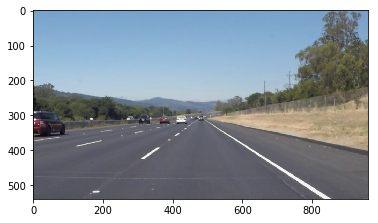

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #for line in lines:
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    ### SEPARATE RIGHT VS LEFT BASED ON SLOPE
    
    # Empty arrays to store the left or right line segments
    left_lines = []
    right_lines = []
    
    # debug
    print('TYPE of LINES:', type(lines))
    print('LINES:')
    print(lines)
    
    for line in lines: 
        for x1,y1,x2,y2 in line:
            if (x2==x1):
                slope=1000   # not really, but this is just for sorting the line to left or right
            else:
                slope = (y2-y1)/(x2-x1)
            print('Slope = ', slope)
            if slope < 0:
                right_lines.append(line)  # right=negative slope 
            else:   
                left_lines.append(line)   # left=positive slope
    
    print("LEFT LINES:")
    print(left_lines)
    print ("RIGHT LINES:")
    print(right_lines)      
          
    ### Find the top y point and bottom y point in each line, 
    ### then draw one line from the top to the bottom
    
    # Seed the points with a starting point (make them the extremes)
    top_left_point = [0,539]
    bottom_left_point = [0,0]
    top_right_point = [959,539]
    bottom_right_point = [959,0]
    
    # Figure out top/bottom points of left lines 
    for line in left_lines:
        for x1,y1,x2,y2 in line:
            if (y1<top_left_point[1]):
                # new point is higher (i.e., lower y value)
                # store new top point
                top_left_point = x1,y1
            if (y2<top_left_point[1]):
                top_left_point = x2,y2    
            if (y1>bottom_left_point[1]):
                bottom_left_point = x1,y1
            if (y2>bottom_left_point[1]):
                bottom_left_point = x2,y2
            
    print("Top Left Point, Bottom Left Point:")
    print(top_left_point, bottom_left_point)
    
    # Interpolation:
    # Calculate the slope and draw a line using the slope of the two identified points,
    # all the way to the bottom border (hardcoded as 539)
    x_top, y_top = top_left_point    
    x_bottom, y_bottom = bottom_left_point
    
    if (x_bottom==x_top):
        m=100
    else:
        m = (y_bottom-y_top)/(x_bottom-x_top)
        b = -m*x_top + y_top     # b = -mx + y
    # What is x of bottom border point, given that y=539?
    y_border_point = 539
    x_border_point = int((y_border_point-b)/m)    # x = (y-b)/m
        
    print('x_border_point, y_border_point')
    print(x_border_point, y_border_point)
    
    # Draw left line
    #cv2.line(img, (bottom_left_point[0],bottom_left_point[1]), (top_left_point[0],top_left_point[1]), color, thickness)
    cv2.line(img, (x_border_point, y_border_point), (x_top, y_top), color, thickness)
    
    
    # Right line, using same algorithm as above
    # Figure out top/bottom points of right line
    for line in right_lines:
        for x1,y1,x2,y2 in line:
            if (y1<top_right_point[1]):
                # new point is higher (i.e., lower y value)
                # store new top point
                top_right_point = x1,y1
            if (y2<top_right_point[1]):
                top_right_point = x2,y2    
            if (y1>bottom_right_point[1]):
                bottom_right_point = x1,y1
            if (y2>bottom_right_point[1]):
                bottom_right_point = x2,y2
    
    print("Top Right Point, Bottom Right Point:")
    print(top_right_point, bottom_right_point)    
                
    
    # Interpolation:
    # Calculate the slope and draw a line using the slope of the two identified points,
    # all the way to the bottom border
    x_top, y_top = top_right_point    
    x_bottom, y_bottom = bottom_right_point
    
    if (x_bottom!=x_top):
        m = (y_bottom-y_top)/(x_bottom-x_top)
        b = -m*x_top + y_top     # b = -mx + y
        # What is x of bottom border point, given that y=539?
        y_border_point = 539
        x_border_point = int((y_border_point-b)/m)    # x = (y-b)/m
    else:
        y_border_point = 539
        x_border_point = 0
        
    # Draw right line
    #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    #cv2.line(img, (bottom_right_point[0],bottom_right_point[1]), (top_right_point[0],top_right_point[1]), color, thickness)
    cv2.line(img, (x_border_point, y_border_point), (x_top, y_top), color, thickness)
                 
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
filenames = []
filenames = os.listdir("test_images/")


run your solution on all test_images and make copies into the test_images directory).

SOLID WHITE CURVE.... Image type: <class 'numpy.ndarray'>  Dimensions: (540, 960, 3)
GRAYSCALE
CANNY IMAGE
GAUSSIAN IMAGE
MASKED
TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 898 538]]

 [[515 330 878 539]]

 [[520 330 880 537]]

 [[511 330 874 539]]

 [[513 330 875 539]]

 [[518 330 880 539]]

 [[522 330 899 539]]

 [[525 330 844 507]]

 [[598 374 896 539]]

 [[527 330 783 472]]

 [[278 464 353 407]]

 [[406 368 459 330]]

 [[403 368 453 330]]

 [[404 368 456 330]]

 [[278 460 349 407]]]
Slope =  0.554666666667
Slope =  0.575757575758
Slope =  0.575
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.577348066298
Slope =  0.554376657825
Slope =  0.554858934169
Slope =  0.553691275168
Slope =  0.5546875
Slope =  -0.76
Slope =  -0.716981132075
Slope =  -0.76
Slope =  -0.730769230769
Slope =  -0.746478873239
LEFT LINES:
[array([[523, 330, 898, 538]], dtype=int32), array([[515, 330, 878, 539]], dtype=int32), array([[520, 330, 880, 537]], dtype=int32), array([[511, 330, 8

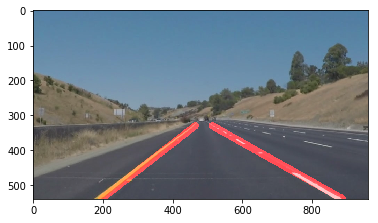

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

for filename in filenames:    

    #image = mpimg.imread('test_images/solidWhiteCurve.jpg')
    image = mpimg.imread('test_images/' + filename)

    print('SOLID WHITE CURVE.... Image type:', type(image), ' Dimensions:', image.shape)
    plt.imshow(image)
    gray_image = grayscale(image)
    print('GRAYSCALE')
    plt.imshow(gray_image, cmap='gray')
    canny_image = canny(gray_image, 100, 200)
    print('CANNY IMAGE')
    plt.imshow(canny_image, cmap='gray')
    print('GAUSSIAN IMAGE')
    gaussian_image = gaussian_blur(canny_image, 5)
    plt.imshow(gaussian_image, cmap='gray')

    # MASKING
    # Masking comes ahead of Hough lines so that lines can be interpolated only on lane lanes
    # as part of Hough transform
    vertices = np.array([[450,330], [535,330], [900,540], [100, 540]])
    masked_image = region_of_interest(gaussian_image, [vertices])
    print('MASKED')
    plt.imshow(masked_image, cmap='gray')

    # HOUGH TRANSFORM & LINE INTERPOLATION
    rho=1
    theta = np.pi/180
    threshold = 150
    min_line_len = 5
    max_line_gap = 5
    hough_image = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
    print('HOUGH')
    plt.imshow(hough_image, cmap='gray')

    # FINAL IMAGE WEIGHTING
    weighted_image = weighted_img(hough_image, image)
    print('WEIGHTED')
    plt.imshow(weighted_image, cmap='gray')

    # SAVE
    save_name = "test_images/output_" + filename
    # mpimg.imsave("saved_image.jpg", weighted_image)
    mpimg.imsave(save_name, weighted_image)




## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    
    #image = mpimg.imread('test_images/solidWhiteCurve.jpg')
    #print('SOLID WHITE CURVE.... Image type:', type(image), ' Dimensions:', image.shape)
    #plt.imshow(image)
    gray_image = grayscale(image)
    #print('GRAYSCALE')
    #plt.imshow(gray_image, cmap='gray')
    canny_image = canny(gray_image, 100, 200)
    #print('CANNY IMAGE')
    #plt.imshow(canny_image, cmap='gray')
    #print('GAUSSIAN IMAGE')
    gaussian_image = gaussian_blur(canny_image, 5)
    #plt.imshow(gaussian_image, cmap='gray')

    # MASKING
    # Masking comes ahead of Hough lines so that lines can be interpolated only on lane lanes
    # as part of Hough transform
    vertices = np.array([[450,330], [535,330], [900,540], [100, 540]])
    masked_image = region_of_interest(gaussian_image, [vertices])
    #print('MASKED')
    #plt.imshow(masked_image, cmap='gray')

    # HOUGH TRANSFORM & LINE INTERPOLATION
    rho=1
    theta = np.pi/180
    threshold = 150
    min_line_len = 5
    max_line_gap = 5
    hough_image = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
    #print('HOUGH')
    #plt.imshow(hough_image, cmap='gray')

    # FINAL IMAGE WEIGHTING
    weighted_image = weighted_img(hough_image, image)
    #print('WEIGHTED')
    #plt.imshow(weighted_image, cmap='gray')

    result = weighted_image
    
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 850 539]]

 [[518 330 852 538]]

 [[526 330 872 538]]

 [[520 330 868 539]]

 [[512 330 847 539]]

 [[523 330 872 539]]

 [[542 344 866 539]]

 [[528 330 872 537]]

 [[522 330 870 539]]

 [[590 374 864 539]]

 [[185 513 307 428]]

 [[185 516 310 428]]

 [[199 517 313 431]]

 [[529 330 757 467]]

 [[196 517 312 429]]

 [[517 330 852 539]]

 [[185 511 303 428]]

 [[198 517 313 430]]

 [[389 372 408 357]]

 [[202 517 313 433]]

 [[702 450 845 539]]

 [[415 351 421 347]]

 [[194 517 312 428]]]
Slope =  0.623880597015
Slope =  0.622754491018
Slope =  0.601156069364
Slope =  0.600574712644
Slope =  0.623880597015
Slope =  0.598853868195
Slope =  0.601851851852
Slope =  0.601744186047
Slope =  0.600574712644
Slope =  0.602189781022
Slope =  -0.696721311475
Slope =  -0.704
Slope =  -0.754385964912
Slope =  0.600877192982
Slope =  -0.758620689655
Slope =  0.623880597015
Slope =  -0.703389830508
Slope =  -0.75652173913
Slope =  -0.78947368

  0%|                                                                                          | 0/222 [00:00<?, ?it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 850 539]]

 [[518 330 852 538]]

 [[526 330 872 538]]

 [[520 330 868 539]]

 [[512 330 847 539]]

 [[523 330 872 539]]

 [[542 344 866 539]]

 [[528 330 872 537]]

 [[522 330 870 539]]

 [[590 374 864 539]]

 [[185 513 307 428]]

 [[185 516 310 428]]

 [[199 517 313 431]]

 [[529 330 757 467]]

 [[196 517 312 429]]

 [[517 330 852 539]]

 [[185 511 303 428]]

 [[198 517 313 430]]

 [[389 372 408 357]]

 [[202 517 313 433]]

 [[702 450 845 539]]

 [[415 351 421 347]]

 [[194 517 312 428]]]
Slope =  0.623880597015
Slope =  0.622754491018
Slope =  0.601156069364
Slope =  0.600574712644
Slope =  0.623880597015
Slope =  0.598853868195
Slope =  0.601851851852
Slope =  0.601744186047
Slope =  0.600574712644
Slope =  0.602189781022
Slope =  -0.696721311475
Slope =  -0.704
Slope =  -0.754385964912
Slope =  0.600877192982
Slope =  -0.758620689655
Slope =  0.623880597015
Slope =  -0.703389830508
Slope =  -0.75652173913
Slope =  -0.78947368

  0%|▎                                                                                 | 1/222 [00:00<00:36,  6.09it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[528 330 863 539]]

 [[521 330 844 539]]

 [[520 330 842 539]]

 [[529 330 865 539]]

 [[526 330 849 539]]

 [[524 330 847 539]]

 [[574 357 866 539]]

 [[548 343 850 539]]

 [[516 330 776 498]]

 [[625 387 869 539]]

 [[427 346 447 332]]

 [[523 330 845 539]]

 [[416 353 446 332]]

 [[148 539 284 444]]

 [[166 538 290 445]]

 [[151 539 287 444]]

 [[599 375 844 528]]

 [[167 539 291 446]]

 [[383 376 405 359]]

 [[148 538 282 444]]

 [[148 536 279 444]]

 [[172 539 289 448]]

 [[174 539 291 451]]

 [[249 475 290 444]]]
Slope =  0.623880597015
Slope =  0.647058823529
Slope =  0.649068322981
Slope =  0.622023809524
Slope =  0.647058823529
Slope =  0.647058823529
Slope =  0.623287671233
Slope =  0.649006622517
Slope =  0.646153846154
Slope =  0.622950819672
Slope =  -0.7
Slope =  0.649068322981
Slope =  -0.7
Slope =  -0.698529411765
Slope =  -0.75
Slope =  -0.698529411765
Slope =  0.624489795918
Slope =  -0.75
Slope =  -0.772727272727
Slope

  1%|▋                                                                                 | 2/222 [00:00<00:36,  6.02it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[512 330 872 538]]

 [[515 332 847 539]]

 [[528 330 806 497]]

 [[593 377 851 538]]

 [[515 330 850 539]]

 [[526 330 872 537]]

 [[523 330 789 489]]

 [[664 418 867 539]]

 [[520 330 704 440]]

 [[584 372 850 538]]

 [[612 388 723 454]]

 [[148 539 258 462]]

 [[522 330 737 459]]

 [[336 409 346 402]]

 [[338 409 348 402]]

 [[377 381 401 364]]

 [[147 538 256 462]]

 [[425 348 448 331]]

 [[572 365 604 385]]

 [[155 539 260 463]]

 [[166 538 264 465]]

 [[521 331 576 366]]

 [[170 539 264 468]]

 [[167 539 264 466]]

 [[153 539 259 462]]

 [[374 378 398 361]]

 [[633 401 806 509]]

 [[175 539 264 469]]

 [[697 446 841 539]]]
Slope =  0.577777777778
Slope =  0.623493975904
Slope =  0.60071942446
Slope =  0.624031007752
Slope =  0.623880597015
Slope =  0.598265895954
Slope =  0.597744360902
Slope =  0.5960591133
Slope =  0.597826086957
Slope =  0.624060150376
Slope =  0.594594594595
Slope =  -0.7
Slope =  0.6
Slope =  -0.7
Slope =  -0.7


  1%|█                                                                                 | 3/222 [00:00<00:38,  5.70it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 330 868 539]]

 [[525 330 872 538]]

 [[512 330 847 539]]

 [[514 330 849 539]]

 [[528 330 871 536]]

 [[522 330 870 539]]

 [[516 330 851 539]]

 [[520 331 851 537]]

 [[621 393 781 489]]

 [[565 358 866 539]]

 [[369 386 396 367]]

 [[407 358 436 338]]

 [[523 330 871 539]]

 [[369 385 396 366]]

 [[320 418 331 411]]]
Slope =  0.598853868195
Slope =  0.599423631124
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.600583090379
Slope =  0.600574712644
Slope =  0.623880597015
Slope =  0.622356495468
Slope =  0.6
Slope =  0.601328903654
Slope =  -0.703703703704
Slope =  -0.689655172414
Slope =  0.600574712644
Slope =  -0.703703703704
Slope =  -0.636363636364
LEFT LINES:
[array([[519, 330, 868, 539]], dtype=int32), array([[525, 330, 872, 538]], dtype=int32), array([[512, 330, 847, 539]], dtype=int32), array([[514, 330, 849, 539]], dtype=int32), array([[528, 330, 871, 536]], dtype=int32), array([[522, 330, 870, 539]], dtype=in

  2%|█▍                                                                                | 4/222 [00:00<00:35,  6.19it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[529 330 851 539]]

 [[524 330 847 539]]

 [[522 330 844 539]]

 [[573 358 873 539]]

 [[526 330 848 539]]

 [[544 339 873 537]]

 [[519 330 800 512]]

 [[621 389 870 539]]

 [[601 376 872 539]]

 [[644 404 868 539]]

 [[516 330 676 433]]

 [[675 424 866 539]]]
Slope =  0.649068322981
Slope =  0.647058823529
Slope =  0.649068322981
Slope =  0.603333333333
Slope =  0.649068322981
Slope =  0.601823708207
Slope =  0.64768683274
Slope =  0.602409638554
Slope =  0.60147601476
Slope =  0.602678571429
Slope =  0.64375
Slope =  0.602094240838
LEFT LINES:
[array([[529, 330, 851, 539]], dtype=int32), array([[524, 330, 847, 539]], dtype=int32), array([[522, 330, 844, 539]], dtype=int32), array([[573, 358, 873, 539]], dtype=int32), array([[526, 330, 848, 539]], dtype=int32), array([[544, 339, 873, 537]], dtype=int32), array([[519, 330, 800, 512]], dtype=int32), array([[621, 389, 870, 539]], dtype=int32), array([[601, 376, 872, 539]], dtype=int32), ar

  2%|█▊                                                                                | 5/222 [00:00<00:32,  6.68it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[527 330 873 538]]

 [[519 330 853 539]]

 [[521 330 869 539]]

 [[513 330 848 539]]

 [[516 330 851 539]]

 [[524 330 873 539]]

 [[571 362 716 449]]

 [[611 379 819 504]]

 [[562 361 847 539]]

 [[520 330 598 378]]

 [[522 330 871 539]]

 [[587 371 866 539]]

 [[611 387 853 538]]]
Slope =  0.601156069364
Slope =  0.625748502994
Slope =  0.600574712644
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.598853868195
Slope =  0.6
Slope =  0.600961538462
Slope =  0.624561403509
Slope =  0.615384615385
Slope =  0.598853868195
Slope =  0.602150537634
Slope =  0.623966942149
LEFT LINES:
[array([[527, 330, 873, 538]], dtype=int32), array([[519, 330, 853, 539]], dtype=int32), array([[521, 330, 869, 539]], dtype=int32), array([[513, 330, 848, 539]], dtype=int32), array([[516, 330, 851, 539]], dtype=int32), array([[524, 330, 873, 539]], dtype=int32), array([[571, 362, 716, 449]], dtype=int32), array([[611, 379, 819, 504]], dtype=int32), ar

  3%|██▏                                                                               | 6/222 [00:00<00:31,  6.92it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[525 330 874 539]]

 [[522 330 871 539]]

 [[518 330 853 539]]

 [[528 330 874 538]]

 [[519 330 853 538]]

 [[515 330 850 539]]

 [[540 341 801 504]]

 [[513 330 848 539]]

 [[620 390 868 539]]

 [[517 330 851 539]]

 [[623 386 874 537]]

 [[524 330 872 539]]

 [[567 364 847 539]]]
Slope =  0.598853868195
Slope =  0.598853868195
Slope =  0.623880597015
Slope =  0.601156069364
Slope =  0.622754491018
Slope =  0.623880597015
Slope =  0.624521072797
Slope =  0.623880597015
Slope =  0.600806451613
Slope =  0.625748502994
Slope =  0.601593625498
Slope =  0.600574712644
Slope =  0.625
LEFT LINES:
[array([[525, 330, 874, 539]], dtype=int32), array([[522, 330, 871, 539]], dtype=int32), array([[518, 330, 853, 539]], dtype=int32), array([[528, 330, 874, 538]], dtype=int32), array([[519, 330, 853, 538]], dtype=int32), array([[515, 330, 850, 539]], dtype=int32), array([[540, 341, 801, 504]], dtype=int32), array([[513, 330, 848, 539]], dtype=int32), 

  3%|██▌                                                                               | 7/222 [00:01<00:32,  6.68it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[513 330 876 539]]

 [[514 331 874 539]]

 [[518 330 875 536]]

 [[516 330 876 538]]

 [[547 351 848 539]]

 [[572 366 871 539]]

 [[520 330 844 517]]

 [[593 379 855 537]]

 [[576 370 628 402]]

 [[524 330 714 440]]

 [[673 429 855 539]]

 [[596 383 847 539]]]
Slope =  0.575757575758
Slope =  0.577777777778
Slope =  0.577030812325
Slope =  0.577777777778
Slope =  0.624584717608
Slope =  0.578595317726
Slope =  0.577160493827
Slope =  0.603053435115
Slope =  0.615384615385
Slope =  0.578947368421
Slope =  0.604395604396
Slope =  0.621513944223
LEFT LINES:
[array([[513, 330, 876, 539]], dtype=int32), array([[514, 331, 874, 539]], dtype=int32), array([[518, 330, 875, 536]], dtype=int32), array([[516, 330, 876, 538]], dtype=int32), array([[547, 351, 848, 539]], dtype=int32), array([[572, 366, 871, 539]], dtype=int32), array([[520, 330, 844, 517]], dtype=int32), array([[593, 379, 855, 537]], dtype=int32), array([[576, 370, 628, 402]], dtype=i

  4%|██▉                                                                               | 8/222 [00:01<00:29,  7.15it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[520 330 869 539]]

 [[514 330 849 539]]

 [[517 330 866 539]]

 [[523 330 871 539]]

 [[528 330 874 538]]

 [[526 330 874 539]]

 [[520 332 852 539]]

 [[551 354 847 539]]

 [[605 383 853 537]]

 [[659 408 874 537]]

 [[565 359 853 538]]]
Slope =  0.598853868195
Slope =  0.623880597015
Slope =  0.598853868195
Slope =  0.600574712644
Slope =  0.601156069364
Slope =  0.600574712644
Slope =  0.623493975904
Slope =  0.625
Slope =  0.620967741935
Slope =  0.6
Slope =  0.621527777778
LEFT LINES:
[array([[520, 330, 869, 539]], dtype=int32), array([[514, 330, 849, 539]], dtype=int32), array([[517, 330, 866, 539]], dtype=int32), array([[523, 330, 871, 539]], dtype=int32), array([[528, 330, 874, 538]], dtype=int32), array([[526, 330, 874, 539]], dtype=int32), array([[520, 332, 852, 539]], dtype=int32), array([[551, 354, 847, 539]], dtype=int32), array([[605, 383, 853, 537]], dtype=int32), array([[659, 408, 874, 537]], dtype=int32), array([[565, 35

  4%|███▎                                                                              | 9/222 [00:01<00:29,  7.33it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 869 538]]

 [[510 330 845 539]]

 [[514 330 848 538]]

 [[517 330 865 539]]

 [[512 330 847 539]]

 [[519 330 867 539]]

 [[519 332 863 539]]

 [[574 371 843 539]]

 [[559 357 848 537]]

 [[642 415 840 539]]

 [[525 330 869 537]]

 [[521 330 869 539]]]
Slope =  0.601156069364
Slope =  0.623880597015
Slope =  0.622754491018
Slope =  0.600574712644
Slope =  0.623880597015
Slope =  0.600574712644
Slope =  0.601744186047
Slope =  0.624535315985
Slope =  0.622837370242
Slope =  0.626262626263
Slope =  0.601744186047
Slope =  0.600574712644
LEFT LINES:
[array([[523, 330, 869, 538]], dtype=int32), array([[510, 330, 845, 539]], dtype=int32), array([[514, 330, 848, 538]], dtype=int32), array([[517, 330, 865, 539]], dtype=int32), array([[512, 330, 847, 539]], dtype=int32), array([[519, 330, 867, 539]], dtype=int32), array([[519, 332, 863, 539]], dtype=int32), array([[574, 371, 843, 539]], dtype=int32), array([[559, 357, 848, 537]], dtype=i

  5%|███▋                                                                             | 10/222 [00:01<00:29,  7.27it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 863 539]]

 [[512 330 835 539]]

 [[518 330 863 537]]

 [[518 333 861 539]]

 [[552 355 858 539]]

 [[510 330 811 525]]

 [[519 330 862 536]]

 [[517 330 535 341]]

 [[508 330 754 489]]

 [[622 398 840 539]]

 [[592 380 838 539]]

 [[514 330 862 539]]

 [[261 463 339 408]]

 [[266 463 342 408]]

 [[261 457 336 408]]

 [[261 460 338 408]]

 [[270 463 342 411]]

 [[577 371 836 539]]

 [[422 352 454 330]]]
Slope =  0.600574712644
Slope =  0.647058823529
Slope =  0.6
Slope =  0.600583090379
Slope =  0.601307189542
Slope =  0.647840531561
Slope =  0.600583090379
Slope =  0.611111111111
Slope =  0.646341463415
Slope =  0.646788990826
Slope =  0.646341463415
Slope =  0.600574712644
Slope =  -0.705128205128
Slope =  -0.723684210526
Slope =  -0.653333333333
Slope =  -0.675324675325
Slope =  -0.722222222222
Slope =  0.648648648649
Slope =  -0.6875
LEFT LINES:
[array([[515, 330, 863, 539]], dtype=int32), array([[512, 330, 835, 539]], dtype=

  5%|████                                                                             | 11/222 [00:01<00:31,  6.63it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[512 330 859 538]]

 [[507 331 839 539]]

 [[509 330 857 539]]

 [[507 330 855 539]]

 [[514 330 859 537]]

 [[514 335 853 539]]

 [[581 379 837 539]]

 [[516 330 859 536]]

 [[510 330 859 539]]

 [[558 364 838 539]]

 [[623 407 834 539]]

 [[584 378 805 516]]

 [[227 487 325 419]]

 [[227 481 319 419]]

 [[364 390 373 384]]

 [[232 487 326 419]]

 [[227 486 323 419]]

 [[393 372 451 330]]

 [[391 370 410 357]]

 [[235 487 327 421]]

 [[239 487 327 423]]

 [[227 483 321 419]]

 [[230 478 317 419]]]
Slope =  0.599423631124
Slope =  0.626506024096
Slope =  0.600574712644
Slope =  0.600574712644
Slope =  0.6
Slope =  0.601769911504
Slope =  0.625
Slope =  0.600583090379
Slope =  0.598853868195
Slope =  0.625
Slope =  0.625592417062
Slope =  0.62443438914
Slope =  -0.69387755102
Slope =  -0.673913043478
Slope =  -0.666666666667
Slope =  -0.723404255319
Slope =  -0.697916666667
Slope =  -0.724137931034
Slope =  -0.684210526316
Slope =  -0.7173

  5%|████▍                                                                            | 12/222 [00:01<00:34,  6.00it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 850 539]]

 [[512 330 835 539]]

 [[507 330 830 539]]

 [[518 330 853 539]]

 [[510 330 833 539]]

 [[523 330 858 539]]

 [[520 330 855 539]]

 [[548 351 838 539]]

 [[192 518 309 433]]

 [[356 395 367 388]]

 [[517 330 852 539]]

 [[385 374 441 335]]

 [[181 515 308 430]]

 [[181 514 305 430]]

 [[585 374 841 534]]

 [[201 517 309 436]]

 [[415 355 435 342]]

 [[391 374 409 361]]

 [[190 518 309 432]]

 [[198 518 309 435]]

 [[181 513 304 430]]

 [[355 393 363 388]]

 [[194 518 300 441]]

 [[181 511 301 430]]

 [[188 518 309 430]]

 [[182 518 307 431]]]
Slope =  0.623880597015
Slope =  0.647058823529
Slope =  0.647058823529
Slope =  0.623880597015
Slope =  0.647058823529
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.648275862069
Slope =  -0.726495726496
Slope =  -0.636363636364
Slope =  0.623880597015
Slope =  -0.696428571429
Slope =  -0.669291338583
Slope =  -0.677419354839
Slope =  0.625
Slope =  -0.75
Slope =  -0

  6%|████▋                                                                            | 13/222 [00:02<00:36,  5.71it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[521 330 856 539]]

 [[519 330 854 539]]

 [[516 330 838 539]]

 [[510 330 832 539]]

 [[514 330 836 539]]

 [[523 330 859 539]]

 [[512 330 834 539]]

 [[519 331 852 539]]

 [[622 404 829 539]]

 [[573 366 842 534]]

 [[142 539 283 444]]

 [[142 538 282 444]]

 [[159 538 287 445]]

 [[159 539 287 446]]

 [[142 536 279 444]]

 [[166 539 287 448]]

 [[148 539 284 444]]

 [[168 539 287 449]]

 [[161 539 278 454]]

 [[722 453 859 538]]

 [[515 330 837 539]]

 [[152 529 278 444]]]
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.622023809524
Slope =  0.649068322981
Slope =  0.624624624625
Slope =  0.652173913043
Slope =  0.624535315985
Slope =  -0.673758865248
Slope =  -0.671428571429
Slope =  -0.7265625
Slope =  -0.7265625
Slope =  -0.671532846715
Slope =  -0.752066115702
Slope =  -0.698529411765
Slope =  -0.756302521008
Slope =  -0.726495726496
Slope =  0.6204

  6%|█████                                                                            | 14/222 [00:02<00:38,  5.47it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[522 330 857 539]]

 [[514 330 836 539]]

 [[518 330 853 539]]

 [[517 330 840 539]]

 [[524 330 859 539]]

 [[526 330 860 538]]

 [[520 330 855 539]]

 [[512 330 834 539]]

 [[515 330 837 539]]

 [[543 346 840 538]]

 [[648 420 831 539]]

 [[375 379 401 362]]

 [[139 539 254 462]]

 [[373 379 400 361]]

 [[426 347 432 343]]

 [[157 539 260 465]]

 [[382 379 401 365]]

 [[142 539 256 462]]

 [[718 449 859 537]]

 [[583 371 852 539]]

 [[160 539 260 467]]

 [[139 537 250 462]]

 [[165 539 260 468]]]
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.623880597015
Slope =  0.647058823529
Slope =  0.623880597015
Slope =  0.622754491018
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.646464646465
Slope =  0.650273224044
Slope =  -0.653846153846
Slope =  -0.669565217391
Slope =  -0.666666666667
Slope =  -0.666666666667
Slope =  -0.718446601942
Slope =  -0.736842105263
Slope =  -0.675438596491
Slope =  

  7%|█████▍                                                                           | 15/222 [00:02<00:38,  5.34it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[527 330 861 539]]

 [[518 330 841 539]]

 [[524 330 859 539]]

 [[522 330 857 539]]

 [[520 330 855 539]]

 [[515 330 837 539]]

 [[530 330 861 536]]

 [[570 362 841 538]]

 [[621 400 835 539]]

 [[517 330 839 539]]

 [[324 414 333 408]]

 [[321 414 332 407]]]
Slope =  0.625748502994
Slope =  0.647058823529
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.622356495468
Slope =  0.649446494465
Slope =  0.64953271028
Slope =  0.649068322981
Slope =  -0.666666666667
Slope =  -0.636363636364
LEFT LINES:
[array([[527, 330, 861, 539]], dtype=int32), array([[518, 330, 841, 539]], dtype=int32), array([[524, 330, 859, 539]], dtype=int32), array([[522, 330, 857, 539]], dtype=int32), array([[520, 330, 855, 539]], dtype=int32), array([[515, 330, 837, 539]], dtype=int32), array([[530, 330, 861, 536]], dtype=int32), array([[570, 362, 841, 538]], dtype=int32), array([[621, 400, 835, 539]], dtype=

  7%|█████▊                                                                           | 16/222 [00:02<00:35,  5.86it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[520 330 842 539]]

 [[529 330 862 538]]

 [[522 330 857 539]]

 [[525 330 860 539]]

 [[524 332 855 539]]

 [[577 370 837 539]]

 [[517 330 839 539]]

 [[532 330 708 440]]

 [[528 330 862 539]]

 [[526 330 861 539]]

 [[588 373 842 538]]]
Slope =  0.649068322981
Slope =  0.624624624625
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.625377643505
Slope =  0.65
Slope =  0.649068322981
Slope =  0.625
Slope =  0.625748502994
Slope =  0.623880597015
Slope =  0.649606299213
LEFT LINES:
[array([[520, 330, 842, 539]], dtype=int32), array([[529, 330, 862, 538]], dtype=int32), array([[522, 330, 857, 539]], dtype=int32), array([[525, 330, 860, 539]], dtype=int32), array([[524, 332, 855, 539]], dtype=int32), array([[577, 370, 837, 539]], dtype=int32), array([[517, 330, 839, 539]], dtype=int32), array([[532, 330, 708, 440]], dtype=int32), array([[528, 330, 862, 539]], dtype=int32), array([[526, 330, 861, 539]], dtype=int32), array([[588, 3

  8%|██████▏                                                                          | 17/222 [00:02<00:33,  6.20it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 860 538]]

 [[516 330 860 536]]

 [[520 334 860 539]]

 [[518 330 857 534]]

 [[723 458 858 539]]

 [[520 330 809 504]]

 [[601 387 837 535]]

 [[522 330 750 467]]

 [[545 350 758 483]]

 [[588 378 808 516]]

 [[641 413 840 538]]

 [[665 429 839 538]]

 [[525 330 696 433]]

 [[683 441 833 539]]

 [[590 377 859 539]]]
Slope =  0.602898550725
Slope =  0.598837209302
Slope =  0.602941176471
Slope =  0.601769911504
Slope =  0.6
Slope =  0.602076124567
Slope =  0.627118644068
Slope =  0.600877192982
Slope =  0.62441314554
Slope =  0.627272727273
Slope =  0.628140703518
Slope =  0.626436781609
Slope =  0.602339181287
Slope =  0.653333333333
Slope =  0.602230483271
LEFT LINES:
[array([[515, 330, 860, 538]], dtype=int32), array([[516, 330, 860, 536]], dtype=int32), array([[520, 334, 860, 539]], dtype=int32), array([[518, 330, 857, 534]], dtype=int32), array([[723, 458, 858, 539]], dtype=int32), array([[520, 330, 809, 504]], dtype=int32),

  8%|██████▌                                                                          | 18/222 [00:02<00:32,  6.35it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[513 330 858 537]]

 [[580 371 830 539]]

 [[517 330 836 522]]

 [[595 380 858 538]]

 [[615 393 832 539]]

 [[527 330 791 494]]

 [[648 413 836 539]]

 [[515 330 858 536]]

 [[672 428 856 539]]

 [[539 345 767 498]]

 [[520 330 711 445]]

 [[692 441 838 539]]]
Slope =  0.6
Slope =  0.672
Slope =  0.601880877743
Slope =  0.600760456274
Slope =  0.672811059908
Slope =  0.621212121212
Slope =  0.670212765957
Slope =  0.600583090379
Slope =  0.603260869565
Slope =  0.671052631579
Slope =  0.602094240838
Slope =  0.671232876712
LEFT LINES:
[array([[513, 330, 858, 537]], dtype=int32), array([[580, 371, 830, 539]], dtype=int32), array([[517, 330, 836, 522]], dtype=int32), array([[595, 380, 858, 538]], dtype=int32), array([[615, 393, 832, 539]], dtype=int32), array([[527, 330, 791, 494]], dtype=int32), array([[648, 413, 836, 539]], dtype=int32), array([[515, 330, 858, 536]], dtype=int32), array([[672, 428, 856, 539]], dtype=int32), array([[539, 

  9%|██████▉                                                                          | 19/222 [00:02<00:30,  6.64it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[511 330 857 538]]

 [[515 330 854 534]]

 [[535 345 835 539]]

 [[592 383 832 539]]

 [[575 370 856 539]]

 [[787 494 857 537]]

 [[519 330 753 471]]

 [[603 388 786 503]]

 [[753 483 837 539]]

 [[524 330 596 378]]

 [[559 350 645 405]]

 [[713 452 745 472]]

 [[747 475 853 539]]

 [[513 330 822 516]]

 [[663 424 704 451]]

 [[777 498 819 525]]]
Slope =  0.601156069364
Slope =  0.601769911504
Slope =  0.646666666667
Slope =  0.65
Slope =  0.601423487544
Slope =  0.614285714286
Slope =  0.602564102564
Slope =  0.628415300546
Slope =  0.666666666667
Slope =  0.666666666667
Slope =  0.639534883721
Slope =  0.625
Slope =  0.603773584906
Slope =  0.601941747573
Slope =  0.658536585366
Slope =  0.642857142857
LEFT LINES:
[array([[511, 330, 857, 538]], dtype=int32), array([[515, 330, 854, 534]], dtype=int32), array([[535, 345, 835, 539]], dtype=int32), array([[592, 383, 832, 539]], dtype=int32), array([[575, 370, 856, 539]], dtype=int32), arra

  9%|███████▎                                                                         | 20/222 [00:03<00:32,  6.23it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 856 538]]

 [[518 330 853 539]]

 [[515 330 850 539]]

 [[520 330 855 539]]

 [[510 330 833 539]]

 [[513 330 835 539]]

 [[545 349 837 538]]

 [[622 404 829 539]]

 [[517 330 851 539]]

 [[554 348 856 536]]

 [[622 398 707 451]]

 [[166 528 186 514]]

 [[308 426 362 390]]]
Slope =  0.624624624625
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.647058823529
Slope =  0.649068322981
Slope =  0.647260273973
Slope =  0.652173913043
Slope =  0.625748502994
Slope =  0.622516556291
Slope =  0.623529411765
Slope =  -0.7
Slope =  -0.666666666667
LEFT LINES:
[array([[523, 330, 856, 538]], dtype=int32), array([[518, 330, 853, 539]], dtype=int32), array([[515, 330, 850, 539]], dtype=int32), array([[520, 330, 855, 539]], dtype=int32), array([[510, 330, 833, 539]], dtype=int32), array([[513, 330, 835, 539]], dtype=int32), array([[545, 349, 837, 538]], dtype=int32), array([[622, 404, 829, 539]], dtype=int32), 

  9%|███████▋                                                                         | 21/222 [00:03<00:30,  6.60it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[517 330 853 539]]

 [[515 330 851 539]]

 [[509 330 831 539]]

 [[521 330 856 539]]

 [[514 330 837 539]]

 [[511 330 833 539]]

 [[523 330 857 538]]

 [[550 352 837 538]]

 [[557 350 857 537]]]
Slope =  0.622023809524
Slope =  0.622023809524
Slope =  0.649068322981
Slope =  0.623880597015
Slope =  0.647058823529
Slope =  0.649068322981
Slope =  0.622754491018
Slope =  0.648083623693
Slope =  0.623333333333
LEFT LINES:
[array([[517, 330, 853, 539]], dtype=int32), array([[515, 330, 851, 539]], dtype=int32), array([[509, 330, 831, 539]], dtype=int32), array([[521, 330, 856, 539]], dtype=int32), array([[514, 330, 837, 539]], dtype=int32), array([[511, 330, 833, 539]], dtype=int32), array([[523, 330, 857, 538]], dtype=int32), array([[550, 352, 837, 538]], dtype=int32), array([[557, 350, 857, 537]], dtype=int32)]
RIGHT LINES:
[]
Top Left Point, Bottom Left Point:
(517, 330) (853, 539)
x_border_point, y_border_point
853 539
Top Right Point, Bo

 10%|████████                                                                         | 22/222 [00:03<00:27,  7.30it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 849 539]]

 [[511 330 833 539]]

 [[523 330 857 539]]

 [[518 330 853 539]]

 [[528 339 837 539]]

 [[521 330 856 539]]

 [[654 425 830 539]]

 [[559 351 857 537]]

 [[613 392 837 537]]

 [[524 330 857 538]]

 [[517 330 851 539]]

 [[510 330 832 539]]

 [[396 366 450 330]]

 [[267 459 343 406]]

 [[262 458 341 405]]

 [[262 454 338 405]]]
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.625748502994
Slope =  0.623880597015
Slope =  0.647249190939
Slope =  0.623880597015
Slope =  0.647727272727
Slope =  0.624161073826
Slope =  0.647321428571
Slope =  0.624624624625
Slope =  0.625748502994
Slope =  0.649068322981
Slope =  -0.666666666667
Slope =  -0.697368421053
Slope =  -0.670886075949
Slope =  -0.644736842105
LEFT LINES:
[array([[514, 330, 849, 539]], dtype=int32), array([[511, 330, 833, 539]], dtype=int32), array([[523, 330, 857, 539]], dtype=int32), array([[518, 330, 853, 539]], dtype=int32), array([[528, 339, 837, 53

 10%|████████▍                                                                        | 23/222 [00:03<00:28,  6.89it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 332 857 538]]

 [[513 330 857 537]]

 [[539 348 834 539]]

 [[516 330 779 488]]

 [[524 339 832 539]]

 [[559 360 835 539]]

 [[594 381 837 538]]

 [[526 330 749 469]]

 [[230 478 324 415]]

 [[637 408 855 539]]

 [[617 395 856 539]]

 [[676 439 830 539]]

 [[524 330 714 448]]

 [[391 369 449 331]]

 [[230 481 292 439]]

 [[369 387 377 381]]

 [[230 477 322 415]]

 [[750 473 814 512]]

 [[235 481 329 415]]

 [[515 330 844 528]]

 [[237 481 329 417]]

 [[244 481 329 419]]

 [[674 432 721 461]]

 [[421 351 449 332]]]
Slope =  0.600583090379
Slope =  0.601744186047
Slope =  0.647457627119
Slope =  0.600760456274
Slope =  0.649350649351
Slope =  0.648550724638
Slope =  0.646090534979
Slope =  0.62331838565
Slope =  -0.670212765957
Slope =  0.600917431193
Slope =  0.602510460251
Slope =  0.649350649351
Slope =  0.621052631579
Slope =  -0.655172413793
Slope =  -0.677419354839
Slope =  -0.75
Slope =  -0.673913043478
Slope =  0.609375
Slope 

 11%|████████▊                                                                        | 24/222 [00:03<00:30,  6.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[513 330 857 537]]

 [[513 331 857 538]]

 [[535 346 856 539]]

 [[515 330 856 535]]

 [[518 330 772 483]]

 [[630 408 838 538]]

 [[586 379 728 465]]

 [[519 330 747 467]]

 [[184 509 306 427]]

 [[198 512 312 429]]

 [[186 509 308 427]]

 [[606 392 827 530]]

 [[184 505 304 427]]

 [[195 512 312 427]]

 [[185 511 309 427]]

 [[664 430 833 539]]

 [[194 512 311 427]]

 [[393 372 409 360]]

 [[522 330 682 426]]

 [[202 512 312 432]]

 [[197 512 312 428]]

 [[200 512 312 431]]

 [[184 507 271 449]]

 [[216 483 302 427]]

 [[646 416 787 504]]]
Slope =  0.601744186047
Slope =  0.601744186047
Slope =  0.601246105919
Slope =  0.601173020528
Slope =  0.602362204724
Slope =  0.625
Slope =  0.605633802817
Slope =  0.600877192982
Slope =  -0.672131147541
Slope =  -0.728070175439
Slope =  -0.672131147541
Slope =  0.62443438914
Slope =  -0.65
Slope =  -0.726495726496
Slope =  -0.677419354839
Slope =  0.644970414201
Slope =  -0.726495726496
Slope =  

 11%|█████████                                                                        | 25/222 [00:03<00:33,  5.87it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[524 330 834 539]]

 [[525 330 857 537]]

 [[521 330 831 539]]

 [[553 349 857 539]]

 [[518 330 828 539]]

 [[519 330 830 539]]

 [[586 371 855 539]]

 [[414 354 447 332]]

 [[515 330 700 454]]

 [[139 539 283 442]]

 [[587 371 615 389]]

 [[143 539 288 442]]

 [[558 351 586 369]]

 [[164 539 291 447]]

 [[141 539 285 442]]

 [[160 539 291 444]]

 [[138 538 281 442]]

 [[611 386 837 539]]

 [[158 539 290 443]]

 [[138 536 277 443]]

 [[166 539 291 449]]

 [[626 398 851 539]]

 [[416 354 437 339]]

 [[145 539 235 478]]

 [[527 330 839 525]]

 [[161 539 291 445]]]
Slope =  0.674193548387
Slope =  0.623493975904
Slope =  0.674193548387
Slope =  0.625
Slope =  0.674193548387
Slope =  0.672025723473
Slope =  0.624535315985
Slope =  -0.666666666667
Slope =  0.67027027027
Slope =  -0.673611111111
Slope =  0.642857142857
Slope =  -0.668965517241
Slope =  0.642857142857
Slope =  -0.724409448819
Slope =  -0.673611111111
Slope =  -0.725190839695
Sl

 12%|█████████▍                                                                       | 26/222 [00:04<00:35,  5.58it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[512 330 833 539]]

 [[524 330 834 539]]

 [[526 330 858 537]]

 [[589 373 854 539]]

 [[540 340 858 539]]

 [[623 396 852 539]]

 [[800 518 832 539]]

 [[516 330 838 539]]

 [[514 330 778 502]]

 [[520 330 630 402]]

 [[140 539 255 462]]

 [[377 381 402 365]]

 [[410 356 446 332]]

 [[340 408 349 402]]

 [[380 381 402 366]]

 [[410 355 426 344]]

 [[146 539 256 462]]

 [[139 538 251 463]]

 [[162 539 264 465]]

 [[165 539 264 467]]

 [[519 330 649 415]]

 [[159 538 262 463]]

 [[159 539 263 464]]

 [[141 536 249 463]]

 [[141 539 248 467]]

 [[577 365 855 539]]

 [[529 342 814 528]]]
Slope =  0.651090342679
Slope =  0.674193548387
Slope =  0.623493975904
Slope =  0.62641509434
Slope =  0.625786163522
Slope =  0.624454148472
Slope =  0.65625
Slope =  0.649068322981
Slope =  0.651515151515
Slope =  0.654545454545
Slope =  -0.669565217391
Slope =  -0.64
Slope =  -0.666666666667
Slope =  -0.666666666667
Slope =  -0.681818181818
Slope =  -0.6

 12%|█████████▊                                                                       | 27/222 [00:04<00:35,  5.43it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[513 331 833 539]]

 [[525 330 858 538]]

 [[520 330 855 539]]

 [[521 330 856 539]]

 [[513 330 836 539]]

 [[517 330 852 539]]

 [[515 330 837 539]]

 [[524 335 839 539]]

 [[564 360 839 538]]

 [[518 330 853 539]]

 [[140 539 218 487]]

 [[609 381 858 536]]

 [[370 386 397 368]]

 [[538 348 832 539]]

 [[139 539 214 488]]

 [[161 539 228 491]]

 [[524 330 857 538]]

 [[149 538 221 488]]

 [[163 539 228 492]]]
Slope =  0.65
Slope =  0.624624624625
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.647058823529
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.647619047619
Slope =  0.647272727273
Slope =  0.623880597015
Slope =  -0.666666666667
Slope =  0.622489959839
Slope =  -0.666666666667
Slope =  0.649659863946
Slope =  -0.68
Slope =  -0.716417910448
Slope =  0.624624624625
Slope =  -0.694444444444
Slope =  -0.723076923077
LEFT LINES:
[array([[513, 331, 833, 539]], dtype=int32), array([[525, 330, 858, 538]], dtype=i

 13%|██████████▏                                                                      | 28/222 [00:04<00:34,  5.69it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 335 858 539]]

 [[512 330 858 538]]

 [[514 330 858 536]]

 [[536 347 832 539]]

 [[516 330 850 531]]

 [[519 330 773 483]]

 [[529 342 833 539]]

 [[569 366 836 539]]

 [[712 453 855 539]]

 [[677 431 838 539]]

 [[690 439 855 538]]

 [[525 330 575 363]]

 [[522 330 686 429]]

 [[604 387 795 511]]]
Slope =  0.601769911504
Slope =  0.601156069364
Slope =  0.598837209302
Slope =  0.648648648649
Slope =  0.601796407186
Slope =  0.602362204724
Slope =  0.648026315789
Slope =  0.647940074906
Slope =  0.601398601399
Slope =  0.670807453416
Slope =  0.6
Slope =  0.66
Slope =  0.603658536585
Slope =  0.649214659686
LEFT LINES:
[array([[519, 335, 858, 539]], dtype=int32), array([[512, 330, 858, 538]], dtype=int32), array([[514, 330, 858, 536]], dtype=int32), array([[536, 347, 832, 539]], dtype=int32), array([[516, 330, 850, 531]], dtype=int32), array([[519, 330, 773, 483]], dtype=int32), array([[529, 342, 833, 539]], dtype=int32), array([[56

 13%|██████████▌                                                                      | 29/222 [00:04<00:30,  6.26it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[513 330 835 539]]

 [[519 330 839 538]]

 [[523 330 858 539]]

 [[516 330 839 539]]

 [[526 330 860 538]]

 [[521 330 856 539]]

 [[534 339 854 539]]

 [[543 351 832 539]]

 [[609 381 859 537]]

 [[524 330 859 539]]

 [[520 335 834 539]]

 [[600 382 848 537]]

 [[515 330 837 539]]]
Slope =  0.649068322981
Slope =  0.65
Slope =  0.623880597015
Slope =  0.647058823529
Slope =  0.622754491018
Slope =  0.623880597015
Slope =  0.625
Slope =  0.650519031142
Slope =  0.624
Slope =  0.623880597015
Slope =  0.649681528662
Slope =  0.625
Slope =  0.649068322981
LEFT LINES:
[array([[513, 330, 835, 539]], dtype=int32), array([[519, 330, 839, 538]], dtype=int32), array([[523, 330, 858, 539]], dtype=int32), array([[516, 330, 839, 539]], dtype=int32), array([[526, 330, 860, 538]], dtype=int32), array([[521, 330, 856, 539]], dtype=int32), array([[534, 339, 854, 539]], dtype=int32), array([[543, 351, 832, 539]], dtype=int32), array([[609, 381, 859, 537]]

 14%|██████████▉                                                                      | 30/222 [00:04<00:30,  6.36it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[518 330 853 539]]

 [[522 330 857 539]]

 [[528 340 834 539]]

 [[519 331 840 539]]

 [[514 330 836 539]]

 [[525 330 861 539]]

 [[521 330 856 539]]

 [[528 330 861 538]]

 [[580 369 840 538]]

 [[524 330 859 539]]

 [[551 356 832 539]]

 [[517 331 837 539]]

 [[516 330 548 350]]]
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.650326797386
Slope =  0.647975077882
Slope =  0.649068322981
Slope =  0.622023809524
Slope =  0.623880597015
Slope =  0.624624624625
Slope =  0.65
Slope =  0.623880597015
Slope =  0.651245551601
Slope =  0.65
Slope =  0.625
LEFT LINES:
[array([[518, 330, 853, 539]], dtype=int32), array([[522, 330, 857, 539]], dtype=int32), array([[528, 340, 834, 539]], dtype=int32), array([[519, 331, 840, 539]], dtype=int32), array([[514, 330, 836, 539]], dtype=int32), array([[525, 330, 861, 539]], dtype=int32), array([[521, 330, 856, 539]], dtype=int32), array([[528, 330, 861, 538]], dtype=int32), array([[580, 369, 84

 14%|███████████▎                                                                     | 31/222 [00:04<00:29,  6.37it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[522 330 841 537]]

 [[514 330 837 539]]

 [[526 330 861 539]]

 [[524 330 860 539]]

 [[518 330 840 539]]

 [[534 344 834 539]]

 [[529 334 857 539]]

 [[528 330 592 370]]

 [[606 384 854 539]]

 [[600 375 862 538]]

 [[569 360 855 539]]]
Slope =  0.648902821317
Slope =  0.647058823529
Slope =  0.623880597015
Slope =  0.622023809524
Slope =  0.649068322981
Slope =  0.65
Slope =  0.625
Slope =  0.625
Slope =  0.625
Slope =  0.62213740458
Slope =  0.625874125874
LEFT LINES:
[array([[522, 330, 841, 537]], dtype=int32), array([[514, 330, 837, 539]], dtype=int32), array([[526, 330, 861, 539]], dtype=int32), array([[524, 330, 860, 539]], dtype=int32), array([[518, 330, 840, 539]], dtype=int32), array([[534, 344, 834, 539]], dtype=int32), array([[529, 334, 857, 539]], dtype=int32), array([[528, 330, 592, 370]], dtype=int32), array([[606, 384, 854, 539]], dtype=int32), array([[600, 375, 862, 538]], dtype=int32), array([[569, 360, 855, 539]], dty

 14%|███████████▋                                                                     | 32/222 [00:05<00:27,  6.99it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 862 539]]

 [[518 330 862 537]]

 [[515 330 862 538]]

 [[530 341 859 539]]

 [[540 348 834 539]]

 [[520 330 813 506]]

 [[553 356 857 539]]

 [[613 395 841 538]]

 [[573 369 822 525]]

 [[524 330 662 413]]

 [[687 443 840 539]]

 [[524 337 860 539]]]
Slope =  0.600574712644
Slope =  0.601744186047
Slope =  0.599423631124
Slope =  0.601823708207
Slope =  0.649659863946
Slope =  0.600682593857
Slope =  0.601973684211
Slope =  0.627192982456
Slope =  0.626506024096
Slope =  0.601449275362
Slope =  0.627450980392
Slope =  0.60119047619
LEFT LINES:
[array([[514, 330, 862, 539]], dtype=int32), array([[518, 330, 862, 537]], dtype=int32), array([[515, 330, 862, 538]], dtype=int32), array([[530, 341, 859, 539]], dtype=int32), array([[540, 348, 834, 539]], dtype=int32), array([[520, 330, 813, 506]], dtype=int32), array([[553, 356, 857, 539]], dtype=int32), array([[613, 395, 841, 538]], dtype=int32), array([[573, 369, 822, 525]], dtype=in

 15%|████████████                                                                     | 33/222 [00:05<00:27,  6.83it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 330 854 539]]

 [[521 330 856 539]]

 [[525 330 860 539]]

 [[513 330 835 539]]

 [[515 330 838 539]]

 [[518 330 841 539]]

 [[528 330 861 538]]

 [[554 358 832 539]]

 [[541 349 833 539]]

 [[579 368 841 538]]

 [[517 330 839 539]]

 [[526 330 861 539]]]
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.647058823529
Slope =  0.647058823529
Slope =  0.624624624625
Slope =  0.651079136691
Slope =  0.650684931507
Slope =  0.648854961832
Slope =  0.649068322981
Slope =  0.623880597015
LEFT LINES:
[array([[519, 330, 854, 539]], dtype=int32), array([[521, 330, 856, 539]], dtype=int32), array([[525, 330, 860, 539]], dtype=int32), array([[513, 330, 835, 539]], dtype=int32), array([[515, 330, 838, 539]], dtype=int32), array([[518, 330, 841, 539]], dtype=int32), array([[528, 330, 861, 538]], dtype=int32), array([[554, 358, 832, 539]], dtype=int32), array([[541, 349, 833, 539]], dtype=i

 15%|████████████▍                                                                    | 34/222 [00:05<00:28,  6.67it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[517 330 826 516]]

 [[514 330 859 537]]

 [[512 330 859 538]]

 [[513 331 859 539]]

 [[527 340 834 539]]

 [[531 343 832 539]]

 [[547 352 836 539]]

 [[608 395 830 539]]

 [[581 373 857 539]]

 [[601 386 837 539]]

 [[691 440 839 539]]

 [[520 330 719 450]]

 [[719 458 854 539]]

 [[526 330 576 363]]

 [[621 398 815 524]]

 [[397 365 438 338]]]
Slope =  0.601941747573
Slope =  0.6
Slope =  0.599423631124
Slope =  0.601156069364
Slope =  0.648208469055
Slope =  0.651162790698
Slope =  0.647058823529
Slope =  0.648648648649
Slope =  0.601449275362
Slope =  0.648305084746
Slope =  0.668918918919
Slope =  0.603015075377
Slope =  0.6
Slope =  0.66
Slope =  0.649484536082
Slope =  -0.658536585366
LEFT LINES:
[array([[517, 330, 826, 516]], dtype=int32), array([[514, 330, 859, 537]], dtype=int32), array([[512, 330, 859, 538]], dtype=int32), array([[513, 331, 859, 539]], dtype=int32), array([[527, 340, 834, 539]], dtype=int32), array([[531, 343

 16%|████████████▊                                                                    | 35/222 [00:05<00:29,  6.25it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[518 330 853 539]]

 [[516 330 838 539]]

 [[523 330 858 539]]

 [[514 330 837 539]]

 [[511 330 833 539]]

 [[545 353 831 539]]

 [[521 330 856 539]]

 [[517 330 852 539]]

 [[574 367 846 537]]

 [[525 330 858 538]]

 [[392 368 448 331]]

 [[394 369 414 356]]

 [[233 478 327 415]]

 [[246 483 330 420]]

 [[372 388 378 384]]

 [[611 391 838 538]]

 [[244 480 330 418]]

 [[368 387 378 381]]

 [[242 480 330 416]]

 [[233 480 330 415]]]
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.623880597015
Slope =  0.647058823529
Slope =  0.649068322981
Slope =  0.65034965035
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.625
Slope =  0.624624624625
Slope =  -0.660714285714
Slope =  -0.65
Slope =  -0.670212765957
Slope =  -0.75
Slope =  -0.666666666667
Slope =  0.647577092511
Slope =  -0.720930232558
Slope =  -0.6
Slope =  -0.727272727273
Slope =  -0.670103092784
LEFT LINES:
[array([[518, 330, 853, 539]], dtype=int32), array([[5

 16%|█████████████▏                                                                   | 36/222 [00:05<00:30,  6.15it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 846 537]]

 [[519 330 854 539]]

 [[522 330 857 539]]

 [[517 330 852 539]]

 [[512 331 832 539]]

 [[520 330 855 539]]

 [[513 330 835 539]]

 [[524 330 858 538]]

 [[549 356 830 539]]

 [[555 356 838 539]]

 [[595 381 837 538]]

 [[191 510 309 428]]

 [[199 511 313 428]]

 [[190 505 304 428]]

 [[390 373 435 339]]

 [[607 395 828 539]]

 [[202 512 314 428]]

 [[388 370 426 344]]

 [[430 346 435 343]]

 [[418 353 435 340]]

 [[417 353 435 341]]

 [[190 508 306 429]]

 [[208 511 314 431]]

 [[190 507 307 428]]

 [[204 512 314 430]]]
Slope =  0.623493975904
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.65
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.622754491018
Slope =  0.651245551601
Slope =  0.646643109541
Slope =  0.648760330579
Slope =  -0.694915254237
Slope =  -0.728070175439
Slope =  -0.675438596491
Slope =  -0.755555555556
Slope =  0.651583710407
Slope =  -0.75
Slope =  -0

 17%|█████████████▌                                                                   | 37/222 [00:05<00:31,  5.80it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[521 330 856 539]]

 [[517 330 838 538]]

 [[519 330 853 539]]

 [[516 330 838 539]]

 [[513 330 836 539]]

 [[523 330 857 538]]

 [[541 350 832 539]]

 [[567 368 830 539]]

 [[511 330 834 539]]

 [[149 539 286 443]]

 [[143 537 283 443]]

 [[162 538 293 443]]

 [[386 376 407 360]]

 [[543 346 852 539]]

 [[384 376 406 360]]

 [[580 370 850 539]]

 [[418 354 434 342]]

 [[168 539 293 445]]

 [[150 539 288 443]]

 [[416 354 434 341]]

 [[147 539 284 443]]

 [[171 539 293 447]]

 [[175 514 280 443]]

 [[350 400 359 393]]

 [[163 539 293 444]]

 [[651 424 828 539]]

 [[146 539 276 448]]

 [[165 539 236 487]]

 [[162 537 292 443]]]
Slope =  0.623880597015
Slope =  0.647975077882
Slope =  0.625748502994
Slope =  0.649068322981
Slope =  0.647058823529
Slope =  0.622754491018
Slope =  0.649484536082
Slope =  0.650190114068
Slope =  0.647058823529
Slope =  -0.700729927007
Slope =  -0.671428571429
Slope =  -0.725190839695
Slope =  -0.761904761905


 17%|█████████████▊                                                                   | 38/222 [00:06<00:34,  5.34it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[522 330 857 539]]

 [[523 331 832 539]]

 [[519 330 829 539]]

 [[524 330 858 539]]

 [[520 330 536 340]]

 [[581 369 853 539]]

 [[516 330 800 521]]

 [[550 348 855 539]]

 [[525 330 858 538]]

 [[515 330 742 483]]

 [[612 390 850 539]]

 [[141 538 256 461]]

 [[148 539 260 461]]

 [[517 330 659 423]]

 [[377 380 403 362]]

 [[342 408 350 402]]

 [[160 539 266 462]]

 [[153 529 252 462]]

 [[376 378 400 361]]

 [[141 539 257 461]]

 [[409 356 416 350]]

 [[379 380 403 364]]

 [[165 539 266 463]]

 [[652 416 835 539]]

 [[142 539 258 461]]

 [[173 537 266 467]]

 [[341 408 350 401]]

 [[169 539 266 466]]

 [[565 362 828 539]]

 [[410 356 426 344]]]
Slope =  0.623880597015
Slope =  0.673139158576
Slope =  0.674193548387
Slope =  0.625748502994
Slope =  0.625
Slope =  0.625
Slope =  0.672535211268
Slope =  0.626229508197
Slope =  0.624624624625
Slope =  0.674008810573
Slope =  0.626050420168
Slope =  -0.669565217391
Slope =  -0.69642857142

 18%|██████████████▏                                                                  | 39/222 [00:06<00:35,  5.10it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 858 537]]

 [[536 345 858 539]]

 [[558 360 856 539]]

 [[516 330 825 516]]

 [[593 384 838 537]]

 [[578 374 718 459]]

 [[517 330 770 482]]

 [[521 335 857 537]]

 [[519 330 714 447]]

 [[635 412 838 539]]

 [[369 384 398 364]]

 [[667 433 831 539]]

 [[141 539 221 486]]

 [[608 393 813 521]]

 [[160 539 231 488]]

 [[320 417 331 410]]

 [[408 357 428 343]]

 [[521 330 679 425]]]
Slope =  0.601744186047
Slope =  0.60248447205
Slope =  0.60067114094
Slope =  0.601941747573
Slope =  0.624489795918
Slope =  0.607142857143
Slope =  0.600790513834
Slope =  0.60119047619
Slope =  0.6
Slope =  0.625615763547
Slope =  -0.689655172414
Slope =  0.646341463415
Slope =  -0.6625
Slope =  0.624390243902
Slope =  -0.718309859155
Slope =  -0.636363636364
Slope =  -0.7
Slope =  0.601265822785
LEFT LINES:
[array([[514, 330, 858, 537]], dtype=int32), array([[536, 345, 858, 539]], dtype=int32), array([[558, 360, 856, 539]], dtype=int32), array([[5

 18%|██████████████▌                                                                  | 40/222 [00:06<00:33,  5.43it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 858 537]]

 [[558 359 857 539]]

 [[563 363 834 539]]

 [[653 417 835 539]]

 [[515 330 848 530]]

 [[534 343 858 538]]

 [[518 330 761 476]]

 [[588 379 675 432]]

 [[600 388 832 539]]

 [[673 429 837 539]]

 [[528 330 638 401]]

 [[608 392 810 523]]

 [[530 330 668 419]]

 [[622 403 831 539]]

 [[741 470 827 525]]]
Slope =  0.601744186047
Slope =  0.602006688963
Slope =  0.649446494465
Slope =  0.67032967033
Slope =  0.600600600601
Slope =  0.601851851852
Slope =  0.600823045267
Slope =  0.609195402299
Slope =  0.650862068966
Slope =  0.670731707317
Slope =  0.645454545455
Slope =  0.648514851485
Slope =  0.644927536232
Slope =  0.650717703349
Slope =  0.639534883721
LEFT LINES:
[array([[514, 330, 858, 537]], dtype=int32), array([[558, 359, 857, 539]], dtype=int32), array([[563, 363, 834, 539]], dtype=int32), array([[653, 417, 835, 539]], dtype=int32), array([[515, 330, 848, 530]], dtype=int32), array([[534, 343, 858, 538]], dt

 18%|██████████████▉                                                                  | 41/222 [00:06<00:30,  5.87it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[531 330 830 539]]

 [[518 330 828 539]]

 [[602 379 857 539]]

 [[636 403 854 539]]

 [[520 330 855 539]]

 [[525 330 857 537]]

 [[534 340 852 539]]

 [[561 358 653 416]]

 [[515 330 743 483]]

 [[574 367 693 444]]

 [[592 379 838 539]]

 [[586 377 645 416]]

 [[784 505 833 539]]

 [[566 354 857 536]]

 [[662 421 808 519]]

 [[596 375 857 538]]]
Slope =  0.698996655518
Slope =  0.674193548387
Slope =  0.627450980392
Slope =  0.623853211009
Slope =  0.623880597015
Slope =  0.623493975904
Slope =  0.625786163522
Slope =  0.630434782609
Slope =  0.671052631579
Slope =  0.647058823529
Slope =  0.650406504065
Slope =  0.661016949153
Slope =  0.69387755102
Slope =  0.625429553265
Slope =  0.671232876712
Slope =  0.624521072797
LEFT LINES:
[array([[531, 330, 830, 539]], dtype=int32), array([[518, 330, 828, 539]], dtype=int32), array([[602, 379, 857, 539]], dtype=int32), array([[636, 403, 854, 539]], dtype=int32), array([[520, 330, 855, 539]], 

 19%|███████████████▎                                                                 | 42/222 [00:06<00:30,  5.97it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[530 330 852 539]]

 [[528 330 850 539]]

 [[526 330 847 538]]

 [[522 330 832 539]]

 [[525 330 835 539]]

 [[520 330 830 539]]

 [[517 330 826 538]]

 [[621 388 854 539]]

 [[523 330 833 539]]

 [[570 359 700 446]]

 [[681 426 856 539]]]
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.647975077882
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.673139158576
Slope =  0.648068669528
Slope =  0.674193548387
Slope =  0.669230769231
Slope =  0.645714285714
LEFT LINES:
[array([[530, 330, 852, 539]], dtype=int32), array([[528, 330, 850, 539]], dtype=int32), array([[526, 330, 847, 538]], dtype=int32), array([[522, 330, 832, 539]], dtype=int32), array([[525, 330, 835, 539]], dtype=int32), array([[520, 330, 830, 539]], dtype=int32), array([[517, 330, 826, 538]], dtype=int32), array([[621, 388, 854, 539]], dtype=int32), array([[523, 330, 833, 539]], dtype=int32), array([[570, 359, 700, 446]], dtype=int

 19%|███████████████▋                                                                 | 43/222 [00:06<00:27,  6.47it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 858 539]]

 [[518 330 853 539]]

 [[516 330 851 539]]

 [[526 330 858 537]]

 [[520 330 855 539]]

 [[523 335 838 539]]

 [[515 330 836 539]]

 [[580 374 834 539]]

 [[568 363 838 538]]

 [[609 394 832 539]]

 [[528 330 756 473]]

 [[693 450 830 539]]]
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.623493975904
Slope =  0.623880597015
Slope =  0.647619047619
Slope =  0.651090342679
Slope =  0.649606299213
Slope =  0.648148148148
Slope =  0.650224215247
Slope =  0.627192982456
Slope =  0.649635036496
LEFT LINES:
[array([[523, 330, 858, 539]], dtype=int32), array([[518, 330, 853, 539]], dtype=int32), array([[516, 330, 851, 539]], dtype=int32), array([[526, 330, 858, 537]], dtype=int32), array([[520, 330, 855, 539]], dtype=int32), array([[523, 335, 838, 539]], dtype=int32), array([[515, 330, 836, 539]], dtype=int32), array([[580, 374, 834, 539]], dtype=int32), array([[568, 363, 838, 538]], dtype=i

 20%|████████████████                                                                 | 44/222 [00:07<00:27,  6.52it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[518 330 853 539]]

 [[515 330 850 539]]

 [[521 330 856 539]]

 [[516 330 851 539]]

 [[523 330 857 538]]

 [[526 330 857 537]]

 [[514 330 836 539]]

 [[581 375 834 539]]

 [[527 338 836 538]]

 [[567 363 836 537]]

 [[655 425 830 539]]

 [[621 402 831 539]]

 [[522 330 857 539]]]
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.622754491018
Slope =  0.625377643505
Slope =  0.649068322981
Slope =  0.648221343874
Slope =  0.647249190939
Slope =  0.646840148699
Slope =  0.651428571429
Slope =  0.652380952381
Slope =  0.623880597015
LEFT LINES:
[array([[518, 330, 853, 539]], dtype=int32), array([[515, 330, 850, 539]], dtype=int32), array([[521, 330, 856, 539]], dtype=int32), array([[516, 330, 851, 539]], dtype=int32), array([[523, 330, 857, 538]], dtype=int32), array([[526, 330, 857, 537]], dtype=int32), array([[514, 330, 836, 539]], dtype=int32), array([[581, 375, 834, 539]], dtype

 20%|████████████████▍                                                                | 45/222 [00:07<00:27,  6.52it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[526 330 858 537]]

 [[519 330 854 539]]

 [[523 330 858 539]]

 [[516 330 837 538]]

 [[514 330 836 539]]

 [[522 333 851 539]]

 [[590 381 833 539]]

 [[528 330 710 444]]

 [[573 366 850 539]]

 [[524 330 858 538]]

 [[642 416 831 539]]

 [[521 330 856 539]]]
Slope =  0.623493975904
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.647975077882
Slope =  0.649068322981
Slope =  0.626139817629
Slope =  0.650205761317
Slope =  0.626373626374
Slope =  0.624548736462
Slope =  0.622754491018
Slope =  0.650793650794
Slope =  0.623880597015
LEFT LINES:
[array([[526, 330, 858, 537]], dtype=int32), array([[519, 330, 854, 539]], dtype=int32), array([[523, 330, 858, 539]], dtype=int32), array([[516, 330, 837, 538]], dtype=int32), array([[514, 330, 836, 539]], dtype=int32), array([[522, 333, 851, 539]], dtype=int32), array([[590, 381, 833, 539]], dtype=int32), array([[528, 330, 710, 444]], dtype=int32), array([[573, 366, 850, 539]], dtype=i

 21%|████████████████▊                                                                | 46/222 [00:07<00:25,  6.78it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 858 539]]

 [[516 330 851 539]]

 [[518 330 853 539]]

 [[521 330 856 539]]

 [[526 330 858 537]]

 [[515 330 837 539]]

 [[591 381 834 539]]

 [[524 330 858 538]]

 [[560 358 837 538]]

 [[623 403 832 539]]

 [[600 383 802 514]]

 [[560 360 835 539]]

 [[684 444 830 539]]

 [[528 330 779 487]]]
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.623493975904
Slope =  0.649068322981
Slope =  0.650205761317
Slope =  0.622754491018
Slope =  0.649819494585
Slope =  0.650717703349
Slope =  0.648514851485
Slope =  0.650909090909
Slope =  0.650684931507
Slope =  0.625498007968
LEFT LINES:
[array([[523, 330, 858, 539]], dtype=int32), array([[516, 330, 851, 539]], dtype=int32), array([[518, 330, 853, 539]], dtype=int32), array([[521, 330, 856, 539]], dtype=int32), array([[526, 330, 858, 537]], dtype=int32), array([[515, 330, 837, 539]], dtype=int32), array([[591, 381, 834, 539]], dty

 21%|█████████████████▏                                                               | 47/222 [00:07<00:24,  7.01it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 330 854 539]]

 [[516 330 851 539]]

 [[523 330 856 538]]

 [[526 330 856 536]]

 [[515 331 835 539]]

 [[515 330 836 538]]

 [[627 406 832 539]]

 [[563 360 836 537]]

 [[528 330 678 424]]

 [[592 382 833 539]]

 [[619 395 747 478]]

 [[238 472 330 410]]

 [[245 462 325 410]]]
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.624624624625
Slope =  0.624242424242
Slope =  0.65
Slope =  0.647975077882
Slope =  0.648780487805
Slope =  0.648351648352
Slope =  0.626666666667
Slope =  0.651452282158
Slope =  0.6484375
Slope =  -0.673913043478
Slope =  -0.65
LEFT LINES:
[array([[519, 330, 854, 539]], dtype=int32), array([[516, 330, 851, 539]], dtype=int32), array([[523, 330, 856, 538]], dtype=int32), array([[526, 330, 856, 536]], dtype=int32), array([[515, 331, 835, 539]], dtype=int32), array([[515, 330, 836, 538]], dtype=int32), array([[627, 406, 832, 539]], dtype=int32), array([[563, 360, 836, 537]], dtype=int32), array([[528, 3

 22%|█████████████████▌                                                               | 48/222 [00:07<00:25,  6.90it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[527 330 849 539]]

 [[530 330 852 539]]

 [[519 330 829 539]]

 [[522 330 833 539]]

 [[524 330 834 539]]

 [[516 330 826 539]]

 [[528 332 821 522]]

 [[551 343 854 539]]

 [[518 330 828 539]]

 [[521 330 831 539]]

 [[590 373 836 539]]

 [[515 330 770 502]]

 [[358 390 367 384]]

 [[195 499 310 422]]

 [[195 498 308 422]]

 [[203 504 315 423]]

 [[195 501 311 422]]

 [[210 504 315 425]]

 [[197 500 311 423]]

 [[709 444 856 539]]

 [[391 370 407 358]]

 [[208 504 315 424]]]
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.674193548387
Slope =  0.672025723473
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.648464163823
Slope =  0.646864686469
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.674796747967
Slope =  0.674509803922
Slope =  -0.666666666667
Slope =  -0.669565217391
Slope =  -0.672566371681
Slope =  -0.723214285714
Slope =  -0.681034482759
Slope =  -0.752380952381
Slope =  -0.675438596491
Slope =

 22%|█████████████████▉                                                               | 49/222 [00:07<00:28,  6.01it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[516 330 827 539]]

 [[525 330 835 539]]

 [[527 330 849 539]]

 [[519 330 829 539]]

 [[521 330 832 539]]

 [[529 330 851 539]]

 [[523 330 834 539]]

 [[543 338 853 539]]

 [[526 330 846 538]]

 [[139 539 290 437]]

 [[138 538 287 437]]

 [[515 330 818 534]]

 [[158 537 294 438]]

 [[163 539 294 441]]

 [[158 538 294 440]]

 [[346 396 355 390]]

 [[572 361 835 538]]

 [[379 373 391 365]]

 [[384 374 403 360]]

 [[138 537 286 437]]

 [[138 536 284 437]]

 [[141 539 261 458]]

 [[698 437 856 539]]

 [[165 539 294 442]]

 [[350 397 358 391]]

 [[164 538 286 446]]]
Slope =  0.672025723473
Slope =  0.674193548387
Slope =  0.649068322981
Slope =  0.674193548387
Slope =  0.672025723473
Slope =  0.649068322981
Slope =  0.672025723473
Slope =  0.648387096774
Slope =  0.65
Slope =  -0.675496688742
Slope =  -0.677852348993
Slope =  0.673267326733
Slope =  -0.727941176471
Slope =  -0.748091603053
Slope =  -0.720588235294
Slope =  -0.666666666667
Sl

 23%|██████████████████▏                                                              | 50/222 [00:08<00:30,  5.66it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[522 330 856 538]]

 [[518 330 853 539]]

 [[515 330 850 539]]

 [[520 330 856 539]]

 [[524 330 856 537]]

 [[514 330 835 538]]

 [[526 330 855 536]]

 [[512 330 834 539]]

 [[614 397 832 539]]

 [[530 338 574 366]]

 [[137 539 260 456]]

 [[551 353 697 445]]

 [[139 539 263 456]]

 [[137 537 258 456]]

 [[667 433 830 539]]

 [[157 537 269 456]]

 [[137 536 255 456]]

 [[157 538 269 457]]

 [[157 539 269 458]]

 [[164 539 269 460]]

 [[163 539 269 459]]

 [[527 330 708 443]]

 [[157 536 267 456]]

 [[607 389 835 537]]

 [[373 378 398 361]]

 [[141 539 239 473]]]
Slope =  0.622754491018
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.622023809524
Slope =  0.623493975904
Slope =  0.647975077882
Slope =  0.626139817629
Slope =  0.649068322981
Slope =  0.651376146789
Slope =  0.636363636364
Slope =  -0.674796747967
Slope =  0.630136986301
Slope =  -0.66935483871
Slope =  -0.669421487603
Slope =  0.650306748466
Slope =  -0.72321428

 23%|██████████████████▌                                                              | 51/222 [00:08<00:32,  5.25it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[528 330 850 539]]

 [[515 330 835 537]]

 [[527 330 849 539]]

 [[514 330 835 538]]

 [[517 330 826 531]]

 [[530 330 852 539]]

 [[524 330 822 523]]

 [[595 371 854 539]]

 [[565 364 834 539]]

 [[519 330 754 483]]

 [[641 415 832 539]]

 [[522 330 721 459]]

 [[638 398 855 539]]

 [[693 450 830 539]]

 [[368 383 394 366]]

 [[135 538 223 479]]

 [[137 539 227 479]]

 [[136 537 222 479]]

 [[370 383 394 367]]]
Slope =  0.649068322981
Slope =  0.646875
Slope =  0.649068322981
Slope =  0.647975077882
Slope =  0.650485436893
Slope =  0.649068322981
Slope =  0.647651006711
Slope =  0.648648648649
Slope =  0.650557620818
Slope =  0.651063829787
Slope =  0.649214659686
Slope =  0.64824120603
Slope =  0.649769585253
Slope =  0.649635036496
Slope =  -0.653846153846
Slope =  -0.670454545455
Slope =  -0.666666666667
Slope =  -0.674418604651
Slope =  -0.666666666667
LEFT LINES:
[array([[528, 330, 850, 539]], dtype=int32), array([[515, 330, 835, 53

 23%|██████████████████▉                                                              | 52/222 [00:08<00:31,  5.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 330 854 539]]

 [[522 330 856 538]]

 [[513 330 835 539]]

 [[515 330 835 538]]

 [[517 330 852 539]]

 [[525 330 855 536]]

 [[566 365 834 539]]

 [[547 350 849 539]]

 [[650 421 831 539]]

 [[595 381 835 537]]

 [[527 330 727 455]]

 [[524 330 855 537]]

 [[521 330 856 539]]]
Slope =  0.623880597015
Slope =  0.622754491018
Slope =  0.649068322981
Slope =  0.65
Slope =  0.623880597015
Slope =  0.624242424242
Slope =  0.649253731343
Slope =  0.62582781457
Slope =  0.651933701657
Slope =  0.65
Slope =  0.625
Slope =  0.625377643505
Slope =  0.623880597015
LEFT LINES:
[array([[519, 330, 854, 539]], dtype=int32), array([[522, 330, 856, 538]], dtype=int32), array([[513, 330, 835, 539]], dtype=int32), array([[515, 330, 835, 538]], dtype=int32), array([[517, 330, 852, 539]], dtype=int32), array([[525, 330, 855, 536]], dtype=int32), array([[566, 365, 834, 539]], dtype=int32), array([[547, 350, 849, 539]], dtype=int32), array([[650, 421, 831

 24%|███████████████████▎                                                             | 53/222 [00:08<00:28,  5.96it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[511 330 856 537]]

 [[604 386 832 539]]

 [[634 404 835 539]]

 [[515 330 809 507]]

 [[554 356 826 539]]

 [[520 330 561 357]]

 [[574 368 828 539]]

 [[707 448 848 539]]

 [[584 374 829 539]]

 [[619 395 833 539]]

 [[526 330 611 387]]

 [[527 330 679 428]]

 [[537 335 709 446]]

 [[797 502 855 539]]

 [[624 396 835 538]]

 [[548 348 596 378]]

 [[727 460 850 539]]

 [[544 350 752 490]]

 [[574 358 729 458]]

 [[677 430 809 515]]]
Slope =  0.6
Slope =  0.671052631579
Slope =  0.671641791045
Slope =  0.602040816327
Slope =  0.672794117647
Slope =  0.658536585366
Slope =  0.673228346457
Slope =  0.645390070922
Slope =  0.673469387755
Slope =  0.672897196262
Slope =  0.670588235294
Slope =  0.644736842105
Slope =  0.645348837209
Slope =  0.637931034483
Slope =  0.672985781991
Slope =  0.625
Slope =  0.642276422764
Slope =  0.673076923077
Slope =  0.645161290323
Slope =  0.643939393939
LEFT LINES:
[array([[511, 330, 856, 537]], dtype=int32

 24%|███████████████████▋                                                             | 54/222 [00:08<00:29,  5.78it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[526 330 849 539]]

 [[524 330 834 539]]

 [[522 330 832 539]]

 [[528 330 850 539]]

 [[518 330 828 539]]

 [[528 332 822 523]]

 [[516 330 826 539]]

 [[532 332 852 539]]

 [[627 392 854 539]]

 [[521 331 829 539]]

 [[667 417 856 539]]

 [[514 330 672 436]]

 [[585 370 835 538]]]
Slope =  0.647058823529
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.649068322981
Slope =  0.674193548387
Slope =  0.649659863946
Slope =  0.674193548387
Slope =  0.646875
Slope =  0.647577092511
Slope =  0.675324675325
Slope =  0.645502645503
Slope =  0.670886075949
Slope =  0.672
LEFT LINES:
[array([[526, 330, 849, 539]], dtype=int32), array([[524, 330, 834, 539]], dtype=int32), array([[522, 330, 832, 539]], dtype=int32), array([[528, 330, 850, 539]], dtype=int32), array([[518, 330, 828, 539]], dtype=int32), array([[528, 332, 822, 523]], dtype=int32), array([[516, 330, 826, 539]], dtype=int32), array([[532, 332, 852, 539]], dtype=int32), array(

 25%|████████████████████                                                             | 55/222 [00:08<00:27,  6.05it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[511 330 855 537]]

 [[522 338 855 538]]

 [[617 396 830 539]]

 [[515 330 804 504]]

 [[647 414 833 539]]

 [[565 363 827 539]]

 [[627 402 831 539]]

 [[667 426 835 539]]

 [[718 455 747 473]]

 [[518 330 749 469]]

 [[512 330 850 533]]

 [[572 369 825 539]]

 [[520 330 714 447]]

 [[602 387 828 539]]

 [[627 396 659 416]]

 [[538 337 627 394]]

 [[687 438 850 539]]

 [[710 454 835 538]]]
Slope =  0.601744186047
Slope =  0.600600600601
Slope =  0.671361502347
Slope =  0.602076124567
Slope =  0.672043010753
Slope =  0.671755725191
Slope =  0.671568627451
Slope =  0.672619047619
Slope =  0.620689655172
Slope =  0.601731601732
Slope =  0.600591715976
Slope =  0.671936758893
Slope =  0.603092783505
Slope =  0.672566371681
Slope =  0.625
Slope =  0.640449438202
Slope =  0.61963190184
Slope =  0.672
LEFT LINES:
[array([[511, 330, 855, 537]], dtype=int32), array([[522, 338, 855, 538]], dtype=int32), array([[617, 396, 830, 539]], dtype=int32), 

 25%|████████████████████▍                                                            | 56/222 [00:09<00:28,  5.91it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 330 854 539]]

 [[514 330 849 539]]

 [[512 330 834 539]]

 [[521 330 854 538]]

 [[510 330 832 539]]

 [[516 330 851 539]]

 [[523 330 854 536]]

 [[515 331 848 539]]

 [[594 386 830 539]]

 [[568 365 834 537]]]
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.624624624625
Slope =  0.649068322981
Slope =  0.623880597015
Slope =  0.622356495468
Slope =  0.624624624625
Slope =  0.648305084746
Slope =  0.646616541353
LEFT LINES:
[array([[519, 330, 854, 539]], dtype=int32), array([[514, 330, 849, 539]], dtype=int32), array([[512, 330, 834, 539]], dtype=int32), array([[521, 330, 854, 538]], dtype=int32), array([[510, 330, 832, 539]], dtype=int32), array([[516, 330, 851, 539]], dtype=int32), array([[523, 330, 854, 536]], dtype=int32), array([[515, 331, 848, 539]], dtype=int32), array([[594, 386, 830, 539]], dtype=int32), array([[568, 365, 834, 537]], dtype=int32)]
RIGHT LINES:
[]
Top Left Point, Bottom Le

 26%|████████████████████▊                                                            | 57/222 [00:09<00:26,  6.26it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[518 330 853 539]]

 [[515 330 850 539]]

 [[519 330 853 538]]

 [[508 330 830 539]]

 [[512 330 848 539]]

 [[522 330 853 536]]

 [[509 330 832 539]]

 [[511 330 833 539]]

 [[581 378 828 539]]

 [[539 347 833 538]]

 [[642 419 826 539]]

 [[579 372 846 539]]

 [[517 330 851 539]]]
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.622754491018
Slope =  0.649068322981
Slope =  0.622023809524
Slope =  0.622356495468
Slope =  0.647058823529
Slope =  0.649068322981
Slope =  0.651821862348
Slope =  0.649659863946
Slope =  0.652173913043
Slope =  0.625468164794
Slope =  0.625748502994
LEFT LINES:
[array([[518, 330, 853, 539]], dtype=int32), array([[515, 330, 850, 539]], dtype=int32), array([[519, 330, 853, 538]], dtype=int32), array([[508, 330, 830, 539]], dtype=int32), array([[512, 330, 848, 539]], dtype=int32), array([[522, 330, 853, 536]], dtype=int32), array([[509, 330, 832, 539]], dtype=int32), array([[511, 330, 833, 539]], dtype

 26%|█████████████████████▏                                                           | 58/222 [00:09<00:26,  6.25it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[518 330 852 539]]

 [[510 330 832 539]]

 [[508 330 831 539]]

 [[512 330 847 539]]

 [[514 330 849 539]]

 [[520 330 852 537]]

 [[535 345 832 537]]

 [[509 331 829 539]]

 [[523 330 681 429]]

 [[642 419 826 539]]

 [[629 405 706 453]]

 [[516 330 851 539]]

 [[420 349 450 330]]]
Slope =  0.625748502994
Slope =  0.649068322981
Slope =  0.647058823529
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.623493975904
Slope =  0.646464646465
Slope =  0.65
Slope =  0.626582278481
Slope =  0.652173913043
Slope =  0.623376623377
Slope =  0.623880597015
Slope =  -0.633333333333
LEFT LINES:
[array([[518, 330, 852, 539]], dtype=int32), array([[510, 330, 832, 539]], dtype=int32), array([[508, 330, 831, 539]], dtype=int32), array([[512, 330, 847, 539]], dtype=int32), array([[514, 330, 849, 539]], dtype=int32), array([[520, 330, 852, 537]], dtype=int32), array([[535, 345, 832, 537]], dtype=int32), array([[509, 331, 829, 539]], dtype=int32), 

 27%|█████████████████████▌                                                           | 59/222 [00:09<00:25,  6.47it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[518 330 851 538]]

 [[510 330 831 538]]

 [[514 330 850 539]]

 [[513 330 848 539]]

 [[512 330 846 539]]

 [[508 330 830 539]]

 [[521 330 850 536]]

 [[559 361 844 539]]

 [[620 404 827 539]]

 [[516 330 851 539]]

 [[361 386 372 379]]

 [[599 387 831 537]]

 [[683 447 825 539]]

 [[522 330 701 442]]

 [[392 368 409 357]]

 [[224 475 319 414]]

 [[238 478 323 418]]

 [[224 478 322 414]]

 [[366 386 372 382]]

 [[417 351 446 333]]]
Slope =  0.624624624625
Slope =  0.647975077882
Slope =  0.622023809524
Slope =  0.623880597015
Slope =  0.625748502994
Slope =  0.649068322981
Slope =  0.626139817629
Slope =  0.624561403509
Slope =  0.652173913043
Slope =  0.623880597015
Slope =  -0.636363636364
Slope =  0.646551724138
Slope =  0.647887323944
Slope =  0.625698324022
Slope =  -0.647058823529
Slope =  -0.642105263158
Slope =  -0.705882352941
Slope =  -0.65306122449
Slope =  -0.666666666667
Slope =  -0.620689655172
LEFT LINES:
[array([[518, 33

 27%|█████████████████████▉                                                           | 60/222 [00:09<00:26,  6.11it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 825 539]]

 [[521 330 843 539]]

 [[511 330 821 539]]

 [[518 330 828 539]]

 [[520 330 842 539]]

 [[552 348 847 539]]

 [[519 330 828 538]]

 [[509 330 820 539]]

 [[523 330 845 539]]

 [[603 380 848 539]]

 [[353 392 363 386]]

 [[565 360 840 539]]

 [[179 507 303 427]]

 [[414 353 433 340]]

 [[179 506 300 427]]

 [[179 504 298 427]]

 [[190 509 305 429]]

 [[513 330 823 539]]

 [[188 509 305 427]]

 [[198 509 305 432]]

 [[516 330 826 539]]

 [[275 446 304 427]]

 [[191 510 305 431]]

 [[179 503 296 427]]]
Slope =  0.674193548387
Slope =  0.649068322981
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.649068322981
Slope =  0.647457627119
Slope =  0.673139158576
Slope =  0.672025723473
Slope =  0.649068322981
Slope =  0.648979591837
Slope =  -0.6
Slope =  0.650909090909
Slope =  -0.645161290323
Slope =  -0.684210526316
Slope =  -0.652892561983
Slope =  -0.647058823529
Slope =  -0.695652173913
Slope =  0.674193548387

 27%|██████████████████████▎                                                          | 61/222 [00:09<00:29,  5.49it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[512 330 822 539]]

 [[517 330 827 539]]

 [[514 330 824 539]]

 [[520 330 843 539]]

 [[522 330 845 539]]

 [[519 330 828 538]]

 [[541 341 847 539]]

 [[509 330 820 539]]

 [[609 384 848 539]]

 [[344 399 354 392]]

 [[129 539 278 442]]

 [[541 344 841 539]]

 [[382 375 402 362]]

 [[380 375 402 361]]

 [[129 537 275 442]]

 [[602 385 825 530]]

 [[151 539 283 447]]

 [[148 539 283 445]]

 [[133 539 237 471]]

 [[130 539 280 442]]

 [[146 539 283 443]]

 [[515 330 826 539]]

 [[378 375 401 359]]

 [[387 375 402 365]]

 [[129 538 277 442]]

 [[132 534 273 442]]

 [[153 539 283 448]]]
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.647058823529
Slope =  0.647058823529
Slope =  0.673139158576
Slope =  0.647058823529
Slope =  0.672025723473
Slope =  0.648535564854
Slope =  -0.7
Slope =  -0.651006711409
Slope =  0.65
Slope =  -0.65
Slope =  -0.636363636364
Slope =  -0.650684931507
Slope =  0.650224215247
Sl

 28%|██████████████████████▌                                                          | 62/222 [00:10<00:31,  5.13it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[512 330 848 539]]

 [[511 333 827 539]]

 [[508 330 844 539]]

 [[515 330 848 538]]

 [[511 330 846 539]]

 [[509 331 827 537]]

 [[517 330 848 537]]

 [[540 350 794 515]]

 [[129 539 247 462]]

 [[130 539 248 462]]

 [[663 434 824 539]]

 [[129 537 245 462]]

 [[521 330 692 437]]

 [[518 330 779 493]]

 [[406 357 426 344]]

 [[149 539 254 465]]

 [[130 536 244 462]]

 [[148 539 252 466]]

 [[150 539 254 467]]

 [[146 538 254 462]]

 [[377 380 397 368]]

 [[600 388 698 450]]

 [[378 379 398 366]]

 [[371 380 398 362]]

 [[153 539 254 468]]

 [[715 469 820 539]]

 [[131 539 250 462]]

 [[588 384 826 539]]]
Slope =  0.622023809524
Slope =  0.651898734177
Slope =  0.622023809524
Slope =  0.624624624625
Slope =  0.623880597015
Slope =  0.647798742138
Slope =  0.625377643505
Slope =  0.649606299213
Slope =  -0.652542372881
Slope =  -0.652542372881
Slope =  0.652173913043
Slope =  -0.646551724138
Slope =  0.625730994152
Slope =  0.624521072797

 28%|██████████████████████▉                                                          | 63/222 [00:10<00:32,  4.86it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[507 330 827 538]]

 [[515 330 847 537]]

 [[512 330 847 539]]

 [[509 330 844 539]]

 [[508 330 842 539]]

 [[551 360 827 539]]

 [[519 330 749 474]]

 [[545 354 819 532]]

 [[510 330 845 539]]

 [[617 404 824 539]]

 [[517 330 827 524]]

 [[718 462 841 539]]

 [[128 539 216 482]]

 [[130 539 216 484]]

 [[128 538 214 482]]

 [[369 385 393 368]]

 [[148 539 217 491]]]
Slope =  0.65
Slope =  0.623493975904
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.625748502994
Slope =  0.648550724638
Slope =  0.626086956522
Slope =  0.649635036496
Slope =  0.623880597015
Slope =  0.652173913043
Slope =  0.625806451613
Slope =  0.626016260163
Slope =  -0.647727272727
Slope =  -0.639534883721
Slope =  -0.651162790698
Slope =  -0.708333333333
Slope =  -0.695652173913
LEFT LINES:
[array([[507, 330, 827, 538]], dtype=int32), array([[515, 330, 847, 537]], dtype=int32), array([[512, 330, 847, 539]], dtype=int32), array([[509, 330, 844, 539]], dt

 29%|███████████████████████▎                                                         | 64/222 [00:10<00:30,  5.23it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 845 536]]

 [[508 330 818 539]]

 [[509 330 844 539]]

 [[512 330 845 538]]

 [[517 330 781 495]]

 [[511 330 820 539]]

 [[555 359 822 539]]

 [[516 333 845 539]]

 [[602 390 702 453]]

 [[620 402 824 539]]

 [[571 369 843 539]]

 [[632 408 826 538]]]
Slope =  0.622356495468
Slope =  0.674193548387
Slope =  0.623880597015
Slope =  0.624624624625
Slope =  0.625
Slope =  0.676375404531
Slope =  0.674157303371
Slope =  0.626139817629
Slope =  0.63
Slope =  0.671568627451
Slope =  0.625
Slope =  0.670103092784
LEFT LINES:
[array([[514, 330, 845, 536]], dtype=int32), array([[508, 330, 818, 539]], dtype=int32), array([[509, 330, 844, 539]], dtype=int32), array([[512, 330, 845, 538]], dtype=int32), array([[517, 330, 781, 495]], dtype=int32), array([[511, 330, 820, 539]], dtype=int32), array([[555, 359, 822, 539]], dtype=int32), array([[516, 333, 845, 539]], dtype=int32), array([[602, 390, 702, 453]], dtype=int32), array([[620, 402, 824

 29%|███████████████████████▋                                                         | 65/222 [00:10<00:27,  5.67it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 846 537]]

 [[511 330 846 539]]

 [[507 330 826 537]]

 [[510 330 845 539]]

 [[554 362 826 539]]

 [[528 343 693 446]]

 [[514 330 845 537]]

 [[516 330 817 518]]

 [[519 330 760 481]]

 [[669 438 820 539]]

 [[508 330 843 539]]

 [[614 402 818 539]]

 [[791 509 839 539]]]
Slope =  0.625377643505
Slope =  0.623880597015
Slope =  0.648902821317
Slope =  0.623880597015
Slope =  0.650735294118
Slope =  0.624242424242
Slope =  0.625377643505
Slope =  0.624584717608
Slope =  0.626556016598
Slope =  0.668874172185
Slope =  0.623880597015
Slope =  0.671568627451
Slope =  0.625
LEFT LINES:
[array([[515, 330, 846, 537]], dtype=int32), array([[511, 330, 846, 539]], dtype=int32), array([[507, 330, 826, 537]], dtype=int32), array([[510, 330, 845, 539]], dtype=int32), array([[554, 362, 826, 539]], dtype=int32), array([[528, 343, 693, 446]], dtype=int32), array([[514, 330, 845, 537]], dtype=int32), array([[516, 330, 817, 518]], dtype=int32), 

 30%|████████████████████████                                                         | 66/222 [00:10<00:26,  5.89it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[509 330 843 539]]

 [[523 330 846 539]]

 [[634 409 828 539]]

 [[666 429 828 538]]

 [[578 374 823 539]]

 [[511 330 823 525]]

 [[539 339 848 539]]

 [[549 356 821 539]]

 [[514 330 743 473]]

 [[525 341 819 539]]

 [[517 330 683 434]]

 [[624 403 826 539]]

 [[513 330 766 488]]

 [[665 421 677 429]]

 [[710 449 832 526]]]
Slope =  0.625748502994
Slope =  0.647058823529
Slope =  0.670103092784
Slope =  0.672839506173
Slope =  0.673469387755
Slope =  0.625
Slope =  0.647249190939
Slope =  0.672794117647
Slope =  0.624454148472
Slope =  0.673469387755
Slope =  0.626506024096
Slope =  0.673267326733
Slope =  0.624505928854
Slope =  0.666666666667
Slope =  0.631147540984
LEFT LINES:
[array([[509, 330, 843, 539]], dtype=int32), array([[523, 330, 846, 539]], dtype=int32), array([[634, 409, 828, 539]], dtype=int32), array([[666, 429, 828, 538]], dtype=int32), array([[578, 374, 823, 539]], dtype=int32), array([[511, 330, 823, 525]], dtype=int3

 30%|████████████████████████▍                                                        | 67/222 [00:11<00:25,  6.07it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 850 539]]

 [[518 330 850 537]]

 [[513 330 823 539]]

 [[511 330 822 539]]

 [[526 338 847 539]]

 [[581 375 843 539]]

 [[517 330 850 538]]

 [[520 330 835 527]]

 [[551 355 845 539]]

 [[612 396 829 537]]

 [[509 330 762 500]]

 [[583 376 646 418]]

 [[523 330 644 406]]]
Slope =  0.623880597015
Slope =  0.623493975904
Slope =  0.674193548387
Slope =  0.672025723473
Slope =  0.626168224299
Slope =  0.625954198473
Slope =  0.624624624625
Slope =  0.625396825397
Slope =  0.625850340136
Slope =  0.649769585253
Slope =  0.671936758893
Slope =  0.666666666667
Slope =  0.628099173554
LEFT LINES:
[array([[515, 330, 850, 539]], dtype=int32), array([[518, 330, 850, 537]], dtype=int32), array([[513, 330, 823, 539]], dtype=int32), array([[511, 330, 822, 539]], dtype=int32), array([[526, 338, 847, 539]], dtype=int32), array([[581, 375, 843, 539]], dtype=int32), array([[517, 330, 850, 538]], dtype=int32), array([[520, 330, 835, 527]], dtype

 31%|████████████████████████▊                                                        | 68/222 [00:11<00:24,  6.25it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 849 539]]

 [[509 330 845 539]]

 [[518 330 849 536]]

 [[516 330 849 538]]

 [[513 330 848 539]]

 [[510 331 829 538]]

 [[554 361 828 539]]

 [[539 349 843 539]]

 [[630 412 825 539]]

 [[511 330 846 539]]

 [[520 330 731 462]]

 [[659 432 823 539]]

 [[576 373 829 537]]]
Slope =  0.623880597015
Slope =  0.622023809524
Slope =  0.622356495468
Slope =  0.624624624625
Slope =  0.623880597015
Slope =  0.648902821317
Slope =  0.649635036496
Slope =  0.625
Slope =  0.651282051282
Slope =  0.623880597015
Slope =  0.625592417062
Slope =  0.65243902439
Slope =  0.648221343874
LEFT LINES:
[array([[514, 330, 849, 539]], dtype=int32), array([[509, 330, 845, 539]], dtype=int32), array([[518, 330, 849, 536]], dtype=int32), array([[516, 330, 849, 538]], dtype=int32), array([[513, 330, 848, 539]], dtype=int32), array([[510, 331, 829, 538]], dtype=int32), array([[554, 361, 828, 539]], dtype=int32), array([[539, 349, 843, 539]], dtype=int32), a

 31%|█████████████████████████▏                                                       | 69/222 [00:11<00:24,  6.34it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[513 330 847 538]]

 [[514 331 823 539]]

 [[509 330 820 539]]

 [[516 330 847 536]]

 [[551 355 845 539]]

 [[518 330 766 485]]

 [[585 378 842 539]]

 [[522 334 553 354]]

 [[556 357 630 406]]

 [[579 376 706 456]]

 [[657 431 804 530]]

 [[677 440 827 538]]

 [[520 330 691 437]]

 [[595 387 821 539]]]
Slope =  0.622754491018
Slope =  0.673139158576
Slope =  0.672025723473
Slope =  0.622356495468
Slope =  0.625850340136
Slope =  0.625
Slope =  0.626459143969
Slope =  0.645161290323
Slope =  0.662162162162
Slope =  0.629921259843
Slope =  0.673469387755
Slope =  0.653333333333
Slope =  0.625730994152
Slope =  0.672566371681
LEFT LINES:
[array([[513, 330, 847, 538]], dtype=int32), array([[514, 331, 823, 539]], dtype=int32), array([[509, 330, 820, 539]], dtype=int32), array([[516, 330, 847, 536]], dtype=int32), array([[551, 355, 845, 539]], dtype=int32), array([[518, 330, 766, 485]], dtype=int32), array([[585, 378, 842, 539]], dtype=int32)

 32%|█████████████████████████▌                                                       | 70/222 [00:11<00:24,  6.17it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[509 330 845 539]]

 [[514 330 848 538]]

 [[512 330 847 539]]

 [[516 330 848 537]]

 [[695 447 842 539]]

 [[510 331 817 531]]

 [[518 330 796 504]]

 [[521 339 827 538]]

 [[594 388 826 539]]

 [[520 337 780 506]]

 [[520 330 704 445]]

 [[646 423 819 539]]]
Slope =  0.622023809524
Slope =  0.622754491018
Slope =  0.623880597015
Slope =  0.623493975904
Slope =  0.625850340136
Slope =  0.651465798046
Slope =  0.625899280576
Slope =  0.650326797386
Slope =  0.650862068966
Slope =  0.65
Slope =  0.625
Slope =  0.670520231214
LEFT LINES:
[array([[509, 330, 845, 539]], dtype=int32), array([[514, 330, 848, 538]], dtype=int32), array([[512, 330, 847, 539]], dtype=int32), array([[516, 330, 848, 537]], dtype=int32), array([[695, 447, 842, 539]], dtype=int32), array([[510, 331, 817, 531]], dtype=int32), array([[518, 330, 796, 504]], dtype=int32), array([[521, 339, 827, 538]], dtype=int32), array([[594, 388, 826, 539]], dtype=int32), array([[520,

 32%|█████████████████████████▉                                                       | 71/222 [00:11<00:23,  6.47it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[518 330 841 539]]

 [[512 330 823 539]]

 [[520 330 842 539]]

 [[517 330 827 539]]

 [[514 330 824 539]]

 [[525 330 847 539]]

 [[522 330 844 539]]

 [[510 330 820 539]]

 [[516 330 826 539]]

 [[512 332 819 539]]

 [[623 393 847 538]]

 [[542 346 827 538]]

 [[227 469 322 410]]]
Slope =  0.647058823529
Slope =  0.672025723473
Slope =  0.649068322981
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.674267100977
Slope =  0.647321428571
Slope =  0.673684210526
Slope =  -0.621052631579
LEFT LINES:
[array([[518, 330, 841, 539]], dtype=int32), array([[512, 330, 823, 539]], dtype=int32), array([[520, 330, 842, 539]], dtype=int32), array([[517, 330, 827, 539]], dtype=int32), array([[514, 330, 824, 539]], dtype=int32), array([[525, 330, 847, 539]], dtype=int32), array([[522, 330, 844, 539]], dtype=int32), array([[510, 330, 820, 539]], dtyp

 32%|██████████████████████████▎                                                      | 72/222 [00:11<00:23,  6.48it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 825 539]]

 [[520 330 843 539]]

 [[523 330 845 539]]

 [[509 330 820 539]]

 [[518 330 840 539]]

 [[513 330 823 539]]

 [[536 343 836 538]]

 [[521 339 817 539]]

 [[608 391 825 537]]

 [[511 330 821 539]]

 [[668 422 846 537]]

 [[185 500 304 422]]

 [[185 496 303 422]]

 [[566 357 846 539]]

 [[193 501 306 425]]

 [[195 501 307 426]]

 [[185 494 301 422]]

 [[191 501 306 424]]

 [[185 501 305 423]]

 [[201 501 307 427]]]
Slope =  0.674193548387
Slope =  0.647058823529
Slope =  0.649068322981
Slope =  0.672025723473
Slope =  0.649068322981
Slope =  0.674193548387
Slope =  0.65
Slope =  0.675675675676
Slope =  0.672811059908
Slope =  0.674193548387
Slope =  0.64606741573
Slope =  -0.655462184874
Slope =  -0.627118644068
Slope =  0.65
Slope =  -0.672566371681
Slope =  -0.669642857143
Slope =  -0.620689655172
Slope =  -0.669565217391
Slope =  -0.65
Slope =  -0.698113207547
LEFT LINES:
[array([[515, 330, 825, 539]], dtype=int32), 

 33%|██████████████████████████▋                                                      | 73/222 [00:11<00:25,  5.92it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[512 330 845 538]]

 [[509 330 844 539]]

 [[511 332 842 539]]

 [[514 330 845 537]]

 [[519 338 825 537]]

 [[550 359 825 538]]

 [[517 330 787 499]]

 [[576 377 825 539]]

 [[126 539 284 437]]

 [[511 330 844 538]]

 [[382 374 401 361]]

 [[623 409 823 539]]

 [[739 476 840 539]]

 [[125 535 282 437]]

 [[143 539 285 440]]

 [[136 539 285 439]]

 [[126 533 280 437]]

 [[559 363 770 500]]

 [[145 539 285 441]]

 [[519 330 714 452]]

 [[348 398 353 395]]

 [[148 539 285 443]]

 [[170 504 277 437]]

 [[138 539 271 449]]

 [[379 374 401 360]]]
Slope =  0.624624624625
Slope =  0.623880597015
Slope =  0.625377643505
Slope =  0.625377643505
Slope =  0.650326797386
Slope =  0.650909090909
Slope =  0.625925925926
Slope =  0.650602409639
Slope =  -0.645569620253
Slope =  0.624624624625
Slope =  -0.684210526316
Slope =  0.65
Slope =  0.623762376238
Slope =  -0.624203821656
Slope =  -0.697183098592
Slope =  -0.671140939597
Slope =  -0.623376623377


 33%|███████████████████████████                                                      | 74/222 [00:12<00:25,  5.69it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[509 330 844 539]]

 [[514 330 844 536]]

 [[512 330 844 537]]

 [[515 335 842 539]]

 [[511 330 844 538]]

 [[525 342 796 518]]

 [[526 343 824 537]]

 [[516 330 785 498]]

 [[575 376 824 538]]

 [[593 389 824 539]]

 [[125 533 248 456]]

 [[120 539 254 455]]

 [[120 537 252 455]]

 [[375 379 396 365]]

 [[664 437 821 539]]

 [[373 379 396 364]]

 [[518 330 737 467]]

 [[125 539 255 455]]

 [[144 539 258 459]]

 [[138 539 258 458]]

 [[138 538 258 457]]

 [[372 379 396 363]]

 [[139 539 246 467]]]
Slope =  0.623880597015
Slope =  0.624242424242
Slope =  0.623493975904
Slope =  0.623853211009
Slope =  0.624624624625
Slope =  0.649446494465
Slope =  0.651006711409
Slope =  0.624535315985
Slope =  0.650602409639
Slope =  0.649350649351
Slope =  -0.626016260163
Slope =  -0.626865671642
Slope =  -0.621212121212
Slope =  -0.666666666667
Slope =  0.649681528662
Slope =  -0.652173913043
Slope =  0.625570776256
Slope =  -0.646153846154
Slope =  -

 34%|███████████████████████████▎                                                     | 75/222 [00:12<00:26,  5.63it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[516 330 839 539]]

 [[519 330 841 539]]

 [[510 330 820 539]]

 [[513 330 823 539]]

 [[522 330 844 539]]

 [[514 330 836 539]]

 [[517 336 818 539]]

 [[578 372 823 537]]

 [[522 331 842 539]]

 [[527 339 823 538]]

 [[664 421 844 538]]

 [[363 383 392 365]]

 [[614 403 816 539]]

 [[118 538 215 478]]

 [[419 349 426 345]]

 [[367 383 392 368]]

 [[118 537 211 479]]]
Slope =  0.647058823529
Slope =  0.649068322981
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.674418604651
Slope =  0.673469387755
Slope =  0.65
Slope =  0.672297297297
Slope =  0.65
Slope =  -0.620689655172
Slope =  0.673267326733
Slope =  -0.618556701031
Slope =  -0.571428571429
Slope =  -0.6
Slope =  -0.623655913978
LEFT LINES:
[array([[516, 330, 839, 539]], dtype=int32), array([[519, 330, 841, 539]], dtype=int32), array([[510, 330, 820, 539]], dtype=int32), array([[513, 330, 823, 539]], dtype=int32), array([[5

 34%|███████████████████████████▋                                                     | 76/222 [00:12<00:25,  5.81it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[511 331 843 539]]

 [[527 343 841 539]]

 [[512 330 843 536]]

 [[546 356 839 539]]

 [[514 330 805 512]]

 [[562 367 812 530]]

 [[511 330 843 537]]

 [[598 392 823 539]]

 [[621 408 816 539]]

 [[519 337 842 539]]

 [[517 330 685 435]]

 [[612 399 710 461]]]
Slope =  0.626506024096
Slope =  0.624203821656
Slope =  0.622356495468
Slope =  0.62457337884
Slope =  0.625429553265
Slope =  0.652
Slope =  0.623493975904
Slope =  0.653333333333
Slope =  0.671794871795
Slope =  0.625386996904
Slope =  0.625
Slope =  0.632653061224
LEFT LINES:
[array([[511, 331, 843, 539]], dtype=int32), array([[527, 343, 841, 539]], dtype=int32), array([[512, 330, 843, 536]], dtype=int32), array([[546, 356, 839, 539]], dtype=int32), array([[514, 330, 805, 512]], dtype=int32), array([[562, 367, 812, 530]], dtype=int32), array([[511, 330, 843, 537]], dtype=int32), array([[598, 392, 823, 539]], dtype=int32), array([[621, 408, 816, 539]], dtype=int32), array([[519,

 35%|████████████████████████████                                                     | 77/222 [00:12<00:23,  6.16it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[511 331 819 539]]

 [[514 330 836 539]]

 [[520 330 842 539]]

 [[512 330 822 539]]

 [[511 330 821 539]]

 [[517 330 839 539]]

 [[531 346 817 539]]

 [[515 330 822 537]]

 [[522 330 842 538]]

 [[609 400 815 539]]

 [[525 336 837 539]]

 [[540 348 594 384]]

 [[605 390 834 539]]]
Slope =  0.675324675325
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.649068322981
Slope =  0.674825174825
Slope =  0.674267100977
Slope =  0.65
Slope =  0.674757281553
Slope =  0.650641025641
Slope =  0.666666666667
Slope =  0.650655021834
LEFT LINES:
[array([[511, 331, 819, 539]], dtype=int32), array([[514, 330, 836, 539]], dtype=int32), array([[520, 330, 842, 539]], dtype=int32), array([[512, 330, 822, 539]], dtype=int32), array([[511, 330, 821, 539]], dtype=int32), array([[517, 330, 839, 539]], dtype=int32), array([[531, 346, 817, 539]], dtype=int32), array([[515, 330, 822, 537]], dtype=int32), a

 35%|████████████████████████████▍                                                    | 78/222 [00:12<00:22,  6.26it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 838 539]]

 [[510 330 833 539]]

 [[509 330 820 539]]

 [[520 330 840 538]]

 [[518 330 840 539]]

 [[513 330 836 539]]

 [[572 375 815 539]]

 [[529 345 817 539]]

 [[512 330 834 539]]

 [[568 368 820 537]]]
Slope =  0.647058823529
Slope =  0.647058823529
Slope =  0.672025723473
Slope =  0.65
Slope =  0.649068322981
Slope =  0.647058823529
Slope =  0.674897119342
Slope =  0.673611111111
Slope =  0.649068322981
Slope =  0.670634920635
LEFT LINES:
[array([[515, 330, 838, 539]], dtype=int32), array([[510, 330, 833, 539]], dtype=int32), array([[509, 330, 820, 539]], dtype=int32), array([[520, 330, 840, 538]], dtype=int32), array([[518, 330, 840, 539]], dtype=int32), array([[513, 330, 836, 539]], dtype=int32), array([[572, 375, 815, 539]], dtype=int32), array([[529, 345, 817, 539]], dtype=int32), array([[512, 330, 834, 539]], dtype=int32), array([[568, 368, 820, 537]], dtype=int32)]
RIGHT LINES:
[]
Top Left Point, Bottom Left Point:


 36%|████████████████████████████▊                                                    | 79/222 [00:12<00:21,  6.66it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 330 818 539]]

 [[516 330 815 539]]

 [[521 330 831 539]]

 [[512 330 811 539]]

 [[523 330 833 539]]

 [[509 330 807 538]]

 [[596 378 836 539]]

 [[530 337 825 536]]

 [[514 330 813 539]]

 [[570 365 779 506]]

 [[511 330 809 539]]]
Slope =  0.698996655518
Slope =  0.698996655518
Slope =  0.674193548387
Slope =  0.698996655518
Slope =  0.674193548387
Slope =  0.697986577181
Slope =  0.670833333333
Slope =  0.674576271186
Slope =  0.698996655518
Slope =  0.674641148325
Slope =  0.701342281879
LEFT LINES:
[array([[519, 330, 818, 539]], dtype=int32), array([[516, 330, 815, 539]], dtype=int32), array([[521, 330, 831, 539]], dtype=int32), array([[512, 330, 811, 539]], dtype=int32), array([[523, 330, 833, 539]], dtype=int32), array([[509, 330, 807, 538]], dtype=int32), array([[596, 378, 836, 539]], dtype=int32), array([[530, 337, 825, 536]], dtype=int32), array([[514, 330, 813, 539]], dtype=int32), array([[570, 365, 779, 506]], dtype=int

 36%|█████████████████████████████▏                                                   | 80/222 [00:13<00:21,  6.74it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[522 330 832 539]]

 [[517 330 816 539]]

 [[511 330 810 539]]

 [[514 330 813 539]]

 [[520 330 830 539]]

 [[519 330 817 539]]

 [[510 330 808 539]]

 [[584 370 836 539]]

 [[541 345 811 527]]

 [[524 330 834 539]]

 [[691 450 818 539]]

 [[515 330 812 538]]

 [[633 402 837 539]]]
Slope =  0.674193548387
Slope =  0.698996655518
Slope =  0.698996655518
Slope =  0.698996655518
Slope =  0.674193548387
Slope =  0.701342281879
Slope =  0.701342281879
Slope =  0.670634920635
Slope =  0.674074074074
Slope =  0.674193548387
Slope =  0.700787401575
Slope =  0.700336700337
Slope =  0.671568627451
LEFT LINES:
[array([[522, 330, 832, 539]], dtype=int32), array([[517, 330, 816, 539]], dtype=int32), array([[511, 330, 810, 539]], dtype=int32), array([[514, 330, 813, 539]], dtype=int32), array([[520, 330, 830, 539]], dtype=int32), array([[519, 330, 817, 539]], dtype=int32), array([[510, 330, 808, 539]], dtype=int32), array([[584, 370, 836, 539]], dtype

 36%|█████████████████████████████▌                                                   | 81/222 [00:13<00:21,  6.57it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[522 330 833 539]]

 [[520 330 808 539]]

 [[697 458 817 539]]

 [[613 397 831 539]]

 [[664 434 817 538]]

 [[517 330 774 516]]

 [[582 369 835 539]]

 [[515 330 726 483]]

 [[787 511 829 539]]

 [[601 388 809 524]]

 [[721 475 810 539]]

 [[625 397 836 539]]

 [[514 330 692 459]]

 [[538 341 626 404]]

 [[520 331 794 530]]

 [[761 502 813 539]]]
Slope =  0.672025723473
Slope =  0.725694444444
Slope =  0.675
Slope =  0.651376146789
Slope =  0.679738562092
Slope =  0.72373540856
Slope =  0.671936758893
Slope =  0.725118483412
Slope =  0.666666666667
Slope =  0.653846153846
Slope =  0.719101123596
Slope =  0.672985781991
Slope =  0.724719101124
Slope =  0.715909090909
Slope =  0.726277372263
Slope =  0.711538461538
LEFT LINES:
[array([[522, 330, 833, 539]], dtype=int32), array([[520, 330, 808, 539]], dtype=int32), array([[697, 458, 817, 539]], dtype=int32), array([[613, 397, 831, 539]], dtype=int32), array([[664, 434, 817, 538]], dtype=int

 37%|█████████████████████████████▉                                                   | 82/222 [00:13<00:22,  6.36it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[510 330 833 539]]

 [[514 330 836 539]]

 [[511 331 816 537]]

 [[516 330 836 538]]

 [[535 349 816 539]]

 [[519 330 834 535]]

 [[561 364 830 539]]

 [[512 330 834 539]]

 [[596 391 808 539]]

 [[578 379 807 539]]

 [[521 330 710 453]]

 [[673 443 811 539]]

 [[540 352 708 462]]]
Slope =  0.647058823529
Slope =  0.649068322981
Slope =  0.675409836066
Slope =  0.65
Slope =  0.67615658363
Slope =  0.650793650794
Slope =  0.650557620818
Slope =  0.649068322981
Slope =  0.698113207547
Slope =  0.698689956332
Slope =  0.650793650794
Slope =  0.695652173913
Slope =  0.654761904762
LEFT LINES:
[array([[510, 330, 833, 539]], dtype=int32), array([[514, 330, 836, 539]], dtype=int32), array([[511, 331, 816, 537]], dtype=int32), array([[516, 330, 836, 538]], dtype=int32), array([[535, 349, 816, 539]], dtype=int32), array([[519, 330, 834, 535]], dtype=int32), array([[561, 364, 830, 539]], dtype=int32), array([[512, 330, 834, 539]], dtype=int32), ar

 37%|██████████████████████████████▎                                                  | 83/222 [00:13<00:21,  6.54it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[511 330 810 539]]

 [[515 330 813 539]]

 [[519 330 830 539]]

 [[513 330 812 539]]

 [[518 330 816 538]]

 [[517 330 816 539]]

 [[510 330 809 539]]

 [[522 330 832 539]]

 [[573 363 834 539]]

 [[542 346 828 539]]

 [[534 348 806 539]]

 [[687 438 835 538]]]
Slope =  0.698996655518
Slope =  0.701342281879
Slope =  0.672025723473
Slope =  0.698996655518
Slope =  0.697986577181
Slope =  0.698996655518
Slope =  0.698996655518
Slope =  0.674193548387
Slope =  0.674329501916
Slope =  0.674825174825
Slope =  0.702205882353
Slope =  0.675675675676
LEFT LINES:
[array([[511, 330, 810, 539]], dtype=int32), array([[515, 330, 813, 539]], dtype=int32), array([[519, 330, 830, 539]], dtype=int32), array([[513, 330, 812, 539]], dtype=int32), array([[518, 330, 816, 538]], dtype=int32), array([[517, 330, 816, 539]], dtype=int32), array([[510, 330, 809, 539]], dtype=int32), array([[522, 330, 832, 539]], dtype=int32), array([[573, 363, 834, 539]], dtype=i

 38%|██████████████████████████████▋                                                  | 84/222 [00:13<00:20,  6.69it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 330 815 537]]

 [[517 330 815 539]]

 [[521 330 831 539]]

 [[514 330 813 539]]

 [[511 330 810 539]]

 [[518 336 807 539]]

 [[523 330 834 539]]

 [[520 330 830 539]]

 [[570 365 828 539]]

 [[626 398 835 538]]

 [[180 497 302 421]]

 [[180 498 303 422]]

 [[180 493 300 421]]

 [[425 345 431 341]]

 [[187 500 304 424]]

 [[193 500 304 426]]

 [[181 499 229 469]]

 [[180 494 283 432]]

 [[389 370 402 361]]

 [[610 393 809 527]]

 [[185 500 304 423]]

 [[515 330 812 538]]]
Slope =  0.699324324324
Slope =  0.701342281879
Slope =  0.674193548387
Slope =  0.698996655518
Slope =  0.698996655518
Slope =  0.702422145329
Slope =  0.672025723473
Slope =  0.674193548387
Slope =  0.674418604651
Slope =  0.66985645933
Slope =  -0.622950819672
Slope =  -0.617886178862
Slope =  -0.6
Slope =  -0.666666666667
Slope =  -0.649572649573
Slope =  -0.666666666667
Slope =  -0.625
Slope =  -0.601941747573
Slope =  -0.692307692308
Slope =  0.673366834171
Sl

 38%|███████████████████████████████                                                  | 85/222 [00:13<00:22,  6.10it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[517 330 827 539]]

 [[511 330 810 539]]

 [[519 330 830 539]]

 [[510 330 809 539]]

 [[515 330 814 539]]

 [[521 330 832 539]]

 [[545 356 806 539]]

 [[581 369 834 539]]

 [[513 330 811 539]]

 [[531 340 815 538]]

 [[120 534 277 436]]

 [[120 536 280 436]]

 [[134 539 283 439]]

 [[381 374 399 363]]

 [[132 539 283 437]]

 [[120 533 275 436]]

 [[121 536 281 436]]

 [[136 539 283 440]]

 [[139 539 283 442]]

 [[240 464 282 437]]

 [[339 397 351 390]]]
Slope =  0.674193548387
Slope =  0.698996655518
Slope =  0.672025723473
Slope =  0.698996655518
Slope =  0.698996655518
Slope =  0.672025723473
Slope =  0.701149425287
Slope =  0.671936758893
Slope =  0.701342281879
Slope =  0.697183098592
Slope =  -0.624203821656
Slope =  -0.625
Slope =  -0.671140939597
Slope =  -0.611111111111
Slope =  -0.675496688742
Slope =  -0.625806451613
Slope =  -0.625
Slope =  -0.673469387755
Slope =  -0.673611111111
Slope =  -0.642857142857
Slope =  -0.58333333

 39%|███████████████████████████████▍                                                 | 86/222 [00:14<00:23,  5.91it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[513 332 832 539]]

 [[514 330 835 538]]

 [[511 330 834 539]]

 [[518 330 822 528]]

 [[522 339 808 539]]

 [[530 345 807 539]]

 [[536 348 809 539]]

 [[579 376 813 539]]

 [[516 330 600 388]]

 [[114 539 250 454]]

 [[700 457 814 539]]

 [[117 539 254 454]]

 [[137 539 257 458]]

 [[133 539 256 456]]

 [[612 394 631 407]]

 [[563 366 829 539]]

 [[114 537 246 455]]

 [[136 539 257 457]]

 [[115 539 252 454]]

 [[329 405 340 398]]

 [[140 539 257 460]]

 [[750 496 810 539]]

 [[330 405 339 399]]

 [[524 330 668 427]]

 [[131 539 256 454]]]
Slope =  0.648902821317
Slope =  0.647975077882
Slope =  0.647058823529
Slope =  0.651315789474
Slope =  0.699300699301
Slope =  0.70036101083
Slope =  0.699633699634
Slope =  0.696581196581
Slope =  0.690476190476
Slope =  -0.625
Slope =  0.719298245614
Slope =  -0.620437956204
Slope =  -0.675
Slope =  -0.674796747967
Slope =  0.684210526316
Slope =  0.65037593985
Slope =  -0.621212121212
Slope =  -0

 39%|███████████████████████████████▋                                                 | 87/222 [00:14<00:24,  5.54it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[511 330 810 539]]

 [[521 330 831 539]]

 [[513 330 812 539]]

 [[518 330 828 539]]

 [[516 330 826 539]]

 [[531 346 806 539]]

 [[522 330 833 539]]

 [[515 330 813 539]]

 [[551 354 815 538]]

 [[519 330 829 539]]

 [[510 330 808 539]]

 [[703 450 834 538]]

 [[115 539 213 478]]

 [[117 539 215 478]]

 [[115 538 210 479]]

 [[528 339 595 385]]

 [[134 539 222 480]]

 [[137 539 222 482]]]
Slope =  0.698996655518
Slope =  0.674193548387
Slope =  0.698996655518
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.701818181818
Slope =  0.672025723473
Slope =  0.701342281879
Slope =  0.69696969697
Slope =  0.674193548387
Slope =  0.701342281879
Slope =  0.671755725191
Slope =  -0.622448979592
Slope =  -0.622448979592
Slope =  -0.621052631579
Slope =  0.686567164179
Slope =  -0.670454545455
Slope =  -0.670588235294
LEFT LINES:
[array([[511, 330, 810, 539]], dtype=int32), array([[521, 330, 831, 539]], dtype=int32), array([[513, 330, 812

 40%|████████████████████████████████                                                 | 88/222 [00:14<00:24,  5.48it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 813 539]]

 [[518 330 828 539]]

 [[516 330 826 539]]

 [[512 330 811 539]]

 [[525 341 807 539]]

 [[522 330 832 539]]

 [[520 330 830 539]]

 [[565 364 814 538]]

 [[564 370 805 539]]

 [[654 418 833 538]]

 [[612 396 766 500]]]
Slope =  0.698996655518
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.698996655518
Slope =  0.702127659574
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.698795180723
Slope =  0.701244813278
Slope =  0.670391061453
Slope =  0.675324675325
LEFT LINES:
[array([[514, 330, 813, 539]], dtype=int32), array([[518, 330, 828, 539]], dtype=int32), array([[516, 330, 826, 539]], dtype=int32), array([[512, 330, 811, 539]], dtype=int32), array([[525, 341, 807, 539]], dtype=int32), array([[522, 330, 832, 539]], dtype=int32), array([[520, 330, 830, 539]], dtype=int32), array([[565, 364, 814, 538]], dtype=int32), array([[564, 370, 805, 539]], dtype=int32), array([[654, 418, 833, 538]], dtype=int

 40%|████████████████████████████████▍                                                | 89/222 [00:14<00:22,  6.00it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[521 330 809 539]]

 [[517 330 805 539]]

 [[523 331 831 539]]

 [[523 330 833 539]]

 [[571 366 827 539]]

 [[518 330 806 539]]

 [[513 330 726 484]]

 [[593 382 808 538]]

 [[545 347 829 539]]

 [[516 330 794 532]]

 [[656 419 833 538]]

 [[512 330 697 464]]

 [[617 398 812 539]]

 [[718 470 814 539]]]
Slope =  0.725694444444
Slope =  0.725694444444
Slope =  0.675324675325
Slope =  0.674193548387
Slope =  0.67578125
Slope =  0.725694444444
Slope =  0.723004694836
Slope =  0.725581395349
Slope =  0.676056338028
Slope =  0.726618705036
Slope =  0.672316384181
Slope =  0.724324324324
Slope =  0.723076923077
Slope =  0.71875
LEFT LINES:
[array([[521, 330, 809, 539]], dtype=int32), array([[517, 330, 805, 539]], dtype=int32), array([[523, 331, 831, 539]], dtype=int32), array([[523, 330, 833, 539]], dtype=int32), array([[571, 366, 827, 539]], dtype=int32), array([[518, 330, 806, 539]], dtype=int32), array([[513, 330, 726, 484]], dtype=int32), 

 41%|████████████████████████████████▊                                                | 90/222 [00:14<00:21,  6.22it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[511 330 832 539]]

 [[510 330 808 539]]

 [[513 330 832 537]]

 [[530 343 811 539]]

 [[533 347 807 539]]

 [[515 330 832 536]]

 [[539 350 830 539]]

 [[567 372 805 539]]

 [[616 401 812 538]]

 [[518 330 673 431]]

 [[656 428 827 539]]

 [[636 414 828 539]]]
Slope =  0.651090342679
Slope =  0.701342281879
Slope =  0.648902821317
Slope =  0.697508896797
Slope =  0.700729927007
Slope =  0.649842271293
Slope =  0.649484536082
Slope =  0.701680672269
Slope =  0.698979591837
Slope =  0.651612903226
Slope =  0.649122807018
Slope =  0.651041666667
LEFT LINES:
[array([[511, 330, 832, 539]], dtype=int32), array([[510, 330, 808, 539]], dtype=int32), array([[513, 330, 832, 537]], dtype=int32), array([[530, 343, 811, 539]], dtype=int32), array([[533, 347, 807, 539]], dtype=int32), array([[515, 330, 832, 536]], dtype=int32), array([[539, 350, 830, 539]], dtype=int32), array([[567, 372, 805, 539]], dtype=int32), array([[616, 401, 812, 538]], dtype=i

 41%|█████████████████████████████████▏                                               | 91/222 [00:14<00:20,  6.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[513 330 832 537]]

 [[511 330 810 539]]

 [[514 331 811 539]]

 [[510 330 808 539]]

 [[547 357 806 539]]

 [[548 353 813 538]]

 [[515 330 829 534]]

 [[589 381 832 539]]

 [[517 330 717 460]]

 [[568 366 832 538]]

 [[584 384 805 539]]

 [[619 402 830 539]]

 [[658 423 679 437]]

 [[715 467 826 539]]]
Slope =  0.648902821317
Slope =  0.698996655518
Slope =  0.700336700337
Slope =  0.701342281879
Slope =  0.702702702703
Slope =  0.698113207547
Slope =  0.649681528662
Slope =  0.650205761317
Slope =  0.65
Slope =  0.651515151515
Slope =  0.701357466063
Slope =  0.649289099526
Slope =  0.666666666667
Slope =  0.648648648649
LEFT LINES:
[array([[513, 330, 832, 537]], dtype=int32), array([[511, 330, 810, 539]], dtype=int32), array([[514, 331, 811, 539]], dtype=int32), array([[510, 330, 808, 539]], dtype=int32), array([[547, 357, 806, 539]], dtype=int32), array([[548, 353, 813, 538]], dtype=int32), array([[515, 330, 829, 534]], dtype=int32),

 41%|█████████████████████████████████▌                                               | 92/222 [00:15<00:19,  6.59it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 825 539]]

 [[522 330 832 539]]

 [[521 337 809 539]]

 [[518 330 828 539]]

 [[519 330 829 539]]

 [[513 330 812 539]]

 [[530 341 812 538]]

 [[564 369 806 539]]

 [[516 330 826 539]]

 [[594 391 805 539]]

 [[570 368 812 537]]

 [[648 414 832 538]]

 [[512 330 810 539]]]
Slope =  0.672025723473
Slope =  0.674193548387
Slope =  0.701388888889
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.698996655518
Slope =  0.698581560284
Slope =  0.702479338843
Slope =  0.674193548387
Slope =  0.701421800948
Slope =  0.698347107438
Slope =  0.673913043478
Slope =  0.701342281879
LEFT LINES:
[array([[514, 330, 825, 539]], dtype=int32), array([[522, 330, 832, 539]], dtype=int32), array([[521, 337, 809, 539]], dtype=int32), array([[518, 330, 828, 539]], dtype=int32), array([[519, 330, 829, 539]], dtype=int32), array([[513, 330, 812, 539]], dtype=int32), array([[530, 341, 812, 538]], dtype=int32), array([[564, 369, 806, 539]], dtype

 42%|█████████████████████████████████▉                                               | 93/222 [00:15<00:18,  6.81it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[520 330 831 539]]

 [[517 330 827 539]]

 [[524 330 831 537]]

 [[514 330 824 539]]

 [[513 331 810 539]]

 [[512 330 811 539]]

 [[559 361 812 538]]

 [[573 375 807 539]]

 [[547 356 808 539]]

 [[599 388 812 537]]

 [[628 415 805 539]]]
Slope =  0.672025723473
Slope =  0.674193548387
Slope =  0.674267100977
Slope =  0.674193548387
Slope =  0.700336700337
Slope =  0.698996655518
Slope =  0.699604743083
Slope =  0.700854700855
Slope =  0.701149425287
Slope =  0.699530516432
Slope =  0.700564971751
LEFT LINES:
[array([[520, 330, 831, 539]], dtype=int32), array([[517, 330, 827, 539]], dtype=int32), array([[524, 330, 831, 537]], dtype=int32), array([[514, 330, 824, 539]], dtype=int32), array([[513, 331, 810, 539]], dtype=int32), array([[512, 330, 811, 539]], dtype=int32), array([[559, 361, 812, 538]], dtype=int32), array([[573, 375, 807, 539]], dtype=int32), array([[547, 356, 808, 539]], dtype=int32), array([[599, 388, 812, 537]], dtype=int

 42%|██████████████████████████████████▎                                              | 94/222 [00:15<00:18,  7.05it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[521 330 832 539]]

 [[519 330 829 539]]

 [[524 330 833 538]]

 [[516 330 802 537]]

 [[533 340 808 539]]

 [[579 371 811 539]]

 [[619 399 826 539]]

 [[513 330 519 334]]

 [[527 330 627 398]]

 [[518 333 686 455]]

 [[523 330 833 539]]

 [[597 383 828 539]]

 [[659 428 814 537]]

 [[621 403 704 462]]

 [[637 412 825 539]]

 [[515 330 726 483]]]
Slope =  0.672025723473
Slope =  0.674193548387
Slope =  0.673139158576
Slope =  0.723776223776
Slope =  0.723636363636
Slope =  0.724137931034
Slope =  0.676328502415
Slope =  0.666666666667
Slope =  0.68
Slope =  0.72619047619
Slope =  0.674193548387
Slope =  0.675324675325
Slope =  0.703225806452
Slope =  0.710843373494
Slope =  0.675531914894
Slope =  0.725118483412
LEFT LINES:
[array([[521, 330, 832, 539]], dtype=int32), array([[519, 330, 829, 539]], dtype=int32), array([[524, 330, 833, 538]], dtype=int32), array([[516, 330, 802, 537]], dtype=int32), array([[533, 340, 808, 539]], dtype=int3

 43%|██████████████████████████████████▋                                              | 95/222 [00:15<00:18,  6.98it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[518 330 828 539]]

 [[520 330 831 539]]

 [[524 330 834 539]]

 [[516 330 827 539]]

 [[515 330 814 539]]

 [[526 330 834 538]]

 [[546 353 811 539]]

 [[542 348 816 539]]

 [[628 413 808 539]]

 [[594 383 816 538]]

 [[391 366 411 354]]

 [[228 470 324 410]]

 [[234 470 324 412]]

 [[228 465 320 410]]]
Slope =  0.674193548387
Slope =  0.672025723473
Slope =  0.674193548387
Slope =  0.672025723473
Slope =  0.698996655518
Slope =  0.675324675325
Slope =  0.701886792453
Slope =  0.697080291971
Slope =  0.7
Slope =  0.698198198198
Slope =  -0.6
Slope =  -0.625
Slope =  -0.644444444444
Slope =  -0.597826086957
LEFT LINES:
[array([[518, 330, 828, 539]], dtype=int32), array([[520, 330, 831, 539]], dtype=int32), array([[524, 330, 834, 539]], dtype=int32), array([[516, 330, 827, 539]], dtype=int32), array([[515, 330, 814, 539]], dtype=int32), array([[526, 330, 834, 538]], dtype=int32), array([[546, 353, 811, 539]], dtype=int32), array([[542, 348

 43%|███████████████████████████████████                                              | 96/222 [00:15<00:18,  6.82it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[524 330 812 539]]

 [[525 330 835 539]]

 [[522 330 810 539]]

 [[520 330 808 539]]

 [[535 337 814 539]]

 [[517 330 760 506]]

 [[612 389 827 539]]

 [[652 416 828 539]]

 [[581 368 724 471]]

 [[720 470 816 539]]

 [[792 520 817 538]]

 [[527 330 835 537]]

 [[354 389 364 383]]

 [[187 492 302 421]]

 [[386 370 408 356]]

 [[193 497 308 423]]

 [[187 496 307 421]]

 [[199 498 308 425]]

 [[187 495 305 421]]

 [[534 343 721 479]]

 [[616 392 748 487]]

 [[557 352 813 538]]

 [[196 497 308 424]]

 [[738 474 832 539]]]
Slope =  0.725694444444
Slope =  0.674193548387
Slope =  0.725694444444
Slope =  0.725694444444
Slope =  0.724014336918
Slope =  0.724279835391
Slope =  0.697674418605
Slope =  0.698863636364
Slope =  0.72027972028
Slope =  0.71875
Slope =  0.72
Slope =  0.672077922078
Slope =  -0.6
Slope =  -0.617391304348
Slope =  -0.636363636364
Slope =  -0.64347826087
Slope =  -0.625
Slope =  -0.669724770642
Slope =  -0.627118644068
Sl

 44%|███████████████████████████████████▍                                             | 97/222 [00:15<00:20,  6.09it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[518 330 829 539]]

 [[521 330 831 539]]

 [[524 330 834 539]]

 [[527 330 834 537]]

 [[516 330 815 539]]

 [[540 347 814 539]]

 [[531 339 816 538]]

 [[586 381 811 539]]

 [[130 529 281 435]]

 [[523 330 833 539]]

 [[147 534 287 440]]

 [[384 373 405 359]]

 [[348 396 355 391]]

 [[142 534 287 436]]

 [[528 330 762 488]]

 [[130 531 284 435]]

 [[140 534 287 435]]

 [[350 396 355 393]]

 [[144 534 287 438]]

 [[533 341 578 372]]

 [[130 532 286 435]]

 [[130 528 280 434]]

 [[580 372 757 496]]

 [[149 534 287 441]]

 [[148 515 277 434]]]
Slope =  0.672025723473
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.674267100977
Slope =  0.698996655518
Slope =  0.700729927007
Slope =  0.698245614035
Slope =  0.702222222222
Slope =  -0.622516556291
Slope =  0.674193548387
Slope =  -0.671428571429
Slope =  -0.666666666667
Slope =  -0.714285714286
Slope =  -0.675862068966
Slope =  0.675213675214
Slope =  -0.623376623377
Slope =  -0.67

 44%|███████████████████████████████████▊                                             | 98/222 [00:16<00:21,  5.67it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[520 330 816 537]]

 [[522 330 832 539]]

 [[526 330 834 537]]

 [[517 330 815 539]]

 [[529 330 815 523]]

 [[525 330 834 538]]

 [[542 345 829 539]]

 [[565 365 813 539]]

 [[519 330 816 538]]

 [[331 402 342 395]]

 [[116 539 258 451]]

 [[114 539 255 451]]

 [[118 539 235 466]]

 [[378 377 400 363]]

 [[374 377 398 361]]

 [[135 539 261 454]]

 [[132 539 261 452]]

 [[380 377 400 364]]

 [[598 384 798 524]]

 [[138 539 261 456]]

 [[122 531 250 451]]

 [[655 430 810 539]]

 [[114 537 252 451]]

 [[139 539 261 457]]]
Slope =  0.699324324324
Slope =  0.674193548387
Slope =  0.672077922078
Slope =  0.701342281879
Slope =  0.674825174825
Slope =  0.673139158576
Slope =  0.675958188153
Slope =  0.701612903226
Slope =  0.700336700337
Slope =  -0.636363636364
Slope =  -0.619718309859
Slope =  -0.624113475177
Slope =  -0.623931623932
Slope =  -0.636363636364
Slope =  -0.666666666667
Slope =  -0.674603174603
Slope =  -0.674418604651
Slope =  -

 45%|████████████████████████████████████                                             | 99/222 [00:16<00:21,  5.59it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[522 333 836 537]]

 [[542 347 816 539]]

 [[518 330 835 536]]

 [[555 357 836 539]]

 [[521 330 761 486]]

 [[566 365 814 539]]

 [[595 385 833 539]]

 [[530 330 735 468]]

 [[529 330 592 375]]

 [[368 381 396 364]]

 [[610 397 812 539]]

 [[113 539 220 473]]

 [[644 417 817 538]]

 [[131 537 226 476]]

 [[548 351 836 538]]

 [[370 381 396 365]]

 [[115 535 218 473]]

 [[131 538 227 476]]]
Slope =  0.649681528662
Slope =  0.700729927007
Slope =  0.649842271293
Slope =  0.64768683274
Slope =  0.65
Slope =  0.701612903226
Slope =  0.647058823529
Slope =  0.673170731707
Slope =  0.714285714286
Slope =  -0.607142857143
Slope =  0.70297029703
Slope =  -0.616822429907
Slope =  0.699421965318
Slope =  -0.642105263158
Slope =  0.649305555556
Slope =  -0.615384615385
Slope =  -0.601941747573
Slope =  -0.645833333333
LEFT LINES:
[array([[522, 333, 836, 537]], dtype=int32), array([[542, 347, 816, 539]], dtype=int32), array([[518, 330, 835, 536]], d

 45%|████████████████████████████████████                                            | 100/222 [00:16<00:21,  5.66it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 833 539]]

 [[520 330 808 539]]

 [[526 330 835 538]]

 [[522 330 832 539]]

 [[529 330 835 537]]

 [[525 333 830 539]]

 [[543 346 817 538]]

 [[548 352 628 409]]

 [[518 330 562 361]]

 [[609 394 816 539]]

 [[530 330 736 469]]

 [[585 375 828 539]]

 [[649 423 814 539]]

 [[572 367 817 539]]

 [[114 539 171 504]]

 [[700 460 812 539]]]
Slope =  0.674193548387
Slope =  0.725694444444
Slope =  0.673139158576
Slope =  0.674193548387
Slope =  0.676470588235
Slope =  0.675409836066
Slope =  0.700729927007
Slope =  0.7125
Slope =  0.704545454545
Slope =  0.700483091787
Slope =  0.674757281553
Slope =  0.674897119342
Slope =  0.70303030303
Slope =  0.702040816327
Slope =  -0.614035087719
Slope =  0.705357142857
LEFT LINES:
[array([[523, 330, 833, 539]], dtype=int32), array([[520, 330, 808, 539]], dtype=int32), array([[526, 330, 835, 538]], dtype=int32), array([[522, 330, 832, 539]], dtype=int32), array([[529, 330, 835, 537]], dtype=i

 45%|████████████████████████████████████▍                                           | 101/222 [00:16<00:20,  5.87it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[522 330 833 539]]

 [[527 330 834 537]]

 [[731 474 827 539]]

 [[518 330 816 539]]

 [[515 330 814 539]]

 [[525 330 834 539]]

 [[519 330 816 538]]

 [[522 331 830 539]]

 [[560 362 812 539]]

 [[529 330 834 536]]

 [[590 378 757 495]]

 [[677 446 809 539]]

 [[517 330 815 539]]]
Slope =  0.672025723473
Slope =  0.674267100977
Slope =  0.677083333333
Slope =  0.701342281879
Slope =  0.698996655518
Slope =  0.676375404531
Slope =  0.700336700337
Slope =  0.675324675325
Slope =  0.702380952381
Slope =  0.675409836066
Slope =  0.700598802395
Slope =  0.704545454545
Slope =  0.701342281879
LEFT LINES:
[array([[522, 330, 833, 539]], dtype=int32), array([[527, 330, 834, 537]], dtype=int32), array([[731, 474, 827, 539]], dtype=int32), array([[518, 330, 816, 539]], dtype=int32), array([[515, 330, 814, 539]], dtype=int32), array([[525, 330, 834, 539]], dtype=int32), array([[519, 330, 816, 538]], dtype=int32), array([[522, 331, 830, 539]], dtype

 46%|████████████████████████████████████▊                                           | 102/222 [00:16<00:19,  6.08it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[522 330 833 539]]

 [[519 330 817 538]]

 [[525 330 835 539]]

 [[516 330 815 539]]

 [[528 330 835 537]]

 [[522 331 830 539]]

 [[543 350 812 539]]

 [[569 364 828 539]]

 [[570 370 811 539]]

 [[518 330 817 539]]

 [[527 330 835 538]]]
Slope =  0.672025723473
Slope =  0.697986577181
Slope =  0.674193548387
Slope =  0.698996655518
Slope =  0.674267100977
Slope =  0.675324675325
Slope =  0.702602230483
Slope =  0.675675675676
Slope =  0.701244813278
Slope =  0.698996655518
Slope =  0.675324675325
LEFT LINES:
[array([[522, 330, 833, 539]], dtype=int32), array([[519, 330, 817, 538]], dtype=int32), array([[525, 330, 835, 539]], dtype=int32), array([[516, 330, 815, 539]], dtype=int32), array([[528, 330, 835, 537]], dtype=int32), array([[522, 331, 830, 539]], dtype=int32), array([[543, 350, 812, 539]], dtype=int32), array([[569, 364, 828, 539]], dtype=int32), array([[570, 370, 811, 539]], dtype=int32), array([[518, 330, 817, 539]], dtype=int

 46%|█████████████████████████████████████                                           | 103/222 [00:16<00:18,  6.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[529 330 825 537]]

 [[516 330 815 539]]

 [[518 330 817 539]]

 [[552 357 812 539]]

 [[534 333 829 539]]

 [[527 330 783 509]]

 [[521 330 801 526]]

 [[515 330 813 539]]

 [[525 330 747 485]]

 [[520 330 817 538]]

 [[617 390 831 539]]

 [[575 374 810 539]]

 [[523 330 695 450]]

 [[647 410 832 539]]

 [[695 442 834 539]]]
Slope =  0.699324324324
Slope =  0.698996655518
Slope =  0.698996655518
Slope =  0.7
Slope =  0.698305084746
Slope =  0.69921875
Slope =  0.7
Slope =  0.701342281879
Slope =  0.698198198198
Slope =  0.700336700337
Slope =  0.696261682243
Slope =  0.702127659574
Slope =  0.697674418605
Slope =  0.697297297297
Slope =  0.697841726619
LEFT LINES:
[array([[529, 330, 825, 537]], dtype=int32), array([[516, 330, 815, 539]], dtype=int32), array([[518, 330, 817, 539]], dtype=int32), array([[552, 357, 812, 539]], dtype=int32), array([[534, 333, 829, 539]], dtype=int32), array([[527, 330, 783, 509]], dtype=int32), array([[521, 

 47%|█████████████████████████████████████▍                                          | 104/222 [00:16<00:18,  6.41it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[517 330 815 539]]

 [[518 330 816 539]]

 [[520 330 817 538]]

 [[515 330 814 539]]

 [[527 330 837 539]]

 [[522 330 833 539]]

 [[526 330 836 539]]

 [[521 330 817 537]]

 [[567 367 812 539]]

 [[529 330 837 537]]

 [[601 385 810 526]]

 [[597 389 811 539]]]
Slope =  0.701342281879
Slope =  0.701342281879
Slope =  0.700336700337
Slope =  0.698996655518
Slope =  0.674193548387
Slope =  0.672025723473
Slope =  0.674193548387
Slope =  0.699324324324
Slope =  0.702040816327
Slope =  0.672077922078
Slope =  0.674641148325
Slope =  0.700934579439
LEFT LINES:
[array([[517, 330, 815, 539]], dtype=int32), array([[518, 330, 816, 539]], dtype=int32), array([[520, 330, 817, 538]], dtype=int32), array([[515, 330, 814, 539]], dtype=int32), array([[527, 330, 837, 539]], dtype=int32), array([[522, 330, 833, 539]], dtype=int32), array([[526, 330, 836, 539]], dtype=int32), array([[521, 330, 817, 537]], dtype=int32), array([[567, 367, 812, 539]], dtype=i

 47%|█████████████████████████████████████▊                                          | 105/222 [00:17<00:17,  6.57it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[526 330 837 539]]

 [[529 330 839 539]]

 [[523 330 833 539]]

 [[519 330 818 539]]

 [[517 330 816 539]]

 [[525 330 835 539]]

 [[521 330 818 538]]

 [[516 330 814 539]]

 [[571 363 771 503]]

 [[638 409 831 539]]

 [[619 404 811 539]]

 [[531 330 839 538]]]
Slope =  0.672025723473
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.698996655518
Slope =  0.698996655518
Slope =  0.674193548387
Slope =  0.700336700337
Slope =  0.701342281879
Slope =  0.7
Slope =  0.673575129534
Slope =  0.703125
Slope =  0.675324675325
LEFT LINES:
[array([[526, 330, 837, 539]], dtype=int32), array([[529, 330, 839, 539]], dtype=int32), array([[523, 330, 833, 539]], dtype=int32), array([[519, 330, 818, 539]], dtype=int32), array([[517, 330, 816, 539]], dtype=int32), array([[525, 330, 835, 539]], dtype=int32), array([[521, 330, 818, 538]], dtype=int32), array([[516, 330, 814, 539]], dtype=int32), array([[571, 363, 771, 503]], dtype=int32), array([[63

 48%|██████████████████████████████████████▏                                         | 106/222 [00:17<00:16,  6.86it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[530 330 840 539]]

 [[516 330 838 539]]

 [[529 330 839 539]]

 [[532 330 840 538]]

 [[606 389 820 538]]

 [[583 374 819 539]]

 [[523 335 815 539]]

 [[519 330 818 539]]

 [[527 330 805 517]]

 [[522 330 673 431]]

 [[524 330 728 467]]

 [[616 401 813 539]]

 [[646 416 835 539]]]
Slope =  0.674193548387
Slope =  0.649068322981
Slope =  0.674193548387
Slope =  0.675324675325
Slope =  0.696261682243
Slope =  0.699152542373
Slope =  0.698630136986
Slope =  0.698996655518
Slope =  0.672661870504
Slope =  0.668874172185
Slope =  0.671568627451
Slope =  0.700507614213
Slope =  0.650793650794
LEFT LINES:
[array([[530, 330, 840, 539]], dtype=int32), array([[516, 330, 838, 539]], dtype=int32), array([[529, 330, 839, 539]], dtype=int32), array([[532, 330, 840, 538]], dtype=int32), array([[606, 389, 820, 538]], dtype=int32), array([[583, 374, 819, 539]], dtype=int32), array([[523, 335, 815, 539]], dtype=int32), array([[519, 330, 818, 539]], dtype

 48%|██████████████████████████████████████▌                                         | 107/222 [00:17<00:16,  6.82it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[517 330 840 539]]

 [[520 330 841 538]]

 [[585 378 815 539]]

 [[522 330 841 537]]

 [[516 330 838 539]]

 [[524 330 841 536]]

 [[557 358 836 539]]

 [[568 366 822 538]]

 [[611 396 821 538]]

 [[519 330 841 539]]

 [[527 330 688 435]]

 [[547 351 806 526]]

 [[236 468 326 410]]

 [[395 365 413 354]]

 [[641 417 821 539]]

 [[237 470 330 410]]

 [[241 470 329 411]]

 [[236 463 321 410]]]
Slope =  0.647058823529
Slope =  0.647975077882
Slope =  0.7
Slope =  0.648902821317
Slope =  0.649068322981
Slope =  0.649842271293
Slope =  0.648745519713
Slope =  0.677165354331
Slope =  0.67619047619
Slope =  0.649068322981
Slope =  0.652173913043
Slope =  0.675675675676
Slope =  -0.644444444444
Slope =  -0.611111111111
Slope =  0.677777777778
Slope =  -0.645161290323
Slope =  -0.670454545455
Slope =  -0.623529411765
LEFT LINES:
[array([[517, 330, 840, 539]], dtype=int32), array([[520, 330, 841, 538]], dtype=int32), array([[585, 378, 815, 539]], dt

 49%|██████████████████████████████████████▉                                         | 108/222 [00:17<00:17,  6.45it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[522 330 841 537]]

 [[515 330 837 539]]

 [[524 330 841 536]]

 [[519 330 841 539]]

 [[517 330 839 539]]

 [[568 366 822 538]]

 [[551 354 836 539]]

 [[596 386 822 539]]

 [[618 402 821 539]]

 [[526 330 747 474]]

 [[195 494 308 421]]

 [[195 496 310 421]]

 [[195 497 312 421]]

 [[210 498 314 425]]

 [[587 378 786 512]]

 [[521 330 841 538]]

 [[205 498 314 422]]

 [[659 431 819 539]]

 [[208 498 314 424]]

 [[196 497 313 421]]

 [[212 480 306 421]]

 [[203 498 311 423]]

 [[391 369 410 357]]

 [[528 330 686 433]]]
Slope =  0.648902821317
Slope =  0.649068322981
Slope =  0.649842271293
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.677165354331
Slope =  0.649122807018
Slope =  0.676991150442
Slope =  0.674876847291
Slope =  0.651583710407
Slope =  -0.646017699115
Slope =  -0.652173913043
Slope =  -0.649572649573
Slope =  -0.701923076923
Slope =  0.673366834171
Slope =  0.65
Slope =  -0.697247706422
Slope =  0.675
Slope = 

 49%|███████████████████████████████████████▎                                        | 109/222 [00:17<00:20,  5.59it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[531 330 841 539]]

 [[515 330 837 539]]

 [[516 330 839 539]]

 [[518 330 840 539]]

 [[545 350 815 539]]

 [[522 330 741 472]]

 [[521 330 775 495]]

 [[559 358 817 539]]

 [[139 532 287 436]]

 [[153 536 294 437]]

 [[139 534 289 436]]

 [[387 373 406 360]]

 [[707 448 801 510]]

 [[622 400 821 539]]

 [[151 536 294 436]]

 [[444 334 450 330]]

 [[636 415 813 539]]

 [[139 530 285 436]]

 [[390 372 404 362]]

 [[156 536 295 439]]

 [[140 534 291 436]]

 [[602 387 819 539]]

 [[154 536 294 438]]

 [[149 536 292 436]]

 [[173 526 295 441]]

 [[139 529 282 436]]

 [[657 423 822 538]]

 [[141 535 202 495]]

 [[524 330 698 443]]]
Slope =  0.674193548387
Slope =  0.649068322981
Slope =  0.647058823529
Slope =  0.649068322981
Slope =  0.7
Slope =  0.648401826484
Slope =  0.649606299213
Slope =  0.701550387597
Slope =  -0.648648648649
Slope =  -0.702127659574
Slope =  -0.653333333333
Slope =  -0.684210526316
Slope =  0.659574468085
Slope =  0.

 50%|███████████████████████████████████████▋                                        | 110/222 [00:18<00:22,  4.99it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[520 330 840 538]]

 [[519 330 817 539]]

 [[516 330 815 539]]

 [[522 330 840 536]]

 [[524 330 793 505]]

 [[570 365 837 539]]

 [[531 338 840 539]]

 [[335 405 347 397]]

 [[130 539 262 454]]

 [[590 379 836 539]]

 [[149 539 269 455]]

 [[152 539 269 457]]

 [[129 539 260 454]]

 [[148 539 269 454]]

 [[411 355 448 331]]

 [[132 539 263 454]]

 [[129 536 255 454]]

 [[671 436 821 537]]

 [[442 339 454 331]]

 [[133 539 265 454]]

 [[527 330 682 431]]

 [[129 538 258 454]]

 [[517 330 558 358]]

 [[155 539 269 459]]

 [[754 487 834 539]]

 [[611 394 791 516]]

 [[151 539 269 456]]

 [[147 538 267 454]]]
Slope =  0.65
Slope =  0.701342281879
Slope =  0.698996655518
Slope =  0.647798742138
Slope =  0.650557620818
Slope =  0.651685393258
Slope =  0.650485436893
Slope =  -0.666666666667
Slope =  -0.643939393939
Slope =  0.650406504065
Slope =  -0.7
Slope =  -0.700854700855
Slope =  -0.648854961832
Slope =  -0.702479338843
Slope =  -0.64864

 50%|████████████████████████████████████████                                        | 111/222 [00:18<00:23,  4.82it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 331 817 520]]

 [[563 362 817 539]]

 [[535 333 819 539]]

 [[581 373 818 539]]

 [[641 409 793 504]]

 [[546 340 736 468]]

 [[605 388 766 501]]

 [[659 422 832 538]]

 [[677 433 841 539]]

 [[516 330 815 539]]

 [[525 330 620 396]]

 [[130 539 226 477]]

 [[690 442 839 539]]

 [[523 330 602 385]]

 [[562 350 760 483]]

 [[132 539 228 477]]

 [[368 382 397 363]]

 [[372 383 397 366]]

 [[370 383 397 364]]

 [[152 539 236 480]]

 [[134 539 230 477]]

 [[742 481 822 539]]

 [[786 501 841 536]]

 [[530 330 628 401]]

 [[370 382 380 375]]

 [[150 539 236 479]]

 [[130 537 222 477]]

 [[408 357 431 341]]

 [[550 348 564 358]]]
Slope =  0.62582781457
Slope =  0.696850393701
Slope =  0.725352112676
Slope =  0.700421940928
Slope =  0.625
Slope =  0.673684210526
Slope =  0.701863354037
Slope =  0.670520231214
Slope =  0.646341463415
Slope =  0.698996655518
Slope =  0.694736842105
Slope =  -0.645833333333
Slope =  0.651006711409
Slope =  0.69

 50%|████████████████████████████████████████▎                                       | 112/222 [00:18<00:23,  4.70it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[526 330 824 539]]

 [[531 333 836 539]]

 [[522 330 821 539]]

 [[530 330 840 539]]

 [[523 330 820 538]]

 [[519 330 818 539]]

 [[559 348 843 539]]

 [[529 330 839 539]]

 [[517 330 816 539]]

 [[520 330 817 538]]

 [[591 375 815 526]]

 [[712 450 843 538]]]
Slope =  0.701342281879
Slope =  0.675409836066
Slope =  0.698996655518
Slope =  0.674193548387
Slope =  0.700336700337
Slope =  0.698996655518
Slope =  0.672535211268
Slope =  0.674193548387
Slope =  0.698996655518
Slope =  0.700336700337
Slope =  0.674107142857
Slope =  0.671755725191
LEFT LINES:
[array([[526, 330, 824, 539]], dtype=int32), array([[531, 333, 836, 539]], dtype=int32), array([[522, 330, 821, 539]], dtype=int32), array([[530, 330, 840, 539]], dtype=int32), array([[523, 330, 820, 538]], dtype=int32), array([[519, 330, 818, 539]], dtype=int32), array([[559, 348, 843, 539]], dtype=int32), array([[529, 330, 839, 539]], dtype=int32), array([[517, 330, 816, 539]], dtype=i

 51%|████████████████████████████████████████▋                                       | 113/222 [00:18<00:21,  5.14it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 331 844 537]]

 [[515 330 841 534]]

 [[518 330 766 485]]

 [[578 373 844 539]]

 [[544 350 844 538]]

 [[517 330 798 506]]

 [[591 382 824 539]]

 [[520 330 742 469]]

 [[522 330 700 441]]

 [[745 479 841 539]]

 [[613 396 825 539]]

 [[658 429 821 539]]

 [[639 412 825 537]]

 [[530 330 673 423]]]
Slope =  0.626139817629
Slope =  0.625766871166
Slope =  0.625
Slope =  0.624060150376
Slope =  0.626666666667
Slope =  0.626334519573
Slope =  0.673819742489
Slope =  0.626126126126
Slope =  0.623595505618
Slope =  0.625
Slope =  0.674528301887
Slope =  0.674846625767
Slope =  0.672043010753
Slope =  0.65034965035
LEFT LINES:
[array([[515, 331, 844, 537]], dtype=int32), array([[515, 330, 841, 534]], dtype=int32), array([[518, 330, 766, 485]], dtype=int32), array([[578, 373, 844, 539]], dtype=int32), array([[544, 350, 844, 538]], dtype=int32), array([[517, 330, 798, 506]], dtype=int32), array([[591, 382, 824, 539]], dtype=int32), array([[

 51%|█████████████████████████████████████████                                       | 114/222 [00:18<00:19,  5.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[524 330 846 539]]

 [[525 331 823 539]]

 [[526 330 846 538]]

 [[529 330 846 536]]

 [[592 377 841 539]]

 [[520 330 818 539]]

 [[522 330 821 539]]

 [[558 353 844 539]]

 [[612 391 696 446]]

 [[694 445 824 539]]

 [[533 331 693 435]]

 [[519 330 799 526]]]
Slope =  0.649068322981
Slope =  0.697986577181
Slope =  0.65
Slope =  0.649842271293
Slope =  0.650602409639
Slope =  0.701342281879
Slope =  0.698996655518
Slope =  0.65034965035
Slope =  0.654761904762
Slope =  0.723076923077
Slope =  0.65
Slope =  0.7
LEFT LINES:
[array([[524, 330, 846, 539]], dtype=int32), array([[525, 331, 823, 539]], dtype=int32), array([[526, 330, 846, 538]], dtype=int32), array([[529, 330, 846, 536]], dtype=int32), array([[592, 377, 841, 539]], dtype=int32), array([[520, 330, 818, 539]], dtype=int32), array([[522, 330, 821, 539]], dtype=int32), array([[558, 353, 844, 539]], dtype=int32), array([[612, 391, 696, 446]], dtype=int32), array([[694, 445, 824, 53

 52%|█████████████████████████████████████████▍                                      | 115/222 [00:18<00:18,  5.68it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[529 330 847 536]]

 [[518 330 828 539]]

 [[526 330 847 539]]

 [[523 330 845 539]]

 [[521 330 843 539]]

 [[519 330 841 539]]

 [[517 330 827 539]]

 [[531 338 828 538]]

 [[652 423 824 539]]

 [[531 330 785 495]]

 [[571 364 828 537]]

 [[524 330 846 539]]]
Slope =  0.647798742138
Slope =  0.674193548387
Slope =  0.651090342679
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.674193548387
Slope =  0.673400673401
Slope =  0.674418604651
Slope =  0.649606299213
Slope =  0.673151750973
Slope =  0.649068322981
LEFT LINES:
[array([[529, 330, 847, 536]], dtype=int32), array([[518, 330, 828, 539]], dtype=int32), array([[526, 330, 847, 539]], dtype=int32), array([[523, 330, 845, 539]], dtype=int32), array([[521, 330, 843, 539]], dtype=int32), array([[519, 330, 841, 539]], dtype=int32), array([[517, 330, 827, 539]], dtype=int32), array([[531, 338, 828, 538]], dtype=int32), array([[652, 423, 824, 539]], dtype=i

 52%|█████████████████████████████████████████▊                                      | 116/222 [00:19<00:18,  5.86it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[518 330 848 536]]

 [[515 330 848 538]]

 [[545 350 847 539]]

 [[522 330 784 494]]

 [[527 336 829 539]]

 [[520 330 833 526]]

 [[524 330 746 469]]

 [[596 384 826 539]]

 [[526 330 707 443]]

 [[604 389 734 471]]

 [[689 443 829 537]]

 [[528 330 677 423]]

 [[674 438 824 539]]]
Slope =  0.624242424242
Slope =  0.624624624625
Slope =  0.62582781457
Slope =  0.625954198473
Slope =  0.672185430464
Slope =  0.626198083067
Slope =  0.626126126126
Slope =  0.673913043478
Slope =  0.624309392265
Slope =  0.630769230769
Slope =  0.671428571429
Slope =  0.624161073826
Slope =  0.673333333333
LEFT LINES:
[array([[518, 330, 848, 536]], dtype=int32), array([[515, 330, 848, 538]], dtype=int32), array([[545, 350, 847, 539]], dtype=int32), array([[522, 330, 784, 494]], dtype=int32), array([[527, 336, 829, 539]], dtype=int32), array([[520, 330, 833, 526]], dtype=int32), array([[524, 330, 746, 469]], dtype=int32), array([[596, 384, 826, 539]], dtype=

 53%|██████████████████████████████████████████▏                                     | 117/222 [00:19<00:17,  6.11it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[521 330 830 538]]

 [[527 330 848 538]]

 [[524 330 847 539]]

 [[519 330 830 539]]

 [[518 330 828 539]]

 [[523 330 845 539]]

 [[530 330 848 536]]

 [[516 330 827 539]]

 [[533 331 847 535]]

 [[555 352 686 438]]

 [[528 330 848 537]]

 [[638 413 825 539]]

 [[565 358 808 522]]]
Slope =  0.673139158576
Slope =  0.647975077882
Slope =  0.647058823529
Slope =  0.672025723473
Slope =  0.674193548387
Slope =  0.649068322981
Slope =  0.647798742138
Slope =  0.672025723473
Slope =  0.649681528662
Slope =  0.656488549618
Slope =  0.646875
Slope =  0.673796791444
Slope =  0.674897119342
LEFT LINES:
[array([[521, 330, 830, 538]], dtype=int32), array([[527, 330, 848, 538]], dtype=int32), array([[524, 330, 847, 539]], dtype=int32), array([[519, 330, 830, 539]], dtype=int32), array([[518, 330, 828, 539]], dtype=int32), array([[523, 330, 845, 539]], dtype=int32), array([[530, 330, 848, 536]], dtype=int32), array([[516, 330, 827, 539]], dtype=int32

 53%|██████████████████████████████████████████▌                                     | 118/222 [00:19<00:16,  6.23it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[528 330 850 539]]

 [[529 330 850 538]]

 [[587 378 825 539]]

 [[525 330 847 539]]

 [[518 330 828 539]]

 [[522 330 831 538]]

 [[519 330 829 539]]

 [[531 330 850 537]]

 [[525 331 845 539]]

 [[568 360 687 438]]

 [[271 442 344 397]]

 [[587 365 786 494]]

 [[527 330 849 539]]]
Slope =  0.649068322981
Slope =  0.647975077882
Slope =  0.676470588235
Slope =  0.649068322981
Slope =  0.674193548387
Slope =  0.673139158576
Slope =  0.674193548387
Slope =  0.648902821317
Slope =  0.65
Slope =  0.655462184874
Slope =  -0.616438356164
Slope =  0.64824120603
Slope =  0.649068322981
LEFT LINES:
[array([[528, 330, 850, 539]], dtype=int32), array([[529, 330, 850, 538]], dtype=int32), array([[587, 378, 825, 539]], dtype=int32), array([[525, 330, 847, 539]], dtype=int32), array([[518, 330, 828, 539]], dtype=int32), array([[522, 330, 831, 538]], dtype=int32), array([[519, 330, 829, 539]], dtype=int32), array([[531, 330, 850, 537]], dtype=int32), a

 54%|██████████████████████████████████████████▉                                     | 119/222 [00:19<00:16,  6.30it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[524 330 847 539]]

 [[527 330 849 539]]

 [[516 330 827 539]]

 [[521 330 831 539]]

 [[522 330 844 539]]

 [[555 346 850 537]]

 [[515 330 825 539]]

 [[519 330 829 539]]

 [[557 353 831 537]]

 [[395 366 451 330]]

 [[397 366 439 339]]

 [[242 464 330 407]]

 [[595 371 850 536]]

 [[244 458 326 407]]]
Slope =  0.647058823529
Slope =  0.649068322981
Slope =  0.672025723473
Slope =  0.674193548387
Slope =  0.649068322981
Slope =  0.647457627119
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.671532846715
Slope =  -0.642857142857
Slope =  -0.642857142857
Slope =  -0.647727272727
Slope =  0.647058823529
Slope =  -0.621951219512
LEFT LINES:
[array([[524, 330, 847, 539]], dtype=int32), array([[527, 330, 849, 539]], dtype=int32), array([[516, 330, 827, 539]], dtype=int32), array([[521, 330, 831, 539]], dtype=int32), array([[522, 330, 844, 539]], dtype=int32), array([[555, 346, 850, 537]], dtype=int32), array([[515, 330, 825, 539]],

 54%|███████████████████████████████████████████▏                                    | 120/222 [00:19<00:16,  6.07it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 330 852 538]]

 [[517 330 828 539]]

 [[514 330 824 539]]

 [[522 330 852 536]]

 [[569 364 849 539]]

 [[526 335 852 539]]

 [[521 330 852 537]]

 [[525 330 795 499]]

 [[515 330 826 539]]

 [[593 380 829 539]]

 [[203 490 312 419]]

 [[569 363 831 539]]

 [[215 494 316 423]]

 [[203 492 316 419]]

 [[654 418 831 537]]

 [[390 370 436 338]]

 [[391 370 451 330]]

 [[394 370 412 358]]

 [[209 494 315 420]]

 [[203 488 310 419]]

 [[211 494 316 421]]

 [[393 370 412 357]]

 [[213 494 316 422]]

 [[219 494 316 426]]]
Slope =  0.624624624625
Slope =  0.672025723473
Slope =  0.674193548387
Slope =  0.624242424242
Slope =  0.625
Slope =  0.625766871166
Slope =  0.625377643505
Slope =  0.625925925926
Slope =  0.672025723473
Slope =  0.673728813559
Slope =  -0.651376146789
Slope =  0.671755725191
Slope =  -0.70297029703
Slope =  -0.646017699115
Slope =  0.672316384181
Slope =  -0.695652173913
Slope =  -0.666666666667
Slope =  -0.66666666666

 55%|███████████████████████████████████████████▌                                    | 121/222 [00:19<00:18,  5.38it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 849 539]]

 [[522 330 854 537]]

 [[517 330 853 539]]

 [[512 330 832 538]]

 [[521 330 854 538]]

 [[524 330 852 535]]

 [[519 335 832 539]]

 [[161 531 297 436]]

 [[150 526 293 433]]

 [[159 531 297 434]]

 [[165 530 297 438]]

 [[416 354 437 341]]

 [[574 368 777 500]]

 [[150 525 292 433]]

 [[414 352 446 332]]

 [[650 422 830 539]]

 [[150 527 295 433]]

 [[518 333 829 535]]

 [[150 523 289 433]]

 [[157 531 297 433]]

 [[525 330 725 455]]

 [[164 530 296 437]]

 [[167 530 297 439]]

 [[387 374 408 361]]

 [[355 396 362 391]]

 [[150 528 296 433]]

 [[150 524 290 433]]

 [[168 530 297 440]]]
Slope =  0.623880597015
Slope =  0.623493975904
Slope =  0.622023809524
Slope =  0.65
Slope =  0.624624624625
Slope =  0.625
Slope =  0.651757188498
Slope =  -0.698529411765
Slope =  -0.65034965035
Slope =  -0.702898550725
Slope =  -0.69696969697
Slope =  -0.619047619048
Slope =  0.650246305419
Slope =  -0.647887323944
Slope =  -0.625
S

 55%|███████████████████████████████████████████▉                                    | 122/222 [00:20<00:20,  4.94it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[516 330 826 539]]

 [[521 330 831 539]]

 [[527 330 849 539]]

 [[522 330 833 539]]

 [[524 330 839 534]]

 [[518 330 827 539]]

 [[565 353 852 539]]

 [[515 330 825 539]]

 [[551 348 833 538]]

 [[616 385 854 539]]

 [[131 539 270 449]]

 [[129 539 268 449]]

 [[129 537 265 449]]

 [[148 539 273 452]]

 [[150 539 273 453]]

 [[528 330 850 539]]

 [[519 330 829 539]]

 [[382 378 404 363]]

 [[339 403 348 397]]

 [[338 401 344 397]]

 [[134 533 261 450]]

 [[152 539 273 454]]

 [[378 377 402 360]]

 [[384 378 404 364]]

 [[147 538 273 450]]

 [[154 539 272 456]]

 [[600 380 797 508]]]
Slope =  0.674193548387
Slope =  0.674193548387
Slope =  0.649068322981
Slope =  0.672025723473
Slope =  0.647619047619
Slope =  0.676375404531
Slope =  0.648083623693
Slope =  0.674193548387
Slope =  0.673758865248
Slope =  0.647058823529
Slope =  -0.647482014388
Slope =  -0.647482014388
Slope =  -0.647058823529
Slope =  -0.696
Slope =  -0.69918699187
Slope

 55%|████████████████████████████████████████████▎                                   | 123/222 [00:20<00:20,  4.86it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[524 330 855 537]]

 [[513 330 835 539]]

 [[518 330 853 539]]

 [[515 330 850 539]]

 [[535 345 833 539]]

 [[520 330 855 539]]

 [[554 355 835 537]]

 [[516 330 851 539]]

 [[526 330 769 482]]

 [[128 539 234 471]]

 [[372 383 400 365]]

 [[371 382 399 364]]

 [[522 330 855 538]]

 [[408 358 452 330]]

 [[424 350 454 330]]

 [[129 538 231 472]]

 [[730 465 848 539]]

 [[146 539 241 475]]

 [[146 537 241 473]]

 [[135 539 236 471]]

 [[664 430 827 539]]

 [[153 539 241 478]]

 [[130 539 235 471]]

 [[128 537 228 472]]]
Slope =  0.625377643505
Slope =  0.649068322981
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.651006711409
Slope =  0.623880597015
Slope =  0.64768683274
Slope =  0.623880597015
Slope =  0.625514403292
Slope =  -0.641509433962
Slope =  -0.642857142857
Slope =  -0.642857142857
Slope =  0.624624624625
Slope =  -0.636363636364
Slope =  -0.666666666667
Slope =  -0.647058823529
Slope =  0.627118644068
Slope =  -0.6

 56%|████████████████████████████████████████████▋                                   | 124/222 [00:20<00:20,  4.86it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[518 330 854 539]]

 [[525 330 856 537]]

 [[522 330 856 538]]

 [[517 330 837 537]]

 [[514 330 837 539]]

 [[520 330 855 539]]

 [[545 351 834 539]]

 [[557 355 851 539]]

 [[528 330 774 484]]

 [[527 330 856 536]]

 [[364 386 395 366]]

 [[674 436 832 539]]

 [[130 539 189 501]]

 [[597 381 797 511]]

 [[132 539 191 501]]

 [[367 388 395 369]]

 [[364 385 393 366]]]
Slope =  0.622023809524
Slope =  0.625377643505
Slope =  0.622754491018
Slope =  0.646875
Slope =  0.647058823529
Slope =  0.623880597015
Slope =  0.650519031142
Slope =  0.625850340136
Slope =  0.626016260163
Slope =  0.626139817629
Slope =  -0.645161290323
Slope =  0.651898734177
Slope =  -0.64406779661
Slope =  0.65
Slope =  -0.64406779661
Slope =  -0.678571428571
Slope =  -0.655172413793
LEFT LINES:
[array([[518, 330, 854, 539]], dtype=int32), array([[525, 330, 856, 537]], dtype=int32), array([[522, 330, 856, 538]], dtype=int32), array([[517, 330, 837, 537]], dtype=int3

 56%|█████████████████████████████████████████████                                   | 125/222 [00:20<00:18,  5.13it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[525 330 836 539]]

 [[527 330 858 537]]

 [[518 330 615 391]]

 [[647 411 858 538]]

 [[514 330 814 525]]

 [[662 421 838 539]]

 [[583 376 834 539]]

 [[540 339 857 537]]

 [[523 330 807 507]]

 [[601 380 734 463]]

 [[515 330 775 499]]

 [[517 330 731 469]]

 [[617 391 694 439]]

 [[528 330 858 536]]

 [[698 444 715 455]]

 [[728 462 856 539]]]
Slope =  0.672025723473
Slope =  0.625377643505
Slope =  0.628865979381
Slope =  0.601895734597
Slope =  0.65
Slope =  0.670454545455
Slope =  0.649402390438
Slope =  0.624605678233
Slope =  0.62323943662
Slope =  0.624060150376
Slope =  0.65
Slope =  0.64953271028
Slope =  0.623376623377
Slope =  0.624242424242
Slope =  0.647058823529
Slope =  0.6015625
LEFT LINES:
[array([[525, 330, 836, 539]], dtype=int32), array([[527, 330, 858, 537]], dtype=int32), array([[518, 330, 615, 391]], dtype=int32), array([[647, 411, 858, 538]], dtype=int32), array([[514, 330, 814, 525]], dtype=int32), array([[662,

 57%|█████████████████████████████████████████████▍                                  | 126/222 [00:20<00:17,  5.37it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[529 330 839 539]]

 [[530 330 852 539]]

 [[525 337 836 539]]

 [[515 330 837 539]]

 [[526 330 810 521]]

 [[583 363 855 539]]

 [[610 386 692 436]]

 [[641 399 858 539]]

 [[736 471 840 539]]

 [[524 330 751 483]]

 [[757 489 832 539]]

 [[616 388 663 417]]

 [[702 437 860 539]]

 [[677 429 823 521]]

 [[697 450 823 534]]

 [[626 390 856 539]]

 [[521 330 575 365]]

 [[516 330 701 450]]]
Slope =  0.674193548387
Slope =  0.649068322981
Slope =  0.649517684887
Slope =  0.649068322981
Slope =  0.672535211268
Slope =  0.647058823529
Slope =  0.609756097561
Slope =  0.645161290323
Slope =  0.653846153846
Slope =  0.674008810573
Slope =  0.666666666667
Slope =  0.617021276596
Slope =  0.645569620253
Slope =  0.630136986301
Slope =  0.666666666667
Slope =  0.647826086957
Slope =  0.648148148148
Slope =  0.648648648649
LEFT LINES:
[array([[529, 330, 839, 539]], dtype=int32), array([[530, 330, 852, 539]], dtype=int32), array([[525, 337, 836, 53

 57%|█████████████████████████████████████████████▊                                  | 127/222 [00:21<00:17,  5.55it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 330 841 539]]

 [[527 330 861 538]]

 [[523 336 835 539]]

 [[521 330 857 539]]

 [[515 330 838 539]]

 [[524 330 859 539]]

 [[529 330 861 537]]

 [[532 337 841 537]]

 [[517 330 839 539]]

 [[525 330 860 539]]

 [[609 386 854 539]]

 [[569 360 855 539]]]
Slope =  0.649068322981
Slope =  0.622754491018
Slope =  0.650641025641
Slope =  0.622023809524
Slope =  0.647058823529
Slope =  0.623880597015
Slope =  0.623493975904
Slope =  0.647249190939
Slope =  0.649068322981
Slope =  0.623880597015
Slope =  0.624489795918
Slope =  0.625874125874
LEFT LINES:
[array([[519, 330, 841, 539]], dtype=int32), array([[527, 330, 861, 538]], dtype=int32), array([[523, 336, 835, 539]], dtype=int32), array([[521, 330, 857, 539]], dtype=int32), array([[515, 330, 838, 539]], dtype=int32), array([[524, 330, 859, 539]], dtype=int32), array([[529, 330, 861, 537]], dtype=int32), array([[532, 337, 841, 537]], dtype=int32), array([[517, 330, 839, 539]], dtype=i

 58%|██████████████████████████████████████████████▏                                 | 128/222 [00:21<00:15,  6.07it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 861 538]]

 [[518 330 861 536]]

 [[525 337 861 539]]

 [[541 348 858 539]]

 [[565 364 842 537]]

 [[520 330 829 516]]

 [[523 330 762 474]]

 [[570 367 735 467]]

 [[612 395 842 539]]

 [[663 428 840 539]]]
Slope =  0.601156069364
Slope =  0.600583090379
Slope =  0.60119047619
Slope =  0.602523659306
Slope =  0.624548736462
Slope =  0.601941747573
Slope =  0.602510460251
Slope =  0.606060606061
Slope =  0.626086956522
Slope =  0.627118644068
LEFT LINES:
[array([[515, 330, 861, 538]], dtype=int32), array([[518, 330, 861, 536]], dtype=int32), array([[525, 337, 861, 539]], dtype=int32), array([[541, 348, 858, 539]], dtype=int32), array([[565, 364, 842, 537]], dtype=int32), array([[520, 330, 829, 516]], dtype=int32), array([[523, 330, 762, 474]], dtype=int32), array([[570, 367, 735, 467]], dtype=int32), array([[612, 395, 842, 539]], dtype=int32), array([[663, 428, 840, 539]], dtype=int32)]
RIGHT LINES:
[]
Top Left Point, Bottom Lef

 58%|██████████████████████████████████████████████▍                                 | 129/222 [00:21<00:14,  6.48it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[516 330 861 537]]

 [[514 330 861 538]]

 [[545 351 858 539]]

 [[519 330 860 535]]

 [[524 337 860 539]]

 [[560 361 842 537]]

 [[522 330 794 494]]

 [[645 417 840 539]]

 [[601 388 842 539]]

 [[523 330 716 446]]

 [[630 403 779 496]]

 [[699 452 838 539]]]
Slope =  0.6
Slope =  0.599423631124
Slope =  0.600638977636
Slope =  0.601173020528
Slope =  0.60119047619
Slope =  0.624113475177
Slope =  0.602941176471
Slope =  0.625641025641
Slope =  0.626556016598
Slope =  0.60103626943
Slope =  0.624161073826
Slope =  0.625899280576
LEFT LINES:
[array([[516, 330, 861, 537]], dtype=int32), array([[514, 330, 861, 538]], dtype=int32), array([[545, 351, 858, 539]], dtype=int32), array([[519, 330, 860, 535]], dtype=int32), array([[524, 337, 860, 539]], dtype=int32), array([[560, 361, 842, 537]], dtype=int32), array([[522, 330, 794, 494]], dtype=int32), array([[645, 417, 840, 539]], dtype=int32), array([[601, 388, 842, 539]], dtype=int32), array(

 59%|██████████████████████████████████████████████▊                                 | 130/222 [00:21<00:13,  6.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[513 330 862 539]]

 [[517 330 863 538]]

 [[528 340 859 539]]

 [[519 330 862 536]]

 [[543 350 836 533]]

 [[567 366 843 539]]

 [[521 330 769 479]]

 [[636 411 841 539]]

 [[615 394 722 459]]

 [[607 392 842 539]]

 [[658 426 839 539]]

 [[523 330 673 420]]

 [[278 449 349 401]]

 [[278 447 346 401]]

 [[401 365 450 330]]]
Slope =  0.598853868195
Slope =  0.601156069364
Slope =  0.601208459215
Slope =  0.600583090379
Slope =  0.62457337884
Slope =  0.626811594203
Slope =  0.600806451613
Slope =  0.624390243902
Slope =  0.607476635514
Slope =  0.625531914894
Slope =  0.624309392265
Slope =  0.6
Slope =  -0.676056338028
Slope =  -0.676470588235
Slope =  -0.714285714286
LEFT LINES:
[array([[513, 330, 862, 539]], dtype=int32), array([[517, 330, 863, 538]], dtype=int32), array([[528, 340, 859, 539]], dtype=int32), array([[519, 330, 862, 536]], dtype=int32), array([[543, 350, 836, 533]], dtype=int32), array([[567, 366, 843, 539]], dtype=int3

 59%|███████████████████████████████████████████████▏                                | 131/222 [00:21<00:13,  6.55it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 838 539]]

 [[522 330 857 539]]

 [[526 330 861 539]]

 [[521 330 841 538]]

 [[520 330 840 538]]

 [[524 330 860 539]]

 [[512 330 834 539]]

 [[518 330 840 539]]

 [[528 330 861 538]]

 [[539 341 856 539]]

 [[579 367 854 539]]

 [[514 330 836 539]]

 [[423 352 441 340]]

 [[259 469 339 411]]

 [[568 367 833 539]]

 [[371 385 379 379]]

 [[252 469 336 410]]

 [[397 368 453 330]]

 [[250 465 331 410]]

 [[371 383 377 379]]

 [[255 469 337 410]]

 [[397 367 452 330]]

 [[250 468 333 410]]]
Slope =  0.647058823529
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.65
Slope =  0.65
Slope =  0.622023809524
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.624624624625
Slope =  0.624605678233
Slope =  0.625454545455
Slope =  0.649068322981
Slope =  -0.666666666667
Slope =  -0.725
Slope =  0.649056603774
Slope =  -0.75
Slope =  -0.702380952381
Slope =  -0.678571428571
Slope =  -0.679012345679
Slope =  -0.666666666667


 59%|███████████████████████████████████████████████▌                                | 132/222 [00:21<00:15,  5.96it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 862 539]]

 [[517 330 862 537]]

 [[524 337 860 539]]

 [[520 330 862 536]]

 [[560 361 856 539]]

 [[575 371 843 538]]

 [[585 378 842 539]]

 [[516 330 862 538]]

 [[521 330 739 461]]

 [[653 422 840 539]]

 [[363 392 373 385]]

 [[605 389 834 532]]

 [[224 495 324 423]]

 [[215 495 321 421]]

 [[230 495 324 425]]

 [[213 495 319 421]]

 [[213 489 315 421]]

 [[213 491 317 421]]

 [[392 370 411 356]]

 [[363 391 372 385]]

 [[229 495 323 424]]

 [[213 492 315 423]]

 [[523 330 691 431]]

 [[539 347 858 539]]

 [[243 478 322 422]]

 [[369 392 375 387]]

 [[222 495 323 422]]

 [[689 446 838 539]]

 [[421 353 451 330]]]
Slope =  0.600574712644
Slope =  0.6
Slope =  0.60119047619
Slope =  0.602339181287
Slope =  0.601351351351
Slope =  0.623134328358
Slope =  0.626459143969
Slope =  0.601156069364
Slope =  0.600917431193
Slope =  0.625668449198
Slope =  -0.7
Slope =  0.624454148472
Slope =  -0.72
Slope =  -0.698113207547
Slope =  -

 60%|███████████████████████████████████████████████▉                                | 133/222 [00:22<00:18,  4.83it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[516 330 863 538]]

 [[539 346 860 539]]

 [[514 330 863 539]]

 [[554 356 836 539]]

 [[520 330 863 536]]

 [[569 365 838 539]]

 [[522 330 781 486]]

 [[589 377 839 539]]

 [[162 527 300 434]]

 [[523 330 731 455]]

 [[416 353 438 337]]

 [[518 330 863 537]]

 [[162 529 303 434]]

 [[177 530 305 437]]

 [[357 397 365 391]]

 [[162 525 297 434]]

 [[170 530 305 436]]

 [[162 523 295 434]]

 [[431 347 438 342]]

 [[544 347 567 361]]

 [[182 529 305 440]]

 [[178 530 305 438]]

 [[624 398 842 539]]

 [[163 527 301 434]]

 [[213 499 305 434]]

 [[525 330 685 426]]

 [[175 530 304 437]]

 [[582 375 628 405]]

 [[173 530 251 474]]

 [[659 419 844 539]]]
Slope =  0.599423631124
Slope =  0.601246105919
Slope =  0.598853868195
Slope =  0.648936170213
Slope =  0.600583090379
Slope =  0.646840148699
Slope =  0.602316602317
Slope =  0.648
Slope =  -0.673913043478
Slope =  0.600961538462
Slope =  -0.727272727273
Slope =  0.6
Slope =  -0.673758865248

 60%|████████████████████████████████████████████████▎                               | 134/222 [00:22<00:19,  4.40it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[520 330 863 536]]

 [[517 330 863 538]]

 [[518 330 863 537]]

 [[537 343 863 539]]

 [[553 354 860 539]]

 [[568 364 822 523]]

 [[583 374 844 537]]

 [[524 330 783 486]]

 [[622 400 844 539]]

 [[413 354 448 331]]

 [[147 539 276 449]]

 [[526 330 732 454]]

 [[140 539 274 449]]

 [[158 537 282 450]]

 [[162 539 282 452]]

 [[140 537 271 449]]

 [[165 539 282 454]]

 [[522 330 823 511]]

 [[630 402 737 467]]

 [[146 539 272 451]]

 [[431 347 437 343]]

 [[426 345 436 338]]

 [[166 539 282 455]]

 [[160 539 282 451]]

 [[678 436 843 539]]]
Slope =  0.600583090379
Slope =  0.601156069364
Slope =  0.6
Slope =  0.601226993865
Slope =  0.602605863192
Slope =  0.625984251969
Slope =  0.624521072797
Slope =  0.602316602317
Slope =  0.626126126126
Slope =  -0.657142857143
Slope =  -0.697674418605
Slope =  0.601941747573
Slope =  -0.671641791045
Slope =  -0.701612903226
Slope =  -0.725
Slope =  -0.671755725191
Slope =  -0.726495726496
Slope =  

 61%|████████████████████████████████████████████████▋                               | 135/222 [00:22<00:21,  3.98it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[526 330 861 539]]

 [[520 330 842 539]]

 [[522 330 844 539]]

 [[524 330 846 539]]

 [[527 330 863 539]]

 [[532 330 866 539]]

 [[530 330 865 539]]

 [[541 345 839 539]]

 [[533 330 866 538]]

 [[550 346 859 539]]

 [[412 356 450 330]]

 [[413 356 419 352]]

 [[614 387 846 537]]

 [[331 411 342 404]]

 [[138 539 242 469]]

 [[139 539 243 469]]

 [[142 539 247 469]]

 [[158 539 251 471]]

 [[160 539 251 473]]

 [[157 538 251 470]]

 [[165 539 251 474]]

 [[374 378 400 361]]

 [[595 381 838 539]]]
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.622023809524
Slope =  0.625748502994
Slope =  0.623880597015
Slope =  0.651006711409
Slope =  0.624624624625
Slope =  0.624595469256
Slope =  -0.684210526316
Slope =  -0.666666666667
Slope =  0.646551724138
Slope =  -0.636363636364
Slope =  -0.673076923077
Slope =  -0.673076923077
Slope =  -0.666666666667
Slope =  -0.731182795699
Slope =  

 61%|█████████████████████████████████████████████████                               | 136/222 [00:23<00:21,  4.03it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[524 330 846 539]]

 [[534 330 866 537]]

 [[521 330 844 539]]

 [[527 330 863 539]]

 [[532 330 866 539]]

 [[530 330 865 539]]

 [[526 330 847 538]]

 [[519 330 841 539]]

 [[549 350 840 539]]

 [[581 365 859 539]]

 [[538 337 861 539]]

 [[368 385 397 366]]

 [[367 385 397 364]]]
Slope =  0.649068322981
Slope =  0.623493975904
Slope =  0.647058823529
Slope =  0.622023809524
Slope =  0.625748502994
Slope =  0.623880597015
Slope =  0.647975077882
Slope =  0.649068322981
Slope =  0.649484536082
Slope =  0.625899280576
Slope =  0.625386996904
Slope =  -0.655172413793
Slope =  -0.7
LEFT LINES:
[array([[524, 330, 846, 539]], dtype=int32), array([[534, 330, 866, 537]], dtype=int32), array([[521, 330, 844, 539]], dtype=int32), array([[527, 330, 863, 539]], dtype=int32), array([[532, 330, 866, 539]], dtype=int32), array([[530, 330, 865, 539]], dtype=int32), array([[526, 330, 847, 538]], dtype=int32), array([[519, 330, 841, 539]], dtype=int32), 

 62%|█████████████████████████████████████████████████▎                              | 137/222 [00:23<00:19,  4.36it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[525 330 847 539]]

 [[527 330 862 539]]

 [[520 330 843 539]]

 [[532 330 867 539]]

 [[523 330 845 539]]

 [[529 330 864 539]]

 [[540 344 840 539]]

 [[549 344 849 539]]

 [[534 330 868 539]]

 [[519 330 841 539]]

 [[706 437 868 538]]

 [[526 330 848 539]]

 [[589 369 861 539]]]
Slope =  0.649068322981
Slope =  0.623880597015
Slope =  0.647058823529
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.623880597015
Slope =  0.65
Slope =  0.65
Slope =  0.625748502994
Slope =  0.649068322981
Slope =  0.623456790123
Slope =  0.649068322981
Slope =  0.625
LEFT LINES:
[array([[525, 330, 847, 539]], dtype=int32), array([[527, 330, 862, 539]], dtype=int32), array([[520, 330, 843, 539]], dtype=int32), array([[532, 330, 867, 539]], dtype=int32), array([[523, 330, 845, 539]], dtype=int32), array([[529, 330, 864, 539]], dtype=int32), array([[540, 344, 840, 539]], dtype=int32), array([[549, 344, 849, 539]], dtype=int32), array([[534, 330, 86

 62%|█████████████████████████████████████████████████▋                              | 138/222 [00:23<00:18,  4.65it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[532 330 866 538]]

 [[523 330 846 539]]

 [[527 330 863 539]]

 [[529 330 864 539]]

 [[521 330 844 539]]

 [[526 331 859 539]]

 [[518 330 841 539]]

 [[526 330 861 539]]

 [[517 330 839 539]]

 [[588 377 836 538]]

 [[576 363 847 539]]

 [[647 408 796 501]]]
Slope =  0.622754491018
Slope =  0.647058823529
Slope =  0.622023809524
Slope =  0.623880597015
Slope =  0.647058823529
Slope =  0.624624624625
Slope =  0.647058823529
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.649193548387
Slope =  0.649446494465
Slope =  0.624161073826
LEFT LINES:
[array([[532, 330, 866, 538]], dtype=int32), array([[523, 330, 846, 539]], dtype=int32), array([[527, 330, 863, 539]], dtype=int32), array([[529, 330, 864, 539]], dtype=int32), array([[521, 330, 844, 539]], dtype=int32), array([[526, 331, 859, 539]], dtype=int32), array([[518, 330, 841, 539]], dtype=int32), array([[526, 330, 861, 539]], dtype=int32), array([[517, 330, 839, 539]], dtype=i

 63%|██████████████████████████████████████████████████                              | 139/222 [00:23<00:16,  5.01it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[521 330 864 536]]

 [[543 348 837 539]]

 [[516 330 864 539]]

 [[515 330 863 539]]

 [[540 346 861 539]]

 [[574 368 846 538]]

 [[568 364 859 539]]

 [[518 330 864 538]]

 [[523 330 771 479]]

 [[651 418 844 539]]

 [[526 330 656 408]]

 [[618 395 823 523]]

 [[614 394 846 539]]]
Slope =  0.600583090379
Slope =  0.649659863946
Slope =  0.600574712644
Slope =  0.600574712644
Slope =  0.601246105919
Slope =  0.625
Slope =  0.601374570447
Slope =  0.601156069364
Slope =  0.600806451613
Slope =  0.626943005181
Slope =  0.6
Slope =  0.624390243902
Slope =  0.625
LEFT LINES:
[array([[521, 330, 864, 536]], dtype=int32), array([[543, 348, 837, 539]], dtype=int32), array([[516, 330, 864, 539]], dtype=int32), array([[515, 330, 863, 539]], dtype=int32), array([[540, 346, 861, 539]], dtype=int32), array([[574, 368, 846, 538]], dtype=int32), array([[568, 364, 859, 539]], dtype=int32), array([[518, 330, 864, 538]], dtype=int32), array([[523, 330, 77

 63%|██████████████████████████████████████████████████▍                             | 140/222 [00:23<00:15,  5.15it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 864 539]]

 [[512 330 861 539]]

 [[518 330 864 538]]

 [[520 330 863 536]]

 [[546 351 859 539]]

 [[561 361 844 538]]

 [[607 391 844 539]]

 [[664 429 840 539]]

 [[522 330 796 495]]

 [[603 387 725 461]]

 [[523 330 693 432]]

 [[648 415 844 537]]

 [[645 416 842 539]]]
Slope =  0.598853868195
Slope =  0.598853868195
Slope =  0.601156069364
Slope =  0.600583090379
Slope =  0.600638977636
Slope =  0.625441696113
Slope =  0.62447257384
Slope =  0.625
Slope =  0.602189781022
Slope =  0.606557377049
Slope =  0.6
Slope =  0.622448979592
Slope =  0.624365482234
LEFT LINES:
[array([[515, 330, 864, 539]], dtype=int32), array([[512, 330, 861, 539]], dtype=int32), array([[518, 330, 864, 538]], dtype=int32), array([[520, 330, 863, 536]], dtype=int32), array([[546, 351, 859, 539]], dtype=int32), array([[561, 361, 844, 538]], dtype=int32), array([[607, 391, 844, 539]], dtype=int32), array([[664, 429, 840, 539]], dtype=int32), array([[522,

 64%|██████████████████████████████████████████████████▊                             | 141/222 [00:23<00:15,  5.31it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 862 539]]

 [[540 347 859 539]]

 [[517 330 862 537]]

 [[555 357 835 539]]

 [[520 330 814 507]]

 [[560 360 858 539]]

 [[590 379 837 539]]

 [[528 330 596 375]]

 [[633 405 840 539]]

 [[678 432 842 538]]

 [[522 330 578 364]]

 [[513 330 861 539]]

 [[537 335 726 453]]]
Slope =  0.600574712644
Slope =  0.601880877743
Slope =  0.6
Slope =  0.65
Slope =  0.602040816327
Slope =  0.60067114094
Slope =  0.647773279352
Slope =  0.661764705882
Slope =  0.647342995169
Slope =  0.646341463415
Slope =  0.607142857143
Slope =  0.600574712644
Slope =  0.624338624339
LEFT LINES:
[array([[514, 330, 862, 539]], dtype=int32), array([[540, 347, 859, 539]], dtype=int32), array([[517, 330, 862, 537]], dtype=int32), array([[555, 357, 835, 539]], dtype=int32), array([[520, 330, 814, 507]], dtype=int32), array([[560, 360, 858, 539]], dtype=int32), array([[590, 379, 837, 539]], dtype=int32), array([[528, 330, 596, 375]], dtype=int32), array([[633, 

 64%|███████████████████████████████████████████████████▏                            | 142/222 [00:24<00:14,  5.40it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[522 330 857 539]]

 [[518 330 854 539]]

 [[520 330 855 539]]

 [[521 332 840 539]]

 [[525 330 860 539]]

 [[516 330 838 539]]

 [[527 330 862 539]]

 [[513 330 835 539]]

 [[529 330 862 538]]

 [[569 362 842 539]]

 [[629 406 833 539]]

 [[524 330 859 539]]

 [[402 364 451 330]]

 [[380 381 389 375]]]
Slope =  0.623880597015
Slope =  0.622023809524
Slope =  0.623880597015
Slope =  0.648902821317
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.624624624625
Slope =  0.648351648352
Slope =  0.651960784314
Slope =  0.623880597015
Slope =  -0.69387755102
Slope =  -0.666666666667
LEFT LINES:
[array([[522, 330, 857, 539]], dtype=int32), array([[518, 330, 854, 539]], dtype=int32), array([[520, 330, 855, 539]], dtype=int32), array([[521, 332, 840, 539]], dtype=int32), array([[525, 330, 860, 539]], dtype=int32), array([[516, 330, 838, 539]], dtype=int32), array([[527, 330, 862, 539]], dt

 64%|███████████████████████████████████████████████████▌                            | 143/222 [00:24<00:14,  5.33it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[526 330 862 539]]

 [[521 330 856 539]]

 [[523 330 859 539]]

 [[517 330 840 539]]

 [[516 330 838 539]]

 [[551 354 835 539]]

 [[519 330 854 539]]

 [[529 330 862 538]]

 [[590 375 843 539]]

 [[558 355 842 539]]

 [[646 410 843 538]]

 [[257 466 338 409]]

 [[400 368 453 330]]

 [[373 386 383 379]]

 [[267 467 342 411]]

 [[262 467 341 410]]

 [[398 367 446 332]]]
Slope =  0.622023809524
Slope =  0.623880597015
Slope =  0.622023809524
Slope =  0.647058823529
Slope =  0.649068322981
Slope =  0.651408450704
Slope =  0.623880597015
Slope =  0.624624624625
Slope =  0.648221343874
Slope =  0.647887323944
Slope =  0.649746192893
Slope =  -0.703703703704
Slope =  -0.716981132075
Slope =  -0.7
Slope =  -0.746666666667
Slope =  -0.721518987342
Slope =  -0.729166666667
LEFT LINES:
[array([[526, 330, 862, 539]], dtype=int32), array([[521, 330, 856, 539]], dtype=int32), array([[523, 330, 859, 539]], dtype=int32), array([[517, 330, 840, 539]], dt

 65%|███████████████████████████████████████████████████▉                            | 144/222 [00:24<00:14,  5.37it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 862 539]]

 [[530 330 862 537]]

 [[512 330 861 539]]

 [[516 330 862 538]]

 [[569 366 843 538]]

 [[748 473 858 539]]

 [[518 330 824 514]]

 [[553 355 813 518]]

 [[222 488 323 420]]

 [[521 330 760 474]]

 [[366 391 375 384]]

 [[596 384 843 539]]

 [[222 493 326 420]]

 [[222 491 324 420]]

 [[229 493 327 422]]

 [[393 370 453 330]]

 [[652 420 842 539]]

 [[670 432 841 539]]

 [[397 372 415 358]]

 [[600 384 722 458]]

 [[233 492 327 424]]

 [[524 330 672 419]]

 [[241 491 327 426]]

 [[222 486 320 420]]

 [[237 492 325 426]]]
Slope =  0.600574712644
Slope =  0.623493975904
Slope =  0.598853868195
Slope =  0.601156069364
Slope =  0.627737226277
Slope =  0.6
Slope =  0.601307189542
Slope =  0.626923076923
Slope =  -0.673267326733
Slope =  0.602510460251
Slope =  -0.777777777778
Slope =  0.627530364372
Slope =  -0.701923076923
Slope =  -0.696078431373
Slope =  -0.724489795918
Slope =  -0.666666666667
Slope =  0.626315789474
S

 65%|████████████████████████████████████████████████████▎                           | 145/222 [00:24<00:15,  4.87it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[528 330 864 539]]

 [[518 330 841 539]]

 [[522 330 844 539]]

 [[532 330 865 538]]

 [[527 330 862 539]]

 [[524 330 859 539]]

 [[523 330 857 539]]

 [[516 330 838 539]]

 [[173 525 304 433]]

 [[173 527 308 433]]

 [[173 524 303 433]]

 [[185 527 309 434]]

 [[188 527 309 436]]

 [[173 526 306 433]]

 [[583 368 846 538]]

 [[173 523 301 433]]

 [[530 330 863 538]]

 [[189 527 309 437]]

 [[186 527 308 435]]

 [[193 526 309 438]]

 [[389 374 412 358]]

 [[173 521 299 433]]

 [[388 373 409 357]]

 [[517 330 839 539]]

 [[183 527 307 434]]

 [[658 408 865 537]]]
Slope =  0.622023809524
Slope =  0.647058823529
Slope =  0.649068322981
Slope =  0.624624624625
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.625748502994
Slope =  0.649068322981
Slope =  -0.702290076336
Slope =  -0.696296296296
Slope =  -0.7
Slope =  -0.75
Slope =  -0.752066115702
Slope =  -0.699248120301
Slope =  0.6463878327
Slope =  -0.703125
Slope =  0.624624624

 66%|████████████████████████████████████████████████████▌                           | 146/222 [00:24<00:16,  4.59it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 868 537]]

 [[516 330 865 539]]

 [[519 330 868 539]]

 [[521 330 868 538]]

 [[552 352 863 539]]

 [[526 330 822 508]]

 [[579 370 849 539]]

 [[564 360 849 538]]

 [[150 536 279 449]]

 [[153 539 282 449]]

 [[151 539 280 449]]

 [[419 354 451 330]]

 [[171 539 287 452]]

 [[595 381 839 539]]

 [[165 538 287 450]]

 [[166 539 286 452]]

 [[173 539 287 453]]

 [[518 330 864 538]]

 [[169 522 277 449]]

 [[675 432 846 539]]

 [[149 538 243 474]]

 [[528 330 744 460]]

 [[155 539 255 469]]

 [[415 354 450 330]]

 [[635 406 848 539]]

 [[619 393 800 506]]

 [[389 378 408 364]]]
Slope =  0.6
Slope =  0.598853868195
Slope =  0.598853868195
Slope =  0.599423631124
Slope =  0.601286173633
Slope =  0.601351351351
Slope =  0.625925925926
Slope =  0.624561403509
Slope =  -0.674418604651
Slope =  -0.697674418605
Slope =  -0.697674418605
Slope =  -0.75
Slope =  -0.75
Slope =  0.647540983607
Slope =  -0.72131147541
Slope =  -0.725
Slope =  -

 66%|████████████████████████████████████████████████████▉                           | 147/222 [00:25<00:17,  4.33it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[525 330 871 538]]

 [[520 330 869 539]]

 [[518 330 852 538]]

 [[527 330 871 537]]

 [[565 360 851 539]]

 [[521 331 867 539]]

 [[524 330 870 538]]

 [[530 330 764 471]]

 [[610 390 848 539]]

 [[566 359 865 539]]

 [[376 382 405 362]]

 [[155 539 254 470]]

 [[412 356 448 331]]

 [[166 538 257 472]]

 [[149 537 248 470]]

 [[149 539 252 470]]

 [[523 330 871 539]]

 [[176 530 257 471]]

 [[167 539 257 473]]

 [[172 539 257 475]]

 [[621 393 810 511]]

 [[589 376 850 539]]

 [[384 382 405 367]]

 [[658 421 847 539]]

 [[174 539 257 476]]]
Slope =  0.601156069364
Slope =  0.598853868195
Slope =  0.622754491018
Slope =  0.601744186047
Slope =  0.625874125874
Slope =  0.601156069364
Slope =  0.601156069364
Slope =  0.602564102564
Slope =  0.626050420168
Slope =  0.602006688963
Slope =  -0.689655172414
Slope =  -0.69696969697
Slope =  -0.694444444444
Slope =  -0.725274725275
Slope =  -0.676767676768
Slope =  -0.669902912621
Slope =  0.6005

 67%|█████████████████████████████████████████████████████▎                          | 148/222 [00:25<00:17,  4.20it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[532 330 867 539]]

 [[520 330 854 538]]

 [[523 330 817 514]]

 [[547 337 871 539]]

 [[530 330 865 539]]

 [[569 362 852 539]]

 [[533 330 868 539]]

 [[528 330 817 510]]

 [[593 378 850 539]]

 [[526 330 732 458]]

 [[519 330 854 539]]

 [[673 430 847 539]]

 [[700 431 873 539]]

 [[153 539 219 493]]

 [[150 539 216 493]]

 [[165 539 220 499]]

 [[426 349 450 333]]

 [[171 539 220 502]]]
Slope =  0.623880597015
Slope =  0.622754491018
Slope =  0.625850340136
Slope =  0.623456790123
Slope =  0.623880597015
Slope =  0.625441696113
Slope =  0.623880597015
Slope =  0.622837370242
Slope =  0.626459143969
Slope =  0.621359223301
Slope =  0.623880597015
Slope =  0.626436781609
Slope =  0.624277456647
Slope =  -0.69696969697
Slope =  -0.69696969697
Slope =  -0.727272727273
Slope =  -0.666666666667
Slope =  -0.755102040816
LEFT LINES:
[array([[532, 330, 867, 539]], dtype=int32), array([[520, 330, 854, 538]], dtype=int32), array([[523, 330, 817,

 67%|█████████████████████████████████████████████████████▋                          | 149/222 [00:25<00:16,  4.41it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[536 331 870 539]]

 [[523 330 855 537]]

 [[518 330 853 539]]

 [[520 330 855 539]]

 [[532 330 868 539]]

 [[578 368 851 539]]

 [[530 330 853 531]]

 [[527 330 759 474]]

 [[526 330 727 456]]

 [[610 389 850 539]]

 [[557 343 872 539]]

 [[675 431 848 539]]

 [[720 443 875 539]]

 [[525 330 787 494]]]
Slope =  0.622754491018
Slope =  0.623493975904
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.622023809524
Slope =  0.626373626374
Slope =  0.622291021672
Slope =  0.620689655172
Slope =  0.626865671642
Slope =  0.625
Slope =  0.622222222222
Slope =  0.624277456647
Slope =  0.61935483871
Slope =  0.625954198473
LEFT LINES:
[array([[536, 331, 870, 539]], dtype=int32), array([[523, 330, 855, 537]], dtype=int32), array([[518, 330, 853, 539]], dtype=int32), array([[520, 330, 855, 539]], dtype=int32), array([[532, 330, 868, 539]], dtype=int32), array([[578, 368, 851, 539]], dtype=int32), array([[530, 330, 853, 531]], dtype=int32),

 68%|██████████████████████████████████████████████████████                          | 150/222 [00:25<00:15,  4.55it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[516 330 874 536]]

 [[570 363 874 539]]

 [[520 330 821 504]]

 [[582 371 873 539]]

 [[602 384 850 539]]

 [[683 429 852 539]]

 [[634 405 848 539]]

 [[596 380 849 538]]

 [[705 443 854 539]]

 [[530 330 769 473]]

 [[528 330 724 447]]

 [[519 330 595 377]]

 [[674 425 826 523]]

 [[753 467 846 522]]

 [[634 403 695 439]]

 [[637 398 660 412]]]
Slope =  0.575418994413
Slope =  0.578947368421
Slope =  0.578073089701
Slope =  0.577319587629
Slope =  0.625
Slope =  0.650887573964
Slope =  0.626168224299
Slope =  0.624505928854
Slope =  0.644295302013
Slope =  0.598326359833
Slope =  0.59693877551
Slope =  0.618421052632
Slope =  0.644736842105
Slope =  0.591397849462
Slope =  0.590163934426
Slope =  0.608695652174
LEFT LINES:
[array([[516, 330, 874, 536]], dtype=int32), array([[570, 363, 874, 539]], dtype=int32), array([[520, 330, 821, 504]], dtype=int32), array([[582, 371, 873, 539]], dtype=int32), array([[602, 384, 850, 539]], dtype=int

 68%|██████████████████████████████████████████████████████▍                         | 151/222 [00:26<00:15,  4.66it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 845 539]]

 [[526 330 872 537]]

 [[524 330 872 539]]

 [[520 330 843 539]]

 [[527 332 871 539]]

 [[555 350 869 539]]

 [[581 367 867 539]]

 [[618 391 864 539]]

 [[518 330 776 497]]

 [[658 417 852 539]]

 [[529 330 732 452]]

 [[638 404 852 538]]

 [[528 330 872 536]]]
Slope =  0.649068322981
Slope =  0.598265895954
Slope =  0.600574712644
Slope =  0.647058823529
Slope =  0.601744186047
Slope =  0.601910828025
Slope =  0.601398601399
Slope =  0.60162601626
Slope =  0.647286821705
Slope =  0.628865979381
Slope =  0.600985221675
Slope =  0.626168224299
Slope =  0.598837209302
LEFT LINES:
[array([[523, 330, 845, 539]], dtype=int32), array([[526, 330, 872, 537]], dtype=int32), array([[524, 330, 872, 539]], dtype=int32), array([[520, 330, 843, 539]], dtype=int32), array([[527, 332, 871, 539]], dtype=int32), array([[555, 350, 869, 539]], dtype=int32), array([[581, 367, 867, 539]], dtype=int32), array([[618, 391, 864, 539]], dtype=

 68%|██████████████████████████████████████████████████████▊                         | 152/222 [00:26<00:14,  4.75it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 330 868 539]]

 [[525 330 871 538]]

 [[522 330 871 539]]

 [[516 330 719 452]]

 [[528 330 869 535]]

 [[600 383 849 539]]

 [[571 364 851 539]]

 [[518 330 593 376]]

 [[621 394 851 537]]

 [[632 404 848 539]]

 [[664 425 846 539]]

 [[558 354 866 539]]]
Slope =  0.598853868195
Slope =  0.601156069364
Slope =  0.598853868195
Slope =  0.600985221675
Slope =  0.601173020528
Slope =  0.626506024096
Slope =  0.625
Slope =  0.613333333333
Slope =  0.621739130435
Slope =  0.625
Slope =  0.626373626374
Slope =  0.600649350649
LEFT LINES:
[array([[519, 330, 868, 539]], dtype=int32), array([[525, 330, 871, 538]], dtype=int32), array([[522, 330, 871, 539]], dtype=int32), array([[516, 330, 719, 452]], dtype=int32), array([[528, 330, 869, 535]], dtype=int32), array([[600, 383, 849, 539]], dtype=int32), array([[571, 364, 851, 539]], dtype=int32), array([[518, 330, 593, 376]], dtype=int32), array([[621, 394, 851, 537]], dtype=int32), array([[632

 69%|███████████████████████████████████████████████████████▏                        | 153/222 [00:26<00:13,  5.03it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[527 330 872 537]]

 [[523 330 872 539]]

 [[520 330 869 539]]

 [[517 330 865 539]]

 [[582 370 852 539]]

 [[525 330 871 538]]

 [[529 330 822 506]]

 [[632 403 849 539]]

 [[601 381 852 537]]

 [[531 330 711 438]]

 [[522 330 870 539]]

 [[573 364 611 388]]

 [[672 429 848 539]]]
Slope =  0.6
Slope =  0.598853868195
Slope =  0.598853868195
Slope =  0.600574712644
Slope =  0.625925925926
Slope =  0.601156069364
Slope =  0.600682593857
Slope =  0.626728110599
Slope =  0.621513944223
Slope =  0.6
Slope =  0.600574712644
Slope =  0.631578947368
Slope =  0.625
LEFT LINES:
[array([[527, 330, 872, 537]], dtype=int32), array([[523, 330, 872, 539]], dtype=int32), array([[520, 330, 869, 539]], dtype=int32), array([[517, 330, 865, 539]], dtype=int32), array([[582, 370, 852, 539]], dtype=int32), array([[525, 330, 871, 538]], dtype=int32), array([[529, 330, 822, 506]], dtype=int32), array([[632, 403, 849, 539]], dtype=int32), array([[601, 381, 852,

 69%|███████████████████████████████████████████████████████▍                        | 154/222 [00:26<00:12,  5.33it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[532 330 867 539]]

 [[530 330 865 539]]

 [[522 330 844 539]]

 [[528 330 850 539]]

 [[526 330 848 539]]

 [[534 330 869 539]]

 [[567 349 872 539]]

 [[561 350 852 539]]

 [[601 375 838 523]]

 [[524 330 846 539]]

 [[657 404 873 538]]

 [[521 330 840 537]]

 [[553 341 870 539]]

 [[405 362 448 331]]]
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.649068322981
Slope =  0.623880597015
Slope =  0.622950819672
Slope =  0.649484536082
Slope =  0.62447257384
Slope =  0.649068322981
Slope =  0.62037037037
Slope =  0.648902821317
Slope =  0.624605678233
Slope =  -0.720930232558
LEFT LINES:
[array([[532, 330, 867, 539]], dtype=int32), array([[530, 330, 865, 539]], dtype=int32), array([[522, 330, 844, 539]], dtype=int32), array([[528, 330, 850, 539]], dtype=int32), array([[526, 330, 848, 539]], dtype=int32), array([[534, 330, 869, 539]], dtype=int32), array([[567, 349, 872, 539]], dtyp

 70%|███████████████████████████████████████████████████████▊                        | 155/222 [00:26<00:12,  5.47it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[524 330 873 539]]

 [[519 330 854 539]]

 [[522 330 854 537]]

 [[528 330 875 538]]

 [[544 343 870 539]]

 [[521 330 854 538]]

 [[531 330 875 537]]

 [[656 417 851 539]]

 [[533 330 756 464]]

 [[589 371 810 509]]

 [[526 330 874 539]]

 [[260 464 343 406]]

 [[378 381 387 375]]

 [[260 463 341 406]]

 [[530 330 874 537]]

 [[377 380 385 375]]

 [[260 465 344 406]]

 [[403 364 443 334]]

 [[265 466 345 408]]

 [[406 364 451 330]]]
Slope =  0.598853868195
Slope =  0.623880597015
Slope =  0.623493975904
Slope =  0.599423631124
Slope =  0.601226993865
Slope =  0.624624624625
Slope =  0.601744186047
Slope =  0.625641025641
Slope =  0.600896860987
Slope =  0.62443438914
Slope =  0.600574712644
Slope =  -0.698795180723
Slope =  -0.666666666667
Slope =  -0.703703703704
Slope =  0.601744186047
Slope =  -0.625
Slope =  -0.702380952381
Slope =  -0.75
Slope =  -0.725
Slope =  -0.755555555556
LEFT LINES:
[array([[524, 330, 873, 539]], dtype=int32)

 70%|████████████████████████████████████████████████████████▏                       | 156/222 [00:27<00:12,  5.14it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[532 330 867 539]]

 [[522 330 855 538]]

 [[554 341 872 539]]

 [[520 330 855 539]]

 [[597 366 875 539]]

 [[607 385 853 539]]

 [[523 330 855 537]]

 [[526 330 788 494]]

 [[545 336 870 539]]

 [[529 330 772 481]]

 [[672 427 851 539]]

 [[534 330 869 539]]

 [[225 489 327 417]]

 [[226 484 325 417]]

 [[234 491 331 418]]

 [[374 387 381 381]]

 [[236 491 331 420]]

 [[225 491 321 422]]

 [[225 487 326 417]]

 [[241 491 331 421]]

 [[527 330 732 458]]

 [[233 491 331 417]]

 [[397 366 451 330]]]
Slope =  0.623880597015
Slope =  0.624624624625
Slope =  0.622641509434
Slope =  0.623880597015
Slope =  0.622302158273
Slope =  0.626016260163
Slope =  0.623493975904
Slope =  0.625954198473
Slope =  0.624615384615
Slope =  0.621399176955
Slope =  0.625698324022
Slope =  0.623880597015
Slope =  -0.705882352941
Slope =  -0.676767676768
Slope =  -0.752577319588
Slope =  -0.857142857143
Slope =  -0.747368421053
Slope =  -0.71875
Slope =  -0.69306

 71%|████████████████████████████████████████████████████████▌                       | 157/222 [00:27<00:13,  4.89it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[528 330 877 539]]

 [[523 330 872 539]]

 [[522 330 857 539]]

 [[532 330 878 538]]

 [[526 330 875 539]]

 [[520 330 855 539]]

 [[598 379 854 539]]

 [[544 343 857 538]]

 [[604 379 857 537]]

 [[176 524 308 431]]

 [[530 330 878 539]]

 [[535 330 801 490]]

 [[393 370 450 330]]

 [[189 528 314 434]]

 [[176 521 304 431]]

 [[646 410 852 539]]

 [[184 528 314 433]]

 [[176 525 310 431]]

 [[191 528 314 435]]

 [[176 523 307 431]]

 [[195 527 305 444]]

 [[176 526 294 443]]

 [[181 528 187 524]]

 [[182 528 313 433]]

 [[534 330 877 536]]]
Slope =  0.598853868195
Slope =  0.598853868195
Slope =  0.623880597015
Slope =  0.601156069364
Slope =  0.598853868195
Slope =  0.623880597015
Slope =  0.625
Slope =  0.623003194888
Slope =  0.624505928854
Slope =  -0.704545454545
Slope =  0.600574712644
Slope =  0.601503759398
Slope =  -0.701754385965
Slope =  -0.752
Slope =  -0.703125
Slope =  0.626213592233
Slope =  -0.730769230769
Slope =  -0.701

 71%|████████████████████████████████████████████████████████▉                       | 158/222 [00:27<00:14,  4.56it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[520 330 881 538]]

 [[523 330 881 537]]

 [[520 331 880 539]]

 [[532 339 878 539]]

 [[526 330 803 490]]

 [[632 400 860 537]]

 [[419 351 446 332]]

 [[607 384 746 465]]

 [[155 539 286 447]]

 [[154 538 284 447]]

 [[174 539 292 450]]

 [[172 539 291 449]]

 [[652 413 860 538]]

 [[530 330 717 438]]

 [[351 399 358 394]]

 [[154 536 281 447]]

 [[450 334 456 330]]

 [[175 539 292 451]]

 [[449 334 455 330]]

 [[279 455 290 447]]

 [[158 539 245 478]]

 [[171 538 291 448]]

 [[177 539 292 452]]

 [[694 440 859 539]]

 [[396 375 413 362]]

 [[521 330 880 537]]

 [[156 539 288 447]]

 [[178 539 292 453]]

 [[790 490 875 539]]

 [[171 537 290 448]]

 [[621 393 847 529]]

 [[419 352 450 330]]]
Slope =  0.576177285319
Slope =  0.578212290503
Slope =  0.577777777778
Slope =  0.578034682081
Slope =  0.57761732852
Slope =  0.600877192982
Slope =  -0.703703703704
Slope =  0.58273381295
Slope =  -0.702290076336
Slope =  -0.7
Slope =  -0.75423728

 72%|█████████████████████████████████████████████████████████▎                      | 159/222 [00:27<00:15,  4.16it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[527 330 875 539]]

 [[535 330 882 538]]

 [[529 330 878 539]]

 [[523 330 858 539]]

 [[526 330 861 539]]

 [[534 330 882 539]]

 [[531 330 880 539]]

 [[594 364 882 537]]

 [[520 330 855 539]]

 [[551 345 862 539]]

 [[596 372 862 538]]

 [[156 537 250 471]]

 [[157 537 252 470]]

 [[179 539 263 473]]

 [[382 380 410 361]]

 [[161 539 256 470]]

 [[173 539 263 471]]

 [[689 436 854 539]]

 [[524 330 859 539]]

 [[156 539 253 471]]

 [[182 539 263 476]]

 [[164 530 248 471]]

 [[420 355 439 340]]

 [[177 539 263 472]]]
Slope =  0.600574712644
Slope =  0.599423631124
Slope =  0.598853868195
Slope =  0.623880597015
Slope =  0.623880597015
Slope =  0.600574712644
Slope =  0.598853868195
Slope =  0.600694444444
Slope =  0.623880597015
Slope =  0.623794212219
Slope =  0.624060150376
Slope =  -0.702127659574
Slope =  -0.705263157895
Slope =  -0.785714285714
Slope =  -0.678571428571
Slope =  -0.726315789474
Slope =  -0.755555555556
Slope =  0.6

 72%|█████████████████████████████████████████████████████████▋                      | 160/222 [00:28<00:15,  4.10it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 885 539]]

 [[518 330 881 539]]

 [[525 330 885 537]]

 [[528 330 862 523]]

 [[519 331 864 538]]

 [[520 330 883 539]]

 [[566 358 864 537]]

 [[532 330 739 450]]

 [[684 432 862 539]]

 [[376 385 405 365]]

 [[157 539 212 501]]

 [[157 538 209 501]]

 [[577 363 625 391]]

 [[416 358 453 330]]

 [[773 478 878 539]]

 [[553 341 683 416]]

 [[637 399 792 492]]

 [[375 384 401 365]]

 [[325 423 339 414]]

 [[413 358 451 330]]]
Slope =  0.577348066298
Slope =  0.575757575758
Slope =  0.575
Slope =  0.577844311377
Slope =  0.6
Slope =  0.575757575758
Slope =  0.60067114094
Slope =  0.579710144928
Slope =  0.601123595506
Slope =  -0.689655172414
Slope =  -0.690909090909
Slope =  -0.711538461538
Slope =  0.583333333333
Slope =  -0.756756756757
Slope =  0.580952380952
Slope =  0.576923076923
Slope =  0.6
Slope =  -0.730769230769
Slope =  -0.642857142857
Slope =  -0.736842105263
LEFT LINES:
[array([[523, 330, 885, 539]], dtype=int32), ar

 73%|██████████████████████████████████████████████████████████                      | 161/222 [00:28<00:14,  4.23it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[518 330 881 539]]

 [[521 330 883 539]]

 [[524 330 886 539]]

 [[527 330 886 537]]

 [[519 331 866 539]]

 [[529 330 882 534]]

 [[517 330 865 539]]

 [[520 330 866 538]]

 [[532 330 765 465]]

 [[526 330 886 538]]

 [[657 415 863 539]]

 [[620 389 823 511]]

 [[713 450 861 539]]]
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.577348066298
Slope =  0.576601671309
Slope =  0.599423631124
Slope =  0.57790368272
Slope =  0.600574712644
Slope =  0.601156069364
Slope =  0.579399141631
Slope =  0.577777777778
Slope =  0.601941747573
Slope =  0.600985221675
Slope =  0.601351351351
LEFT LINES:
[array([[518, 330, 881, 539]], dtype=int32), array([[521, 330, 883, 539]], dtype=int32), array([[524, 330, 886, 539]], dtype=int32), array([[527, 330, 886, 537]], dtype=int32), array([[519, 331, 866, 539]], dtype=int32), array([[529, 330, 882, 534]], dtype=int32), array([[517, 330, 865, 539]], dtype=int32), array([[520, 330, 866, 538]], dtype=

 73%|██████████████████████████████████████████████████████████▍                     | 162/222 [00:28<00:13,  4.55it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[529 330 888 537]]

 [[523 330 886 539]]

 [[522 330 868 538]]

 [[521 330 867 538]]

 [[526 330 888 539]]

 [[517 330 866 539]]

 [[531 330 846 512]]

 [[533 330 775 470]]

 [[580 364 883 539]]

 [[525 335 580 368]]

 [[528 330 888 538]]

 [[687 433 863 539]]]
Slope =  0.576601671309
Slope =  0.575757575758
Slope =  0.601156069364
Slope =  0.601156069364
Slope =  0.577348066298
Slope =  0.598853868195
Slope =  0.577777777778
Slope =  0.578512396694
Slope =  0.577557755776
Slope =  0.6
Slope =  0.577777777778
Slope =  0.602272727273
LEFT LINES:
[array([[529, 330, 888, 537]], dtype=int32), array([[523, 330, 886, 539]], dtype=int32), array([[522, 330, 868, 538]], dtype=int32), array([[521, 330, 867, 538]], dtype=int32), array([[526, 330, 888, 539]], dtype=int32), array([[517, 330, 866, 539]], dtype=int32), array([[531, 330, 846, 512]], dtype=int32), array([[533, 330, 775, 470]], dtype=int32), array([[580, 364, 883, 539]], dtype=int32), arra

 73%|██████████████████████████████████████████████████████████▋                     | 163/222 [00:28<00:11,  5.00it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[517 330 888 536]]

 [[544 347 889 539]]

 [[523 334 889 537]]

 [[518 330 861 520]]

 [[574 365 737 456]]

 [[521 330 822 497]]

 [[523 330 800 484]]

 [[526 330 742 450]]

 [[643 406 860 532]]

 [[819 503 884 539]]

 [[785 483 886 539]]

 [[603 382 816 505]]

 [[681 429 864 539]]

 [[529 330 696 423]]]
Slope =  0.55525606469
Slope =  0.55652173913
Slope =  0.554644808743
Slope =  0.553935860058
Slope =  0.558282208589
Slope =  0.554817275748
Slope =  0.5559566787
Slope =  0.555555555556
Slope =  0.58064516129
Slope =  0.553846153846
Slope =  0.554455445545
Slope =  0.577464788732
Slope =  0.601092896175
Slope =  0.556886227545
LEFT LINES:
[array([[517, 330, 888, 536]], dtype=int32), array([[544, 347, 889, 539]], dtype=int32), array([[523, 334, 889, 537]], dtype=int32), array([[518, 330, 861, 520]], dtype=int32), array([[574, 365, 737, 456]], dtype=int32), array([[521, 330, 822, 497]], dtype=int32), array([[523, 330, 800, 484]], dtype=in

 74%|███████████████████████████████████████████████████████████                     | 164/222 [00:28<00:11,  5.25it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 870 538]]

 [[604 383 863 539]]

 [[525 330 887 539]]

 [[532 330 890 537]]

 [[526 330 889 539]]

 [[520 330 868 539]]

 [[530 330 890 538]]

 [[519 330 867 539]]

 [[569 357 884 539]]

 [[524 330 886 539]]

 [[516 330 865 539]]

 [[521 330 870 539]]]
Slope =  0.599423631124
Slope =  0.602316602317
Slope =  0.577348066298
Slope =  0.578212290503
Slope =  0.575757575758
Slope =  0.600574712644
Slope =  0.577777777778
Slope =  0.600574712644
Slope =  0.577777777778
Slope =  0.577348066298
Slope =  0.598853868195
Slope =  0.598853868195
LEFT LINES:
[array([[523, 330, 870, 538]], dtype=int32), array([[604, 383, 863, 539]], dtype=int32), array([[525, 330, 887, 539]], dtype=int32), array([[532, 330, 890, 537]], dtype=int32), array([[526, 330, 889, 539]], dtype=int32), array([[520, 330, 868, 539]], dtype=int32), array([[530, 330, 890, 538]], dtype=int32), array([[519, 330, 867, 539]], dtype=int32), array([[569, 357, 884, 539]], dtype=i

 74%|███████████████████████████████████████████████████████████▍                    | 165/222 [00:28<00:10,  5.20it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[517 330 890 537]]

 [[518 330 879 530]]

 [[525 336 890 539]]

 [[521 330 815 493]]

 [[550 352 740 458]]

 [[606 385 870 538]]

 [[622 394 774 479]]

 [[651 412 870 539]]

 [[524 330 760 461]]

 [[735 454 888 539]]

 [[515 330 890 538]]

 [[788 485 885 539]]

 [[699 441 868 539]]

 [[527 330 680 415]]

 [[570 364 644 406]]

 [[694 435 843 521]]]
Slope =  0.554959785523
Slope =  0.554016620499
Slope =  0.556164383562
Slope =  0.554421768707
Slope =  0.557894736842
Slope =  0.579545454545
Slope =  0.559210526316
Slope =  0.579908675799
Slope =  0.555084745763
Slope =  0.555555555556
Slope =  0.554666666667
Slope =  0.556701030928
Slope =  0.579881656805
Slope =  0.555555555556
Slope =  0.567567567568
Slope =  0.577181208054
LEFT LINES:
[array([[517, 330, 890, 537]], dtype=int32), array([[518, 330, 879, 530]], dtype=int32), array([[525, 336, 890, 539]], dtype=int32), array([[521, 330, 815, 493]], dtype=int32), array([[550, 352, 740, 458]],

 75%|███████████████████████████████████████████████████████████▊                    | 166/222 [00:29<00:10,  5.20it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 888 537]]

 [[517 330 874 528]]

 [[517 332 862 539]]

 [[654 408 865 539]]

 [[521 330 795 482]]

 [[552 352 888 539]]

 [[541 347 887 539]]

 [[709 440 867 539]]

 [[564 361 861 539]]

 [[602 382 860 537]]

 [[519 330 831 503]]

 [[523 330 748 455]]

 [[520 332 548 348]]

 [[525 330 687 420]]

 [[792 488 884 539]]

 [[814 507 866 539]]]
Slope =  0.553475935829
Slope =  0.554621848739
Slope =  0.6
Slope =  0.620853080569
Slope =  0.554744525547
Slope =  0.556547619048
Slope =  0.554913294798
Slope =  0.626582278481
Slope =  0.599326599327
Slope =  0.600775193798
Slope =  0.554487179487
Slope =  0.555555555556
Slope =  0.571428571429
Slope =  0.555555555556
Slope =  0.554347826087
Slope =  0.615384615385
LEFT LINES:
[array([[514, 330, 888, 537]], dtype=int32), array([[517, 330, 874, 528]], dtype=int32), array([[517, 332, 862, 539]], dtype=int32), array([[654, 408, 865, 539]], dtype=int32), array([[521, 330, 795, 482]], dtype=int3

 75%|████████████████████████████████████████████████████████████▏                   | 167/222 [00:29<00:10,  5.29it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 889 537]]

 [[527 338 889 539]]

 [[518 330 857 518]]

 [[552 354 885 539]]

 [[577 369 869 537]]

 [[607 387 869 539]]

 [[521 330 784 476]]

 [[657 417 868 539]]

 [[523 330 735 448]]

 [[405 367 454 330]]

 [[690 437 866 539]]

 [[406 368 444 340]]

 [[513 330 549 350]]

 [[524 330 681 417]]

 [[405 365 453 330]]

 [[643 406 764 474]]]
Slope =  0.553475935829
Slope =  0.555248618785
Slope =  0.554572271386
Slope =  0.555555555556
Slope =  0.575342465753
Slope =  0.580152671756
Slope =  0.555133079848
Slope =  0.578199052133
Slope =  0.556603773585
Slope =  -0.755102040816
Slope =  0.579545454545
Slope =  -0.736842105263
Slope =  0.555555555556
Slope =  0.554140127389
Slope =  -0.729166666667
Slope =  0.561983471074
LEFT LINES:
[array([[515, 330, 889, 537]], dtype=int32), array([[527, 338, 889, 539]], dtype=int32), array([[518, 330, 857, 518]], dtype=int32), array([[552, 354, 885, 539]], dtype=int32), array([[577, 369, 869, 537

 76%|████████████████████████████████████████████████████████████▌                   | 168/222 [00:29<00:09,  5.47it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 888 537]]

 [[547 351 886 539]]

 [[513 330 888 538]]

 [[530 340 888 539]]

 [[761 471 883 539]]

 [[560 359 861 539]]

 [[518 330 844 511]]

 [[520 330 774 471]]

 [[595 379 868 537]]

 [[585 373 843 522]]

 [[640 406 868 538]]

 [[523 330 708 433]]

 [[240 487 334 419]]

 [[253 491 339 421]]

 [[240 486 332 419]]

 [[241 491 336 419]]

 [[240 484 328 420]]

 [[401 371 454 330]]

 [[400 368 416 355]]

 [[240 490 332 421]]

 [[249 491 339 420]]

 [[401 369 451 330]]

 [[715 451 867 539]]

 [[257 490 340 423]]

 [[242 491 338 419]]

 [[256 490 340 422]]]
Slope =  0.554959785523
Slope =  0.554572271386
Slope =  0.554666666667
Slope =  0.555865921788
Slope =  0.55737704918
Slope =  0.598006644518
Slope =  0.555214723926
Slope =  0.555118110236
Slope =  0.578754578755
Slope =  0.577519379845
Slope =  0.578947368421
Slope =  0.556756756757
Slope =  -0.723404255319
Slope =  -0.813953488372
Slope =  -0.728260869565
Slope =  -0.75789473

 76%|████████████████████████████████████████████████████████████▉                   | 169/222 [00:29<00:10,  4.98it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 888 537]]

 [[513 330 888 538]]

 [[552 354 886 539]]

 [[517 330 849 514]]

 [[533 342 888 539]]

 [[563 361 860 539]]

 [[521 330 748 456]]

 [[591 377 868 537]]

 [[194 524 317 432]]

 [[766 474 883 539]]

 [[202 526 321 433]]

 [[397 374 452 330]]

 [[209 526 323 434]]

 [[194 522 314 432]]

 [[213 525 323 436]]

 [[203 526 322 433]]

 [[214 525 323 437]]

 [[195 521 311 433]]

 [[433 346 454 330]]

 [[644 409 868 539]]

 [[610 387 813 504]]

 [[212 513 320 432]]

 [[194 520 308 434]]

 [[395 374 450 330]]

 [[205 526 317 438]]

 [[519 330 795 483]]

 [[523 330 703 430]]]
Slope =  0.553475935829
Slope =  0.554666666667
Slope =  0.553892215569
Slope =  0.55421686747
Slope =  0.554929577465
Slope =  0.599326599327
Slope =  0.555066079295
Slope =  0.57761732852
Slope =  -0.747967479675
Slope =  0.555555555556
Slope =  -0.781512605042
Slope =  -0.8
Slope =  -0.80701754386
Slope =  -0.75
Slope =  -0.809090909091
Slope =  -0.781512

 77%|█████████████████████████████████████████████████████████████▎                  | 170/222 [00:29<00:11,  4.68it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 886 539]]

 [[521 330 884 539]]

 [[525 330 887 539]]

 [[526 330 887 538]]

 [[515 330 864 539]]

 [[518 330 881 539]]

 [[538 345 861 539]]

 [[517 330 866 539]]

 [[573 362 868 539]]

 [[629 388 887 536]]

 [[189 537 301 450]]

 [[390 378 413 361]]

 [[172 539 296 449]]

 [[189 539 302 451]]

 [[195 539 302 453]]

 [[393 378 414 362]]

 [[172 537 294 449]]

 [[178 539 298 449]]

 [[197 539 302 454]]

 [[396 378 414 364]]

 [[196 538 302 452]]

 [[514 330 862 539]]

 [[618 388 868 538]]

 [[419 356 455 330]]

 [[173 536 292 449]]

 [[190 539 301 452]]

 [[176 539 283 459]]]
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.576177285319
Slope =  0.598853868195
Slope =  0.575757575758
Slope =  0.600619195046
Slope =  0.598853868195
Slope =  0.6
Slope =  0.573643410853
Slope =  -0.776785714286
Slope =  -0.739130434783
Slope =  -0.725806451613
Slope =  -0.778761061947
Slope =  -0.803738317757
Slope 

 77%|█████████████████████████████████████████████████████████████▌                  | 171/222 [00:30<00:11,  4.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[518 330 881 539]]

 [[523 330 886 539]]

 [[525 330 888 539]]

 [[514 330 862 539]]

 [[516 330 864 539]]

 [[541 347 860 539]]

 [[519 331 866 539]]

 [[528 330 888 538]]

 [[521 330 883 539]]

 [[575 363 868 539]]

 [[385 383 409 364]]

 [[344 411 352 405]]

 [[175 539 265 471]]

 [[195 539 275 474]]

 [[421 358 439 344]]

 [[174 539 264 471]]

 [[190 539 274 471]]

 [[191 539 274 472]]

 [[174 538 263 471]]

 [[177 539 267 471]]

 [[446 337 455 330]]

 [[419 358 439 343]]

 [[384 378 403 363]]

 [[571 366 859 539]]

 [[347 412 356 405]]]
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.600574712644
Slope =  0.600574712644
Slope =  0.601880877743
Slope =  0.599423631124
Slope =  0.577777777778
Slope =  0.577348066298
Slope =  0.600682593857
Slope =  -0.791666666667
Slope =  -0.75
Slope =  -0.755555555556
Slope =  -0.8125
Slope =  -0.777777777778
Slope =  -0.755555555556
Slope =  -0.809523809524
Slope =

 77%|█████████████████████████████████████████████████████████████▉                  | 172/222 [00:30<00:11,  4.25it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[538 344 888 538]]

 [[518 330 842 510]]

 [[514 330 888 537]]

 [[555 355 887 539]]

 [[574 367 868 537]]

 [[595 380 868 538]]

 [[571 365 885 539]]

 [[522 330 747 455]]

 [[626 399 868 539]]

 [[666 423 867 539]]

 [[623 395 759 471]]

 [[414 359 452 330]]

 [[649 401 732 448]]

 [[177 539 230 499]]

 [[638 395 676 417]]

 [[334 422 344 414]]

 [[191 539 243 497]]]
Slope =  0.554285714286
Slope =  0.555555555556
Slope =  0.553475935829
Slope =  0.55421686747
Slope =  0.578231292517
Slope =  0.578754578755
Slope =  0.554140127389
Slope =  0.555555555556
Slope =  0.578512396694
Slope =  0.577114427861
Slope =  0.558823529412
Slope =  -0.763157894737
Slope =  0.566265060241
Slope =  -0.754716981132
Slope =  0.578947368421
Slope =  -0.8
Slope =  -0.807692307692
LEFT LINES:
[array([[538, 344, 888, 538]], dtype=int32), array([[518, 330, 842, 510]], dtype=int32), array([[514, 330, 888, 537]], dtype=int32), array([[555, 355, 887, 539]], dtype

 78%|██████████████████████████████████████████████████████████████▎                 | 173/222 [00:30<00:10,  4.53it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[516 330 864 539]]

 [[532 330 867 539]]

 [[518 330 866 539]]

 [[703 436 881 539]]

 [[599 371 888 538]]

 [[521 330 664 413]]

 [[543 347 862 539]]

 [[524 330 624 388]]

 [[573 366 860 539]]

 [[527 334 810 504]]

 [[567 351 888 537]]

 [[639 396 886 539]]

 [[522 330 645 401]]

 [[618 383 888 539]]

 [[658 408 885 539]]]
Slope =  0.600574712644
Slope =  0.623880597015
Slope =  0.600574712644
Slope =  0.578651685393
Slope =  0.57785467128
Slope =  0.58041958042
Slope =  0.601880877743
Slope =  0.58
Slope =  0.602787456446
Slope =  0.600706713781
Slope =  0.579439252336
Slope =  0.578947368421
Slope =  0.577235772358
Slope =  0.577777777778
Slope =  0.577092511013
LEFT LINES:
[array([[516, 330, 864, 539]], dtype=int32), array([[532, 330, 867, 539]], dtype=int32), array([[518, 330, 866, 539]], dtype=int32), array([[703, 436, 881, 539]], dtype=int32), array([[599, 371, 888, 538]], dtype=int32), array([[521, 330, 664, 413]], dtype=int32),

 78%|██████████████████████████████████████████████████████████████▋                 | 174/222 [00:30<00:09,  4.81it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[516 330 889 536]]

 [[525 336 889 538]]

 [[518 330 859 519]]

 [[557 356 887 539]]

 [[578 369 742 460]]

 [[521 330 768 467]]

 [[594 379 870 538]]

 [[617 393 869 539]]

 [[515 330 889 537]]

 [[648 412 860 539]]

 [[639 404 870 537]]

 [[700 442 862 539]]

 [[531 330 640 395]]]
Slope =  0.552278820375
Slope =  0.554945054945
Slope =  0.554252199413
Slope =  0.554545454545
Slope =  0.55487804878
Slope =  0.554655870445
Slope =  0.576086956522
Slope =  0.579365079365
Slope =  0.553475935829
Slope =  0.599056603774
Slope =  0.575757575758
Slope =  0.598765432099
Slope =  0.596330275229
LEFT LINES:
[array([[516, 330, 889, 536]], dtype=int32), array([[525, 336, 889, 538]], dtype=int32), array([[518, 330, 859, 519]], dtype=int32), array([[557, 356, 887, 539]], dtype=int32), array([[578, 369, 742, 460]], dtype=int32), array([[521, 330, 768, 467]], dtype=int32), array([[594, 379, 870, 538]], dtype=int32), array([[617, 393, 869, 539]], dtype=

 79%|███████████████████████████████████████████████████████████████                 | 175/222 [00:31<00:09,  5.05it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[516 330 864 539]]

 [[520 330 883 539]]

 [[526 330 889 539]]

 [[522 330 885 539]]

 [[517 330 880 539]]

 [[551 352 862 539]]

 [[551 350 866 539]]

 [[529 330 889 538]]

 [[603 380 869 539]]

 [[592 378 860 539]]]
Slope =  0.600574712644
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.601286173633
Slope =  0.6
Slope =  0.577777777778
Slope =  0.597744360902
Slope =  0.600746268657
LEFT LINES:
[array([[516, 330, 864, 539]], dtype=int32), array([[520, 330, 883, 539]], dtype=int32), array([[526, 330, 889, 539]], dtype=int32), array([[522, 330, 885, 539]], dtype=int32), array([[517, 330, 880, 539]], dtype=int32), array([[551, 352, 862, 539]], dtype=int32), array([[551, 350, 866, 539]], dtype=int32), array([[529, 330, 889, 538]], dtype=int32), array([[603, 380, 869, 539]], dtype=int32), array([[592, 378, 860, 539]], dtype=int32)]
RIGHT LINES:
[]
Top Left Point, Bottom Left Point:
(

 79%|███████████████████████████████████████████████████████████████▍                | 176/222 [00:31<00:08,  5.36it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 888 537]]

 [[548 350 888 539]]

 [[584 373 883 539]]

 [[516 330 886 535]]

 [[560 358 886 539]]

 [[518 330 828 502]]

 [[603 385 868 538]]

 [[613 390 868 537]]

 [[521 330 717 439]]

 [[672 427 866 539]]

 [[533 341 888 538]]

 [[644 410 867 539]]

 [[522 330 688 422]]

 [[708 449 864 539]]]
Slope =  0.553475935829
Slope =  0.555882352941
Slope =  0.555183946488
Slope =  0.554054054054
Slope =  0.555214723926
Slope =  0.554838709677
Slope =  0.577358490566
Slope =  0.576470588235
Slope =  0.55612244898
Slope =  0.577319587629
Slope =  0.554929577465
Slope =  0.578475336323
Slope =  0.55421686747
Slope =  0.576923076923
LEFT LINES:
[array([[514, 330, 888, 537]], dtype=int32), array([[548, 350, 888, 539]], dtype=int32), array([[584, 373, 883, 539]], dtype=int32), array([[516, 330, 886, 535]], dtype=int32), array([[560, 358, 886, 539]], dtype=int32), array([[518, 330, 828, 502]], dtype=int32), array([[603, 385, 868, 538]], dtype

 80%|███████████████████████████████████████████████████████████████▊                | 177/222 [00:31<00:08,  5.39it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 886 539]]

 [[519 330 882 539]]

 [[517 330 865 539]]

 [[525 330 888 539]]

 [[527 330 889 539]]

 [[552 352 863 539]]

 [[770 469 889 537]]

 [[525 334 847 520]]

 [[521 330 883 539]]

 [[601 383 861 539]]

 [[570 361 867 539]]

 [[641 402 868 538]]

 [[529 330 889 538]]]
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.600574712644
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.601286173633
Slope =  0.571428571429
Slope =  0.577639751553
Slope =  0.577348066298
Slope =  0.6
Slope =  0.599326599327
Slope =  0.599118942731
Slope =  0.577777777778
LEFT LINES:
[array([[523, 330, 886, 539]], dtype=int32), array([[519, 330, 882, 539]], dtype=int32), array([[517, 330, 865, 539]], dtype=int32), array([[525, 330, 888, 539]], dtype=int32), array([[527, 330, 889, 539]], dtype=int32), array([[552, 352, 863, 539]], dtype=int32), array([[770, 469, 889, 537]], dtype=int32), array([[525, 334, 847, 520]], dtype=int32), ar

 80%|████████████████████████████████████████████████████████████████▏               | 178/222 [00:31<00:08,  5.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[516 330 889 536]]

 [[550 350 889 538]]

 [[527 330 862 539]]

 [[567 361 888 539]]

 [[529 330 837 507]]

 [[752 470 869 538]]

 [[639 402 858 538]]

 [[523 330 599 377]]

 [[679 424 773 482]]

 [[528 330 774 472]]

 [[604 381 618 389]]

 [[695 433 886 539]]

 [[621 392 813 511]]

 [[598 376 617 387]]

 [[624 390 889 537]]

 [[586 371 776 489]]

 [[713 444 799 497]]

 [[584 365 698 429]]]
Slope =  0.552278820375
Slope =  0.554572271386
Slope =  0.623880597015
Slope =  0.554517133956
Slope =  0.574675324675
Slope =  0.581196581197
Slope =  0.62100456621
Slope =  0.618421052632
Slope =  0.617021276596
Slope =  0.577235772358
Slope =  0.571428571429
Slope =  0.55497382199
Slope =  0.619791666667
Slope =  0.578947368421
Slope =  0.554716981132
Slope =  0.621052631579
Slope =  0.616279069767
Slope =  0.561403508772
LEFT LINES:
[array([[516, 330, 889, 536]], dtype=int32), array([[550, 350, 889, 538]], dtype=int32), array([[527, 330, 862, 539]

 81%|████████████████████████████████████████████████████████████████▌               | 179/222 [00:31<00:08,  5.26it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[527 330 890 539]]

 [[522 330 885 539]]

 [[520 330 868 539]]

 [[526 330 888 539]]

 [[530 330 891 538]]

 [[563 357 866 539]]

 [[521 330 870 539]]

 [[524 330 563 353]]

 [[525 330 608 379]]

 [[575 361 871 538]]

 [[532 330 891 537]]

 [[622 394 863 539]]

 [[620 387 870 537]]

 [[286 463 356 407]]

 [[280 461 352 406]]

 [[407 365 452 330]]]
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.600574712644
Slope =  0.577348066298
Slope =  0.576177285319
Slope =  0.600660066007
Slope =  0.598853868195
Slope =  0.589743589744
Slope =  0.590361445783
Slope =  0.597972972973
Slope =  0.576601671309
Slope =  0.601659751037
Slope =  0.6
Slope =  -0.8
Slope =  -0.763888888889
Slope =  -0.777777777778
LEFT LINES:
[array([[527, 330, 890, 539]], dtype=int32), array([[522, 330, 885, 539]], dtype=int32), array([[520, 330, 868, 539]], dtype=int32), array([[526, 330, 888, 539]], dtype=int32), array([[530, 330, 891, 538]], dtype=int32), arra

 81%|████████████████████████████████████████████████████████████████▊               | 180/222 [00:31<00:08,  5.11it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[526 330 872 537]]

 [[531 330 893 539]]

 [[522 330 870 539]]

 [[524 330 872 539]]

 [[520 330 868 539]]

 [[560 355 866 539]]

 [[531 332 889 539]]

 [[533 330 664 406]]

 [[591 368 887 539]]

 [[530 330 892 539]]

 [[606 384 864 539]]

 [[257 488 344 418]]

 [[248 488 339 417]]

 [[249 488 341 417]]

 [[403 368 453 330]]

 [[248 483 335 417]]

 [[666 413 884 539]]

 [[248 486 337 417]]

 [[259 488 344 420]]

 [[407 368 441 340]]]
Slope =  0.598265895954
Slope =  0.577348066298
Slope =  0.600574712644
Slope =  0.600574712644
Slope =  0.600574712644
Slope =  0.601307189542
Slope =  0.578212290503
Slope =  0.580152671756
Slope =  0.577702702703
Slope =  0.577348066298
Slope =  0.600775193798
Slope =  -0.804597701149
Slope =  -0.78021978022
Slope =  -0.771739130435
Slope =  -0.76
Slope =  -0.758620689655
Slope =  0.577981651376
Slope =  -0.775280898876
Slope =  -0.8
Slope =  -0.823529411765
LEFT LINES:
[array([[526, 330, 872, 537]], dtype

 82%|█████████████████████████████████████████████████████████████████▏              | 181/222 [00:32<00:08,  4.87it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 330 894 538]]

 [[522 330 875 526]]

 [[554 351 893 539]]

 [[568 360 891 539]]

 [[582 369 889 539]]

 [[602 381 865 539]]

 [[517 330 894 539]]

 [[606 383 873 537]]

 [[205 516 318 431]]

 [[525 330 757 459]]

 [[207 523 325 431]]

 [[205 522 322 431]]

 [[369 394 377 388]]

 [[641 404 873 538]]

 [[215 523 328 432]]

 [[213 523 327 431]]

 [[221 523 328 434]]

 [[205 520 319 431]]

 [[622 392 868 534]]

 [[223 523 328 435]]

 [[373 395 381 388]]

 [[219 523 321 438]]

 [[527 330 680 415]]

 [[205 521 320 431]]

 [[704 442 872 539]]

 [[206 515 317 431]]]
Slope =  0.554666666667
Slope =  0.555240793201
Slope =  0.554572271386
Slope =  0.554179566563
Slope =  0.553745928339
Slope =  0.600760456274
Slope =  0.554376657825
Slope =  0.576779026217
Slope =  -0.752212389381
Slope =  0.556034482759
Slope =  -0.779661016949
Slope =  -0.777777777778
Slope =  -0.75
Slope =  0.577586206897
Slope =  -0.805309734513
Slope =  -0.80701754386
Slo

 82%|█████████████████████████████████████████████████████████████████▌              | 182/222 [00:32<00:08,  4.63it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 871 539]]

 [[530 330 893 539]]

 [[519 330 868 539]]

 [[525 330 888 539]]

 [[527 330 890 539]]

 [[534 330 688 419]]

 [[571 357 874 539]]

 [[635 401 864 539]]

 [[178 538 299 447]]

 [[184 539 302 447]]

 [[392 376 414 359]]

 [[367 401 373 396]]

 [[392 375 412 358]]

 [[197 537 308 447]]

 [[532 330 895 539]]

 [[421 352 450 330]]

 [[395 376 415 361]]

 [[197 539 308 450]]

 [[616 383 886 539]]

 [[398 376 415 362]]

 [[359 400 367 394]]

 [[529 330 891 539]]

 [[203 539 308 451]]

 [[178 537 297 447]]

 [[649 403 876 534]]

 [[187 538 304 447]]

 [[179 539 301 447]]

 [[424 354 454 330]]

 [[200 538 307 451]]]
Slope =  0.600574712644
Slope =  0.575757575758
Slope =  0.598853868195
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.577922077922
Slope =  0.600660066007
Slope =  0.602620087336
Slope =  -0.752066115702
Slope =  -0.779661016949
Slope =  -0.772727272727
Slope =  -0.833333333333
Slope =  -0.85
Slope =  

 82%|█████████████████████████████████████████████████████████████████▉              | 183/222 [00:32<00:08,  4.38it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[517 330 894 539]]

 [[747 458 870 531]]

 [[520 330 894 537]]

 [[772 472 892 539]]

 [[648 403 867 539]]

 [[601 375 864 539]]

 [[664 410 871 539]]

 [[534 330 634 392]]

 [[599 376 821 514]]

 [[522 330 621 385]]

 [[617 386 860 537]]

 [[420 356 452 332]]

 [[617 384 662 409]]

 [[574 352 710 436]]

 [[386 380 411 361]]

 [[184 539 275 468]]

 [[590 371 794 498]]

 [[179 539 270 468]]

 [[418 354 446 332]]

 [[201 539 282 471]]

 [[707 434 893 537]]

 [[545 344 772 485]]

 [[196 539 280 468]]

 [[204 516 266 469]]

 [[526 330 722 439]]

 [[419 356 452 331]]

 [[181 539 273 468]]

 [[199 539 282 470]]

 [[664 412 868 539]]

 [[178 538 268 468]]

 [[392 380 411 364]]

 [[675 414 786 476]]]
Slope =  0.554376657825
Slope =  0.593495934959
Slope =  0.553475935829
Slope =  0.558333333333
Slope =  0.62100456621
Slope =  0.623574144487
Slope =  0.623188405797
Slope =  0.62
Slope =  0.621621621622
Slope =  0.555555555556
Slope =  0.6213991769

 83%|██████████████████████████████████████████████████████████████████▎             | 184/222 [00:33<00:09,  4.01it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[520 330 883 539]]

 [[527 330 890 539]]

 [[529 330 892 539]]

 [[526 330 888 539]]

 [[531 330 892 538]]

 [[523 330 885 539]]

 [[521 331 868 539]]

 [[533 330 798 483]]

 [[519 330 549 348]]

 [[590 373 866 539]]

 [[551 348 870 539]]

 [[603 378 872 539]]

 [[551 345 614 382]]

 [[650 410 864 539]]

 [[416 357 452 330]]

 [[177 539 234 496]]

 [[674 419 872 538]]

 [[379 385 406 364]]

 [[378 385 405 364]]

 [[178 539 235 496]]]
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.576177285319
Slope =  0.577348066298
Slope =  0.599423631124
Slope =  0.577358490566
Slope =  0.6
Slope =  0.601449275362
Slope =  0.598746081505
Slope =  0.598513011152
Slope =  0.587301587302
Slope =  0.602803738318
Slope =  -0.75
Slope =  -0.754385964912
Slope =  0.60101010101
Slope =  -0.777777777778
Slope =  -0.777777777778
Slope =  -0.754385964912
LEFT LINES:
[array([[520, 330, 883, 539]], dtype=in

 83%|██████████████████████████████████████████████████████████████████▋             | 185/222 [00:33<00:08,  4.12it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[525 330 888 539]]

 [[521 330 884 539]]

 [[529 330 890 538]]

 [[531 330 890 537]]

 [[527 330 890 539]]

 [[524 330 886 539]]

 [[520 330 869 539]]

 [[582 368 866 539]]

 [[533 330 820 496]]

 [[586 368 871 539]]

 [[663 418 864 539]]

 [[657 409 871 537]]]
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.576177285319
Slope =  0.576601671309
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.598853868195
Slope =  0.602112676056
Slope =  0.578397212544
Slope =  0.6
Slope =  0.601990049751
Slope =  0.598130841121
LEFT LINES:
[array([[525, 330, 888, 539]], dtype=int32), array([[521, 330, 884, 539]], dtype=int32), array([[529, 330, 890, 538]], dtype=int32), array([[531, 330, 890, 537]], dtype=int32), array([[527, 330, 890, 539]], dtype=int32), array([[524, 330, 886, 539]], dtype=int32), array([[520, 330, 869, 539]], dtype=int32), array([[582, 368, 866, 539]], dtype=int32), array([[533, 330, 820, 496]], dtype=int32), arra

 84%|███████████████████████████████████████████████████████████████████             | 186/222 [00:33<00:07,  4.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[520 330 868 539]]

 [[522 330 884 539]]

 [[525 330 888 539]]

 [[530 330 890 538]]

 [[528 330 890 539]]

 [[518 330 867 539]]

 [[599 375 870 537]]

 [[528 334 870 539]]

 [[661 417 864 539]]

 [[532 330 870 525]]

 [[524 330 886 539]]]
Slope =  0.600574712644
Slope =  0.577348066298
Slope =  0.575757575758
Slope =  0.577777777778
Slope =  0.577348066298
Slope =  0.598853868195
Slope =  0.59778597786
Slope =  0.599415204678
Slope =  0.600985221675
Slope =  0.576923076923
Slope =  0.577348066298
LEFT LINES:
[array([[520, 330, 868, 539]], dtype=int32), array([[522, 330, 884, 539]], dtype=int32), array([[525, 330, 888, 539]], dtype=int32), array([[530, 330, 890, 538]], dtype=int32), array([[528, 330, 890, 539]], dtype=int32), array([[518, 330, 867, 539]], dtype=int32), array([[599, 375, 870, 537]], dtype=int32), array([[528, 334, 870, 539]], dtype=int32), array([[661, 417, 864, 539]], dtype=int32), array([[532, 330, 870, 525]], dtype=int3

 84%|███████████████████████████████████████████████████████████████████▍            | 187/222 [00:33<00:06,  5.05it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[520 330 894 537]]

 [[524 330 859 516]]

 [[583 368 867 539]]

 [[537 341 894 539]]

 [[605 381 890 539]]

 [[568 359 892 539]]

 [[527 330 749 453]]

 [[630 396 875 538]]

 [[800 495 871 539]]

 [[535 330 695 422]]

 [[641 402 875 537]]

 [[518 330 894 538]]

 [[760 472 868 539]]]
Slope =  0.553475935829
Slope =  0.555223880597
Slope =  0.602112676056
Slope =  0.554621848739
Slope =  0.554385964912
Slope =  0.555555555556
Slope =  0.554054054054
Slope =  0.579591836735
Slope =  0.619718309859
Slope =  0.575
Slope =  0.576923076923
Slope =  0.553191489362
Slope =  0.62037037037
LEFT LINES:
[array([[520, 330, 894, 537]], dtype=int32), array([[524, 330, 859, 516]], dtype=int32), array([[583, 368, 867, 539]], dtype=int32), array([[537, 341, 894, 539]], dtype=int32), array([[605, 381, 890, 539]], dtype=int32), array([[568, 359, 892, 539]], dtype=int32), array([[527, 330, 749, 453]], dtype=int32), array([[630, 396, 875, 538]], dtype=int32), a

 85%|███████████████████████████████████████████████████████████████████▋            | 188/222 [00:33<00:06,  5.29it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[520 330 881 538]]

 [[532 330 895 539]]

 [[534 330 897 539]]

 [[612 384 880 539]]

 [[530 330 893 539]]

 [[523 330 881 537]]

 [[525 330 786 481]]

 [[527 330 748 458]]

 [[638 400 878 539]]

 [[702 438 877 539]]]
Slope =  0.576177285319
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.578358208955
Slope =  0.575757575758
Slope =  0.578212290503
Slope =  0.578544061303
Slope =  0.579185520362
Slope =  0.579166666667
Slope =  0.577142857143
LEFT LINES:
[array([[520, 330, 881, 538]], dtype=int32), array([[532, 330, 895, 539]], dtype=int32), array([[534, 330, 897, 539]], dtype=int32), array([[612, 384, 880, 539]], dtype=int32), array([[530, 330, 893, 539]], dtype=int32), array([[523, 330, 881, 537]], dtype=int32), array([[525, 330, 786, 481]], dtype=int32), array([[527, 330, 748, 458]], dtype=int32), array([[638, 400, 878, 539]], dtype=int32), array([[702, 438, 877, 539]], dtype=int32)]
RIGHT LINES:
[]
Top Left Point, Bottom Le

 85%|████████████████████████████████████████████████████████████████████            | 189/222 [00:33<00:05,  5.68it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[526 330 887 538]]

 [[539 332 899 539]]

 [[610 380 885 539]]

 [[530 330 812 493]]

 [[534 330 852 513]]

 [[528 330 876 531]]

 [[659 410 882 539]]]
Slope =  0.576177285319
Slope =  0.575
Slope =  0.578181818182
Slope =  0.578014184397
Slope =  0.575471698113
Slope =  0.577586206897
Slope =  0.578475336323
LEFT LINES:
[array([[526, 330, 887, 538]], dtype=int32), array([[539, 332, 899, 539]], dtype=int32), array([[610, 380, 885, 539]], dtype=int32), array([[530, 330, 812, 493]], dtype=int32), array([[534, 330, 852, 513]], dtype=int32), array([[528, 330, 876, 531]], dtype=int32), array([[659, 410, 882, 539]], dtype=int32)]
RIGHT LINES:
[]
Top Left Point, Bottom Left Point:
(526, 330) (899, 539)
x_border_point, y_border_point
899 539
Top Right Point, Bottom Right Point:
[959, 539] [959, 0]


 86%|████████████████████████████████████████████████████████████████████▍           | 190/222 [00:33<00:05,  6.19it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[526 330 889 539]]

 [[523 330 885 539]]

 [[529 330 889 538]]

 [[535 330 825 497]]

 [[532 330 798 484]]

 [[651 405 883 539]]

 [[524 330 887 539]]]
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.577777777778
Slope =  0.575862068966
Slope =  0.578947368421
Slope =  0.577586206897
Slope =  0.575757575758
LEFT LINES:
[array([[526, 330, 889, 539]], dtype=int32), array([[523, 330, 885, 539]], dtype=int32), array([[529, 330, 889, 538]], dtype=int32), array([[535, 330, 825, 497]], dtype=int32), array([[532, 330, 798, 484]], dtype=int32), array([[651, 405, 883, 539]], dtype=int32), array([[524, 330, 887, 539]], dtype=int32)]
RIGHT LINES:
[]
Top Left Point, Bottom Left Point:
(526, 330) (889, 539)
x_border_point, y_border_point
889 539
Top Right Point, Bottom Right Point:
[959, 539] [959, 0]


 86%|████████████████████████████████████████████████████████████████████▊           | 191/222 [00:34<00:04,  6.63it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 885 539]]

 [[525 330 887 539]]

 [[528 330 887 537]]

 [[535 330 893 536]]

 [[520 330 883 539]]

 [[534 330 829 500]]

 [[531 330 794 481]]

 [[659 411 881 539]]

 [[530 330 756 460]]

 [[279 460 354 404]]

 [[279 456 351 404]]]
Slope =  0.577348066298
Slope =  0.577348066298
Slope =  0.576601671309
Slope =  0.575418994413
Slope =  0.575757575758
Slope =  0.576271186441
Slope =  0.574144486692
Slope =  0.576576576577
Slope =  0.575221238938
Slope =  -0.746666666667
Slope =  -0.722222222222
LEFT LINES:
[array([[523, 330, 885, 539]], dtype=int32), array([[525, 330, 887, 539]], dtype=int32), array([[528, 330, 887, 537]], dtype=int32), array([[535, 330, 893, 536]], dtype=int32), array([[520, 330, 883, 539]], dtype=int32), array([[534, 330, 829, 500]], dtype=int32), array([[531, 330, 794, 481]], dtype=int32), array([[659, 411, 881, 539]], dtype=int32), array([[530, 330, 756, 460]], dtype=int32)]
RIGHT LINES:
[array([[279, 460, 354, 

 86%|█████████████████████████████████████████████████████████████████████▏          | 192/222 [00:34<00:04,  6.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[518 330 881 539]]

 [[520 330 898 539]]

 [[524 330 877 526]]

 [[516 330 879 539]]

 [[523 332 896 539]]

 [[526 330 804 484]]

 [[568 358 894 539]]

 [[636 400 876 539]]

 [[529 330 722 437]]

 [[639 398 881 537]]

 [[681 427 875 539]]

 [[249 488 339 418]]

 [[257 488 343 418]]

 [[248 483 334 418]]

 [[258 488 344 418]]

 [[248 484 336 418]]

 [[403 369 455 330]]

 [[401 368 450 330]]

 [[402 369 449 331]]

 [[259 488 344 420]]

 [[383 389 389 384]]

 [[262 488 344 421]]]
Slope =  0.575757575758
Slope =  0.55291005291
Slope =  0.555240793201
Slope =  0.575757575758
Slope =  0.554959785523
Slope =  0.553956834532
Slope =  0.555214723926
Slope =  0.579166666667
Slope =  0.554404145078
Slope =  0.574380165289
Slope =  0.577319587629
Slope =  -0.777777777778
Slope =  -0.813953488372
Slope =  -0.755813953488
Slope =  -0.813953488372
Slope =  -0.75
Slope =  -0.75
Slope =  -0.775510204082
Slope =  -0.808510638298
Slope =  -0.8
Slope =  -0.8

 87%|█████████████████████████████████████████████████████████████████████▌          | 193/222 [00:34<00:05,  5.73it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[517 330 895 539]]

 [[521 330 896 538]]

 [[522 330 896 537]]

 [[513 330 891 539]]

 [[761 468 889 539]]

 [[550 351 876 539]]

 [[524 330 834 502]]

 [[519 330 896 539]]

 [[203 521 323 431]]

 [[624 394 875 539]]

 [[653 408 852 523]]

 [[527 330 759 459]]

 [[203 518 318 431]]

 [[515 330 893 539]]

 [[217 523 327 434]]

 [[397 373 455 330]]

 [[203 516 316 431]]

 [[219 523 327 436]]

 [[400 374 446 337]]

 [[687 432 872 539]]

 [[529 330 714 433]]

 [[214 523 326 432]]

 [[212 523 326 431]]

 [[205 522 325 431]]

 [[222 523 327 438]]

 [[215 523 327 432]]

 [[730 458 870 539]]

 [[222 504 322 431]]]
Slope =  0.55291005291
Slope =  0.554666666667
Slope =  0.553475935829
Slope =  0.55291005291
Slope =  0.5546875
Slope =  0.576687116564
Slope =  0.554838709677
Slope =  0.554376657825
Slope =  -0.75
Slope =  0.577689243028
Slope =  0.577889447236
Slope =  0.556034482759
Slope =  -0.75652173913
Slope =  0.55291005291
Slope =  -0.8090909

 87%|█████████████████████████████████████████████████████████████████████▉          | 194/222 [00:34<00:05,  5.08it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 893 539]]

 [[513 330 891 539]]

 [[518 330 893 537]]

 [[521 330 892 536]]

 [[783 481 887 539]]

 [[521 335 874 538]]

 [[522 330 834 503]]

 [[524 330 786 475]]

 [[175 539 297 447]]

 [[526 330 762 461]]

 [[517 330 892 538]]

 [[393 377 456 330]]

 [[604 381 850 523]]

 [[420 354 452 330]]

 [[175 537 295 447]]

 [[658 415 872 539]]

 [[180 539 298 447]]

 [[182 539 300 447]]

 [[196 539 306 450]]

 [[426 355 457 330]]

 [[194 539 306 448]]

 [[201 539 306 451]]

 [[193 539 305 448]]

 [[202 539 306 452]]

 [[391 375 411 360]]

 [[528 330 705 428]]

 [[698 439 871 539]]

 [[175 538 294 448]]

 [[630 398 874 539]]

 [[199 539 266 483]]

 [[179 539 274 465]]]
Slope =  0.55291005291
Slope =  0.55291005291
Slope =  0.552
Slope =  0.55525606469
Slope =  0.557692307692
Slope =  0.57507082153
Slope =  0.554487179487
Slope =  0.553435114504
Slope =  -0.754098360656
Slope =  0.555084745763
Slope =  0.554666666667
Slope =  -0.74603174

 88%|██████████████████████████████████████████████████████████████████████▎         | 195/222 [00:35<00:05,  4.58it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[510 330 870 537]]

 [[528 330 890 539]]

 [[525 330 887 539]]

 [[522 330 884 539]]

 [[519 330 882 539]]

 [[512 330 869 536]]

 [[515 330 806 498]]

 [[600 370 890 537]]

 [[518 330 748 463]]

 [[651 412 870 539]]

 [[177 539 270 469]]

 [[387 383 412 364]]

 [[181 539 274 469]]

 [[175 538 267 469]]

 [[417 358 452 330]]

 [[418 358 456 330]]

 [[417 356 446 332]]

 [[557 346 890 538]]

 [[178 539 271 469]]

 [[722 455 867 539]]

 [[392 383 412 367]]

 [[196 539 279 472]]

 [[523 330 886 539]]

 [[417 357 449 331]]

 [[200 539 279 475]]

 [[195 539 277 470]]

 [[175 537 264 470]]]
Slope =  0.575
Slope =  0.577348066298
Slope =  0.577348066298
Slope =  0.577348066298
Slope =  0.575757575758
Slope =  0.577030812325
Slope =  0.577319587629
Slope =  0.575862068966
Slope =  0.578260869565
Slope =  0.579908675799
Slope =  -0.752688172043
Slope =  -0.76
Slope =  -0.752688172043
Slope =  -0.75
Slope =  -0.8
Slope =  -0.736842105263
Slope =  -

 88%|██████████████████████████████████████████████████████████████████████▋         | 196/222 [00:35<00:05,  4.45it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[528 330 891 539]]

 [[525 330 888 539]]

 [[514 330 872 537]]

 [[522 330 885 539]]

 [[512 330 872 538]]

 [[580 358 892 538]]

 [[516 330 821 506]]

 [[519 330 771 476]]

 [[601 382 872 539]]

 [[710 447 869 539]]

 [[524 330 886 539]]

 [[176 539 232 497]]

 [[333 423 345 414]]

 [[417 359 453 330]]

 [[182 539 236 497]]

 [[176 537 228 498]]]
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.578212290503
Slope =  0.575757575758
Slope =  0.577777777778
Slope =  0.576923076923
Slope =  0.577049180328
Slope =  0.579365079365
Slope =  0.579335793358
Slope =  0.578616352201
Slope =  0.577348066298
Slope =  -0.75
Slope =  -0.75
Slope =  -0.805555555556
Slope =  -0.777777777778
Slope =  -0.75
LEFT LINES:
[array([[528, 330, 891, 539]], dtype=int32), array([[525, 330, 888, 539]], dtype=int32), array([[514, 330, 872, 537]], dtype=int32), array([[522, 330, 885, 539]], dtype=int32), array([[512, 330, 872, 538]], dtype=int32), array([[58

 89%|██████████████████████████████████████████████████████████████████████▉         | 197/222 [00:35<00:05,  4.75it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[514 330 873 537]]

 [[527 330 890 539]]

 [[525 330 888 539]]

 [[529 330 891 539]]

 [[530 330 893 539]]

 [[522 330 885 539]]

 [[585 372 873 539]]

 [[577 356 893 538]]

 [[517 330 820 505]]

 [[519 330 782 482]]

 [[678 427 872 539]]

 [[516 330 860 529]]]
Slope =  0.576601671309
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.579861111111
Slope =  0.575949367089
Slope =  0.577557755776
Slope =  0.577946768061
Slope =  0.577319587629
Slope =  0.578488372093
LEFT LINES:
[array([[514, 330, 873, 537]], dtype=int32), array([[527, 330, 890, 539]], dtype=int32), array([[525, 330, 888, 539]], dtype=int32), array([[529, 330, 891, 539]], dtype=int32), array([[530, 330, 893, 539]], dtype=int32), array([[522, 330, 885, 539]], dtype=int32), array([[585, 372, 873, 539]], dtype=int32), array([[577, 356, 893, 538]], dtype=int32), array([[517, 330, 820, 505]], dtype=i

 89%|███████████████████████████████████████████████████████████████████████▎        | 198/222 [00:35<00:04,  4.87it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[529 330 892 539]]

 [[527 330 889 539]]

 [[524 330 872 539]]

 [[549 340 895 539]]

 [[522 330 871 539]]

 [[518 330 866 539]]

 [[526 330 875 539]]

 [[519 330 868 539]]

 [[645 394 895 538]]

 [[604 375 875 538]]

 [[642 397 888 539]]

 [[516 330 665 419]]]
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.600574712644
Slope =  0.575144508671
Slope =  0.598853868195
Slope =  0.600574712644
Slope =  0.598853868195
Slope =  0.598853868195
Slope =  0.576
Slope =  0.60147601476
Slope =  0.577235772358
Slope =  0.597315436242
LEFT LINES:
[array([[529, 330, 892, 539]], dtype=int32), array([[527, 330, 889, 539]], dtype=int32), array([[524, 330, 872, 539]], dtype=int32), array([[549, 340, 895, 539]], dtype=int32), array([[522, 330, 871, 539]], dtype=int32), array([[518, 330, 866, 539]], dtype=int32), array([[526, 330, 875, 539]], dtype=int32), array([[519, 330, 868, 539]], dtype=int32), array([[645, 394, 895, 538]], dtype=int32), arr

 90%|███████████████████████████████████████████████████████████████████████▋        | 199/222 [00:35<00:04,  5.04it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[524 330 887 539]]

 [[512 330 874 539]]

 [[528 330 891 539]]

 [[516 330 857 527]]

 [[535 333 893 539]]

 [[522 330 885 539]]

 [[603 383 873 539]]

 [[519 330 779 480]]

 [[605 372 894 538]]

 [[714 449 869 539]]

 [[526 330 888 539]]]
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.575757575758
Slope =  0.577712609971
Slope =  0.575418994413
Slope =  0.575757575758
Slope =  0.577777777778
Slope =  0.576923076923
Slope =  0.574394463668
Slope =  0.58064516129
Slope =  0.577348066298
LEFT LINES:
[array([[524, 330, 887, 539]], dtype=int32), array([[512, 330, 874, 539]], dtype=int32), array([[528, 330, 891, 539]], dtype=int32), array([[516, 330, 857, 527]], dtype=int32), array([[535, 333, 893, 539]], dtype=int32), array([[522, 330, 885, 539]], dtype=int32), array([[603, 383, 873, 539]], dtype=int32), array([[519, 330, 779, 480]], dtype=int32), array([[605, 372, 894, 538]], dtype=int32), array([[714, 449, 869, 539]], dtype=int3

 90%|████████████████████████████████████████████████████████████████████████        | 200/222 [00:35<00:04,  5.23it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[515 330 893 539]]

 [[523 330 896 537]]

 [[519 330 897 539]]

 [[513 330 876 539]]

 [[525 330 851 511]]

 [[531 339 877 538]]

 [[527 330 790 476]]

 [[633 400 873 539]]

 [[522 330 897 538]]

 [[621 389 848 520]]

 [[585 369 877 537]]

 [[529 330 698 424]]

 [[517 330 895 539]]]
Slope =  0.55291005291
Slope =  0.554959785523
Slope =  0.55291005291
Slope =  0.575757575758
Slope =  0.555214723926
Slope =  0.575144508671
Slope =  0.555133079848
Slope =  0.579166666667
Slope =  0.554666666667
Slope =  0.577092511013
Slope =  0.575342465753
Slope =  0.556213017751
Slope =  0.55291005291
LEFT LINES:
[array([[515, 330, 893, 539]], dtype=int32), array([[523, 330, 896, 537]], dtype=int32), array([[519, 330, 897, 539]], dtype=int32), array([[513, 330, 876, 539]], dtype=int32), array([[525, 330, 851, 511]], dtype=int32), array([[531, 339, 877, 538]], dtype=int32), array([[527, 330, 790, 476]], dtype=int32), array([[633, 400, 873, 539]], dtype=in

 91%|████████████████████████████████████████████████████████████████████████▍       | 201/222 [00:36<00:03,  5.28it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[523 330 871 539]]

 [[530 330 893 539]]

 [[526 330 874 539]]

 [[527 330 875 539]]

 [[533 330 896 539]]

 [[528 330 885 536]]

 [[615 376 898 539]]

 [[521 330 868 538]]

 [[587 365 878 539]]

 [[517 330 728 456]]

 [[639 395 879 539]]]
Slope =  0.600574712644
Slope =  0.575757575758
Slope =  0.600574712644
Slope =  0.600574712644
Slope =  0.575757575758
Slope =  0.577030812325
Slope =  0.575971731449
Slope =  0.599423631124
Slope =  0.59793814433
Slope =  0.597156398104
Slope =  0.6
LEFT LINES:
[array([[523, 330, 871, 539]], dtype=int32), array([[530, 330, 893, 539]], dtype=int32), array([[526, 330, 874, 539]], dtype=int32), array([[527, 330, 875, 539]], dtype=int32), array([[533, 330, 896, 539]], dtype=int32), array([[528, 330, 885, 536]], dtype=int32), array([[615, 376, 898, 539]], dtype=int32), array([[521, 330, 868, 538]], dtype=int32), array([[587, 365, 878, 539]], dtype=int32), array([[517, 330, 728, 456]], dtype=int32), array([

 91%|████████████████████████████████████████████████████████████████████████▊       | 202/222 [00:36<00:03,  5.49it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 330 896 539]]

 [[520 330 898 539]]

 [[517 330 894 539]]

 [[515 330 892 539]]

 [[523 330 898 538]]

 [[525 330 851 511]]

 [[575 365 876 539]]

 [[527 330 776 468]]

 [[530 339 877 539]]

 [[664 418 873 539]]

 [[613 385 879 538]]

 [[529 330 722 437]]]
Slope =  0.554376657825
Slope =  0.55291005291
Slope =  0.554376657825
Slope =  0.554376657825
Slope =  0.554666666667
Slope =  0.555214723926
Slope =  0.578073089701
Slope =  0.55421686747
Slope =  0.576368876081
Slope =  0.578947368421
Slope =  0.575187969925
Slope =  0.554404145078
LEFT LINES:
[array([[519, 330, 896, 539]], dtype=int32), array([[520, 330, 898, 539]], dtype=int32), array([[517, 330, 894, 539]], dtype=int32), array([[515, 330, 892, 539]], dtype=int32), array([[523, 330, 898, 538]], dtype=int32), array([[525, 330, 851, 511]], dtype=int32), array([[575, 365, 876, 539]], dtype=int32), array([[527, 330, 776, 468]], dtype=int32), array([[530, 339, 877, 539]], dtype=int

 91%|█████████████████████████████████████████████████████████████████████████▏      | 203/222 [00:36<00:03,  5.57it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 330 882 539]]

 [[518 330 880 539]]

 [[524 330 877 526]]

 [[521 330 883 539]]

 [[523 330 883 538]]

 [[516 330 879 539]]

 [[732 446 894 539]]

 [[533 330 765 463]]

 [[529 330 662 406]]

 [[685 429 875 539]]

 [[572 351 821 494]]

 [[560 351 775 471]]

 [[279 462 352 405]]

 [[527 330 599 371]]

 [[278 459 349 405]]

 [[406 364 450 330]]

 [[631 392 848 513]]]
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.555240793201
Slope =  0.577348066298
Slope =  0.577777777778
Slope =  0.575757575758
Slope =  0.574074074074
Slope =  0.573275862069
Slope =  0.571428571429
Slope =  0.578947368421
Slope =  0.574297188755
Slope =  0.558139534884
Slope =  -0.780821917808
Slope =  0.569444444444
Slope =  -0.760563380282
Slope =  -0.772727272727
Slope =  0.557603686636
LEFT LINES:
[array([[519, 330, 882, 539]], dtype=int32), array([[518, 330, 880, 539]], dtype=int32), array([[524, 330, 877, 526]], dtype=int32), array([[521, 330, 883, 5

 92%|█████████████████████████████████████████████████████████████████████████▌      | 204/222 [00:36<00:03,  5.13it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[585 369 879 539]]

 [[520 330 883 539]]

 [[522 330 884 539]]

 [[533 330 896 539]]

 [[531 330 882 532]]

 [[535 330 897 539]]

 [[524 330 884 537]]

 [[528 330 805 489]]

 [[428 348 452 330]]

 [[249 486 340 415]]

 [[246 485 339 415]]

 [[260 487 344 416]]

 [[256 487 343 416]]

 [[700 437 876 539]]

 [[246 481 334 415]]

 [[246 483 337 415]]

 [[405 366 446 332]]

 [[380 386 388 379]]

 [[404 366 438 337]]

 [[432 346 451 330]]]
Slope =  0.578231292517
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.575757575758
Slope =  0.575498575499
Slope =  0.577348066298
Slope =  0.575
Slope =  0.574007220217
Slope =  -0.75
Slope =  -0.78021978022
Slope =  -0.752688172043
Slope =  -0.845238095238
Slope =  -0.816091954023
Slope =  0.579545454545
Slope =  -0.75
Slope =  -0.747252747253
Slope =  -0.829268292683
Slope =  -0.875
Slope =  -0.852941176471
Slope =  -0.842105263158
LEFT LINES:
[array([[585, 369, 879, 539]], dtype=int32), array

 92%|█████████████████████████████████████████████████████████████████████████▊      | 205/222 [00:36<00:03,  5.06it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[520 330 898 539]]

 [[523 330 891 534]]

 [[521 331 882 539]]

 [[518 330 881 539]]

 [[527 330 776 468]]

 [[535 337 583 364]]

 [[602 379 879 539]]

 [[203 521 323 428]]

 [[202 517 321 428]]

 [[725 444 884 539]]

 [[525 330 837 503]]

 [[202 516 319 428]]

 [[212 521 327 428]]

 [[220 521 329 430]]

 [[579 363 863 527]]

 [[214 521 328 429]]

 [[204 520 320 429]]

 [[403 370 417 358]]

 [[402 370 417 357]]

 [[202 515 317 428]]

 [[223 521 329 432]]

 [[219 510 324 428]]

 [[530 330 703 426]]]
Slope =  0.55291005291
Slope =  0.554347826087
Slope =  0.576177285319
Slope =  0.575757575758
Slope =  0.55421686747
Slope =  0.5625
Slope =  0.57761732852
Slope =  -0.775
Slope =  -0.747899159664
Slope =  0.59748427673
Slope =  0.554487179487
Slope =  -0.752136752137
Slope =  -0.808695652174
Slope =  -0.834862385321
Slope =  0.577464788732
Slope =  -0.80701754386
Slope =  -0.784482758621
Slope =  -0.857142857143
Slope =  -0.866666666667
Slope

 93%|██████████████████████████████████████████████████████████████████████████▏     | 206/222 [00:37<00:03,  4.86it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[522 330 899 539]]

 [[519 330 882 539]]

 [[532 336 885 539]]

 [[524 330 872 523]]

 [[526 330 811 488]]

 [[196 539 308 445]]

 [[626 388 886 538]]

 [[173 537 296 444]]

 [[177 539 304 444]]

 [[421 351 448 331]]

 [[529 330 722 437]]

 [[173 539 300 444]]

 [[175 539 301 444]]

 [[198 539 309 446]]

 [[191 539 307 445]]

 [[173 538 298 444]]

 [[201 539 309 449]]

 [[677 422 879 539]]

 [[199 539 309 447]]

 [[186 526 293 445]]

 [[195 539 287 462]]]
Slope =  0.554376657825
Slope =  0.575757575758
Slope =  0.57507082153
Slope =  0.554597701149
Slope =  0.554385964912
Slope =  -0.839285714286
Slope =  0.576923076923
Slope =  -0.756097560976
Slope =  -0.748031496063
Slope =  -0.740740740741
Slope =  0.554404145078
Slope =  -0.748031496063
Slope =  -0.753968253968
Slope =  -0.837837837838
Slope =  -0.810344827586
Slope =  -0.752
Slope =  -0.833333333333
Slope =  0.579207920792
Slope =  -0.836363636364
Slope =  -0.757009345794
Slope =  -

 93%|██████████████████████████████████████████████████████████████████████████▌     | 207/222 [00:37<00:03,  4.75it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[531 330 880 539]]

 [[535 330 898 539]]

 [[533 330 881 539]]

 [[528 330 877 539]]

 [[543 335 884 539]]

 [[526 330 793 490]]

 [[614 376 886 539]]

 [[417 353 436 338]]

 [[175 539 272 466]]

 [[173 539 270 466]]

 [[523 330 657 410]]

 [[187 534 275 466]]

 [[173 537 268 466]]

 [[193 539 282 467]]

 [[179 539 273 466]]

 [[192 538 281 465]]

 [[198 539 282 469]]

 [[200 539 282 471]]]
Slope =  0.598853868195
Slope =  0.575757575758
Slope =  0.600574712644
Slope =  0.598853868195
Slope =  0.598240469208
Slope =  0.59925093633
Slope =  0.599264705882
Slope =  -0.789473684211
Slope =  -0.752577319588
Slope =  -0.752577319588
Slope =  0.597014925373
Slope =  -0.772727272727
Slope =  -0.747368421053
Slope =  -0.808988764045
Slope =  -0.776595744681
Slope =  -0.820224719101
Slope =  -0.833333333333
Slope =  -0.829268292683
LEFT LINES:
[array([[531, 330, 880, 539]], dtype=int32), array([[535, 330, 898, 539]], dtype=int32), array([[533, 330

 94%|██████████████████████████████████████████████████████████████████████████▉     | 208/222 [00:37<00:02,  4.87it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[522 330 885 539]]

 [[529 330 889 537]]

 [[528 330 889 538]]

 [[525 330 888 539]]

 [[520 330 883 539]]

 [[539 332 868 521]]

 [[533 330 801 484]]

 [[531 330 780 474]]

 [[614 385 880 539]]

 [[380 383 406 363]]

 [[335 418 346 410]]]
Slope =  0.575757575758
Slope =  0.575
Slope =  0.576177285319
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.574468085106
Slope =  0.574626865672
Slope =  0.578313253012
Slope =  0.578947368421
Slope =  -0.769230769231
Slope =  -0.727272727273
LEFT LINES:
[array([[522, 330, 885, 539]], dtype=int32), array([[529, 330, 889, 537]], dtype=int32), array([[528, 330, 889, 538]], dtype=int32), array([[525, 330, 888, 539]], dtype=int32), array([[520, 330, 883, 539]], dtype=int32), array([[539, 332, 868, 521]], dtype=int32), array([[533, 330, 801, 484]], dtype=int32), array([[531, 330, 780, 474]], dtype=int32), array([[614, 385, 880, 539]], dtype=int32)]
RIGHT LINES:
[array([[380, 383, 406, 363]], dt

 94%|███████████████████████████████████████████████████████████████████████████▎    | 209/222 [00:37<00:02,  5.26it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[527 330 889 539]]

 [[522 330 885 539]]

 [[529 330 889 537]]

 [[520 330 882 539]]

 [[518 330 881 539]]

 [[525 330 888 539]]

 [[533 330 810 489]]

 [[544 335 866 520]]

 [[531 330 763 464]]

 [[524 330 886 539]]]
Slope =  0.577348066298
Slope =  0.575757575758
Slope =  0.575
Slope =  0.577348066298
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.574007220217
Slope =  0.574534161491
Slope =  0.577586206897
Slope =  0.577348066298
LEFT LINES:
[array([[527, 330, 889, 539]], dtype=int32), array([[522, 330, 885, 539]], dtype=int32), array([[529, 330, 889, 537]], dtype=int32), array([[520, 330, 882, 539]], dtype=int32), array([[518, 330, 881, 539]], dtype=int32), array([[525, 330, 888, 539]], dtype=int32), array([[533, 330, 810, 489]], dtype=int32), array([[544, 335, 866, 520]], dtype=int32), array([[531, 330, 763, 464]], dtype=int32), array([[524, 330, 886, 539]], dtype=int32)]
RIGHT LINES:
[]
Top Left Point, Bottom Left Point:

 95%|███████████████████████████████████████████████████████████████████████████▋    | 210/222 [00:37<00:02,  5.66it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[526 330 888 539]]

 [[517 330 880 539]]

 [[520 330 882 539]]

 [[524 330 887 539]]

 [[530 330 889 537]]

 [[534 330 810 489]]

 [[521 330 883 539]]

 [[527 330 889 539]]

 [[568 349 830 500]]

 [[532 330 764 464]]]
Slope =  0.577348066298
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.575757575758
Slope =  0.576601671309
Slope =  0.576086956522
Slope =  0.577348066298
Slope =  0.577348066298
Slope =  0.576335877863
Slope =  0.577586206897
LEFT LINES:
[array([[526, 330, 888, 539]], dtype=int32), array([[517, 330, 880, 539]], dtype=int32), array([[520, 330, 882, 539]], dtype=int32), array([[524, 330, 887, 539]], dtype=int32), array([[530, 330, 889, 537]], dtype=int32), array([[534, 330, 810, 489]], dtype=int32), array([[521, 330, 883, 539]], dtype=int32), array([[527, 330, 889, 539]], dtype=int32), array([[568, 349, 830, 500]], dtype=int32), array([[532, 330, 764, 464]], dtype=int32)]
RIGHT LINES:
[]
Top Left Point, Bottom Le

 95%|████████████████████████████████████████████████████████████████████████████    | 211/222 [00:38<00:01,  5.91it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[540 334 882 539]]

 [[518 330 881 539]]

 [[603 369 892 535]]

 [[666 417 853 525]]

 [[522 330 816 500]]

 [[525 330 738 453]]

 [[590 362 756 461]]

 [[527 330 693 426]]

 [[816 496 888 539]]

 [[572 352 884 539]]

 [[516 330 879 539]]

 [[615 376 776 472]]

 [[520 330 871 533]]]
Slope =  0.599415204678
Slope =  0.575757575758
Slope =  0.574394463668
Slope =  0.577540106952
Slope =  0.578231292517
Slope =  0.577464788732
Slope =  0.596385542169
Slope =  0.578313253012
Slope =  0.597222222222
Slope =  0.599358974359
Slope =  0.575757575758
Slope =  0.596273291925
Slope =  0.578347578348
LEFT LINES:
[array([[540, 334, 882, 539]], dtype=int32), array([[518, 330, 881, 539]], dtype=int32), array([[603, 369, 892, 535]], dtype=int32), array([[666, 417, 853, 525]], dtype=int32), array([[522, 330, 816, 500]], dtype=int32), array([[525, 330, 738, 453]], dtype=int32), array([[590, 362, 756, 461]], dtype=int32), array([[527, 330, 693, 426]], dtype

 95%|████████████████████████████████████████████████████████████████████████████▍   | 212/222 [00:38<00:01,  6.03it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[520 330 898 539]]

 [[516 330 878 539]]

 [[518 330 881 539]]

 [[522 330 899 539]]

 [[525 330 844 507]]

 [[564 355 884 539]]

 [[527 330 790 476]]

 [[514 330 876 539]]

 [[529 330 736 445]]

 [[638 396 886 539]]]
Slope =  0.55291005291
Slope =  0.577348066298
Slope =  0.575757575758
Slope =  0.554376657825
Slope =  0.554858934169
Slope =  0.575
Slope =  0.555133079848
Slope =  0.577348066298
Slope =  0.555555555556
Slope =  0.576612903226
LEFT LINES:
[array([[520, 330, 898, 539]], dtype=int32), array([[516, 330, 878, 539]], dtype=int32), array([[518, 330, 881, 539]], dtype=int32), array([[522, 330, 899, 539]], dtype=int32), array([[525, 330, 844, 507]], dtype=int32), array([[564, 355, 884, 539]], dtype=int32), array([[527, 330, 790, 476]], dtype=int32), array([[514, 330, 876, 539]], dtype=int32), array([[529, 330, 736, 445]], dtype=int32), array([[638, 396, 886, 539]], dtype=int32)]
RIGHT LINES:
[]
Top Left Point, Bottom Left Point:


 96%|████████████████████████████████████████████████████████████████████████████▊   | 213/222 [00:38<00:01,  6.08it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[519 330 897 539]]

 [[510 330 883 537]]

 [[522 330 899 539]]

 [[517 330 895 539]]

 [[513 330 798 488]]

 [[525 330 844 507]]

 [[527 330 790 476]]

 [[525 337 580 368]]

 [[634 400 883 538]]

 [[677 425 883 539]]

 [[529 330 736 445]]

 [[574 366 882 537]]

 [[742 463 879 539]]]
Slope =  0.55291005291
Slope =  0.554959785523
Slope =  0.554376657825
Slope =  0.55291005291
Slope =  0.554385964912
Slope =  0.554858934169
Slope =  0.555133079848
Slope =  0.563636363636
Slope =  0.55421686747
Slope =  0.553398058252
Slope =  0.555555555556
Slope =  0.555194805195
Slope =  0.554744525547
LEFT LINES:
[array([[519, 330, 897, 539]], dtype=int32), array([[510, 330, 883, 537]], dtype=int32), array([[522, 330, 899, 539]], dtype=int32), array([[517, 330, 895, 539]], dtype=int32), array([[513, 330, 798, 488]], dtype=int32), array([[525, 330, 844, 507]], dtype=int32), array([[527, 330, 790, 476]], dtype=int32), array([[525, 337, 580, 368]], dtype=in

 96%|█████████████████████████████████████████████████████████████████████████████   | 214/222 [00:38<00:01,  6.15it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[516 330 878 539]]

 [[522 330 899 539]]

 [[514 330 877 539]]

 [[520 330 882 539]]

 [[525 330 844 507]]

 [[518 330 881 539]]

 [[561 353 896 539]]

 [[527 330 783 472]]

 [[684 429 874 539]]

 [[599 375 895 539]]

 [[529 330 736 445]]

 [[673 417 883 538]]]
Slope =  0.577348066298
Slope =  0.554376657825
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.554858934169
Slope =  0.575757575758
Slope =  0.555223880597
Slope =  0.5546875
Slope =  0.578947368421
Slope =  0.554054054054
Slope =  0.555555555556
Slope =  0.57619047619
LEFT LINES:
[array([[516, 330, 878, 539]], dtype=int32), array([[522, 330, 899, 539]], dtype=int32), array([[514, 330, 877, 539]], dtype=int32), array([[520, 330, 882, 539]], dtype=int32), array([[525, 330, 844, 507]], dtype=int32), array([[518, 330, 881, 539]], dtype=int32), array([[561, 353, 896, 539]], dtype=int32), array([[527, 330, 783, 472]], dtype=int32), array([[684, 429, 874, 539]], dtype=int32),

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 215/222 [00:38<00:01,  6.23it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[521 330 899 539]]

 [[518 330 896 539]]

 [[516 330 894 539]]

 [[513 330 875 539]]

 [[517 331 878 539]]

 [[524 330 877 526]]

 [[526 330 804 484]]

 [[510 330 873 539]]

 [[586 369 881 539]]

 [[651 405 881 537]]

 [[278 460 352 407]]

 [[557 353 880 539]]

 [[281 464 352 408]]

 [[406 368 453 330]]

 [[284 465 354 408]]

 [[289 465 355 410]]]
Slope =  0.55291005291
Slope =  0.55291005291
Slope =  0.55291005291
Slope =  0.577348066298
Slope =  0.576177285319
Slope =  0.555240793201
Slope =  0.553956834532
Slope =  0.575757575758
Slope =  0.576271186441
Slope =  0.573913043478
Slope =  -0.716216216216
Slope =  0.575851393189
Slope =  -0.788732394366
Slope =  -0.808510638298
Slope =  -0.814285714286
Slope =  -0.833333333333
LEFT LINES:
[array([[521, 330, 899, 539]], dtype=int32), array([[518, 330, 896, 539]], dtype=int32), array([[516, 330, 894, 539]], dtype=int32), array([[513, 330, 875, 539]], dtype=int32), array([[517, 331, 878, 539]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 216/222 [00:38<00:01,  5.88it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[524 330 877 526]]

 [[521 330 881 538]]

 [[516 330 879 539]]

 [[514 330 877 539]]

 [[512 330 874 539]]

 [[522 330 899 539]]

 [[650 404 893 539]]

 [[593 371 896 539]]

 [[527 330 797 480]]

 [[510 330 873 539]]

 [[519 330 881 539]]

 [[374 389 381 383]]

 [[246 483 336 418]]

 [[246 488 339 418]]

 [[402 371 453 330]]

 [[253 490 341 419]]

 [[259 490 342 421]]

 [[518 330 880 539]]

 [[257 490 341 420]]

 [[246 489 303 446]]

 [[403 371 419 360]]

 [[400 371 443 334]]]
Slope =  0.555240793201
Slope =  0.577777777778
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.554376657825
Slope =  0.555555555556
Slope =  0.554455445545
Slope =  0.555555555556
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  -0.857142857143
Slope =  -0.722222222222
Slope =  -0.752688172043
Slope =  -0.803921568627
Slope =  -0.806818181818
Slope =  -0.831325301205
Slope =  0.577348066298
Slope =  -0.833333333333
Slope =

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 217/222 [00:39<00:00,  5.47it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[511 330 873 539]]

 [[521 330 898 539]]

 [[517 330 880 539]]

 [[513 330 876 539]]

 [[519 330 880 538]]

 [[523 330 898 538]]

 [[516 330 878 539]]

 [[548 346 896 539]]

 [[524 330 858 515]]

 [[527 330 776 468]]

 [[201 521 320 431]]

 [[424 354 454 330]]

 [[397 374 452 330]]

 [[215 524 325 435]]

 [[217 524 325 437]]

 [[202 524 321 431]]

 [[394 372 411 358]]

 [[595 373 880 537]]

 [[201 520 319 431]]

 [[210 524 325 434]]

 [[201 518 317 431]]

 [[202 517 316 431]]

 [[219 524 325 438]]

 [[400 374 417 361]]

 [[647 402 894 539]]

 [[214 524 325 431]]]
Slope =  0.577348066298
Slope =  0.554376657825
Slope =  0.575757575758
Slope =  0.575757575758
Slope =  0.576177285319
Slope =  0.554666666667
Slope =  0.577348066298
Slope =  0.554597701149
Slope =  0.553892215569
Slope =  0.55421686747
Slope =  -0.756302521008
Slope =  -0.8
Slope =  -0.8
Slope =  -0.809090909091
Slope =  -0.805555555556
Slope =  -0.781512605042
Slope =  -0.823

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 218/222 [00:39<00:00,  5.00it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[520 330 898 539]]

 [[518 330 880 539]]

 [[511 330 874 539]]

 [[516 330 878 539]]

 [[523 330 891 534]]

 [[514 330 877 539]]

 [[547 346 895 539]]

 [[527 330 790 476]]

 [[175 538 296 447]]

 [[177 539 299 447]]

 [[393 378 413 362]]

 [[356 401 363 395]]

 [[525 330 837 503]]

 [[195 539 305 450]]

 [[597 380 872 539]]

 [[197 539 305 452]]

 [[175 539 297 447]]

 [[362 402 369 397]]

 [[613 384 892 539]]

 [[175 537 294 447]]

 [[419 355 451 330]]

 [[389 374 406 360]]

 [[178 539 300 447]]

 [[198 539 305 453]]

 [[196 520 293 447]]

 [[360 402 367 396]]

 [[198 536 303 448]]

 [[195 537 303 447]]

 [[687 426 880 537]]]
Slope =  0.55291005291
Slope =  0.577348066298
Slope =  0.575757575758
Slope =  0.577348066298
Slope =  0.554347826087
Slope =  0.575757575758
Slope =  0.554597701149
Slope =  0.555133079848
Slope =  -0.752066115702
Slope =  -0.754098360656
Slope =  -0.8
Slope =  -0.857142857143
Slope =  0.554487179487
Slope =  -0.

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 219/222 [00:39<00:00,  4.68it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[516 330 894 539]]

 [[513 330 876 539]]

 [[521 330 898 539]]

 [[518 330 896 539]]

 [[522 330 899 539]]

 [[512 330 874 539]]

 [[524 330 858 515]]

 [[517 331 878 539]]

 [[526 330 811 488]]

 [[562 356 879 539]]

 [[594 378 872 539]]

 [[175 539 270 468]]

 [[600 377 879 538]]

 [[173 538 266 468]]

 [[174 539 268 468]]

 [[386 382 409 365]]

 [[191 538 277 469]]

 [[196 539 278 473]]

 [[173 537 265 468]]

 [[176 539 271 468]]

 [[194 539 278 471]]

 [[178 539 272 468]]

 [[352 410 358 405]]

 [[344 407 349 403]]]
Slope =  0.55291005291
Slope =  0.575757575758
Slope =  0.554376657825
Slope =  0.55291005291
Slope =  0.554376657825
Slope =  0.577348066298
Slope =  0.553892215569
Slope =  0.576177285319
Slope =  0.554385964912
Slope =  0.577287066246
Slope =  0.579136690647
Slope =  -0.747368421053
Slope =  0.5770609319
Slope =  -0.752688172043
Slope =  -0.755319148936
Slope =  -0.739130434783
Slope =  -0.802325581395
Slope =  -0.80487

 99%|███████████████████████████████████████████████████████████████████████████████▎| 220/222 [00:39<00:00,  4.62it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[517 330 895 539]]

 [[523 330 884 530]]

 [[515 330 878 539]]

 [[521 330 899 539]]

 [[514 330 876 539]]

 [[512 330 874 539]]

 [[527 336 879 539]]

 [[601 377 880 538]]

 [[519 330 897 539]]

 [[526 330 811 488]]

 [[633 401 872 539]]

 [[594 374 665 414]]

 [[554 351 618 387]]

 [[175 539 231 497]]

 [[178 539 234 497]]

 [[172 537 227 497]]

 [[646 402 893 539]]

 [[412 359 451 330]]]
Slope =  0.55291005291
Slope =  0.554016620499
Slope =  0.575757575758
Slope =  0.55291005291
Slope =  0.577348066298
Slope =  0.577348066298
Slope =  0.576704545455
Slope =  0.5770609319
Slope =  0.55291005291
Slope =  0.554385964912
Slope =  0.577405857741
Slope =  0.56338028169
Slope =  0.5625
Slope =  -0.75
Slope =  -0.75
Slope =  -0.727272727273
Slope =  0.554655870445
Slope =  -0.74358974359
LEFT LINES:
[array([[517, 330, 895, 539]], dtype=int32), array([[523, 330, 884, 530]], dtype=int32), array([[515, 330, 878, 539]], dtype=int32), array([[521,

100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:39<00:00,  4.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 41 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[105 539 454 330]]

 [[102 539 450 330]]

 [[121 539 455 330]]

 [[123 539 451 334]]

 [[121 538 446 335]]

 [[125 539 424 352]]

 [[154 516 391 368]]

 [[606 384 614 389]]

 [[662 423 777 497]]

 [[523 330 583 369]]

 [[664 423 776 496]]

 [[520 331 552 352]]

 [[522 330 554 352]]

 [[655 425 758 499]]

 [[660 423 757 488]]

 [[657 423 762 499]]

 [[656 424 760 499]]

 [[658 423 763 499]]

 [[563 355 583 368]]

 [[668 423 777 496]]

 [[661 423 777 498]]

 [[128 539 251 462]]

 [[561 359 578 371]]]
Slope =  -0.598853868195
Slope =  -0.600574712644
Slope =  -0.625748502994
Slope =  -0.625
Slope =  -0.624615384615
Slope =  -0.625418060201
Slope =  -0.62447257384
Slope =  0.625
Slope =  0.64347826087
Slope =  0.65
Slope =  0.651785714286
Slope =  0.65625
Slope =  0.6875
Slope =  0.718446601942
Slope =  0.670103092784
Slope =  0.72380952381
Slope =  0.721153846154
Slope =  0.72380952381
Slope =  0.65
Slope =  0.669724770642
Slope =  0.6465517

  0%|                                                                                          | 0/682 [00:00<?, ?it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[105 539 454 330]]

 [[102 539 450 330]]

 [[121 539 455 330]]

 [[123 539 451 334]]

 [[121 538 446 335]]

 [[125 539 424 352]]

 [[154 516 391 368]]

 [[606 384 614 389]]

 [[662 423 777 497]]

 [[523 330 583 369]]

 [[664 423 776 496]]

 [[520 331 552 352]]

 [[522 330 554 352]]

 [[655 425 758 499]]

 [[660 423 757 488]]

 [[657 423 762 499]]

 [[656 424 760 499]]

 [[658 423 763 499]]

 [[563 355 583 368]]

 [[668 423 777 496]]

 [[661 423 777 498]]

 [[128 539 251 462]]

 [[561 359 578 371]]]
Slope =  -0.598853868195
Slope =  -0.600574712644
Slope =  -0.625748502994
Slope =  -0.625
Slope =  -0.624615384615
Slope =  -0.625418060201
Slope =  -0.62447257384
Slope =  0.625
Slope =  0.64347826087
Slope =  0.65
Slope =  0.651785714286
Slope =  0.65625
Slope =  0.6875
Slope =  0.718446601942
Slope =  0.670103092784
Slope =  0.72380952381
Slope =  0.721153846154
Slope =  0.72380952381
Slope =  0.65
Slope =  0.669724770642
Slope =  0.6465517

  0%|                                                                                  | 1/682 [00:00<01:53,  5.98it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[107 539 455 330]]

 [[122 539 456 330]]

 [[124 539 449 336]]

 [[104 539 453 330]]

 [[103 539 451 330]]

 [[126 539 436 345]]

 [[685 437 833 537]]

 [[121 538 416 354]]

 [[522 330 557 354]]

 [[677 437 815 537]]

 [[102 539 450 330]]

 [[674 438 811 537]]

 [[572 358 589 369]]

 [[681 437 808 522]]

 [[688 437 834 532]]

 [[675 437 813 537]]

 [[127 539 346 402]]

 [[689 438 833 535]]

 [[526 330 589 374]]

 [[389 371 446 336]]

 [[673 438 790 523]]

 [[712 461 817 537]]

 [[108 539 376 378]]

 [[122 538 396 367]]

 [[538 338 559 352]]

 [[683 437 811 523]]

 [[565 359 588 375]]]
Slope =  -0.600574712644
Slope =  -0.625748502994
Slope =  -0.624615384615
Slope =  -0.598853868195
Slope =  -0.600574712644
Slope =  -0.625806451613
Slope =  0.675675675676
Slope =  -0.623728813559
Slope =  0.685714285714
Slope =  0.724637681159
Slope =  -0.600574712644
Slope =  0.722627737226
Slope =  0.647058823529
Slope =  0.669291338583
Slope =  0.65068

  0%|▏                                                                                 | 2/682 [00:00<01:57,  5.78it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[108 539 456 330]]

 [[104 538 451 330]]

 [[110 539 451 334]]

 [[126 539 422 354]]

 [[124 539 446 338]]

 [[105 539 454 330]]

 [[570 361 596 379]]

 [[702 455 822 539]]

 [[698 456 816 539]]

 [[105 537 450 330]]

 [[700 455 821 539]]

 [[712 455 842 539]]

 [[709 455 839 539]]

 [[575 364 596 378]]

 [[568 364 590 379]]

 [[128 539 326 415]]

 [[715 455 842 537]]

 [[718 456 842 536]]

 [[123 537 343 400]]

 [[526 330 562 355]]

 [[123 539 416 356]]

 [[699 455 819 539]]

 [[762 492 835 539]]

 [[707 455 837 539]]

 [[704 455 823 538]]

 [[129 539 305 429]]

 [[524 330 561 356]]]
Slope =  -0.600574712644
Slope =  -0.599423631124
Slope =  -0.601173020528
Slope =  -0.625
Slope =  -0.624223602484
Slope =  -0.598853868195
Slope =  0.692307692308
Slope =  0.7
Slope =  0.703389830508
Slope =  -0.6
Slope =  0.694214876033
Slope =  0.646153846154
Slope =  0.646153846154
Slope =  0.666666666667
Slope =  0.681818181818
Slope =  -0.626262626263

  0%|▎                                                                                 | 3/682 [00:00<02:01,  5.60it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[110 539 453 333]]

 [[108 539 456 330]]

 [[108 536 451 330]]

 [[127 539 439 344]]

 [[108 537 452 330]]

 [[109 538 455 330]]

 [[112 539 448 337]]

 [[114 539 440 343]]

 [[129 539 350 401]]

 [[747 478 842 539]]

 [[750 478 843 538]]

 [[523 331 563 359]]

 [[737 478 824 539]]

 [[744 478 839 539]]

 [[126 538 376 382]]

 [[524 330 565 359]]

 [[752 478 843 537]]

 [[132 539 301 433]]

 [[527 330 565 358]]

 [[735 479 817 539]]

 [[735 478 819 539]]

 [[574 364 602 384]]]
Slope =  -0.600583090379
Slope =  -0.600574712644
Slope =  -0.600583090379
Slope =  -0.625
Slope =  -0.601744186047
Slope =  -0.601156069364
Slope =  -0.60119047619
Slope =  -0.601226993865
Slope =  -0.62443438914
Slope =  0.642105263158
Slope =  0.645161290323
Slope =  0.7
Slope =  0.701149425287
Slope =  0.642105263158
Slope =  -0.624
Slope =  0.707317073171
Slope =  0.648351648352
Slope =  -0.627218934911
Slope =  0.736842105263
Slope =  0.731707317073
Slope =  0

  1%|▍                                                                                 | 4/682 [00:00<02:00,  5.62it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[112 539 449 336]]

 [[111 537 456 330]]

 [[129 538 439 344]]

 [[137 520 453 330]]

 [[115 539 416 358]]

 [[129 539 415 360]]

 [[112 536 454 330]]

 [[222 468 451 330]]

 [[132 539 321 421]]

 [[111 538 454 332]]

 [[578 368 607 389]]

 [[334 407 414 358]]

 [[794 508 842 539]]

 [[779 508 824 539]]

 [[652 418 662 425]]

 [[797 508 845 539]]]
Slope =  -0.60237388724
Slope =  -0.6
Slope =  -0.625806451613
Slope =  -0.601265822785
Slope =  -0.601328903654
Slope =  -0.625874125874
Slope =  -0.602339181287
Slope =  -0.602620087336
Slope =  -0.624338624339
Slope =  -0.600583090379
Slope =  0.724137931034
Slope =  -0.6125
Slope =  0.645833333333
Slope =  0.688888888889
Slope =  0.7
Slope =  0.645833333333
LEFT LINES:
[array([[578, 368, 607, 389]], dtype=int32), array([[794, 508, 842, 539]], dtype=int32), array([[779, 508, 824, 539]], dtype=int32), array([[652, 418, 662, 425]], dtype=int32), array([[797, 508, 845, 539]], dtype=int32)]
RIGHT

  1%|▌                                                                                 | 5/682 [00:00<01:52,  6.01it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[117 539 452 330]]

 [[114 539 448 331]]

 [[121 539 456 330]]

 [[135 539 454 332]]

 [[138 539 446 339]]

 [[132 539 366 387]]

 [[141 539 419 358]]

 [[114 538 416 350]]

 [[115 537 386 368]]

 [[119 539 454 330]]

 [[134 539 430 347]]]
Slope =  -0.623880597015
Slope =  -0.622754491018
Slope =  -0.623880597015
Slope =  -0.648902821317
Slope =  -0.649350649351
Slope =  -0.649572649573
Slope =  -0.651079136691
Slope =  -0.622516556291
Slope =  -0.623616236162
Slope =  -0.623880597015
Slope =  -0.648648648649
LEFT LINES:
[]
RIGHT LINES:
[array([[117, 539, 452, 330]], dtype=int32), array([[114, 539, 448, 331]], dtype=int32), array([[121, 539, 456, 330]], dtype=int32), array([[135, 539, 454, 332]], dtype=int32), array([[138, 539, 446, 339]], dtype=int32), array([[132, 539, 366, 387]], dtype=int32), array([[141, 539, 419, 358]], dtype=int32), array([[114, 538, 416, 350]], dtype=int32), array([[115, 537, 386, 368]], dtype=int32), array([[119,

  1%|▋                                                                                 | 6/682 [00:00<01:40,  6.71it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[117 539 451 330]]

 [[137 539 451 335]]

 [[123 539 454 332]]

 [[119 539 454 330]]

 [[139 539 441 343]]

 [[117 536 411 353]]

 [[117 537 448 331]]

 [[136 539 449 336]]

 [[142 539 402 370]]

 [[134 539 401 366]]

 [[121 539 456 330]]

 [[166 517 329 411]]]
Slope =  -0.625748502994
Slope =  -0.649681528662
Slope =  -0.625377643505
Slope =  -0.623880597015
Slope =  -0.649006622517
Slope =  -0.622448979592
Slope =  -0.622356495468
Slope =  -0.648562300319
Slope =  -0.65
Slope =  -0.647940074906
Slope =  -0.623880597015
Slope =  -0.650306748466
LEFT LINES:
[]
RIGHT LINES:
[array([[117, 539, 451, 330]], dtype=int32), array([[137, 539, 451, 335]], dtype=int32), array([[123, 539, 454, 332]], dtype=int32), array([[119, 539, 454, 330]], dtype=int32), array([[139, 539, 441, 343]], dtype=int32), array([[117, 536, 411, 353]], dtype=int32), array([[117, 537, 448, 331]], dtype=int32), array([[136, 539, 449, 336]], dtype=int32), array([[142, 539, 4

  1%|▊                                                                                 | 7/682 [00:01<01:34,  7.13it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[136 539 451 334]]

 [[118 539 453 330]]

 [[134 539 454 331]]

 [[120 539 455 330]]

 [[140 539 424 354]]

 [[137 539 445 339]]

 [[117 538 450 330]]

 [[117 536 401 359]]

 [[122 539 407 361]]

 [[117 539 452 330]]

 [[142 539 354 401]]

 [[134 538 367 387]]]
Slope =  -0.650793650794
Slope =  -0.623880597015
Slope =  -0.65
Slope =  -0.623880597015
Slope =  -0.651408450704
Slope =  -0.649350649351
Slope =  -0.624624624625
Slope =  -0.62323943662
Slope =  -0.624561403509
Slope =  -0.623880597015
Slope =  -0.650943396226
Slope =  -0.648068669528
LEFT LINES:
[]
RIGHT LINES:
[array([[136, 539, 451, 334]], dtype=int32), array([[118, 539, 453, 330]], dtype=int32), array([[134, 539, 454, 331]], dtype=int32), array([[120, 539, 455, 330]], dtype=int32), array([[140, 539, 424, 354]], dtype=int32), array([[137, 539, 445, 339]], dtype=int32), array([[117, 538, 450, 330]], dtype=int32), array([[117, 536, 401, 359]], dtype=int32), array([[122, 539, 40

  1%|▉                                                                                 | 8/682 [00:01<01:38,  6.85it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[118 539 453 330]]

 [[117 538 450 330]]

 [[137 539 439 343]]

 [[117 536 406 356]]

 [[123 539 448 336]]

 [[118 538 451 330]]

 [[120 539 454 330]]

 [[136 539 446 338]]

 [[139 539 431 349]]

 [[140 539 397 372]]

 [[135 538 409 361]]

 [[364 388 436 342]]

 [[143 539 286 446]]]
Slope =  -0.623880597015
Slope =  -0.624624624625
Slope =  -0.649006622517
Slope =  -0.622837370242
Slope =  -0.624615384615
Slope =  -0.624624624625
Slope =  -0.625748502994
Slope =  -0.648387096774
Slope =  -0.650684931507
Slope =  -0.649805447471
Slope =  -0.64598540146
Slope =  -0.638888888889
Slope =  -0.65034965035
LEFT LINES:
[]
RIGHT LINES:
[array([[118, 539, 453, 330]], dtype=int32), array([[117, 538, 450, 330]], dtype=int32), array([[137, 539, 439, 343]], dtype=int32), array([[117, 536, 406, 356]], dtype=int32), array([[123, 539, 448, 336]], dtype=int32), array([[118, 538, 451, 330]], dtype=int32), array([[120, 539, 454, 330]], dtype=int32), array([[

  1%|█                                                                                 | 9/682 [00:01<01:37,  6.94it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[141 539 451 330]]

 [[117 538 448 331]]

 [[143 539 453 330]]

 [[153 534 448 335]]

 [[119 539 408 358]]

 [[118 536 416 350]]

 [[138 539 368 384]]

 [[136 539 352 394]]

 [[122 539 303 426]]

 [[120 539 336 404]]

 [[444 335 452 330]]

 [[287 446 401 369]]

 [[117 539 435 340]]

 [[618 391 679 430]]

 [[389 374 444 339]]

 [[617 391 675 430]]

 [[620 391 680 428]]

 [[617 393 673 430]]]
Slope =  -0.674193548387
Slope =  -0.625377643505
Slope =  -0.674193548387
Slope =  -0.674576271186
Slope =  -0.626297577855
Slope =  -0.624161073826
Slope =  -0.673913043478
Slope =  -0.671296296296
Slope =  -0.624309392265
Slope =  -0.625
Slope =  -0.625
Slope =  -0.675438596491
Slope =  -0.625786163522
Slope =  0.639344262295
Slope =  -0.636363636364
Slope =  0.672413793103
Slope =  0.616666666667
Slope =  0.660714285714
LEFT LINES:
[array([[618, 391, 679, 430]], dtype=int32), array([[617, 391, 675, 430]], dtype=int32), array([[620, 391, 680, 428]],

  1%|█▏                                                                               | 10/682 [00:01<01:38,  6.79it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 450 330]]

 [[144 539 453 330]]

 [[147 539 442 340]]

 [[138 539 441 335]]

 [[125 539 426 344]]

 [[141 539 452 330]]

 [[123 539 406 356]]

 [[121 539 376 374]]

 [[145 539 450 333]]

 [[126 539 414 352]]

 [[151 537 436 345]]

 [[128 539 377 377]]

 [[119 539 283 433]]

 [[590 372 600 378]]]
Slope =  -0.674193548387
Slope =  -0.676375404531
Slope =  -0.674576271186
Slope =  -0.673267326733
Slope =  -0.647840531561
Slope =  -0.672025723473
Slope =  -0.646643109541
Slope =  -0.647058823529
Slope =  -0.675409836066
Slope =  -0.649305555556
Slope =  -0.673684210526
Slope =  -0.650602409639
Slope =  -0.646341463415
Slope =  0.6
LEFT LINES:
[array([[590, 372, 600, 378]], dtype=int32)]
RIGHT LINES:
[array([[140, 539, 450, 330]], dtype=int32), array([[144, 539, 453, 330]], dtype=int32), array([[147, 539, 442, 340]], dtype=int32), array([[138, 539, 441, 335]], dtype=int32), array([[125, 539, 426, 344]], dtype=int32), array([[141, 539,

  2%|█▎                                                                               | 11/682 [00:01<01:38,  6.81it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[141 539 451 330]]

 [[147 539 443 339]]

 [[143 539 453 330]]

 [[125 539 431 341]]

 [[139 539 446 332]]

 [[144 539 451 332]]

 [[149 539 423 354]]

 [[124 539 406 356]]

 [[127 539 450 330]]

 [[120 539 315 413]]

 [[646 407 732 461]]

 [[527 330 581 366]]

 [[641 409 720 462]]

 [[521 330 577 364]]

 [[190 500 332 408]]

 [[528 335 550 349]]

 [[529 330 555 346]]]
Slope =  -0.674193548387
Slope =  -0.675675675676
Slope =  -0.674193548387
Slope =  -0.647058823529
Slope =  -0.674267100977
Slope =  -0.674267100977
Slope =  -0.675182481752
Slope =  -0.648936170213
Slope =  -0.647058823529
Slope =  -0.646153846154
Slope =  0.627906976744
Slope =  0.666666666667
Slope =  0.670886075949
Slope =  0.607142857143
Slope =  -0.647887323944
Slope =  0.636363636364
Slope =  0.615384615385
LEFT LINES:
[array([[646, 407, 732, 461]], dtype=int32), array([[527, 330, 581, 366]], dtype=int32), array([[641, 409, 720, 462]], dtype=int32), array([[521, 330

  2%|█▍                                                                               | 12/682 [00:01<01:46,  6.29it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[142 539 452 330]]

 [[124 539 416 350]]

 [[126 539 446 332]]

 [[145 539 447 335]]

 [[147 539 440 341]]

 [[128 539 450 330]]

 [[130 539 450 331]]

 [[148 539 434 346]]

 [[150 539 381 383]]

 [[661 417 769 484]]

 [[603 381 614 388]]

 [[525 330 557 350]]

 [[657 420 755 486]]

 [[156 523 413 356]]

 [[122 539 305 420]]

 [[657 418 761 485]]

 [[664 417 769 480]]

 [[123 539 396 362]]

 [[657 419 757 486]]

 [[657 421 753 486]]

 [[659 417 769 485]]

 [[658 417 767 485]]

 [[667 417 748 466]]

 [[388 371 434 340]]

 [[141 538 348 399]]

 [[663 417 769 483]]]
Slope =  -0.674193548387
Slope =  -0.647260273973
Slope =  -0.646875
Slope =  -0.675496688742
Slope =  -0.675767918089
Slope =  -0.649068322981
Slope =  -0.65
Slope =  -0.674825174825
Slope =  -0.675324675325
Slope =  0.62037037037
Slope =  0.636363636364
Slope =  0.625
Slope =  0.673469387755
Slope =  -0.649805447471
Slope =  -0.650273224044
Slope =  0.644230769231
Slope =  0.6


  2%|█▌                                                                               | 13/682 [00:02<02:00,  5.56it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 539 452 330]]

 [[129 539 451 330]]

 [[126 539 446 332]]

 [[147 539 443 339]]

 [[146 539 445 337]]

 [[149 539 433 347]]

 [[125 539 426 344]]

 [[151 539 379 385]]

 [[131 539 422 350]]

 [[683 430 821 516]]

 [[124 538 401 359]]

 [[680 430 821 518]]

 [[677 432 805 518]]

 [[525 330 560 351]]

 [[677 436 800 518]]

 [[677 433 803 518]]

 [[677 431 782 499]]

 [[685 430 821 512]]

 [[132 538 449 332]]

 [[679 430 749 474]]

 [[197 498 437 342]]

 [[687 430 785 489]]

 [[682 430 821 517]]

 [[679 434 809 518]]

 [[718 451 821 513]]]
Slope =  -0.676375404531
Slope =  -0.649068322981
Slope =  -0.646875
Slope =  -0.675675675676
Slope =  -0.675585284281
Slope =  -0.676056338028
Slope =  -0.647840531561
Slope =  -0.675438596491
Slope =  -0.649484536082
Slope =  0.623188405797
Slope =  -0.646209386282
Slope =  0.624113475177
Slope =  0.671875
Slope =  0.6
Slope =  0.666666666667
Slope =  0.674603174603
Slope =  0.647619047619
Slope =  

  2%|█▋                                                                               | 14/682 [00:02<02:08,  5.20it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[125 538 441 340]]

 [[125 539 434 346]]

 [[128 539 415 360]]

 [[150 539 399 371]]

 [[174 506 448 334]]

 [[701 447 843 539]]

 [[571 360 597 376]]

 [[554 351 559 354]]

 [[709 445 860 539]]

 [[629 394 637 398]]

 [[702 446 844 538]]

 [[701 449 835 539]]

 [[384 379 413 360]]

 [[231 469 451 331]]

 [[574 359 597 373]]

 [[153 539 351 405]]

 [[705 445 856 539]]

 [[148 539 381 382]]

 [[715 446 862 538]]

 [[146 539 357 397]]

 [[701 448 841 539]]

 [[145 538 317 422]]

 [[712 445 862 539]]

 [[531 330 550 342]]

 [[706 445 858 539]]

 [[701 450 820 530]]

 [[719 447 861 536]]

 [[717 459 840 539]]

 [[302 423 451 330]]

 [[711 445 861 539]]

 [[524 330 563 354]]]
Slope =  -0.626582278481
Slope =  -0.624595469256
Slope =  -0.623693379791
Slope =  -0.674698795181
Slope =  -0.627737226277
Slope =  0.647887323944
Slope =  0.615384615385
Slope =  0.6
Slope =  0.622516556291
Slope =  0.5
Slope =  0.647887323944
Slope =  0.671641791045
S

  2%|█▊                                                                               | 15/682 [00:02<02:15,  4.94it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[128 537 434 346]]

 [[191 496 445 337]]

 [[128 539 425 353]]

 [[129 539 412 362]]

 [[132 539 386 380]]

 [[150 539 409 365]]

 [[153 539 354 403]]

 [[746 466 864 537]]

 [[738 465 857 539]]

 [[525 330 565 356]]

 [[639 402 651 409]]

 [[633 404 643 410]]

 [[732 467 839 539]]

 [[148 539 279 448]]

 [[523 333 550 349]]

 [[742 465 861 539]]

 [[255 455 441 335]]

 [[523 330 565 357]]

 [[732 469 836 539]]

 [[151 538 354 401]]

 [[134 539 222 484]]

 [[747 467 863 539]]

 [[737 465 856 539]]

 [[576 363 604 380]]

 [[561 350 566 353]]

 [[732 466 844 539]]

 [[285 435 411 353]]

 [[741 465 860 539]]

 [[185 514 333 414]]

 [[227 475 308 423]]]
Slope =  -0.624183006536
Slope =  -0.625984251969
Slope =  -0.626262626263
Slope =  -0.625441696113
Slope =  -0.625984251969
Slope =  -0.671814671815
Slope =  -0.676616915423
Slope =  0.601694915254
Slope =  0.621848739496
Slope =  0.65
Slope =  0.583333333333
Slope =  0.6
Slope =  0.672897196

  2%|█▉                                                                               | 16/682 [00:02<02:19,  4.76it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[128 539 451 330]]

 [[152 539 447 333]]

 [[156 539 443 338]]

 [[154 539 447 334]]

 [[128 538 446 332]]

 [[130 539 427 346]]

 [[132 539 397 367]]

 [[134 539 377 381]]

 [[135 539 398 368]]

 [[199 511 430 349]]

 [[773 496 837 539]]

 [[586 366 612 382]]

 [[780 491 858 539]]

 [[579 367 609 386]]

 [[774 492 847 539]]

 [[785 492 861 539]]

 [[128 537 164 514]]

 [[137 539 368 389]]

 [[773 494 840 539]]

 [[654 411 667 419]]

 [[789 492 864 537]]

 [[658 411 667 416]]

 [[788 492 863 537]]

 [[220 478 426 344]]

 [[176 526 436 344]]

 [[773 493 841 539]]

 [[528 330 555 348]]]
Slope =  -0.647058823529
Slope =  -0.698305084746
Slope =  -0.700348432056
Slope =  -0.699658703072
Slope =  -0.647798742138
Slope =  -0.649831649832
Slope =  -0.649056603774
Slope =  -0.650205761317
Slope =  -0.650190114068
Slope =  -0.701298701299
Slope =  0.671875
Slope =  0.615384615385
Slope =  0.615384615385
Slope =  0.633333333333
Slope =  0.643835616

  2%|██                                                                               | 17/682 [00:02<02:17,  4.84it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[138 539 430 349]]

 [[132 539 448 333]]

 [[153 523 450 330]]

 [[133 539 445 336]]

 [[136 539 436 344]]

 [[160 539 421 356]]

 [[157 539 401 369]]

 [[155 539 376 385]]

 [[132 538 450 331]]

 [[152 539 324 419]]]
Slope =  -0.650684931507
Slope =  -0.651898734177
Slope =  -0.649831649832
Slope =  -0.650641025641
Slope =  -0.65
Slope =  -0.701149425287
Slope =  -0.696721311475
Slope =  -0.696832579186
Slope =  -0.650943396226
Slope =  -0.697674418605
LEFT LINES:
[]
RIGHT LINES:
[array([[138, 539, 430, 349]], dtype=int32), array([[132, 539, 448, 333]], dtype=int32), array([[153, 523, 450, 330]], dtype=int32), array([[133, 539, 445, 336]], dtype=int32), array([[136, 539, 436, 344]], dtype=int32), array([[160, 539, 421, 356]], dtype=int32), array([[157, 539, 401, 369]], dtype=int32), array([[155, 539, 376, 385]], dtype=int32), array([[132, 538, 450, 331]], dtype=int32), array([[152, 539, 324, 419]], dtype=int32)]
Top Left Point, Bottom Le

  3%|██▏                                                                              | 18/682 [00:03<01:59,  5.55it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 450 330]]

 [[157 539 431 347]]

 [[152 539 438 339]]

 [[133 539 401 359]]

 [[138 539 441 335]]

 [[155 539 443 337]]

 [[137 539 428 343]]

 [[160 539 331 419]]

 [[131 539 376 374]]

 [[150 538 358 393]]]
Slope =  -0.674193548387
Slope =  -0.700729927007
Slope =  -0.699300699301
Slope =  -0.671641791045
Slope =  -0.673267326733
Slope =  -0.701388888889
Slope =  -0.6735395189
Slope =  -0.701754385965
Slope =  -0.673469387755
Slope =  -0.697115384615
LEFT LINES:
[]
RIGHT LINES:
[array([[140, 539, 450, 330]], dtype=int32), array([[157, 539, 431, 347]], dtype=int32), array([[152, 539, 438, 339]], dtype=int32), array([[133, 539, 401, 359]], dtype=int32), array([[138, 539, 441, 335]], dtype=int32), array([[155, 539, 443, 337]], dtype=int32), array([[137, 539, 428, 343]], dtype=int32), array([[160, 539, 331, 419]], dtype=int32), array([[131, 539, 376, 374]], dtype=int32), array([[150, 538, 358, 393]], dtype=int32)]
Top Left Point, B

  3%|██▎                                                                              | 19/682 [00:03<01:49,  6.06it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 537 450 330]]

 [[131 539 442 337]]

 [[153 539 443 336]]

 [[157 539 428 349]]

 [[134 539 397 368]]

 [[222 477 441 335]]

 [[380 381 419 355]]

 [[135 539 377 382]]

 [[138 539 250 466]]

 [[151 539 353 398]]

 [[159 539 393 375]]

 [[150 538 190 510]]

 [[244 462 421 347]]

 [[151 538 324 417]]

 [[155 539 439 340]]]
Slope =  -0.648902821317
Slope =  -0.649517684887
Slope =  -0.7
Slope =  -0.70110701107
Slope =  -0.650190114068
Slope =  -0.648401826484
Slope =  -0.666666666667
Slope =  -0.648760330579
Slope =  -0.651785714286
Slope =  -0.69801980198
Slope =  -0.700854700855
Slope =  -0.7
Slope =  -0.649717514124
Slope =  -0.699421965318
Slope =  -0.700704225352
LEFT LINES:
[]
RIGHT LINES:
[array([[131, 537, 450, 330]], dtype=int32), array([[131, 539, 442, 337]], dtype=int32), array([[153, 539, 443, 336]], dtype=int32), array([[157, 539, 428, 349]], dtype=int32), array([[134, 539, 397, 368]], dtype=int32), array([[222, 477, 441, 3

  3%|██▍                                                                              | 20/682 [00:03<01:47,  6.18it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 538 444 334]]

 [[131 539 436 341]]

 [[160 517 436 338]]

 [[155 539 430 346]]

 [[133 539 427 348]]

 [[136 539 248 466]]

 [[152 539 390 373]]

 [[433 341 446 332]]

 [[151 539 370 386]]

 [[158 539 330 418]]

 [[149 539 347 401]]

 [[242 462 401 359]]

 [[382 374 413 353]]

 [[156 539 420 354]]]
Slope =  -0.651757188498
Slope =  -0.649180327869
Slope =  -0.648550724638
Slope =  -0.701818181818
Slope =  -0.649659863946
Slope =  -0.651785714286
Slope =  -0.697478991597
Slope =  -0.692307692308
Slope =  -0.698630136986
Slope =  -0.703488372093
Slope =  -0.69696969697
Slope =  -0.647798742138
Slope =  -0.677419354839
Slope =  -0.700757575758
LEFT LINES:
[]
RIGHT LINES:
[array([[131, 538, 444, 334]], dtype=int32), array([[131, 539, 436, 341]], dtype=int32), array([[160, 517, 436, 338]], dtype=int32), array([[155, 539, 430, 346]], dtype=int32), array([[133, 539, 427, 348]], dtype=int32), array([[136, 539, 248, 466]], dtype=int32), arra

  3%|██▍                                                                              | 21/682 [00:03<01:40,  6.55it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 536 436 338]]

 [[149 539 441 335]]

 [[152 539 440 337]]

 [[154 539 425 349]]

 [[156 539 417 356]]

 [[130 538 441 336]]

 [[148 538 401 361]]

 [[132 539 320 417]]

 [[217 478 391 365]]

 [[153 521 416 350]]

 [[130 539 350 396]]

 [[615 388 672 425]]

 [[134 539 399 367]]

 [[621 388 678 423]]

 [[528 330 570 357]]]
Slope =  -0.649180327869
Slope =  -0.698630136986
Slope =  -0.701388888889
Slope =  -0.70110701107
Slope =  -0.701149425287
Slope =  -0.649517684887
Slope =  -0.699604743083
Slope =  -0.648936170213
Slope =  -0.649425287356
Slope =  -0.650190114068
Slope =  -0.65
Slope =  0.649122807018
Slope =  -0.649056603774
Slope =  0.614035087719
Slope =  0.642857142857
LEFT LINES:
[array([[615, 388, 672, 425]], dtype=int32), array([[621, 388, 678, 423]], dtype=int32), array([[528, 330, 570, 357]], dtype=int32)]
RIGHT LINES:
[array([[131, 536, 436, 338]], dtype=int32), array([[149, 539, 441, 335]], dtype=int32), array([[152, 539

  3%|██▌                                                                              | 22/682 [00:03<01:39,  6.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 539 439 338]]

 [[129 539 440 337]]

 [[129 537 441 335]]

 [[156 539 418 355]]

 [[131 539 433 343]]

 [[130 536 421 347]]

 [[154 539 428 347]]

 [[153 539 422 351]]

 [[133 539 392 371]]

 [[173 507 401 359]]

 [[150 539 355 396]]

 [[322 416 337 406]]

 [[148 538 312 424]]

 [[633 395 699 436]]]
Slope =  -0.650485436893
Slope =  -0.649517684887
Slope =  -0.647435897436
Slope =  -0.702290076336
Slope =  -0.649006622517
Slope =  -0.649484536082
Slope =  -0.700729927007
Slope =  -0.698884758364
Slope =  -0.648648648649
Slope =  -0.649122807018
Slope =  -0.69756097561
Slope =  -0.666666666667
Slope =  -0.69512195122
Slope =  0.621212121212
LEFT LINES:
[array([[633, 395, 699, 436]], dtype=int32)]
RIGHT LINES:
[array([[130, 539, 439, 338]], dtype=int32), array([[129, 539, 440, 337]], dtype=int32), array([[129, 537, 441, 335]], dtype=int32), array([[156, 539, 418, 355]], dtype=int32), array([[131, 539, 433, 343]], dtype=int32), array([[

  3%|██▋                                                                              | 23/682 [00:03<01:39,  6.64it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 538 441 336]]

 [[131 539 434 342]]

 [[130 537 441 335]]

 [[134 539 419 354]]

 [[130 536 421 347]]

 [[156 539 413 359]]

 [[148 537 411 360]]

 [[161 515 401 359]]

 [[154 539 372 387]]

 [[195 504 339 407]]

 [[152 539 323 420]]

 [[296 437 354 397]]

 [[643 403 727 455]]

 [[525 330 578 363]]

 [[597 374 606 380]]

 [[525 332 550 347]]

 [[640 403 720 455]]

 [[640 405 715 455]]]
Slope =  -0.649517684887
Slope =  -0.650165016502
Slope =  -0.649517684887
Slope =  -0.649122807018
Slope =  -0.649484536082
Slope =  -0.700389105058
Slope =  -0.673003802281
Slope =  -0.65
Slope =  -0.697247706422
Slope =  -0.673611111111
Slope =  -0.695906432749
Slope =  -0.689655172414
Slope =  0.619047619048
Slope =  0.622641509434
Slope =  0.666666666667
Slope =  0.6
Slope =  0.65
Slope =  0.666666666667
LEFT LINES:
[array([[643, 403, 727, 455]], dtype=int32), array([[525, 330, 578, 363]], dtype=int32), array([[597, 374, 606, 380]], dtype=int32), 

  4%|██▊                                                                              | 24/682 [00:03<01:40,  6.54it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 446 332]]

 [[138 539 441 335]]

 [[153 539 438 339]]

 [[136 539 426 344]]

 [[157 539 414 359]]

 [[134 539 406 356]]

 [[155 539 434 343]]

 [[132 538 368 379]]

 [[150 538 393 368]]

 [[132 539 386 368]]

 [[525 330 583 365]]

 [[663 414 761 475]]

 [[656 414 748 476]]

 [[658 414 761 476]]

 [[666 414 761 473]]

 [[654 417 745 476]]

 [[657 414 742 467]]

 [[654 415 747 476]]

 [[159 539 383 382]]

 [[147 534 353 395]]]
Slope =  -0.701694915254
Slope =  -0.673267326733
Slope =  -0.701754385965
Slope =  -0.672413793103
Slope =  -0.700389105058
Slope =  -0.672794117647
Slope =  -0.702508960573
Slope =  -0.673728813559
Slope =  -0.699588477366
Slope =  -0.673228346457
Slope =  0.603448275862
Slope =  0.622448979592
Slope =  0.673913043478
Slope =  0.601941747573
Slope =  0.621052631579
Slope =  0.648351648352
Slope =  0.623529411765
Slope =  0.655913978495
Slope =  -0.700892857143
Slope =  -0.674757281553
LEFT LINES:
[array([[5

  4%|██▉                                                                              | 25/682 [00:04<01:43,  6.34it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[142 539 443 336]]

 [[139 539 448 331]]

 [[134 539 406 356]]

 [[157 539 424 352]]

 [[136 539 426 344]]

 [[159 539 423 354]]

 [[155 539 436 342]]

 [[134 538 391 365]]

 [[161 539 368 394]]

 [[137 539 436 338]]

 [[426 347 446 333]]

 [[153 539 425 349]]

 [[677 426 808 504]]

 [[683 426 808 501]]

 [[675 427 796 505]]

 [[520 330 543 344]]

 [[613 387 623 393]]

 [[565 356 589 372]]

 [[674 428 788 505]]

 [[568 356 589 370]]

 [[152 539 385 376]]

 [[698 444 792 505]]

 [[613 386 624 393]]

 [[674 430 773 497]]

 [[679 426 808 503]]

 [[674 427 794 505]]

 [[564 358 587 372]]

 [[675 430 786 505]]

 [[750 472 787 494]]

 [[685 426 808 500]]

 [[675 426 807 505]]

 [[681 426 808 502]]]
Slope =  -0.674418604651
Slope =  -0.673139158576
Slope =  -0.672794117647
Slope =  -0.700374531835
Slope =  -0.672413793103
Slope =  -0.700757575758
Slope =  -0.701067615658
Slope =  -0.673151750973
Slope =  -0.700483091787
Slope =  -0.672240802676


  4%|███                                                                              | 26/682 [00:04<01:58,  5.55it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 446 332]]

 [[136 538 406 356]]

 [[141 539 443 335]]

 [[157 539 422 353]]

 [[138 539 441 335]]

 [[154 539 434 343]]

 [[136 539 416 350]]

 [[155 538 437 340]]

 [[706 439 873 539]]

 [[159 539 404 367]]

 [[568 360 592 374]]

 [[697 439 851 539]]

 [[697 440 849 539]]

 [[630 391 635 394]]

 [[522 330 559 352]]

 [[573 357 595 370]]

 [[536 339 558 352]]

 [[698 439 871 539]]

 [[708 439 873 538]]

 [[143 539 401 365]]

 [[697 441 843 539]]

 [[161 539 368 394]]

 [[136 537 391 365]]

 [[697 443 796 509]]

 [[705 439 789 491]]

 [[702 439 844 527]]

 [[707 445 852 539]]

 [[524 330 561 352]]

 [[525 331 560 352]]]
Slope =  -0.674267100977
Slope =  -0.674074074074
Slope =  -0.675496688742
Slope =  -0.701886792453
Slope =  -0.673267326733
Slope =  -0.7
Slope =  -0.675
Slope =  -0.702127659574
Slope =  0.59880239521
Slope =  -0.702040816327
Slope =  0.583333333333
Slope =  0.649350649351
Slope =  0.651315789474
Slope =  0.6
Slo

  4%|███▏                                                                             | 27/682 [00:04<02:04,  5.25it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[161 539 443 334]]

 [[139 539 441 335]]

 [[141 539 419 351]]

 [[136 539 421 347]]

 [[163 539 434 342]]

 [[201 513 420 354]]

 [[159 539 385 375]]

 [[574 359 602 376]]

 [[573 360 602 377]]

 [[737 456 874 538]]

 [[740 456 874 536]]

 [[136 537 396 362]]

 [[526 330 562 353]]

 [[573 362 599 378]]

 [[727 456 855 539]]

 [[731 456 870 539]]

 [[378 377 408 356]]

 [[143 539 359 393]]

 [[726 459 853 539]]

 [[634 398 645 405]]

 [[637 398 649 405]]

 [[736 456 874 539]]

 [[726 461 847 539]]

 [[338 407 357 394]]

 [[157 539 334 411]]

 [[733 456 871 539]]

 [[791 493 843 524]]

 [[726 460 848 539]]

 [[137 539 386 371]]]
Slope =  -0.72695035461
Slope =  -0.675496688742
Slope =  -0.676258992806
Slope =  -0.673684210526
Slope =  -0.726937269373
Slope =  -0.72602739726
Slope =  -0.725663716814
Slope =  0.607142857143
Slope =  0.586206896552
Slope =  0.598540145985
Slope =  0.597014925373
Slope =  -0.673076923077
Slope =  0.63888888888

  4%|███▎                                                                             | 28/682 [00:04<02:14,  4.86it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 438 338]]

 [[137 538 418 349]]

 [[161 539 423 349]]

 [[163 539 430 345]]

 [[137 539 436 338]]

 [[158 539 380 378]]

 [[165 539 419 354]]

 [[142 539 354 396]]

 [[137 536 391 365]]

 [[578 362 608 381]]

 [[774 478 876 539]]

 [[776 478 877 539]]

 [[772 478 875 539]]

 [[582 361 610 379]]

 [[156 539 326 416]]

 [[532 330 568 353]]

 [[185 525 404 366]]

 [[782 479 878 536]]

 [[539 340 549 346]]

 [[137 537 401 359]]

 [[763 482 852 539]]

 [[763 478 857 539]]

 [[771 478 873 539]]

 [[583 361 610 377]]

 [[763 480 855 539]]

 [[777 478 878 537]]

 [[781 489 859 538]]

 [[578 363 608 382]]

 [[159 539 405 361]]]
Slope =  -0.674496644295
Slope =  -0.672597864769
Slope =  -0.725190839695
Slope =  -0.7265917603
Slope =  -0.672240802676
Slope =  -0.725225225225
Slope =  -0.728346456693
Slope =  -0.674528301887
Slope =  -0.673228346457
Slope =  0.633333333333
Slope =  0.598039215686
Slope =  0.60396039604
Slope =  0.59223300970

  4%|███▍                                                                             | 29/682 [00:05<02:16,  4.80it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 441 335]]

 [[144 539 421 352]]

 [[141 539 434 341]]

 [[165 539 414 358]]

 [[138 537 416 350]]

 [[156 539 400 368]]

 [[156 538 415 357]]

 [[159 539 316 429]]

 [[223 478 386 368]]

 [[527 330 556 347]]

 [[826 508 878 539]]

 [[158 539 356 400]]

 [[175 524 375 384]]

 [[563 353 570 357]]

 [[532 330 557 345]]

 [[668 416 682 424]]

 [[282 455 348 408]]]
Slope =  -0.675496688742
Slope =  -0.675090252708
Slope =  -0.675767918089
Slope =  -0.726907630522
Slope =  -0.672661870504
Slope =  -0.700819672131
Slope =  -0.698841698842
Slope =  -0.700636942675
Slope =  -0.674846625767
Slope =  0.586206896552
Slope =  0.596153846154
Slope =  -0.70202020202
Slope =  -0.7
Slope =  0.571428571429
Slope =  0.6
Slope =  0.571428571429
Slope =  -0.712121212121
LEFT LINES:
[array([[527, 330, 556, 347]], dtype=int32), array([[826, 508, 878, 539]], dtype=int32), array([[563, 353, 570, 357]], dtype=int32), array([[532, 330, 557, 345]], dtype=in

  4%|███▌                                                                             | 30/682 [00:05<02:04,  5.24it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[160 539 441 335]]

 [[138 537 416 350]]

 [[139 539 429 343]]

 [[164 539 420 353]]

 [[161 539 435 340]]

 [[166 539 406 365]]

 [[157 539 392 369]]

 [[362 391 385 375]]

 [[174 520 368 385]]

 [[163 539 427 347]]

 [[307 425 391 367]]

 [[146 539 331 410]]

 [[246 466 320 415]]]
Slope =  -0.725978647687
Slope =  -0.672661870504
Slope =  -0.675862068966
Slope =  -0.7265625
Slope =  -0.726277372263
Slope =  -0.725
Slope =  -0.723404255319
Slope =  -0.695652173913
Slope =  -0.69587628866
Slope =  -0.727272727273
Slope =  -0.690476190476
Slope =  -0.697297297297
Slope =  -0.689189189189
LEFT LINES:
[]
RIGHT LINES:
[array([[160, 539, 441, 335]], dtype=int32), array([[138, 537, 416, 350]], dtype=int32), array([[139, 539, 429, 343]], dtype=int32), array([[164, 539, 420, 353]], dtype=int32), array([[161, 539, 435, 340]], dtype=int32), array([[166, 539, 406, 365]], dtype=int32), array([[157, 539, 392, 369]], dtype=int32), array([[362, 391, 385

  5%|███▋                                                                             | 31/682 [00:05<01:52,  5.79it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 538 441 335]]

 [[141 539 430 344]]

 [[144 539 420 353]]

 [[140 536 421 347]]

 [[158 539 401 368]]

 [[140 539 436 339]]

 [[160 539 382 383]]

 [[158 538 409 362]]

 [[163 539 330 422]]

 [[161 539 368 394]]

 [[287 445 400 368]]

 [[143 539 427 347]]]
Slope =  -0.674418604651
Slope =  -0.674740484429
Slope =  -0.673913043478
Slope =  -0.672597864769
Slope =  -0.703703703704
Slope =  -0.675675675676
Slope =  -0.702702702703
Slope =  -0.701195219124
Slope =  -0.700598802395
Slope =  -0.700483091787
Slope =  -0.681415929204
Slope =  -0.676056338028
LEFT LINES:
[]
RIGHT LINES:
[array([[140, 538, 441, 335]], dtype=int32), array([[141, 539, 430, 344]], dtype=int32), array([[144, 539, 420, 353]], dtype=int32), array([[140, 536, 421, 347]], dtype=int32), array([[158, 539, 401, 368]], dtype=int32), array([[140, 539, 436, 339]], dtype=int32), array([[160, 539, 382, 383]], dtype=int32), array([[158, 538, 409, 362]], dtype=int32), array([[1

  5%|███▊                                                                             | 32/682 [00:05<01:42,  6.32it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[164 539 418 354]]

 [[140 538 438 337]]

 [[140 537 431 341]]

 [[141 539 430 344]]

 [[143 539 423 350]]

 [[166 539 395 373]]

 [[145 539 404 364]]

 [[161 539 370 388]]

 [[178 532 346 410]]

 [[247 463 403 358]]

 [[404 361 423 348]]

 [[160 539 342 407]]

 [[159 538 324 419]]]
Slope =  -0.728346456693
Slope =  -0.674496644295
Slope =  -0.6735395189
Slope =  -0.674740484429
Slope =  -0.675
Slope =  -0.724890829694
Slope =  -0.675675675676
Slope =  -0.722488038278
Slope =  -0.72619047619
Slope =  -0.673076923077
Slope =  -0.684210526316
Slope =  -0.725274725275
Slope =  -0.721212121212
LEFT LINES:
[]
RIGHT LINES:
[array([[164, 539, 418, 354]], dtype=int32), array([[140, 538, 438, 337]], dtype=int32), array([[140, 537, 431, 341]], dtype=int32), array([[141, 539, 430, 344]], dtype=int32), array([[143, 539, 423, 350]], dtype=int32), array([[166, 539, 395, 373]], dtype=int32), array([[145, 539, 404, 364]], dtype=int32), array([[161, 539, 

  5%|███▉                                                                             | 33/682 [00:05<01:35,  6.77it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 537 435 339]]

 [[162 539 429 345]]

 [[148 539 431 341]]

 [[142 539 388 367]]

 [[146 539 421 347]]

 [[165 539 408 362]]

 [[144 539 406 356]]

 [[167 539 389 378]]

 [[160 539 422 349]]

 [[163 539 419 353]]

 [[141 538 260 455]]

 [[168 539 359 400]]

 [[616 383 671 417]]]
Slope =  -0.69964664311
Slope =  -0.7265917603
Slope =  -0.69964664311
Slope =  -0.69918699187
Slope =  -0.698181818182
Slope =  -0.728395061728
Slope =  -0.698473282443
Slope =  -0.725225225225
Slope =  -0.725190839695
Slope =  -0.7265625
Slope =  -0.697478991597
Slope =  -0.727748691099
Slope =  0.618181818182
LEFT LINES:
[array([[616, 383, 671, 417]], dtype=int32)]
RIGHT LINES:
[array([[152, 537, 435, 339]], dtype=int32), array([[162, 539, 429, 345]], dtype=int32), array([[148, 539, 431, 341]], dtype=int32), array([[142, 539, 388, 367]], dtype=int32), array([[146, 539, 421, 347]], dtype=int32), array([[165, 539, 408, 362]], dtype=int32), array([[144, 539, 4

  5%|████                                                                             | 34/682 [00:05<01:35,  6.79it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[142 537 436 338]]

 [[146 539 405 364]]

 [[144 539 416 355]]

 [[142 539 427 346]]

 [[161 537 381 383]]

 [[168 539 351 406]]

 [[288 445 395 372]]

 [[166 539 351 405]]

 [[173 515 431 341]]

 [[143 537 433 341]]

 [[161 539 300 441]]

 [[625 389 690 429]]

 [[843 527 863 539]]

 [[170 539 321 429]]

 [[530 330 572 355]]

 [[629 389 692 428]]]
Slope =  -0.676870748299
Slope =  -0.675675675676
Slope =  -0.676470588235
Slope =  -0.677192982456
Slope =  -0.7
Slope =  -0.726775956284
Slope =  -0.682242990654
Slope =  -0.724324324324
Slope =  -0.674418604651
Slope =  -0.675862068966
Slope =  -0.705035971223
Slope =  0.615384615385
Slope =  0.6
Slope =  -0.728476821192
Slope =  0.595238095238
Slope =  0.619047619048
LEFT LINES:
[array([[625, 389, 690, 429]], dtype=int32), array([[843, 527, 863, 539]], dtype=int32), array([[530, 330, 572, 355]], dtype=int32), array([[629, 389, 692, 428]], dtype=int32)]
RIGHT LINES:
[array([[142, 537, 436, 33

  5%|████▏                                                                            | 35/682 [00:05<01:35,  6.76it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 539 432 341]]

 [[162 538 428 345]]

 [[148 539 431 341]]

 [[145 539 411 353]]

 [[162 539 418 353]]

 [[143 539 396 362]]

 [[207 513 407 362]]

 [[276 444 376 374]]

 [[165 539 383 380]]

 [[167 539 371 391]]

 [[532 330 577 358]]]
Slope =  -0.702127659574
Slope =  -0.725563909774
Slope =  -0.69964664311
Slope =  -0.699248120301
Slope =  -0.7265625
Slope =  -0.699604743083
Slope =  -0.755
Slope =  -0.7
Slope =  -0.729357798165
Slope =  -0.725490196078
Slope =  0.622222222222
LEFT LINES:
[array([[532, 330, 577, 358]], dtype=int32)]
RIGHT LINES:
[array([[150, 539, 432, 341]], dtype=int32), array([[162, 538, 428, 345]], dtype=int32), array([[148, 539, 431, 341]], dtype=int32), array([[145, 539, 411, 353]], dtype=int32), array([[162, 539, 418, 353]], dtype=int32), array([[143, 539, 396, 362]], dtype=int32), array([[207, 513, 407, 362]], dtype=int32), array([[276, 444, 376, 374]], dtype=int32), array([[165, 539, 383, 380]], dtype=int32

  5%|████▎                                                                            | 36/682 [00:05<01:29,  7.18it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[162 539 426 347]]

 [[148 539 431 341]]

 [[145 539 411 353]]

 [[163 539 404 364]]

 [[150 539 427 345]]

 [[143 538 391 365]]

 [[166 539 372 389]]

 [[143 537 376 374]]

 [[162 538 414 355]]

 [[169 539 321 428]]

 [[653 405 747 461]]

 [[651 405 729 453]]

 [[655 405 748 460]]

 [[166 538 390 375]]

 [[650 405 738 462]]

 [[650 407 732 462]]

 [[147 539 426 344]]

 [[659 405 748 458]]

 [[534 330 582 362]]]
Slope =  -0.727272727273
Slope =  -0.69964664311
Slope =  -0.699248120301
Slope =  -0.726141078838
Slope =  -0.70036101083
Slope =  -0.697580645161
Slope =  -0.728155339806
Slope =  -0.699570815451
Slope =  -0.72619047619
Slope =  -0.730263157895
Slope =  0.595744680851
Slope =  0.615384615385
Slope =  0.591397849462
Slope =  -0.727678571429
Slope =  0.647727272727
Slope =  0.670731707317
Slope =  -0.698924731183
Slope =  0.595505617978
Slope =  0.666666666667
LEFT LINES:
[array([[653, 405, 747, 461]], dtype=int32), array([[651, 4

  5%|████▍                                                                            | 37/682 [00:06<01:36,  6.69it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 532 425 346]]

 [[162 538 422 349]]

 [[163 539 402 365]]

 [[151 539 416 353]]

 [[164 539 387 377]]

 [[148 539 379 378]]

 [[166 539 364 395]]

 [[144 539 272 450]]

 [[563 350 587 365]]

 [[236 473 391 365]]

 [[673 415 788 484]]

 [[672 415 770 476]]

 [[666 419 770 486]]

 [[666 416 774 486]]

 [[675 415 788 483]]

 [[668 416 775 485]]

 [[168 539 326 424]]

 [[146 539 318 419]]

 [[669 415 777 485]]

 [[566 348 587 361]]

 [[223 481 373 376]]

 [[676 415 788 480]]

 [[670 415 765 474]]

 [[170 539 285 455]]]
Slope =  -0.676363636364
Slope =  -0.726923076923
Slope =  -0.728033472803
Slope =  -0.701886792453
Slope =  -0.726457399103
Slope =  -0.69696969697
Slope =  -0.727272727273
Slope =  -0.6953125
Slope =  0.625
Slope =  -0.696774193548
Slope =  0.6
Slope =  0.622448979592
Slope =  0.644230769231
Slope =  0.648148148148
Slope =  0.601769911504
Slope =  0.644859813084
Slope =  -0.727848101266
Slope =  -0.697674418605
Slope =  

  6%|████▌                                                                            | 38/682 [00:06<01:40,  6.39it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 537 414 354]]

 [[168 519 425 345]]

 [[143 539 401 365]]

 [[145 539 398 368]]

 [[163 539 390 374]]

 [[691 427 821 505]]

 [[165 539 371 389]]

 [[192 502 426 344]]

 [[531 330 558 346]]

 [[696 427 843 515]]

 [[687 429 822 517]]

 [[687 428 824 517]]

 [[162 538 368 389]]

 [[694 427 843 516]]

 [[688 428 826 517]]

 [[570 350 593 364]]

 [[166 539 345 409]]

 [[687 431 820 517]]

 [[699 428 843 512]]

 [[691 429 832 517]]

 [[690 428 816 503]]

 [[246 464 411 353]]

 [[277 452 328 417]]

 [[143 538 407 360]]

 [[169 539 280 458]]

 [[530 330 555 346]]]
Slope =  -0.675276752768
Slope =  -0.677042801556
Slope =  -0.674418604651
Slope =  -0.675889328063
Slope =  -0.726872246696
Slope =  0.6
Slope =  -0.728155339806
Slope =  -0.675213675214
Slope =  0.592592592593
Slope =  0.598639455782
Slope =  0.651851851852
Slope =  0.649635036496
Slope =  -0.723300970874
Slope =  0.597315436242
Slope =  0.644927536232
Slope =  0.608695652174
S

  6%|████▋                                                                            | 39/682 [00:06<01:48,  5.94it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 539 423 346]]

 [[146 539 418 349]]

 [[161 538 410 357]]

 [[144 539 408 355]]

 [[142 537 373 376]]

 [[142 539 396 362]]

 [[719 443 880 539]]

 [[574 353 599 368]]

 [[162 539 385 377]]

 [[722 443 887 538]]

 [[712 444 865 539]]

 [[721 443 882 539]]

 [[712 443 866 539]]

 [[570 353 599 370]]

 [[570 358 592 371]]

 [[198 510 399 364]]

 [[712 445 863 539]]

 [[825 507 875 537]]

 [[712 446 861 539]]

 [[165 539 341 411]]

 [[726 443 857 519]]

 [[714 443 866 538]]

 [[712 447 860 539]]

 [[746 457 884 539]]

 [[717 443 818 503]]]
Slope =  -0.701818181818
Slope =  -0.698529411765
Slope =  -0.726907630522
Slope =  -0.69696969697
Slope =  -0.69696969697
Slope =  -0.696850393701
Slope =  0.596273291925
Slope =  0.6
Slope =  -0.726457399103
Slope =  0.575757575758
Slope =  0.62091503268
Slope =  0.596273291925
Slope =  0.623376623377
Slope =  0.586206896552
Slope =  0.590909090909
Slope =  -0.726368159204
Slope =  0.622516556291
Sl

  6%|████▊                                                                            | 40/682 [00:06<01:54,  5.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[142 536 423 346]]

 [[142 538 408 358]]

 [[169 539 401 364]]

 [[160 538 402 363]]

 [[642 398 655 405]]

 [[194 499 406 356]]

 [[162 539 361 394]]

 [[745 463 866 539]]

 [[531 330 565 350]]

 [[755 463 883 539]]

 [[757 463 887 538]]

 [[143 539 362 391]]

 [[642 399 652 406]]

 [[752 463 879 539]]

 [[574 358 603 376]]

 [[745 467 861 539]]

 [[745 465 865 539]]

 [[807 501 866 538]]

 [[144 539 251 467]]

 [[576 359 605 376]]

 [[746 466 863 539]]

 [[574 356 606 374]]

 [[400 363 414 353]]

 [[225 477 391 365]]

 [[142 539 376 381]]

 [[167 539 284 451]]]
Slope =  -0.67615658363
Slope =  -0.676691729323
Slope =  -0.754310344828
Slope =  -0.723140495868
Slope =  0.538461538462
Slope =  -0.674528301887
Slope =  -0.72864321608
Slope =  0.628099173554
Slope =  0.588235294118
Slope =  0.59375
Slope =  0.576923076923
Slope =  -0.675799086758
Slope =  0.7
Slope =  0.59842519685
Slope =  0.620689655172
Slope =  0.620689655172
Slope =  0.6

  6%|████▊                                                                            | 41/682 [00:06<02:00,  5.30it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[163 539 408 355]]

 [[168 539 422 347]]

 [[165 539 418 349]]

 [[142 539 391 365]]

 [[142 537 373 376]]

 [[144 539 401 359]]

 [[146 539 387 370]]

 [[160 539 340 404]]

 [[164 538 367 385]]

 [[800 490 882 539]]

 [[171 538 390 373]]

 [[142 536 359 384]]

 [[530 331 567 352]]

 [[579 360 614 381]]

 [[583 359 614 377]]

 [[797 490 880 539]]

 [[801 490 886 539]]

 [[788 493 862 539]]

 [[788 494 858 539]]

 [[534 330 568 351]]

 [[580 360 605 375]]

 [[803 490 888 539]]]
Slope =  -0.751020408163
Slope =  -0.755905511811
Slope =  -0.750988142292
Slope =  -0.698795180723
Slope =  -0.69696969697
Slope =  -0.700389105058
Slope =  -0.701244813278
Slope =  -0.75
Slope =  -0.753694581281
Slope =  0.59756097561
Slope =  -0.753424657534
Slope =  -0.700460829493
Slope =  0.567567567568
Slope =  0.6
Slope =  0.58064516129
Slope =  0.590361445783
Slope =  0.576470588235
Slope =  0.621621621622
Slope =  0.642857142857
Slope =  0.617647058824
Slo

  6%|████▉                                                                            | 42/682 [00:07<01:59,  5.35it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 537 423 346]]

 [[167 539 419 349]]

 [[140 538 413 353]]

 [[143 539 278 448]]

 [[140 539 396 366]]

 [[168 539 412 355]]

 [[157 524 406 356]]

 [[141 539 384 375]]

 [[159 539 372 384]]

 [[216 483 391 365]]

 [[160 539 336 411]]

 [[145 539 247 470]]

 [[191 514 341 405]]]
Slope =  -0.674911660777
Slope =  -0.753968253968
Slope =  -0.677655677656
Slope =  -0.674074074074
Slope =  -0.67578125
Slope =  -0.754098360656
Slope =  -0.674698795181
Slope =  -0.674897119342
Slope =  -0.727699530516
Slope =  -0.674285714286
Slope =  -0.727272727273
Slope =  -0.676470588235
Slope =  -0.726666666667
LEFT LINES:
[]
RIGHT LINES:
[array([[140, 537, 423, 346]], dtype=int32), array([[167, 539, 419, 349]], dtype=int32), array([[140, 538, 413, 353]], dtype=int32), array([[143, 539, 278, 448]], dtype=int32), array([[140, 539, 396, 366]], dtype=int32), array([[168, 539, 412, 355]], dtype=int32), array([[157, 524, 406, 356]], dtype=int32), array([[14

  6%|█████                                                                            | 43/682 [00:07<01:49,  5.81it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[159 539 416 352]]

 [[140 537 423 346]]

 [[140 539 395 367]]

 [[164 539 363 394]]

 [[161 539 401 364]]

 [[156 525 411 353]]

 [[142 539 366 388]]

 [[140 538 421 348]]

 [[231 473 391 365]]

 [[144 539 273 452]]

 [[383 377 405 361]]

 [[185 527 312 432]]]
Slope =  -0.727626459144
Slope =  -0.674911660777
Slope =  -0.674509803922
Slope =  -0.72864321608
Slope =  -0.729166666667
Slope =  -0.674509803922
Slope =  -0.674107142857
Slope =  -0.67615658363
Slope =  -0.675
Slope =  -0.674418604651
Slope =  -0.727272727273
Slope =  -0.748031496063
LEFT LINES:
[]
RIGHT LINES:
[array([[159, 539, 416, 352]], dtype=int32), array([[140, 537, 423, 346]], dtype=int32), array([[140, 539, 395, 367]], dtype=int32), array([[164, 539, 363, 394]], dtype=int32), array([[161, 539, 401, 364]], dtype=int32), array([[156, 525, 411, 353]], dtype=int32), array([[142, 539, 366, 388]], dtype=int32), array([[140, 538, 421, 348]], dtype=int32), array([[231, 473, 39

  6%|█████▏                                                                           | 44/682 [00:07<01:44,  6.12it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 536 422 348]]

 [[170 539 412 356]]

 [[143 538 405 361]]

 [[143 539 396 368]]

 [[178 511 421 347]]

 [[145 539 380 380]]

 [[167 539 355 398]]

 [[144 535 430 342]]

 [[146 539 266 458]]

 [[218 483 411 353]]

 [[161 539 343 406]]

 [[163 539 282 452]]]
Slope =  -0.673835125448
Slope =  -0.756198347107
Slope =  -0.675572519084
Slope =  -0.675889328063
Slope =  -0.674897119342
Slope =  -0.676595744681
Slope =  -0.75
Slope =  -0.674825174825
Slope =  -0.675
Slope =  -0.673575129534
Slope =  -0.730769230769
Slope =  -0.731092436975
LEFT LINES:
[]
RIGHT LINES:
[array([[143, 536, 422, 348]], dtype=int32), array([[170, 539, 412, 356]], dtype=int32), array([[143, 538, 405, 361]], dtype=int32), array([[143, 539, 396, 368]], dtype=int32), array([[178, 511, 421, 347]], dtype=int32), array([[145, 539, 380, 380]], dtype=int32), array([[167, 539, 355, 398]], dtype=int32), array([[144, 535, 430, 342]], dtype=int32), array([[146, 539, 266, 458]]

  7%|█████▎                                                                           | 45/682 [00:07<01:37,  6.53it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[166 539 423 346]]

 [[169 539 421 349]]

 [[146 539 416 350]]

 [[144 539 406 356]]

 [[143 539 396 362]]

 [[142 538 386 368]]

 [[149 539 386 373]]

 [[142 536 361 383]]

 [[160 538 362 391]]

 [[147 539 411 354]]

 [[163 539 274 456]]]
Slope =  -0.750972762646
Slope =  -0.753968253968
Slope =  -0.7
Slope =  -0.698473282443
Slope =  -0.699604743083
Slope =  -0.696721311475
Slope =  -0.700421940928
Slope =  -0.698630136986
Slope =  -0.727722772277
Slope =  -0.700757575758
Slope =  -0.747747747748
LEFT LINES:
[]
RIGHT LINES:
[array([[166, 539, 423, 346]], dtype=int32), array([[169, 539, 421, 349]], dtype=int32), array([[146, 539, 416, 350]], dtype=int32), array([[144, 539, 406, 356]], dtype=int32), array([[143, 539, 396, 362]], dtype=int32), array([[142, 538, 386, 368]], dtype=int32), array([[149, 539, 386, 373]], dtype=int32), array([[142, 536, 361, 383]], dtype=int32), array([[160, 538, 362, 391]], dtype=int32), array([[147, 539, 411, 

  7%|█████▍                                                                           | 46/682 [00:07<01:31,  6.94it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 536 433 340]]

 [[169 539 424 347]]

 [[167 539 409 357]]

 [[142 538 418 351]]

 [[181 509 421 347]]

 [[143 538 384 375]]

 [[146 539 273 453]]

 [[143 539 364 390]]

 [[165 539 343 405]]

 [[224 479 408 355]]

 [[161 539 312 426]]

 [[208 511 404 363]]

 [[525 330 568 356]]

 [[618 386 679 424]]]
Slope =  -0.675862068966
Slope =  -0.752941176471
Slope =  -0.752066115702
Slope =  -0.677536231884
Slope =  -0.675
Slope =  -0.676348547718
Slope =  -0.677165354331
Slope =  -0.674208144796
Slope =  -0.752808988764
Slope =  -0.673913043478
Slope =  -0.748344370861
Slope =  -0.755102040816
Slope =  0.604651162791
Slope =  0.622950819672
LEFT LINES:
[array([[525, 330, 568, 356]], dtype=int32), array([[618, 386, 679, 424]], dtype=int32)]
RIGHT LINES:
[array([[143, 536, 433, 340]], dtype=int32), array([[169, 539, 424, 347]], dtype=int32), array([[167, 539, 409, 357]], dtype=int32), array([[142, 538, 418, 351]], dtype=int32), array([[181, 509

  7%|█████▌                                                                           | 47/682 [00:07<01:44,  6.10it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[149 539 433 340]]

 [[147 539 426 344]]

 [[143 539 398 361]]

 [[168 539 420 350]]

 [[170 539 410 358]]

 [[146 539 416 350]]

 [[143 537 381 371]]

 [[167 539 397 366]]

 [[165 539 374 382]]

 [[162 539 327 415]]

 [[206 492 366 380]]

 [[628 393 699 437]]

 [[163 539 344 403]]]
Slope =  -0.700704225352
Slope =  -0.698924731183
Slope =  -0.698039215686
Slope =  -0.75
Slope =  -0.754166666667
Slope =  -0.7
Slope =  -0.697478991597
Slope =  -0.752173913043
Slope =  -0.751196172249
Slope =  -0.751515151515
Slope =  -0.7
Slope =  0.619718309859
Slope =  -0.75138121547
LEFT LINES:
[array([[628, 393, 699, 437]], dtype=int32)]
RIGHT LINES:
[array([[149, 539, 433, 340]], dtype=int32), array([[147, 539, 426, 344]], dtype=int32), array([[143, 539, 398, 361]], dtype=int32), array([[168, 539, 420, 350]], dtype=int32), array([[170, 539, 410, 358]], dtype=int32), array([[146, 539, 416, 350]], dtype=int32), array([[143, 537, 381, 371]], dtype=int32)

  7%|█████▋                                                                           | 48/682 [00:08<01:40,  6.31it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 539 431 341]]

 [[161 538 423 348]]

 [[146 539 421 347]]

 [[144 539 406 356]]

 [[141 538 376 374]]

 [[142 539 391 365]]

 [[162 539 394 370]]

 [[161 537 423 347]]

 [[165 539 335 415]]

 [[204 493 361 383]]

 [[163 539 379 382]]

 [[167 539 303 440]]

 [[642 401 729 453]]

 [[643 400 729 452]]

 [[639 401 723 453]]

 [[526 330 576 359]]

 [[644 400 729 449]]

 [[521 330 544 344]]]
Slope =  -0.69964664311
Slope =  -0.725190839695
Slope =  -0.698181818182
Slope =  -0.698473282443
Slope =  -0.697872340426
Slope =  -0.698795180723
Slope =  -0.728448275862
Slope =  -0.725190839695
Slope =  -0.729411764706
Slope =  -0.700636942675
Slope =  -0.726851851852
Slope =  -0.727941176471
Slope =  0.597701149425
Slope =  0.604651162791
Slope =  0.619047619048
Slope =  0.58
Slope =  0.576470588235
Slope =  0.608695652174
LEFT LINES:
[array([[642, 401, 729, 453]], dtype=int32), array([[643, 400, 729, 452]], dtype=int32), array([[639, 401, 723, 4

  7%|█████▊                                                                           | 49/682 [00:08<01:45,  5.98it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 539 428 343]]

 [[160 539 406 360]]

 [[142 538 386 368]]

 [[144 539 401 359]]

 [[160 537 420 349]]

 [[145 539 411 353]]

 [[142 537 366 380]]

 [[168 539 373 385]]

 [[526 330 551 345]]

 [[527 330 552 345]]

 [[558 350 581 364]]

 [[652 409 751 473]]

 [[560 349 581 361]]

 [[656 409 764 471]]

 [[662 409 764 470]]

 [[163 539 296 442]]

 [[563 349 580 360]]

 [[655 409 764 472]]

 [[179 532 385 377]]

 [[664 409 764 469]]

 [[558 351 580 364]]

 [[654 409 757 473]]

 [[364 392 391 372]]

 [[532 330 552 343]]]
Slope =  -0.7
Slope =  -0.727642276423
Slope =  -0.696721311475
Slope =  -0.700389105058
Slope =  -0.723076923077
Slope =  -0.699248120301
Slope =  -0.700892857143
Slope =  -0.751219512195
Slope =  0.6
Slope =  0.6
Slope =  0.608695652174
Slope =  0.646464646465
Slope =  0.571428571429
Slope =  0.574074074074
Slope =  0.598039215686
Slope =  -0.729323308271
Slope =  0.647058823529
Slope =  0.577981651376
Slope =  -0.752427

  7%|█████▉                                                                           | 50/682 [00:08<01:54,  5.52it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[165 539 416 350]]

 [[142 536 392 367]]

 [[168 539 431 341]]

 [[378 379 419 351]]

 [[362 387 396 362]]

 [[169 525 312 422]]

 [[161 539 361 389]]

 [[671 421 799 500]]

 [[562 351 586 365]]

 [[282 441 371 377]]

 [[679 420 810 499]]

 [[144 539 223 482]]

 [[248 464 359 384]]

 [[670 423 796 501]]

 [[614 380 621 384]]

 [[677 421 809 500]]

 [[670 421 796 500]]

 [[680 420 810 495]]

 [[675 421 779 483]]

 [[673 421 800 500]]

 [[285 444 330 410]]

 [[681 420 809 494]]

 [[670 425 792 501]]

 [[180 509 351 389]]

 [[563 351 586 364]]

 [[175 517 254 463]]

 [[528 330 555 346]]

 [[160 539 343 401]]

 [[173 514 274 445]]

 [[720 444 810 496]]]
Slope =  -0.752988047809
Slope =  -0.676
Slope =  -0.752851711027
Slope =  -0.682926829268
Slope =  -0.735294117647
Slope =  -0.72027972028
Slope =  -0.75
Slope =  0.6171875
Slope =  0.583333333333
Slope =  -0.719101123596
Slope =  0.603053435115
Slope =  -0.721518987342
Slope =  -0.7207207207

  7%|██████                                                                           | 51/682 [00:08<02:06,  4.97it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[166 539 423 346]]

 [[169 539 431 341]]

 [[142 538 376 374]]

 [[143 539 401 359]]

 [[164 539 413 352]]

 [[703 435 875 534]]

 [[162 539 397 362]]

 [[706 435 875 532]]

 [[527 330 558 349]]

 [[565 357 588 371]]

 [[692 435 852 539]]

 [[702 435 874 538]]

 [[693 435 854 539]]

 [[696 435 861 538]]

 [[146 539 360 389]]

 [[696 436 860 539]]

 [[699 435 832 515]]

 [[142 536 361 383]]

 [[142 539 391 365]]

 [[705 435 761 468]]

 [[161 539 340 404]]

 [[524 330 556 349]]

 [[570 354 592 367]]

 [[774 483 863 538]]

 [[565 355 591 371]]

 [[692 438 792 501]]

 [[569 354 592 368]]

 [[566 354 592 370]]]
Slope =  -0.750972762646
Slope =  -0.75572519084
Slope =  -0.700854700855
Slope =  -0.697674418605
Slope =  -0.751004016064
Slope =  0.575581395349
Slope =  -0.753191489362
Slope =  0.573964497041
Slope =  0.612903225806
Slope =  0.608695652174
Slope =  0.65
Slope =  0.598837209302
Slope =  0.645962732919
Slope =  0.624242424242
Slope =

  8%|██████▏                                                                          | 52/682 [00:08<02:15,  4.66it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 537 433 340]]

 [[140 539 427 345]]

 [[141 539 412 356]]

 [[161 539 402 364]]

 [[179 509 401 359]]

 [[636 394 643 398]]

 [[734 453 881 538]]

 [[159 539 384 376]]

 [[720 453 853 539]]

 [[723 453 861 539]]

 [[570 361 597 376]]

 [[555 346 561 350]]

 [[163 539 379 382]]

 [[527 330 559 349]]

 [[729 453 831 514]]

 [[731 453 875 539]]

 [[571 358 599 374]]

 [[722 453 859 539]]

 [[143 539 279 447]]

 [[732 453 881 539]]

 [[736 453 881 537]]

 [[141 536 421 347]]

 [[164 539 336 414]]

 [[720 456 835 528]]

 [[159 537 353 397]]

 [[720 457 845 535]]

 [[222 479 356 386]]

 [[730 453 755 468]]

 [[772 477 879 539]]

 [[775 484 861 538]]]
Slope =  -0.672354948805
Slope =  -0.675958188153
Slope =  -0.675276752768
Slope =  -0.726141078838
Slope =  -0.675675675676
Slope =  0.571428571429
Slope =  0.578231292517
Slope =  -0.724444444444
Slope =  0.646616541353
Slope =  0.623188405797
Slope =  0.555555555556
Slope =  0.666666666667


  8%|██████▎                                                                          | 53/682 [00:09<02:22,  4.41it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[141 537 438 337]]

 [[142 535 416 350]]

 [[161 539 413 356]]

 [[159 538 402 362]]

 [[159 539 417 352]]

 [[163 539 380 381]]

 [[767 477 828 513]]

 [[213 493 377 379]]

 [[526 330 564 353]]

 [[774 476 880 537]]

 [[204 491 391 365]]

 [[757 477 857 539]]

 [[165 539 342 410]]

 [[647 403 658 410]]

 [[523 330 563 354]]

 [[770 476 880 539]]

 [[769 476 879 539]]

 [[146 539 334 408]]

 [[574 365 600 381]]

 [[760 476 861 539]]

 [[756 477 852 539]]

 [[181 521 353 396]]

 [[757 478 851 539]]

 [[772 476 880 538]]

 [[758 476 859 539]]

 [[576 361 606 379]]

 [[143 539 245 468]]

 [[164 519 406 356]]]
Slope =  -0.673400673401
Slope =  -0.675182481752
Slope =  -0.72619047619
Slope =  -0.724279835391
Slope =  -0.72480620155
Slope =  -0.728110599078
Slope =  0.590163934426
Slope =  -0.69512195122
Slope =  0.605263157895
Slope =  0.575471698113
Slope =  -0.673796791444
Slope =  0.62
Slope =  -0.728813559322
Slope =  0.636363636364
Slope 

  8%|██████▍                                                                          | 54/682 [00:09<02:20,  4.47it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 538 436 338]]

 [[159 539 432 341]]

 [[141 535 411 353]]

 [[162 539 397 368]]

 [[142 539 377 380]]

 [[139 539 410 356]]

 [[143 539 355 396]]

 [[164 539 351 403]]

 [[223 478 386 368]]

 [[158 537 319 421]]

 [[139 537 421 347]]

 [[583 365 614 384]]

 [[804 506 858 539]]

 [[584 365 614 383]]

 [[579 365 614 386]]

 [[145 539 225 485]]]
Slope =  -0.673400673401
Slope =  -0.725274725275
Slope =  -0.674074074074
Slope =  -0.727659574468
Slope =  -0.676595744681
Slope =  -0.675276752768
Slope =  -0.674528301887
Slope =  -0.727272727273
Slope =  -0.674846625767
Slope =  -0.72049689441
Slope =  -0.673758865248
Slope =  0.612903225806
Slope =  0.611111111111
Slope =  0.6
Slope =  0.6
Slope =  -0.675
LEFT LINES:
[array([[583, 365, 614, 384]], dtype=int32), array([[804, 506, 858, 539]], dtype=int32), array([[584, 365, 614, 383]], dtype=int32), array([[579, 365, 614, 386]], dtype=int32)]
RIGHT LINES:
[array([[139, 538, 436, 338]], dtype

  8%|██████▌                                                                          | 55/682 [00:09<02:09,  4.83it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 538 436 338]]

 [[140 539 429 344]]

 [[139 536 416 350]]

 [[160 539 411 357]]

 [[161 539 414 355]]

 [[224 477 383 370]]

 [[163 539 354 400]]

 [[157 539 374 382]]

 [[144 539 262 459]]

 [[157 538 340 405]]

 [[164 539 336 414]]

 [[141 539 325 415]]]
Slope =  -0.673400673401
Slope =  -0.674740484429
Slope =  -0.671480144404
Slope =  -0.725099601594
Slope =  -0.727272727273
Slope =  -0.672955974843
Slope =  -0.727748691099
Slope =  -0.723502304147
Slope =  -0.677966101695
Slope =  -0.726775956284
Slope =  -0.726744186047
Slope =  -0.673913043478
LEFT LINES:
[]
RIGHT LINES:
[array([[139, 538, 436, 338]], dtype=int32), array([[140, 539, 429, 344]], dtype=int32), array([[139, 536, 416, 350]], dtype=int32), array([[160, 539, 411, 357]], dtype=int32), array([[161, 539, 414, 355]], dtype=int32), array([[224, 477, 383, 370]], dtype=int32), array([[163, 539, 354, 400]], dtype=int32), array([[157, 539, 374, 382]], dtype=int32), array([[1

  8%|██████▋                                                                          | 56/682 [00:09<01:59,  5.26it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 423 348]]

 [[138 538 431 341]]

 [[139 536 406 356]]

 [[160 539 414 355]]

 [[157 539 374 382]]

 [[157 537 337 407]]

 [[163 539 332 416]]

 [[173 512 391 365]]

 [[307 429 330 413]]

 [[145 539 260 459]]

 [[231 472 381 371]]]
Slope =  -0.674911660777
Slope =  -0.672354948805
Slope =  -0.674157303371
Slope =  -0.724409448819
Slope =  -0.723502304147
Slope =  -0.722222222222
Slope =  -0.727810650888
Slope =  -0.674311926606
Slope =  -0.695652173913
Slope =  -0.695652173913
Slope =  -0.673333333333
LEFT LINES:
[]
RIGHT LINES:
[array([[140, 539, 423, 348]], dtype=int32), array([[138, 538, 431, 341]], dtype=int32), array([[139, 536, 406, 356]], dtype=int32), array([[160, 539, 414, 355]], dtype=int32), array([[157, 539, 374, 382]], dtype=int32), array([[157, 537, 337, 407]], dtype=int32), array([[163, 539, 332, 416]], dtype=int32), array([[173, 512, 391, 365]], dtype=int32), array([[307, 429, 330, 413]], dtype=int32), array([[145,

  8%|██████▊                                                                          | 57/682 [00:09<01:52,  5.58it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 434 340]]

 [[139 537 421 347]]

 [[139 538 436 338]]

 [[161 539 428 345]]

 [[141 539 418 352]]

 [[158 523 401 359]]

 [[143 539 266 456]]

 [[164 539 330 418]]

 [[159 539 391 371]]

 [[157 538 345 402]]]
Slope =  -0.674576271186
Slope =  -0.673758865248
Slope =  -0.673400673401
Slope =  -0.7265917603
Slope =  -0.675090252708
Slope =  -0.674897119342
Slope =  -0.674796747967
Slope =  -0.728915662651
Slope =  -0.724137931034
Slope =  -0.723404255319
LEFT LINES:
[]
RIGHT LINES:
[array([[139, 539, 434, 340]], dtype=int32), array([[139, 537, 421, 347]], dtype=int32), array([[139, 538, 436, 338]], dtype=int32), array([[161, 539, 428, 345]], dtype=int32), array([[141, 539, 418, 352]], dtype=int32), array([[158, 523, 401, 359]], dtype=int32), array([[143, 539, 266, 456]], dtype=int32), array([[164, 539, 330, 418]], dtype=int32), array([[159, 539, 391, 371]], dtype=int32), array([[157, 538, 345, 402]], dtype=int32)]
Top Left Point, B

  9%|██████▉                                                                          | 58/682 [00:09<01:44,  5.97it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 432 341]]

 [[160 539 426 346]]

 [[138 537 416 350]]

 [[158 539 395 367]]

 [[170 514 391 365]]

 [[275 450 351 398]]

 [[164 539 294 444]]

 [[156 538 302 432]]

 [[145 539 297 433]]

 [[157 539 333 411]]

 [[140 535 401 359]]

 [[210 486 376 374]]

 [[162 539 383 379]]]
Slope =  -0.675767918089
Slope =  -0.725563909774
Slope =  -0.672661870504
Slope =  -0.725738396624
Slope =  -0.674208144796
Slope =  -0.684210526316
Slope =  -0.730769230769
Slope =  -0.72602739726
Slope =  -0.697368421053
Slope =  -0.727272727273
Slope =  -0.674329501916
Slope =  -0.674698795181
Slope =  -0.723981900452
LEFT LINES:
[]
RIGHT LINES:
[array([[139, 539, 432, 341]], dtype=int32), array([[160, 539, 426, 346]], dtype=int32), array([[138, 537, 416, 350]], dtype=int32), array([[158, 539, 395, 367]], dtype=int32), array([[170, 514, 391, 365]], dtype=int32), array([[275, 450, 351, 398]], dtype=int32), array([[164, 539, 294, 444]], dtype=int32), array([

  9%|███████                                                                          | 59/682 [00:10<01:41,  6.13it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[138 539 433 340]]

 [[276 448 414 355]]

 [[137 537 411 353]]

 [[140 539 426 346]]

 [[137 539 426 344]]

 [[138 536 396 362]]

 [[162 539 378 382]]

 [[174 524 399 366]]

 [[155 538 387 375]]

 [[195 496 376 374]]

 [[156 539 310 431]]

 [[266 456 371 385]]

 [[618 390 681 429]]

 [[518 330 539 343]]

 [[617 390 677 429]]

 [[621 390 683 427]]

 [[584 366 591 370]]]
Slope =  -0.674576271186
Slope =  -0.673913043478
Slope =  -0.671532846715
Slope =  -0.674825174825
Slope =  -0.674740484429
Slope =  -0.674418604651
Slope =  -0.726851851852
Slope =  -0.702222222222
Slope =  -0.702586206897
Slope =  -0.674033149171
Slope =  -0.701298701299
Slope =  -0.67619047619
Slope =  0.619047619048
Slope =  0.619047619048
Slope =  0.65
Slope =  0.596774193548
Slope =  0.571428571429
LEFT LINES:
[array([[618, 390, 681, 429]], dtype=int32), array([[518, 330, 539, 343]], dtype=int32), array([[617, 390, 677, 429]], dtype=int32), array([[621, 390, 683, 427

  9%|███████▏                                                                         | 60/682 [00:10<01:44,  5.96it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[137 537 411 353]]

 [[160 539 435 339]]

 [[158 539 431 341]]

 [[137 539 421 347]]

 [[137 536 396 362]]

 [[138 539 409 356]]

 [[139 539 391 369]]

 [[192 498 371 377]]

 [[141 539 267 454]]

 [[157 539 380 377]]

 [[161 539 428 345]]

 [[155 539 355 394]]

 [[629 397 697 443]]

 [[164 539 239 484]]

 [[521 330 544 345]]

 [[526 330 571 360]]

 [[519 330 543 345]]

 [[557 347 571 356]]

 [[155 538 334 408]]

 [[629 401 692 443]]]
Slope =  -0.671532846715
Slope =  -0.727272727273
Slope =  -0.725274725275
Slope =  -0.676056338028
Slope =  -0.671814671815
Slope =  -0.675276752768
Slope =  -0.674603174603
Slope =  -0.675977653631
Slope =  -0.674603174603
Slope =  -0.726457399103
Slope =  -0.7265917603
Slope =  -0.725
Slope =  0.676470588235
Slope =  -0.733333333333
Slope =  0.652173913043
Slope =  0.666666666667
Slope =  0.625
Slope =  0.642857142857
Slope =  -0.72625698324
Slope =  0.666666666667
LEFT LINES:
[array([[629, 397, 697, 443]]

  9%|███████▏                                                                         | 61/682 [00:10<01:48,  5.74it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[158 539 431 341]]

 [[135 539 413 352]]

 [[134 538 396 362]]

 [[160 539 428 344]]

 [[155 539 416 350]]

 [[135 536 371 377]]

 [[153 539 379 375]]

 [[138 539 332 408]]

 [[161 539 381 379]]

 [[644 405 735 460]]

 [[526 330 575 363]]

 [[157 539 421 347]]

 [[642 407 727 460]]

 [[642 408 722 460]]

 [[642 405 730 460]]

 [[521 332 545 346]]

 [[647 405 735 458]]

 [[525 330 574 363]]]
Slope =  -0.725274725275
Slope =  -0.672661870504
Slope =  -0.671755725191
Slope =  -0.727611940299
Slope =  -0.724137931034
Slope =  -0.673728813559
Slope =  -0.725663716814
Slope =  -0.675257731959
Slope =  -0.727272727273
Slope =  0.604395604396
Slope =  0.673469387755
Slope =  -0.727272727273
Slope =  0.623529411765
Slope =  0.65
Slope =  0.625
Slope =  0.583333333333
Slope =  0.602272727273
Slope =  0.673469387755
LEFT LINES:
[array([[644, 405, 735, 460]], dtype=int32), array([[526, 330, 575, 363]], dtype=int32), array([[642, 407, 727, 460]], dtyp

  9%|███████▎                                                                         | 62/682 [00:10<01:57,  5.27it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 538 419 352]]

 [[133 536 424 347]]

 [[155 521 431 341]]

 [[134 539 386 375]]

 [[175 507 426 344]]

 [[160 539 371 386]]

 [[151 539 351 399]]

 [[133 539 397 367]]

 [[661 415 773 482]]

 [[657 417 758 482]]

 [[152 539 360 393]]

 [[521 330 547 347]]

 [[663 415 773 481]]

 [[527 330 551 345]]

 [[658 415 766 482]]

 [[665 415 773 480]]

 [[216 479 401 359]]

 [[524 330 580 366]]

 [[154 539 309 430]]

 [[657 419 755 482]]

 [[657 415 760 482]]

 [[151 538 331 412]]

 [[669 415 773 477]]

 [[659 415 754 472]]

 [[667 415 773 479]]

 [[556 354 577 367]]]
Slope =  -0.65034965035
Slope =  -0.649484536082
Slope =  -0.652173913043
Slope =  -0.650793650794
Slope =  -0.649402390438
Slope =  -0.725118483412
Slope =  -0.7
Slope =  -0.651515151515
Slope =  0.598214285714
Slope =  0.643564356436
Slope =  -0.701923076923
Slope =  0.653846153846
Slope =  0.6
Slope =  0.625
Slope =  0.62037037037
Slope =  0.601851851852
Slope =  -0.6486486486

  9%|███████▍                                                                         | 63/682 [00:10<02:03,  5.03it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 537 433 340]]

 [[135 539 421 347]]

 [[159 539 428 344]]

 [[133 538 386 368]]

 [[137 539 426 344]]

 [[133 536 361 383]]

 [[561 354 585 369]]

 [[151 539 359 393]]

 [[611 385 622 391]]

 [[685 427 823 510]]

 [[687 427 823 509]]

 [[677 430 809 512]]

 [[691 428 823 507]]

 [[677 428 813 512]]

 [[134 539 406 356]]

 [[682 427 822 511]]

 [[561 355 584 370]]

 [[680 427 799 498]]

 [[677 431 807 512]]

 [[133 537 366 380]]

 [[677 433 804 512]]

 [[193 507 383 374]]

 [[153 539 293 441]]

 [[677 427 814 512]]

 [[134 535 349 390]]]
Slope =  -0.698581560284
Slope =  -0.671328671329
Slope =  -0.724907063197
Slope =  -0.671936758893
Slope =  -0.674740484429
Slope =  -0.671052631579
Slope =  0.625
Slope =  -0.701923076923
Slope =  0.545454545455
Slope =  0.601449275362
Slope =  0.602941176471
Slope =  0.621212121212
Slope =  0.598484848485
Slope =  0.617647058824
Slope =  -0.672794117647
Slope =  0.6
Slope =  0.652173913043
Slope = 

  9%|███████▌                                                                         | 64/682 [00:11<02:02,  5.03it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[136 534 432 341]]

 [[134 537 421 350]]

 [[152 539 412 357]]

 [[134 539 384 376]]

 [[569 356 592 370]]

 [[709 442 871 539]]

 [[565 357 592 374]]

 [[700 443 854 539]]

 [[155 539 346 405]]

 [[525 330 556 349]]

 [[520 330 556 351]]

 [[211 483 416 350]]

 [[572 356 592 368]]

 [[135 539 364 390]]

 [[705 442 862 536]]

 [[715 443 875 539]]

 [[564 360 588 374]]

 [[524 330 555 350]]

 [[565 361 586 374]]

 [[534 336 556 350]]

 [[700 447 848 539]]

 [[362 390 421 349]]

 [[703 442 748 469]]

 [[700 444 852 539]]

 [[256 462 334 411]]

 [[700 446 849 539]]

 [[700 448 846 539]]

 [[158 539 289 447]]

 [[725 451 824 509]]

 [[702 443 854 538]]

 [[151 538 292 439]]]
Slope =  -0.652027027027
Slope =  -0.651567944251
Slope =  -0.7
Slope =  -0.652
Slope =  0.608695652174
Slope =  0.598765432099
Slope =  0.62962962963
Slope =  0.623376623377
Slope =  -0.701570680628
Slope =  0.612903225806
Slope =  0.583333333333
Slope =  -0.648780487805

 10%|███████▋                                                                         | 65/682 [00:11<02:10,  4.71it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 425 347]]

 [[138 539 438 337]]

 [[134 539 401 359]]

 [[135 539 416 350]]

 [[134 536 371 377]]

 [[151 538 421 349]]

 [[155 539 364 392]]

 [[731 463 853 539]]

 [[744 462 873 539]]

 [[731 466 843 538]]

 [[739 461 870 539]]

 [[569 360 598 378]]

 [[153 539 415 355]]

 [[746 462 875 539]]

 [[521 330 559 353]]

 [[525 330 559 352]]

 [[731 465 849 539]]

 [[140 539 381 376]]

 [[731 464 852 539]]

 [[738 461 868 539]]

 [[158 539 300 439]]

 [[736 461 858 534]]

 [[800 500 855 533]]

 [[520 330 557 353]]

 [[732 462 853 538]]]
Slope =  -0.700729927007
Slope =  -0.673333333333
Slope =  -0.674157303371
Slope =  -0.672597864769
Slope =  -0.670886075949
Slope =  -0.7
Slope =  -0.703349282297
Slope =  0.622950819672
Slope =  0.596899224806
Slope =  0.642857142857
Slope =  0.595419847328
Slope =  0.620689655172
Slope =  -0.702290076336
Slope =  0.596899224806
Slope =  0.605263157895
Slope =  0.647058823529
Slope =  0.627118644068

 10%|███████▊                                                                         | 66/682 [00:11<02:08,  4.81it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[138 539 436 338]]

 [[161 539 439 337]]

 [[159 539 441 335]]

 [[135 538 406 356]]

 [[137 539 426 344]]

 [[157 539 407 358]]

 [[135 536 371 377]]

 [[136 537 391 365]]

 [[154 539 364 387]]

 [[140 539 324 415]]

 [[575 364 607 383]]

 [[771 487 852 538]]

 [[785 487 872 539]]

 [[781 486 870 539]]

 [[526 330 549 344]]

 [[644 409 656 416]]

 [[771 488 852 539]]

 [[777 486 855 532]]

 [[175 530 417 354]]

 [[574 367 602 384]]

 [[521 330 563 355]]

 [[574 364 607 384]]

 [[797 499 851 531]]]
Slope =  -0.674496644295
Slope =  -0.726618705036
Slope =  -0.723404255319
Slope =  -0.671586715867
Slope =  -0.674740484429
Slope =  -0.724
Slope =  -0.673728813559
Slope =  -0.674509803922
Slope =  -0.72380952381
Slope =  -0.673913043478
Slope =  0.59375
Slope =  0.62962962963
Slope =  0.597701149425
Slope =  0.595505617978
Slope =  0.608695652174
Slope =  0.583333333333
Slope =  0.62962962963
Slope =  0.589743589744
Slope =  -0.727272727273


 10%|███████▉                                                                         | 67/682 [00:11<02:07,  4.82it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 441 335]]

 [[153 539 426 347]]

 [[136 539 421 347]]

 [[153 538 438 338]]

 [[155 539 401 367]]

 [[136 537 391 365]]

 [[136 536 376 374]]

 [[141 539 406 360]]

 [[136 538 406 356]]

 [[158 539 313 430]]

 [[156 539 374 386]]]
Slope =  -0.675496688742
Slope =  -0.703296703297
Slope =  -0.673684210526
Slope =  -0.701754385965
Slope =  -0.69918699187
Slope =  -0.674509803922
Slope =  -0.675
Slope =  -0.675471698113
Slope =  -0.674074074074
Slope =  -0.703225806452
Slope =  -0.701834862385
LEFT LINES:
[]
RIGHT LINES:
[array([[139, 539, 441, 335]], dtype=int32), array([[153, 539, 426, 347]], dtype=int32), array([[136, 539, 421, 347]], dtype=int32), array([[153, 538, 438, 338]], dtype=int32), array([[155, 539, 401, 367]], dtype=int32), array([[136, 537, 391, 365]], dtype=int32), array([[136, 536, 376, 374]], dtype=int32), array([[141, 539, 406, 360]], dtype=int32), array([[136, 538, 406, 356]], dtype=int32), array([[158, 539, 313,

 10%|████████                                                                         | 68/682 [00:11<01:53,  5.40it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 441 336]]

 [[138 539 438 337]]

 [[136 539 426 344]]

 [[154 539 419 353]]

 [[136 537 398 361]]

 [[156 539 397 370]]

 [[136 536 381 371]]

 [[153 537 398 366]]

 [[153 538 432 343]]

 [[158 539 322 424]]

 [[136 538 416 350]]]
Slope =  -0.674418604651
Slope =  -0.673333333333
Slope =  -0.672413793103
Slope =  -0.701886792453
Slope =  -0.671755725191
Slope =  -0.701244813278
Slope =  -0.673469387755
Slope =  -0.697959183673
Slope =  -0.698924731183
Slope =  -0.701219512195
Slope =  -0.671428571429
LEFT LINES:
[]
RIGHT LINES:
[array([[140, 539, 441, 336]], dtype=int32), array([[138, 539, 438, 337]], dtype=int32), array([[136, 539, 426, 344]], dtype=int32), array([[154, 539, 419, 353]], dtype=int32), array([[136, 537, 398, 361]], dtype=int32), array([[156, 539, 397, 370]], dtype=int32), array([[136, 536, 381, 371]], dtype=int32), array([[153, 537, 398, 366]], dtype=int32), array([[153, 538, 432, 343]], dtype=int32), array([[158,

 10%|████████▏                                                                        | 69/682 [00:12<01:45,  5.82it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 446 332]]

 [[136 539 421 347]]

 [[153 538 437 339]]

 [[157 539 392 374]]

 [[136 537 396 362]]

 [[155 539 410 360]]

 [[153 524 371 377]]

 [[141 539 428 345]]

 [[137 539 431 341]]

 [[136 538 406 356]]]
Slope =  -0.674267100977
Slope =  -0.673684210526
Slope =  -0.700704225352
Slope =  -0.702127659574
Slope =  -0.673076923077
Slope =  -0.701960784314
Slope =  -0.674311926606
Slope =  -0.675958188153
Slope =  -0.673469387755
Slope =  -0.674074074074
LEFT LINES:
[]
RIGHT LINES:
[array([[139, 539, 446, 332]], dtype=int32), array([[136, 539, 421, 347]], dtype=int32), array([[153, 538, 437, 339]], dtype=int32), array([[157, 539, 392, 374]], dtype=int32), array([[136, 537, 396, 362]], dtype=int32), array([[155, 539, 410, 360]], dtype=int32), array([[153, 524, 371, 377]], dtype=int32), array([[141, 539, 428, 345]], dtype=int32), array([[137, 539, 431, 341]], dtype=int32), array([[136, 538, 406, 356]], dtype=int32)]
Top Left Point,

 10%|████████▎                                                                        | 70/682 [00:12<01:38,  6.19it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[161 539 446 332]]

 [[159 539 438 337]]

 [[156 539 416 350]]

 [[136 538 411 353]]

 [[136 537 391 365]]

 [[138 539 382 374]]

 [[137 535 376 374]]

 [[140 539 353 395]]

 [[157 539 428 343]]

 [[244 480 428 346]]

 [[136 539 400 361]]

 [[370 381 379 375]]

 [[152 539 307 427]]]
Slope =  -0.726315789474
Slope =  -0.724014336918
Slope =  -0.726923076923
Slope =  -0.672727272727
Slope =  -0.674509803922
Slope =  -0.676229508197
Slope =  -0.673640167364
Slope =  -0.676056338028
Slope =  -0.723247232472
Slope =  -0.728260869565
Slope =  -0.674242424242
Slope =  -0.666666666667
Slope =  -0.722580645161
LEFT LINES:
[]
RIGHT LINES:
[array([[161, 539, 446, 332]], dtype=int32), array([[159, 539, 438, 337]], dtype=int32), array([[156, 539, 416, 350]], dtype=int32), array([[136, 538, 411, 353]], dtype=int32), array([[136, 537, 391, 365]], dtype=int32), array([[138, 539, 382, 374]], dtype=int32), array([[137, 535, 376, 374]], dtype=int32), array(

 10%|████████▍                                                                        | 71/682 [00:12<01:39,  6.14it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 446 332]]

 [[153 539 428 346]]

 [[135 538 406 356]]

 [[136 539 426 344]]

 [[152 539 440 337]]

 [[156 539 397 370]]

 [[135 536 376 374]]

 [[139 538 431 341]]

 [[157 539 357 399]]

 [[155 539 410 360]]

 [[135 537 391 365]]

 [[161 531 391 370]]

 [[609 386 667 422]]

 [[609 387 664 422]]]
Slope =  -0.674267100977
Slope =  -0.701818181818
Slope =  -0.671586715867
Slope =  -0.672413793103
Slope =  -0.701388888889
Slope =  -0.701244813278
Slope =  -0.672199170124
Slope =  -0.674657534247
Slope =  -0.7
Slope =  -0.701960784314
Slope =  -0.671875
Slope =  -0.7
Slope =  0.620689655172
Slope =  0.636363636364
LEFT LINES:
[array([[609, 386, 667, 422]], dtype=int32), array([[609, 387, 664, 422]], dtype=int32)]
RIGHT LINES:
[array([[139, 539, 446, 332]], dtype=int32), array([[153, 539, 428, 346]], dtype=int32), array([[135, 538, 406, 356]], dtype=int32), array([[136, 539, 426, 344]], dtype=int32), array([[152, 539, 440, 337]], dtype

 11%|████████▌                                                                        | 72/682 [00:12<01:37,  6.24it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[137 539 436 338]]

 [[152 538 446 332]]

 [[162 539 448 331]]

 [[135 539 406 356]]

 [[135 537 386 368]]

 [[160 539 415 354]]

 [[139 539 432 341]]

 [[159 539 375 382]]

 [[141 539 372 383]]

 [[135 536 371 377]]

 [[136 539 421 347]]

 [[363 392 409 359]]

 [[619 393 685 434]]

 [[156 539 328 415]]

 [[618 393 681 434]]]
Slope =  -0.672240802676
Slope =  -0.700680272109
Slope =  -0.727272727273
Slope =  -0.675276752768
Slope =  -0.673306772908
Slope =  -0.725490196078
Slope =  -0.675767918089
Slope =  -0.726851851852
Slope =  -0.675324675325
Slope =  -0.673728813559
Slope =  -0.673684210526
Slope =  -0.717391304348
Slope =  0.621212121212
Slope =  -0.720930232558
Slope =  0.650793650794
LEFT LINES:
[array([[619, 393, 685, 434]], dtype=int32), array([[618, 393, 681, 434]], dtype=int32)]
RIGHT LINES:
[array([[137, 539, 436, 338]], dtype=int32), array([[152, 538, 446, 332]], dtype=int32), array([[162, 539, 448, 331]], dtype=int32), arra

 11%|████████▋                                                                        | 73/682 [00:12<01:38,  6.17it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 448 331]]

 [[141 539 439 338]]

 [[135 539 418 349]]

 [[156 539 396 371]]

 [[135 537 386 368]]

 [[154 539 415 356]]

 [[137 539 431 341]]

 [[152 539 408 360]]

 [[158 539 365 394]]

 [[136 538 406 356]]

 [[519 330 571 362]]

 [[588 372 596 377]]

 [[636 401 713 449]]

 [[515 330 542 347]]

 [[520 330 571 360]]

 [[135 536 376 374]]

 [[629 403 702 450]]]
Slope =  -0.673139158576
Slope =  -0.674496644295
Slope =  -0.671378091873
Slope =  -0.7
Slope =  -0.673306772908
Slope =  -0.701149425287
Slope =  -0.673469387755
Slope =  -0.69921875
Slope =  -0.700483091787
Slope =  -0.674074074074
Slope =  0.615384615385
Slope =  0.625
Slope =  0.623376623377
Slope =  0.62962962963
Slope =  0.588235294118
Slope =  -0.672199170124
Slope =  0.643835616438
LEFT LINES:
[array([[519, 330, 571, 362]], dtype=int32), array([[588, 372, 596, 377]], dtype=int32), array([[636, 401, 713, 449]], dtype=int32), array([[515, 330, 542, 347]], dtype=int32

 11%|████████▊                                                                        | 74/682 [00:12<01:43,  5.90it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[147 528 439 338]]

 [[136 538 420 354]]

 [[136 537 426 348]]

 [[137 539 400 368]]

 [[157 539 388 377]]

 [[255 465 368 391]]

 [[216 482 448 331]]

 [[159 539 351 405]]

 [[154 539 402 366]]

 [[553 354 572 366]]

 [[646 410 741 469]]

 [[645 410 736 469]]

 [[156 539 349 404]]

 [[524 330 575 364]]

 [[643 410 734 469]]

 [[647 410 744 468]]

 [[553 353 575 366]]

 [[152 539 289 443]]

 [[651 410 744 465]]

 [[643 412 730 470]]

 [[517 330 575 365]]

 [[294 429 411 353]]

 [[139 539 256 463]]]
Slope =  -0.650684931507
Slope =  -0.647887323944
Slope =  -0.651724137931
Slope =  -0.650190114068
Slope =  -0.701298701299
Slope =  -0.654867256637
Slope =  -0.650862068966
Slope =  -0.697916666667
Slope =  -0.697580645161
Slope =  0.631578947368
Slope =  0.621052631579
Slope =  0.648351648352
Slope =  -0.699481865285
Slope =  0.666666666667
Slope =  0.648351648352
Slope =  0.59793814433
Slope =  0.590909090909
Slope =  -0.700729927007
Slope 

 11%|████████▉                                                                        | 75/682 [00:13<01:55,  5.24it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[160 539 446 332]]

 [[138 539 436 338]]

 [[174 531 445 334]]

 [[136 537 401 359]]

 [[139 539 428 344]]

 [[136 539 426 344]]

 [[142 539 388 373]]

 [[601 382 611 388]]

 [[153 539 344 405]]

 [[518 330 581 369]]

 [[667 422 784 495]]

 [[669 422 786 495]]

 [[659 423 770 495]]

 [[153 538 373 384]]

 [[517 330 548 350]]

 [[558 353 581 367]]

 [[162 539 450 330]]

 [[673 422 786 492]]

 [[659 424 768 495]]

 [[661 422 750 478]]

 [[660 423 771 495]]

 [[671 422 786 494]]

 [[659 425 766 495]]

 [[598 384 605 388]]

 [[236 487 411 360]]

 [[136 536 386 368]]]
Slope =  -0.723776223776
Slope =  -0.674496644295
Slope =  -0.726937269373
Slope =  -0.671698113208
Slope =  -0.674740484429
Slope =  -0.672413793103
Slope =  -0.674796747967
Slope =  0.6
Slope =  -0.701570680628
Slope =  0.619047619048
Slope =  0.623931623932
Slope =  0.623931623932
Slope =  0.648648648649
Slope =  -0.7
Slope =  0.645161290323
Slope =  0.608695652174
Slope =  -0

 11%|█████████                                                                        | 76/682 [00:13<02:02,  4.95it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[161 539 448 331]]

 [[136 539 426 344]]

 [[138 539 441 335]]

 [[141 539 415 354]]

 [[163 539 449 331]]

 [[136 538 411 353]]

 [[136 537 396 362]]

 [[518 330 552 352]]

 [[691 435 842 529]]

 [[820 517 839 529]]

 [[682 435 827 529]]

 [[681 435 821 529]]

 [[679 435 818 529]]

 [[143 539 379 380]]

 [[522 330 553 351]]

 [[694 436 843 526]]

 [[687 435 809 511]]

 [[158 539 339 408]]

 [[679 436 801 518]]

 [[695 435 843 524]]

 [[758 483 830 529]]

 [[394 366 413 353]]

 [[190 520 424 350]]

 [[156 539 315 424]]

 [[565 356 586 370]]

 [[560 358 585 373]]

 [[410 357 430 343]]

 [[140 539 418 351]]

 [[736 462 842 528]]

 [[700 447 822 529]]

 [[159 539 361 393]]]
Slope =  -0.724738675958
Slope =  -0.672413793103
Slope =  -0.673267326733
Slope =  -0.675182481752
Slope =  -0.727272727273
Slope =  -0.672727272727
Slope =  -0.673076923077
Slope =  0.647058823529
Slope =  0.622516556291
Slope =  0.631578947368
Slope =  0.648275862069
S

 11%|█████████▏                                                                       | 77/682 [00:13<02:09,  4.69it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[136 539 421 347]]

 [[161 539 448 331]]

 [[160 539 441 335]]

 [[159 539 431 341]]

 [[136 536 386 368]]

 [[139 539 417 351]]

 [[192 518 419 353]]

 [[563 360 592 377]]

 [[156 539 371 383]]

 [[720 451 865 538]]

 [[715 451 857 539]]

 [[717 451 863 539]]

 [[708 451 844 539]]

 [[136 538 406 356]]

 [[707 451 838 539]]

 [[704 451 823 531]]

 [[713 451 807 509]]

 [[142 539 327 414]]

 [[153 539 293 438]]

 [[769 483 860 539]]

 [[517 330 555 353]]

 [[565 358 593 376]]

 [[800 509 845 538]]

 [[616 394 625 400]]

 [[750 477 845 539]]

 [[520 330 556 352]]

 [[563 363 586 377]]]
Slope =  -0.673684210526
Slope =  -0.724738675958
Slope =  -0.725978647687
Slope =  -0.727941176471
Slope =  -0.672
Slope =  -0.676258992806
Slope =  -0.726872246696
Slope =  0.586206896552
Slope =  -0.725581395349
Slope =  0.6
Slope =  0.619718309859
Slope =  0.602739726027
Slope =  0.647058823529
Slope =  -0.674074074074
Slope =  0.671755725191
Slope =  0.

 11%|█████████▎                                                                       | 78/682 [00:13<02:11,  4.58it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 538 448 331]]

 [[136 539 426 344]]

 [[152 539 444 334]]

 [[138 539 441 335]]

 [[135 539 411 353]]

 [[155 539 409 361]]

 [[135 537 391 365]]

 [[158 539 349 405]]

 [[140 539 401 363]]

 [[135 536 373 376]]

 [[516 330 558 355]]

 [[568 362 599 381]]

 [[522 330 559 353]]

 [[753 472 865 539]]

 [[569 361 599 380]]

 [[749 472 861 539]]

 [[736 473 839 539]]

 [[737 472 844 539]]

 [[747 472 802 506]]

 [[736 474 836 539]]

 [[156 539 380 382]]

 [[755 472 865 538]]

 [[741 472 784 499]]]
Slope =  -0.699324324324
Slope =  -0.672413793103
Slope =  -0.702054794521
Slope =  -0.673267326733
Slope =  -0.673913043478
Slope =  -0.700787401575
Slope =  -0.671875
Slope =  -0.701570680628
Slope =  -0.674329501916
Slope =  -0.672268907563
Slope =  0.595238095238
Slope =  0.612903225806
Slope =  0.621621621622
Slope =  0.598214285714
Slope =  0.633333333333
Slope =  0.598214285714
Slope =  0.640776699029
Slope =  0.626168224299
Slope =  0.6

 12%|█████████▍                                                                       | 79/682 [00:14<02:08,  4.70it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[134 536 443 335]]

 [[136 539 404 365]]

 [[134 538 420 352]]

 [[153 539 412 358]]

 [[182 504 448 331]]

 [[156 539 373 387]]

 [[134 539 395 369]]

 [[138 539 258 461]]

 [[151 539 364 390]]

 [[158 539 343 409]]

 [[259 452 416 350]]

 [[799 500 865 539]]

 [[573 364 607 386]]

 [[793 499 858 539]]

 [[647 411 657 417]]

 [[573 366 604 386]]

 [[647 410 659 417]]

 [[524 330 548 346]]

 [[779 500 838 539]]

 [[801 500 865 538]]

 [[779 499 841 539]]

 [[578 363 608 381]]

 [[520 330 562 356]]]
Slope =  -0.650485436893
Slope =  -0.649253731343
Slope =  -0.65034965035
Slope =  -0.698841698842
Slope =  -0.65037593985
Slope =  -0.700460829493
Slope =  -0.651340996169
Slope =  -0.65
Slope =  -0.699530516432
Slope =  -0.702702702703
Slope =  -0.649681528662
Slope =  0.590909090909
Slope =  0.647058823529
Slope =  0.615384615385
Slope =  0.6
Slope =  0.645161290323
Slope =  0.583333333333
Slope =  0.666666666667
Slope =  0.661016949153
Slop

 12%|█████████▌                                                                       | 80/682 [00:14<02:04,  4.83it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 538 446 332]]

 [[138 539 436 338]]

 [[134 537 376 374]]

 [[155 539 399 368]]

 [[134 539 411 353]]

 [[153 539 442 336]]

 [[134 538 396 362]]

 [[418 352 447 332]]

 [[140 539 395 367]]

 [[136 539 421 347]]

 [[158 539 336 414]]

 [[156 539 377 384]]]
Slope =  -0.698305084746
Slope =  -0.674496644295
Slope =  -0.673553719008
Slope =  -0.700819672131
Slope =  -0.671480144404
Slope =  -0.702422145329
Slope =  -0.671755725191
Slope =  -0.689655172414
Slope =  -0.674509803922
Slope =  -0.673684210526
Slope =  -0.702247191011
Slope =  -0.701357466063
LEFT LINES:
[]
RIGHT LINES:
[array([[151, 538, 446, 332]], dtype=int32), array([[138, 539, 436, 338]], dtype=int32), array([[134, 537, 376, 374]], dtype=int32), array([[155, 539, 399, 368]], dtype=int32), array([[134, 539, 411, 353]], dtype=int32), array([[153, 539, 442, 336]], dtype=int32), array([[134, 538, 396, 362]], dtype=int32), array([[418, 352, 447, 332]], dtype=int32), array([[1

 12%|█████████▌                                                                       | 81/682 [00:14<01:52,  5.35it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[137 539 431 341]]

 [[151 539 445 333]]

 [[150 538 438 337]]

 [[134 539 411 353]]

 [[154 539 394 371]]

 [[133 539 396 362]]

 [[139 539 388 371]]

 [[133 537 371 377]]

 [[156 539 351 402]]

 [[157 539 318 426]]

 [[153 539 411 358]]]
Slope =  -0.673469387755
Slope =  -0.700680272109
Slope =  -0.697916666667
Slope =  -0.671480144404
Slope =  -0.7
Slope =  -0.673003802281
Slope =  -0.674698795181
Slope =  -0.672268907563
Slope =  -0.702564102564
Slope =  -0.701863354037
Slope =  -0.701550387597
LEFT LINES:
[]
RIGHT LINES:
[array([[137, 539, 431, 341]], dtype=int32), array([[151, 539, 445, 333]], dtype=int32), array([[150, 538, 438, 337]], dtype=int32), array([[134, 539, 411, 353]], dtype=int32), array([[154, 539, 394, 371]], dtype=int32), array([[133, 539, 396, 362]], dtype=int32), array([[139, 539, 388, 371]], dtype=int32), array([[133, 537, 371, 377]], dtype=int32), array([[156, 539, 351, 402]], dtype=int32), array([[157, 539, 318, 

 12%|█████████▋                                                                       | 82/682 [00:14<01:44,  5.73it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 446 332]]

 [[135 539 411 353]]

 [[137 539 436 338]]

 [[149 539 441 335]]

 [[131 539 373 376]]

 [[153 539 415 355]]

 [[132 539 386 368]]

 [[131 538 361 383]]

 [[167 525 377 378]]

 [[154 539 390 374]]

 [[155 539 352 401]]

 [[157 539 301 438]]]
Slope =  -0.701694915254
Slope =  -0.673913043478
Slope =  -0.672240802676
Slope =  -0.698630136986
Slope =  -0.673553719008
Slope =  -0.702290076336
Slope =  -0.673228346457
Slope =  -0.673913043478
Slope =  -0.7
Slope =  -0.699152542373
Slope =  -0.700507614213
Slope =  -0.701388888889
LEFT LINES:
[]
RIGHT LINES:
[array([[151, 539, 446, 332]], dtype=int32), array([[135, 539, 411, 353]], dtype=int32), array([[137, 539, 436, 338]], dtype=int32), array([[149, 539, 441, 335]], dtype=int32), array([[131, 539, 373, 376]], dtype=int32), array([[153, 539, 415, 355]], dtype=int32), array([[132, 539, 386, 368]], dtype=int32), array([[131, 538, 361, 383]], dtype=int32), array([[167, 525, 37

 12%|█████████▊                                                                       | 83/682 [00:14<01:37,  6.15it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[149 539 436 338]]

 [[134 539 401 359]]

 [[135 539 416 350]]

 [[150 539 446 332]]

 [[131 539 381 371]]

 [[152 539 413 356]]

 [[131 538 366 380]]

 [[138 539 409 356]]

 [[154 539 382 380]]

 [[131 537 351 389]]

 [[156 539 311 430]]]
Slope =  -0.700348432056
Slope =  -0.674157303371
Slope =  -0.672597864769
Slope =  -0.699324324324
Slope =  -0.672
Slope =  -0.701149425287
Slope =  -0.672340425532
Slope =  -0.675276752768
Slope =  -0.697368421053
Slope =  -0.672727272727
Slope =  -0.703225806452
LEFT LINES:
[]
RIGHT LINES:
[array([[149, 539, 436, 338]], dtype=int32), array([[134, 539, 401, 359]], dtype=int32), array([[135, 539, 416, 350]], dtype=int32), array([[150, 539, 446, 332]], dtype=int32), array([[131, 539, 381, 371]], dtype=int32), array([[152, 539, 413, 356]], dtype=int32), array([[131, 538, 366, 380]], dtype=int32), array([[138, 539, 409, 356]], dtype=int32), array([[154, 539, 382, 380]], dtype=int32), array([[131, 537, 351

 12%|█████████▉                                                                       | 84/682 [00:14<01:33,  6.39it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 536 441 335]]

 [[131 537 439 337]]

 [[151 539 427 346]]

 [[149 539 407 359]]

 [[152 539 413 356]]

 [[164 514 421 347]]

 [[131 539 390 370]]

 [[154 539 376 384]]

 [[132 539 363 389]]

 [[215 479 386 368]]

 [[403 360 417 351]]

 [[368 390 375 385]]

 [[183 514 323 416]]

 [[156 539 287 447]]

 [[518 330 562 357]]

 [[606 386 664 425]]

 [[523 330 563 356]]]
Slope =  -0.648387096774
Slope =  -0.649350649351
Slope =  -0.699275362319
Slope =  -0.697674418605
Slope =  -0.701149425287
Slope =  -0.649805447471
Slope =  -0.65250965251
Slope =  -0.698198198198
Slope =  -0.649350649351
Slope =  -0.649122807018
Slope =  -0.642857142857
Slope =  -0.714285714286
Slope =  -0.7
Slope =  -0.702290076336
Slope =  0.613636363636
Slope =  0.672413793103
Slope =  0.65
LEFT LINES:
[array([[518, 330, 562, 357]], dtype=int32), array([[606, 386, 664, 425]], dtype=int32), array([[523, 330, 563, 356]], dtype=int32)]
RIGHT LINES:
[array([[131, 536, 441

 12%|██████████                                                                       | 85/682 [00:14<01:35,  6.24it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 538 421 347]]

 [[152 539 433 342]]

 [[149 539 436 338]]

 [[130 536 411 353]]

 [[151 539 445 333]]

 [[131 536 397 363]]

 [[136 539 384 372]]

 [[170 509 401 359]]

 [[153 539 380 380]]

 [[130 538 331 407]]

 [[232 467 366 380]]

 [[303 427 385 373]]

 [[619 393 692 438]]]
Slope =  -0.699633699634
Slope =  -0.701067615658
Slope =  -0.700348432056
Slope =  -0.651245551601
Slope =  -0.700680272109
Slope =  -0.65037593985
Slope =  -0.673387096774
Slope =  -0.649350649351
Slope =  -0.700440528634
Slope =  -0.651741293532
Slope =  -0.649253731343
Slope =  -0.658536585366
Slope =  0.616438356164
LEFT LINES:
[array([[619, 393, 692, 438]], dtype=int32)]
RIGHT LINES:
[array([[148, 538, 421, 347]], dtype=int32), array([[152, 539, 433, 342]], dtype=int32), array([[149, 539, 436, 338]], dtype=int32), array([[130, 536, 411, 353]], dtype=int32), array([[151, 539, 445, 333]], dtype=int32), array([[131, 536, 397, 363]], dtype=int32), array([[13

 13%|██████████▏                                                                      | 86/682 [00:15<01:31,  6.48it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 445 333]]

 [[129 538 446 332]]

 [[129 536 416 350]]

 [[130 539 409 358]]

 [[149 539 375 381]]

 [[148 539 358 392]]

 [[185 498 371 377]]

 [[147 538 329 411]]

 [[154 539 357 397]]

 [[142 527 396 362]]

 [[519 330 570 362]]

 [[153 539 377 382]]

 [[129 539 433 341]]

 [[634 400 719 453]]

 [[636 400 719 450]]

 [[585 374 591 378]]

 [[522 330 570 361]]

 [[626 401 709 455]]

 [[632 400 717 455]]

 [[525 330 570 360]]

 [[631 400 713 455]]]
Slope =  -0.700680272109
Slope =  -0.649842271293
Slope =  -0.648083623693
Slope =  -0.648745519713
Slope =  -0.699115044248
Slope =  -0.7
Slope =  -0.650537634409
Slope =  -0.697802197802
Slope =  -0.699507389163
Slope =  -0.649606299213
Slope =  0.627450980392
Slope =  -0.700892857143
Slope =  -0.651315789474
Slope =  0.623529411765
Slope =  0.602409638554
Slope =  0.666666666667
Slope =  0.645833333333
Slope =  0.650602409639
Slope =  0.647058823529
Slope =  0.666666666667
Slope =  0.

 13%|██████████▎                                                                      | 87/682 [00:15<01:35,  6.22it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[128 539 446 332]]

 [[129 539 434 341]]

 [[127 538 426 344]]

 [[127 536 391 365]]

 [[145 537 400 365]]

 [[152 539 385 376]]

 [[131 539 420 351]]

 [[645 409 752 475]]

 [[650 409 753 471]]

 [[516 330 574 365]]

 [[641 409 740 476]]

 [[522 330 574 362]]

 [[145 539 327 416]]

 [[147 539 270 456]]

 [[639 409 738 476]]

 [[643 409 746 476]]

 [[553 353 571 365]]

 [[647 409 752 474]]

 [[639 410 737 476]]

 [[154 539 315 426]]]
Slope =  -0.650943396226
Slope =  -0.649180327869
Slope =  -0.648829431438
Slope =  -0.647727272727
Slope =  -0.674509803922
Slope =  -0.699570815451
Slope =  -0.650519031142
Slope =  0.616822429907
Slope =  0.601941747573
Slope =  0.603448275862
Slope =  0.676767676768
Slope =  0.615384615385
Slope =  -0.675824175824
Slope =  -0.674796747967
Slope =  0.676767676768
Slope =  0.650485436893
Slope =  0.666666666667
Slope =  0.619047619048
Slope =  0.673469387755
Slope =  -0.701863354037
LEFT LINES:
[array([[645

 13%|██████████▍                                                                      | 88/682 [00:15<01:38,  6.06it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[149 539 441 335]]

 [[125 539 431 341]]

 [[128 539 411 355]]

 [[125 538 401 359]]

 [[130 539 391 369]]

 [[556 354 578 367]]

 [[152 539 430 344]]

 [[126 536 371 377]]

 [[660 419 795 503]]

 [[662 419 797 503]]

 [[656 419 782 504]]

 [[668 420 798 498]]

 [[665 420 798 503]]

 [[258 458 360 391]]

 [[659 419 785 504]]

 [[656 422 778 504]]

 [[335 407 354 394]]

 [[144 537 340 405]]

 [[657 419 784 504]]

 [[151 539 446 332]]

 [[694 436 798 500]]

 [[656 421 779 504]]

 [[670 420 798 497]]

 [[556 356 575 368]]

 [[669 425 785 503]]]
Slope =  -0.698630136986
Slope =  -0.647058823529
Slope =  -0.650176678445
Slope =  -0.648550724638
Slope =  -0.651340996169
Slope =  0.590909090909
Slope =  -0.701438848921
Slope =  -0.648979591837
Slope =  0.622222222222
Slope =  0.622222222222
Slope =  0.674603174603
Slope =  0.6
Slope =  0.624060150376
Slope =  -0.656862745098
Slope =  0.674603174603
Slope =  0.672131147541
Slope =  -0.68421052631

 13%|██████████▌                                                                      | 89/682 [00:15<01:45,  5.63it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[128 539 446 332]]

 [[150 539 432 342]]

 [[153 539 391 372]]

 [[126 538 416 350]]

 [[129 539 411 356]]

 [[676 432 840 538]]

 [[688 434 861 537]]

 [[560 356 584 371]]

 [[687 434 856 539]]

 [[676 433 839 539]]

 [[561 356 584 370]]

 [[131 539 428 346]]

 [[676 435 836 539]]

 [[162 513 376 374]]

 [[682 432 854 539]]

 [[690 434 861 536]]

 [[676 436 835 539]]

 [[145 538 311 426]]

 [[127 536 386 368]]

 [[186 509 371 384]]

 [[126 539 441 335]]

 [[676 438 832 539]]

 [[727 458 861 539]]

 [[680 432 757 480]]

 [[678 432 744 475]]

 [[521 330 554 350]]]
Slope =  -0.650943396226
Slope =  -0.698581560284
Slope =  -0.701680672269
Slope =  -0.648275862069
Slope =  -0.648936170213
Slope =  0.646341463415
Slope =  0.595375722543
Slope =  0.625
Slope =  0.621301775148
Slope =  0.650306748466
Slope =  0.608695652174
Slope =  -0.649831649832
Slope =  0.65
Slope =  -0.64953271028
Slope =  0.622093023256
Slope =  0.59649122807
Slope =  0.6

 13%|██████████▋                                                                      | 90/682 [00:15<01:50,  5.38it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 450 330]]

 [[147 539 431 341]]

 [[128 537 421 347]]

 [[152 539 449 331]]

 [[160 515 391 365]]

 [[154 539 402 365]]

 [[713 451 854 539]]

 [[146 539 408 356]]

 [[149 539 436 338]]

 [[564 360 591 376]]

 [[517 331 553 354]]

 [[716 451 857 539]]

 [[703 450 835 539]]

 [[705 450 838 539]]

 [[717 451 859 539]]

 [[134 539 354 391]]

 [[721 452 860 539]]

 [[523 330 557 352]]

 [[519 330 555 354]]

 [[700 451 831 539]]

 [[135 539 388 369]]

 [[700 450 833 539]]

 [[714 451 856 539]]

 [[317 414 371 378]]

 [[142 533 237 467]]

 [[565 361 590 376]]

 [[620 395 631 402]]]
Slope =  -0.698996655518
Slope =  -0.697183098592
Slope =  -0.648464163823
Slope =  -0.700336700337
Slope =  -0.649350649351
Slope =  -0.701612903226
Slope =  0.624113475177
Slope =  -0.698473282443
Slope =  -0.700348432056
Slope =  0.592592592593
Slope =  0.638888888889
Slope =  0.624113475177
Slope =  0.674242424242
Slope =  0.669172932331
Slope =  0.61971

 13%|██████████▊                                                                      | 91/682 [00:16<01:55,  5.13it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 539 449 332]]

 [[130 537 446 332]]

 [[130 538 451 330]]

 [[133 539 441 339]]

 [[136 532 416 350]]

 [[147 539 393 373]]

 [[135 539 430 347]]

 [[156 539 365 393]]

 [[513 330 559 357]]

 [[147 538 410 361]]

 [[569 363 597 380]]

 [[750 474 854 539]]

 [[732 470 834 539]]

 [[732 474 829 539]]

 [[632 404 643 411]]

 [[517 330 546 349]]

 [[754 475 857 539]]

 [[132 539 443 337]]

 [[636 404 646 410]]

 [[572 365 597 381]]

 [[196 492 396 362]]

 [[732 472 832 539]]

 [[745 475 853 539]]

 [[734 470 837 539]]

 [[149 539 308 432]]

 [[767 482 858 539]]]
Slope =  -0.648902821317
Slope =  -0.648734177215
Slope =  -0.647975077882
Slope =  -0.649350649351
Slope =  -0.65
Slope =  -0.674796747967
Slope =  -0.650847457627
Slope =  -0.698564593301
Slope =  0.586956521739
Slope =  -0.673003802281
Slope =  0.607142857143
Slope =  0.625
Slope =  0.676470588235
Slope =  0.670103092784
Slope =  0.636363636364
Slope =  0.655172413793
Slope = 

 13%|██████████▉                                                                      | 92/682 [00:16<01:55,  5.11it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 538 452 330]]

 [[132 539 453 330]]

 [[155 539 447 335]]

 [[135 534 446 332]]

 [[134 539 442 339]]

 [[158 539 433 346]]

 [[136 539 440 341]]

 [[132 537 449 331]]

 [[138 539 248 467]]

 [[213 482 426 344]]

 [[150 537 349 403]]

 [[574 368 605 388]]

 [[650 415 662 422]]

 [[774 499 835 539]]

 [[514 330 564 361]]

 [[520 330 549 349]]

 [[777 499 837 538]]

 [[796 505 851 539]]

 [[152 539 251 470]]

 [[509 330 543 352]]]
Slope =  -0.65
Slope =  -0.651090342679
Slope =  -0.698630136986
Slope =  -0.649517684887
Slope =  -0.649350649351
Slope =  -0.701818181818
Slope =  -0.651315789474
Slope =  -0.649842271293
Slope =  -0.654545454545
Slope =  -0.647887323944
Slope =  -0.673366834171
Slope =  0.645161290323
Slope =  0.583333333333
Slope =  0.655737704918
Slope =  0.62
Slope =  0.655172413793
Slope =  0.65
Slope =  0.618181818182
Slope =  -0.69696969697
Slope =  0.647058823529
LEFT LINES:
[array([[574, 368, 605, 388]], dtype=int3

 14%|███████████                                                                      | 93/682 [00:16<01:52,  5.25it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 536 451 330]]

 [[153 539 452 330]]

 [[158 539 439 342]]

 [[155 539 452 331]]

 [[133 539 436 342]]

 [[163 516 448 331]]

 [[151 539 374 383]]

 [[135 539 378 381]]

 [[159 539 373 389]]

 [[133 538 437 340]]

 [[137 539 318 421]]

 [[211 484 431 341]]]
Slope =  -0.647798742138
Slope =  -0.698996655518
Slope =  -0.701067615658
Slope =  -0.700336700337
Slope =  -0.650165016502
Slope =  -0.649122807018
Slope =  -0.699551569507
Slope =  -0.650205761317
Slope =  -0.700934579439
Slope =  -0.651315789474
Slope =  -0.651933701657
Slope =  -0.65
LEFT LINES:
[]
RIGHT LINES:
[array([[133, 536, 451, 330]], dtype=int32), array([[153, 539, 452, 330]], dtype=int32), array([[158, 539, 439, 342]], dtype=int32), array([[155, 539, 452, 331]], dtype=int32), array([[133, 539, 436, 342]], dtype=int32), array([[163, 516, 448, 331]], dtype=int32), array([[151, 539, 374, 383]], dtype=int32), array([[135, 539, 378, 381]], dtype=int32), array([[159, 539, 3

 14%|███████████▏                                                                     | 94/682 [00:16<01:43,  5.68it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[135 539 440 341]]

 [[133 537 452 330]]

 [[133 538 454 330]]

 [[151 537 437 344]]

 [[135 535 451 330]]

 [[137 539 417 357]]

 [[151 538 415 360]]

 [[134 539 448 335]]

 [[250 459 436 338]]

 [[153 539 357 401]]

 [[155 539 311 434]]

 [[139 539 380 382]]]
Slope =  -0.649180327869
Slope =  -0.648902821317
Slope =  -0.647975077882
Slope =  -0.674825174825
Slope =  -0.648734177215
Slope =  -0.65
Slope =  -0.674242424242
Slope =  -0.649681528662
Slope =  -0.650537634409
Slope =  -0.676470588235
Slope =  -0.673076923077
Slope =  -0.651452282158
LEFT LINES:
[]
RIGHT LINES:
[array([[135, 539, 440, 341]], dtype=int32), array([[133, 537, 452, 330]], dtype=int32), array([[133, 538, 454, 330]], dtype=int32), array([[151, 537, 437, 344]], dtype=int32), array([[135, 535, 451, 330]], dtype=int32), array([[137, 539, 417, 357]], dtype=int32), array([[151, 538, 415, 360]], dtype=int32), array([[134, 539, 448, 335]], dtype=int32), array([[250, 459, 4

 14%|███████████▎                                                                     | 95/682 [00:16<01:35,  6.12it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[155 539 454 330]]

 [[133 538 452 330]]

 [[157 539 448 335]]

 [[173 510 450 330]]

 [[134 539 410 360]]

 [[159 539 437 344]]

 [[152 539 412 357]]

 [[137 539 384 378]]

 [[161 539 332 419]]

 [[139 539 314 425]]

 [[133 539 392 370]]

 [[270 446 446 332]]]
Slope =  -0.698996655518
Slope =  -0.652037617555
Slope =  -0.701030927835
Slope =  -0.649819494585
Slope =  -0.648550724638
Slope =  -0.701438848921
Slope =  -0.7
Slope =  -0.651821862348
Slope =  -0.701754385965
Slope =  -0.651428571429
Slope =  -0.65250965251
Slope =  -0.647727272727
LEFT LINES:
[]
RIGHT LINES:
[array([[155, 539, 454, 330]], dtype=int32), array([[133, 538, 452, 330]], dtype=int32), array([[157, 539, 448, 335]], dtype=int32), array([[173, 510, 450, 330]], dtype=int32), array([[134, 539, 410, 360]], dtype=int32), array([[159, 539, 437, 344]], dtype=int32), array([[152, 539, 412, 357]], dtype=int32), array([[137, 539, 384, 378]], dtype=int32), array([[161, 539, 332

 14%|███████████▍                                                                     | 96/682 [00:16<01:33,  6.30it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[136 539 432 347]]

 [[133 538 453 330]]

 [[134 539 442 339]]

 [[144 529 450 330]]

 [[151 537 421 355]]

 [[151 539 381 384]]

 [[239 466 436 338]]

 [[153 539 328 421]]

 [[133 537 452 330]]

 [[259 462 361 395]]

 [[160 539 306 437]]]
Slope =  -0.648648648649
Slope =  -0.65
Slope =  -0.649350649351
Slope =  -0.650326797386
Slope =  -0.674074074074
Slope =  -0.673913043478
Slope =  -0.649746192893
Slope =  -0.674285714286
Slope =  -0.648902821317
Slope =  -0.656862745098
Slope =  -0.698630136986
LEFT LINES:
[]
RIGHT LINES:
[array([[136, 539, 432, 347]], dtype=int32), array([[133, 538, 453, 330]], dtype=int32), array([[134, 539, 442, 339]], dtype=int32), array([[144, 529, 450, 330]], dtype=int32), array([[151, 537, 421, 355]], dtype=int32), array([[151, 539, 381, 384]], dtype=int32), array([[239, 466, 436, 338]], dtype=int32), array([[153, 539, 328, 421]], dtype=int32), array([[133, 537, 452, 330]], dtype=int32), array([[259, 462, 361,

 14%|███████████▌                                                                     | 97/682 [00:17<01:44,  5.59it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 451 330]]

 [[134 539 406 356]]

 [[155 539 447 334]]

 [[138 539 441 335]]

 [[137 539 431 341]]

 [[152 539 450 331]]

 [[158 539 395 373]]

 [[133 539 396 362]]

 [[133 537 371 377]]

 [[151 539 420 351]]

 [[156 539 440 340]]

 [[792 508 813 521]]

 [[611 390 666 424]]

 [[607 390 662 426]]]
Slope =  -0.672025723473
Slope =  -0.672794117647
Slope =  -0.702054794521
Slope =  -0.673267326733
Slope =  -0.673469387755
Slope =  -0.697986577181
Slope =  -0.700421940928
Slope =  -0.673003802281
Slope =  -0.672268907563
Slope =  -0.698884758364
Slope =  -0.700704225352
Slope =  0.619047619048
Slope =  0.618181818182
Slope =  0.654545454545
LEFT LINES:
[array([[792, 508, 813, 521]], dtype=int32), array([[611, 390, 666, 424]], dtype=int32), array([[607, 390, 662, 426]], dtype=int32)]
RIGHT LINES:
[array([[140, 539, 451, 330]], dtype=int32), array([[134, 539, 406, 356]], dtype=int32), array([[155, 539, 447, 334]], dtype=int32), array([[

 14%|███████████▋                                                                     | 98/682 [00:17<01:39,  5.86it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 450 330]]

 [[154 539 452 330]]

 [[152 539 451 330]]

 [[156 539 441 339]]

 [[136 539 421 347]]

 [[137 539 436 338]]

 [[134 538 393 364]]

 [[158 539 417 357]]

 [[135 536 371 377]]

 [[134 539 403 358]]

 [[153 538 420 351]]

 [[159 539 309 434]]

 [[215 493 362 390]]

 [[620 396 686 437]]]
Slope =  -0.674193548387
Slope =  -0.701342281879
Slope =  -0.698996655518
Slope =  -0.701754385965
Slope =  -0.673684210526
Slope =  -0.672240802676
Slope =  -0.671814671815
Slope =  -0.702702702703
Slope =  -0.673728813559
Slope =  -0.672862453532
Slope =  -0.700374531835
Slope =  -0.7
Slope =  -0.700680272109
Slope =  0.621212121212
LEFT LINES:
[array([[620, 396, 686, 437]], dtype=int32)]
RIGHT LINES:
[array([[140, 539, 450, 330]], dtype=int32), array([[154, 539, 452, 330]], dtype=int32), array([[152, 539, 451, 330]], dtype=int32), array([[156, 539, 441, 339]], dtype=int32), array([[136, 539, 421, 347]], dtype=int32), array([[137, 539,

 15%|███████████▊                                                                     | 99/682 [00:17<01:33,  6.23it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[138 539 441 335]]

 [[154 539 452 330]]

 [[139 539 448 331]]

 [[152 539 451 330]]

 [[153 538 450 330]]

 [[135 539 418 349]]

 [[156 539 433 345]]

 [[134 538 396 362]]

 [[134 537 371 377]]

 [[152 537 417 352]]

 [[159 539 310 433]]

 [[631 403 711 452]]

 [[635 403 711 450]]

 [[522 330 572 364]]

 [[630 404 703 453]]

 [[517 330 569 365]]]
Slope =  -0.673267326733
Slope =  -0.701342281879
Slope =  -0.673139158576
Slope =  -0.698996655518
Slope =  -0.700336700337
Slope =  -0.671378091873
Slope =  -0.70036101083
Slope =  -0.671755725191
Slope =  -0.675105485232
Slope =  -0.698113207547
Slope =  -0.701986754967
Slope =  0.6125
Slope =  0.618421052632
Slope =  0.68
Slope =  0.671232876712
Slope =  0.673076923077
LEFT LINES:
[array([[631, 403, 711, 452]], dtype=int32), array([[635, 403, 711, 450]], dtype=int32), array([[522, 330, 572, 364]], dtype=int32), array([[630, 404, 703, 453]], dtype=int32), array([[517, 330, 569, 365]], dtype=i

 15%|███████████▋                                                                    | 100/682 [00:17<01:32,  6.29it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 452 330]]

 [[139 539 450 330]]

 [[134 539 406 356]]

 [[155 539 435 343]]

 [[136 539 421 347]]

 [[151 539 434 341]]

 [[133 539 391 365]]

 [[157 539 428 349]]

 [[132 538 376 374]]

 [[138 539 441 335]]

 [[650 413 743 471]]

 [[652 413 743 467]]

 [[519 330 576 368]]

 [[151 538 394 368]]

 [[643 413 731 472]]

 [[517 330 574 368]]

 [[647 413 735 472]]

 [[649 413 740 472]]

 [[159 539 374 388]]

 [[558 354 577 367]]

 [[132 537 354 388]]

 [[643 417 725 472]]

 [[152 539 451 330]]

 [[595 380 604 386]]]
Slope =  -0.698996655518
Slope =  -0.672025723473
Slope =  -0.672794117647
Slope =  -0.7
Slope =  -0.673684210526
Slope =  -0.69964664311
Slope =  -0.674418604651
Slope =  -0.70110701107
Slope =  -0.672131147541
Slope =  -0.673267326733
Slope =  0.623655913978
Slope =  0.593406593407
Slope =  0.666666666667
Slope =  -0.699588477366
Slope =  0.670454545455
Slope =  0.666666666667
Slope =  0.670454545455
Slope =  0.648351648

 15%|███████████▊                                                                    | 101/682 [00:17<01:40,  5.76it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 537 450 330]]

 [[152 539 451 330]]

 [[155 539 443 337]]

 [[167 513 441 335]]

 [[132 539 448 333]]

 [[158 539 389 377]]

 [[387 375 429 348]]

 [[667 423 784 496]]

 [[150 538 365 388]]

 [[670 423 784 494]]

 [[603 385 613 391]]

 [[661 424 775 498]]

 [[139 539 337 406]]

 [[660 426 767 498]]

 [[664 423 783 497]]

 [[660 427 766 498]]

 [[660 425 768 498]]

 [[681 429 784 491]]

 [[151 539 394 369]]

 [[661 425 773 498]]

 [[219 478 416 350]]

 [[661 423 776 498]]

 [[559 356 582 371]]

 [[132 538 450 331]]

 [[660 429 729 475]]]
Slope =  -0.650943396226
Slope =  -0.698996655518
Slope =  -0.701388888889
Slope =  -0.649635036496
Slope =  -0.651898734177
Slope =  -0.701298701299
Slope =  -0.642857142857
Slope =  0.623931623932
Slope =  -0.697674418605
Slope =  0.622807017544
Slope =  0.6
Slope =  0.649122807018
Slope =  -0.671717171717
Slope =  0.672897196262
Slope =  0.621848739496
Slope =  0.669811320755
Slope =  0.67592592592

 15%|███████████▉                                                                    | 102/682 [00:17<01:46,  5.47it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 539 441 338]]

 [[131 538 450 331]]

 [[131 537 450 330]]

 [[134 539 431 346]]

 [[150 524 446 332]]

 [[156 539 425 351]]

 [[519 330 556 353]]

 [[158 539 400 369]]

 [[689 436 841 527]]

 [[680 440 819 533]]

 [[680 437 828 533]]

 [[686 436 824 522]]

 [[682 437 830 533]]

 [[153 539 421 352]]

 [[518 330 556 354]]

 [[187 499 426 344]]

 [[562 361 585 375]]

 [[422 349 431 343]]

 [[680 438 827 533]]

 [[151 539 357 395]]

 [[687 436 841 532]]

 [[680 439 825 533]]

 [[684 436 766 487]]

 [[681 441 817 533]]

 [[692 438 841 531]]

 [[830 518 835 521]]

 [[563 358 588 373]]

 [[691 436 739 465]]

 [[151 538 364 389]]

 [[696 437 809 507]]]
Slope =  -0.650485436893
Slope =  -0.648902821317
Slope =  -0.648902821317
Slope =  -0.649831649832
Slope =  -0.648648648649
Slope =  -0.698884758364
Slope =  0.621621621622
Slope =  -0.702479338843
Slope =  0.598684210526
Slope =  0.669064748201
Slope =  0.648648648649
Slope =  0.623188405797

 15%|████████████                                                                    | 103/682 [00:18<01:53,  5.08it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 539 449 332]]

 [[131 536 441 335]]

 [[134 539 427 349]]

 [[131 538 451 330]]

 [[150 537 415 358]]

 [[715 453 853 539]]

 [[150 538 386 379]]

 [[161 516 421 347]]

 [[706 455 831 539]]

 [[571 361 594 375]]

 [[133 539 437 341]]

 [[707 454 837 538]]

 [[158 539 368 392]]

 [[718 453 857 536]]

 [[170 523 431 346]]

 [[771 490 817 519]]

 [[706 456 829 539]]

 [[717 453 856 539]]

 [[553 350 559 354]]

 [[713 453 851 539]]

 [[706 454 837 539]]

 [[566 363 589 379]]

 [[712 453 765 486]]

 [[624 399 633 405]]

 [[567 361 594 377]]

 [[709 454 837 537]]

 [[156 539 334 415]]

 [[259 451 396 362]]

 [[573 361 594 374]]]
Slope =  -0.650943396226
Slope =  -0.648387096774
Slope =  -0.648464163823
Slope =  -0.65
Slope =  -0.675471698113
Slope =  0.623188405797
Slope =  -0.673728813559
Slope =  -0.65
Slope =  0.672
Slope =  0.608695652174
Slope =  -0.651315789474
Slope =  0.646153846154
Slope =  -0.7
Slope =  0.597122302158
Slope =  -0

 15%|████████████▏                                                                   | 104/682 [00:18<01:56,  4.96it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 539 429 347]]

 [[130 539 450 331]]

 [[130 537 450 330]]

 [[132 539 435 342]]

 [[157 518 411 353]]

 [[148 539 399 369]]

 [[265 456 413 359]]

 [[150 539 366 393]]

 [[518 330 562 357]]

 [[752 474 857 539]]

 [[740 476 838 539]]

 [[754 474 859 537]]

 [[520 330 562 356]]

 [[571 365 598 383]]

 [[747 474 817 517]]

 [[148 537 376 384]]

 [[741 477 836 539]]

 [[635 407 645 413]]

 [[151 539 335 415]]

 [[149 539 384 380]]

 [[517 330 560 358]]

 [[571 369 593 383]]

 [[555 351 562 355]]

 [[750 474 855 539]]

 [[740 479 833 539]]

 [[572 363 601 381]]]
Slope =  -0.648648648649
Slope =  -0.65
Slope =  -0.646875
Slope =  -0.650165016502
Slope =  -0.649606299213
Slope =  -0.677290836653
Slope =  -0.655405405405
Slope =  -0.675925925926
Slope =  0.613636363636
Slope =  0.619047619048
Slope =  0.642857142857
Slope =  0.6
Slope =  0.619047619048
Slope =  0.666666666667
Slope =  0.614285714286
Slope =  -0.671052631579
Slope =  0.65263

 15%|████████████▎                                                                   | 105/682 [00:18<01:59,  4.84it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 536 441 335]]

 [[130 538 450 330]]

 [[131 539 443 336]]

 [[148 538 420 354]]

 [[134 539 425 350]]

 [[156 539 402 367]]

 [[159 538 370 390]]

 [[154 539 340 409]]

 [[132 539 435 342]]

 [[794 502 854 539]]

 [[156 519 416 350]]

 [[559 353 566 357]]

 [[658 416 668 422]]

 [[136 539 263 456]]

 [[821 520 852 539]]

 [[783 506 832 539]]

 [[656 416 668 423]]

 [[580 367 609 385]]

 [[520 330 565 360]]

 [[784 503 837 537]]

 [[213 481 396 362]]

 [[383 377 433 344]]

 [[514 330 547 351]]

 [[651 416 662 423]]

 [[283 446 387 374]]

 [[149 539 270 457]]]
Slope =  -0.646302250804
Slope =  -0.65
Slope =  -0.650641025641
Slope =  -0.676470588235
Slope =  -0.649484536082
Slope =  -0.69918699187
Slope =  -0.701421800948
Slope =  -0.698924731183
Slope =  -0.650165016502
Slope =  0.616666666667
Slope =  -0.65
Slope =  0.571428571429
Slope =  0.6
Slope =  -0.653543307087
Slope =  0.612903225806
Slope =  0.673469387755
Slope =  0.58333333

 16%|████████████▍                                                                   | 106/682 [00:18<01:59,  4.80it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 451 330]]

 [[151 539 450 330]]

 [[130 537 446 332]]

 [[130 536 426 344]]

 [[154 539 441 338]]

 [[149 539 431 341]]

 [[148 539 423 346]]

 [[156 539 424 351]]

 [[159 538 373 388]]

 [[130 538 381 375]]

 [[132 539 334 408]]

 [[216 479 396 362]]

 [[130 539 361 389]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.648734177215
Slope =  -0.648648648649
Slope =  -0.700348432056
Slope =  -0.702127659574
Slope =  -0.701818181818
Slope =  -0.701492537313
Slope =  -0.700934579439
Slope =  -0.649402390438
Slope =  -0.648514851485
Slope =  -0.65
Slope =  -0.649350649351
LEFT LINES:
[]
RIGHT LINES:
[array([[152, 539, 451, 330]], dtype=int32), array([[151, 539, 450, 330]], dtype=int32), array([[130, 537, 446, 332]], dtype=int32), array([[130, 536, 426, 344]], dtype=int32), array([[154, 539, 441, 338]], dtype=int32), array([[149, 539, 431, 341]], dtype=int32), array([[148, 539, 423, 346]], dtype=int32), array([[156, 539

 16%|████████████▌                                                                   | 107/682 [00:19<01:59,  4.81it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 539 452 330]]

 [[130 538 451 330]]

 [[154 539 440 339]]

 [[156 539 427 349]]

 [[130 537 441 335]]

 [[130 536 421 347]]

 [[133 539 410 359]]

 [[150 539 362 391]]

 [[158 539 372 389]]

 [[136 539 241 471]]

 [[149 539 342 404]]

 [[153 539 390 373]]]
Slope =  -0.649068322981
Slope =  -0.647975077882
Slope =  -0.699300699301
Slope =  -0.70110701107
Slope =  -0.649517684887
Slope =  -0.649484536082
Slope =  -0.649819494585
Slope =  -0.698113207547
Slope =  -0.700934579439
Slope =  -0.647619047619
Slope =  -0.699481865285
Slope =  -0.700421940928
LEFT LINES:
[]
RIGHT LINES:
[array([[130, 539, 452, 330]], dtype=int32), array([[130, 538, 451, 330]], dtype=int32), array([[154, 539, 440, 339]], dtype=int32), array([[156, 539, 427, 349]], dtype=int32), array([[130, 537, 441, 335]], dtype=int32), array([[130, 536, 421, 347]], dtype=int32), array([[133, 539, 410, 359]], dtype=int32), array([[150, 539, 362, 391]], dtype=int32), array([[15

 16%|████████████▋                                                                   | 108/682 [00:19<01:47,  5.34it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 539 453 330]]

 [[134 539 437 342]]

 [[131 537 450 330]]

 [[158 539 415 359]]

 [[157 539 426 351]]

 [[135 539 426 350]]

 [[155 539 407 363]]

 [[407 361 432 344]]

 [[152 539 364 391]]

 [[195 494 426 344]]

 [[133 535 441 335]]

 [[150 538 316 422]]

 [[132 539 414 356]]]
Slope =  -0.649068322981
Slope =  -0.650165016502
Slope =  -0.648902821317
Slope =  -0.700389105058
Slope =  -0.698884758364
Slope =  -0.649484536082
Slope =  -0.698412698413
Slope =  -0.68
Slope =  -0.698113207547
Slope =  -0.649350649351
Slope =  -0.649350649351
Slope =  -0.698795180723
Slope =  -0.648936170213
LEFT LINES:
[]
RIGHT LINES:
[array([[131, 539, 453, 330]], dtype=int32), array([[134, 539, 437, 342]], dtype=int32), array([[131, 537, 450, 330]], dtype=int32), array([[158, 539, 415, 359]], dtype=int32), array([[157, 539, 426, 351]], dtype=int32), array([[135, 539, 426, 350]], dtype=int32), array([[155, 539, 407, 363]], dtype=int32), array([[407, 361

 16%|████████████▊                                                                   | 109/682 [00:19<01:41,  5.65it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 451 330]]

 [[139 539 446 332]]

 [[154 539 453 330]]

 [[132 539 391 365]]

 [[136 539 426 344]]

 [[158 539 419 356]]

 [[134 539 411 353]]

 [[156 539 443 338]]

 [[151 539 450 330]]

 [[160 539 361 398]]

 [[151 538 411 356]]

 [[132 538 351 391]]

 [[515 330 563 359]]]
Slope =  -0.698996655518
Slope =  -0.674267100977
Slope =  -0.698996655518
Slope =  -0.671814671815
Slope =  -0.672413793103
Slope =  -0.701149425287
Slope =  -0.671480144404
Slope =  -0.700348432056
Slope =  -0.698996655518
Slope =  -0.701492537313
Slope =  -0.7
Slope =  -0.671232876712
Slope =  0.604166666667
LEFT LINES:
[array([[515, 330, 563, 359]], dtype=int32)]
RIGHT LINES:
[array([[152, 539, 451, 330]], dtype=int32), array([[139, 539, 446, 332]], dtype=int32), array([[154, 539, 453, 330]], dtype=int32), array([[132, 539, 391, 365]], dtype=int32), array([[136, 539, 426, 344]], dtype=int32), array([[158, 539, 419, 356]], dtype=int32), array([[134, 539, 41

 16%|████████████▉                                                                   | 110/682 [00:19<01:34,  6.07it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 539 452 331]]

 [[132 537 452 330]]

 [[135 539 438 342]]

 [[138 539 418 357]]

 [[151 539 395 374]]

 [[134 535 448 331]]

 [[151 538 410 363]]

 [[155 539 332 419]]

 [[152 539 380 385]]

 [[134 539 446 336]]

 [[613 392 672 430]]

 [[376 384 421 354]]

 [[583 370 590 374]]

 [[613 393 670 430]]

 [[514 330 567 362]]

 [[615 392 674 430]]

 [[616 392 674 427]]

 [[578 372 586 377]]]
Slope =  -0.65
Slope =  -0.646875
Slope =  -0.650165016502
Slope =  -0.65
Slope =  -0.676229508197
Slope =  -0.649681528662
Slope =  -0.675675675676
Slope =  -0.677966101695
Slope =  -0.675438596491
Slope =  -0.650641025641
Slope =  0.64406779661
Slope =  -0.666666666667
Slope =  0.571428571429
Slope =  0.649122807018
Slope =  0.603773584906
Slope =  0.64406779661
Slope =  0.603448275862
Slope =  0.625
LEFT LINES:
[array([[613, 392, 672, 430]], dtype=int32), array([[583, 370, 590, 374]], dtype=int32), array([[613, 393, 670, 430]], dtype=int32), array([

 16%|█████████████                                                                   | 111/682 [00:19<01:33,  6.10it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 538 453 330]]

 [[136 539 437 343]]

 [[134 539 446 336]]

 [[135 535 450 330]]

 [[137 539 422 354]]

 [[152 538 405 367]]

 [[264 459 406 366]]

 [[152 539 389 379]]

 [[153 539 365 396]]

 [[155 539 311 434]]

 [[180 518 349 404]]

 [[253 457 436 338]]

 [[515 330 571 365]]

 [[139 539 274 451]]

 [[628 399 696 441]]

 [[157 539 290 449]]

 [[519 330 571 364]]]
Slope =  -0.65
Slope =  -0.651162790698
Slope =  -0.650641025641
Slope =  -0.650793650794
Slope =  -0.649122807018
Slope =  -0.675889328063
Slope =  -0.654929577465
Slope =  -0.675105485232
Slope =  -0.674528301887
Slope =  -0.673076923077
Slope =  -0.674556213018
Slope =  -0.650273224044
Slope =  0.625
Slope =  -0.651851851852
Slope =  0.617647058824
Slope =  -0.676691729323
Slope =  0.653846153846
LEFT LINES:
[array([[515, 330, 571, 365]], dtype=int32), array([[628, 399, 696, 441]], dtype=int32), array([[519, 330, 571, 364]], dtype=int32)]
RIGHT LINES:
[array([[133, 538, 

 16%|█████████████▏                                                                  | 112/682 [00:19<01:32,  6.15it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[158 539 431 341]]

 [[160 539 446 332]]

 [[168 535 451 330]]

 [[135 539 411 353]]

 [[156 539 418 349]]

 [[134 538 386 368]]

 [[246 480 453 330]]

 [[137 539 382 374]]

 [[140 539 356 393]]

 [[141 539 338 406]]

 [[138 538 396 364]]

 [[515 330 576 368]]

 [[831 531 839 536]]

 [[641 407 724 459]]

 [[830 531 838 537]]

 [[519 330 576 367]]

 [[639 407 721 460]]

 [[332 419 445 337]]

 [[513 330 546 351]]

 [[522 330 576 366]]

 [[636 409 714 460]]]
Slope =  -0.725274725275
Slope =  -0.723776223776
Slope =  -0.724381625442
Slope =  -0.673913043478
Slope =  -0.725190839695
Slope =  -0.674603174603
Slope =  -0.724637681159
Slope =  -0.673469387755
Slope =  -0.675925925926
Slope =  -0.675126903553
Slope =  -0.674418604651
Slope =  0.622950819672
Slope =  0.625
Slope =  0.626506024096
Slope =  0.75
Slope =  0.649122807018
Slope =  0.646341463415
Slope =  -0.725663716814
Slope =  0.636363636364
Slope =  0.666666666667
Slope =  0.65384615

 17%|█████████████▎                                                                  | 113/682 [00:19<01:29,  6.38it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[134 537 453 330]]

 [[134 538 450 333]]

 [[137 539 423 353]]

 [[160 539 394 375]]

 [[158 539 417 358]]

 [[151 525 451 330]]

 [[407 363 442 339]]

 [[139 539 400 369]]

 [[232 471 446 332]]

 [[135 539 421 353]]

 [[152 539 323 423]]

 [[659 417 760 477]]

 [[655 417 758 481]]

 [[651 419 747 481]]

 [[657 417 760 481]]

 [[175 522 373 388]]

 [[518 330 581 371]]

 [[652 420 740 481]]

 [[600 383 610 389]]

 [[560 355 581 367]]

 [[560 356 581 370]]

 [[558 360 576 371]]

 [[654 417 749 481]]]
Slope =  -0.648902821317
Slope =  -0.648734177215
Slope =  -0.65034965035
Slope =  -0.700854700855
Slope =  -0.698841698842
Slope =  -0.65
Slope =  -0.685714285714
Slope =  -0.651340996169
Slope =  -0.64953271028
Slope =  -0.65034965035
Slope =  -0.678362573099
Slope =  0.594059405941
Slope =  0.621359223301
Slope =  0.645833333333
Slope =  0.621359223301
Slope =  -0.676767676768
Slope =  0.650793650794
Slope =  0.693181818182
Slope =  0.6
Slop

 17%|█████████████▎                                                                  | 114/682 [00:20<01:25,  6.66it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 451 330]]

 [[138 539 446 332]]

 [[155 539 453 330]]

 [[137 539 431 341]]

 [[134 539 406 356]]

 [[229 484 429 344]]

 [[157 539 438 342]]

 [[134 538 386 368]]

 [[160 539 392 376]]

 [[678 428 807 505]]

 [[518 330 555 353]]

 [[670 429 790 510]]

 [[392 370 446 333]]

 [[676 428 807 509]]

 [[674 428 806 510]]

 [[671 428 793 510]]

 [[670 430 787 509]]

 [[670 433 785 510]]

 [[141 539 362 390]]

 [[514 330 553 354]]

 [[670 432 786 510]]

 [[521 330 555 351]]

 [[519 330 555 352]]

 [[161 539 345 410]]

 [[681 428 779 487]]

 [[609 389 619 395]]]
Slope =  -0.698996655518
Slope =  -0.672077922078
Slope =  -0.701342281879
Slope =  -0.673469387755
Slope =  -0.672794117647
Slope =  -0.7
Slope =  -0.701067615658
Slope =  -0.674603174603
Slope =  -0.702586206897
Slope =  0.596899224806
Slope =  0.621621621622
Slope =  0.675
Slope =  -0.685185185185
Slope =  0.618320610687
Slope =  0.621212121212
Slope =  0.672131147541
Slope = 

 17%|█████████████▍                                                                  | 115/682 [00:20<01:25,  6.65it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 451 330]]

 [[139 539 448 331]]

 [[136 539 421 347]]

 [[157 539 446 336]]

 [[141 539 439 338]]

 [[134 539 406 356]]

 [[134 537 383 370]]

 [[699 442 862 539]]

 [[155 539 453 330]]

 [[692 443 840 539]]

 [[692 446 831 539]]

 [[567 360 593 376]]

 [[159 539 400 370]]

 [[692 445 837 539]]

 [[697 442 859 539]]

 [[406 360 450 330]]

 [[703 442 864 538]]

 [[693 443 841 539]]

 [[695 443 856 539]]

 [[138 539 436 338]]

 [[161 539 341 413]]

 [[152 538 396 368]]

 [[694 443 841 538]]

 [[692 448 760 493]]

 [[692 444 716 460]]

 [[799 506 852 539]]

 [[808 511 854 539]]]
Slope =  -0.701342281879
Slope =  -0.673139158576
Slope =  -0.673684210526
Slope =  -0.702422145329
Slope =  -0.674496644295
Slope =  -0.672794117647
Slope =  -0.670682730924
Slope =  0.59509202454
Slope =  -0.701342281879
Slope =  0.648648648649
Slope =  0.669064748201
Slope =  0.615384615385
Slope =  -0.701244813278
Slope =  0.648275862069
Slope =  0.59876

 17%|█████████████▌                                                                  | 116/682 [00:20<01:28,  6.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 538 448 331]]

 [[154 539 453 330]]

 [[156 539 451 332]]

 [[157 539 428 349]]

 [[137 539 436 338]]

 [[133 538 386 368]]

 [[134 539 406 356]]

 [[139 539 421 349]]

 [[160 539 378 386]]

 [[152 539 450 330]]

 [[729 460 861 539]]

 [[136 539 421 347]]

 [[516 330 561 357]]

 [[524 330 562 355]]

 [[634 402 646 409]]

 [[721 463 834 539]]

 [[725 460 851 538]]

 [[520 330 549 349]]

 [[576 363 600 379]]

 [[733 464 858 539]]

 [[537 343 559 357]]

 [[141 539 374 382]]

 [[522 330 561 356]]

 [[722 462 841 539]]

 [[571 363 600 381]]

 [[571 365 598 382]]

 [[734 461 864 539]]

 [[721 466 833 539]]

 [[573 363 596 377]]

 [[721 467 832 539]]

 [[570 365 596 382]]]
Slope =  -0.699324324324
Slope =  -0.698996655518
Slope =  -0.701694915254
Slope =  -0.70110701107
Slope =  -0.672240802676
Slope =  -0.671936758893
Slope =  -0.672794117647
Slope =  -0.673758865248
Slope =  -0.701834862385
Slope =  -0.701342281879
Slope =  0.598484848485

 17%|█████████████▋                                                                  | 117/682 [00:20<01:45,  5.37it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[134 538 452 331]]

 [[134 536 452 330]]

 [[135 539 435 344]]

 [[158 539 413 360]]

 [[138 539 407 364]]

 [[159 539 386 380]]

 [[156 521 450 330]]

 [[156 539 387 378]]

 [[154 539 353 400]]

 [[775 485 863 538]]

 [[765 484 851 537]]

 [[134 539 446 336]]

 [[768 484 856 539]]

 [[771 485 862 539]]

 [[645 411 658 419]]

 [[759 485 842 539]]

 [[161 539 373 390]]

 [[517 330 562 359]]

 [[644 411 656 419]]

 [[759 488 837 539]]

 [[521 330 564 359]]

 [[759 489 833 539]]

 [[152 539 363 392]]

 [[780 491 860 539]]

 [[432 342 446 333]]]
Slope =  -0.650943396226
Slope =  -0.647798742138
Slope =  -0.65
Slope =  -0.701960784314
Slope =  -0.650557620818
Slope =  -0.700440528634
Slope =  -0.649659863946
Slope =  -0.69696969697
Slope =  -0.698492462312
Slope =  0.602272727273
Slope =  0.616279069767
Slope =  -0.650641025641
Slope =  0.625
Slope =  0.593406593407
Slope =  0.615384615385
Slope =  0.650602409639
Slope =  -0.702830188679
Slope

 17%|█████████████▊                                                                  | 118/682 [00:20<01:49,  5.16it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 538 452 330]]

 [[156 539 447 335]]

 [[140 539 450 330]]

 [[138 539 446 332]]

 [[154 539 453 330]]

 [[136 539 421 347]]

 [[158 539 413 360]]

 [[135 539 411 353]]

 [[134 538 391 365]]

 [[159 539 379 385]]

 [[152 539 417 354]]

 [[161 539 363 397]]

 [[827 517 862 538]]

 [[585 369 617 389]]

 [[582 370 616 392]]]
Slope =  -0.673139158576
Slope =  -0.701030927835
Slope =  -0.674193548387
Slope =  -0.672077922078
Slope =  -0.698996655518
Slope =  -0.673684210526
Slope =  -0.701960784314
Slope =  -0.673913043478
Slope =  -0.673151750973
Slope =  -0.7
Slope =  -0.698113207547
Slope =  -0.70297029703
Slope =  0.6
Slope =  0.625
Slope =  0.647058823529
LEFT LINES:
[array([[827, 517, 862, 538]], dtype=int32), array([[585, 369, 617, 389]], dtype=int32), array([[582, 370, 616, 392]], dtype=int32)]
RIGHT LINES:
[array([[143, 538, 452, 330]], dtype=int32), array([[156, 539, 447, 335]], dtype=int32), array([[140, 539, 450, 330]], dtype=i

 17%|█████████████▉                                                                  | 119/682 [00:21<01:42,  5.51it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[136 539 434 346]]

 [[135 536 453 330]]

 [[135 538 447 335]]

 [[157 539 438 342]]

 [[198 494 450 330]]

 [[160 539 371 391]]

 [[139 539 267 456]]

 [[155 539 385 378]]

 [[154 538 359 395]]

 [[246 462 446 332]]]
Slope =  -0.647651006711
Slope =  -0.647798742138
Slope =  -0.650641025641
Slope =  -0.701067615658
Slope =  -0.650793650794
Slope =  -0.701421800948
Slope =  -0.6484375
Slope =  -0.7
Slope =  -0.69756097561
Slope =  -0.65
LEFT LINES:
[]
RIGHT LINES:
[array([[136, 539, 434, 346]], dtype=int32), array([[135, 536, 453, 330]], dtype=int32), array([[135, 538, 447, 335]], dtype=int32), array([[157, 539, 438, 342]], dtype=int32), array([[198, 494, 450, 330]], dtype=int32), array([[160, 539, 371, 391]], dtype=int32), array([[139, 539, 267, 456]], dtype=int32), array([[155, 539, 385, 378]], dtype=int32), array([[154, 538, 359, 395]], dtype=int32), array([[246, 462, 446, 332]], dtype=int32)]
Top Left Point, Bottom Left Point:
[0, 539

 18%|██████████████                                                                  | 120/682 [00:21<01:32,  6.05it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 539 453 330]]

 [[145 530 452 330]]

 [[157 539 446 336]]

 [[155 539 454 330]]

 [[141 539 412 357]]

 [[159 539 396 373]]

 [[140 539 373 382]]

 [[336 405 436 338]]

 [[162 539 343 412]]

 [[154 537 368 388]]

 [[279 442 421 347]]

 [[136 537 396 362]]

 [[138 539 333 408]]

 [[245 464 406 356]]]
Slope =  -0.674193548387
Slope =  -0.651465798046
Slope =  -0.702422145329
Slope =  -0.698996655518
Slope =  -0.671586715867
Slope =  -0.700421940928
Slope =  -0.673819742489
Slope =  -0.67
Slope =  -0.701657458564
Slope =  -0.696261682243
Slope =  -0.669014084507
Slope =  -0.673076923077
Slope =  -0.671794871795
Slope =  -0.670807453416
LEFT LINES:
[]
RIGHT LINES:
[array([[143, 539, 453, 330]], dtype=int32), array([[145, 530, 452, 330]], dtype=int32), array([[157, 539, 446, 336]], dtype=int32), array([[155, 539, 454, 330]], dtype=int32), array([[141, 539, 412, 357]], dtype=int32), array([[159, 539, 396, 373]], dtype=int32), array([[140, 

 18%|██████████████▏                                                                 | 121/682 [00:21<01:30,  6.17it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[155 539 454 330]]

 [[137 539 426 344]]

 [[141 539 451 330]]

 [[143 539 453 330]]

 [[157 539 455 330]]

 [[137 538 411 353]]

 [[139 539 446 332]]

 [[159 539 404 367]]

 [[162 539 347 409]]

 [[137 536 396 362]]

 [[397 367 415 355]]

 [[155 537 399 367]]

 [[156 538 426 349]]]
Slope =  -0.698996655518
Slope =  -0.674740484429
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.701342281879
Slope =  -0.675182481752
Slope =  -0.674267100977
Slope =  -0.702040816327
Slope =  -0.702702702703
Slope =  -0.671814671815
Slope =  -0.666666666667
Slope =  -0.696721311475
Slope =  -0.7
LEFT LINES:
[]
RIGHT LINES:
[array([[155, 539, 454, 330]], dtype=int32), array([[137, 539, 426, 344]], dtype=int32), array([[141, 539, 451, 330]], dtype=int32), array([[143, 539, 453, 330]], dtype=int32), array([[157, 539, 455, 330]], dtype=int32), array([[137, 538, 411, 353]], dtype=int32), array([[139, 539, 446, 332]], dtype=int32), array([[159, 539,

 18%|██████████████▎                                                                 | 122/682 [00:21<01:29,  6.24it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[137 537 455 330]]

 [[137 538 439 342]]

 [[158 539 428 350]]

 [[188 502 453 330]]

 [[137 539 414 359]]

 [[140 539 396 373]]

 [[162 539 344 411]]

 [[237 469 451 330]]

 [[156 538 340 410]]

 [[159 539 389 378]]

 [[294 431 448 331]]

 [[615 390 672 425]]

 [[515 330 565 361]]

 [[521 330 566 359]]

 [[612 390 668 426]]]
Slope =  -0.650943396226
Slope =  -0.649006622517
Slope =  -0.7
Slope =  -0.649056603774
Slope =  -0.649819494585
Slope =  -0.6484375
Slope =  -0.703296703297
Slope =  -0.64953271028
Slope =  -0.695652173913
Slope =  -0.7
Slope =  -0.649350649351
Slope =  0.614035087719
Slope =  0.62
Slope =  0.644444444444
Slope =  0.642857142857
LEFT LINES:
[array([[615, 390, 672, 425]], dtype=int32), array([[515, 330, 565, 361]], dtype=int32), array([[521, 330, 566, 359]], dtype=int32), array([[612, 390, 668, 426]], dtype=int32)]
RIGHT LINES:
[array([[137, 537, 455, 330]], dtype=int32), array([[137, 538, 439, 342]], dtype=int32), 

 18%|██████████████▍                                                                 | 123/682 [00:21<01:29,  6.28it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 451 330]]

 [[143 539 453 330]]

 [[158 539 445 338]]

 [[144 539 455 330]]

 [[138 539 441 335]]

 [[157 538 451 333]]

 [[138 538 426 344]]

 [[162 539 368 395]]

 [[261 454 411 353]]

 [[165 539 289 452]]

 [[157 537 408 362]]

 [[822 527 834 534]]

 [[161 538 425 353]]

 [[142 539 452 330]]

 [[518 330 570 362]]

 [[621 397 687 440]]

 [[515 330 545 349]]

 [[625 397 692 440]]]
Slope =  -0.672025723473
Slope =  -0.674193548387
Slope =  -0.700348432056
Slope =  -0.672025723473
Slope =  -0.673267326733
Slope =  -0.697278911565
Slope =  -0.673611111111
Slope =  -0.699029126214
Slope =  -0.673333333333
Slope =  -0.701612903226
Slope =  -0.697211155378
Slope =  0.583333333333
Slope =  -0.700757575758
Slope =  -0.674193548387
Slope =  0.615384615385
Slope =  0.651515151515
Slope =  0.633333333333
Slope =  0.641791044776
LEFT LINES:
[array([[822, 527, 834, 534]], dtype=int32), array([[518, 330, 570, 362]], dtype=int32), array([[621,

 18%|██████████████▌                                                                 | 124/682 [00:21<01:30,  6.15it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[142 539 453 330]]

 [[158 537 454 330]]

 [[158 539 442 340]]

 [[139 538 431 341]]

 [[139 539 448 331]]

 [[144 539 442 338]]

 [[161 539 390 378]]

 [[162 539 357 403]]

 [[139 536 416 350]]

 [[289 443 392 373]]

 [[590 376 599 382]]

 [[639 405 719 455]]

 [[635 405 713 455]]

 [[641 404 719 451]]

 [[523 330 575 365]]

 [[141 539 451 330]]

 [[516 330 574 365]]

 [[165 539 280 458]]

 [[147 539 271 455]]]
Slope =  -0.672025723473
Slope =  -0.699324324324
Slope =  -0.700704225352
Slope =  -0.674657534247
Slope =  -0.673139158576
Slope =  -0.674496644295
Slope =  -0.703056768559
Slope =  -0.697435897436
Slope =  -0.671480144404
Slope =  -0.679611650485
Slope =  0.666666666667
Slope =  0.625
Slope =  0.641025641026
Slope =  0.602564102564
Slope =  0.673076923077
Slope =  -0.674193548387
Slope =  0.603448275862
Slope =  -0.704347826087
Slope =  -0.677419354839
LEFT LINES:
[array([[590, 376, 599, 382]], dtype=int32), array([[639, 405, 7

 18%|██████████████▋                                                                 | 125/682 [00:21<01:30,  6.15it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 450 330]]

 [[144 539 455 330]]

 [[140 538 441 335]]

 [[159 538 456 330]]

 [[159 539 436 345]]

 [[142 539 452 330]]

 [[140 536 421 347]]

 [[161 539 389 379]]

 [[276 452 426 350]]

 [[162 539 345 411]]

 [[653 414 753 476]]

 [[649 414 745 476]]

 [[657 414 753 472]]

 [[521 330 580 369]]

 [[648 415 742 476]]

 [[224 479 406 356]]

 [[648 416 741 476]]

 [[647 417 734 476]]

 [[519 330 577 369]]

 [[656 415 753 473]]

 [[558 358 575 369]]]
Slope =  -0.674193548387
Slope =  -0.672025723473
Slope =  -0.674418604651
Slope =  -0.700336700337
Slope =  -0.70036101083
Slope =  -0.674193548387
Slope =  -0.672597864769
Slope =  -0.701754385965
Slope =  -0.68
Slope =  -0.699453551913
Slope =  0.62
Slope =  0.645833333333
Slope =  0.604166666667
Slope =  0.661016949153
Slope =  0.648936170213
Slope =  -0.675824175824
Slope =  0.645161290323
Slope =  0.67816091954
Slope =  0.672413793103
Slope =  0.59793814433
Slope =  0.647058823529


 18%|██████████████▊                                                                 | 126/682 [00:22<01:31,  6.07it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 539 453 330]]

 [[140 538 448 331]]

 [[145 539 455 330]]

 [[159 539 457 330]]

 [[140 539 451 330]]

 [[162 539 384 383]]

 [[141 536 421 347]]

 [[275 453 449 335]]

 [[672 426 796 503]]

 [[665 426 784 503]]

 [[665 427 784 504]]

 [[515 330 584 371]]

 [[563 357 585 370]]

 [[207 490 401 359]]

 [[676 426 797 501]]

 [[190 515 363 394]]

 [[665 428 777 503]]

 [[667 426 786 503]]

 [[140 537 436 338]]

 [[680 426 797 499]]

 [[674 426 797 502]]

 [[166 539 281 456]]

 [[678 426 797 500]]]
Slope =  -0.674193548387
Slope =  -0.672077922078
Slope =  -0.674193548387
Slope =  -0.701342281879
Slope =  -0.672025723473
Slope =  -0.702702702703
Slope =  -0.675
Slope =  -0.67816091954
Slope =  0.620967741935
Slope =  0.647058823529
Slope =  0.647058823529
Slope =  0.594202898551
Slope =  0.590909090909
Slope =  -0.675257731959
Slope =  0.619834710744
Slope =  -0.699421965318
Slope =  0.669642857143
Slope =  0.647058823529
Slope =  -0.6722

 19%|██████████████▉                                                                 | 127/682 [00:22<01:33,  5.91it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[168 539 456 330]]

 [[161 539 448 331]]

 [[141 536 431 341]]

 [[162 539 450 330]]

 [[165 539 453 330]]

 [[166 539 454 330]]

 [[141 538 433 341]]

 [[698 440 858 536]]

 [[687 440 834 539]]

 [[689 440 842 539]]

 [[565 362 590 377]]

 [[143 539 393 370]]

 [[695 440 827 522]]

 [[686 441 812 526]]

 [[519 330 559 354]]

 [[400 363 430 342]]

 [[688 440 840 539]]

 [[701 440 858 534]]

 [[146 539 353 399]]

 [[142 539 404 362]]

 [[569 360 591 373]]

 [[696 440 858 537]]

 [[692 440 768 487]]

 [[275 444 401 359]]

 [[141 537 408 357]]

 [[160 538 329 416]]

 [[690 440 843 539]]

 [[516 330 557 356]]

 [[741 468 858 539]]]
Slope =  -0.725694444444
Slope =  -0.724738675958
Slope =  -0.672413793103
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.674657534247
Slope =  0.6
Slope =  0.673469387755
Slope =  0.647058823529
Slope =  0.6
Slope =  -0.676
Slope =  0.621212121212
Slope =  0.674603174603
Slo

 19%|███████████████                                                                 | 128/682 [00:22<01:41,  5.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[159 539 457 330]]

 [[142 539 452 330]]

 [[140 539 450 330]]

 [[144 539 454 330]]

 [[140 538 441 335]]

 [[140 537 426 344]]

 [[162 539 414 362]]

 [[159 537 455 330]]

 [[730 458 862 537]]

 [[713 457 840 539]]

 [[721 455 861 539]]

 [[515 330 546 350]]

 [[716 457 843 539]]

 [[713 458 830 537]]

 [[718 455 818 517]]

 [[720 455 823 519]]

 [[714 458 834 539]]

 [[400 369 448 336]]

 [[713 459 814 527]]

 [[146 539 417 356]]

 [[206 491 406 356]]

 [[170 538 344 412]]

 [[715 457 841 539]]

 [[732 458 862 536]]

 [[569 363 596 381]]

 [[832 524 856 539]]

 [[631 400 640 406]]

 [[522 330 549 346]]]
Slope =  -0.701342281879
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.674418604651
Slope =  -0.674825174825
Slope =  -0.702380952381
Slope =  -0.699324324324
Slope =  0.598484848485
Slope =  0.645669291339
Slope =  0.6
Slope =  0.645161290323
Slope =  0.645669291339
Slope =  0.675213675214
Slope

 19%|███████████████▏                                                                | 129/682 [00:22<01:47,  5.16it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 536 458 330]]

 [[140 537 457 331]]

 [[160 539 437 345]]

 [[156 525 421 347]]

 [[140 539 409 364]]

 [[163 539 350 408]]

 [[159 539 317 425]]

 [[764 480 863 539]]

 [[575 366 605 384]]

 [[187 505 456 330]]

 [[761 480 856 539]]

 [[767 480 863 538]]

 [[516 330 549 351]]

 [[748 479 841 539]]

 [[143 539 244 473]]

 [[221 482 455 330]]

 [[576 365 605 383]]

 [[297 431 452 330]]

 [[747 480 838 539]]

 [[520 330 551 349]]

 [[513 330 546 350]]

 [[159 538 215 498]]

 [[354 404 379 387]]

 [[763 480 861 539]]

 [[749 479 844 538]]

 [[574 369 599 385]]

 [[387 378 421 355]]

 [[174 535 240 486]]

 [[144 539 227 485]]

 [[255 472 346 404]]]
Slope =  -0.647798742138
Slope =  -0.649842271293
Slope =  -0.70036101083
Slope =  -0.671698113208
Slope =  -0.650557620818
Slope =  -0.700534759358
Slope =  -0.721518987342
Slope =  0.59595959596
Slope =  0.6
Slope =  -0.650557620818
Slope =  0.621052631579
Slope =  0.604166666667
Slope =  0.

 19%|███████████████▏                                                                | 130/682 [00:22<01:49,  5.05it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[142 535 458 330]]

 [[140 537 459 330]]

 [[160 539 436 346]]

 [[159 523 456 330]]

 [[161 539 422 356]]

 [[163 539 371 393]]

 [[215 485 453 330]]

 [[140 538 416 359]]

 [[141 539 386 380]]

 [[159 539 366 394]]

 [[164 539 324 427]]

 [[265 451 451 330]]

 [[521 330 554 351]]

 [[815 510 863 538]]

 [[513 330 551 353]]

 [[661 418 670 423]]

 [[580 369 612 390]]

 [[579 370 610 390]]

 [[281 450 349 405]]

 [[583 369 613 388]]

 [[585 369 613 387]]]
Slope =  -0.648734177215
Slope =  -0.648902821317
Slope =  -0.699275362319
Slope =  -0.649831649832
Slope =  -0.701149425287
Slope =  -0.701923076923
Slope =  -0.651260504202
Slope =  -0.648550724638
Slope =  -0.648979591837
Slope =  -0.700483091787
Slope =  -0.7
Slope =  -0.650537634409
Slope =  0.636363636364
Slope =  0.583333333333
Slope =  0.605263157895
Slope =  0.555555555556
Slope =  0.65625
Slope =  0.645161290323
Slope =  -0.661764705882
Slope =  0.633333333333
Slope =  0.642857

 19%|███████████████▎                                                                | 131/682 [00:23<01:44,  5.28it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 537 459 330]]

 [[141 535 457 330]]

 [[159 539 431 349]]

 [[161 539 419 358]]

 [[209 489 453 330]]

 [[140 539 405 366]]

 [[141 539 387 379]]

 [[162 539 379 387]]

 [[429 349 450 335]]

 [[272 446 451 330]]

 [[143 539 248 471]]

 [[159 538 367 393]]

 [[431 346 454 330]]

 [[164 539 338 417]]

 [[159 537 348 405]]]
Slope =  -0.648902821317
Slope =  -0.648734177215
Slope =  -0.698529411765
Slope =  -0.701550387597
Slope =  -0.651639344262
Slope =  -0.652830188679
Slope =  -0.650406504065
Slope =  -0.700460829493
Slope =  -0.666666666667
Slope =  -0.648044692737
Slope =  -0.647619047619
Slope =  -0.697115384615
Slope =  -0.695652173913
Slope =  -0.701149425287
Slope =  -0.698412698413
LEFT LINES:
[]
RIGHT LINES:
[array([[140, 537, 459, 330]], dtype=int32), array([[141, 535, 457, 330]], dtype=int32), array([[159, 539, 431, 349]], dtype=int32), array([[161, 539, 419, 358]], dtype=int32), array([[209, 489, 453, 330]], dtype=int32), 

 19%|███████████████▍                                                                | 132/682 [00:23<01:35,  5.75it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 537 431 341]]

 [[163 539 451 330]]

 [[228 496 457 330]]

 [[161 539 446 332]]

 [[166 539 454 330]]

 [[158 539 436 338]]

 [[140 538 407 358]]

 [[141 539 378 379]]

 [[140 536 416 350]]

 [[143 539 363 390]]

 [[145 539 323 419]]

 [[164 539 452 330]]]
Slope =  -0.6735395189
Slope =  -0.725694444444
Slope =  -0.724890829694
Slope =  -0.726315789474
Slope =  -0.725694444444
Slope =  -0.723021582734
Slope =  -0.674157303371
Slope =  -0.675105485232
Slope =  -0.673913043478
Slope =  -0.677272727273
Slope =  -0.674157303371
Slope =  -0.725694444444
LEFT LINES:
[]
RIGHT LINES:
[array([[140, 537, 431, 341]], dtype=int32), array([[163, 539, 451, 330]], dtype=int32), array([[228, 496, 457, 330]], dtype=int32), array([[161, 539, 446, 332]], dtype=int32), array([[166, 539, 454, 330]], dtype=int32), array([[158, 539, 436, 338]], dtype=int32), array([[140, 538, 407, 358]], dtype=int32), array([[141, 539, 378, 379]], dtype=int32), array([[140

 20%|███████████████▌                                                                | 133/682 [00:23<01:28,  6.19it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[138 537 457 330]]

 [[138 539 458 331]]

 [[141 539 421 357]]

 [[162 539 403 370]]

 [[178 510 455 330]]

 [[444 340 459 330]]

 [[160 539 395 375]]

 [[159 539 335 412]]

 [[241 467 452 330]]

 [[305 434 375 388]]

 [[159 538 295 440]]

 [[165 539 320 430]]

 [[237 476 261 460]]]
Slope =  -0.648902821317
Slope =  -0.65
Slope =  -0.65
Slope =  -0.701244813278
Slope =  -0.649819494585
Slope =  -0.666666666667
Slope =  -0.697872340426
Slope =  -0.721590909091
Slope =  -0.649289099526
Slope =  -0.657142857143
Slope =  -0.720588235294
Slope =  -0.703225806452
Slope =  -0.666666666667
LEFT LINES:
[]
RIGHT LINES:
[array([[138, 537, 457, 330]], dtype=int32), array([[138, 539, 458, 331]], dtype=int32), array([[141, 539, 421, 357]], dtype=int32), array([[162, 539, 403, 370]], dtype=int32), array([[178, 510, 455, 330]], dtype=int32), array([[444, 340, 459, 330]], dtype=int32), array([[160, 539, 395, 375]], dtype=int32), array([[159, 539, 335, 412

 20%|███████████████▋                                                                | 134/682 [00:23<01:23,  6.55it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 455 330]]

 [[140 539 450 330]]

 [[159 538 457 330]]

 [[140 538 446 332]]

 [[140 536 421 347]]

 [[142 539 452 330]]

 [[160 539 430 350]]

 [[173 528 454 331]]

 [[162 539 403 370]]

 [[270 456 380 382]]

 [[164 539 358 403]]

 [[610 387 662 419]]

 [[146 539 420 354]]]
Slope =  -0.672025723473
Slope =  -0.674193548387
Slope =  -0.697986577181
Slope =  -0.673202614379
Slope =  -0.672597864769
Slope =  -0.674193548387
Slope =  -0.7
Slope =  -0.701067615658
Slope =  -0.701244813278
Slope =  -0.672727272727
Slope =  -0.701030927835
Slope =  0.615384615385
Slope =  -0.675182481752
LEFT LINES:
[array([[610, 387, 662, 419]], dtype=int32)]
RIGHT LINES:
[array([[144, 539, 455, 330]], dtype=int32), array([[140, 539, 450, 330]], dtype=int32), array([[159, 538, 457, 330]], dtype=int32), array([[140, 538, 446, 332]], dtype=int32), array([[140, 536, 421, 347]], dtype=int32), array([[142, 539, 452, 330]], dtype=int32), array([[160, 539, 43

 20%|███████████████▊                                                                | 135/682 [00:23<01:19,  6.84it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[145 539 455 330]]

 [[140 538 441 335]]

 [[159 538 457 330]]

 [[162 539 414 362]]

 [[141 539 452 330]]

 [[143 539 453 330]]

 [[140 539 448 331]]

 [[140 537 426 344]]

 [[147 539 433 346]]

 [[160 539 459 330]]

 [[164 539 373 393]]

 [[379 382 423 352]]

 [[620 394 680 431]]

 [[192 514 372 388]]

 [[617 394 676 432]]

 [[814 523 835 536]]

 [[515 330 567 363]]

 [[619 394 678 432]]]
Slope =  -0.674193548387
Slope =  -0.674418604651
Slope =  -0.697986577181
Slope =  -0.702380952381
Slope =  -0.672025723473
Slope =  -0.674193548387
Slope =  -0.675324675325
Slope =  -0.674825174825
Slope =  -0.674825174825
Slope =  -0.698996655518
Slope =  -0.698564593301
Slope =  -0.681818181818
Slope =  0.616666666667
Slope =  -0.7
Slope =  0.64406779661
Slope =  0.619047619048
Slope =  0.634615384615
Slope =  0.64406779661
LEFT LINES:
[array([[620, 394, 680, 431]], dtype=int32), array([[617, 394, 676, 432]], dtype=int32), array([[814, 523, 835, 53

 20%|███████████████▉                                                                | 136/682 [00:23<01:23,  6.53it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[142 536 459 330]]

 [[141 538 456 333]]

 [[141 539 424 356]]

 [[143 539 412 364]]

 [[217 485 455 330]]

 [[282 450 400 373]]

 [[163 539 387 382]]

 [[164 539 375 391]]

 [[161 539 369 394]]

 [[259 456 453 330]]

 [[160 539 349 407]]

 [[166 539 310 438]]

 [[519 330 573 364]]

 [[515 330 573 366]]

 [[512 330 572 366]]

 [[305 425 451 330]]

 [[160 537 321 425]]]
Slope =  -0.649842271293
Slope =  -0.650793650794
Slope =  -0.646643109541
Slope =  -0.650557620818
Slope =  -0.651260504202
Slope =  -0.652542372881
Slope =  -0.700892857143
Slope =  -0.701421800948
Slope =  -0.697115384615
Slope =  -0.649484536082
Slope =  -0.698412698413
Slope =  -0.701388888889
Slope =  0.62962962963
Slope =  0.620689655172
Slope =  0.6
Slope =  -0.650684931507
Slope =  -0.695652173913
LEFT LINES:
[array([[519, 330, 573, 364]], dtype=int32), array([[515, 330, 573, 366]], dtype=int32), array([[512, 330, 572, 366]], dtype=int32)]
RIGHT LINES:
[array([[142

 20%|████████████████                                                                | 137/682 [00:23<01:23,  6.53it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[141 536 458 330]]

 [[159 539 351 400]]

 [[383 378 450 330]]

 [[166 539 410 362]]

 [[168 539 436 345]]

 [[158 524 457 330]]

 [[163 539 388 376]]

 [[169 525 311 426]]

 [[224 479 453 330]]

 [[161 539 368 389]]

 [[146 539 262 458]]

 [[143 539 234 476]]

 [[352 395 426 344]]

 [[160 538 339 408]]

 [[519 330 578 367]]

 [[556 357 575 368]]

 [[237 490 448 337]]

 [[513 330 577 368]]

 [[647 409 732 460]]

 [[642 409 731 462]]

 [[560 354 578 365]]

 [[281 441 416 350]]]
Slope =  -0.649842271293
Slope =  -0.723958333333
Slope =  -0.716417910448
Slope =  -0.725409836066
Slope =  -0.723880597015
Slope =  -0.648829431438
Slope =  -0.724444444444
Slope =  -0.697183098592
Slope =  -0.650655021834
Slope =  -0.724637681159
Slope =  -0.698275862069
Slope =  -0.692307692308
Slope =  -0.689189189189
Slope =  -0.72625698324
Slope =  0.627118644068
Slope =  0.578947368421
Slope =  -0.725118483412
Slope =  0.59375
Slope =  0.6
Slope =  0.5955056

 20%|████████████████▏                                                               | 138/682 [00:24<01:27,  6.21it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 537 459 330]]

 [[140 539 427 352]]

 [[150 529 456 330]]

 [[187 504 454 330]]

 [[162 539 386 382]]

 [[325 418 366 389]]

 [[237 470 452 330]]

 [[158 539 421 355]]

 [[159 539 441 342]]

 [[604 384 613 389]]

 [[663 419 768 482]]

 [[518 330 582 370]]

 [[659 419 768 484]]

 [[141 539 367 392]]

 [[369 393 397 374]]

 [[165 539 302 443]]

 [[668 419 768 479]]

 [[514 330 550 353]]

 [[280 441 450 330]]

 [[656 420 756 485]]

 [[173 527 330 417]]

 [[667 419 768 480]]

 [[658 422 752 485]]

 [[656 421 750 485]]

 [[656 423 748 485]]

 [[745 475 761 485]]

 [[161 539 418 359]]

 [[657 420 758 485]]

 [[657 419 759 485]]]
Slope =  -0.648902821317
Slope =  -0.651567944251
Slope =  -0.650326797386
Slope =  -0.651685393258
Slope =  -0.700892857143
Slope =  -0.707317073171
Slope =  -0.651162790698
Slope =  -0.699619771863
Slope =  -0.698581560284
Slope =  0.555555555556
Slope =  0.6
Slope =  0.625
Slope =  0.596330275229
Slope =  -0.650

 20%|████████████████▎                                                               | 139/682 [00:24<01:36,  5.62it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 446 332]]

 [[144 539 454 330]]

 [[142 539 452 330]]

 [[158 539 457 330]]

 [[157 538 455 330]]

 [[139 537 416 350]]

 [[161 539 391 378]]

 [[683 431 818 512]]

 [[681 431 816 515]]

 [[686 431 818 510]]

 [[515 330 555 355]]

 [[524 330 557 352]]

 [[519 330 587 374]]

 [[521 330 557 353]]

 [[189 515 412 359]]

 [[676 431 803 516]]

 [[675 433 798 516]]

 [[164 539 333 420]]

 [[612 389 622 395]]

 [[616 389 623 393]]

 [[676 432 801 516]]

 [[679 431 805 516]]

 [[512 330 540 348]]

 [[515 331 541 347]]

 [[697 440 818 515]]]
Slope =  -0.674267100977
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.698996655518
Slope =  -0.697986577181
Slope =  -0.675090252708
Slope =  -0.7
Slope =  0.6
Slope =  0.622222222222
Slope =  0.598484848485
Slope =  0.625
Slope =  0.666666666667
Slope =  0.647058823529
Slope =  0.638888888889
Slope =  -0.699551569507
Slope =  0.669291338583
Slope =  0.674796747967
Slope =  -0.7041420

 21%|████████████████▍                                                               | 140/682 [00:24<01:39,  5.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 455 330]]

 [[140 539 451 330]]

 [[160 539 422 355]]

 [[158 538 456 330]]

 [[139 538 431 341]]

 [[707 446 863 539]]

 [[711 446 867 539]]

 [[699 449 839 539]]

 [[521 330 560 355]]

 [[621 396 631 402]]

 [[704 446 859 539]]

 [[161 539 392 377]]

 [[699 447 841 539]]

 [[699 450 836 539]]

 [[163 539 353 406]]

 [[709 446 865 539]]

 [[705 446 861 539]]

 [[145 538 453 330]]

 [[700 447 778 496]]

 [[699 452 820 530]]

 [[221 481 406 356]]

 [[146 539 419 355]]

 [[535 345 541 349]]

 [[523 330 560 354]]

 [[803 507 856 539]]

 [[718 459 842 537]]

 [[139 537 421 347]]]
Slope =  -0.672025723473
Slope =  -0.672025723473
Slope =  -0.702290076336
Slope =  -0.697986577181
Slope =  -0.674657534247
Slope =  0.596153846154
Slope =  0.596153846154
Slope =  0.642857142857
Slope =  0.641025641026
Slope =  0.6
Slope =  0.6
Slope =  -0.701298701299
Slope =  0.647887323944
Slope =  0.649635036496
Slope =  -0.7
Slope =  0.596153846154
Sl

 21%|████████████████▌                                                               | 141/682 [00:24<01:44,  5.17it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[147 539 457 330]]

 [[140 538 438 337]]

 [[142 539 452 330]]

 [[144 539 454 330]]

 [[159 539 458 330]]

 [[140 539 450 330]]

 [[140 537 426 344]]

 [[161 539 409 366]]

 [[163 539 372 392]]

 [[517 330 563 358]]

 [[740 466 862 539]]

 [[159 538 424 353]]

 [[729 468 838 539]]

 [[518 330 550 349]]

 [[737 466 859 539]]

 [[742 466 864 539]]

 [[195 512 372 388]]

 [[165 539 316 433]]

 [[571 367 596 383]]

 [[730 468 841 538]]

 [[571 369 593 383]]

 [[575 364 600 379]]

 [[735 466 857 539]]

 [[630 406 637 411]]

 [[729 470 836 539]]

 [[537 347 544 351]]

 [[730 471 834 539]]

 [[744 466 833 518]]

 [[784 500 833 531]]

 [[631 404 642 411]]

 [[741 466 863 539]]]
Slope =  -0.674193548387
Slope =  -0.674496644295
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.698996655518
Slope =  -0.674193548387
Slope =  -0.674825174825
Slope =  -0.697580645161
Slope =  -0.703349282297
Slope =  0.608695652174
Slope =  0.598360655738

 21%|████████████████▋                                                               | 142/682 [00:24<01:49,  4.92it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 536 457 330]]

 [[139 538 458 330]]

 [[139 539 421 356]]

 [[141 539 404 368]]

 [[142 539 404 369]]

 [[181 508 455 330]]

 [[161 539 385 382]]

 [[163 539 357 403]]

 [[224 479 453 330]]

 [[159 539 365 395]]

 [[576 368 608 387]]

 [[516 330 567 361]]

 [[290 434 450 330]]

 [[780 491 861 539]]

 [[559 354 567 359]]

 [[510 330 549 353]]

 [[578 367 608 386]]

 [[787 491 865 537]]

 [[514 330 550 353]]

 [[268 459 341 411]]

 [[781 492 857 539]]

 [[786 491 865 538]]

 [[529 332 552 347]]

 [[576 372 600 387]]

 [[525 336 551 353]]

 [[576 371 601 387]]]
Slope =  -0.649842271293
Slope =  -0.652037617555
Slope =  -0.648936170213
Slope =  -0.650190114068
Slope =  -0.648854961832
Slope =  -0.649635036496
Slope =  -0.700892857143
Slope =  -0.701030927835
Slope =  -0.650655021834
Slope =  -0.699029126214
Slope =  0.59375
Slope =  0.607843137255
Slope =  -0.65
Slope =  0.592592592593
Slope =  0.625
Slope =  0.589743589744
Slope =  0.63

 21%|████████████████▊                                                               | 143/682 [00:25<01:48,  4.97it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 539 454 330]]

 [[139 539 446 332]]

 [[142 539 452 330]]

 [[159 537 455 330]]

 [[159 539 457 330]]

 [[139 537 426 344]]

 [[161 539 385 382]]

 [[146 539 427 349]]

 [[163 539 351 407]]

 [[306 423 401 359]]

 [[165 539 300 444]]]
Slope =  -0.672025723473
Slope =  -0.674267100977
Slope =  -0.674193548387
Slope =  -0.699324324324
Slope =  -0.701342281879
Slope =  -0.672473867596
Slope =  -0.700892857143
Slope =  -0.67615658363
Slope =  -0.702127659574
Slope =  -0.673684210526
Slope =  -0.703703703704
LEFT LINES:
[]
RIGHT LINES:
[array([[143, 539, 454, 330]], dtype=int32), array([[139, 539, 446, 332]], dtype=int32), array([[142, 539, 452, 330]], dtype=int32), array([[159, 537, 455, 330]], dtype=int32), array([[159, 539, 457, 330]], dtype=int32), array([[139, 537, 426, 344]], dtype=int32), array([[161, 539, 385, 382]], dtype=int32), array([[146, 539, 427, 349]], dtype=int32), array([[163, 539, 351, 407]], dtype=int32), array([[306, 

 21%|████████████████▉                                                               | 144/682 [00:25<01:36,  5.58it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 534 458 330]]

 [[160 539 457 331]]

 [[141 537 440 342]]

 [[184 507 456 330]]

 [[161 539 396 374]]

 [[142 537 420 356]]

 [[219 483 454 330]]

 [[141 539 387 379]]

 [[163 539 358 402]]

 [[267 450 452 330]]

 [[164 539 338 417]]

 [[160 538 397 372]]

 [[288 445 347 406]]]
Slope =  -0.649681528662
Slope =  -0.700336700337
Slope =  -0.652173913043
Slope =  -0.650735294118
Slope =  -0.702127659574
Slope =  -0.651079136691
Slope =  -0.651063829787
Slope =  -0.650406504065
Slope =  -0.702564102564
Slope =  -0.648648648649
Slope =  -0.701149425287
Slope =  -0.700421940928
Slope =  -0.661016949153
LEFT LINES:
[]
RIGHT LINES:
[array([[144, 534, 458, 330]], dtype=int32), array([[160, 539, 457, 331]], dtype=int32), array([[141, 537, 440, 342]], dtype=int32), array([[184, 507, 456, 330]], dtype=int32), array([[161, 539, 396, 374]], dtype=int32), array([[142, 537, 420, 356]], dtype=int32), array([[219, 483, 454, 330]], dtype=int32), array(

 21%|█████████████████                                                               | 145/682 [00:25<01:28,  6.07it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 537 457 331]]

 [[141 539 404 368]]

 [[140 539 447 339]]

 [[155 526 457 330]]

 [[220 482 454 330]]

 [[161 539 389 379]]

 [[281 450 386 382]]

 [[162 539 359 401]]

 [[160 538 345 409]]

 [[299 428 450 330]]

 [[165 539 298 446]]]
Slope =  -0.649842271293
Slope =  -0.650190114068
Slope =  -0.651465798046
Slope =  -0.649006622517
Slope =  -0.649572649573
Slope =  -0.701754385965
Slope =  -0.647619047619
Slope =  -0.700507614213
Slope =  -0.697297297297
Slope =  -0.649006622517
Slope =  -0.699248120301
LEFT LINES:
[]
RIGHT LINES:
[array([[140, 537, 457, 331]], dtype=int32), array([[141, 539, 404, 368]], dtype=int32), array([[140, 539, 447, 339]], dtype=int32), array([[155, 526, 457, 330]], dtype=int32), array([[220, 482, 454, 330]], dtype=int32), array([[161, 539, 389, 379]], dtype=int32), array([[281, 450, 386, 382]], dtype=int32), array([[162, 539, 359, 401]], dtype=int32), array([[160, 538, 345, 409]], dtype=int32), array([[299,

 21%|█████████████████▏                                                              | 146/682 [00:25<01:22,  6.53it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 455 330]]

 [[142 539 452 330]]

 [[139 539 446 332]]

 [[159 539 458 330]]

 [[139 537 421 347]]

 [[158 539 456 330]]

 [[158 538 448 335]]

 [[161 539 382 384]]

 [[140 539 450 330]]

 [[163 539 331 421]]

 [[212 499 402 366]]

 [[154 526 406 356]]

 [[164 539 301 443]]]
Slope =  -0.672025723473
Slope =  -0.674193548387
Slope =  -0.674267100977
Slope =  -0.698996655518
Slope =  -0.673758865248
Slope =  -0.701342281879
Slope =  -0.7
Slope =  -0.701357466063
Slope =  -0.674193548387
Slope =  -0.702380952381
Slope =  -0.7
Slope =  -0.674603174603
Slope =  -0.700729927007
LEFT LINES:
[]
RIGHT LINES:
[array([[144, 539, 455, 330]], dtype=int32), array([[142, 539, 452, 330]], dtype=int32), array([[139, 539, 446, 332]], dtype=int32), array([[159, 539, 458, 330]], dtype=int32), array([[139, 537, 421, 347]], dtype=int32), array([[158, 539, 456, 330]], dtype=int32), array([[158, 538, 448, 335]], dtype=int32), array([[161, 539, 382, 384]]

 22%|█████████████████▏                                                              | 147/682 [00:25<01:21,  6.57it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 454 330]]

 [[140 539 451 330]]

 [[159 539 458 330]]

 [[159 538 456 330]]

 [[140 537 436 338]]

 [[140 536 421 347]]

 [[159 537 455 330]]

 [[161 539 376 388]]

 [[162 539 332 420]]

 [[237 481 397 369]]

 [[613 389 671 424]]

 [[612 390 667 425]]

 [[611 390 665 425]]

 [[164 539 302 442]]

 [[516 330 568 361]]]
Slope =  -0.674193548387
Slope =  -0.672025723473
Slope =  -0.698996655518
Slope =  -0.700336700337
Slope =  -0.672297297297
Slope =  -0.672597864769
Slope =  -0.699324324324
Slope =  -0.702325581395
Slope =  -0.7
Slope =  -0.7
Slope =  0.603448275862
Slope =  0.636363636364
Slope =  0.648148148148
Slope =  -0.702898550725
Slope =  0.596153846154
LEFT LINES:
[array([[613, 389, 671, 424]], dtype=int32), array([[612, 390, 667, 425]], dtype=int32), array([[611, 390, 665, 425]], dtype=int32), array([[516, 330, 568, 361]], dtype=int32)]
RIGHT LINES:
[array([[144, 539, 454, 330]], dtype=int32), array([[140, 539, 451, 330]]

 22%|█████████████████▎                                                              | 148/682 [00:25<01:20,  6.62it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[145 539 456 330]]

 [[142 539 453 330]]

 [[140 539 450 330]]

 [[159 539 458 330]]

 [[139 538 431 341]]

 [[162 539 347 409]]

 [[158 538 440 341]]

 [[232 473 401 359]]

 [[198 509 378 383]]

 [[431 346 454 330]]

 [[518 330 572 363]]

 [[624 396 692 436]]

 [[514 330 569 364]]

 [[167 539 290 450]]

 [[141 539 451 330]]]
Slope =  -0.672025723473
Slope =  -0.672025723473
Slope =  -0.674193548387
Slope =  -0.698996655518
Slope =  -0.674657534247
Slope =  -0.702702702703
Slope =  -0.698581560284
Slope =  -0.674556213018
Slope =  -0.7
Slope =  -0.695652173913
Slope =  0.611111111111
Slope =  0.588235294118
Slope =  0.618181818182
Slope =  -0.723577235772
Slope =  -0.674193548387
LEFT LINES:
[array([[518, 330, 572, 363]], dtype=int32), array([[624, 396, 692, 436]], dtype=int32), array([[514, 330, 569, 364]], dtype=int32)]
RIGHT LINES:
[array([[145, 539, 456, 330]], dtype=int32), array([[142, 539, 453, 330]], dtype=int32), array([[140, 539

 22%|█████████████████▍                                                              | 149/682 [00:26<01:20,  6.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[141 539 451 330]]

 [[139 538 441 335]]

 [[139 537 421 347]]

 [[145 539 455 330]]

 [[159 539 458 330]]

 [[158 539 457 330]]

 [[158 537 432 346]]

 [[162 539 356 403]]

 [[139 539 448 331]]

 [[139 536 406 356]]

 [[143 539 453 330]]

 [[519 330 576 365]]

 [[634 405 712 453]]

 [[637 404 718 452]]

 [[640 404 718 449]]

 [[635 404 717 453]]

 [[634 406 707 453]]

 [[200 507 380 381]]

 [[634 407 705 453]]

 [[515 330 576 366]]]
Slope =  -0.674193548387
Slope =  -0.672185430464
Slope =  -0.673758865248
Slope =  -0.674193548387
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.697080291971
Slope =  -0.701030927835
Slope =  -0.673139158576
Slope =  -0.674157303371
Slope =  -0.674193548387
Slope =  0.614035087719
Slope =  0.615384615385
Slope =  0.592592592593
Slope =  0.576923076923
Slope =  0.59756097561
Slope =  0.643835616438
Slope =  -0.7
Slope =  0.647887323944
Slope =  0.590163934426
LEFT LINES:
[array([[519, 330, 576

 22%|█████████████████▌                                                              | 150/682 [00:26<01:25,  6.23it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 458 331]]

 [[139 537 458 330]]

 [[169 516 455 330]]

 [[141 539 443 343]]

 [[161 539 391 378]]

 [[237 470 452 330]]

 [[159 539 445 339]]

 [[161 537 298 438]]

 [[516 330 582 369]]

 [[511 330 525 338]]

 [[272 446 451 330]]

 [[515 330 582 370]]

 [[164 539 321 429]]

 [[652 413 751 470]]

 [[559 359 578 370]]

 [[290 444 351 404]]

 [[657 413 751 469]]

 [[144 533 456 330]]

 [[649 413 741 473]]

 [[649 418 739 474]]

 [[650 413 750 473]]]
Slope =  -0.652037617555
Slope =  -0.648902821317
Slope =  -0.65034965035
Slope =  -0.649006622517
Slope =  -0.7
Slope =  -0.651162790698
Slope =  -0.699300699301
Slope =  -0.722627737226
Slope =  0.590909090909
Slope =  0.571428571429
Slope =  -0.648044692737
Slope =  0.597014925373
Slope =  -0.700636942675
Slope =  0.575757575758
Slope =  0.578947368421
Slope =  -0.655737704918
Slope =  0.595744680851
Slope =  -0.650641025641
Slope =  0.652173913043
Slope =  0.622222222222
Slope =  0.6

 22%|█████████████████▋                                                              | 151/682 [00:26<01:28,  6.03it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 450 330]]

 [[165 539 453 330]]

 [[168 539 456 330]]

 [[142 539 452 330]]

 [[140 537 426 344]]

 [[432 346 455 330]]

 [[145 539 418 355]]

 [[673 425 794 497]]

 [[140 538 441 335]]

 [[161 539 360 395]]

 [[398 368 428 347]]

 [[666 425 782 500]]

 [[163 539 394 372]]

 [[675 425 794 496]]

 [[666 426 780 500]]

 [[671 425 794 499]]

 [[516 330 556 356]]

 [[564 363 581 374]]

 [[609 389 615 393]]

 [[677 425 794 495]]

 [[523 331 558 354]]

 [[666 429 776 500]]

 [[567 358 587 371]]

 [[167 539 447 336]]

 [[564 362 584 374]]

 [[159 539 335 412]]

 [[518 330 587 373]]

 [[159 538 314 426]]

 [[668 425 784 500]]

 [[227 477 411 353]]

 [[680 425 794 493]]

 [[564 364 579 374]]]
Slope =  -0.674193548387
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.674193548387
Slope =  -0.674825174825
Slope =  -0.695652173913
Slope =  -0.673992673993
Slope =  0.595041322314
Slope =  -0.674418604651
Slope =  -0.723618090452
S

 22%|█████████████████▊                                                              | 152/682 [00:26<01:39,  5.33it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[145 539 455 330]]

 [[144 539 454 330]]

 [[140 539 450 330]]

 [[140 538 441 335]]

 [[160 539 459 330]]

 [[147 539 458 330]]

 [[140 537 426 344]]

 [[695 438 854 533]]

 [[688 438 837 535]]

 [[688 440 835 535]]

 [[142 539 452 330]]

 [[567 363 591 377]]

 [[697 438 854 532]]

 [[409 367 455 334]]

 [[159 538 420 356]]

 [[620 393 630 399]]

 [[699 438 854 531]]

 [[701 438 854 530]]

 [[689 438 838 535]]

 [[693 438 854 534]]

 [[688 442 831 535]]

 [[689 441 833 535]]

 [[690 438 840 535]]

 [[163 539 358 402]]

 [[514 330 545 350]]

 [[165 539 311 437]]

 [[567 365 586 377]]

 [[159 537 377 385]]

 [[692 438 774 487]]

 [[740 468 770 486]]

 [[688 443 813 524]]]
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.674418604651
Slope =  -0.698996655518
Slope =  -0.672025723473
Slope =  -0.674825174825
Slope =  0.59748427673
Slope =  0.651006711409
Slope =  0.646258503401
Slope =  -0.674193548387
S

 22%|█████████████████▉                                                              | 153/682 [00:26<01:48,  4.88it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[141 539 451 330]]

 [[145 539 456 330]]

 [[141 537 441 335]]

 [[160 539 458 330]]

 [[144 539 454 330]]

 [[163 539 458 332]]

 [[192 515 455 331]]

 [[161 539 460 330]]

 [[513 330 562 359]]

 [[572 364 601 381]]

 [[572 366 598 381]]

 [[727 455 867 539]]

 [[577 364 601 379]]

 [[168 518 426 344]]

 [[716 456 844 539]]

 [[636 400 645 405]]

 [[730 455 867 537]]

 [[725 455 865 539]]

 [[716 458 842 539]]

 [[572 365 599 381]]

 [[147 539 405 365]]

 [[164 539 328 424]]

 [[722 455 829 519]]

 [[530 333 552 347]]

 [[716 459 839 539]]

 [[633 400 644 407]]

 [[837 525 860 539]]

 [[716 455 846 539]]

 [[716 460 838 539]]

 [[142 539 452 330]]

 [[780 491 826 519]]]
Slope =  -0.674193548387
Slope =  -0.672025723473
Slope =  -0.673333333333
Slope =  -0.701342281879
Slope =  -0.674193548387
Slope =  -0.701694915254
Slope =  -0.699619771863
Slope =  -0.698996655518
Slope =  0.591836734694
Slope =  0.586206896552
Slope =  0.576923076923


 23%|██████████████████                                                              | 154/682 [00:27<01:55,  4.57it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[145 539 455 330]]

 [[147 539 457 330]]

 [[162 539 461 330]]

 [[143 539 453 330]]

 [[142 538 451 330]]

 [[162 538 459 330]]

 [[165 539 372 394]]

 [[211 490 438 337]]

 [[149 539 448 337]]

 [[514 330 568 362]]

 [[516 330 568 361]]

 [[577 369 607 386]]

 [[750 478 848 539]]

 [[540 349 549 354]]

 [[643 409 656 416]]

 [[580 367 608 384]]

 [[765 477 867 536]]

 [[163 539 462 330]]

 [[507 330 534 345]]

 [[512 330 551 354]]

 [[751 479 844 539]]

 [[759 477 867 539]]

 [[761 477 868 538]]

 [[750 480 840 539]]

 [[150 539 239 479]]

 [[646 409 658 416]]

 [[210 503 393 375]]

 [[643 412 651 416]]]
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.698996655518
Slope =  -0.674193548387
Slope =  -0.673139158576
Slope =  -0.700336700337
Slope =  -0.700483091787
Slope =  -0.674008810573
Slope =  -0.675585284281
Slope =  0.592592592593
Slope =  0.596153846154
Slope =  0.566666666667
Slope =  0.622448979592
Slope =  0.555555

 23%|██████████████████▏                                                             | 155/682 [00:27<02:00,  4.37it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[149 539 459 330]]

 [[144 539 455 330]]

 [[147 539 458 330]]

 [[163 538 460 330]]

 [[164 539 463 330]]

 [[143 538 452 330]]

 [[143 537 450 330]]

 [[167 539 341 417]]

 [[143 539 453 330]]

 [[163 539 461 330]]

 [[175 529 445 340]]

 [[585 372 617 391]]

 [[805 506 861 539]]

 [[151 539 398 372]]

 [[815 507 867 537]]

 [[583 373 614 392]]

 [[514 330 556 355]]

 [[795 508 845 539]]

 [[796 506 847 538]]

 [[813 507 867 538]]

 [[166 539 380 389]]]
Slope =  -0.674193548387
Slope =  -0.672025723473
Slope =  -0.672025723473
Slope =  -0.700336700337
Slope =  -0.698996655518
Slope =  -0.673139158576
Slope =  -0.674267100977
Slope =  -0.701149425287
Slope =  -0.674193548387
Slope =  -0.701342281879
Slope =  -0.7
Slope =  0.59375
Slope =  0.589285714286
Slope =  -0.676113360324
Slope =  0.576923076923
Slope =  0.612903225806
Slope =  0.595238095238
Slope =  0.62
Slope =  0.627450980392
Slope =  0.574074074074
Slope =  -0.700934579439
LEF

 23%|██████████████████▎                                                             | 156/682 [00:27<01:58,  4.43it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[164 539 463 330]]

 [[146 539 456 330]]

 [[149 539 459 330]]

 [[166 539 464 330]]

 [[145 537 451 330]]

 [[164 538 461 330]]

 [[145 538 454 330]]

 [[168 539 359 405]]

 [[152 539 426 354]]

 [[151 539 456 333]]]
Slope =  -0.698996655518
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.701342281879
Slope =  -0.676470588235
Slope =  -0.700336700337
Slope =  -0.673139158576
Slope =  -0.701570680628
Slope =  -0.675182481752
Slope =  -0.675409836066
LEFT LINES:
[]
RIGHT LINES:
[array([[164, 539, 463, 330]], dtype=int32), array([[146, 539, 456, 330]], dtype=int32), array([[149, 539, 459, 330]], dtype=int32), array([[166, 539, 464, 330]], dtype=int32), array([[145, 537, 451, 330]], dtype=int32), array([[164, 538, 461, 330]], dtype=int32), array([[145, 538, 454, 330]], dtype=int32), array([[168, 539, 359, 405]], dtype=int32), array([[152, 539, 426, 354]], dtype=int32), array([[151, 539, 456, 333]], dtype=int32)]
Top Left Point,

 23%|██████████████████▍                                                             | 157/682 [00:27<01:47,  4.88it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 539 458 330]]

 [[152 539 463 330]]

 [[166 539 465 330]]

 [[150 539 460 330]]

 [[148 537 455 330]]

 [[168 539 460 334]]

 [[165 539 462 331]]

 [[165 538 428 354]]

 [[170 539 345 416]]

 [[148 536 453 330]]

 [[202 511 382 385]]]
Slope =  -0.674193548387
Slope =  -0.672025723473
Slope =  -0.698996655518
Slope =  -0.674193548387
Slope =  -0.674267100977
Slope =  -0.702054794521
Slope =  -0.700336700337
Slope =  -0.699619771863
Slope =  -0.702857142857
Slope =  -0.675409836066
Slope =  -0.7
LEFT LINES:
[]
RIGHT LINES:
[array([[148, 539, 458, 330]], dtype=int32), array([[152, 539, 463, 330]], dtype=int32), array([[166, 539, 465, 330]], dtype=int32), array([[150, 539, 460, 330]], dtype=int32), array([[148, 537, 455, 330]], dtype=int32), array([[168, 539, 460, 334]], dtype=int32), array([[165, 539, 462, 331]], dtype=int32), array([[165, 538, 428, 354]], dtype=int32), array([[170, 539, 345, 416]], dtype=int32), array([[148, 536, 453, 

 23%|██████████████████▌                                                             | 158/682 [00:27<01:38,  5.33it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[155 539 454 330]]

 [[175 539 463 330]]

 [[170 539 458 330]]

 [[173 539 461 330]]

 [[166 539 439 341]]

 [[169 539 457 330]]

 [[152 539 414 356]]

 [[151 539 387 374]]

 [[172 539 459 330]]

 [[149 539 367 387]]

 [[216 498 373 388]]

 [[154 539 453 330]]

 [[149 538 328 413]]

 [[350 413 465 330]]]
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.725274725275
Slope =  -0.725694444444
Slope =  -0.698473282443
Slope =  -0.699152542373
Slope =  -0.728222996516
Slope =  -0.697247706422
Slope =  -0.700636942675
Slope =  -0.698996655518
Slope =  -0.698324022346
Slope =  -0.721739130435
LEFT LINES:
[]
RIGHT LINES:
[array([[155, 539, 454, 330]], dtype=int32), array([[175, 539, 463, 330]], dtype=int32), array([[170, 539, 458, 330]], dtype=int32), array([[173, 539, 461, 330]], dtype=int32), array([[166, 539, 439, 341]], dtype=int32), array([[169, 539, 457, 330]], dtype=int32), arr

 23%|██████████████████▋                                                             | 159/682 [00:28<01:36,  5.40it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[175 539 463 330]]

 [[153 539 459 332]]

 [[151 539 461 330]]

 [[150 538 458 330]]

 [[176 539 464 330]]

 [[194 506 455 330]]

 [[174 539 437 348]]

 [[172 539 422 358]]

 [[150 536 456 330]]

 [[171 539 397 375]]

 [[168 539 370 393]]

 [[613 391 669 423]]

 [[280 456 319 429]]

 [[515 330 570 364]]

 [[613 393 666 424]]

 [[616 391 669 422]]

 [[510 330 569 366]]]
Slope =  -0.725694444444
Slope =  -0.676470588235
Slope =  -0.674193548387
Slope =  -0.675324675325
Slope =  -0.725694444444
Slope =  -0.674329501916
Slope =  -0.726235741445
Slope =  -0.724
Slope =  -0.673202614379
Slope =  -0.725663716814
Slope =  -0.722772277228
Slope =  0.571428571429
Slope =  -0.692307692308
Slope =  0.618181818182
Slope =  0.584905660377
Slope =  0.584905660377
Slope =  0.610169491525
LEFT LINES:
[array([[613, 391, 669, 423]], dtype=int32), array([[515, 330, 570, 364]], dtype=int32), array([[613, 393, 666, 424]], dtype=int32), array([[616, 391, 669, 4

 23%|██████████████████▊                                                             | 160/682 [00:28<01:38,  5.33it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[154 539 465 330]]

 [[169 538 463 332]]

 [[152 536 458 330]]

 [[152 538 460 330]]

 [[152 539 462 330]]

 [[171 539 440 350]]

 [[212 494 455 330]]

 [[169 537 458 335]]

 [[173 539 306 446]]

 [[625 397 689 435]]

 [[623 399 684 435]]

 [[511 330 573 367]]

 [[623 397 685 435]]

 [[430 356 453 340]]

 [[211 507 418 362]]

 [[507 330 524 340]]

 [[848 529 864 538]]

 [[630 397 689 431]]

 [[532 342 574 366]]

 [[166 526 456 330]]]
Slope =  -0.672025723473
Slope =  -0.700680272109
Slope =  -0.673202614379
Slope =  -0.675324675325
Slope =  -0.674193548387
Slope =  -0.702602230483
Slope =  -0.674897119342
Slope =  -0.698961937716
Slope =  -0.699248120301
Slope =  0.59375
Slope =  0.590163934426
Slope =  0.596774193548
Slope =  0.612903225806
Slope =  -0.695652173913
Slope =  -0.700483091787
Slope =  0.588235294118
Slope =  0.5625
Slope =  0.576271186441
Slope =  0.571428571429
Slope =  -0.675862068966
LEFT LINES:
[array([[625, 397, 689, 4

 24%|██████████████████▉                                                             | 161/682 [00:28<01:39,  5.24it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 538 461 330]]

 [[175 539 464 330]]

 [[152 536 458 330]]

 [[173 539 457 333]]

 [[170 539 404 369]]

 [[178 539 464 331]]

 [[253 466 454 330]]

 [[154 539 353 405]]

 [[153 539 382 384]]

 [[177 539 465 330]]

 [[513 330 578 369]]

 [[172 539 432 350]]

 [[532 345 551 355]]

 [[638 404 713 447]]

 [[635 405 709 449]]

 [[506 330 524 340]]

 [[533 341 579 368]]]
Slope =  -0.673139158576
Slope =  -0.723183391003
Slope =  -0.673202614379
Slope =  -0.725352112676
Slope =  -0.726495726496
Slope =  -0.727272727273
Slope =  -0.676616915423
Slope =  -0.673366834171
Slope =  -0.676855895197
Slope =  -0.725694444444
Slope =  0.6
Slope =  -0.726923076923
Slope =  0.526315789474
Slope =  0.573333333333
Slope =  0.594594594595
Slope =  0.555555555556
Slope =  0.586956521739
LEFT LINES:
[array([[513, 330, 578, 369]], dtype=int32), array([[532, 345, 551, 355]], dtype=int32), array([[638, 404, 713, 447]], dtype=int32), array([[635, 405, 709, 449]

 24%|███████████████████                                                             | 162/682 [00:28<01:40,  5.18it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[170 538 457 330]]

 [[176 539 464 330]]

 [[173 539 461 330]]

 [[162 529 456 330]]

 [[152 538 401 370]]

 [[152 537 423 354]]

 [[178 539 455 338]]

 [[154 539 364 397]]

 [[155 539 339 415]]

 [[256 464 455 330]]

 [[171 539 459 330]]

 [[649 413 734 466]]

 [[652 412 744 465]]

 [[656 412 744 463]]

 [[649 412 736 466]]

 [[662 415 744 461]]

 [[514 330 584 372]]

 [[152 539 379 386]]

 [[513 330 555 356]]

 [[507 330 525 340]]

 [[649 416 729 466]]]
Slope =  -0.724738675958
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.676870748299
Slope =  -0.674698795181
Slope =  -0.675276752768
Slope =  -0.725631768953
Slope =  -0.67619047619
Slope =  -0.673913043478
Slope =  -0.673366834171
Slope =  -0.725694444444
Slope =  0.623529411765
Slope =  0.576086956522
Slope =  0.579545454545
Slope =  0.620689655172
Slope =  0.560975609756
Slope =  0.6
Slope =  -0.674008810573
Slope =  0.619047619048
Slope =  0.555555555556
Slope =  0.6

 24%|███████████████████                                                             | 163/682 [00:28<01:44,  4.96it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[158 539 457 330]]

 [[173 539 461 330]]

 [[156 539 455 330]]

 [[170 539 458 330]]

 [[175 539 463 330]]

 [[155 539 453 330]]

 [[152 539 383 378]]

 [[179 539 448 343]]

 [[177 539 464 330]]

 [[170 538 435 346]]

 [[518 330 529 337]]

 [[666 423 775 488]]

 [[566 361 588 374]]

 [[669 422 783 488]]

 [[675 422 783 484]]

 [[566 360 589 373]]

 [[432 343 450 330]]

 [[666 425 768 488]]

 [[152 538 353 398]]

 [[566 364 583 375]]

 [[513 330 529 339]]

 [[667 422 699 440]]

 [[538 341 560 353]]

 [[172 539 459 330]]

 [[568 362 589 374]]

 [[512 330 529 340]]

 [[666 422 765 479]]

 [[672 422 783 486]]

 [[537 341 560 354]]

 [[566 363 585 375]]]
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.701342281879
Slope =  -0.69696969697
Slope =  -0.728624535316
Slope =  -0.728222996516
Slope =  -0.724528301887
Slope =  0.636363636364
Slope =  0.5963302752

 24%|███████████████████▏                                                            | 164/682 [00:29<01:54,  4.54it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[157 539 456 330]]

 [[153 539 452 330]]

 [[180 539 458 330]]

 [[178 539 448 336]]

 [[175 539 411 362]]

 [[156 539 454 330]]

 [[691 434 836 518]]

 [[620 393 628 398]]

 [[694 434 836 516]]

 [[237 497 459 330]]

 [[689 434 824 518]]

 [[686 435 819 518]]

 [[686 437 817 518]]

 [[159 539 383 382]]

 [[697 434 836 514]]

 [[576 362 595 373]]

 [[512 330 558 358]]

 [[620 392 630 398]]

 [[699 434 836 513]]

 [[687 434 822 518]]

 [[272 472 461 330]]

 [[177 539 421 355]]

 [[315 441 463 330]]

 [[409 361 427 348]]

 [[174 539 360 399]]

 [[514 330 559 358]]

 [[153 537 294 439]]

 [[735 460 764 477]]

 [[172 539 333 418]]

 [[525 333 563 357]]

 [[516 330 562 358]]

 [[686 439 813 518]]

 [[506 330 545 352]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.751798561151
Slope =  -0.751851851852
Slope =  -0.75
Slope =  -0.701342281879
Slope =  0.579310344828
Slope =  0.625
Slope =  0.577464788732
Slope =  -0.752252252252


 24%|███████████████████▎                                                            | 165/682 [00:29<02:02,  4.24it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[156 539 455 330]]

 [[159 539 458 330]]

 [[170 537 454 338]]

 [[158 539 457 330]]

 [[154 539 453 330]]

 [[179 539 440 349]]

 [[152 539 362 392]]

 [[725 449 879 538]]

 [[717 448 876 539]]

 [[633 398 645 404]]

 [[212 503 460 330]]

 [[712 451 853 539]]

 [[712 449 860 538]]

 [[719 448 877 539]]

 [[771 480 814 505]]

 [[351 410 462 330]]

 [[176 539 397 379]]

 [[822 511 871 539]]

 [[301 445 459 331]]

 [[712 450 855 539]]

 [[574 367 599 381]]

 [[721 448 879 539]]

 [[712 453 847 537]]

 [[511 330 562 359]]

 [[632 400 641 405]]

 [[727 449 879 537]]

 [[632 399 642 405]]

 [[734 463 857 539]]

 [[509 330 550 353]]

 [[170 539 346 415]]

 [[713 448 764 479]]

 [[634 399 643 404]]

 [[320 435 386 388]]

 [[519 330 566 358]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.700704225352
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.727969348659
Slope =  -0.7
Slope =  0.577922077922
Slope =  0.5723270

 24%|███████████████████▍                                                            | 166/682 [00:29<02:11,  3.93it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 462 330]]

 [[154 539 462 331]]

 [[153 536 458 330]]

 [[170 538 442 347]]

 [[171 538 429 357]]

 [[153 538 461 330]]

 [[158 539 426 358]]

 [[156 539 452 339]]

 [[172 539 416 368]]

 [[753 467 879 539]]

 [[514 330 553 353]]

 [[520 330 556 351]]

 [[820 508 874 539]]

 [[744 471 853 539]]

 [[755 467 881 537]]

 [[516 330 554 353]]

 [[744 469 860 539]]

 [[746 467 862 539]]

 [[753 476 858 539]]

 [[751 467 876 539]]

 [[253 467 456 330]]

 [[179 539 356 411]]

 [[193 521 383 388]]

 [[758 467 828 506]]

 [[648 405 659 411]]

 [[820 509 871 538]]

 [[744 468 848 531]]

 [[517 330 569 360]]

 [[748 467 812 503]]]
Slope =  -0.676375404531
Slope =  -0.675324675325
Slope =  -0.675409836066
Slope =  -0.702205882353
Slope =  -0.701550387597
Slope =  -0.675324675325
Slope =  -0.675373134328
Slope =  -0.675675675676
Slope =  -0.700819672131
Slope =  0.571428571429
Slope =  0.589743589744
Slope =  0.583333333333
Slope =  0.57407407

 24%|███████████████████▌                                                            | 167/682 [00:29<02:10,  3.93it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[154 537 461 330]]

 [[158 539 441 348]]

 [[156 539 451 340]]

 [[154 539 462 331]]

 [[178 539 432 355]]

 [[154 536 459 330]]

 [[180 539 423 362]]

 [[175 539 395 380]]

 [[264 460 456 330]]

 [[515 330 573 363]]

 [[798 492 880 539]]

 [[519 330 559 353]]

 [[589 369 618 386]]

 [[662 415 674 421]]

 [[177 539 404 374]]

 [[794 492 876 539]]

 [[174 539 370 397]]

 [[154 538 463 330]]

 [[659 417 667 422]]

 [[800 492 886 539]]

 [[512 330 556 355]]

 [[585 374 614 390]]

 [[586 370 618 389]]

 [[787 494 860 539]]

 [[172 539 352 409]]

 [[585 375 611 390]]

 [[787 498 853 539]]

 [[817 506 874 539]]]
Slope =  -0.674267100977
Slope =  -0.674911660777
Slope =  -0.674576271186
Slope =  -0.675324675325
Slope =  -0.724409448819
Slope =  -0.675409836066
Slope =  -0.728395061728
Slope =  -0.722727272727
Slope =  -0.677083333333
Slope =  0.568965517241
Slope =  0.573170731707
Slope =  0.575
Slope =  0.586206896552
Slope =  0.5
Slope =  -0.7

 25%|███████████████████▋                                                            | 168/682 [00:30<02:08,  3.99it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[158 539 456 330]]

 [[161 539 460 330]]

 [[176 539 461 332]]

 [[156 539 455 330]]

 [[173 539 461 330]]

 [[159 539 458 330]]

 [[155 538 452 330]]

 [[179 539 440 349]]

 [[173 538 446 340]]

 [[175 539 463 330]]

 [[163 539 395 376]]

 [[180 539 425 361]]

 [[182 539 330 431]]

 [[515 330 561 356]]]
Slope =  -0.701342281879
Slope =  -0.698996655518
Slope =  -0.726315789474
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.698996655518
Slope =  -0.700336700337
Slope =  -0.727969348659
Slope =  -0.725274725275
Slope =  -0.725694444444
Slope =  -0.702586206897
Slope =  -0.726530612245
Slope =  -0.72972972973
Slope =  0.565217391304
LEFT LINES:
[array([[515, 330, 561, 356]], dtype=int32)]
RIGHT LINES:
[array([[158, 539, 456, 330]], dtype=int32), array([[161, 539, 460, 330]], dtype=int32), array([[176, 539, 461, 332]], dtype=int32), array([[156, 539, 455, 330]], dtype=int32), array([[173, 539, 461, 330]], dtype=int32), array([

 25%|███████████████████▊                                                            | 169/682 [00:30<01:55,  4.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[180 539 458 330]]

 [[155 539 453 330]]

 [[157 539 455 330]]

 [[182 539 460 330]]

 [[160 539 434 347]]

 [[179 539 414 362]]

 [[273 473 463 330]]

 [[177 539 391 378]]

 [[417 361 443 342]]

 [[176 539 371 392]]

 [[155 537 313 427]]

 [[290 451 344 411]]

 [[197 529 461 330]]

 [[163 539 307 438]]

 [[158 539 456 330]]]
Slope =  -0.751798561151
Slope =  -0.701342281879
Slope =  -0.701342281879
Slope =  -0.751798561151
Slope =  -0.700729927007
Slope =  -0.753191489362
Slope =  -0.752631578947
Slope =  -0.752336448598
Slope =  -0.730769230769
Slope =  -0.753846153846
Slope =  -0.696202531646
Slope =  -0.740740740741
Slope =  -0.753787878788
Slope =  -0.701388888889
Slope =  -0.701342281879
LEFT LINES:
[]
RIGHT LINES:
[array([[180, 539, 458, 330]], dtype=int32), array([[155, 539, 453, 330]], dtype=int32), array([[157, 539, 455, 330]], dtype=int32), array([[182, 539, 460, 330]], dtype=int32), array([[160, 539, 434, 347]], dtype=int32), 

 25%|███████████████████▉                                                            | 170/682 [00:30<01:46,  4.79it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[156 538 451 339]]

 [[168 528 461 330]]

 [[159 539 436 352]]

 [[178 539 428 358]]

 [[176 539 400 377]]

 [[180 539 415 368]]

 [[181 539 399 381]]

 [[156 537 200 507]]

 [[233 483 459 330]]

 [[175 538 360 404]]

 [[175 539 379 391]]

 [[353 401 452 330]]

 [[162 539 237 487]]

 [[158 539 439 349]]

 [[175 537 345 414]]]
Slope =  -0.674576271186
Slope =  -0.675767918089
Slope =  -0.675090252708
Slope =  -0.724
Slope =  -0.723214285714
Slope =  -0.727659574468
Slope =  -0.724770642202
Slope =  -0.681818181818
Slope =  -0.676991150442
Slope =  -0.724324324324
Slope =  -0.725490196078
Slope =  -0.717171717172
Slope =  -0.693333333333
Slope =  -0.67615658363
Slope =  -0.723529411765
LEFT LINES:
[]
RIGHT LINES:
[array([[156, 538, 451, 339]], dtype=int32), array([[168, 528, 461, 330]], dtype=int32), array([[159, 539, 436, 352]], dtype=int32), array([[178, 539, 428, 358]], dtype=int32), array([[176, 539, 400, 377]], dtype=int32), array([[18

 25%|████████████████████                                                            | 171/682 [00:30<01:42,  4.97it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[160 539 459 330]]

 [[158 539 456 330]]

 [[176 538 462 330]]

 [[177 539 448 342]]

 [[164 539 446 341]]

 [[181 539 402 378]]

 [[158 538 455 330]]

 [[158 536 309 431]]

 [[179 539 437 351]]

 [[182 539 393 386]]

 [[162 539 461 330]]

 [[519 330 571 361]]

 [[515 330 571 362]]

 [[511 330 569 362]]]
Slope =  -0.698996655518
Slope =  -0.701342281879
Slope =  -0.727272727273
Slope =  -0.726937269373
Slope =  -0.702127659574
Slope =  -0.72850678733
Slope =  -0.700336700337
Slope =  -0.695364238411
Slope =  -0.728682170543
Slope =  -0.725118483412
Slope =  -0.698996655518
Slope =  0.596153846154
Slope =  0.571428571429
Slope =  0.551724137931
LEFT LINES:
[array([[519, 330, 571, 361]], dtype=int32), array([[515, 330, 571, 362]], dtype=int32), array([[511, 330, 569, 362]], dtype=int32)]
RIGHT LINES:
[array([[160, 539, 459, 330]], dtype=int32), array([[158, 539, 456, 330]], dtype=int32), array([[176, 538, 462, 330]], dtype=int32), array([[1

 25%|████████████████████▏                                                           | 172/682 [00:30<01:36,  5.27it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[164 539 462 330]]

 [[162 539 460 330]]

 [[159 537 455 330]]

 [[159 539 458 330]]

 [[176 538 463 330]]

 [[177 539 450 340]]

 [[159 538 456 330]]

 [[179 539 437 351]]

 [[180 539 419 365]]

 [[181 539 397 382]]

 [[184 539 335 429]]

 [[177 537 436 349]]

 [[159 536 266 461]]

 [[518 330 576 363]]

 [[624 393 685 428]]

 [[588 372 595 376]]

 [[832 506 844 512]]

 [[512 330 574 364]]

 [[627 392 686 427]]

 [[522 330 576 362]]]
Slope =  -0.701342281879
Slope =  -0.701342281879
Slope =  -0.699324324324
Slope =  -0.698996655518
Slope =  -0.724738675958
Slope =  -0.728937728938
Slope =  -0.700336700337
Slope =  -0.728682170543
Slope =  -0.728033472803
Slope =  -0.726851851852
Slope =  -0.728476821192
Slope =  -0.725868725869
Slope =  -0.700934579439
Slope =  0.568965517241
Slope =  0.573770491803
Slope =  0.571428571429
Slope =  0.5
Slope =  0.548387096774
Slope =  0.593220338983
Slope =  0.592592592593
LEFT LINES:
[array([[518, 330, 5

 25%|████████████████████▎                                                           | 173/682 [00:31<01:39,  5.13it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[163 539 462 330]]

 [[161 539 460 330]]

 [[159 538 456 330]]

 [[159 537 455 330]]

 [[187 538 447 342]]

 [[177 537 457 334]]

 [[159 539 458 330]]

 [[184 539 438 348]]

 [[181 539 361 404]]

 [[292 443 453 330]]

 [[166 538 424 357]]

 [[421 361 444 344]]

 [[638 398 709 437]]

 [[514 330 579 365]]

 [[639 398 709 435]]

 [[166 539 380 389]]

 [[635 398 708 439]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.700336700337
Slope =  -0.699324324324
Slope =  -0.753846153846
Slope =  -0.725
Slope =  -0.698996655518
Slope =  -0.751968503937
Slope =  -0.75
Slope =  -0.701863354037
Slope =  -0.701550387597
Slope =  -0.739130434783
Slope =  0.549295774648
Slope =  0.538461538462
Slope =  0.528571428571
Slope =  -0.700934579439
Slope =  0.561643835616
LEFT LINES:
[array([[638, 398, 709, 437]], dtype=int32), array([[514, 330, 579, 365]], dtype=int32), array([[639, 398, 709, 435]], dtype=int32), array([[635, 398, 708, 439]], dty

 26%|████████████████████▍                                                           | 174/682 [00:31<01:36,  5.29it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[163 539 451 330]]

 [[182 539 460 330]]

 [[167 539 455 330]]

 [[180 539 458 330]]

 [[165 539 453 330]]

 [[185 539 457 334]]

 [[178 539 456 330]]

 [[161 539 448 331]]

 [[187 539 429 357]]

 [[169 538 447 336]]

 [[184 539 461 330]]

 [[649 405 737 453]]

 [[648 406 729 455]]

 [[656 406 736 450]]

 [[516 330 556 352]]

 [[198 518 414 361]]

 [[522 330 583 368]]

 [[648 405 732 455]]

 [[524 330 585 368]]

 [[651 405 719 441]]]
Slope =  -0.725694444444
Slope =  -0.751798561151
Slope =  -0.725694444444
Slope =  -0.751798561151
Slope =  -0.725694444444
Slope =  -0.753676470588
Slope =  -0.751798561151
Slope =  -0.724738675958
Slope =  -0.752066115702
Slope =  -0.726618705036
Slope =  -0.754512635379
Slope =  0.545454545455
Slope =  0.604938271605
Slope =  0.55
Slope =  0.55
Slope =  -0.726851851852
Slope =  0.622950819672
Slope =  0.595238095238
Slope =  0.622950819672
Slope =  0.529411764706
LEFT LINES:
[array([[649, 405, 737, 453]],

 26%|████████████████████▌                                                           | 175/682 [00:31<01:38,  5.17it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[166 539 454 330]]

 [[186 539 453 331]]

 [[163 539 451 330]]

 [[188 539 456 330]]

 [[191 538 457 330]]

 [[168 539 429 349]]

 [[236 505 460 330]]

 [[184 539 396 374]]

 [[163 538 448 331]]

 [[170 539 373 391]]

 [[521 330 559 352]]

 [[610 383 620 388]]

 [[517 330 559 353]]

 [[666 415 773 474]]

 [[665 417 767 475]]

 [[511 330 542 348]]

 [[566 359 586 371]]

 [[673 415 773 473]]

 [[567 357 590 371]]

 [[665 420 756 475]]

 [[182 539 286 458]]

 [[675 415 772 469]]

 [[665 419 762 475]]

 [[727 450 772 475]]

 [[671 415 760 466]]

 [[176 535 355 405]]

 [[665 418 764 475]]]
Slope =  -0.725694444444
Slope =  -0.779026217228
Slope =  -0.725694444444
Slope =  -0.779850746269
Slope =  -0.781954887218
Slope =  -0.727969348659
Slope =  -0.78125
Slope =  -0.778301886792
Slope =  -0.726315789474
Slope =  -0.729064039409
Slope =  0.578947368421
Slope =  0.5
Slope =  0.547619047619
Slope =  0.551401869159
Slope =  0.56862745098
Slope =  

 26%|████████████████████▋                                                           | 176/682 [00:31<01:48,  4.67it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[172 539 460 330]]

 [[165 539 453 330]]

 [[165 537 451 330]]

 [[166 539 454 330]]

 [[185 539 462 330]]

 [[169 539 458 330]]

 [[186 539 441 347]]

 [[184 539 461 330]]

 [[183 538 417 362]]

 [[570 359 596 374]]

 [[189 539 396 383]]

 [[687 426 821 500]]

 [[685 431 804 502]]

 [[168 539 456 330]]

 [[693 426 821 497]]

 [[619 391 624 394]]

 [[516 330 561 356]]

 [[570 363 589 374]]

 [[685 429 807 502]]

 [[517 330 562 355]]

 [[573 359 596 373]]

 [[686 426 813 502]]

 [[619 387 630 394]]

 [[685 427 810 502]]

 [[620 387 631 393]]

 [[575 359 596 371]]

 [[619 390 626 394]]

 [[689 426 821 499]]

 [[685 432 802 502]]

 [[511 330 546 349]]]
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.723776223776
Slope =  -0.725694444444
Slope =  -0.754512635379
Slope =  -0.723183391003
Slope =  -0.752941176471
Slope =  -0.754512635379
Slope =  -0.752136752137
Slope =  0.576923076923
Slope =  -0.753623188406
Slope =  0.552238805

 26%|████████████████████▊                                                           | 177/682 [00:31<01:54,  4.40it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[167 539 455 330]]

 [[184 539 462 330]]

 [[171 539 459 330]]

 [[166 538 453 330]]

 [[175 538 461 330]]

 [[187 539 444 345]]

 [[170 539 458 330]]

 [[709 442 862 531]]

 [[712 440 886 536]]

 [[709 446 863 539]]

 [[709 443 875 539]]

 [[717 440 886 533]]

 [[516 330 565 357]]

 [[188 539 432 355]]

 [[574 365 600 379]]

 [[191 539 375 400]]

 [[166 537 229 491]]

 [[709 445 872 539]]

 [[169 539 457 330]]

 [[574 362 602 377]]

 [[867 528 886 538]]

 [[804 493 855 523]]

 [[510 330 549 351]]

 [[711 440 886 537]]

 [[633 394 644 400]]

 [[719 440 876 527]]

 [[168 536 451 330]]

 [[714 440 886 535]]

 [[184 538 399 376]]

 [[711 447 870 539]]

 [[804 492 860 523]]

 [[574 367 597 379]]

 [[509 330 547 351]]

 [[723 441 809 489]]]
Slope =  -0.725694444444
Slope =  -0.751798561151
Slope =  -0.725694444444
Slope =  -0.724738675958
Slope =  -0.727272727273
Slope =  -0.75486381323
Slope =  -0.725694444444
Slope =  0.581699346405
Slope = 

 26%|████████████████████▉                                                           | 178/682 [00:32<02:02,  4.13it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[169 539 457 330]]

 [[172 539 460 330]]

 [[167 538 453 330]]

 [[167 539 454 330]]

 [[185 539 462 330]]

 [[173 539 461 330]]

 [[187 539 452 339]]

 [[188 539 436 352]]

 [[746 458 893 539]]

 [[750 458 893 537]]

 [[739 459 873 539]]

 [[170 539 458 330]]

 [[739 462 868 539]]

 [[802 492 853 520]]

 [[176 538 448 340]]

 [[744 458 890 539]]

 [[190 539 418 367]]

 [[527 333 555 350]]

 [[748 458 893 538]]

 [[739 460 870 539]]

 [[579 368 604 383]]

 [[742 460 874 537]]

 [[191 539 379 397]]

 [[739 463 866 539]]

 [[739 464 844 527]]

 [[742 458 795 487]]

 [[739 458 810 499]]

 [[511 330 568 360]]

 [[579 367 609 383]]]
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.727272727273
Slope =  -0.728222996516
Slope =  -0.754512635379
Slope =  -0.725694444444
Slope =  -0.754716981132
Slope =  -0.754032258065
Slope =  0.551020408163
Slope =  0.552447552448
Slope =  0.597014925373
Slope =  -0.725694444444
Slope =  0.59689922

 26%|████████████████████▉                                                           | 179/682 [00:32<02:03,  4.06it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[188 539 456 330]]

 [[172 539 448 331]]

 [[193 539 461 330]]

 [[183 534 454 330]]

 [[173 539 451 330]]

 [[195 539 463 330]]

 [[190 539 457 330]]

 [[175 539 453 330]]

 [[187 539 455 330]]

 [[517 330 557 352]]

 [[510 330 554 354]]

 [[658 410 671 417]]

 [[214 525 464 330]]

 [[585 370 616 388]]

 [[170 539 343 409]]

 [[785 480 892 539]]

 [[778 483 872 539]]

 [[519 330 557 351]]

 [[794 481 894 536]]

 [[564 358 571 362]]

 [[230 500 425 353]]

 [[787 480 894 539]]

 [[564 356 573 361]]

 [[512 330 556 354]]

 [[777 484 870 539]]

 [[778 482 875 538]]

 [[525 331 557 349]]

 [[792 481 894 538]]]
Slope =  -0.779850746269
Slope =  -0.753623188406
Slope =  -0.779850746269
Slope =  -0.752767527675
Slope =  -0.751798561151
Slope =  -0.779850746269
Slope =  -0.782771535581
Slope =  -0.751798561151
Slope =  -0.779850746269
Slope =  0.55
Slope =  0.545454545455
Slope =  0.538461538462
Slope =  -0.78
Slope =  0.58064516129
Slope =  -0.7

 26%|█████████████████████                                                           | 180/682 [00:32<02:05,  4.01it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[169 537 454 330]]

 [[172 539 460 330]]

 [[170 539 458 330]]

 [[187 538 463 330]]

 [[169 538 456 330]]

 [[187 539 453 338]]

 [[175 539 443 344]]

 [[189 539 412 371]]

 [[238 486 452 330]]

 [[192 539 351 419]]

 [[244 494 410 369]]

 [[517 330 559 354]]

 [[860 522 890 539]]

 [[841 509 896 539]]

 [[590 374 623 393]]

 [[673 421 683 427]]

 [[515 330 549 349]]

 [[845 510 897 538]]

 [[567 358 577 363]]

 [[174 539 460 331]]]
Slope =  -0.726315789474
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.753623188406
Slope =  -0.724738675958
Slope =  -0.755639097744
Slope =  -0.727611940299
Slope =  -0.7533632287
Slope =  -0.728971962617
Slope =  -0.754716981132
Slope =  -0.753012048193
Slope =  0.571428571429
Slope =  0.566666666667
Slope =  0.545454545455
Slope =  0.575757575758
Slope =  0.6
Slope =  0.558823529412
Slope =  0.538461538462
Slope =  0.5
Slope =  -0.727272727273
LEFT LINES:
[array([[517, 330, 559, 354]], dty

 27%|█████████████████████▏                                                          | 181/682 [00:32<01:57,  4.26it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[174 539 462 330]]

 [[169 537 454 330]]

 [[169 539 456 330]]

 [[170 539 459 330]]

 [[196 539 440 348]]

 [[187 538 460 332]]

 [[194 539 411 370]]

 [[368 401 460 330]]

 [[190 539 294 458]]

 [[241 483 451 330]]

 [[187 537 391 383]]

 [[172 539 447 339]]

 [[169 536 452 330]]]
Slope =  -0.725694444444
Slope =  -0.726315789474
Slope =  -0.728222996516
Slope =  -0.723183391003
Slope =  -0.782786885246
Slope =  -0.754578754579
Slope =  -0.778801843318
Slope =  -0.771739130435
Slope =  -0.778846153846
Slope =  -0.728571428571
Slope =  -0.754901960784
Slope =  -0.727272727273
Slope =  -0.727915194346
LEFT LINES:
[]
RIGHT LINES:
[array([[174, 539, 462, 330]], dtype=int32), array([[169, 537, 454, 330]], dtype=int32), array([[169, 539, 456, 330]], dtype=int32), array([[170, 539, 459, 330]], dtype=int32), array([[196, 539, 440, 348]], dtype=int32), array([[187, 538, 460, 332]], dtype=int32), array([[194, 539, 411, 370]], dtype=int32), array(

 27%|█████████████████████▎                                                          | 182/682 [00:33<01:46,  4.71it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[172 539 461 330]]

 [[168 539 456 330]]

 [[170 539 458 330]]

 [[194 539 462 330]]

 [[195 539 439 348]]

 [[169 536 452 330]]

 [[168 538 454 330]]

 [[192 539 458 331]]

 [[191 539 428 354]]

 [[188 539 391 381]]

 [[174 539 364 401]]]
Slope =  -0.723183391003
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.779850746269
Slope =  -0.782786885246
Slope =  -0.727915194346
Slope =  -0.727272727273
Slope =  -0.781954887218
Slope =  -0.7805907173
Slope =  -0.778325123153
Slope =  -0.726315789474
LEFT LINES:
[]
RIGHT LINES:
[array([[172, 539, 461, 330]], dtype=int32), array([[168, 539, 456, 330]], dtype=int32), array([[170, 539, 458, 330]], dtype=int32), array([[194, 539, 462, 330]], dtype=int32), array([[195, 539, 439, 348]], dtype=int32), array([[169, 536, 452, 330]], dtype=int32), array([[168, 538, 454, 330]], dtype=int32), array([[192, 539, 458, 331]], dtype=int32), array([[191, 539, 428, 354]], dtype=int32), array([[188, 5

 27%|█████████████████████▍                                                          | 183/682 [00:33<01:37,  5.12it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[193 539 460 330]]

 [[169 537 454 330]]

 [[188 539 456 330]]

 [[194 539 462 330]]

 [[169 539 441 341]]

 [[191 539 459 330]]

 [[172 539 458 331]]

 [[196 539 436 352]]

 [[449 341 463 330]]

 [[174 539 368 398]]

 [[171 539 418 359]]

 [[514 330 569 360]]]
Slope =  -0.782771535581
Slope =  -0.726315789474
Slope =  -0.779850746269
Slope =  -0.779850746269
Slope =  -0.727941176471
Slope =  -0.779850746269
Slope =  -0.727272727273
Slope =  -0.779166666667
Slope =  -0.785714285714
Slope =  -0.726804123711
Slope =  -0.728744939271
Slope =  0.545454545455
LEFT LINES:
[array([[514, 330, 569, 360]], dtype=int32)]
RIGHT LINES:
[array([[193, 539, 460, 330]], dtype=int32), array([[169, 537, 454, 330]], dtype=int32), array([[188, 539, 456, 330]], dtype=int32), array([[194, 539, 462, 330]], dtype=int32), array([[169, 539, 441, 341]], dtype=int32), array([[191, 539, 459, 330]], dtype=int32), array([[172, 539, 458, 331]], dtype=int32), array([[196,

 27%|█████████████████████▌                                                          | 184/682 [00:33<01:31,  5.46it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[171 537 457 330]]

 [[173 539 461 330]]

 [[175 539 462 330]]

 [[196 539 463 330]]

 [[172 539 460 330]]

 [[171 536 455 330]]

 [[194 539 456 335]]

 [[171 539 458 330]]

 [[428 357 445 344]]

 [[177 539 420 362]]

 [[214 504 453 330]]

 [[193 539 430 354]]

 [[191 539 376 395]]

 [[620 391 681 424]]

 [[189 538 332 427]]

 [[509 330 572 363]]

 [[623 390 683 423]]

 [[553 355 570 364]]

 [[621 390 677 420]]]
Slope =  -0.723776223776
Slope =  -0.725694444444
Slope =  -0.728222996516
Slope =  -0.782771535581
Slope =  -0.725694444444
Slope =  -0.725352112676
Slope =  -0.778625954198
Slope =  -0.728222996516
Slope =  -0.764705882353
Slope =  -0.728395061728
Slope =  -0.728033472803
Slope =  -0.7805907173
Slope =  -0.778378378378
Slope =  0.540983606557
Slope =  -0.776223776224
Slope =  0.52380952381
Slope =  0.55
Slope =  0.529411764706
Slope =  0.535714285714
LEFT LINES:
[array([[620, 391, 681, 424]], dtype=int32), array([[509, 330, 572,

 27%|█████████████████████▋                                                          | 185/682 [00:33<01:33,  5.30it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[171 537 455 330]]

 [[173 539 461 330]]

 [[171 538 458 330]]

 [[194 539 462 330]]

 [[193 539 449 339]]

 [[190 539 405 371]]

 [[197 539 418 366]]

 [[172 539 458 331]]

 [[176 539 412 367]]

 [[301 440 452 330]]

 [[516 330 576 365]]

 [[510 330 576 366]]

 [[855 524 877 536]]

 [[631 398 698 435]]

 [[555 356 574 366]]

 [[854 525 877 538]]

 [[634 397 703 435]]

 [[172 535 454 330]]

 [[640 397 703 432]]

 [[869 525 887 535]]]
Slope =  -0.728873239437
Slope =  -0.725694444444
Slope =  -0.724738675958
Slope =  -0.779850746269
Slope =  -0.78125
Slope =  -0.781395348837
Slope =  -0.782805429864
Slope =  -0.727272727273
Slope =  -0.728813559322
Slope =  -0.728476821192
Slope =  0.583333333333
Slope =  0.545454545455
Slope =  0.545454545455
Slope =  0.55223880597
Slope =  0.526315789474
Slope =  0.565217391304
Slope =  0.550724637681
Slope =  -0.72695035461
Slope =  0.555555555556
Slope =  0.555555555556
LEFT LINES:
[array([[516, 330, 5

 27%|█████████████████████▊                                                          | 186/682 [00:33<01:37,  5.07it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[173 539 461 330]]

 [[170 539 457 330]]

 [[175 539 462 330]]

 [[189 537 458 334]]

 [[170 536 454 330]]

 [[189 539 429 358]]

 [[172 539 460 330]]

 [[190 539 399 381]]

 [[192 539 373 402]]

 [[176 539 443 345]]

 [[170 538 456 330]]

 [[644 404 724 450]]

 [[510 330 580 367]]

 [[508 330 580 368]]

 [[193 539 327 438]]

 [[650 404 730 448]]

 [[645 404 730 449]]

 [[298 442 452 330]]

 [[513 330 553 351]]]
Slope =  -0.725694444444
Slope =  -0.728222996516
Slope =  -0.728222996516
Slope =  -0.754646840149
Slope =  -0.725352112676
Slope =  -0.754166666667
Slope =  -0.725694444444
Slope =  -0.755980861244
Slope =  -0.756906077348
Slope =  -0.7265917603
Slope =  -0.727272727273
Slope =  0.575
Slope =  0.528571428571
Slope =  0.527777777778
Slope =  -0.753731343284
Slope =  0.55
Slope =  0.529411764706
Slope =  -0.727272727273
Slope =  0.525
LEFT LINES:
[array([[644, 404, 724, 450]], dtype=int32), array([[510, 330, 580, 367]], dtype=int3

 27%|█████████████████████▉                                                          | 187/682 [00:34<01:38,  5.02it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[177 539 455 330]]

 [[191 539 459 330]]

 [[173 539 451 330]]

 [[190 538 456 330]]

 [[174 538 450 330]]

 [[176 539 454 330]]

 [[194 539 461 330]]

 [[171 539 446 332]]

 [[195 539 427 358]]

 [[664 413 762 465]]

 [[196 539 406 375]]

 [[659 413 758 468]]

 [[192 538 458 330]]

 [[505 330 541 349]]

 [[666 412 762 463]]

 [[561 358 584 371]]

 [[607 382 617 387]]

 [[659 414 752 468]]

 [[668 412 762 462]]

 [[513 330 555 353]]

 [[607 384 615 388]]

 [[561 360 580 371]]

 [[660 413 743 459]]

 [[659 416 749 468]]

 [[226 504 405 369]]

 [[662 413 760 468]]]
Slope =  -0.751798561151
Slope =  -0.779850746269
Slope =  -0.751798561151
Slope =  -0.781954887218
Slope =  -0.753623188406
Slope =  -0.751798561151
Slope =  -0.782771535581
Slope =  -0.752727272727
Slope =  -0.780172413793
Slope =  0.530612244898
Slope =  -0.780952380952
Slope =  0.555555555556
Slope =  -0.781954887218
Slope =  0.527777777778
Slope =  0.53125
Slope =  0.5652173

 28%|██████████████████████                                                          | 188/682 [00:34<01:43,  4.76it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[171 536 455 330]]

 [[173 539 461 330]]

 [[171 538 458 330]]

 [[172 539 460 330]]

 [[175 539 458 333]]

 [[189 538 408 373]]

 [[300 450 427 357]]

 [[683 423 805 487]]

 [[677 423 796 491]]

 [[681 423 805 491]]

 [[511 330 558 355]]

 [[252 476 453 330]]

 [[614 388 623 393]]

 [[190 539 368 405]]

 [[509 330 554 356]]

 [[517 330 558 354]]

 [[676 423 789 491]]

 [[190 537 425 360]]

 [[676 425 786 491]]

 [[680 423 799 491]]

 [[340 428 348 422]]

 [[232 504 433 352]]

 [[192 539 347 422]]

 [[688 423 805 485]]

 [[171 537 456 330]]

 [[676 426 758 475]]]
Slope =  -0.725352112676
Slope =  -0.725694444444
Slope =  -0.724738675958
Slope =  -0.725694444444
Slope =  -0.727915194346
Slope =  -0.753424657534
Slope =  -0.732283464567
Slope =  0.524590163934
Slope =  0.571428571429
Slope =  0.548387096774
Slope =  0.531914893617
Slope =  -0.726368159204
Slope =  0.555555555556
Slope =  -0.752808988764
Slope =  0.577777777778
Slope =  0.58

 28%|██████████████████████▏                                                         | 189/682 [00:34<01:46,  4.65it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[171 539 459 330]]

 [[171 538 458 330]]

 [[175 539 453 337]]

 [[173 539 461 330]]

 [[171 536 455 330]]

 [[704 435 862 522]]

 [[698 437 846 523]]

 [[706 435 863 518]]

 [[189 538 422 362]]

 [[698 439 844 523]]

 [[229 493 453 330]]

 [[700 436 851 523]]

 [[221 512 428 356]]

 [[699 437 847 523]]

 [[701 435 832 507]]

 [[709 437 862 521]]

 [[196 539 390 387]]

 [[712 436 817 492]]

 [[171 537 456 330]]

 [[194 539 378 396]]

 [[508 330 545 351]]

 [[306 445 395 380]]

 [[506 330 543 351]]

 [[702 442 795 497]]

 [[625 392 637 398]]

 [[523 333 561 355]]

 [[291 447 452 330]]

 [[569 361 596 376]]

 [[747 457 863 521]]]
Slope =  -0.725694444444
Slope =  -0.724738675958
Slope =  -0.726618705036
Slope =  -0.725694444444
Slope =  -0.725352112676
Slope =  0.550632911392
Slope =  0.581081081081
Slope =  0.528662420382
Slope =  -0.755364806867
Slope =  0.575342465753
Slope =  -0.727678571429
Slope =  0.576158940397
Slope =  -0.753623188

 28%|██████████████████████▎                                                         | 190/682 [00:34<01:52,  4.36it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[174 539 461 330]]

 [[171 538 458 330]]

 [[171 537 456 330]]

 [[172 539 460 330]]

 [[171 536 454 330]]

 [[634 399 648 406]]

 [[573 364 602 380]]

 [[193 539 439 347]]

 [[733 451 898 538]]

 [[504 330 548 353]]

 [[732 451 891 539]]

 [[511 330 563 360]]

 [[194 539 423 360]]

 [[725 452 876 539]]

 [[260 470 452 330]]

 [[725 455 871 539]]

 [[524 334 550 349]]

 [[190 539 395 379]]

 [[574 364 596 376]]

 [[727 451 879 539]]

 [[725 454 873 539]]

 [[738 451 820 496]]

 [[573 368 598 381]]

 [[751 461 898 539]]

 [[725 457 865 537]]

 [[309 442 371 397]]

 [[196 539 384 392]]

 [[729 451 796 487]]]
Slope =  -0.728222996516
Slope =  -0.724738675958
Slope =  -0.726315789474
Slope =  -0.725694444444
Slope =  -0.727915194346
Slope =  0.5
Slope =  0.551724137931
Slope =  -0.780487804878
Slope =  0.527272727273
Slope =  0.522727272727
Slope =  0.553459119497
Slope =  0.576923076923
Slope =  -0.781659388646
Slope =  0.576158940397
Slope 

 28%|██████████████████████▍                                                         | 191/682 [00:35<01:55,  4.24it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[171 538 457 330]]

 [[183 527 454 330]]

 [[174 539 457 333]]

 [[171 539 459 330]]

 [[194 539 414 367]]

 [[577 369 608 386]]

 [[191 539 417 363]]

 [[766 470 892 539]]

 [[769 470 898 538]]

 [[516 330 567 360]]

 [[759 472 879 539]]

 [[508 330 550 354]]

 [[189 539 373 395]]

 [[510 330 552 353]]

 [[577 370 606 386]]

 [[787 480 895 539]]

 [[767 471 829 505]]

 [[759 473 878 539]]

 [[648 407 660 414]]

 [[203 514 285 453]]

 [[760 472 879 538]]

 [[177 539 266 474]]

 [[759 476 869 539]]

 [[524 337 552 352]]

 [[288 449 452 330]]

 [[759 474 872 539]]

 [[189 537 355 408]]

 [[773 471 877 526]]

 [[190 539 398 377]]

 [[236 490 456 330]]]
Slope =  -0.727272727273
Slope =  -0.726937269373
Slope =  -0.727915194346
Slope =  -0.725694444444
Slope =  -0.781818181818
Slope =  0.548387096774
Slope =  -0.778761061947
Slope =  0.547619047619
Slope =  0.527131782946
Slope =  0.588235294118
Slope =  0.558333333333
Slope =  0.571428571429


 28%|██████████████████████▌                                                         | 192/682 [00:35<01:59,  4.11it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[171 539 459 330]]

 [[170 537 455 330]]

 [[192 539 458 331]]

 [[189 522 453 330]]

 [[188 539 414 363]]

 [[173 539 378 390]]

 [[193 539 411 369]]

 [[260 469 451 330]]

 [[582 370 617 390]]

 [[190 539 443 342]]

 [[812 496 890 539]]

 [[196 539 326 437]]

 [[516 330 555 353]]

 [[821 497 898 538]]

 [[805 501 872 539]]

 [[815 496 896 539]]

 [[504 330 533 346]]

 [[805 502 869 539]]

 [[805 499 874 539]]

 [[176 539 262 476]]

 [[666 416 677 422]]

 [[806 498 880 539]]

 [[506 330 553 355]]

 [[424 352 444 337]]

 [[584 370 618 388]]

 [[805 498 876 539]]

 [[379 387 416 359]]

 [[512 336 523 342]]]
Slope =  -0.725694444444
Slope =  -0.726315789474
Slope =  -0.781954887218
Slope =  -0.727272727273
Slope =  -0.778761061947
Slope =  -0.726829268293
Slope =  -0.779816513761
Slope =  -0.727748691099
Slope =  0.571428571429
Slope =  -0.778656126482
Slope =  0.551282051282
Slope =  -0.784615384615
Slope =  0.589743589744
Slope =  0.53246

 28%|██████████████████████▋                                                         | 193/682 [00:35<01:58,  4.13it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[170 539 457 330]]

 [[173 539 456 333]]

 [[206 509 452 330]]

 [[170 536 454 330]]

 [[192 539 417 363]]

 [[190 539 409 368]]

 [[193 539 406 373]]

 [[187 539 453 331]]

 [[392 379 459 330]]

 [[270 461 450 330]]

 [[297 451 377 392]]

 [[170 538 420 356]]]
Slope =  -0.728222996516
Slope =  -0.727915194346
Slope =  -0.727642276423
Slope =  -0.725352112676
Slope =  -0.782222222222
Slope =  -0.780821917808
Slope =  -0.779342723005
Slope =  -0.781954887218
Slope =  -0.731343283582
Slope =  -0.727777777778
Slope =  -0.7375
Slope =  -0.728
LEFT LINES:
[]
RIGHT LINES:
[array([[170, 539, 457, 330]], dtype=int32), array([[173, 539, 456, 333]], dtype=int32), array([[206, 509, 452, 330]], dtype=int32), array([[170, 536, 454, 330]], dtype=int32), array([[192, 539, 417, 363]], dtype=int32), array([[190, 539, 409, 368]], dtype=int32), array([[193, 539, 406, 373]], dtype=int32), array([[187, 539, 453, 331]], dtype=int32), array([[392, 379, 459, 330

 28%|██████████████████████▊                                                         | 194/682 [00:35<01:47,  4.54it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[169 537 454 330]]

 [[169 539 457 330]]

 [[172 539 446 340]]

 [[186 538 401 376]]

 [[170 535 452 330]]

 [[277 455 448 331]]

 [[186 539 381 392]]

 [[432 350 457 331]]

 [[209 520 411 367]]

 [[189 539 335 429]]

 [[170 538 456 330]]

 [[309 448 369 402]]

 [[169 538 455 330]]]
Slope =  -0.726315789474
Slope =  -0.725694444444
Slope =  -0.726277372263
Slope =  -0.753488372093
Slope =  -0.72695035461
Slope =  -0.72514619883
Slope =  -0.753846153846
Slope =  -0.76
Slope =  -0.757425742574
Slope =  -0.753424657534
Slope =  -0.727272727273
Slope =  -0.766666666667
Slope =  -0.727272727273
LEFT LINES:
[]
RIGHT LINES:
[array([[169, 537, 454, 330]], dtype=int32), array([[169, 539, 457, 330]], dtype=int32), array([[172, 539, 446, 340]], dtype=int32), array([[186, 538, 401, 376]], dtype=int32), array([[170, 535, 452, 330]], dtype=int32), array([[277, 455, 448, 331]], dtype=int32), array([[186, 539, 381, 392]], dtype=int32), array([[432, 350, 

 29%|██████████████████████▊                                                         | 195/682 [00:35<01:40,  4.86it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[173 539 451 330]]

 [[194 539 452 330]]

 [[169 539 438 337]]

 [[169 538 431 341]]

 [[171 539 448 331]]

 [[195 539 453 330]]

 [[175 539 430 347]]

 [[236 507 455 330]]

 [[192 539 406 366]]

 [[189 539 369 394]]

 [[378 379 416 350]]

 [[188 539 345 412]]

 [[438 339 450 330]]

 [[169 537 421 347]]

 [[191 539 390 378]]]
Slope =  -0.751798561151
Slope =  -0.81007751938
Slope =  -0.75092936803
Slope =  -0.751908396947
Slope =  -0.750902527076
Slope =  -0.81007751938
Slope =  -0.752941176471
Slope =  -0.808219178082
Slope =  -0.808411214953
Slope =  -0.805555555556
Slope =  -0.763157894737
Slope =  -0.808917197452
Slope =  -0.75
Slope =  -0.753968253968
Slope =  -0.809045226131
LEFT LINES:
[]
RIGHT LINES:
[array([[173, 539, 451, 330]], dtype=int32), array([[194, 539, 452, 330]], dtype=int32), array([[169, 539, 438, 337]], dtype=int32), array([[169, 538, 431, 341]], dtype=int32), array([[171, 539, 448, 331]], dtype=int32), array([[195, 

 29%|██████████████████████▉                                                         | 196/682 [00:36<01:34,  5.16it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[170 539 458 330]]

 [[168 536 452 330]]

 [[172 539 443 342]]

 [[168 538 455 330]]

 [[186 537 393 381]]

 [[191 539 389 385]]

 [[168 539 456 330]]

 [[215 501 450 330]]

 [[213 516 421 359]]

 [[186 539 325 434]]

 [[194 539 268 481]]

 [[611 386 667 417]]

 [[610 386 666 417]]]
Slope =  -0.725694444444
Slope =  -0.725352112676
Slope =  -0.726937269373
Slope =  -0.724738675958
Slope =  -0.753623188406
Slope =  -0.777777777778
Slope =  -0.725694444444
Slope =  -0.727659574468
Slope =  -0.754807692308
Slope =  -0.755395683453
Slope =  -0.783783783784
Slope =  0.553571428571
Slope =  0.553571428571
LEFT LINES:
[array([[611, 386, 667, 417]], dtype=int32), array([[610, 386, 666, 417]], dtype=int32)]
RIGHT LINES:
[array([[170, 539, 458, 330]], dtype=int32), array([[168, 536, 452, 330]], dtype=int32), array([[172, 539, 443, 342]], dtype=int32), array([[168, 538, 455, 330]], dtype=int32), array([[186, 537, 393, 381]], dtype=int32), array([[19

 29%|███████████████████████                                                         | 197/682 [00:36<01:29,  5.43it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[170 539 458 330]]

 [[168 537 453 330]]

 [[168 539 455 330]]

 [[172 539 458 331]]

 [[186 537 442 344]]

 [[186 539 381 392]]

 [[168 536 451 330]]

 [[194 539 382 392]]

 [[313 429 448 331]]

 [[221 510 440 345]]

 [[620 393 685 429]]

 [[622 393 686 428]]

 [[509 330 569 364]]

 [[192 539 362 407]]

 [[514 331 570 362]]

 [[584 374 590 377]]

 [[620 395 680 429]]]
Slope =  -0.725694444444
Slope =  -0.726315789474
Slope =  -0.728222996516
Slope =  -0.727272727273
Slope =  -0.75390625
Slope =  -0.753846153846
Slope =  -0.727915194346
Slope =  -0.781914893617
Slope =  -0.725925925926
Slope =  -0.753424657534
Slope =  0.553846153846
Slope =  0.546875
Slope =  0.566666666667
Slope =  -0.776470588235
Slope =  0.553571428571
Slope =  0.5
Slope =  0.566666666667
LEFT LINES:
[array([[620, 393, 685, 429]], dtype=int32), array([[622, 393, 686, 428]], dtype=int32), array([[509, 330, 569, 364]], dtype=int32), array([[514, 331, 570, 362]], dtype=i

 29%|███████████████████████▏                                                        | 198/682 [00:36<01:29,  5.43it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[173 539 451 330]]

 [[188 539 456 330]]

 [[190 539 458 330]]

 [[167 539 428 343]]

 [[185 539 452 330]]

 [[170 539 441 335]]

 [[192 539 376 395]]

 [[342 406 407 357]]

 [[186 539 453 330]]

 [[172 539 448 331]]

 [[169 539 436 338]]

 [[222 504 400 370]]

 [[167 538 301 437]]

 [[365 405 374 398]]

 [[636 399 710 440]]

 [[194 539 343 422]]

 [[638 399 710 437]]

 [[633 399 706 441]]

 [[631 399 704 441]]

 [[631 400 702 441]]]
Slope =  -0.751798561151
Slope =  -0.779850746269
Slope =  -0.779850746269
Slope =  -0.750957854406
Slope =  -0.782771535581
Slope =  -0.752767527675
Slope =  -0.782608695652
Slope =  -0.753846153846
Slope =  -0.782771535581
Slope =  -0.753623188406
Slope =  -0.752808988764
Slope =  -0.752808988764
Slope =  -0.753731343284
Slope =  -0.777777777778
Slope =  0.554054054054
Slope =  -0.785234899329
Slope =  0.527777777778
Slope =  0.575342465753
Slope =  0.575342465753
Slope =  0.577464788732
LEFT LINES:
[array(

 29%|███████████████████████▎                                                        | 199/682 [00:36<01:33,  5.18it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[171 539 458 330]]

 [[166 539 454 330]]

 [[167 538 453 330]]

 [[189 539 421 358]]

 [[166 537 451 330]]

 [[168 539 456 330]]

 [[204 508 446 332]]

 [[190 539 457 330]]

 [[191 539 379 392]]

 [[187 539 396 376]]

 [[510 330 579 368]]

 [[505 330 579 369]]

 [[185 539 410 364]]

 [[531 340 552 351]]

 [[647 407 738 455]]

 [[184 539 356 405]]

 [[645 407 722 450]]

 [[503 330 520 339]]

 [[654 407 738 453]]

 [[645 409 733 458]]

 [[645 410 729 458]]

 [[556 359 575 369]]]
Slope =  -0.728222996516
Slope =  -0.725694444444
Slope =  -0.727272727273
Slope =  -0.780172413793
Slope =  -0.726315789474
Slope =  -0.725694444444
Slope =  -0.727272727273
Slope =  -0.782771535581
Slope =  -0.781914893617
Slope =  -0.77990430622
Slope =  0.550724637681
Slope =  0.527027027027
Slope =  -0.777777777778
Slope =  0.52380952381
Slope =  0.527472527473
Slope =  -0.779069767442
Slope =  0.558441558442
Slope =  0.529411764706
Slope =  0.547619047619
Slop

 29%|███████████████████████▍                                                        | 200/682 [00:36<01:36,  4.99it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[166 539 454 330]]

 [[165 538 451 330]]

 [[165 537 450 330]]

 [[168 539 455 330]]

 [[183 537 457 331]]

 [[170 539 456 331]]

 [[165 539 453 330]]

 [[206 506 441 335]]

 [[190 539 374 395]]

 [[663 416 774 478]]

 [[560 360 581 372]]

 [[513 330 584 372]]

 [[189 539 410 367]]

 [[660 421 756 478]]

 [[506 330 550 355]]

 [[562 358 584 371]]

 [[560 359 582 372]]

 [[660 417 755 469]]

 [[672 417 774 473]]

 [[660 419 769 479]]

 [[668 416 774 475]]

 [[290 454 399 374]]

 [[606 383 617 389]]

 [[504 330 538 349]]

 [[184 539 332 427]]

 [[666 416 774 476]]

 [[191 539 351 414]]

 [[665 422 763 478]]

 [[299 437 431 341]]]
Slope =  -0.725694444444
Slope =  -0.727272727273
Slope =  -0.726315789474
Slope =  -0.728222996516
Slope =  -0.751824817518
Slope =  -0.727272727273
Slope =  -0.725694444444
Slope =  -0.727659574468
Slope =  -0.782608695652
Slope =  0.558558558559
Slope =  0.571428571429
Slope =  0.591549295775
Slope =  -0.7782805

 29%|███████████████████████▌                                                        | 201/682 [00:37<01:45,  4.54it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[183 539 451 330]]

 [[164 537 446 332]]

 [[164 538 450 330]]

 [[186 539 454 330]]

 [[188 539 456 330]]

 [[164 539 431 345]]

 [[166 539 448 334]]

 [[679 429 812 506]]

 [[686 428 823 504]]

 [[504 330 555 357]]

 [[679 430 806 506]]

 [[564 361 588 375]]

 [[563 362 586 375]]

 [[691 428 823 501]]

 [[398 372 434 345]]

 [[190 539 361 405]]

 [[515 330 556 353]]

 [[684 428 754 468]]

 [[168 539 380 385]]

 [[679 428 814 506]]

 [[689 428 823 502]]

 [[563 363 583 375]]

 [[239 481 433 340]]

 [[679 432 803 506]]

 [[680 428 816 506]]

 [[171 539 260 474]]

 [[693 438 807 506]]

 [[508 330 555 356]]

 [[428 347 440 338]]

 [[517 330 544 345]]

 [[182 539 362 399]]

 [[514 330 556 354]]]
Slope =  -0.779850746269
Slope =  -0.72695035461
Slope =  -0.727272727273
Slope =  -0.779850746269
Slope =  -0.779850746269
Slope =  -0.7265917603
Slope =  -0.72695035461
Slope =  0.578947368421
Slope =  0.554744525547
Slope =  0.529411764706
Slope =

 30%|███████████████████████▋                                                        | 202/682 [00:37<01:52,  4.29it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[164 539 452 330]]

 [[186 539 454 330]]

 [[164 537 446 332]]

 [[185 539 451 331]]

 [[189 539 457 330]]

 [[628 395 638 400]]

 [[507 330 558 358]]

 [[704 443 864 539]]

 [[569 362 595 376]]

 [[711 442 886 539]]

 [[182 539 448 331]]

 [[703 443 862 539]]

 [[715 442 889 538]]

 [[511 330 545 350]]

 [[704 442 866 539]]

 [[167 539 369 392]]

 [[806 498 861 528]]

 [[221 494 433 340]]

 [[568 363 593 378]]

 [[703 445 859 539]]

 [[713 442 889 539]]

 [[709 442 885 539]]

 [[724 452 798 493]]

 [[190 539 319 438]]

 [[716 442 839 510]]

 [[703 447 828 522]]

 [[704 445 860 539]]

 [[168 539 351 406]]

 [[706 442 862 528]]

 [[502 330 543 352]]

 [[165 539 388 377]]

 [[707 443 867 539]]]
Slope =  -0.725694444444
Slope =  -0.779850746269
Slope =  -0.72695035461
Slope =  -0.781954887218
Slope =  -0.779850746269
Slope =  0.5
Slope =  0.549019607843
Slope =  0.6
Slope =  0.538461538462
Slope =  0.554285714286
Slope =  -0.781954887218
Slo

 30%|███████████████████████▊                                                        | 203/682 [00:37<01:56,  4.11it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[164 538 450 330]]

 [[166 539 454 330]]

 [[165 539 453 330]]

 [[188 539 456 330]]

 [[164 536 446 332]]

 [[169 539 445 338]]

 [[504 330 546 353]]

 [[572 366 602 383]]

 [[185 539 426 351]]

 [[745 461 884 538]]

 [[742 461 859 528]]

 [[357 408 457 330]]

 [[525 335 547 348]]

 [[733 465 856 539]]

 [[556 355 563 359]]

 [[503 330 545 354]]

 [[226 490 431 341]]

 [[187 539 427 352]]

 [[636 403 647 409]]

 [[733 464 858 539]]

 [[577 366 602 381]]

 [[635 404 645 410]]

 [[733 462 862 539]]

 [[182 539 354 405]]

 [[737 461 750 468]]

 [[733 461 864 539]]

 [[744 461 884 539]]

 [[751 468 796 493]]

 [[804 498 857 528]]

 [[510 330 547 350]]

 [[406 371 453 334]]]
Slope =  -0.727272727273
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.779850746269
Slope =  -0.723404255319
Slope =  -0.728260869565
Slope =  0.547619047619
Slope =  0.566666666667
Slope =  -0.780082987552
Slope =  0.553956834532
Slope =  0.57264957265
Sl

 30%|███████████████████████▉                                                        | 204/682 [00:37<01:59,  4.01it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[165 539 453 330]]

 [[188 539 456 330]]

 [[164 539 451 330]]

 [[175 528 436 338]]

 [[167 539 454 330]]

 [[164 537 448 331]]

 [[182 538 383 386]]

 [[168 539 455 331]]

 [[170 539 229 496]]

 [[332 427 453 335]]

 [[501 330 549 356]]

 [[557 358 565 363]]

 [[772 489 855 539]]

 [[784 485 882 539]]

 [[579 369 610 386]]

 [[215 512 425 353]]

 [[772 486 861 539]]

 [[801 497 877 539]]

 [[772 488 857 539]]

 [[789 485 882 537]]

 [[577 370 607 388]]

 [[430 352 456 332]]

 [[864 533 875 539]]

 [[786 485 882 538]]

 [[576 372 605 389]]

 [[183 538 346 415]]

 [[772 485 863 539]]

 [[401 374 456 331]]

 [[779 484 879 539]]

 [[577 369 610 388]]

 [[772 487 858 539]]]
Slope =  -0.725694444444
Slope =  -0.779850746269
Slope =  -0.728222996516
Slope =  -0.727969348659
Slope =  -0.728222996516
Slope =  -0.725352112676
Slope =  -0.756218905473
Slope =  -0.724738675958
Slope =  -0.728813559322
Slope =  -0.760330578512
Slope =  0.54166666666

 30%|████████████████████████                                                        | 205/682 [00:38<02:00,  3.97it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[166 539 454 330]]

 [[189 539 457 330]]

 [[164 538 450 330]]

 [[164 537 446 332]]

 [[169 539 281 457]]

 [[165 539 453 330]]

 [[187 539 455 330]]

 [[235 483 426 344]]

 [[185 539 438 341]]

 [[183 539 397 372]]

 [[182 537 357 401]]

 [[582 373 618 393]]

 [[835 515 879 539]]

 [[843 516 881 537]]

 [[582 377 612 394]]

 [[508 330 552 356]]]
Slope =  -0.725694444444
Slope =  -0.779850746269
Slope =  -0.727272727273
Slope =  -0.72695035461
Slope =  -0.732142857143
Slope =  -0.725694444444
Slope =  -0.779850746269
Slope =  -0.727748691099
Slope =  -0.782608695652
Slope =  -0.780373831776
Slope =  -0.777142857143
Slope =  0.555555555556
Slope =  0.545454545455
Slope =  0.552631578947
Slope =  0.566666666667
Slope =  0.590909090909
LEFT LINES:
[array([[582, 373, 618, 393]], dtype=int32), array([[835, 515, 879, 539]], dtype=int32), array([[843, 516, 881, 537]], dtype=int32), array([[582, 377, 612, 394]], dtype=int32), array([[508, 330, 5

 30%|████████████████████████▏                                                       | 206/682 [00:38<01:49,  4.33it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[187 539 454 330]]

 [[162 537 436 338]]

 [[182 539 450 330]]

 [[184 539 452 330]]

 [[162 538 448 331]]

 [[189 539 308 446]]

 [[181 538 425 348]]

 [[163 539 434 342]]

 [[164 539 380 382]]

 [[186 539 453 330]]

 [[190 538 456 330]]

 [[414 360 432 346]]

 [[166 539 361 397]]

 [[231 485 378 378]]]
Slope =  -0.782771535581
Slope =  -0.726277372263
Slope =  -0.779850746269
Slope =  -0.779850746269
Slope =  -0.723776223776
Slope =  -0.781512605042
Slope =  -0.77868852459
Slope =  -0.726937269373
Slope =  -0.726851851852
Slope =  -0.782771535581
Slope =  -0.781954887218
Slope =  -0.777777777778
Slope =  -0.728205128205
Slope =  -0.727891156463
LEFT LINES:
[]
RIGHT LINES:
[array([[187, 539, 454, 330]], dtype=int32), array([[162, 537, 436, 338]], dtype=int32), array([[182, 539, 450, 330]], dtype=int32), array([[184, 539, 452, 330]], dtype=int32), array([[162, 538, 448, 331]], dtype=int32), array([[189, 539, 308, 446]], dtype=int32), arra

 30%|████████████████████████▎                                                       | 207/682 [00:38<01:39,  4.79it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[161 537 457 330]]

 [[161 539 454 333]]

 [[183 539 445 341]]

 [[193 512 452 330]]

 [[162 535 454 330]]

 [[180 539 456 331]]

 [[179 539 417 360]]

 [[179 538 394 376]]

 [[242 476 450 330]]

 [[163 539 295 446]]

 [[209 514 367 395]]]
Slope =  -0.699324324324
Slope =  -0.703071672355
Slope =  -0.75572519084
Slope =  -0.702702702703
Slope =  -0.702054794521
Slope =  -0.753623188406
Slope =  -0.752100840336
Slope =  -0.753488372093
Slope =  -0.701923076923
Slope =  -0.704545454545
Slope =  -0.753164556962
LEFT LINES:
[]
RIGHT LINES:
[array([[161, 537, 457, 330]], dtype=int32), array([[161, 539, 454, 333]], dtype=int32), array([[183, 539, 445, 341]], dtype=int32), array([[193, 512, 452, 330]], dtype=int32), array([[162, 535, 454, 330]], dtype=int32), array([[180, 539, 456, 331]], dtype=int32), array([[179, 539, 417, 360]], dtype=int32), array([[179, 538, 394, 376]], dtype=int32), array([[242, 476, 450, 330]], dtype=int32), array([[163, 

 30%|████████████████████████▍                                                       | 208/682 [00:38<01:31,  5.19it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[160 539 453 334]]

 [[159 539 456 331]]

 [[159 537 455 330]]

 [[159 536 453 330]]

 [[182 539 451 336]]

 [[192 512 452 330]]

 [[180 539 431 350]]

 [[262 461 446 332]]

 [[178 539 401 371]]

 [[184 539 323 434]]

 [[178 537 377 388]]

 [[573 368 583 373]]

 [[509 330 562 361]]

 [[748 470 765 479]]

 [[603 386 654 414]]]
Slope =  -0.699658703072
Slope =  -0.700336700337
Slope =  -0.699324324324
Slope =  -0.700680272109
Slope =  -0.754646840149
Slope =  -0.7
Slope =  -0.752988047809
Slope =  -0.701086956522
Slope =  -0.7533632287
Slope =  -0.755395683453
Slope =  -0.748743718593
Slope =  0.5
Slope =  0.584905660377
Slope =  0.529411764706
Slope =  0.549019607843
LEFT LINES:
[array([[573, 368, 583, 373]], dtype=int32), array([[509, 330, 562, 361]], dtype=int32), array([[748, 470, 765, 479]], dtype=int32), array([[603, 386, 654, 414]], dtype=int32)]
RIGHT LINES:
[array([[160, 539, 453, 334]], dtype=int32), array([[159, 539, 456, 331]], 

 31%|████████████████████████▌                                                       | 209/682 [00:38<01:28,  5.32it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[158 539 456 330]]

 [[158 537 454 330]]

 [[180 539 455 332]]

 [[158 536 452 330]]

 [[178 539 440 342]]

 [[181 539 452 335]]

 [[159 539 446 338]]

 [[237 479 448 331]]

 [[161 539 399 372]]

 [[176 539 367 395]]

 [[184 539 328 430]]

 [[613 391 671 423]]

 [[505 330 564 364]]

 [[176 538 343 412]]

 [[580 370 589 375]]

 [[617 391 672 421]]

 [[510 330 566 363]]

 [[305 430 436 338]]

 [[500 330 541 352]]

 [[177 539 387 381]]]
Slope =  -0.701342281879
Slope =  -0.699324324324
Slope =  -0.752727272727
Slope =  -0.700680272109
Slope =  -0.751908396947
Slope =  -0.752767527675
Slope =  -0.700348432056
Slope =  -0.701421800948
Slope =  -0.701680672269
Slope =  -0.753926701571
Slope =  -0.756944444444
Slope =  0.551724137931
Slope =  0.576271186441
Slope =  -0.754491017964
Slope =  0.555555555556
Slope =  0.545454545455
Slope =  0.589285714286
Slope =  -0.702290076336
Slope =  0.536585365854
Slope =  -0.752380952381
LEFT LINES:
[array([

 31%|████████████████████████▋                                                       | 210/682 [00:39<01:33,  5.07it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[158 539 456 330]]

 [[156 538 453 330]]

 [[180 539 452 334]]

 [[179 539 449 336]]

 [[157 538 454 330]]

 [[177 539 426 352]]

 [[182 539 448 338]]

 [[157 536 451 330]]

 [[210 498 450 330]]

 [[175 539 399 371]]

 [[175 538 366 394]]

 [[625 397 692 434]]

 [[288 442 438 337]]

 [[505 330 569 365]]

 [[503 330 568 366]]

 [[508 330 569 364]]

 [[160 539 338 414]]

 [[501 330 567 366]]

 [[183 539 371 397]]]
Slope =  -0.701342281879
Slope =  -0.700336700337
Slope =  -0.753676470588
Slope =  -0.751851851852
Slope =  -0.700336700337
Slope =  -0.751004016064
Slope =  -0.755639097744
Slope =  -0.700680272109
Slope =  -0.7
Slope =  -0.75
Slope =  -0.753926701571
Slope =  0.55223880597
Slope =  -0.7
Slope =  0.546875
Slope =  0.553846153846
Slope =  0.55737704918
Slope =  -0.702247191011
Slope =  0.545454545455
Slope =  -0.755319148936
LEFT LINES:
[array([[625, 397, 692, 434]], dtype=int32), array([[505, 330, 569, 365]], dtype=int32), array

 31%|████████████████████████▊                                                       | 211/682 [00:39<01:31,  5.12it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[164 539 452 330]]

 [[179 539 455 331]]

 [[162 539 450 330]]

 [[177 539 454 330]]

 [[174 539 451 331]]

 [[158 539 431 341]]

 [[156 539 421 347]]

 [[160 539 441 335]]

 [[182 539 447 339]]

 [[155 538 335 408]]

 [[591 378 602 384]]

 [[503 330 574 369]]

 [[635 405 717 450]]

 [[180 539 451 335]]

 [[506 330 574 367]]

 [[500 330 556 360]]

 [[641 404 718 446]]

 [[637 404 718 447]]]
Slope =  -0.725694444444
Slope =  -0.753623188406
Slope =  -0.725694444444
Slope =  -0.754512635379
Slope =  -0.750902527076
Slope =  -0.725274725275
Slope =  -0.724528301887
Slope =  -0.725978647687
Slope =  -0.754716981132
Slope =  -0.722222222222
Slope =  0.545454545455
Slope =  0.549295774648
Slope =  0.548780487805
Slope =  -0.752767527675
Slope =  0.544117647059
Slope =  0.535714285714
Slope =  0.545454545455
Slope =  0.530864197531
LEFT LINES:
[array([[591, 378, 602, 384]], dtype=int32), array([[503, 330, 574, 369]], dtype=int32), array([[635, 4

 31%|████████████████████████▊                                                       | 212/682 [00:39<01:31,  5.15it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[159 539 453 333]]

 [[155 538 452 330]]

 [[157 539 456 330]]

 [[174 538 447 339]]

 [[156 539 455 330]]

 [[291 449 437 346]]

 [[155 537 450 330]]

 [[181 539 414 364]]

 [[502 330 578 372]]

 [[258 463 438 337]]

 [[176 539 324 431]]

 [[504 330 578 371]]

 [[651 414 749 468]]

 [[654 414 749 464]]

 [[501 330 549 357]]

 [[161 539 271 462]]

 [[649 414 739 470]]

 [[236 491 367 396]]

 [[652 415 743 470]]

 [[174 539 377 391]]

 [[603 383 610 387]]

 [[649 415 737 470]]

 [[508 330 550 353]]

 [[649 419 734 470]]]
Slope =  -0.700680272109
Slope =  -0.700336700337
Slope =  -0.698996655518
Slope =  -0.728937728938
Slope =  -0.698996655518
Slope =  -0.705479452055
Slope =  -0.701694915254
Slope =  -0.751072961373
Slope =  0.552631578947
Slope =  -0.7
Slope =  -0.72972972973
Slope =  0.554054054054
Slope =  0.551020408163
Slope =  0.526315789474
Slope =  0.5625
Slope =  -0.7
Slope =  0.622222222222
Slope =  -0.725190839695
Slope =  0.60

 31%|████████████████████████▉                                                       | 213/682 [00:39<01:33,  5.00it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[162 539 450 330]]

 [[159 539 436 338]]

 [[181 539 454 333]]

 [[156 539 421 347]]

 [[173 539 451 330]]

 [[177 539 454 330]]

 [[178 539 456 330]]

 [[175 539 453 330]]

 [[166 537 422 351]]

 [[499 330 550 358]]

 [[506 330 583 376]]

 [[508 330 583 375]]

 [[666 427 780 495]]

 [[562 361 583 373]]

 [[497 330 549 358]]

 [[509 330 553 355]]

 [[674 424 791 491]]

 [[155 539 359 391]]

 [[668 425 791 493]]

 [[559 364 580 376]]

 [[182 539 447 339]]

 [[174 538 389 376]]

 [[666 425 776 486]]

 [[666 429 777 495]]

 [[679 425 791 490]]

 [[666 430 774 495]]

 [[158 539 428 343]]]
Slope =  -0.725694444444
Slope =  -0.725631768953
Slope =  -0.754578754579
Slope =  -0.724528301887
Slope =  -0.751798561151
Slope =  -0.754512635379
Slope =  -0.751798561151
Slope =  -0.751798561151
Slope =  -0.7265625
Slope =  0.549019607843
Slope =  0.597402597403
Slope =  0.6
Slope =  0.59649122807
Slope =  0.571428571429
Slope =  0.538461538462
Slope = 

 31%|█████████████████████████                                                       | 214/682 [00:39<01:40,  4.64it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[154 539 453 330]]

 [[160 539 451 335]]

 [[155 536 448 331]]

 [[156 539 455 330]]

 [[154 538 451 330]]

 [[172 539 447 339]]

 [[565 363 589 376]]

 [[687 438 837 528]]

 [[694 437 849 523]]

 [[687 440 834 528]]

 [[692 437 849 527]]

 [[503 330 555 360]]

 [[173 539 422 358]]

 [[687 441 826 528]]

 [[175 539 388 384]]

 [[435 346 453 333]]

 [[172 538 434 348]]

 [[158 539 456 330]]

 [[563 364 589 379]]

 [[177 539 328 429]]

 [[716 450 849 524]]

 [[696 437 849 521]]

 [[690 437 828 516]]

 [[687 442 806 516]]

 [[502 330 552 360]]

 [[188 512 438 337]]

 [[691 443 828 528]]

 [[225 498 364 397]]

 [[721 461 829 528]]]
Slope =  -0.698996655518
Slope =  -0.701030927835
Slope =  -0.699658703072
Slope =  -0.698996655518
Slope =  -0.700336700337
Slope =  -0.727272727273
Slope =  0.541666666667
Slope =  0.6
Slope =  0.554838709677
Slope =  0.598639455782
Slope =  0.573248407643
Slope =  0.576923076923
Slope =  -0.726907630522
Slope = 

 32%|█████████████████████████▏                                                      | 215/682 [00:40<01:44,  4.46it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[154 539 453 330]]

 [[152 538 448 331]]

 [[157 539 454 331]]

 [[153 536 436 338]]

 [[171 538 450 335]]

 [[158 538 455 330]]

 [[152 539 451 330]]

 [[180 539 447 338]]

 [[721 453 874 538]]

 [[713 455 853 539]]

 [[507 330 559 360]]

 [[506 330 544 352]]

 [[178 539 411 364]]

 [[713 457 850 539]]

 [[567 369 590 382]]

 [[567 366 595 381]]

 [[159 539 286 450]]

 [[737 465 770 484]]

 [[718 453 874 539]]

 [[502 330 559 361]]

 [[713 459 847 539]]

 [[779 488 871 539]]

 [[175 539 327 425]]

 [[713 458 849 539]]

 [[714 455 854 539]]

 [[836 522 865 539]]

 [[513 330 545 348]]

 [[720 453 873 538]]

 [[509 330 543 350]]

 [[176 539 356 404]]

 [[174 539 283 457]]]
Slope =  -0.698996655518
Slope =  -0.699324324324
Slope =  -0.700336700337
Slope =  -0.69964664311
Slope =  -0.727598566308
Slope =  -0.700336700337
Slope =  -0.698996655518
Slope =  -0.752808988764
Slope =  0.555555555556
Slope =  0.6
Slope =  0.576923076923
Slope =  0.5

 32%|█████████████████████████▎                                                      | 216/682 [00:40<01:49,  4.27it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[155 539 454 330]]

 [[153 539 452 330]]

 [[151 539 450 330]]

 [[157 539 451 333]]

 [[151 538 441 335]]

 [[170 539 446 338]]

 [[152 536 426 344]]

 [[170 538 447 337]]

 [[172 539 412 364]]

 [[173 539 408 368]]

 [[572 369 603 386]]

 [[498 330 544 355]]

 [[575 368 603 384]]

 [[505 330 546 354]]

 [[500 330 546 355]]

 [[761 474 874 539]]

 [[572 370 599 386]]

 [[757 474 871 539]]

 [[763 474 874 538]]

 [[574 368 602 385]]

 [[510 330 562 362]]

 [[214 505 397 372]]

 [[174 539 360 404]]

 [[572 372 597 387]]

 [[747 476 848 539]]

 [[748 474 853 539]]

 [[747 477 846 539]]

 [[755 474 823 514]]

 [[514 330 547 351]]

 [[747 479 842 538]]

 [[747 475 850 539]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.700680272109
Slope =  -0.7
Slope =  -0.728260869565
Slope =  -0.700729927007
Slope =  -0.725631768953
Slope =  -0.729166666667
Slope =  -0.727659574468
Slope =  0.548387096774
Slope =  

 32%|█████████████████████████▍                                                      | 217/682 [00:40<01:51,  4.18it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 537 446 338]]

 [[151 539 424 355]]

 [[152 536 431 341]]

 [[173 539 381 388]]

 [[330 418 441 335]]

 [[386 378 450 330]]

 [[172 539 405 370]]

 [[170 539 403 370]]

 [[216 503 351 405]]

 [[426 351 451 333]]

 [[290 443 433 340]]

 [[169 538 378 387]]

 [[500 330 547 356]]

 [[804 501 870 539]]

 [[502 330 548 356]]

 [[658 418 670 425]]

 [[793 502 853 538]]

 [[806 501 873 539]]

 [[183 522 268 461]]

 [[275 453 393 368]]

 [[505 330 565 364]]

 [[399 376 405 372]]

 [[578 371 610 391]]

 [[154 539 185 517]]

 [[176 538 312 439]]

 [[793 503 851 539]]

 [[287 447 339 411]]

 [[510 330 550 355]]

 [[504 330 549 356]]

 [[415 357 454 330]]

 [[354 394 411 353]]]
Slope =  -0.674576271186
Slope =  -0.673992673993
Slope =  -0.698924731183
Slope =  -0.725961538462
Slope =  -0.747747747748
Slope =  -0.75
Slope =  -0.725321888412
Slope =  -0.725321888412
Slope =  -0.725925925926
Slope =  -0.72
Slope =  -0.72027972028
Slope =  -0.722488

 32%|█████████████████████████▌                                                      | 218/682 [00:40<01:54,  4.05it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[170 539 446 338]]

 [[154 539 453 330]]

 [[156 539 454 330]]

 [[150 537 423 346]]

 [[169 539 449 335]]

 [[150 539 443 334]]

 [[171 539 430 351]]

 [[201 514 424 352]]

 [[152 539 451 330]]

 [[173 539 385 385]]

 [[270 460 377 385]]

 [[151 539 450 330]]

 [[176 539 266 473]]]
Slope =  -0.728260869565
Slope =  -0.698996655518
Slope =  -0.701342281879
Slope =  -0.699633699634
Slope =  -0.728571428571
Slope =  -0.699658703072
Slope =  -0.725868725869
Slope =  -0.726457399103
Slope =  -0.698996655518
Slope =  -0.72641509434
Slope =  -0.700934579439
Slope =  -0.698996655518
Slope =  -0.733333333333
LEFT LINES:
[]
RIGHT LINES:
[array([[170, 539, 446, 338]], dtype=int32), array([[154, 539, 453, 330]], dtype=int32), array([[156, 539, 454, 330]], dtype=int32), array([[150, 537, 423, 346]], dtype=int32), array([[169, 539, 449, 335]], dtype=int32), array([[150, 539, 443, 334]], dtype=int32), array([[171, 539, 430, 351]], dtype=int32), array([

 32%|█████████████████████████▋                                                      | 219/682 [00:41<01:41,  4.56it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[160 529 455 330]]

 [[150 537 448 336]]

 [[170 539 445 339]]

 [[151 539 413 362]]

 [[172 539 415 362]]

 [[168 539 315 429]]

 [[174 539 395 378]]

 [[221 486 452 330]]

 [[188 525 382 384]]

 [[150 538 442 341]]

 [[280 445 450 330]]

 [[278 456 338 415]]

 [[175 539 351 411]]]
Slope =  -0.674576271186
Slope =  -0.674496644295
Slope =  -0.727272727273
Slope =  -0.675572519084
Slope =  -0.728395061728
Slope =  -0.748299319728
Slope =  -0.72850678733
Slope =  -0.675324675325
Slope =  -0.726804123711
Slope =  -0.674657534247
Slope =  -0.676470588235
Slope =  -0.683333333333
Slope =  -0.727272727273
LEFT LINES:
[]
RIGHT LINES:
[array([[160, 529, 455, 330]], dtype=int32), array([[150, 537, 448, 336]], dtype=int32), array([[170, 539, 445, 339]], dtype=int32), array([[151, 539, 413, 362]], dtype=int32), array([[172, 539, 415, 362]], dtype=int32), array([[168, 539, 315, 429]], dtype=int32), array([[174, 539, 395, 378]], dtype=int32), array([

 32%|█████████████████████████▊                                                      | 220/682 [00:41<01:33,  4.94it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 539 447 337]]

 [[148 537 453 331]]

 [[148 536 453 330]]

 [[169 539 441 342]]

 [[171 539 405 369]]

 [[149 539 422 355]]

 [[152 539 396 374]]

 [[174 539 362 402]]

 [[210 493 452 330]]

 [[262 457 450 330]]

 [[167 539 359 400]]

 [[166 538 322 425]]]
Slope =  -0.675585284281
Slope =  -0.675409836066
Slope =  -0.675409836066
Slope =  -0.724264705882
Slope =  -0.726495726496
Slope =  -0.673992673993
Slope =  -0.676229508197
Slope =  -0.728723404255
Slope =  -0.673553719008
Slope =  -0.675531914894
Slope =  -0.723958333333
Slope =  -0.724358974359
LEFT LINES:
[]
RIGHT LINES:
[array([[148, 539, 447, 337]], dtype=int32), array([[148, 537, 453, 331]], dtype=int32), array([[148, 536, 453, 330]], dtype=int32), array([[169, 539, 441, 342]], dtype=int32), array([[171, 539, 405, 369]], dtype=int32), array([[149, 539, 422, 355]], dtype=int32), array([[152, 539, 396, 374]], dtype=int32), array([[174, 539, 362, 402]], dtype=int32), array([[2

 32%|█████████████████████████▉                                                      | 221/682 [00:41<01:26,  5.34it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 538 450 334]]

 [[150 539 429 351]]

 [[148 536 453 330]]

 [[148 539 447 337]]

 [[230 479 451 330]]

 [[171 539 420 358]]

 [[152 539 408 366]]

 [[173 539 384 386]]

 [[148 537 454 330]]

 [[169 539 384 383]]

 [[166 539 360 399]]

 [[166 538 332 418]]

 [[769 487 785 496]]

 [[608 388 660 418]]

 [[780 488 794 496]]

 [[606 390 655 420]]]
Slope =  -0.675496688742
Slope =  -0.673835125448
Slope =  -0.675409836066
Slope =  -0.675585284281
Slope =  -0.674208144796
Slope =  -0.726907630522
Slope =  -0.67578125
Slope =  -0.725118483412
Slope =  -0.676470588235
Slope =  -0.725581395349
Slope =  -0.721649484536
Slope =  -0.722891566265
Slope =  0.5625
Slope =  0.576923076923
Slope =  0.571428571429
Slope =  0.612244897959
LEFT LINES:
[array([[769, 487, 785, 496]], dtype=int32), array([[608, 388, 660, 418]], dtype=int32), array([[780, 488, 794, 496]], dtype=int32), array([[606, 390, 655, 420]], dtype=int32)]
RIGHT LINES:
[array([[148, 53

 33%|██████████████████████████                                                      | 222/682 [00:41<01:24,  5.46it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[169 539 449 335]]

 [[148 538 446 337]]

 [[148 537 454 330]]

 [[148 539 428 350]]

 [[152 539 380 385]]

 [[172 539 401 372]]

 [[151 539 391 377]]

 [[173 539 377 391]]

 [[241 472 451 330]]

 [[170 539 441 342]]

 [[173 519 453 330]]

 [[166 539 340 413]]

 [[616 394 679 430]]

 [[507 330 567 364]]

 [[369 398 378 391]]

 [[509 330 566 363]]

 [[537 349 565 365]]

 [[176 539 283 461]]

 [[621 394 680 428]]]
Slope =  -0.728571428571
Slope =  -0.674496644295
Slope =  -0.676470588235
Slope =  -0.675
Slope =  -0.675438596491
Slope =  -0.729257641921
Slope =  -0.675
Slope =  -0.725490196078
Slope =  -0.67619047619
Slope =  -0.726937269373
Slope =  -0.675
Slope =  -0.724137931034
Slope =  0.571428571429
Slope =  0.566666666667
Slope =  -0.777777777778
Slope =  0.578947368421
Slope =  0.571428571429
Slope =  -0.728971962617
Slope =  0.576271186441
LEFT LINES:
[array([[616, 394, 679, 430]], dtype=int32), array([[507, 330, 567, 364]], dtype=i

 33%|██████████████████████████▏                                                     | 223/682 [00:41<01:26,  5.30it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[154 539 453 330]]

 [[168 539 455 330]]

 [[152 539 451 330]]

 [[149 539 441 335]]

 [[169 539 447 337]]

 [[155 539 454 330]]

 [[149 538 431 341]]

 [[172 539 397 375]]

 [[173 539 368 398]]

 [[149 537 418 349]]

 [[151 539 448 331]]

 [[166 538 419 355]]

 [[630 401 702 442]]

 [[628 402 699 444]]

 [[504 330 571 367]]

 [[509 330 571 366]]

 [[175 539 330 426]]

 [[166 539 439 341]]

 [[511 330 571 365]]]
Slope =  -0.698996655518
Slope =  -0.728222996516
Slope =  -0.698996655518
Slope =  -0.698630136986
Slope =  -0.726618705036
Slope =  -0.698996655518
Slope =  -0.698581560284
Slope =  -0.728888888889
Slope =  -0.723076923077
Slope =  -0.698884758364
Slope =  -0.700336700337
Slope =  -0.723320158103
Slope =  0.569444444444
Slope =  0.591549295775
Slope =  0.55223880597
Slope =  0.58064516129
Slope =  -0.729032258065
Slope =  -0.725274725275
Slope =  0.583333333333
LEFT LINES:
[array([[630, 401, 702, 442]], dtype=int32), array([[628

 33%|██████████████████████████▎                                                     | 224/682 [00:41<01:27,  5.21it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 452 330]]

 [[156 539 455 330]]

 [[150 539 448 331]]

 [[168 539 453 332]]

 [[150 537 421 347]]

 [[170 539 446 338]]

 [[150 538 436 338]]

 [[168 538 424 352]]

 [[171 539 441 343]]

 [[155 539 453 330]]

 [[174 539 359 404]]

 [[157 539 387 378]]

 [[641 410 728 462]]

 [[175 539 339 420]]

 [[646 410 732 457]]

 [[641 411 726 462]]

 [[510 330 536 345]]

 [[648 410 732 456]]

 [[643 410 731 460]]

 [[641 412 721 462]]

 [[641 415 717 462]]

 [[543 350 577 370]]

 [[641 414 719 462]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.697986577181
Slope =  -0.726315789474
Slope =  -0.70110701107
Slope =  -0.728260869565
Slope =  -0.699300699301
Slope =  -0.7265625
Slope =  -0.725925925926
Slope =  -0.701342281879
Slope =  -0.72972972973
Slope =  -0.7
Slope =  0.597701149425
Slope =  -0.725609756098
Slope =  0.546511627907
Slope =  0.6
Slope =  0.576923076923
Slope =  0.547619047619
Slope =  0.568181818182
Slope = 

 33%|██████████████████████████▍                                                     | 225/682 [00:42<01:30,  5.07it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[169 539 451 334]]

 [[157 539 455 330]]

 [[150 538 433 340]]

 [[152 539 451 330]]

 [[154 539 453 330]]

 [[171 539 440 344]]

 [[150 539 446 332]]

 [[168 538 426 351]]

 [[172 539 384 385]]

 [[658 423 752 484]]

 [[659 420 769 483]]

 [[513 330 538 346]]

 [[604 386 615 392]]

 [[545 351 582 372]]

 [[176 539 317 436]]

 [[558 360 581 373]]

 [[658 422 761 483]]

 [[603 386 613 392]]

 [[664 420 769 481]]

 [[667 420 745 463]]

 [[659 423 756 484]]

 [[661 420 769 482]]

 [[658 420 765 484]]

 [[168 539 452 333]]

 [[658 425 720 464]]

 [[672 424 769 478]]]
Slope =  -0.72695035461
Slope =  -0.701342281879
Slope =  -0.69964664311
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.724907063197
Slope =  -0.699324324324
Slope =  -0.72480620155
Slope =  -0.72641509434
Slope =  0.648936170213
Slope =  0.572727272727
Slope =  0.64
Slope =  0.545454545455
Slope =  0.567567567568
Slope =  -0.730496453901
Slope =  0.565217391304
Sl

 33%|██████████████████████████▌                                                     | 226/682 [00:42<01:34,  4.82it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 539 446 332]]

 [[154 539 452 330]]

 [[149 538 426 344]]

 [[156 539 453 331]]

 [[170 539 438 344]]

 [[169 539 444 339]]

 [[167 539 416 358]]

 [[678 434 803 512]]

 [[563 360 588 375]]

 [[171 539 416 361]]

 [[566 360 588 373]]

 [[297 433 411 353]]

 [[682 431 820 510]]

 [[681 431 818 510]]

 [[512 330 540 346]]

 [[564 360 587 374]]

 [[678 433 809 512]]

 [[152 539 451 330]]

 [[678 432 812 512]]

 [[686 431 796 492]]

 [[678 435 801 512]]

 [[684 431 819 509]]

 [[149 539 436 338]]

 [[173 539 338 419]]

 [[679 431 719 454]]

 [[685 431 820 506]]

 [[507 330 537 348]]

 [[189 522 383 381]]

 [[175 539 312 439]]

 [[725 457 819 512]]

 [[678 437 799 512]]

 [[691 442 807 512]]]
Slope =  -0.699324324324
Slope =  -0.701342281879
Slope =  -0.70036101083
Slope =  -0.700336700337
Slope =  -0.727611940299
Slope =  -0.727272727273
Slope =  -0.726907630522
Slope =  0.624
Slope =  0.6
Slope =  -0.726530612245
Slope =  0.590909090909

 33%|██████████████████████████▋                                                     | 227/682 [00:42<01:42,  4.46it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 538 451 333]]

 [[170 539 442 341]]

 [[168 539 445 338]]

 [[149 539 414 360]]

 [[566 364 593 379]]

 [[189 508 453 330]]

 [[707 446 869 539]]

 [[709 446 871 539]]

 [[702 447 852 538]]

 [[512 330 543 348]]

 [[167 539 392 376]]

 [[702 451 843 539]]

 [[712 446 874 539]]

 [[725 458 753 474]]

 [[702 449 852 539]]

 [[172 539 329 425]]

 [[702 446 816 515]]

 [[166 538 355 401]]

 [[238 474 411 353]]

 [[566 366 590 380]]

 [[719 460 847 539]]

 [[296 437 326 416]]

 [[714 446 875 539]]

 [[156 539 324 422]]

 [[722 455 801 502]]

 [[155 539 223 490]]

 [[173 520 237 476]]

 [[515 330 543 346]]

 [[290 438 450 330]]]
Slope =  -0.676567656766
Slope =  -0.727941176471
Slope =  -0.725631768953
Slope =  -0.675471698113
Slope =  0.555555555556
Slope =  -0.674242424242
Slope =  0.574074074074
Slope =  0.574074074074
Slope =  0.606666666667
Slope =  0.58064516129
Slope =  -0.724444444444
Slope =  0.624113475177
Slope =  0.574074074074

 33%|██████████████████████████▋                                                     | 228/682 [00:42<01:47,  4.23it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 452 330]]

 [[168 539 452 332]]

 [[166 539 453 330]]

 [[150 539 448 331]]

 [[149 539 438 337]]

 [[148 538 426 344]]

 [[170 539 412 363]]

 [[148 537 411 353]]

 [[744 464 875 539]]

 [[735 465 853 538]]

 [[741 464 871 539]]

 [[733 465 852 539]]

 [[733 466 850 539]]

 [[513 330 545 350]]

 [[733 470 844 539]]

 [[737 464 867 539]]

 [[280 453 389 376]]

 [[574 364 602 380]]

 [[733 469 846 539]]

 [[739 464 870 539]]

 [[155 539 440 339]]

 [[733 467 848 539]]

 [[749 465 861 530]]

 [[173 538 335 420]]

 [[174 539 278 463]]

 [[748 465 876 539]]]
Slope =  -0.698996655518
Slope =  -0.728873239437
Slope =  -0.728222996516
Slope =  -0.697986577181
Slope =  -0.698961937716
Slope =  -0.697841726619
Slope =  -0.727272727273
Slope =  -0.699619771863
Slope =  0.572519083969
Slope =  0.618644067797
Slope =  0.576923076923
Slope =  0.621848739496
Slope =  0.623931623932
Slope =  0.625
Slope =  0.621621621622
Slope =  0.576923076923

 34%|██████████████████████████▊                                                     | 229/682 [00:43<01:46,  4.23it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 539 446 332]]

 [[174 539 451 330]]

 [[147 539 426 344]]

 [[147 538 416 350]]

 [[153 539 441 337]]

 [[185 532 453 330]]

 [[173 539 424 350]]

 [[147 537 408 355]]

 [[168 539 364 392]]

 [[171 539 394 371]]

 [[786 489 873 539]]

 [[774 490 852 538]]

 [[775 491 852 539]]

 [[559 355 567 360]]

 [[578 367 610 385]]

 [[774 492 850 539]]

 [[149 539 436 338]]

 [[782 489 869 539]]

 [[577 370 605 387]]

 [[774 494 846 539]]

 [[793 490 877 538]]

 [[328 416 358 394]]

 [[577 367 610 386]]

 [[167 539 344 406]]

 [[788 489 876 539]]

 [[775 496 845 539]]]
Slope =  -0.699324324324
Slope =  -0.754512635379
Slope =  -0.698924731183
Slope =  -0.698884758364
Slope =  -0.701388888889
Slope =  -0.753731343284
Slope =  -0.752988047809
Slope =  -0.697318007663
Slope =  -0.75
Slope =  -0.7533632287
Slope =  0.574712643678
Slope =  0.615384615385
Slope =  0.623376623377
Slope =  0.625
Slope =  0.5625
Slope =  0.618421052632
Slope =  -0.70034

 34%|██████████████████████████▉                                                     | 230/682 [00:43<01:54,  3.95it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[168 539 444 338]]

 [[165 539 453 330]]

 [[151 539 450 330]]

 [[164 538 449 331]]

 [[148 539 436 338]]

 [[146 538 411 353]]

 [[146 537 393 364]]

 [[152 539 426 347]]

 [[170 539 357 403]]

 [[147 539 426 344]]]
Slope =  -0.728260869565
Slope =  -0.725694444444
Slope =  -0.698996655518
Slope =  -0.726315789474
Slope =  -0.697916666667
Slope =  -0.698113207547
Slope =  -0.7004048583
Slope =  -0.700729927007
Slope =  -0.727272727273
Slope =  -0.698924731183
LEFT LINES:
[]
RIGHT LINES:
[array([[168, 539, 444, 338]], dtype=int32), array([[165, 539, 453, 330]], dtype=int32), array([[151, 539, 450, 330]], dtype=int32), array([[164, 538, 449, 331]], dtype=int32), array([[148, 539, 436, 338]], dtype=int32), array([[146, 538, 411, 353]], dtype=int32), array([[146, 537, 393, 364]], dtype=int32), array([[152, 539, 426, 347]], dtype=int32), array([[170, 539, 357, 403]], dtype=int32), array([[147, 539, 426, 344]], dtype=int32)]
Top Left Point, B

 34%|███████████████████████████                                                     | 231/682 [00:43<01:42,  4.41it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[145 538 453 330]]

 [[167 539 454 330]]

 [[164 539 442 338]]

 [[169 539 441 341]]

 [[162 539 399 367]]

 [[145 536 450 330]]

 [[165 538 424 350]]

 [[189 505 441 335]]

 [[145 537 451 330]]

 [[147 539 348 403]]

 [[145 539 381 379]]

 [[245 466 421 347]]

 [[171 539 345 412]]

 [[148 539 326 419]]]
Slope =  -0.675324675325
Slope =  -0.728222996516
Slope =  -0.723021582734
Slope =  -0.727941176471
Slope =  -0.725738396624
Slope =  -0.675409836066
Slope =  -0.725868725869
Slope =  -0.674603174603
Slope =  -0.676470588235
Slope =  -0.676616915423
Slope =  -0.677966101695
Slope =  -0.676136363636
Slope =  -0.729885057471
Slope =  -0.674157303371
LEFT LINES:
[]
RIGHT LINES:
[array([[145, 538, 453, 330]], dtype=int32), array([[167, 539, 454, 330]], dtype=int32), array([[164, 539, 442, 338]], dtype=int32), array([[169, 539, 441, 341]], dtype=int32), array([[162, 539, 399, 367]], dtype=int32), array([[145, 536, 450, 330]], dtype=int32), arr

 34%|███████████████████████████▏                                                    | 232/682 [00:43<01:37,  4.63it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[162 539 450 330]]

 [[165 539 453 330]]

 [[144 537 421 350]]

 [[163 539 451 330]]

 [[167 539 454 331]]

 [[144 536 443 334]]

 [[170 539 438 344]]

 [[144 539 392 371]]

 [[180 511 441 335]]

 [[145 539 370 387]]

 [[148 538 348 403]]

 [[149 539 322 422]]]
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.675090252708
Slope =  -0.725694444444
Slope =  -0.724738675958
Slope =  -0.675585284281
Slope =  -0.727611940299
Slope =  -0.677419354839
Slope =  -0.674329501916
Slope =  -0.675555555556
Slope =  -0.675
Slope =  -0.676300578035
LEFT LINES:
[]
RIGHT LINES:
[array([[162, 539, 450, 330]], dtype=int32), array([[165, 539, 453, 330]], dtype=int32), array([[144, 537, 421, 350]], dtype=int32), array([[163, 539, 451, 330]], dtype=int32), array([[167, 539, 454, 331]], dtype=int32), array([[144, 536, 443, 334]], dtype=int32), array([[170, 539, 438, 344]], dtype=int32), array([[144, 539, 392, 371]], dtype=int32), array([[180, 511, 

 34%|███████████████████████████▎                                                    | 233/682 [00:43<01:30,  4.94it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 454 330]]

 [[147 539 448 336]]

 [[144 537 451 330]]

 [[150 539 435 347]]

 [[146 539 454 331]]

 [[170 539 414 362]]

 [[168 520 450 330]]

 [[172 539 393 378]]

 [[162 538 392 377]]

 [[149 539 441 342]]

 [[344 413 397 375]]

 [[276 446 436 338]]

 [[163 539 323 427]]]
Slope =  -0.674193548387
Slope =  -0.674418604651
Slope =  -0.674267100977
Slope =  -0.673684210526
Slope =  -0.675324675325
Slope =  -0.725409836066
Slope =  -0.673758865248
Slope =  -0.72850678733
Slope =  -0.7
Slope =  -0.674657534247
Slope =  -0.716981132075
Slope =  -0.675
Slope =  -0.7
LEFT LINES:
[]
RIGHT LINES:
[array([[144, 539, 454, 330]], dtype=int32), array([[147, 539, 448, 336]], dtype=int32), array([[144, 537, 451, 330]], dtype=int32), array([[150, 539, 435, 347]], dtype=int32), array([[146, 539, 454, 331]], dtype=int32), array([[170, 539, 414, 362]], dtype=int32), array([[168, 520, 450, 330]], dtype=int32), array([[172, 539, 393, 378]], dtype=in

 34%|███████████████████████████▍                                                    | 234/682 [00:44<01:25,  5.23it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 539 448 331]]

 [[168 539 454 331]]

 [[181 519 452 330]]

 [[164 539 451 331]]

 [[170 539 437 345]]

 [[148 539 431 341]]

 [[167 539 455 330]]

 [[145 539 416 350]]

 [[161 539 354 399]]

 [[144 538 318 417]]

 [[162 539 404 364]]

 [[613 393 670 427]]

 [[512 330 561 359]]

 [[615 392 674 426]]

 [[173 538 412 364]]

 [[613 392 674 427]]]
Slope =  -0.697986577181
Slope =  -0.727272727273
Slope =  -0.69741697417
Slope =  -0.724738675958
Slope =  -0.7265917603
Slope =  -0.69964664311
Slope =  -0.725694444444
Slope =  -0.69741697417
Slope =  -0.725388601036
Slope =  -0.695402298851
Slope =  -0.723140495868
Slope =  0.59649122807
Slope =  0.591836734694
Slope =  0.576271186441
Slope =  -0.728033472803
Slope =  0.573770491803
LEFT LINES:
[array([[613, 393, 670, 427]], dtype=int32), array([[512, 330, 561, 359]], dtype=int32), array([[615, 392, 674, 426]], dtype=int32), array([[613, 392, 674, 427]], dtype=int32)]
RIGHT LINES:
[array([[1

 34%|███████████████████████████▌                                                    | 235/682 [00:44<01:23,  5.38it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 539 453 330]]

 [[143 537 450 330]]

 [[145 539 454 330]]

 [[160 538 443 339]]

 [[143 538 451 330]]

 [[143 536 441 335]]

 [[146 539 448 335]]

 [[161 539 405 368]]

 [[160 539 436 345]]

 [[163 539 374 391]]

 [[217 485 426 344]]

 [[278 451 400 369]]

 [[165 539 344 413]]

 [[625 397 695 437]]

 [[624 399 689 439]]

 [[509 330 565 361]]]
Slope =  -0.674193548387
Slope =  -0.674267100977
Slope =  -0.676375404531
Slope =  -0.703180212014
Slope =  -0.675324675325
Slope =  -0.674496644295
Slope =  -0.675496688742
Slope =  -0.700819672131
Slope =  -0.702898550725
Slope =  -0.701421800948
Slope =  -0.674641148325
Slope =  -0.672131147541
Slope =  -0.703910614525
Slope =  0.571428571429
Slope =  0.615384615385
Slope =  0.553571428571
LEFT LINES:
[array([[625, 397, 695, 437]], dtype=int32), array([[624, 399, 689, 439]], dtype=int32), array([[509, 330, 565, 361]], dtype=int32)]
RIGHT LINES:
[array([[143, 539, 453, 330]], dtype=int32), ar

 35%|███████████████████████████▋                                                    | 236/682 [00:44<01:21,  5.46it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[145 539 451 332]]

 [[142 537 450 330]]

 [[142 538 451 330]]

 [[173 528 440 341]]

 [[143 539 453 330]]

 [[168 539 435 345]]

 [[142 536 436 338]]

 [[146 539 426 350]]

 [[160 539 389 378]]

 [[162 539 334 418]]

 [[640 404 721 451]]

 [[642 404 722 448]]

 [[509 330 541 348]]

 [[519 330 570 362]]

 [[637 404 718 453]]

 [[514 330 568 363]]

 [[516 330 570 363]]]
Slope =  -0.676470588235
Slope =  -0.672077922078
Slope =  -0.673139158576
Slope =  -0.700374531835
Slope =  -0.674193548387
Slope =  -0.7265917603
Slope =  -0.673469387755
Slope =  -0.675
Slope =  -0.703056768559
Slope =  -0.703488372093
Slope =  0.58024691358
Slope =  0.55
Slope =  0.5625
Slope =  0.627450980392
Slope =  0.604938271605
Slope =  0.611111111111
Slope =  0.611111111111
LEFT LINES:
[array([[640, 404, 721, 451]], dtype=int32), array([[642, 404, 722, 448]], dtype=int32), array([[509, 330, 541, 348]], dtype=int32), array([[519, 330, 570, 362]], dtype=int32), arr

 35%|███████████████████████████▊                                                    | 237/682 [00:44<01:22,  5.36it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[141 538 450 330]]

 [[146 539 442 339]]

 [[143 539 453 330]]

 [[141 537 446 332]]

 [[141 536 426 344]]

 [[160 539 421 356]]

 [[159 538 436 344]]

 [[141 539 451 330]]

 [[171 529 411 361]]

 [[163 539 357 403]]

 [[553 351 573 363]]

 [[655 413 755 470]]

 [[652 416 746 474]]

 [[513 330 572 365]]

 [[551 354 571 366]]

 [[518 330 573 364]]

 [[509 330 542 349]]

 [[507 330 531 344]]

 [[166 538 314 434]]

 [[654 413 711 448]]

 [[652 414 751 473]]]
Slope =  -0.673139158576
Slope =  -0.675675675676
Slope =  -0.674193548387
Slope =  -0.672131147541
Slope =  -0.673684210526
Slope =  -0.701149425287
Slope =  -0.70036101083
Slope =  -0.674193548387
Slope =  -0.7
Slope =  -0.701030927835
Slope =  0.6
Slope =  0.57
Slope =  0.617021276596
Slope =  0.593220338983
Slope =  0.6
Slope =  0.618181818182
Slope =  0.575757575758
Slope =  0.583333333333
Slope =  -0.702702702703
Slope =  0.614035087719
Slope =  0.59595959596
LEFT LINES:
[array([[5

 35%|███████████████████████████▉                                                    | 238/682 [00:44<01:25,  5.18it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 538 448 331]]

 [[158 539 440 342]]

 [[145 539 448 334]]

 [[141 539 452 330]]

 [[140 537 431 341]]

 [[146 539 441 340]]

 [[143 539 453 330]]

 [[159 539 426 352]]

 [[162 539 370 393]]

 [[673 424 800 497]]

 [[556 353 578 366]]

 [[612 387 623 393]]

 [[675 424 800 496]]

 [[158 538 404 366]]

 [[514 330 547 351]]

 [[670 426 789 500]]

 [[751 471 800 499]]

 [[670 424 792 500]]

 [[670 428 781 500]]

 [[677 424 800 495]]

 [[670 427 783 500]]

 [[329 424 340 417]]

 [[164 539 322 428]]

 [[680 424 778 481]]

 [[516 330 548 349]]

 [[718 452 745 467]]

 [[554 355 576 368]]]
Slope =  -0.672077922078
Slope =  -0.698581560284
Slope =  -0.676567656766
Slope =  -0.672025723473
Slope =  -0.6735395189
Slope =  -0.674576271186
Slope =  -0.674193548387
Slope =  -0.700374531835
Slope =  -0.701923076923
Slope =  0.574803149606
Slope =  0.590909090909
Slope =  0.545454545455
Slope =  0.576
Slope =  -0.69918699187
Slope =  0.636363636364
Sl

 35%|████████████████████████████                                                    | 239/682 [00:45<01:32,  4.79it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 454 330]]

 [[140 538 446 332]]

 [[147 539 443 339]]

 [[141 539 451 330]]

 [[160 539 424 354]]

 [[159 538 409 363]]

 [[140 537 426 344]]

 [[561 356 584 370]]

 [[698 438 863 533]]

 [[701 438 863 531]]

 [[693 444 842 537]]

 [[696 438 863 534]]

 [[693 443 844 537]]

 [[693 439 850 537]]

 [[162 539 369 394]]

 [[693 440 848 537]]

 [[694 439 743 467]]

 [[693 442 846 537]]

 [[716 450 846 528]]

 [[143 539 453 330]]

 [[751 472 786 493]]

 [[165 539 327 425]]

 [[558 360 580 372]]

 [[275 454 369 390]]

 [[558 356 584 372]]

 [[757 474 863 536]]

 [[706 439 768 475]]]
Slope =  -0.674193548387
Slope =  -0.673202614379
Slope =  -0.675675675676
Slope =  -0.674193548387
Slope =  -0.700757575758
Slope =  -0.7
Slope =  -0.674825174825
Slope =  0.608695652174
Slope =  0.575757575758
Slope =  0.574074074074
Slope =  0.624161073826
Slope =  0.574850299401
Slope =  0.622516556291
Slope =  0.624203821656
Slope =  -0.700483091787
Slo

 35%|████████████████████████████▏                                                   | 240/682 [00:45<01:35,  4.62it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[142 538 450 330]]

 [[160 538 438 343]]

 [[143 539 454 330]]

 [[142 537 446 332]]

 [[145 539 453 331]]

 [[142 539 452 330]]

 [[146 539 444 338]]

 [[161 539 415 361]]

 [[727 455 873 539]]

 [[721 459 850 539]]

 [[562 358 590 374]]

 [[205 493 426 344]]

 [[721 458 852 539]]

 [[726 455 788 492]]

 [[732 455 867 533]]

 [[164 539 338 417]]

 [[722 456 853 538]]

 [[721 460 847 539]]

 [[561 358 590 375]]

 [[729 455 873 538]]

 [[795 497 848 527]]

 [[519 330 553 351]]

 [[148 539 272 455]]

 [[408 367 414 363]]

 [[163 539 368 395]]

 [[721 457 853 539]]

 [[721 461 846 539]]

 [[795 498 844 527]]

 [[769 480 871 539]]

 [[204 506 417 357]]

 [[508 330 538 348]]

 [[160 539 424 354]]]
Slope =  -0.675324675325
Slope =  -0.701438848921
Slope =  -0.672025723473
Slope =  -0.674342105263
Slope =  -0.675324675325
Slope =  -0.674193548387
Slope =  -0.674496644295
Slope =  -0.700787401575
Slope =  0.575342465753
Slope =  0.62015503876
Slo

 35%|████████████████████████████▎                                                   | 241/682 [00:45<01:41,  4.34it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[142 536 436 338]]

 [[161 539 448 331]]

 [[167 539 453 331]]

 [[165 539 453 330]]

 [[142 537 441 335]]

 [[163 539 450 330]]

 [[142 539 407 360]]

 [[512 330 556 355]]

 [[519 331 556 354]]

 [[766 478 872 539]]

 [[185 506 421 347]]

 [[145 539 371 386]]

 [[160 539 343 406]]

 [[792 494 869 539]]

 [[758 481 854 539]]

 [[769 478 874 539]]

 [[507 330 541 350]]

 [[771 478 874 537]]

 [[758 484 846 539]]

 [[243 486 424 354]]

 [[758 479 847 534]]

 [[758 482 850 539]]

 [[146 539 328 416]]

 [[169 539 442 340]]

 [[767 484 854 537]]

 [[518 334 556 357]]]
Slope =  -0.673469387755
Slope =  -0.724738675958
Slope =  -0.727272727273
Slope =  -0.725694444444
Slope =  -0.675585284281
Slope =  -0.728222996516
Slope =  -0.675471698113
Slope =  0.568181818182
Slope =  0.621621621622
Slope =  0.575471698113
Slope =  -0.673728813559
Slope =  -0.676991150442
Slope =  -0.726775956284
Slope =  0.584415584416
Slope =  0.604166666667
Slope =  0.5

 35%|████████████████████████████▍                                                   | 242/682 [00:45<01:43,  4.26it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[161 539 448 331]]

 [[148 539 431 341]]

 [[167 539 454 330]]

 [[164 539 452 330]]

 [[144 539 408 355]]

 [[171 537 442 340]]

 [[142 539 374 377]]

 [[159 539 436 338]]

 [[141 539 341 399]]

 [[820 508 874 539]]

 [[510 330 559 358]]

 [[507 330 544 351]]

 [[572 364 604 382]]

 [[571 365 602 384]]

 [[826 509 875 537]]

 [[223 487 326 417]]]
Slope =  -0.724738675958
Slope =  -0.69964664311
Slope =  -0.728222996516
Slope =  -0.725694444444
Slope =  -0.69696969697
Slope =  -0.726937269373
Slope =  -0.698275862069
Slope =  -0.725631768953
Slope =  -0.7
Slope =  0.574074074074
Slope =  0.571428571429
Slope =  0.567567567568
Slope =  0.5625
Slope =  0.612903225806
Slope =  0.571428571429
Slope =  -0.679611650485
LEFT LINES:
[array([[820, 508, 874, 539]], dtype=int32), array([[510, 330, 559, 358]], dtype=int32), array([[507, 330, 544, 351]], dtype=int32), array([[572, 364, 604, 382]], dtype=int32), array([[571, 365, 602, 384]], dtype=int3

 36%|████████████████████████████▌                                                   | 243/682 [00:46<01:35,  4.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[141 539 452 330]]

 [[140 538 446 332]]

 [[146 539 451 333]]

 [[159 538 445 338]]

 [[143 539 453 330]]

 [[160 539 434 347]]

 [[141 536 426 344]]

 [[163 539 363 399]]

 [[161 539 418 359]]

 [[140 539 450 330]]

 [[409 361 454 330]]

 [[215 498 408 363]]]
Slope =  -0.672025723473
Slope =  -0.673202614379
Slope =  -0.675409836066
Slope =  -0.699300699301
Slope =  -0.674193548387
Slope =  -0.700729927007
Slope =  -0.673684210526
Slope =  -0.7
Slope =  -0.700389105058
Slope =  -0.674193548387
Slope =  -0.688888888889
Slope =  -0.699481865285
LEFT LINES:
[]
RIGHT LINES:
[array([[141, 539, 452, 330]], dtype=int32), array([[140, 538, 446, 332]], dtype=int32), array([[146, 539, 451, 333]], dtype=int32), array([[159, 538, 445, 338]], dtype=int32), array([[143, 539, 453, 330]], dtype=int32), array([[160, 539, 434, 347]], dtype=int32), array([[141, 536, 426, 344]], dtype=int32), array([[163, 539, 363, 399]], dtype=int32), array([[161, 539, 41

 36%|████████████████████████████▌                                                   | 244/682 [00:46<01:26,  5.06it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 455 330]]

 [[141 537 436 338]]

 [[141 538 448 331]]

 [[141 539 452 330]]

 [[168 539 456 330]]

 [[164 539 417 356]]

 [[166 539 442 339]]

 [[170 539 445 339]]

 [[161 539 365 391]]

 [[147 539 332 414]]

 [[143 539 453 330]]

 [[163 539 396 370]]]
Slope =  -0.672025723473
Slope =  -0.674576271186
Slope =  -0.674267100977
Slope =  -0.672025723473
Slope =  -0.725694444444
Slope =  -0.723320158103
Slope =  -0.724637681159
Slope =  -0.727272727273
Slope =  -0.725490196078
Slope =  -0.675675675676
Slope =  -0.674193548387
Slope =  -0.725321888412
LEFT LINES:
[]
RIGHT LINES:
[array([[144, 539, 455, 330]], dtype=int32), array([[141, 537, 436, 338]], dtype=int32), array([[141, 538, 448, 331]], dtype=int32), array([[141, 539, 452, 330]], dtype=int32), array([[168, 539, 456, 330]], dtype=int32), array([[164, 539, 417, 356]], dtype=int32), array([[166, 539, 442, 339]], dtype=int32), array([[170, 539, 445, 339]], dtype=int32), array([[1

 36%|████████████████████████████▋                                                   | 245/682 [00:46<01:21,  5.38it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 539 453 330]]

 [[142 536 441 335]]

 [[170 539 446 338]]

 [[145 539 456 330]]

 [[168 539 455 331]]

 [[142 537 450 330]]

 [[142 539 452 330]]

 [[166 539 428 349]]

 [[163 539 391 374]]

 [[161 539 357 397]]

 [[327 419 344 407]]

 [[148 538 339 409]]

 [[149 539 250 471]]

 [[230 496 430 351]]]
Slope =  -0.674193548387
Slope =  -0.672240802676
Slope =  -0.728260869565
Slope =  -0.672025723473
Slope =  -0.724738675958
Slope =  -0.672077922078
Slope =  -0.674193548387
Slope =  -0.725190839695
Slope =  -0.723684210526
Slope =  -0.724489795918
Slope =  -0.705882352941
Slope =  -0.675392670157
Slope =  -0.673267326733
Slope =  -0.725
LEFT LINES:
[]
RIGHT LINES:
[array([[143, 539, 453, 330]], dtype=int32), array([[142, 536, 441, 335]], dtype=int32), array([[170, 539, 446, 338]], dtype=int32), array([[145, 539, 456, 330]], dtype=int32), array([[168, 539, 455, 331]], dtype=int32), array([[142, 537, 450, 330]], dtype=int32), array([[142,

 36%|████████████████████████████▊                                                   | 246/682 [00:46<01:17,  5.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[167 539 455 330]]

 [[144 539 454 330]]

 [[141 537 441 335]]

 [[141 539 451 330]]

 [[438 340 452 330]]

 [[146 539 432 346]]

 [[160 538 403 367]]

 [[183 529 446 338]]

 [[168 539 456 330]]

 [[256 458 360 388]]

 [[164 539 306 436]]

 [[141 536 431 341]]

 [[212 500 392 374]]

 [[143 537 450 330]]]
Slope =  -0.725694444444
Slope =  -0.674193548387
Slope =  -0.673333333333
Slope =  -0.674193548387
Slope =  -0.714285714286
Slope =  -0.674825174825
Slope =  -0.703703703704
Slope =  -0.726235741445
Slope =  -0.725694444444
Slope =  -0.673076923077
Slope =  -0.725352112676
Slope =  -0.672413793103
Slope =  -0.7
Slope =  -0.674267100977
LEFT LINES:
[]
RIGHT LINES:
[array([[167, 539, 455, 330]], dtype=int32), array([[144, 539, 454, 330]], dtype=int32), array([[141, 537, 441, 335]], dtype=int32), array([[141, 539, 451, 330]], dtype=int32), array([[438, 340, 452, 330]], dtype=int32), array([[146, 539, 432, 346]], dtype=int32), array([[160, 5

 36%|████████████████████████████▉                                                   | 247/682 [00:46<01:17,  5.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[141 539 452 330]]

 [[141 537 436 338]]

 [[160 538 447 337]]

 [[144 539 455 330]]

 [[141 538 450 330]]

 [[146 539 456 330]]

 [[161 539 426 354]]

 [[160 537 426 351]]

 [[164 539 395 377]]

 [[143 539 453 330]]

 [[166 539 344 414]]

 [[163 539 408 367]]

 [[141 536 421 347]]]
Slope =  -0.672025723473
Slope =  -0.674576271186
Slope =  -0.700348432056
Slope =  -0.672025723473
Slope =  -0.673139158576
Slope =  -0.674193548387
Slope =  -0.698113207547
Slope =  -0.699248120301
Slope =  -0.701298701299
Slope =  -0.674193548387
Slope =  -0.702247191011
Slope =  -0.702040816327
Slope =  -0.675
LEFT LINES:
[]
RIGHT LINES:
[array([[141, 539, 452, 330]], dtype=int32), array([[141, 537, 436, 338]], dtype=int32), array([[160, 538, 447, 337]], dtype=int32), array([[144, 539, 455, 330]], dtype=int32), array([[141, 538, 450, 330]], dtype=int32), array([[146, 539, 456, 330]], dtype=int32), array([[161, 539, 426, 354]], dtype=int32), array([[160, 53

 36%|█████████████████████████████                                                   | 248/682 [00:46<01:14,  5.85it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[167 539 455 330]]

 [[140 539 450 330]]

 [[143 539 454 330]]

 [[140 538 441 335]]

 [[165 539 438 341]]

 [[163 539 407 362]]

 [[140 537 426 344]]

 [[169 539 443 340]]

 [[145 539 392 372]]

 [[366 392 383 380]]

 [[146 539 374 385]]

 [[142 539 452 330]]

 [[161 539 356 398]]

 [[159 539 322 421]]

 [[507 330 564 363]]]
Slope =  -0.725694444444
Slope =  -0.674193548387
Slope =  -0.672025723473
Slope =  -0.674418604651
Slope =  -0.725274725275
Slope =  -0.725409836066
Slope =  -0.674825174825
Slope =  -0.726277372263
Slope =  -0.676113360324
Slope =  -0.705882352941
Slope =  -0.675438596491
Slope =  -0.674193548387
Slope =  -0.723076923077
Slope =  -0.723926380368
Slope =  0.578947368421
LEFT LINES:
[array([[507, 330, 564, 363]], dtype=int32)]
RIGHT LINES:
[array([[167, 539, 455, 330]], dtype=int32), array([[140, 539, 450, 330]], dtype=int32), array([[143, 539, 454, 330]], dtype=int32), array([[140, 538, 441, 335]], dtype=int32), arr

 37%|█████████████████████████████▏                                                  | 249/682 [00:47<01:14,  5.84it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 451 330]]

 [[144 539 454 330]]

 [[168 539 456 330]]

 [[140 537 436 338]]

 [[146 539 445 337]]

 [[159 538 423 353]]

 [[159 539 379 385]]

 [[141 536 423 346]]

 [[205 513 441 342]]

 [[203 506 383 380]]

 [[512 330 568 364]]

 [[162 539 317 430]]

 [[506 330 568 365]]

 [[510 330 567 364]]

 [[620 397 700 443]]

 [[502 330 515 337]]

 [[514 330 568 362]]]
Slope =  -0.672025723473
Slope =  -0.674193548387
Slope =  -0.725694444444
Slope =  -0.672297297297
Slope =  -0.675585284281
Slope =  -0.700757575758
Slope =  -0.7
Slope =  -0.673758865248
Slope =  -0.724576271186
Slope =  -0.7
Slope =  0.607142857143
Slope =  -0.703225806452
Slope =  0.564516129032
Slope =  0.59649122807
Slope =  0.575
Slope =  0.538461538462
Slope =  0.592592592593
LEFT LINES:
[array([[512, 330, 568, 364]], dtype=int32), array([[506, 330, 568, 365]], dtype=int32), array([[510, 330, 567, 364]], dtype=int32), array([[620, 397, 700, 443]], dtype=int32), arra

 37%|█████████████████████████████▎                                                  | 250/682 [00:47<01:15,  5.76it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 538 446 332]]

 [[141 539 451 330]]

 [[145 539 455 330]]

 [[143 539 453 330]]

 [[159 539 442 340]]

 [[162 539 400 372]]

 [[277 444 421 347]]

 [[147 539 443 339]]

 [[164 539 375 391]]

 [[633 404 723 460]]

 [[586 376 597 382]]

 [[636 404 730 460]]

 [[512 330 572 365]]

 [[166 539 348 411]]

 [[203 506 363 394]]

 [[526 342 572 367]]

 [[508 330 571 366]]

 [[160 539 425 353]]

 [[530 338 548 349]]

 [[632 406 722 460]]

 [[642 404 730 454]]]
Slope =  -0.673202614379
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.703180212014
Slope =  -0.701680672269
Slope =  -0.673611111111
Slope =  -0.675675675676
Slope =  -0.701421800948
Slope =  0.622222222222
Slope =  0.545454545455
Slope =  0.595744680851
Slope =  0.583333333333
Slope =  -0.703296703297
Slope =  -0.7
Slope =  0.54347826087
Slope =  0.571428571429
Slope =  -0.701886792453
Slope =  0.611111111111
Slope =  0.6
Slope =  0.568181818182

 37%|█████████████████████████████▍                                                  | 251/682 [00:47<01:19,  5.43it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[164 539 452 330]]

 [[142 538 450 330]]

 [[168 539 456 330]]

 [[142 536 431 341]]

 [[143 539 426 348]]

 [[144 539 408 361]]

 [[169 539 440 342]]

 [[166 539 454 330]]

 [[142 539 448 332]]

 [[147 539 375 385]]

 [[649 414 766 482]]

 [[650 414 766 481]]

 [[653 414 766 479]]

 [[646 414 760 482]]

 [[646 416 753 482]]

 [[657 414 766 477]]

 [[513 331 576 370]]

 [[646 418 749 482]]

 [[593 383 599 387]]

 [[646 415 758 482]]

 [[647 414 765 482]]

 [[555 359 574 371]]

 [[162 539 347 405]]

 [[212 509 398 374]]

 [[646 417 751 482]]]
Slope =  -0.725694444444
Slope =  -0.675324675325
Slope =  -0.725694444444
Slope =  -0.674740484429
Slope =  -0.674911660777
Slope =  -0.674242424242
Slope =  -0.726937269373
Slope =  -0.725694444444
Slope =  -0.676470588235
Slope =  -0.675438596491
Slope =  0.581196581197
Slope =  0.577586206897
Slope =  0.575221238938
Slope =  0.59649122807
Slope =  0.616822429907
Slope =  0.577981651376
Slope =  0.

 37%|█████████████████████████████▌                                                  | 252/682 [00:47<01:24,  5.08it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[142 538 451 330]]

 [[165 539 453 330]]

 [[167 539 455 330]]

 [[143 539 445 335]]

 [[145 539 423 351]]

 [[170 539 439 343]]

 [[663 427 799 511]]

 [[670 425 815 509]]

 [[503 330 537 349]]

 [[168 539 454 331]]

 [[669 425 794 500]]

 [[441 341 455 331]]

 [[164 539 401 367]]

 [[171 539 414 363]]

 [[516 332 552 354]]

 [[664 426 801 511]]

 [[672 425 815 508]]

 [[143 537 450 330]]

 [[674 425 815 506]]

 [[147 539 368 390]]

 [[737 469 805 511]]

 [[558 362 577 374]]

 [[802 506 810 511]]

 [[270 450 436 338]]

 [[746 472 786 496]]

 [[559 359 581 372]]

 [[663 429 795 511]]

 [[162 539 334 414]]

 [[602 386 612 392]]

 [[506 330 550 356]]

 [[558 364 574 374]]

 [[561 359 582 371]]

 [[665 425 803 511]]

 [[667 425 739 468]]

 [[674 436 794 511]]

 [[676 425 814 505]]]
Slope =  -0.673139158576
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.675496688742
Slope =  -0.676258992806
Slope =  -0.728624535316
Slope =  0.6

 37%|█████████████████████████████▋                                                  | 253/682 [00:47<01:36,  4.43it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[168 539 456 330]]

 [[144 538 453 330]]

 [[144 537 451 330]]

 [[146 539 452 332]]

 [[148 539 423 353]]

 [[170 539 441 342]]

 [[695 439 868 539]]

 [[690 439 864 539]]

 [[612 392 623 399]]

 [[171 539 410 366]]

 [[684 442 840 539]]

 [[684 439 844 539]]

 [[688 439 849 539]]

 [[685 439 845 539]]

 [[150 539 390 377]]

 [[692 439 866 539]]

 [[565 362 587 375]]

 [[507 330 552 358]]

 [[689 439 862 539]]

 [[697 439 868 537]]

 [[165 539 353 403]]

 [[684 441 841 539]]

 [[737 468 782 494]]

 [[163 539 323 423]]

 [[684 443 838 539]]

 [[697 452 800 516]]

 [[209 494 253 464]]]
Slope =  -0.725694444444
Slope =  -0.673139158576
Slope =  -0.674267100977
Slope =  -0.676470588235
Slope =  -0.676363636364
Slope =  -0.726937269373
Slope =  0.578034682081
Slope =  0.574712643678
Slope =  0.636363636364
Slope =  -0.723849372385
Slope =  0.621794871795
Slope =  0.625
Slope =  0.621118012422
Slope =  0.625
Slope =  -0.675
Slope =  0.57471264

 37%|█████████████████████████████▊                                                  | 254/682 [00:48<01:38,  4.35it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[146 539 453 332]]

 [[145 537 453 330]]

 [[145 539 455 330]]

 [[170 539 438 344]]

 [[504 330 555 359]]

 [[168 539 447 337]]

 [[149 539 421 355]]

 [[507 330 558 359]]

 [[172 539 370 395]]

 [[512 330 558 358]]

 [[720 456 865 539]]

 [[151 539 388 379]]

 [[245 468 450 330]]

 [[565 364 593 381]]

 [[565 368 588 381]]

 [[711 457 847 538]]

 [[739 464 867 538]]

 [[741 464 867 537]]

 [[166 539 351 405]]

 [[716 455 862 539]]

 [[727 467 838 539]]

 [[714 455 767 485]]

 [[711 455 847 537]]

 [[164 538 311 432]]

 [[145 536 451 330]]

 [[565 365 591 381]]

 [[566 369 586 381]]

 [[739 474 847 539]]

 [[722 455 867 539]]]
Slope =  -0.674267100977
Slope =  -0.672077922078
Slope =  -0.674193548387
Slope =  -0.727611940299
Slope =  0.56862745098
Slope =  -0.724014336918
Slope =  -0.676470588235
Slope =  0.56862745098
Slope =  -0.727272727273
Slope =  0.608695652174
Slope =  0.572413793103
Slope =  -0.675105485232
Slope =  -0.6731707317

 37%|█████████████████████████████▉                                                  | 255/682 [00:48<01:41,  4.22it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[146 539 453 332]]

 [[146 538 454 330]]

 [[190 506 451 330]]

 [[148 539 441 341]]

 [[169 539 434 347]]

 [[150 539 408 365]]

 [[172 539 363 400]]

 [[507 330 561 361]]

 [[746 476 848 539]]

 [[757 476 866 539]]

 [[152 539 393 376]]

 [[830 521 860 539]]

 [[782 488 867 537]]

 [[341 415 387 382]]

 [[748 476 847 538]]

 [[637 406 648 412]]

 [[502 330 543 353]]

 [[766 489 846 539]]

 [[758 476 867 539]]

 [[167 539 366 395]]

 [[165 539 335 416]]

 [[829 520 861 539]]

 [[755 477 863 539]]

 [[574 366 601 383]]

 [[766 491 844 539]]

 [[521 333 561 359]]

 [[570 371 594 385]]

 [[767 492 842 539]]

 [[282 443 416 350]]

 [[147 538 455 330]]

 [[571 366 600 385]]

 [[165 538 317 428]]]
Slope =  -0.674267100977
Slope =  -0.675324675325
Slope =  -0.674329501916
Slope =  -0.675767918089
Slope =  -0.724528301887
Slope =  -0.674418604651
Slope =  -0.727748691099
Slope =  0.574074074074
Slope =  0.617647058824
Slope =  0.577981651376
Slo

 38%|██████████████████████████████                                                  | 256/682 [00:48<01:46,  3.98it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[147 537 454 330]]

 [[148 539 447 337]]

 [[150 539 434 347]]

 [[151 539 418 359]]

 [[171 539 406 368]]

 [[232 478 451 330]]

 [[173 539 333 423]]

 [[168 539 385 382]]

 [[167 539 363 397]]

 [[166 538 335 416]]

 [[651 416 662 422]]

 [[834 520 867 539]]

 [[281 444 413 352]]

 [[820 523 846 539]]

 [[336 407 431 341]]

 [[147 539 456 330]]

 [[575 371 608 390]]

 [[147 538 455 330]]

 [[511 330 565 362]]

 [[507 330 564 363]]]
Slope =  -0.674267100977
Slope =  -0.675585284281
Slope =  -0.676056338028
Slope =  -0.674157303371
Slope =  -0.727659574468
Slope =  -0.675799086758
Slope =  -0.725
Slope =  -0.723502304147
Slope =  -0.724489795918
Slope =  -0.721893491124
Slope =  0.545454545455
Slope =  0.575757575758
Slope =  -0.69696969697
Slope =  0.615384615385
Slope =  -0.694736842105
Slope =  -0.676375404531
Slope =  0.575757575758
Slope =  -0.675324675325
Slope =  0.592592592593
Slope =  0.578947368421
LEFT LINES:
[array([[651, 416,

 38%|██████████████████████████████▏                                                 | 257/682 [00:48<01:39,  4.26it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 452 330]]

 [[150 539 446 332]]

 [[168 539 456 330]]

 [[156 539 455 330]]

 [[148 539 426 344]]

 [[170 539 431 350]]

 [[148 538 416 350]]

 [[167 538 413 360]]

 [[171 539 392 379]]

 [[154 539 453 330]]

 [[173 539 322 431]]

 [[149 539 436 338]]]
Slope =  -0.698996655518
Slope =  -0.699324324324
Slope =  -0.725694444444
Slope =  -0.698996655518
Slope =  -0.701438848921
Slope =  -0.724137931034
Slope =  -0.701492537313
Slope =  -0.723577235772
Slope =  -0.723981900452
Slope =  -0.698996655518
Slope =  -0.724832214765
Slope =  -0.700348432056
LEFT LINES:
[]
RIGHT LINES:
[array([[153, 539, 452, 330]], dtype=int32), array([[150, 539, 446, 332]], dtype=int32), array([[168, 539, 456, 330]], dtype=int32), array([[156, 539, 455, 330]], dtype=int32), array([[148, 539, 426, 344]], dtype=int32), array([[170, 539, 431, 350]], dtype=int32), array([[148, 538, 416, 350]], dtype=int32), array([[167, 538, 413, 360]], dtype=int32), array([[1

 38%|██████████████████████████████▎                                                 | 258/682 [00:49<01:29,  4.76it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 537 454 330]]

 [[148 538 456 330]]

 [[149 539 435 346]]

 [[169 539 423 355]]

 [[167 538 377 386]]

 [[231 479 452 330]]

 [[172 539 360 402]]

 [[252 464 450 330]]

 [[336 416 375 389]]

 [[152 539 279 453]]

 [[301 429 436 338]]

 [[272 460 311 433]]

 [[174 539 300 447]]]
Slope =  -0.676470588235
Slope =  -0.675324675325
Slope =  -0.674825174825
Slope =  -0.724409448819
Slope =  -0.72380952381
Slope =  -0.674208144796
Slope =  -0.728723404255
Slope =  -0.676767676768
Slope =  -0.692307692308
Slope =  -0.677165354331
Slope =  -0.674074074074
Slope =  -0.692307692308
Slope =  -0.730158730159
LEFT LINES:
[]
RIGHT LINES:
[array([[148, 537, 454, 330]], dtype=int32), array([[148, 538, 456, 330]], dtype=int32), array([[149, 539, 435, 346]], dtype=int32), array([[169, 539, 423, 355]], dtype=int32), array([[167, 538, 377, 386]], dtype=int32), array([[231, 479, 452, 330]], dtype=int32), array([[172, 539, 360, 402]], dtype=int32), array([

 38%|██████████████████████████████▍                                                 | 259/682 [00:49<01:22,  5.11it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[149 537 456 330]]

 [[174 539 418 356]]

 [[169 522 453 330]]

 [[151 539 284 449]]

 [[401 369 437 344]]

 [[172 539 397 370]]

 [[213 491 451 330]]

 [[217 509 421 356]]

 [[149 539 365 393]]

 [[170 539 347 406]]

 [[167 539 322 423]]

 [[149 538 381 381]]

 [[244 469 450 330]]

 [[285 440 441 335]]]
Slope =  -0.674267100977
Slope =  -0.75
Slope =  -0.676056338028
Slope =  -0.676691729323
Slope =  -0.694444444444
Slope =  -0.751111111111
Slope =  -0.676470588235
Slope =  -0.75
Slope =  -0.675925925926
Slope =  -0.751412429379
Slope =  -0.748387096774
Slope =  -0.676724137931
Slope =  -0.674757281553
Slope =  -0.673076923077
LEFT LINES:
[]
RIGHT LINES:
[array([[149, 537, 456, 330]], dtype=int32), array([[174, 539, 418, 356]], dtype=int32), array([[169, 522, 453, 330]], dtype=int32), array([[151, 539, 284, 449]], dtype=int32), array([[401, 369, 437, 344]], dtype=int32), array([[172, 539, 397, 370]], dtype=int32), array([[213, 491, 451, 

 38%|██████████████████████████████▍                                                 | 260/682 [00:49<01:18,  5.40it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 451 330]]

 [[151 539 450 330]]

 [[154 539 453 330]]

 [[150 539 441 335]]

 [[148 539 426 344]]

 [[167 539 455 330]]

 [[148 537 411 353]]

 [[171 539 396 375]]

 [[166 538 442 338]]

 [[168 539 456 330]]

 [[201 512 405 364]]

 [[172 539 333 422]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.701030927835
Slope =  -0.701438848921
Slope =  -0.725694444444
Slope =  -0.699619771863
Slope =  -0.728888888889
Slope =  -0.724637681159
Slope =  -0.725694444444
Slope =  -0.725490196078
Slope =  -0.726708074534
LEFT LINES:
[]
RIGHT LINES:
[array([[152, 539, 451, 330]], dtype=int32), array([[151, 539, 450, 330]], dtype=int32), array([[154, 539, 453, 330]], dtype=int32), array([[150, 539, 441, 335]], dtype=int32), array([[148, 539, 426, 344]], dtype=int32), array([[167, 539, 455, 330]], dtype=int32), array([[148, 537, 411, 353]], dtype=int32), array([[171, 539, 396, 375]], dtype=int32), array([[1

 38%|██████████████████████████████▌                                                 | 261/682 [00:49<01:14,  5.67it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[149 537 456 330]]

 [[149 536 454 330]]

 [[149 539 441 342]]

 [[285 450 424 356]]

 [[216 489 451 330]]

 [[176 531 392 379]]

 [[167 538 361 402]]

 [[153 539 252 472]]

 [[173 539 337 420]]

 [[270 461 404 370]]

 [[276 447 448 331]]

 [[614 393 674 429]]

 [[617 393 675 426]]

 [[613 394 670 429]]

 [[168 539 309 440]]

 [[613 395 667 429]]]
Slope =  -0.674267100977
Slope =  -0.675409836066
Slope =  -0.674657534247
Slope =  -0.676258992806
Slope =  -0.676595744681
Slope =  -0.703703703704
Slope =  -0.701030927835
Slope =  -0.676767676768
Slope =  -0.725609756098
Slope =  -0.679104477612
Slope =  -0.674418604651
Slope =  0.6
Slope =  0.568965517241
Slope =  0.614035087719
Slope =  -0.702127659574
Slope =  0.62962962963
LEFT LINES:
[array([[614, 393, 674, 429]], dtype=int32), array([[617, 393, 675, 426]], dtype=int32), array([[613, 394, 670, 429]], dtype=int32), array([[613, 395, 667, 429]], dtype=int32)]
RIGHT LINES:
[array([[149, 53

 38%|██████████████████████████████▋                                                 | 262/682 [00:49<01:14,  5.63it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[173 539 450 330]]

 [[151 539 448 331]]

 [[148 538 426 344]]

 [[153 539 427 347]]

 [[149 539 441 335]]

 [[176 539 454 330]]

 [[170 539 394 371]]

 [[148 537 411 353]]

 [[168 539 357 397]]

 [[510 330 571 366]]

 [[625 399 697 441]]

 [[625 401 691 441]]

 [[508 330 544 351]]

 [[390 376 430 347]]

 [[268 471 456 330]]]
Slope =  -0.754512635379
Slope =  -0.700336700337
Slope =  -0.697841726619
Slope =  -0.700729927007
Slope =  -0.698630136986
Slope =  -0.751798561151
Slope =  -0.75
Slope =  -0.699619771863
Slope =  -0.751322751323
Slope =  0.590163934426
Slope =  0.583333333333
Slope =  0.606060606061
Slope =  0.583333333333
Slope =  -0.725
Slope =  -0.75
LEFT LINES:
[array([[510, 330, 571, 366]], dtype=int32), array([[625, 399, 697, 441]], dtype=int32), array([[625, 401, 691, 441]], dtype=int32), array([[508, 330, 544, 351]], dtype=int32)]
RIGHT LINES:
[array([[173, 539, 450, 330]], dtype=int32), array([[151, 539, 448, 331]], dtype

 39%|██████████████████████████████▊                                                 | 263/682 [00:49<01:13,  5.68it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 539 448 331]]

 [[153 539 452 330]]

 [[165 539 453 330]]

 [[168 539 456 330]]

 [[148 539 431 341]]

 [[170 539 454 332]]

 [[146 539 416 350]]

 [[146 538 403 358]]

 [[164 539 437 341]]

 [[171 539 402 371]]

 [[529 339 576 368]]

 [[641 407 725 455]]

 [[639 407 725 456]]

 [[646 407 725 451]]

 [[638 408 724 457]]

 [[505 330 520 338]]

 [[555 358 571 368]]]
Slope =  -0.697986577181
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.69964664311
Slope =  -0.728873239437
Slope =  -0.7
Slope =  -0.700389105058
Slope =  -0.725274725275
Slope =  -0.727272727273
Slope =  0.617021276596
Slope =  0.571428571429
Slope =  0.56976744186
Slope =  0.556962025316
Slope =  0.56976744186
Slope =  0.533333333333
Slope =  0.625
LEFT LINES:
[array([[529, 339, 576, 368]], dtype=int32), array([[641, 407, 725, 455]], dtype=int32), array([[639, 407, 725, 456]], dtype=int32), array([[646, 407, 725, 451]], dtype=int3

 39%|██████████████████████████████▉                                                 | 264/682 [00:50<01:14,  5.63it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[145 539 455 330]]

 [[146 539 456 330]]

 [[145 537 451 330]]

 [[148 539 450 335]]

 [[146 537 453 330]]

 [[181 511 448 331]]

 [[266 462 418 359]]

 [[163 538 400 372]]

 [[163 539 385 383]]

 [[165 539 336 419]]

 [[658 415 761 475]]

 [[654 417 750 477]]

 [[528 342 537 347]]

 [[656 416 761 476]]

 [[200 511 370 392]]

 [[662 415 761 472]]

 [[661 415 761 473]]

 [[558 360 575 370]]

 [[654 416 752 477]]

 [[531 339 579 370]]

 [[296 431 418 349]]

 [[654 420 742 477]]

 [[659 415 761 474]]

 [[558 359 576 370]]

 [[663 421 760 477]]

 [[533 339 581 370]]

 [[654 418 748 477]]]
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.676470588235
Slope =  -0.675496688742
Slope =  -0.674267100977
Slope =  -0.674157303371
Slope =  -0.677631578947
Slope =  -0.700421940928
Slope =  -0.702702702703
Slope =  -0.701754385965
Slope =  0.582524271845
Slope =  0.625
Slope =  0.555555555556
Slope =  0.571428571429
Slope =  -0.7
Slope =  

 39%|███████████████████████████████                                                 | 265/682 [00:50<01:21,  5.11it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 454 330]]

 [[148 539 450 335]]

 [[144 538 452 330]]

 [[145 536 450 330]]

 [[167 539 404 367]]

 [[168 539 416 359]]

 [[169 539 428 351]]

 [[169 519 446 332]]

 [[562 359 587 373]]

 [[165 539 379 384]]

 [[673 428 797 506]]

 [[675 427 808 504]]

 [[673 431 789 506]]

 [[679 427 808 501]]

 [[678 427 808 502]]

 [[163 539 355 400]]

 [[512 330 553 355]]

 [[564 358 588 372]]

 [[681 427 808 500]]

 [[146 539 456 330]]

 [[674 431 794 506]]

 [[516 330 555 355]]

 [[147 538 455 330]]

 [[283 440 421 347]]

 [[563 358 583 370]]

 [[674 428 808 505]]

 [[534 341 555 353]]

 [[562 362 582 374]]

 [[673 432 787 506]]]
Slope =  -0.674193548387
Slope =  -0.675496688742
Slope =  -0.675324675325
Slope =  -0.675409836066
Slope =  -0.725738396624
Slope =  -0.725806451613
Slope =  -0.725868725869
Slope =  -0.675090252708
Slope =  0.56
Slope =  -0.724299065421
Slope =  0.629032258065
Slope =  0.578947368421
Slope =  0.646551724138
Slope

 39%|███████████████████████████████▏                                                | 266/682 [00:50<01:28,  4.70it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[145 536 451 330]]

 [[146 539 456 330]]

 [[170 539 426 353]]

 [[169 539 457 330]]

 [[145 538 454 330]]

 [[703 442 865 539]]

 [[148 539 431 348]]

 [[624 394 634 400]]

 [[515 330 559 357]]

 [[706 442 872 538]]

 [[697 445 848 539]]

 [[731 458 871 539]]

 [[509 330 543 351]]

 [[566 361 593 378]]

 [[166 539 397 372]]

 [[697 446 846 539]]

 [[355 399 381 381]]

 [[697 443 850 539]]

 [[697 448 843 539]]

 [[164 538 345 407]]

 [[165 539 382 382]]

 [[261 456 436 338]]

 [[698 442 733 464]]

 [[700 442 779 488]]

 [[708 442 850 524]]

 [[788 498 831 525]]

 [[286 448 312 430]]

 [[753 474 854 533]]

 [[183 510 450 330]]

 [[697 442 850 538]]]
Slope =  -0.673202614379
Slope =  -0.674193548387
Slope =  -0.7265625
Slope =  -0.725694444444
Slope =  -0.673139158576
Slope =  0.598765432099
Slope =  -0.674911660777
Slope =  0.6
Slope =  0.613636363636
Slope =  0.578313253012
Slope =  0.622516556291
Slope =  0.578571428571
Slope =  0.61764

 39%|███████████████████████████████▎                                                | 267/682 [00:50<01:33,  4.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 539 456 331]]

 [[145 539 455 330]]

 [[145 536 451 330]]

 [[164 537 455 333]]

 [[164 539 395 377]]

 [[633 403 645 409]]

 [[145 537 453 330]]

 [[572 369 597 383]]

 [[151 539 266 461]]

 [[572 367 598 382]]

 [[739 461 872 537]]

 [[164 538 422 357]]

 [[572 366 599 382]]

 [[516 330 563 358]]

 [[504 330 543 352]]

 [[167 539 346 413]]

 [[167 521 450 330]]

 [[734 460 866 539]]

 [[572 370 594 383]]

 [[727 463 849 539]]

 [[640 402 648 407]]

 [[727 465 845 539]]

 [[510 330 561 359]]

 [[572 365 601 382]]

 [[735 460 867 539]]

 [[264 454 436 338]]

 [[218 498 435 346]]

 [[147 539 457 330]]

 [[515 330 548 350]]

 [[531 338 548 348]]

 [[728 461 773 489]]

 [[512 330 563 359]]

 [[727 468 842 539]]

 [[580 374 595 383]]

 [[732 460 851 531]]

 [[168 539 295 450]]]
Slope =  -0.675324675325
Slope =  -0.674193548387
Slope =  -0.673202614379
Slope =  -0.701030927835
Slope =  -0.701298701299
Slope =  0.5
Slope =  -0.672077922078

 39%|███████████████████████████████▍                                                | 268/682 [00:51<01:41,  4.06it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[146 538 454 330]]

 [[169 539 457 330]]

 [[167 539 455 330]]

 [[171 539 457 331]]

 [[165 539 433 345]]

 [[147 536 452 330]]

 [[194 503 450 330]]

 [[146 539 411 360]]

 [[775 484 871 539]]

 [[780 485 872 538]]

 [[149 539 371 389]]

 [[773 484 869 539]]

 [[766 487 850 539]]

 [[173 539 416 362]]

 [[577 370 606 388]]

 [[165 538 349 405]]

 [[504 330 546 354]]

 [[766 490 844 539]]

 [[766 489 847 539]]

 [[766 485 852 539]]

 [[170 539 458 330]]

 [[783 485 871 536]]

 [[579 368 610 386]]

 [[771 485 787 494]]]
Slope =  -0.675324675325
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.727272727273
Slope =  -0.723880597015
Slope =  -0.675409836066
Slope =  -0.67578125
Slope =  -0.675471698113
Slope =  0.572916666667
Slope =  0.576086956522
Slope =  -0.675675675676
Slope =  0.572916666667
Slope =  0.619047619048
Slope =  -0.728395061728
Slope =  0.620689655172
Slope =  -0.722826086957
Slope =  0.571428571429
Slope =  0.

 39%|███████████████████████████████▌                                                | 269/682 [00:51<01:37,  4.22it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[147 539 426 344]]

 [[150 539 456 332]]

 [[162 530 446 332]]

 [[165 539 364 395]]

 [[171 539 453 335]]

 [[411 362 456 330]]

 [[429 350 457 330]]

 [[346 406 451 330]]

 [[169 539 422 356]]

 [[173 539 415 363]]

 [[166 539 373 389]]

 [[226 487 446 333]]

 [[146 539 386 371]]

 [[288 445 398 368]]

 [[670 423 681 429]]

 [[583 371 619 391]]

 [[152 539 263 464]]

 [[507 330 551 355]]

 [[583 372 619 393]]]
Slope =  -0.698924731183
Slope =  -0.676470588235
Slope =  -0.697183098592
Slope =  -0.723618090452
Slope =  -0.723404255319
Slope =  -0.711111111111
Slope =  -0.714285714286
Slope =  -0.72380952381
Slope =  -0.723320158103
Slope =  -0.727272727273
Slope =  -0.724637681159
Slope =  -0.7
Slope =  -0.7
Slope =  -0.7
Slope =  0.545454545455
Slope =  0.555555555556
Slope =  -0.675675675676
Slope =  0.568181818182
Slope =  0.583333333333
LEFT LINES:
[array([[670, 423, 681, 429]], dtype=int32), array([[583, 371, 619, 391]], dtype=int32)

 40%|███████████████████████████████▋                                                | 270/682 [00:51<01:32,  4.46it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 450 330]]

 [[152 539 451 330]]

 [[168 539 456 330]]

 [[150 539 441 335]]

 [[171 539 458 330]]

 [[165 539 453 330]]

 [[147 539 426 344]]

 [[158 536 445 335]]

 [[173 539 423 357]]

 [[146 539 356 392]]

 [[166 539 454 330]]

 [[165 538 388 376]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.701030927835
Slope =  -0.728222996516
Slope =  -0.725694444444
Slope =  -0.698924731183
Slope =  -0.700348432056
Slope =  -0.728
Slope =  -0.7
Slope =  -0.725694444444
Slope =  -0.726457399103
LEFT LINES:
[]
RIGHT LINES:
[array([[151, 539, 450, 330]], dtype=int32), array([[152, 539, 451, 330]], dtype=int32), array([[168, 539, 456, 330]], dtype=int32), array([[150, 539, 441, 335]], dtype=int32), array([[171, 539, 458, 330]], dtype=int32), array([[165, 539, 453, 330]], dtype=int32), array([[147, 539, 426, 344]], dtype=int32), array([[158, 536, 445, 335]], dtype=int32), array([[173, 539, 423, 357]],

 40%|███████████████████████████████▊                                                | 271/682 [00:51<01:23,  4.95it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 450 330]]

 [[166 538 453 330]]

 [[149 539 438 337]]

 [[171 539 458 331]]

 [[168 539 456 330]]

 [[148 539 428 343]]

 [[166 539 454 330]]

 [[154 539 452 330]]

 [[173 539 456 333]]

 [[169 539 457 330]]

 [[184 519 401 367]]

 [[147 538 421 347]]

 [[175 539 349 412]]

 [[153 539 451 330]]]
Slope =  -0.698996655518
Slope =  -0.724738675958
Slope =  -0.698961937716
Slope =  -0.724738675958
Slope =  -0.725694444444
Slope =  -0.7
Slope =  -0.725694444444
Slope =  -0.701342281879
Slope =  -0.727915194346
Slope =  -0.725694444444
Slope =  -0.700460829493
Slope =  -0.697080291971
Slope =  -0.729885057471
Slope =  -0.701342281879
LEFT LINES:
[]
RIGHT LINES:
[array([[151, 539, 450, 330]], dtype=int32), array([[166, 538, 453, 330]], dtype=int32), array([[149, 539, 438, 337]], dtype=int32), array([[171, 539, 458, 331]], dtype=int32), array([[168, 539, 456, 330]], dtype=int32), array([[148, 539, 428, 343]], dtype=int32), array([[166, 5

 40%|███████████████████████████████▉                                                | 272/682 [00:51<01:20,  5.11it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 456 333]]

 [[149 537 457 330]]

 [[149 539 459 330]]

 [[149 536 454 330]]

 [[168 537 413 365]]

 [[153 539 445 342]]

 [[231 479 452 330]]

 [[176 539 324 431]]

 [[173 539 366 399]]

 [[150 536 455 330]]

 [[227 494 377 389]]

 [[168 539 304 443]]

 [[152 539 453 336]]

 [[175 539 406 371]]]
Slope =  -0.675409836066
Slope =  -0.672077922078
Slope =  -0.674193548387
Slope =  -0.675409836066
Slope =  -0.702040816327
Slope =  -0.674657534247
Slope =  -0.674208144796
Slope =  -0.72972972973
Slope =  -0.725388601036
Slope =  -0.675409836066
Slope =  -0.7
Slope =  -0.705882352941
Slope =  -0.674418604651
Slope =  -0.727272727273
LEFT LINES:
[]
RIGHT LINES:
[array([[151, 539, 456, 333]], dtype=int32), array([[149, 537, 457, 330]], dtype=int32), array([[149, 539, 459, 330]], dtype=int32), array([[149, 536, 454, 330]], dtype=int32), array([[168, 537, 413, 365]], dtype=int32), array([[153, 539, 445, 342]], dtype=int32), array([[231, 47

 40%|████████████████████████████████                                                | 273/682 [00:52<01:15,  5.39it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 539 457 332]]

 [[151 538 446 332]]

 [[152 539 454 335]]

 [[154 539 274 458]]

 [[168 538 392 381]]

 [[150 537 428 343]]

 [[212 496 458 330]]

 [[168 537 409 368]]

 [[219 500 439 346]]

 [[175 539 378 392]]

 [[282 447 455 330]]

 [[796 500 815 511]]

 [[376 391 432 351]]

 [[808 502 823 510]]

 [[173 539 255 478]]

 [[513 330 568 362]]

 [[615 390 676 424]]

 [[617 390 676 423]]

 [[309 436 347 408]]

 [[615 392 671 424]]]
Slope =  -0.674267100977
Slope =  -0.698305084746
Slope =  -0.675496688742
Slope =  -0.675
Slope =  -0.700892857143
Slope =  -0.697841726619
Slope =  -0.674796747967
Slope =  -0.701244813278
Slope =  -0.7
Slope =  -0.724137931034
Slope =  -0.676300578035
Slope =  0.578947368421
Slope =  -0.714285714286
Slope =  0.533333333333
Slope =  -0.743902439024
Slope =  0.581818181818
Slope =  0.55737704918
Slope =  0.559322033898
Slope =  -0.736842105263
Slope =  0.571428571429
LEFT LINES:
[array([[796, 500, 815, 511]]

 40%|████████████████████████████████▏                                               | 274/682 [00:52<01:17,  5.26it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 452 330]]

 [[177 539 455 330]]

 [[151 539 450 330]]

 [[150 538 436 338]]

 [[156 539 454 330]]

 [[159 538 426 351]]

 [[170 539 381 385]]

 [[319 433 457 332]]

 [[155 539 453 330]]

 [[168 538 386 380]]

 [[169 539 405 367]]

 [[262 476 408 369]]

 [[172 539 304 443]]

 [[629 397 698 433]]

 [[512 330 573 365]]

 [[627 397 698 436]]

 [[626 397 697 437]]

 [[632 397 698 432]]

 [[626 399 693 437]]]
Slope =  -0.698996655518
Slope =  -0.751798561151
Slope =  -0.698996655518
Slope =  -0.699300699301
Slope =  -0.701342281879
Slope =  -0.700374531835
Slope =  -0.729857819905
Slope =  -0.731884057971
Slope =  -0.701342281879
Slope =  -0.724770642202
Slope =  -0.728813559322
Slope =  -0.732876712329
Slope =  -0.727272727273
Slope =  0.521739130435
Slope =  0.573770491803
Slope =  0.549295774648
Slope =  0.56338028169
Slope =  0.530303030303
Slope =  0.567164179104
LEFT LINES:
[array([[629, 397, 698, 433]], dtype=int32), array([[512

 40%|████████████████████████████████▎                                               | 275/682 [00:52<01:17,  5.26it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 447 340]]

 [[150 539 457 332]]

 [[150 537 457 330]]

 [[150 536 455 330]]

 [[167 538 402 373]]

 [[154 539 425 356]]

 [[198 502 453 330]]

 [[168 539 361 404]]

 [[150 538 458 330]]

 [[271 461 410 367]]

 [[170 539 341 419]]

 [[511 330 577 366]]

 [[640 403 724 447]]

 [[167 539 386 385]]

 [[643 403 724 446]]

 [[640 404 724 450]]

 [[639 406 719 452]]

 [[504 330 546 353]]

 [[639 405 720 452]]

 [[510 330 549 353]]

 [[508 330 547 353]]

 [[318 419 450 330]]

 [[639 408 710 452]]]
Slope =  -0.674576271186
Slope =  -0.674267100977
Slope =  -0.674267100977
Slope =  -0.675409836066
Slope =  -0.702127659574
Slope =  -0.675276752768
Slope =  -0.674509803922
Slope =  -0.699481865285
Slope =  -0.675324675325
Slope =  -0.676258992806
Slope =  -0.701754385965
Slope =  0.545454545455
Slope =  0.52380952381
Slope =  -0.703196347032
Slope =  0.530864197531
Slope =  0.547619047619
Slope =  0.575
Slope =  0.547619047619
Slope =  0.580

 40%|████████████████████████████████▍                                               | 276/682 [00:52<01:20,  5.04it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 539 457 330]]

 [[151 539 453 335]]

 [[148 537 455 330]]

 [[158 529 453 330]]

 [[170 539 423 356]]

 [[168 539 395 375]]

 [[173 539 409 367]]

 [[441 339 454 330]]

 [[166 539 355 402]]

 [[149 539 456 332]]

 [[657 412 758 465]]

 [[659 412 758 464]]

 [[520 332 582 369]]

 [[656 412 758 469]]

 [[508 330 550 354]]

 [[654 412 758 470]]

 [[654 414 749 471]]

 [[514 330 579 370]]

 [[290 438 450 330]]

 [[654 416 746 471]]

 [[153 539 263 465]]]
Slope =  -0.676375404531
Slope =  -0.675496688742
Slope =  -0.674267100977
Slope =  -0.674576271186
Slope =  -0.723320158103
Slope =  -0.722466960352
Slope =  -0.728813559322
Slope =  -0.692307692308
Slope =  -0.724867724868
Slope =  -0.674267100977
Slope =  0.524752475248
Slope =  0.525252525253
Slope =  0.596774193548
Slope =  0.558823529412
Slope =  0.571428571429
Slope =  0.557692307692
Slope =  0.6
Slope =  0.615384615385
Slope =  -0.675
Slope =  0.597826086957
Slope =  -0.672727272

 41%|████████████████████████████████▍                                               | 277/682 [00:52<01:21,  4.94it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 539 455 333]]

 [[161 527 453 330]]

 [[148 538 457 330]]

 [[148 537 455 330]]

 [[153 539 427 354]]

 [[165 539 389 382]]

 [[165 538 412 365]]

 [[173 539 369 397]]

 [[674 423 803 497]]

 [[677 423 803 492]]

 [[680 423 803 491]]

 [[673 427 790 497]]

 [[515 330 556 355]]

 [[611 387 619 392]]

 [[149 539 455 332]]

 [[673 429 787 497]]

 [[563 360 587 374]]

 [[789 493 797 497]]

 [[673 428 788 497]]

 [[676 423 803 496]]

 [[673 424 771 483]]

 [[297 433 450 330]]

 [[204 497 450 331]]

 [[673 430 785 497]]

 [[172 539 339 418]]

 [[367 394 431 350]]

 [[563 363 583 374]]

 [[691 437 794 497]]

 [[673 423 801 497]]

 [[189 520 372 392]]]
Slope =  -0.675409836066
Slope =  -0.674657534247
Slope =  -0.673139158576
Slope =  -0.674267100977
Slope =  -0.675182481752
Slope =  -0.700892857143
Slope =  -0.7004048583
Slope =  -0.724489795918
Slope =  0.573643410853
Slope =  0.547619047619
Slope =  0.552845528455
Slope =  0.598290598291


 41%|████████████████████████████████▌                                               | 278/682 [00:53<01:28,  4.58it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[149 539 436 338]]

 [[166 539 453 330]]

 [[150 539 448 331]]

 [[168 539 456 330]]

 [[149 538 426 344]]

 [[171 539 457 331]]

 [[152 539 451 330]]

 [[174 539 383 387]]

 [[155 539 437 341]]

 [[701 437 865 528]]

 [[698 437 865 529]]

 [[502 330 543 352]]

 [[695 443 847 534]]

 [[697 437 864 533]]

 [[510 330 557 358]]

 [[695 439 823 515]]

 [[512 330 559 356]]

 [[167 539 455 330]]

 [[171 538 457 330]]

 [[695 440 850 533]]

 [[568 362 593 377]]

 [[699 447 844 534]]

 [[695 438 741 463]]

 [[719 449 865 533]]

 [[507 330 556 359]]

 [[704 437 828 506]]

 [[777 487 822 514]]

 [[773 479 865 532]]]
Slope =  -0.700348432056
Slope =  -0.728222996516
Slope =  -0.697986577181
Slope =  -0.725694444444
Slope =  -0.70036101083
Slope =  -0.727272727273
Slope =  -0.698996655518
Slope =  -0.727272727273
Slope =  -0.702127659574
Slope =  0.55487804878
Slope =  0.550898203593
Slope =  0.536585365854
Slope =  0.598684210526
Slope =  0.57485029

 41%|████████████████████████████████▋                                               | 279/682 [00:53<01:31,  4.40it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[173 539 451 330]]

 [[151 539 448 331]]

 [[150 538 441 335]]

 [[153 539 426 348]]

 [[175 539 453 330]]

 [[181 536 455 330]]

 [[728 456 878 539]]

 [[634 401 646 408]]

 [[150 537 426 344]]

 [[503 330 560 361]]

 [[155 539 402 366]]

 [[791 493 875 539]]

 [[723 458 858 539]]

 [[505 330 561 361]]

 [[170 539 380 381]]

 [[512 330 547 351]]

 [[571 366 599 383]]

 [[725 459 822 515]]

 [[733 455 876 537]]

 [[504 331 545 355]]

 [[298 450 458 330]]

 [[736 456 854 522]]

 [[723 461 853 539]]

 [[373 389 403 367]]

 [[726 464 851 539]]

 [[157 539 335 414]]

 [[725 456 733 460]]

 [[727 456 783 488]]

 [[814 504 876 539]]

 [[513 330 547 350]]

 [[221 507 457 330]]

 [[172 539 382 381]]

 [[571 368 596 383]]]
Slope =  -0.751798561151
Slope =  -0.700336700337
Slope =  -0.697594501718
Slope =  -0.699633699634
Slope =  -0.751798561151
Slope =  -0.751824817518
Slope =  0.553333333333
Slope =  0.583333333333
Slope =  -0.699275362319
Slope

 41%|████████████████████████████████▊                                               | 280/682 [00:53<01:37,  4.14it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 451 330]]

 [[151 539 450 330]]

 [[168 539 456 330]]

 [[169 539 457 330]]

 [[171 539 459 330]]

 [[154 539 453 330]]

 [[174 539 453 336]]

 [[151 538 441 335]]

 [[168 538 455 330]]

 [[765 478 876 539]]

 [[156 539 448 334]]

 [[502 330 549 356]]

 [[505 330 549 354]]

 [[760 480 858 539]]

 [[158 539 389 377]]

 [[767 478 878 539]]

 [[771 478 878 537]]

 [[151 536 275 450]]

 [[508 330 539 348]]

 [[789 492 841 521]]

 [[760 484 849 539]]

 [[575 370 607 388]]

 [[760 479 858 538]]

 [[760 482 856 539]]

 [[576 369 608 386]]

 [[773 478 834 511]]

 [[769 478 878 538]]

 [[176 539 351 412]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.698996655518
Slope =  -0.727598566308
Slope =  -0.7
Slope =  -0.724738675958
Slope =  0.54954954955
Slope =  -0.702054794521
Slope =  0.553191489362
Slope =  0.545454545455
Slope =  0.602040816327
Slop

 41%|████████████████████████████████▉                                               | 281/682 [00:53<01:36,  4.15it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 451 338]]

 [[151 539 454 335]]

 [[151 538 443 334]]

 [[173 539 427 355]]

 [[171 539 322 426]]

 [[169 526 459 330]]

 [[175 539 406 371]]

 [[219 491 457 330]]

 [[155 539 302 440]]

 [[259 463 456 330]]

 [[175 537 405 370]]

 [[821 508 877 539]]

 [[177 539 355 409]]

 [[498 330 550 358]]

 [[503 330 552 357]]

 [[816 508 873 539]]

 [[211 510 387 382]]

 [[509 330 552 356]]

 [[580 373 616 393]]

 [[339 407 453 330]]]
Slope =  -0.674496644295
Slope =  -0.673267326733
Slope =  -0.698630136986
Slope =  -0.724409448819
Slope =  -0.748344370861
Slope =  -0.675862068966
Slope =  -0.727272727273
Slope =  -0.676470588235
Slope =  -0.673469387755
Slope =  -0.675126903553
Slope =  -0.726086956522
Slope =  0.553571428571
Slope =  -0.730337078652
Slope =  0.538461538462
Slope =  0.551020408163
Slope =  0.543859649123
Slope =  -0.727272727273
Slope =  0.604651162791
Slope =  0.555555555556
Slope =  -0.675438596491
LEFT LINES:
[array([

 41%|█████████████████████████████████                                               | 282/682 [00:54<01:31,  4.35it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 450 330]]

 [[157 539 456 330]]

 [[169 539 458 330]]

 [[154 539 453 330]]

 [[171 539 459 330]]

 [[174 539 452 337]]

 [[152 537 441 335]]

 [[159 539 440 342]]

 [[176 539 355 409]]

 [[170 538 400 371]]

 [[156 539 454 330]]

 [[173 539 455 334]]]
Slope =  -0.701342281879
Slope =  -0.698996655518
Slope =  -0.723183391003
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.726618705036
Slope =  -0.698961937716
Slope =  -0.701067615658
Slope =  -0.72625698324
Slope =  -0.726086956522
Slope =  -0.701342281879
Slope =  -0.72695035461
LEFT LINES:
[]
RIGHT LINES:
[array([[152, 539, 450, 330]], dtype=int32), array([[157, 539, 456, 330]], dtype=int32), array([[169, 539, 458, 330]], dtype=int32), array([[154, 539, 453, 330]], dtype=int32), array([[171, 539, 459, 330]], dtype=int32), array([[174, 539, 452, 337]], dtype=int32), array([[152, 537, 441, 335]], dtype=int32), array([[159, 539, 440, 342]], dtype=int32), array([[176

 41%|█████████████████████████████████▏                                              | 283/682 [00:54<01:21,  4.89it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 452 336]]

 [[152 537 459 330]]

 [[154 539 447 341]]

 [[156 539 431 353]]

 [[154 535 458 330]]

 [[195 519 409 369]]

 [[256 464 455 330]]

 [[170 538 393 381]]

 [[170 539 348 414]]

 [[172 539 324 432]]

 [[280 447 436 338]]

 [[280 457 365 399]]

 [[173 539 304 447]]]
Slope =  -0.676666666667
Slope =  -0.674267100977
Slope =  -0.675767918089
Slope =  -0.676363636364
Slope =  -0.674342105263
Slope =  -0.700934579439
Slope =  -0.673366834171
Slope =  -0.704035874439
Slope =  -0.702247191011
Slope =  -0.703947368421
Slope =  -0.698717948718
Slope =  -0.682352941176
Slope =  -0.702290076336
LEFT LINES:
[]
RIGHT LINES:
[array([[152, 539, 452, 336]], dtype=int32), array([[152, 537, 459, 330]], dtype=int32), array([[154, 539, 447, 341]], dtype=int32), array([[156, 539, 431, 353]], dtype=int32), array([[154, 535, 458, 330]], dtype=int32), array([[195, 519, 409, 369]], dtype=int32), array([[256, 464, 455, 330]], dtype=int32), array(

 42%|█████████████████████████████████▎                                              | 284/682 [00:54<01:15,  5.27it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 451 330]]

 [[168 539 456 330]]

 [[155 539 454 330]]

 [[170 539 458 330]]

 [[151 539 450 330]]

 [[151 538 441 335]]

 [[174 539 386 385]]

 [[172 539 450 337]]

 [[157 539 441 340]]

 [[229 482 426 344]]

 [[154 539 452 330]]

 [[176 539 320 434]]

 [[418 356 452 332]]

 [[604 386 652 413]]

 [[572 370 580 374]]]
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.698996655518
Slope =  -0.7
Slope =  -0.72641509434
Slope =  -0.726618705036
Slope =  -0.700704225352
Slope =  -0.700507614213
Slope =  -0.701342281879
Slope =  -0.729166666667
Slope =  -0.705882352941
Slope =  0.5625
Slope =  0.5
LEFT LINES:
[array([[604, 386, 652, 413]], dtype=int32), array([[572, 370, 580, 374]], dtype=int32)]
RIGHT LINES:
[array([[152, 539, 451, 330]], dtype=int32), array([[168, 539, 456, 330]], dtype=int32), array([[155, 539, 454, 330]], dtype=int32), array([[170, 539, 458, 330]], dtype

 42%|█████████████████████████████████▍                                              | 285/682 [00:54<01:12,  5.51it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[155 539 454 330]]

 [[168 539 456 330]]

 [[152 539 451 330]]

 [[150 539 446 332]]

 [[171 539 449 337]]

 [[150 538 431 341]]

 [[169 539 457 330]]

 [[168 538 455 330]]

 [[174 539 336 421]]

 [[157 539 425 351]]

 [[500 330 564 365]]

 [[503 330 564 364]]

 [[151 536 418 349]]

 [[507 330 564 363]]]
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.698996655518
Slope =  -0.699324324324
Slope =  -0.726618705036
Slope =  -0.701067615658
Slope =  -0.725694444444
Slope =  -0.724738675958
Slope =  -0.728395061728
Slope =  -0.701492537313
Slope =  0.546875
Slope =  0.55737704918
Slope =  -0.700374531835
Slope =  0.578947368421
LEFT LINES:
[array([[500, 330, 564, 365]], dtype=int32), array([[503, 330, 564, 364]], dtype=int32), array([[507, 330, 564, 363]], dtype=int32)]
RIGHT LINES:
[array([[155, 539, 454, 330]], dtype=int32), array([[168, 539, 456, 330]], dtype=int32), array([[152, 539, 451, 330]], dtype=int32), array([[150, 53

 42%|█████████████████████████████████▌                                              | 286/682 [00:54<01:10,  5.58it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 452 330]]

 [[151 539 450 330]]

 [[156 539 455 330]]

 [[171 539 449 337]]

 [[150 538 436 338]]

 [[169 539 456 330]]

 [[170 539 453 333]]

 [[169 538 443 339]]

 [[173 539 350 410]]

 [[150 537 426 344]]

 [[154 539 453 330]]

 [[583 375 594 381]]

 [[247 468 397 363]]

 [[497 330 566 368]]

 [[508 330 568 365]]

 [[500 330 567 367]]

 [[175 539 281 462]]

 [[204 511 380 383]]

 [[584 376 592 381]]

 [[504 330 568 366]]

 [[849 532 861 539]]

 [[857 531 871 539]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.726618705036
Slope =  -0.699300699301
Slope =  -0.728222996516
Slope =  -0.727915194346
Slope =  -0.726277372263
Slope =  -0.728813559322
Slope =  -0.699275362319
Slope =  -0.698996655518
Slope =  0.545454545455
Slope =  -0.7
Slope =  0.550724637681
Slope =  0.583333333333
Slope =  0.55223880597
Slope =  -0.72641509434
Slope =  -0.727272727273
Slope =  0.625
Slope =  0.5625
Slope 

 42%|█████████████████████████████████▋                                              | 287/682 [00:54<01:15,  5.25it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 538 448 331]]

 [[175 539 452 330]]

 [[177 539 455 330]]

 [[152 539 451 330]]

 [[152 537 441 335]]

 [[154 539 453 330]]

 [[178 539 456 330]]

 [[156 539 413 359]]

 [[182 537 457 330]]

 [[172 539 380 383]]

 [[634 406 712 451]]

 [[498 330 572 372]]

 [[504 330 572 371]]

 [[152 536 177 519]]

 [[503 330 571 371]]

 [[225 485 383 374]]

 [[170 539 350 404]]

 [[550 362 568 372]]

 [[508 330 548 355]]

 [[492 330 567 370]]

 [[174 539 393 374]]

 [[634 407 709 452]]]
Slope =  -0.699324324324
Slope =  -0.754512635379
Slope =  -0.751798561151
Slope =  -0.698996655518
Slope =  -0.698961937716
Slope =  -0.698996655518
Slope =  -0.751798561151
Slope =  -0.700389105058
Slope =  -0.752727272727
Slope =  -0.75
Slope =  0.576923076923
Slope =  0.567567567568
Slope =  0.602941176471
Slope =  -0.68
Slope =  0.602941176471
Slope =  -0.70253164557
Slope =  -0.75
Slope =  0.555555555556
Slope =  0.625
Slope =  0.533333333333
Slope =  -0.75342

 42%|█████████████████████████████████▊                                              | 288/682 [00:55<01:17,  5.09it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[161 531 459 330]]

 [[154 538 451 337]]

 [[175 539 446 342]]

 [[174 539 448 340]]

 [[193 508 457 330]]

 [[154 537 457 332]]

 [[250 467 453 330]]

 [[172 539 433 350]]

 [[172 537 390 379]]

 [[176 539 326 430]]

 [[597 388 606 393]]

 [[500 330 577 374]]

 [[231 481 455 330]]

 [[647 416 744 469]]

 [[496 330 575 374]]

 [[494 330 535 354]]

 [[155 538 368 394]]

 [[653 416 744 468]]

 [[554 364 575 376]]

 [[647 417 733 471]]

 [[560 362 577 372]]

 [[509 331 540 349]]

 [[652 419 740 471]]

 [[647 418 732 471]]

 [[156 539 252 474]]

 [[597 387 607 392]]]
Slope =  -0.674496644295
Slope =  -0.676767676768
Slope =  -0.726937269373
Slope =  -0.726277372263
Slope =  -0.674242424242
Slope =  -0.676567656766
Slope =  -0.674876847291
Slope =  -0.724137931034
Slope =  -0.724770642202
Slope =  -0.726666666667
Slope =  0.555555555556
Slope =  0.571428571429
Slope =  -0.674107142857
Slope =  0.546391752577
Slope =  0.556962025316
Slope =  0.

 42%|█████████████████████████████████▉                                              | 289/682 [00:55<01:20,  4.88it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[157 539 456 330]]

 [[172 538 458 330]]

 [[155 539 454 330]]

 [[175 539 447 341]]

 [[154 538 451 330]]

 [[176 539 444 344]]

 [[289 448 456 331]]

 [[173 539 455 334]]

 [[496 330 550 362]]

 [[504 330 582 378]]

 [[154 536 392 370]]

 [[498 330 581 379]]

 [[665 429 778 496]]

 [[557 367 578 379]]

 [[668 427 783 496]]

 [[664 433 769 496]]

 [[199 517 382 384]]

 [[674 427 785 491]]

 [[670 427 785 493]]

 [[664 431 772 496]]

 [[671 428 785 496]]

 [[606 392 616 398]]

 [[241 494 289 459]]

 [[506 330 553 359]]

 [[665 431 776 496]]]
Slope =  -0.698996655518
Slope =  -0.727272727273
Slope =  -0.698996655518
Slope =  -0.727941176471
Slope =  -0.700336700337
Slope =  -0.727611940299
Slope =  -0.700598802395
Slope =  -0.72695035461
Slope =  0.592592592593
Slope =  0.615384615385
Slope =  -0.697478991597
Slope =  0.590361445783
Slope =  0.592920353982
Slope =  0.571428571429
Slope =  0.6
Slope =  0.6
Slope =  -0.726775956284
Slope =  

 43%|██████████████████████████████████                                              | 290/682 [00:55<01:21,  4.79it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 538 457 332]]

 [[152 539 450 338]]

 [[152 537 458 330]]

 [[301 441 441 346]]

 [[172 522 456 330]]

 [[500 330 555 362]]

 [[175 539 435 351]]

 [[688 440 840 528]]

 [[691 439 840 521]]

 [[506 330 556 361]]

 [[499 330 586 382]]

 [[684 444 825 528]]

 [[278 448 453 330]]

 [[173 539 404 372]]

 [[688 439 840 523]]

 [[171 539 370 395]]

 [[684 445 822 528]]

 [[684 442 827 528]]

 [[687 440 829 528]]

 [[154 539 446 342]]

 [[757 478 840 526]]

 [[198 503 455 330]]

 [[566 366 588 379]]

 [[177 539 356 409]]

 [[778 493 823 519]]

 [[684 441 736 471]]

 [[614 398 626 404]]]
Slope =  -0.675409836066
Slope =  -0.674496644295
Slope =  -0.676470588235
Slope =  -0.678571428571
Slope =  -0.676056338028
Slope =  0.581818181818
Slope =  -0.723076923077
Slope =  0.578947368421
Slope =  0.55033557047
Slope =  0.62
Slope =  0.597701149425
Slope =  0.595744680851
Slope =  -0.674285714286
Slope =  -0.722943722944
Slope =  0.552631578947
Slo

 43%|██████████████████████████████████▏                                             | 291/682 [00:55<01:25,  4.59it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[158 538 456 330]]

 [[152 539 451 330]]

 [[154 539 453 330]]

 [[179 539 457 330]]

 [[150 538 366 387]]

 [[150 539 446 332]]

 [[630 404 641 410]]

 [[177 539 435 345]]

 [[716 455 862 539]]

 [[711 458 841 539]]

 [[721 455 866 539]]

 [[568 368 594 383]]

 [[174 539 398 371]]

 [[565 368 592 385]]

 [[712 456 847 537]]

 [[724 455 866 537]]

 [[274 469 457 331]]

 [[715 460 846 539]]

 [[502 330 559 363]]

 [[173 539 375 387]]

 [[711 457 847 538]]

 [[497 330 557 364]]

 [[157 538 454 330]]

 [[711 460 839 539]]

 [[565 370 590 385]]

 [[718 455 864 539]]

 [[778 492 823 518]]

 [[719 455 865 539]]]
Slope =  -0.697986577181
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.751798561151
Slope =  -0.699074074074
Slope =  -0.699324324324
Slope =  0.545454545455
Slope =  -0.751937984496
Slope =  0.575342465753
Slope =  0.623076923077
Slope =  0.579310344828
Slope =  0.576923076923
Slope =  -0.75
Slope =  0.62962962963
Slope

 43%|██████████████████████████████████▎                                             | 292/682 [00:56<01:27,  4.47it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 452 330]]

 [[157 539 455 330]]

 [[150 538 441 335]]

 [[172 539 445 341]]

 [[171 538 457 330]]

 [[151 539 448 331]]

 [[175 539 409 369]]

 [[749 474 822 516]]

 [[752 474 865 539]]

 [[200 516 456 330]]

 [[755 474 868 539]]

 [[745 476 849 538]]

 [[500 330 545 357]]

 [[745 480 840 539]]

 [[745 477 845 539]]

 [[507 330 562 364]]

 [[640 411 652 418]]

 [[150 537 361 390]]

 [[509 330 549 353]]

 [[570 371 601 388]]

 [[501 330 562 365]]

 [[760 475 868 537]]

 [[222 499 419 356]]

 [[745 475 849 537]]

 [[746 477 849 539]]

 [[174 539 438 347]]

 [[759 475 868 538]]]
Slope =  -0.698996655518
Slope =  -0.701342281879
Slope =  -0.697594501718
Slope =  -0.725274725275
Slope =  -0.727272727273
Slope =  -0.700336700337
Slope =  -0.726495726496
Slope =  0.575342465753
Slope =  0.575221238938
Slope =  -0.7265625
Slope =  0.575221238938
Slope =  0.596153846154
Slope =  0.6
Slope =  0.621052631579
Slope =  0.62
Slope =  0.6181818

 43%|██████████████████████████████████▎                                             | 293/682 [00:56<01:28,  4.40it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[177 539 455 330]]

 [[153 539 451 330]]

 [[175 539 453 330]]

 [[150 538 436 338]]

 [[151 539 448 331]]

 [[154 539 445 335]]

 [[155 539 429 347]]

 [[157 539 408 363]]

 [[264 476 451 335]]

 [[170 539 291 451]]

 [[500 330 549 358]]

 [[180 538 456 330]]

 [[802 501 868 539]]

 [[503 330 566 366]]

 [[169 537 388 378]]

 [[518 342 546 358]]

 [[169 538 356 402]]

 [[806 502 869 538]]

 [[655 421 666 428]]

 [[790 504 846 539]]

 [[790 506 844 539]]

 [[798 501 864 539]]

 [[575 373 610 393]]]
Slope =  -0.751798561151
Slope =  -0.701342281879
Slope =  -0.751798561151
Slope =  -0.699300699301
Slope =  -0.700336700337
Slope =  -0.701030927835
Slope =  -0.700729927007
Slope =  -0.701195219124
Slope =  -0.754010695187
Slope =  -0.727272727273
Slope =  0.571428571429
Slope =  -0.753623188406
Slope =  0.575757575758
Slope =  0.571428571429
Slope =  -0.72602739726
Slope =  0.571428571429
Slope =  -0.727272727273
Slope =  0.571428571429
Slop

 43%|██████████████████████████████████▍                                             | 294/682 [00:56<01:26,  4.48it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 537 457 330]]

 [[172 539 443 342]]

 [[152 535 456 330]]

 [[171 539 451 335]]

 [[176 539 408 370]]

 [[171 537 433 347]]

 [[150 539 396 373]]

 [[152 539 374 389]]

 [[239 475 454 330]]

 [[150 538 411 362]]

 [[173 539 440 345]]

 [[155 538 352 405]]

 [[279 447 452 330]]

 [[156 539 280 455]]]
Slope =  -0.674267100977
Slope =  -0.726937269373
Slope =  -0.674342105263
Slope =  -0.728571428571
Slope =  -0.728448275862
Slope =  -0.725190839695
Slope =  -0.674796747967
Slope =  -0.675675675676
Slope =  -0.674418604651
Slope =  -0.674329501916
Slope =  -0.7265917603
Slope =  -0.675126903553
Slope =  -0.676300578035
Slope =  -0.677419354839
LEFT LINES:
[]
RIGHT LINES:
[array([[150, 537, 457, 330]], dtype=int32), array([[172, 539, 443, 342]], dtype=int32), array([[152, 535, 456, 330]], dtype=int32), array([[171, 539, 451, 335]], dtype=int32), array([[176, 539, 408, 370]], dtype=int32), array([[171, 537, 433, 347]], dtype=int32), array

 43%|██████████████████████████████████▌                                             | 295/682 [00:56<01:18,  4.94it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 452 330]]

 [[151 539 450 330]]

 [[157 539 456 330]]

 [[151 538 441 335]]

 [[156 539 455 330]]

 [[188 533 448 337]]

 [[171 538 450 335]]

 [[171 539 416 361]]

 [[155 539 454 330]]

 [[174 539 359 404]]

 [[293 445 430 349]]

 [[176 539 298 450]]

 [[152 536 185 513]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.7
Slope =  -0.698996655518
Slope =  -0.753846153846
Slope =  -0.727598566308
Slope =  -0.726530612245
Slope =  -0.698996655518
Slope =  -0.72972972973
Slope =  -0.700729927007
Slope =  -0.729508196721
Slope =  -0.69696969697
LEFT LINES:
[]
RIGHT LINES:
[array([[153, 539, 452, 330]], dtype=int32), array([[151, 539, 450, 330]], dtype=int32), array([[157, 539, 456, 330]], dtype=int32), array([[151, 538, 441, 335]], dtype=int32), array([[156, 539, 455, 330]], dtype=int32), array([[188, 533, 448, 337]], dtype=int32), array([[171, 538, 450, 335]], dtype=int32), array([[171, 539, 4

 43%|██████████████████████████████████▋                                             | 296/682 [00:56<01:13,  5.27it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[155 539 454 330]]

 [[151 537 436 338]]

 [[153 539 452 330]]

 [[151 538 446 332]]

 [[171 539 442 342]]

 [[170 538 454 331]]

 [[188 524 455 330]]

 [[173 539 407 369]]

 [[175 539 387 385]]

 [[282 452 392 375]]

 [[151 536 308 426]]

 [[170 539 441 342]]

 [[158 539 248 476]]]
Slope =  -0.698996655518
Slope =  -0.698245614035
Slope =  -0.698996655518
Slope =  -0.698305084746
Slope =  -0.726937269373
Slope =  -0.728873239437
Slope =  -0.7265917603
Slope =  -0.726495726496
Slope =  -0.72641509434
Slope =  -0.7
Slope =  -0.700636942675
Slope =  -0.726937269373
Slope =  -0.7
LEFT LINES:
[]
RIGHT LINES:
[array([[155, 539, 454, 330]], dtype=int32), array([[151, 537, 436, 338]], dtype=int32), array([[153, 539, 452, 330]], dtype=int32), array([[151, 538, 446, 332]], dtype=int32), array([[171, 539, 442, 342]], dtype=int32), array([[170, 538, 454, 331]], dtype=int32), array([[188, 524, 455, 330]], dtype=int32), array([[173, 539, 407, 369]], d

 44%|██████████████████████████████████▊                                             | 297/682 [00:56<01:07,  5.66it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[171 537 455 330]]

 [[171 538 446 338]]

 [[156 539 454 330]]

 [[152 537 441 335]]

 [[152 539 451 330]]

 [[153 538 450 330]]

 [[171 539 442 342]]

 [[154 539 453 330]]

 [[158 539 430 348]]

 [[173 539 431 351]]

 [[174 539 393 380]]

 [[152 536 345 401]]

 [[506 330 565 364]]

 [[177 539 242 492]]]
Slope =  -0.728873239437
Slope =  -0.727272727273
Slope =  -0.701342281879
Slope =  -0.698961937716
Slope =  -0.698996655518
Slope =  -0.700336700337
Slope =  -0.726937269373
Slope =  -0.698996655518
Slope =  -0.702205882353
Slope =  -0.728682170543
Slope =  -0.72602739726
Slope =  -0.699481865285
Slope =  0.576271186441
Slope =  -0.723076923077
LEFT LINES:
[array([[506, 330, 565, 364]], dtype=int32)]
RIGHT LINES:
[array([[171, 537, 455, 330]], dtype=int32), array([[171, 538, 446, 338]], dtype=int32), array([[156, 539, 454, 330]], dtype=int32), array([[152, 537, 441, 335]], dtype=int32), array([[152, 539, 451, 330]], dtype=int32), array([

 44%|██████████████████████████████████▉                                             | 298/682 [00:57<01:04,  5.91it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[156 539 455 330]]

 [[152 539 451 330]]

 [[170 538 455 331]]

 [[151 537 436 338]]

 [[155 539 453 330]]

 [[158 539 449 335]]

 [[172 539 440 344]]

 [[151 538 446 332]]

 [[174 539 425 356]]

 [[176 539 387 385]]

 [[614 395 676 432]]

 [[616 395 678 432]]

 [[505 330 569 367]]

 [[619 395 679 430]]

 [[195 519 389 378]]

 [[614 397 673 432]]

 [[621 395 679 428]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.726315789474
Slope =  -0.698245614035
Slope =  -0.701342281879
Slope =  -0.701030927835
Slope =  -0.727611940299
Slope =  -0.698305084746
Slope =  -0.729083665339
Slope =  -0.729857819905
Slope =  0.596774193548
Slope =  0.596774193548
Slope =  0.578125
Slope =  0.583333333333
Slope =  -0.726804123711
Slope =  0.593220338983
Slope =  0.568965517241
LEFT LINES:
[array([[614, 395, 676, 432]], dtype=int32), array([[616, 395, 678, 432]], dtype=int32), array([[505, 330, 569, 367]], dtype=int32), array([[619, 395, 679,

 44%|███████████████████████████████████                                             | 299/682 [00:57<01:05,  5.84it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[156 539 455 330]]

 [[170 539 452 334]]

 [[155 539 453 330]]

 [[151 539 450 330]]

 [[175 539 422 360]]

 [[170 538 457 330]]

 [[173 539 436 348]]

 [[172 539 440 344]]

 [[176 539 385 387]]

 [[158 539 450 334]]

 [[165 535 395 374]]

 [[151 537 196 506]]

 [[153 539 452 330]]

 [[151 538 443 334]]

 [[178 539 370 399]]

 [[629 403 701 444]]

 [[632 403 701 441]]

 [[628 403 701 446]]

 [[506 330 571 370]]

 [[626 403 696 446]]

 [[512 330 574 370]]

 [[625 405 690 447]]]
Slope =  -0.698996655518
Slope =  -0.72695035461
Slope =  -0.701342281879
Slope =  -0.698996655518
Slope =  -0.724696356275
Slope =  -0.724738675958
Slope =  -0.726235741445
Slope =  -0.727611940299
Slope =  -0.727272727273
Slope =  -0.702054794521
Slope =  -0.7
Slope =  -0.688888888889
Slope =  -0.698996655518
Slope =  -0.698630136986
Slope =  -0.729166666667
Slope =  0.569444444444
Slope =  0.550724637681
Slope =  0.58904109589
Slope =  0.615384615385
Slope =  0.6

 44%|███████████████████████████████████▏                                            | 300/682 [00:57<01:08,  5.54it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 536 450 335]]

 [[152 538 438 345]]

 [[172 539 435 348]]

 [[170 539 410 365]]

 [[175 539 391 382]]

 [[256 464 454 330]]

 [[173 539 429 353]]

 [[194 520 380 385]]

 [[505 330 576 372]]

 [[159 539 266 462]]

 [[509 330 578 371]]

 [[323 418 423 346]]

 [[638 412 724 463]]

 [[644 411 728 463]]

 [[174 529 358 400]]

 [[158 539 251 472]]

 [[221 489 295 438]]

 [[511 330 550 353]]

 [[177 539 369 399]]

 [[595 383 606 389]]

 [[397 368 450 330]]

 [[645 411 731 458]]

 [[501 330 534 350]]

 [[638 413 720 464]]

 [[638 414 718 464]]

 [[178 539 302 449]]]
Slope =  -0.674496644295
Slope =  -0.674825174825
Slope =  -0.726235741445
Slope =  -0.725
Slope =  -0.726851851852
Slope =  -0.676767676768
Slope =  -0.7265625
Slope =  -0.725806451613
Slope =  0.591549295775
Slope =  -0.719626168224
Slope =  0.594202898551
Slope =  -0.72
Slope =  0.593023255814
Slope =  0.619047619048
Slope =  -0.701086956522
Slope =  -0.720430107527
Slope =  -

 44%|███████████████████████████████████▎                                            | 301/682 [00:57<01:15,  5.02it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[156 539 455 330]]

 [[152 538 448 331]]

 [[152 539 451 330]]

 [[179 539 452 333]]

 [[155 539 453 330]]

 [[176 539 437 343]]

 [[159 539 408 364]]

 [[152 537 436 338]]

 [[655 421 759 486]]

 [[559 361 583 375]]

 [[197 518 388 379]]

 [[508 330 553 356]]

 [[170 539 352 406]]

 [[654 423 755 486]]

 [[664 421 768 481]]

 [[559 363 580 375]]

 [[195 528 434 348]]

 [[505 330 551 357]]

 [[660 421 765 486]]

 [[662 421 768 484]]

 [[654 425 752 486]]

 [[658 421 717 457]]

 [[172 539 287 455]]]
Slope =  -0.698996655518
Slope =  -0.699324324324
Slope =  -0.698996655518
Slope =  -0.754578754579
Slope =  -0.701342281879
Slope =  -0.750957854406
Slope =  -0.70281124498
Slope =  -0.700704225352
Slope =  0.625
Slope =  0.583333333333
Slope =  -0.727748691099
Slope =  0.577777777778
Slope =  -0.730769230769
Slope =  0.623762376238
Slope =  0.576923076923
Slope =  0.571428571429
Slope =  -0.753138075314
Slope =  0.586956521739
Slope =  0.6190

 44%|███████████████████████████████████▍                                            | 302/682 [00:57<01:16,  4.95it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[176 539 454 330]]

 [[153 539 452 330]]

 [[152 538 448 331]]

 [[178 539 450 334]]

 [[152 537 441 335]]

 [[173 539 434 343]]

 [[181 538 437 345]]

 [[157 539 389 376]]

 [[675 433 807 515]]

 [[563 365 587 378]]

 [[505 330 539 351]]

 [[685 433 819 510]]

 [[614 393 624 399]]

 [[683 433 819 515]]

 [[509 330 556 358]]

 [[682 438 803 516]]

 [[673 434 800 516]]

 [[175 539 453 330]]

 [[171 539 359 398]]

 [[680 433 817 515]]

 [[506 330 553 358]]

 [[691 437 819 513]]

 [[514 337 523 343]]

 [[673 435 758 492]]

 [[692 447 798 516]]

 [[159 539 326 422]]

 [[681 433 818 515]]]
Slope =  -0.751798561151
Slope =  -0.698996655518
Slope =  -0.699324324324
Slope =  -0.753676470588
Slope =  -0.698961937716
Slope =  -0.750957854406
Slope =  -0.75390625
Slope =  -0.702586206897
Slope =  0.621212121212
Slope =  0.541666666667
Slope =  0.617647058824
Slope =  0.574626865672
Slope =  0.6
Slope =  0.602941176471
Slope =  0.595744680851
Slope =

 44%|███████████████████████████████████▌                                            | 303/682 [00:58<01:20,  4.74it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[155 539 454 330]]

 [[150 538 433 340]]

 [[153 539 452 330]]

 [[151 539 450 330]]

 [[168 538 449 334]]

 [[170 539 430 350]]

 [[513 330 559 357]]

 [[567 365 594 381]]

 [[172 539 415 362]]

 [[567 367 589 381]]

 [[697 448 843 539]]

 [[697 450 840 539]]

 [[706 447 864 538]]

 [[709 447 864 536]]

 [[158 539 410 362]]

 [[705 447 859 539]]

 [[406 370 411 366]]

 [[698 447 845 538]]

 [[174 539 354 408]]

 [[760 481 800 505]]

 [[697 451 839 539]]

 [[711 447 853 529]]

 [[169 539 438 343]]

 [[697 452 837 539]]

 [[760 482 795 503]]

 [[703 447 801 505]]

 [[512 330 545 350]]]
Slope =  -0.698996655518
Slope =  -0.69964664311
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.725978647687
Slope =  -0.726923076923
Slope =  0.586956521739
Slope =  0.592592592593
Slope =  -0.728395061728
Slope =  0.636363636364
Slope =  0.623287671233
Slope =  0.622377622378
Slope =  0.575949367089
Slope =  0.574193548387
Slope =  -0.702380

 45%|███████████████████████████████████▋                                            | 304/682 [00:58<01:21,  4.62it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 450 330]]

 [[156 539 451 332]]

 [[150 539 441 335]]

 [[153 539 452 330]]

 [[168 539 441 340]]

 [[150 537 426 344]]

 [[170 539 426 353]]

 [[512 330 562 360]]

 [[173 539 369 396]]

 [[737 466 859 539]]

 [[573 366 603 384]]

 [[743 467 863 539]]

 [[572 369 598 385]]

 [[159 538 420 355]]

 [[728 469 840 539]]

 [[728 468 843 539]]

 [[572 368 600 385]]

 [[728 471 828 536]]

 [[174 539 335 422]]

 [[734 466 801 506]]

 [[728 470 834 539]]

 [[644 406 651 410]]

 [[739 466 862 539]]

 [[577 366 603 381]]

 [[506 330 547 353]]]
Slope =  -0.698996655518
Slope =  -0.701694915254
Slope =  -0.701030927835
Slope =  -0.698996655518
Slope =  -0.728937728938
Slope =  -0.699275362319
Slope =  -0.7265625
Slope =  0.6
Slope =  -0.729591836735
Slope =  0.598360655738
Slope =  0.6
Slope =  0.6
Slope =  0.615384615385
Slope =  -0.701149425287
Slope =  0.625
Slope =  0.617391304348
Slope =  0.607142857143
Slope =  0.65
Slope =  -0.72670807

 45%|███████████████████████████████████▊                                            | 305/682 [00:58<01:22,  4.55it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 538 433 346]]

 [[151 539 416 360]]

 [[148 537 416 350]]

 [[172 539 345 409]]

 [[170 539 330 419]]

 [[149 539 430 349]]

 [[158 531 426 344]]

 [[174 539 367 394]]

 [[361 394 436 338]]

 [[784 492 862 538]]

 [[175 539 376 388]]

 [[176 539 388 380]]

 [[345 405 431 341]]

 [[780 491 860 539]]

 [[777 491 858 539]]

 [[515 330 565 362]]

 [[768 492 842 538]]

 [[346 407 369 391]]

 [[650 416 661 423]]

 [[167 537 321 425]]

 [[228 483 362 392]]

 [[518 330 566 361]]

 [[577 372 603 389]]

 [[768 496 835 539]]

 [[577 371 608 389]]

 [[577 375 600 389]]

 [[580 369 612 389]]

 [[582 375 606 389]]]
Slope =  -0.673684210526
Slope =  -0.675471698113
Slope =  -0.69776119403
Slope =  -0.751445086705
Slope =  -0.75
Slope =  -0.67615658363
Slope =  -0.69776119403
Slope =  -0.751295336788
Slope =  -0.746666666667
Slope =  0.589743589744
Slope =  -0.751243781095
Slope =  -0.75
Slope =  -0.744186046512
Slope =  0.6
Slope =  0.592592592593


 45%|███████████████████████████████████▉                                            | 306/682 [00:58<01:24,  4.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[149 537 421 347]]

 [[152 539 451 330]]

 [[175 539 452 330]]

 [[149 539 441 335]]

 [[154 539 441 338]]

 [[213 512 433 346]]

 [[171 539 384 379]]

 [[173 539 411 360]]

 [[150 539 446 332]]

 [[168 539 341 409]]]
Slope =  -0.698529411765
Slope =  -0.698996655518
Slope =  -0.754512635379
Slope =  -0.698630136986
Slope =  -0.700348432056
Slope =  -0.754545454545
Slope =  -0.75117370892
Slope =  -0.752100840336
Slope =  -0.699324324324
Slope =  -0.751445086705
LEFT LINES:
[]
RIGHT LINES:
[array([[149, 537, 421, 347]], dtype=int32), array([[152, 539, 451, 330]], dtype=int32), array([[175, 539, 452, 330]], dtype=int32), array([[149, 539, 441, 335]], dtype=int32), array([[154, 539, 441, 338]], dtype=int32), array([[213, 512, 433, 346]], dtype=int32), array([[171, 539, 384, 379]], dtype=int32), array([[173, 539, 411, 360]], dtype=int32), array([[150, 539, 446, 332]], dtype=int32), array([[168, 539, 341, 409]], dtype=int32)]
Top Left Point, 

 45%|████████████████████████████████████                                            | 307/682 [00:59<01:15,  4.99it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 450 330]]

 [[153 539 452 330]]

 [[148 539 436 338]]

 [[177 538 441 339]]

 [[148 537 411 353]]

 [[174 539 433 344]]

 [[171 539 393 372]]

 [[169 539 370 388]]

 [[378 380 412 355]]

 [[167 539 336 412]]

 [[172 539 413 358]]

 [[148 538 421 347]]]
Slope =  -0.701342281879
Slope =  -0.698996655518
Slope =  -0.697916666667
Slope =  -0.753787878788
Slope =  -0.699619771863
Slope =  -0.752895752896
Slope =  -0.752252252252
Slope =  -0.751243781095
Slope =  -0.735294117647
Slope =  -0.751479289941
Slope =  -0.751037344398
Slope =  -0.699633699634
LEFT LINES:
[]
RIGHT LINES:
[array([[152, 539, 450, 330]], dtype=int32), array([[153, 539, 452, 330]], dtype=int32), array([[148, 539, 436, 338]], dtype=int32), array([[177, 538, 441, 339]], dtype=int32), array([[148, 537, 411, 353]], dtype=int32), array([[174, 539, 433, 344]], dtype=int32), array([[171, 539, 393, 372]], dtype=int32), array([[169, 539, 370, 388]], dtype=int32), array([[3

 45%|████████████████████████████████████▏                                           | 308/682 [00:59<01:10,  5.29it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 539 446 332]]

 [[173 539 451 330]]

 [[147 539 423 346]]

 [[147 536 401 359]]

 [[419 350 433 340]]

 [[153 539 438 339]]

 [[195 524 451 331]]

 [[180 527 418 354]]

 [[166 538 406 363]]

 [[147 538 411 353]]

 [[169 539 292 449]]

 [[166 539 345 409]]]
Slope =  -0.699324324324
Slope =  -0.751798561151
Slope =  -0.699275362319
Slope =  -0.696850393701
Slope =  -0.714285714286
Slope =  -0.701754385965
Slope =  -0.75390625
Slope =  -0.726890756303
Slope =  -0.729166666667
Slope =  -0.700757575758
Slope =  -0.731707317073
Slope =  -0.72625698324
LEFT LINES:
[]
RIGHT LINES:
[array([[150, 539, 446, 332]], dtype=int32), array([[173, 539, 451, 330]], dtype=int32), array([[147, 539, 423, 346]], dtype=int32), array([[147, 536, 401, 359]], dtype=int32), array([[419, 350, 433, 340]], dtype=int32), array([[153, 539, 438, 339]], dtype=int32), array([[195, 524, 451, 331]], dtype=int32), array([[180, 527, 418, 354]], dtype=int32), array([[166, 5

 45%|████████████████████████████████████▏                                           | 309/682 [00:59<01:06,  5.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 450 330]]

 [[148 539 436 338]]

 [[164 539 452 330]]

 [[145 538 403 358]]

 [[166 539 426 350]]

 [[145 539 416 350]]

 [[146 537 393 364]]

 [[169 539 400 371]]

 [[177 528 411 358]]

 [[149 538 426 344]]

 [[405 361 446 332]]

 [[513 330 563 360]]]
Slope =  -0.698996655518
Slope =  -0.697916666667
Slope =  -0.725694444444
Slope =  -0.697674418605
Slope =  -0.726923076923
Slope =  -0.69741697417
Slope =  -0.7004048583
Slope =  -0.727272727273
Slope =  -0.726495726496
Slope =  -0.70036101083
Slope =  -0.707317073171
Slope =  0.6
LEFT LINES:
[array([[513, 330, 563, 360]], dtype=int32)]
RIGHT LINES:
[array([[151, 539, 450, 330]], dtype=int32), array([[148, 539, 436, 338]], dtype=int32), array([[164, 539, 452, 330]], dtype=int32), array([[145, 538, 403, 358]], dtype=int32), array([[166, 539, 426, 350]], dtype=int32), array([[145, 539, 416, 350]], dtype=int32), array([[146, 537, 393, 364]], dtype=int32), array([[169, 539, 400, 371]

 45%|████████████████████████████████████▎                                           | 310/682 [00:59<01:02,  5.94it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[163 539 451 330]]

 [[147 539 426 344]]

 [[163 538 448 331]]

 [[148 539 436 338]]

 [[165 539 431 346]]

 [[145 539 416 350]]

 [[169 539 397 373]]

 [[144 539 401 359]]

 [[150 539 437 338]]

 [[143 538 391 365]]

 [[163 537 393 370]]

 [[513 330 566 361]]

 [[518 330 543 346]]

 [[580 372 587 376]]

 [[509 330 541 348]]]
Slope =  -0.725694444444
Slope =  -0.698924731183
Slope =  -0.726315789474
Slope =  -0.697916666667
Slope =  -0.725563909774
Slope =  -0.69741697417
Slope =  -0.728070175439
Slope =  -0.700389105058
Slope =  -0.700348432056
Slope =  -0.697580645161
Slope =  -0.726086956522
Slope =  0.584905660377
Slope =  0.64
Slope =  0.571428571429
Slope =  0.5625
LEFT LINES:
[array([[513, 330, 566, 361]], dtype=int32), array([[518, 330, 543, 346]], dtype=int32), array([[580, 372, 587, 376]], dtype=int32), array([[509, 330, 541, 348]], dtype=int32)]
RIGHT LINES:
[array([[163, 539, 451, 330]], dtype=int32), array([[147, 539, 426, 34

 46%|████████████████████████████████████▍                                           | 311/682 [00:59<01:02,  5.94it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 539 433 340]]

 [[163 539 451 330]]

 [[164 539 452 330]]

 [[166 539 431 346]]

 [[161 539 446 332]]

 [[144 539 406 356]]

 [[146 539 416 350]]

 [[143 538 386 368]]

 [[168 539 414 360]]

 [[150 539 428 344]]

 [[170 539 380 386]]

 [[626 399 693 441]]

 [[508 330 571 366]]

 [[587 374 597 380]]

 [[628 399 698 441]]

 [[632 399 700 438]]]
Slope =  -0.698245614035
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.728301886792
Slope =  -0.726315789474
Slope =  -0.698473282443
Slope =  -0.7
Slope =  -0.699588477366
Slope =  -0.727642276423
Slope =  -0.701438848921
Slope =  -0.728571428571
Slope =  0.626865671642
Slope =  0.571428571429
Slope =  0.6
Slope =  0.6
Slope =  0.573529411765
LEFT LINES:
[array([[626, 399, 693, 441]], dtype=int32), array([[508, 330, 571, 366]], dtype=int32), array([[587, 374, 597, 380]], dtype=int32), array([[628, 399, 698, 441]], dtype=int32), array([[632, 399, 700, 438]], dtype=int32)]
RIGHT L

 46%|████████████████████████████████████▌                                           | 312/682 [00:59<01:03,  5.80it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 443 337]]

 [[142 538 450 330]]

 [[142 536 436 338]]

 [[146 539 425 351]]

 [[167 539 419 356]]

 [[164 539 379 383]]

 [[162 539 361 395]]

 [[142 539 452 330]]

 [[515 330 576 368]]

 [[640 407 727 457]]

 [[379 380 402 364]]

 [[639 407 724 458]]

 [[509 330 575 368]]

 [[165 539 401 368]]

 [[161 538 321 422]]

 [[505 330 545 352]]

 [[644 411 717 458]]

 [[557 354 576 365]]

 [[645 407 727 454]]]
Slope =  -0.675585284281
Slope =  -0.675324675325
Slope =  -0.673469387755
Slope =  -0.673835125448
Slope =  -0.72619047619
Slope =  -0.725581395349
Slope =  -0.723618090452
Slope =  -0.674193548387
Slope =  0.622950819672
Slope =  0.574712643678
Slope =  -0.695652173913
Slope =  0.6
Slope =  0.575757575758
Slope =  -0.724576271186
Slope =  -0.725
Slope =  0.55
Slope =  0.643835616438
Slope =  0.578947368421
Slope =  0.573170731707
LEFT LINES:
[array([[515, 330, 576, 368]], dtype=int32), array([[640, 407, 727, 457]], dtype=int32),

 46%|████████████████████████████████████▋                                           | 313/682 [01:00<01:06,  5.59it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[163 539 451 330]]

 [[142 538 448 331]]

 [[165 539 451 331]]

 [[142 537 446 332]]

 [[142 539 429 345]]

 [[167 539 417 358]]

 [[143 539 411 358]]

 [[144 539 396 369]]

 [[659 417 763 477]]

 [[147 539 360 395]]

 [[143 535 431 341]]

 [[655 418 755 480]]

 [[663 417 763 474]]

 [[655 420 748 480]]

 [[511 330 550 353]]

 [[506 330 548 354]]

 [[656 417 741 470]]

 [[514 330 550 352]]

 [[669 427 751 480]]

 [[160 538 314 427]]

 [[601 384 612 390]]

 [[330 423 340 416]]]
Slope =  -0.725694444444
Slope =  -0.676470588235
Slope =  -0.727272727273
Slope =  -0.674342105263
Slope =  -0.675958188153
Slope =  -0.724
Slope =  -0.675373134328
Slope =  -0.674603174603
Slope =  0.576923076923
Slope =  -0.676056338028
Slope =  -0.673611111111
Slope =  0.62
Slope =  0.57
Slope =  0.645161290323
Slope =  0.589743589744
Slope =  0.571428571429
Slope =  0.623529411765
Slope =  0.611111111111
Slope =  0.646341463415
Slope =  -0.720779220779
Slope = 

 46%|████████████████████████████████████▊                                           | 314/682 [01:00<01:08,  5.34it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[164 539 452 330]]

 [[142 537 450 330]]

 [[166 539 452 331]]

 [[142 538 449 331]]

 [[148 532 431 341]]

 [[168 539 414 360]]

 [[143 539 430 345]]

 [[145 539 397 369]]

 [[680 429 810 504]]

 [[673 430 798 508]]

 [[561 359 586 375]]

 [[676 429 810 506]]

 [[561 361 585 375]]

 [[508 330 551 356]]

 [[682 429 810 503]]

 [[162 539 369 389]]

 [[673 431 793 509]]

 [[673 429 799 508]]

 [[169 539 396 374]]

 [[673 435 792 509]]

 [[685 429 773 480]]

 [[160 539 341 408]]

 [[517 330 553 352]]

 [[561 363 583 375]]

 [[609 392 616 396]]

 [[679 429 810 505]]

 [[674 429 801 508]]

 [[515 330 553 354]]

 [[360 397 380 383]]]
Slope =  -0.725694444444
Slope =  -0.672077922078
Slope =  -0.727272727273
Slope =  -0.674267100977
Slope =  -0.674911660777
Slope =  -0.727642276423
Slope =  -0.675958188153
Slope =  -0.674603174603
Slope =  0.576923076923
Slope =  0.624
Slope =  0.64
Slope =  0.574626865672
Slope =  0.583333333333
Slope =  0.6046

 46%|████████████████████████████████████▉                                           | 315/682 [01:00<01:14,  4.91it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 539 453 330]]

 [[143 536 448 331]]

 [[145 539 449 334]]

 [[161 538 413 361]]

 [[143 538 452 330]]

 [[566 365 591 380]]

 [[705 444 870 539]]

 [[697 445 847 539]]

 [[161 539 411 364]]

 [[148 539 426 351]]

 [[707 444 872 539]]

 [[703 444 795 499]]

 [[697 444 848 538]]

 [[169 539 387 381]]

 [[697 450 840 539]]

 [[697 448 843 539]]

 [[756 477 793 499]]

 [[697 446 846 539]]

 [[173 529 410 363]]

 [[714 450 868 539]]

 [[709 444 830 514]]

 [[164 539 316 432]]

 [[620 399 628 403]]

 [[512 330 556 356]]

 [[508 330 553 358]]

 [[759 477 866 539]]

 [[802 503 864 539]]

 [[700 444 748 472]]

 [[699 444 771 489]]

 [[258 457 421 347]]

 [[569 362 594 376]]

 [[697 449 842 539]]]
Slope =  -0.674193548387
Slope =  -0.672131147541
Slope =  -0.674342105263
Slope =  -0.702380952381
Slope =  -0.673139158576
Slope =  0.6
Slope =  0.575757575758
Slope =  0.626666666667
Slope =  -0.7
Slope =  -0.676258992806
Slope =  0.575757575758
S

 46%|█████████████████████████████████████                                           | 316/682 [01:00<01:20,  4.52it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 538 451 330]]

 [[144 539 451 332]]

 [[147 539 426 351]]

 [[143 537 450 330]]

 [[162 538 407 366]]

 [[633 404 646 411]]

 [[736 462 870 539]]

 [[170 539 375 390]]

 [[728 464 848 539]]

 [[570 365 601 383]]

 [[735 462 868 539]]

 [[185 508 446 332]]

 [[728 467 843 539]]

 [[510 330 559 360]]

 [[739 462 870 537]]

 [[570 368 598 384]]

 [[734 462 858 536]]

 [[169 539 391 378]]

 [[219 496 389 377]]

 [[166 539 324 425]]

 [[143 539 453 330]]

 [[505 330 543 353]]

 [[516 330 546 349]]

 [[801 503 854 535]]

 [[517 330 546 348]]

 [[728 469 840 539]]

 [[728 463 849 539]]

 [[573 365 601 382]]

 [[728 466 846 539]]

 [[728 468 842 539]]

 [[743 463 831 514]]]
Slope =  -0.675324675325
Slope =  -0.674267100977
Slope =  -0.673835125448
Slope =  -0.674267100977
Slope =  -0.702040816327
Slope =  0.538461538462
Slope =  0.574626865672
Slope =  -0.726829268293
Slope =  0.625
Slope =  0.58064516129
Slope =  0.578947368421
Slope =  -0.

 46%|█████████████████████████████████████▏                                          | 317/682 [01:00<01:24,  4.31it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 453 331]]

 [[144 536 448 331]]

 [[147 539 443 339]]

 [[144 537 451 330]]

 [[149 539 417 358]]

 [[168 539 404 368]]

 [[170 539 403 369]]

 [[167 539 389 378]]

 [[165 539 367 393]]

 [[776 486 869 539]]

 [[341 409 360 396]]

 [[510 330 563 360]]

 [[163 539 346 407]]

 [[774 486 867 539]]

 [[505 330 546 354]]

 [[511 331 562 362]]

 [[502 330 544 354]]

 [[576 369 609 389]]

 [[162 538 306 434]]

 [[784 492 858 536]]

 [[768 487 850 538]]

 [[579 369 609 386]]

 [[767 491 845 539]]

 [[575 369 607 389]]

 [[507 330 543 352]]

 [[535 350 542 354]]

 [[146 539 448 335]]

 [[781 487 870 536]]

 [[767 487 850 539]]

 [[577 370 608 389]]]
Slope =  -0.673139158576
Slope =  -0.674342105263
Slope =  -0.675675675676
Slope =  -0.674267100977
Slope =  -0.675373134328
Slope =  -0.724576271186
Slope =  -0.729613733906
Slope =  -0.725225225225
Slope =  -0.722772277228
Slope =  0.569892473118
Slope =  -0.684210526316
Slope =  0.566037735

 47%|█████████████████████████████████████▎                                          | 318/682 [01:01<01:25,  4.24it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[165 539 453 330]]

 [[149 539 436 338]]

 [[151 539 448 331]]

 [[162 539 450 330]]

 [[146 539 416 350]]

 [[168 539 406 366]]

 [[144 539 406 356]]

 [[170 539 386 382]]

 [[153 538 433 342]]

 [[147 539 426 344]]

 [[167 539 452 332]]

 [[505 330 550 356]]

 [[581 372 618 394]]

 [[559 358 567 363]]

 [[202 505 382 379]]]
Slope =  -0.725694444444
Slope =  -0.700348432056
Slope =  -0.700336700337
Slope =  -0.725694444444
Slope =  -0.7
Slope =  -0.726890756303
Slope =  -0.698473282443
Slope =  -0.726851851852
Slope =  -0.7
Slope =  -0.698924731183
Slope =  -0.726315789474
Slope =  0.577777777778
Slope =  0.594594594595
Slope =  0.625
Slope =  -0.7
LEFT LINES:
[array([[505, 330, 550, 356]], dtype=int32), array([[581, 372, 618, 394]], dtype=int32), array([[559, 358, 567, 363]], dtype=int32)]
RIGHT LINES:
[array([[165, 539, 453, 330]], dtype=int32), array([[149, 539, 436, 338]], dtype=int32), array([[151, 539, 448, 331]], dtype=int32), arr

 47%|█████████████████████████████████████▍                                          | 319/682 [01:01<01:18,  4.65it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 453 330]]

 [[157 527 448 331]]

 [[144 537 451 330]]

 [[147 539 425 351]]

 [[148 539 412 361]]

 [[168 539 395 374]]

 [[166 539 401 369]]

 [[171 539 356 404]]

 [[165 539 383 381]]

 [[145 539 450 333]]

 [[163 539 358 398]]

 [[398 367 428 346]]

 [[364 392 383 379]]

 [[162 538 327 419]]]
Slope =  -0.676375404531
Slope =  -0.6735395189
Slope =  -0.674267100977
Slope =  -0.676258992806
Slope =  -0.674242424242
Slope =  -0.726872246696
Slope =  -0.723404255319
Slope =  -0.72972972973
Slope =  -0.724770642202
Slope =  -0.675409836066
Slope =  -0.723076923077
Slope =  -0.7
Slope =  -0.684210526316
Slope =  -0.721212121212
LEFT LINES:
[]
RIGHT LINES:
[array([[144, 539, 453, 330]], dtype=int32), array([[157, 527, 448, 331]], dtype=int32), array([[144, 537, 451, 330]], dtype=int32), array([[147, 539, 425, 351]], dtype=int32), array([[148, 539, 412, 361]], dtype=int32), array([[168, 539, 395, 374]], dtype=int32), array([[166, 539,

 47%|█████████████████████████████████████▌                                          | 320/682 [01:01<01:12,  4.98it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 451 332]]

 [[144 537 452 330]]

 [[145 536 450 330]]

 [[145 539 447 335]]

 [[146 539 432 346]]

 [[149 539 402 368]]

 [[191 517 393 375]]

 [[227 479 436 338]]

 [[168 539 387 380]]

 [[170 539 361 400]]

 [[162 539 317 430]]]
Slope =  -0.674267100977
Slope =  -0.672077922078
Slope =  -0.675409836066
Slope =  -0.675496688742
Slope =  -0.674825174825
Slope =  -0.675889328063
Slope =  -0.70297029703
Slope =  -0.674641148325
Slope =  -0.72602739726
Slope =  -0.727748691099
Slope =  -0.703225806452
LEFT LINES:
[]
RIGHT LINES:
[array([[144, 539, 451, 332]], dtype=int32), array([[144, 537, 452, 330]], dtype=int32), array([[145, 536, 450, 330]], dtype=int32), array([[145, 539, 447, 335]], dtype=int32), array([[146, 539, 432, 346]], dtype=int32), array([[149, 539, 402, 368]], dtype=int32), array([[191, 517, 393, 375]], dtype=int32), array([[227, 479, 436, 338]], dtype=int32), array([[168, 539, 387, 380]], dtype=int32), array([[170, 5

 47%|█████████████████████████████████████▋                                          | 321/682 [01:01<01:07,  5.34it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 450 332]]

 [[144 538 452 330]]

 [[144 536 450 330]]

 [[147 539 421 354]]

 [[145 539 447 335]]

 [[166 539 406 365]]

 [[185 508 443 334]]

 [[168 539 385 381]]

 [[149 539 269 458]]

 [[206 506 386 379]]

 [[170 539 362 399]]

 [[410 361 429 348]]

 [[257 458 426 344]]

 [[165 539 349 406]]

 [[572 365 580 370]]

 [[164 539 309 434]]

 [[760 476 774 484]]]
Slope =  -0.676470588235
Slope =  -0.675324675325
Slope =  -0.673202614379
Slope =  -0.675182481752
Slope =  -0.675496688742
Slope =  -0.725
Slope =  -0.674418604651
Slope =  -0.728110599078
Slope =  -0.675
Slope =  -0.705555555556
Slope =  -0.729166666667
Slope =  -0.684210526316
Slope =  -0.674556213018
Slope =  -0.722826086957
Slope =  0.625
Slope =  -0.724137931034
Slope =  0.571428571429
LEFT LINES:
[array([[572, 365, 580, 370]], dtype=int32), array([[760, 476, 774, 484]], dtype=int32)]
RIGHT LINES:
[array([[144, 539, 450, 332]], dtype=int32), array([[144, 538, 452, 33

 47%|█████████████████████████████████████▊                                          | 322/682 [01:01<01:06,  5.38it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 450 332]]

 [[143 537 450 330]]

 [[147 539 424 353]]

 [[143 536 441 335]]

 [[143 538 452 330]]

 [[161 538 380 384]]

 [[146 539 433 345]]

 [[192 502 426 344]]

 [[168 539 374 390]]

 [[189 517 392 375]]

 [[166 539 340 413]]

 [[511 330 565 362]]

 [[798 504 816 515]]

 [[579 369 587 374]]

 [[514 330 563 360]]

 [[614 391 675 426]]

 [[510 330 564 362]]

 [[505 330 539 349]]

 [[611 391 669 426]]]
Slope =  -0.676470588235
Slope =  -0.674267100977
Slope =  -0.671480144404
Slope =  -0.674496644295
Slope =  -0.673139158576
Slope =  -0.703196347032
Slope =  -0.675958188153
Slope =  -0.675213675214
Slope =  -0.723300970874
Slope =  -0.699507389163
Slope =  -0.724137931034
Slope =  0.592592592593
Slope =  0.611111111111
Slope =  0.625
Slope =  0.612244897959
Slope =  0.573770491803
Slope =  0.592592592593
Slope =  0.558823529412
Slope =  0.603448275862
LEFT LINES:
[array([[511, 330, 565, 362]], dtype=int32), array([[798, 504, 816

 47%|█████████████████████████████████████▉                                          | 323/682 [01:02<01:06,  5.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 537 450 330]]

 [[145 539 449 334]]

 [[143 539 450 332]]

 [[147 539 431 347]]

 [[181 510 436 338]]

 [[167 539 406 365]]

 [[143 538 452 330]]

 [[168 539 374 389]]

 [[164 539 385 379]]

 [[149 539 255 467]]

 [[170 539 364 398]]

 [[161 537 330 418]]

 [[625 398 695 440]]

 [[627 398 697 438]]

 [[630 398 698 436]]

 [[623 398 693 440]]

 [[623 400 688 440]]]
Slope =  -0.674267100977
Slope =  -0.674342105263
Slope =  -0.674267100977
Slope =  -0.676056338028
Slope =  -0.674509803922
Slope =  -0.728033472803
Slope =  -0.673139158576
Slope =  -0.728155339806
Slope =  -0.723981900452
Slope =  -0.679245283019
Slope =  -0.726804123711
Slope =  -0.704142011834
Slope =  0.6
Slope =  0.571428571429
Slope =  0.558823529412
Slope =  0.6
Slope =  0.615384615385
LEFT LINES:
[array([[625, 398, 695, 440]], dtype=int32), array([[627, 398, 697, 438]], dtype=int32), array([[630, 398, 698, 436]], dtype=int32), array([[623, 398, 693, 440]], dtype=i

 48%|██████████████████████████████████████                                          | 324/682 [01:02<01:05,  5.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 538 451 330]]

 [[145 539 450 333]]

 [[143 539 453 330]]

 [[143 536 448 331]]

 [[148 538 443 339]]

 [[148 539 425 352]]

 [[161 538 396 373]]

 [[168 539 373 390]]

 [[161 537 404 367]]

 [[170 539 354 405]]

 [[509 330 572 369]]

 [[284 439 416 350]]

 [[161 539 328 422]]

 [[512 330 547 351]]

 [[505 330 544 353]]

 [[635 408 715 457]]

 [[639 407 719 457]]

 [[640 407 725 454]]

 [[635 409 712 457]]

 [[645 407 725 451]]]
Slope =  -0.675324675325
Slope =  -0.675409836066
Slope =  -0.674193548387
Slope =  -0.672131147541
Slope =  -0.674576271186
Slope =  -0.675090252708
Slope =  -0.702127659574
Slope =  -0.726829268293
Slope =  -0.699588477366
Slope =  -0.728260869565
Slope =  0.619047619048
Slope =  -0.674242424242
Slope =  -0.700598802395
Slope =  0.6
Slope =  0.589743589744
Slope =  0.6125
Slope =  0.625
Slope =  0.552941176471
Slope =  0.623376623377
Slope =  0.55
LEFT LINES:
[array([[509, 330, 572, 369]], dtype=int32), arr

 48%|██████████████████████████████████████                                          | 325/682 [01:02<01:06,  5.40it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 539 453 330]]

 [[145 539 449 334]]

 [[143 536 448 331]]

 [[143 538 451 330]]

 [[167 539 443 339]]

 [[148 539 414 359]]

 [[161 537 392 375]]

 [[656 417 761 478]]

 [[660 417 761 473]]

 [[508 330 576 372]]

 [[170 539 342 414]]

 [[651 418 751 478]]

 [[168 539 395 374]]

 [[502 330 534 349]]

 [[650 421 742 478]]

 [[165 539 342 411]]

 [[600 383 608 388]]

 [[654 417 760 478]]

 [[241 469 428 343]]

 [[556 357 578 371]]

 [[650 420 747 478]]

 [[163 539 292 446]]

 [[652 418 753 478]]

 [[657 417 761 474]]]
Slope =  -0.674193548387
Slope =  -0.674342105263
Slope =  -0.672131147541
Slope =  -0.675324675325
Slope =  -0.724637681159
Slope =  -0.676691729323
Slope =  -0.701298701299
Slope =  0.580952380952
Slope =  0.554455445545
Slope =  0.617647058824
Slope =  -0.726744186047
Slope =  0.6
Slope =  -0.726872246696
Slope =  0.59375
Slope =  0.619565217391
Slope =  -0.723163841808
Slope =  0.625
Slope =  0.575471698113
Slope =  -0

 48%|██████████████████████████████████████▏                                         | 326/682 [01:02<01:09,  5.13it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 536 450 330]]

 [[145 539 452 332]]

 [[144 537 451 330]]

 [[144 538 453 330]]

 [[161 538 401 370]]

 [[213 500 446 337]]

 [[606 390 617 396]]

 [[505 330 552 357]]

 [[147 539 406 364]]

 [[559 362 584 376]]

 [[392 376 449 335]]

 [[669 430 797 506]]

 [[502 330 549 357]]

 [[562 360 584 373]]

 [[678 429 807 503]]

 [[675 429 787 496]]

 [[680 429 807 502]]

 [[170 539 339 416]]

 [[683 429 807 500]]

 [[148 539 369 390]]

 [[163 539 352 406]]

 [[668 431 795 507]]

 [[234 474 431 341]]

 [[559 363 580 376]]

 [[672 434 790 507]]

 [[677 429 806 506]]

 [[668 433 785 506]]

 [[674 429 739 468]]

 [[164 539 314 434]]

 [[698 441 807 506]]]
Slope =  -0.673202614379
Slope =  -0.674267100977
Slope =  -0.674267100977
Slope =  -0.673139158576
Slope =  -0.7
Slope =  -0.699570815451
Slope =  0.545454545455
Slope =  0.574468085106
Slope =  -0.675675675676
Slope =  0.56
Slope =  -0.719298245614
Slope =  0.59375
Slope =  0.574468085106
Sl

 48%|██████████████████████████████████████▎                                         | 327/682 [01:02<01:15,  4.67it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 538 452 330]]

 [[146 539 450 334]]

 [[143 537 450 330]]

 [[148 539 446 338]]

 [[178 512 436 338]]

 [[505 330 554 358]]

 [[501 330 539 352]]

 [[143 539 453 330]]

 [[704 443 868 538]]

 [[160 539 398 372]]

 [[511 330 555 357]]

 [[699 443 866 539]]

 [[693 445 844 539]]

 [[695 444 847 539]]

 [[696 443 863 539]]

 [[520 333 542 347]]

 [[690 446 840 539]]

 [[562 364 588 380]]

 [[701 443 867 539]]

 [[145 539 450 333]]

 [[691 447 837 538]]

 [[162 539 346 410]]

 [[199 510 366 393]]

 [[165 539 312 436]]

 [[697 444 847 538]]

 [[507 330 539 349]]

 [[564 363 590 379]]

 [[691 445 842 539]]

 [[708 444 867 536]]

 [[166 539 303 443]]

 [[721 458 861 539]]]
Slope =  -0.673139158576
Slope =  -0.674342105263
Slope =  -0.674267100977
Slope =  -0.674496644295
Slope =  -0.674418604651
Slope =  0.571428571429
Slope =  0.578947368421
Slope =  -0.674193548387
Slope =  0.579268292683
Slope =  -0.701680672269
Slope =  0.613636363636
S

 48%|██████████████████████████████████████▍                                         | 328/682 [01:03<01:19,  4.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 452 331]]

 [[143 536 446 332]]

 [[143 537 451 330]]

 [[147 539 279 450]]

 [[175 527 448 335]]

 [[732 461 868 539]]

 [[160 539 408 365]]

 [[567 366 596 384]]

 [[721 465 840 539]]

 [[568 365 597 381]]

 [[728 461 864 539]]

 [[237 471 416 350]]

 [[514 338 540 353]]

 [[723 464 844 539]]

 [[627 404 637 410]]

 [[508 330 558 359]]

 [[502 330 541 353]]

 [[386 380 431 348]]

 [[629 403 640 409]]

 [[514 339 538 353]]

 [[567 369 592 384]]

 [[730 461 865 539]]

 [[724 462 846 536]]

 [[738 462 868 537]]

 [[404 363 422 350]]

 [[168 539 362 398]]

 [[499 330 507 334]]

 [[723 463 846 539]]

 [[633 403 641 407]]

 [[734 461 868 538]]

 [[219 495 449 334]]

 [[723 465 842 539]]

 [[726 461 862 539]]

 [[161 539 328 422]]]
Slope =  -0.675324675325
Slope =  -0.673267326733
Slope =  -0.672077922078
Slope =  -0.674242424242
Slope =  -0.703296703297
Slope =  0.573529411765
Slope =  -0.701612903226
Slope =  0.620689655172
Slope = 

 48%|██████████████████████████████████████▌                                         | 329/682 [01:03<01:23,  4.22it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 539 451 331]]

 [[140 538 446 332]]

 [[145 539 447 335]]

 [[159 539 404 367]]

 [[140 537 431 341]]

 [[147 539 240 476]]

 [[159 537 438 342]]

 [[142 539 452 330]]

 [[572 369 604 388]]

 [[216 484 406 356]]

 [[574 367 605 385]]

 [[573 368 605 386]]

 [[761 484 849 537]]

 [[772 484 868 539]]

 [[140 539 450 330]]

 [[768 484 864 539]]

 [[513 330 561 360]]

 [[770 484 866 539]]

 [[507 330 545 354]]

 [[166 539 355 402]]

 [[503 330 544 354]]

 [[572 370 602 388]]

 [[759 485 849 539]]

 [[509 330 546 353]]

 [[573 371 578 374]]

 [[576 367 605 384]]

 [[641 413 650 418]]

 [[757 487 841 539]]

 [[775 484 870 537]]

 [[760 485 849 538]]

 [[198 509 398 369]]]
Slope =  -0.675324675325
Slope =  -0.673202614379
Slope =  -0.675496688742
Slope =  -0.702040816327
Slope =  -0.6735395189
Slope =  -0.677419354839
Slope =  -0.698924731183
Slope =  -0.674193548387
Slope =  0.59375
Slope =  -0.673684210526
Slope =  0.58064516129
Slope =  

 48%|██████████████████████████████████████▋                                         | 330/682 [01:03<01:25,  4.14it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[161 539 446 332]]

 [[139 537 426 344]]

 [[139 539 438 337]]

 [[163 539 450 331]]

 [[139 536 411 353]]

 [[158 539 399 364]]

 [[165 539 449 332]]

 [[142 539 351 398]]

 [[179 508 391 365]]

 [[140 539 373 382]]

 [[577 370 613 390]]

 [[505 330 547 354]]

 [[159 539 424 347]]

 [[581 370 614 389]]

 [[556 358 563 362]]

 [[502 330 527 344]]

 [[509 330 548 354]]

 [[244 463 376 374]]

 [[812 516 849 539]]

 [[158 538 333 411]]]
Slope =  -0.726315789474
Slope =  -0.672473867596
Slope =  -0.675585284281
Slope =  -0.724738675958
Slope =  -0.672794117647
Slope =  -0.726141078838
Slope =  -0.728873239437
Slope =  -0.674641148325
Slope =  -0.674528301887
Slope =  -0.673819742489
Slope =  0.555555555556
Slope =  0.571428571429
Slope =  -0.724528301887
Slope =  0.575757575758
Slope =  0.571428571429
Slope =  0.56
Slope =  0.615384615385
Slope =  -0.674242424242
Slope =  0.621621621622
Slope =  -0.725714285714
LEFT LINES:
[array([[577, 370, 

 49%|██████████████████████████████████████▊                                         | 331/682 [01:03<01:19,  4.40it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 535 446 335]]

 [[138 537 437 342]]

 [[172 512 450 331]]

 [[157 539 400 368]]

 [[157 537 405 364]]

 [[231 471 436 338]]

 [[268 455 358 396]]

 [[138 538 385 377]]

 [[158 539 350 404]]

 [[192 498 450 330]]

 [[184 517 324 419]]

 [[160 539 292 446]]

 [[138 539 250 466]]]
Slope =  -0.651465798046
Slope =  -0.652173913043
Slope =  -0.651079136691
Slope =  -0.703703703704
Slope =  -0.697580645161
Slope =  -0.648780487805
Slope =  -0.655555555556
Slope =  -0.651821862348
Slope =  -0.703125
Slope =  -0.651162790698
Slope =  -0.7
Slope =  -0.704545454545
Slope =  -0.651785714286
LEFT LINES:
[]
RIGHT LINES:
[array([[139, 535, 446, 335]], dtype=int32), array([[138, 537, 437, 342]], dtype=int32), array([[172, 512, 450, 331]], dtype=int32), array([[157, 539, 400, 368]], dtype=int32), array([[157, 537, 405, 364]], dtype=int32), array([[231, 471, 436, 338]], dtype=int32), array([[268, 455, 358, 396]], dtype=int32), array([[138, 538, 385, 

 49%|██████████████████████████████████████▉                                         | 332/682 [01:04<01:12,  4.85it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 450 330]]

 [[156 537 449 332]]

 [[138 539 446 332]]

 [[137 538 416 350]]

 [[157 539 446 336]]

 [[137 536 396 362]]

 [[260 460 420 352]]

 [[142 539 450 331]]

 [[138 535 381 371]]

 [[381 384 389 378]]

 [[163 539 312 431]]]
Slope =  -0.674193548387
Slope =  -0.699658703072
Slope =  -0.672077922078
Slope =  -0.673835125448
Slope =  -0.702422145329
Slope =  -0.671814671815
Slope =  -0.675
Slope =  -0.675324675325
Slope =  -0.674897119342
Slope =  -0.75
Slope =  -0.724832214765
LEFT LINES:
[]
RIGHT LINES:
[array([[140, 539, 450, 330]], dtype=int32), array([[156, 537, 449, 332]], dtype=int32), array([[138, 539, 446, 332]], dtype=int32), array([[137, 538, 416, 350]], dtype=int32), array([[157, 539, 446, 336]], dtype=int32), array([[137, 536, 396, 362]], dtype=int32), array([[260, 460, 420, 352]], dtype=int32), array([[142, 539, 450, 331]], dtype=int32), array([[138, 535, 381, 371]], dtype=int32), array([[381, 384, 389, 378]], d

 49%|███████████████████████████████████████                                         | 333/682 [01:04<01:05,  5.35it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[159 539 436 338]]

 [[165 538 452 330]]

 [[136 539 426 344]]

 [[409 358 450 330]]

 [[137 539 428 343]]

 [[136 538 411 353]]

 [[142 539 380 378]]

 [[136 537 391 365]]

 [[161 539 426 347]]

 [[139 539 417 351]]

 [[136 536 376 374]]

 [[156 539 334 410]]]
Slope =  -0.725631768953
Slope =  -0.724738675958
Slope =  -0.672413793103
Slope =  -0.682926829268
Slope =  -0.6735395189
Slope =  -0.672727272727
Slope =  -0.676470588235
Slope =  -0.674509803922
Slope =  -0.724528301887
Slope =  -0.676258992806
Slope =  -0.675
Slope =  -0.724719101124
LEFT LINES:
[]
RIGHT LINES:
[array([[159, 539, 436, 338]], dtype=int32), array([[165, 538, 452, 330]], dtype=int32), array([[136, 539, 426, 344]], dtype=int32), array([[409, 358, 450, 330]], dtype=int32), array([[137, 539, 428, 343]], dtype=int32), array([[136, 538, 411, 353]], dtype=int32), array([[142, 539, 380, 378]], dtype=int32), array([[136, 537, 391, 365]], dtype=int32), array([[161, 539, 42

 49%|███████████████████████████████████████▏                                        | 334/682 [01:04<01:01,  5.70it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[138 539 443 334]]

 [[141 539 452 330]]

 [[155 539 453 330]]

 [[135 539 411 353]]

 [[136 539 426 344]]

 [[135 537 391 365]]

 [[158 539 445 338]]

 [[140 539 450 330]]

 [[155 537 420 352]]

 [[156 539 450 333]]

 [[161 538 382 383]]

 [[173 524 380 379]]

 [[575 370 585 376]]

 [[507 330 562 363]]

 [[798 500 809 507]]

 [[608 392 664 426]]

 [[608 394 660 426]]

 [[608 391 669 426]]

 [[161 539 278 457]]]
Slope =  -0.672131147541
Slope =  -0.672025723473
Slope =  -0.701342281879
Slope =  -0.673913043478
Slope =  -0.672413793103
Slope =  -0.671875
Slope =  -0.700348432056
Slope =  -0.674193548387
Slope =  -0.698113207547
Slope =  -0.700680272109
Slope =  -0.701357466063
Slope =  -0.700483091787
Slope =  0.6
Slope =  0.6
Slope =  0.636363636364
Slope =  0.607142857143
Slope =  0.615384615385
Slope =  0.573770491803
Slope =  -0.700854700855
LEFT LINES:
[array([[575, 370, 585, 376]], dtype=int32), array([[507, 330, 562, 363]], dtype=in

 49%|███████████████████████████████████████▎                                        | 335/682 [01:04<01:02,  5.53it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[135 537 452 331]]

 [[135 539 448 335]]

 [[135 536 452 330]]

 [[137 539 442 341]]

 [[160 539 371 391]]

 [[190 499 450 330]]

 [[158 534 424 354]]

 [[140 539 232 479]]

 [[154 538 368 393]]

 [[196 507 417 358]]

 [[155 539 298 442]]

 [[136 539 445 338]]

 [[618 398 687 439]]

 [[503 330 566 366]]

 [[508 330 567 365]]

 [[273 443 421 347]]

 [[622 398 689 436]]]
Slope =  -0.649842271293
Slope =  -0.651757188498
Slope =  -0.649842271293
Slope =  -0.649180327869
Slope =  -0.701421800948
Slope =  -0.65
Slope =  -0.676691729323
Slope =  -0.652173913043
Slope =  -0.677570093458
Slope =  -0.674208144796
Slope =  -0.678321678322
Slope =  -0.650485436893
Slope =  0.594202898551
Slope =  0.571428571429
Slope =  0.593220338983
Slope =  -0.648648648649
Slope =  0.567164179104
LEFT LINES:
[array([[618, 398, 687, 439]], dtype=int32), array([[503, 330, 566, 366]], dtype=int32), array([[508, 330, 567, 365]], dtype=int32), array([[622, 398, 689, 4

 49%|███████████████████████████████████████▍                                        | 336/682 [01:04<01:02,  5.57it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 538 450 330]]

 [[138 539 441 335]]

 [[153 539 452 330]]

 [[156 539 450 333]]

 [[139 539 446 332]]

 [[134 538 386 368]]

 [[135 539 421 347]]

 [[159 539 444 339]]

 [[141 539 418 352]]

 [[159 538 447 336]]

 [[631 408 706 455]]

 [[134 539 406 356]]

 [[634 406 716 453]]

 [[631 406 709 454]]

 [[587 378 598 384]]

 [[633 406 713 454]]

 [[504 330 571 368]]

 [[507 330 571 367]]

 [[508 330 572 366]]

 [[636 405 716 449]]

 [[634 405 716 450]]

 [[501 330 530 348]]

 [[631 410 704 455]]]
Slope =  -0.700336700337
Slope =  -0.673267326733
Slope =  -0.698996655518
Slope =  -0.700680272109
Slope =  -0.674267100977
Slope =  -0.674603174603
Slope =  -0.671328671329
Slope =  -0.701754385965
Slope =  -0.675090252708
Slope =  -0.701388888889
Slope =  0.626666666667
Slope =  -0.672794117647
Slope =  0.573170731707
Slope =  0.615384615385
Slope =  0.545454545455
Slope =  0.6
Slope =  0.567164179104
Slope =  0.578125
Slope =  0.5625
Slope 

 49%|███████████████████████████████████████▌                                        | 337/682 [01:04<01:05,  5.28it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[134 539 447 336]]

 [[133 537 452 330]]

 [[133 538 451 331]]

 [[158 539 445 338]]

 [[156 539 447 335]]

 [[174 509 448 331]]

 [[155 539 448 334]]

 [[152 538 351 399]]

 [[509 330 576 371]]

 [[159 539 439 343]]

 [[153 539 379 381]]

 [[820 527 828 532]]

 [[505 330 544 354]]

 [[646 417 738 474]]

 [[513 331 548 352]]

 [[595 383 604 388]]

 [[649 414 750 470]]

 [[229 472 431 341]]

 [[823 523 829 526]]

 [[652 414 750 468]]

 [[648 415 749 473]]

 [[647 417 742 474]]

 [[646 420 732 474]]

 [[553 361 570 371]]

 [[133 536 450 330]]

 [[138 539 265 456]]]
Slope =  -0.648562300319
Slope =  -0.648902821317
Slope =  -0.650943396226
Slope =  -0.700348432056
Slope =  -0.701030927835
Slope =  -0.649635036496
Slope =  -0.699658703072
Slope =  -0.698492462312
Slope =  0.611940298507
Slope =  -0.7
Slope =  -0.699115044248
Slope =  0.625
Slope =  0.615384615385
Slope =  0.619565217391
Slope =  0.6
Slope =  0.555555555556
Slope =  0.55445544

 50%|███████████████████████████████████████▋                                        | 338/682 [01:05<01:08,  5.03it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 452 330]]

 [[133 537 449 331]]

 [[156 539 447 336]]

 [[133 538 425 348]]

 [[160 539 351 405]]

 [[166 514 446 332]]

 [[134 539 386 375]]

 [[136 539 410 361]]

 [[667 426 794 499]]

 [[671 426 794 497]]

 [[503 330 549 356]]

 [[664 426 785 501]]

 [[512 330 551 355]]

 [[664 428 781 501]]

 [[664 430 774 501]]

 [[152 538 400 365]]

 [[558 363 578 375]]

 [[674 426 794 495]]

 [[154 539 373 386]]

 [[669 426 794 498]]

 [[158 539 446 337]]

 [[232 470 426 344]]

 [[665 426 794 500]]

 [[558 361 580 375]]

 [[664 429 780 501]]

 [[664 427 783 501]]

 [[676 426 788 491]]]
Slope =  -0.698996655518
Slope =  -0.651898734177
Slope =  -0.697594501718
Slope =  -0.650684931507
Slope =  -0.701570680628
Slope =  -0.65
Slope =  -0.650793650794
Slope =  -0.649635036496
Slope =  0.574803149606
Slope =  0.577235772358
Slope =  0.565217391304
Slope =  0.619834710744
Slope =  0.641025641026
Slope =  0.623931623932
Slope =  0.645454545455
Sl

 50%|███████████████████████████████████████▊                                        | 339/682 [01:05<01:11,  4.79it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 538 452 331]]

 [[136 539 444 339]]

 [[153 523 450 330]]

 [[134 539 449 334]]

 [[152 537 441 342]]

 [[152 538 413 362]]

 [[694 440 857 534]]

 [[614 395 624 401]]

 [[508 330 554 357]]

 [[686 443 841 539]]

 [[690 440 857 536]]

 [[686 446 836 539]]

 [[505 330 554 358]]

 [[689 440 857 537]]

 [[686 444 838 539]]

 [[692 440 857 535]]

 [[160 539 392 377]]

 [[563 362 587 377]]

 [[133 537 452 330]]

 [[686 441 756 483]]

 [[218 491 399 369]]

 [[696 440 857 533]]

 [[686 442 840 538]]

 [[157 539 315 429]]

 [[779 493 857 538]]

 [[699 441 783 488]]

 [[263 450 426 344]]

 [[764 488 831 530]]

 [[688 441 719 460]]

 [[702 451 842 538]]]
Slope =  -0.648902821317
Slope =  -0.649350649351
Slope =  -0.649831649832
Slope =  -0.650793650794
Slope =  -0.674740484429
Slope =  -0.674329501916
Slope =  0.576687116564
Slope =  0.6
Slope =  0.586956521739
Slope =  0.61935483871
Slope =  0.574850299401
Slope =  0.62
Slope =  0.57142857142

 50%|███████████████████████████████████████▉                                        | 340/682 [01:05<01:15,  4.55it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[134 539 450 333]]

 [[134 537 452 330]]

 [[134 536 451 330]]

 [[135 539 446 337]]

 [[159 539 443 340]]

 [[138 539 440 343]]

 [[506 330 558 360]]

 [[723 457 864 538]]

 [[218 480 441 335]]

 [[720 457 863 539]]

 [[715 460 841 539]]

 [[156 539 381 382]]

 [[725 457 864 537]]

 [[715 461 836 539]]

 [[497 330 507 335]]

 [[154 539 349 403]]

 [[566 365 594 383]]

 [[718 457 861 539]]

 [[715 462 832 538]]

 [[764 488 841 536]]

 [[715 458 756 484]]

 [[508 330 558 359]]

 [[153 539 332 414]]

 [[153 538 306 431]]

 [[160 539 429 351]]

 [[737 469 858 539]]

 [[747 481 837 539]]]
Slope =  -0.651898734177
Slope =  -0.650943396226
Slope =  -0.649842271293
Slope =  -0.649517684887
Slope =  -0.700704225352
Slope =  -0.649006622517
Slope =  0.576923076923
Slope =  0.574468085106
Slope =  -0.650224215247
Slope =  0.573426573427
Slope =  0.626984126984
Slope =  -0.697777777778
Slope =  0.575539568345
Slope =  0.644628099174
Slope =  0.5
Slo

 50%|████████████████████████████████████████                                        | 341/682 [01:05<01:18,  4.35it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 448 331]]

 [[159 539 443 340]]

 [[141 539 452 330]]

 [[155 539 451 332]]

 [[137 539 431 341]]

 [[133 539 401 359]]

 [[158 539 446 337]]

 [[152 539 414 356]]

 [[571 369 602 387]]

 [[758 480 857 539]]

 [[505 330 561 362]]

 [[645 410 654 415]]

 [[759 480 861 539]]

 [[751 483 838 539]]

 [[646 409 654 414]]

 [[152 538 374 383]]

 [[761 480 864 539]]

 [[751 484 836 539]]

 [[571 368 601 386]]

 [[133 538 332 404]]

 [[578 367 602 381]]

 [[764 480 864 538]]

 [[509 330 560 361]]

 [[752 481 841 539]]

 [[752 482 840 539]]

 [[799 504 858 539]]

 [[751 485 834 539]]

 [[156 539 450 333]]]
Slope =  -0.673139158576
Slope =  -0.700704225352
Slope =  -0.672025723473
Slope =  -0.699324324324
Slope =  -0.673469387755
Slope =  -0.671641791045
Slope =  -0.701388888889
Slope =  -0.698473282443
Slope =  0.58064516129
Slope =  0.59595959596
Slope =  0.571428571429
Slope =  0.555555555556
Slope =  0.578431372549
Slope =  0.643678160

 50%|████████████████████████████████████████                                        | 342/682 [01:06<01:19,  4.30it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 450 330]]

 [[154 539 451 331]]

 [[152 539 451 330]]

 [[156 539 448 334]]

 [[159 539 439 343]]

 [[137 539 431 341]]

 [[157 539 444 338]]

 [[135 539 416 350]]

 [[133 538 382 371]]

 [[152 538 418 352]]

 [[141 539 368 386]]

 [[556 360 564 364]]

 [[510 330 565 363]]

 [[504 330 548 355]]

 [[816 511 864 539]]

 [[812 510 861 539]]

 [[659 420 671 427]]]
Slope =  -0.674193548387
Slope =  -0.700336700337
Slope =  -0.698996655518
Slope =  -0.702054794521
Slope =  -0.7
Slope =  -0.673469387755
Slope =  -0.700348432056
Slope =  -0.672597864769
Slope =  -0.670682730924
Slope =  -0.699248120301
Slope =  -0.674008810573
Slope =  0.5
Slope =  0.6
Slope =  0.568181818182
Slope =  0.583333333333
Slope =  0.591836734694
Slope =  0.583333333333
LEFT LINES:
[array([[556, 360, 564, 364]], dtype=int32), array([[510, 330, 565, 363]], dtype=int32), array([[504, 330, 548, 355]], dtype=int32), array([[816, 511, 864, 539]], dtype=int32), array

 50%|████████████████████████████████████████▏                                       | 343/682 [01:06<01:13,  4.59it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 450 330]]

 [[138 539 441 335]]

 [[157 539 445 337]]

 [[152 539 451 330]]

 [[154 539 452 330]]

 [[135 539 421 347]]

 [[160 539 439 343]]

 [[133 539 391 365]]

 [[142 538 421 350]]

 [[134 539 401 359]]

 [[133 538 320 412]]]
Slope =  -0.672025723473
Slope =  -0.673267326733
Slope =  -0.701388888889
Slope =  -0.698996655518
Slope =  -0.701342281879
Slope =  -0.671328671329
Slope =  -0.702508960573
Slope =  -0.674418604651
Slope =  -0.673835125448
Slope =  -0.674157303371
Slope =  -0.673796791444
LEFT LINES:
[]
RIGHT LINES:
[array([[139, 539, 450, 330]], dtype=int32), array([[138, 539, 441, 335]], dtype=int32), array([[157, 539, 445, 337]], dtype=int32), array([[152, 539, 451, 330]], dtype=int32), array([[154, 539, 452, 330]], dtype=int32), array([[135, 539, 421, 347]], dtype=int32), array([[160, 539, 439, 343]], dtype=int32), array([[133, 539, 391, 365]], dtype=int32), array([[142, 538, 421, 350]], dtype=int32), array([[134,

 50%|████████████████████████████████████████▎                                       | 344/682 [01:06<01:05,  5.13it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[155 539 449 333]]

 [[134 537 452 330]]

 [[157 539 444 338]]

 [[159 539 441 341]]

 [[134 536 451 330]]

 [[134 539 426 349]]

 [[136 539 396 370]]

 [[134 538 446 335]]

 [[254 456 436 338]]

 [[139 539 388 377]]

 [[152 539 311 428]]

 [[161 539 392 377]]]
Slope =  -0.700680272109
Slope =  -0.650943396226
Slope =  -0.700348432056
Slope =  -0.702127659574
Slope =  -0.649842271293
Slope =  -0.650684931507
Slope =  -0.65
Slope =  -0.650641025641
Slope =  -0.648351648352
Slope =  -0.650602409639
Slope =  -0.698113207547
Slope =  -0.701298701299
LEFT LINES:
[]
RIGHT LINES:
[array([[155, 539, 449, 333]], dtype=int32), array([[134, 537, 452, 330]], dtype=int32), array([[157, 539, 444, 338]], dtype=int32), array([[159, 539, 441, 341]], dtype=int32), array([[134, 536, 451, 330]], dtype=int32), array([[134, 539, 426, 349]], dtype=int32), array([[136, 539, 396, 370]], dtype=int32), array([[134, 538, 446, 335]], dtype=int32), array([[254, 456, 4

 51%|████████████████████████████████████████▍                                       | 345/682 [01:06<01:01,  5.48it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 537 448 331]]

 [[159 539 439 343]]

 [[138 539 438 337]]

 [[158 539 442 340]]

 [[135 539 416 350]]

 [[155 539 450 332]]

 [[153 539 451 330]]

 [[139 539 428 344]]

 [[161 539 429 351]]

 [[156 539 447 335]]

 [[135 538 396 362]]

 [[142 539 361 391]]]
Slope =  -0.698305084746
Slope =  -0.7
Slope =  -0.673333333333
Slope =  -0.700704225352
Slope =  -0.672597864769
Slope =  -0.701694915254
Slope =  -0.701342281879
Slope =  -0.674740484429
Slope =  -0.701492537313
Slope =  -0.701030927835
Slope =  -0.674329501916
Slope =  -0.675799086758
LEFT LINES:
[]
RIGHT LINES:
[array([[153, 537, 448, 331]], dtype=int32), array([[159, 539, 439, 343]], dtype=int32), array([[138, 539, 438, 337]], dtype=int32), array([[158, 539, 442, 340]], dtype=int32), array([[135, 539, 416, 350]], dtype=int32), array([[155, 539, 450, 332]], dtype=int32), array([[153, 539, 451, 330]], dtype=int32), array([[139, 539, 428, 344]], dtype=int32), array([[161, 539, 42

 51%|████████████████████████████████████████▌                                       | 346/682 [01:06<00:58,  5.74it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[138 534 452 330]]

 [[135 539 443 339]]

 [[135 537 449 333]]

 [[153 537 437 345]]

 [[153 538 426 354]]

 [[137 539 440 342]]

 [[155 539 377 389]]

 [[140 539 398 371]]

 [[158 539 300 443]]

 [[135 538 445 337]]

 [[509 330 564 363]]

 [[315 417 441 335]]

 [[610 389 663 420]]

 [[606 390 663 424]]]
Slope =  -0.649681528662
Slope =  -0.649350649351
Slope =  -0.649681528662
Slope =  -0.676056338028
Slope =  -0.673992673993
Slope =  -0.650165016502
Slope =  -0.675675675676
Slope =  -0.651162790698
Slope =  -0.676056338028
Slope =  -0.648387096774
Slope =  0.6
Slope =  -0.650793650794
Slope =  0.584905660377
Slope =  0.59649122807
LEFT LINES:
[array([[509, 330, 564, 363]], dtype=int32), array([[610, 389, 663, 420]], dtype=int32), array([[606, 390, 663, 424]], dtype=int32)]
RIGHT LINES:
[array([[138, 534, 452, 330]], dtype=int32), array([[135, 539, 443, 339]], dtype=int32), array([[135, 537, 449, 333]], dtype=int32), array([[153, 537, 43

 51%|████████████████████████████████████████▋                                       | 347/682 [01:06<00:57,  5.84it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[173 532 452 330]]

 [[162 539 450 330]]

 [[137 539 436 338]]

 [[140 539 435 340]]

 [[136 538 411 353]]

 [[159 539 401 364]]

 [[226 495 449 333]]

 [[155 539 349 399]]

 [[158 539 386 374]]

 [[136 539 423 346]]

 [[143 539 309 427]]

 [[289 451 443 339]]

 [[619 396 683 433]]

 [[511 330 568 365]]

 [[509 330 566 365]]

 [[617 396 683 434]]

 [[548 357 561 365]]]
Slope =  -0.724014336918
Slope =  -0.725694444444
Slope =  -0.672240802676
Slope =  -0.674576271186
Slope =  -0.672727272727
Slope =  -0.723140495868
Slope =  -0.726457399103
Slope =  -0.721649484536
Slope =  -0.723684210526
Slope =  -0.672473867596
Slope =  -0.674698795181
Slope =  -0.727272727273
Slope =  0.578125
Slope =  0.614035087719
Slope =  0.614035087719
Slope =  0.575757575758
Slope =  0.615384615385
LEFT LINES:
[array([[619, 396, 683, 433]], dtype=int32), array([[511, 330, 568, 365]], dtype=int32), array([[509, 330, 566, 365]], dtype=int32), array([[617, 396, 683

 51%|████████████████████████████████████████▊                                       | 348/682 [01:07<00:57,  5.76it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[137 538 442 340]]

 [[137 537 445 337]]

 [[159 539 436 345]]

 [[138 535 451 331]]

 [[139 539 402 368]]

 [[161 539 433 348]]

 [[155 539 399 369]]

 [[163 539 385 383]]

 [[261 453 450 330]]

 [[137 539 379 382]]

 [[141 539 329 417]]

 [[632 403 708 450]]

 [[628 404 704 451]]

 [[629 404 708 451]]

 [[508 330 571 366]]

 [[634 403 708 448]]

 [[628 407 699 451]]

 [[502 330 544 353]]

 [[636 403 708 446]]]
Slope =  -0.649180327869
Slope =  -0.649350649351
Slope =  -0.70036101083
Slope =  -0.651757188498
Slope =  -0.650190114068
Slope =  -0.702205882353
Slope =  -0.696721311475
Slope =  -0.702702702703
Slope =  -0.650793650794
Slope =  -0.648760330579
Slope =  -0.648936170213
Slope =  0.618421052632
Slope =  0.618421052632
Slope =  0.594936708861
Slope =  0.571428571429
Slope =  0.608108108108
Slope =  0.619718309859
Slope =  0.547619047619
Slope =  0.597222222222
LEFT LINES:
[array([[632, 403, 708, 450]], dtype=int32), array([[628, 

 51%|████████████████████████████████████████▉                                       | 349/682 [01:07<00:59,  5.56it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[157 539 426 344]]

 [[162 539 450 330]]

 [[164 539 452 330]]

 [[159 539 441 335]]

 [[145 539 411 353]]

 [[182 527 448 334]]

 [[138 538 364 385]]

 [[168 524 421 347]]

 [[138 537 384 371]]

 [[274 462 442 340]]

 [[644 413 740 470]]

 [[508 330 576 371]]

 [[502 330 534 348]]

 [[649 413 740 468]]

 [[337 405 376 378]]

 [[515 331 549 351]]

 [[505 330 545 354]]

 [[642 414 732 470]]

 [[138 539 314 420]]

 [[513 331 549 352]]

 [[253 467 352 396]]]
Slope =  -0.724907063197
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.723404255319
Slope =  -0.699248120301
Slope =  -0.725563909774
Slope =  -0.676991150442
Slope =  -0.699604743083
Slope =  -0.674796747967
Slope =  -0.72619047619
Slope =  0.59375
Slope =  0.602941176471
Slope =  0.5625
Slope =  0.604395604396
Slope =  -0.692307692308
Slope =  0.588235294118
Slope =  0.6
Slope =  0.622222222222
Slope =  -0.676136363636
Slope =  0.583333333333
Slope =  -0.717171717172
LE

 51%|█████████████████████████████████████████                                       | 350/682 [01:07<01:01,  5.38it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[137 538 444 338]]

 [[138 539 435 346]]

 [[137 536 449 333]]

 [[161 539 428 352]]

 [[158 539 412 362]]

 [[198 495 451 330]]

 [[156 539 427 350]]

 [[163 539 350 408]]

 [[660 426 771 495]]

 [[665 424 782 494]]

 [[663 424 782 495]]

 [[155 539 361 395]]

 [[660 429 762 495]]

 [[506 330 582 374]]

 [[670 424 782 491]]

 [[660 428 768 495]]

 [[660 424 774 495]]

 [[668 424 782 492]]

 [[504 330 548 356]]

 [[141 539 327 419]]

 [[673 424 781 489]]

 [[687 445 765 495]]

 [[154 538 283 448]]

 [[279 441 450 330]]]
Slope =  -0.651465798046
Slope =  -0.649831649832
Slope =  -0.650641025641
Slope =  -0.700374531835
Slope =  -0.696850393701
Slope =  -0.652173913043
Slope =  -0.69741697417
Slope =  -0.700534759358
Slope =  0.621621621622
Slope =  0.598290598291
Slope =  0.596638655462
Slope =  -0.699029126214
Slope =  0.647058823529
Slope =  0.578947368421
Slope =  0.598214285714
Slope =  0.62037037037
Slope =  0.622807017544
Slope =  0.

 51%|█████████████████████████████████████████▏                                      | 351/682 [01:07<01:05,  5.06it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 451 330]]

 [[154 539 448 333]]

 [[139 539 450 330]]

 [[137 539 431 341]]

 [[159 539 432 348]]

 [[156 539 443 338]]

 [[136 537 401 359]]

 [[141 539 446 333]]

 [[161 539 418 359]]

 [[685 436 839 528]]

 [[681 440 820 530]]

 [[681 437 815 521]]

 [[562 363 586 377]]

 [[689 436 839 526]]

 [[681 438 824 530]]

 [[695 437 839 524]]

 [[681 441 818 530]]

 [[507 330 552 357]]

 [[143 539 379 380]]

 [[681 439 822 530]]

 [[687 436 839 527]]

 [[504 330 538 350]]

 [[158 539 439 342]]

 [[164 538 348 409]]

 [[729 464 814 515]]

 [[717 460 824 529]]

 [[691 436 839 525]]

 [[681 442 817 530]]

 [[746 478 825 529]]]
Slope =  -0.701342281879
Slope =  -0.700680272109
Slope =  -0.672025723473
Slope =  -0.673469387755
Slope =  -0.699633699634
Slope =  -0.700348432056
Slope =  -0.671698113208
Slope =  -0.675409836066
Slope =  -0.700389105058
Slope =  0.597402597403
Slope =  0.647482014388
Slope =  0.626865671642
Slope =  0.58333333

 52%|█████████████████████████████████████████▎                                      | 352/682 [01:07<01:12,  4.58it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[160 539 429 350]]

 [[141 539 448 332]]

 [[155 539 447 334]]

 [[135 539 416 350]]

 [[140 539 450 330]]

 [[137 539 436 338]]

 [[158 539 437 343]]

 [[161 539 412 363]]

 [[144 539 421 352]]

 [[721 453 860 537]]

 [[624 399 635 406]]

 [[716 453 860 539]]

 [[708 457 835 539]]

 [[508 330 557 359]]

 [[712 453 855 539]]

 [[718 453 860 538]]

 [[518 332 558 358]]

 [[552 352 558 356]]

 [[708 455 841 538]]

 [[154 538 375 384]]

 [[156 539 444 337]]

 [[708 456 841 539]]

 [[566 364 593 380]]

 [[566 367 588 381]]

 [[136 538 406 356]]

 [[714 453 858 539]]

 [[163 539 293 448]]

 [[708 458 833 539]]

 [[135 537 210 487]]

 [[709 455 839 536]]]
Slope =  -0.702602230483
Slope =  -0.674267100977
Slope =  -0.702054794521
Slope =  -0.672597864769
Slope =  -0.674193548387
Slope =  -0.672240802676
Slope =  -0.702508960573
Slope =  -0.701195219124
Slope =  -0.675090252708
Slope =  0.604316546763
Slope =  0.636363636364
Slope =  0.5972222222

 52%|█████████████████████████████████████████▍                                      | 353/682 [01:08<01:14,  4.41it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[135 537 447 334]]

 [[136 539 436 344]]

 [[135 538 440 340]]

 [[159 539 426 352]]

 [[158 539 437 343]]

 [[161 539 419 358]]

 [[156 539 414 359]]

 [[182 505 451 330]]

 [[747 475 855 539]]

 [[137 539 394 372]]

 [[573 366 602 383]]

 [[749 475 857 539]]

 [[637 410 644 415]]

 [[752 475 859 539]]

 [[140 539 360 396]]

 [[742 478 836 539]]

 [[753 475 860 536]]

 [[742 476 841 538]]

 [[743 478 837 539]]

 [[516 333 560 361]]

 [[272 445 446 332]]

 [[571 370 596 386]]

 [[154 539 323 421]]

 [[742 480 833 539]]

 [[756 475 825 515]]

 [[821 520 853 539]]]
Slope =  -0.650641025641
Slope =  -0.65
Slope =  -0.649180327869
Slope =  -0.700374531835
Slope =  -0.702508960573
Slope =  -0.701550387597
Slope =  -0.697674418605
Slope =  -0.650557620818
Slope =  0.592592592593
Slope =  -0.649805447471
Slope =  0.586206896552
Slope =  0.592592592593
Slope =  0.714285714286
Slope =  0.598130841121
Slope =  -0.65
Slope =  0.648936170213
Slope = 

 52%|█████████████████████████████████████████▌                                      | 354/682 [01:08<01:14,  4.43it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 448 331]]

 [[141 539 448 332]]

 [[160 539 422 355]]

 [[135 539 411 353]]

 [[157 539 435 344]]

 [[149 535 268 455]]

 [[154 539 445 335]]

 [[153 539 430 345]]

 [[136 539 426 344]]

 [[134 538 384 370]]

 [[162 539 374 390]]

 [[653 418 665 425]]

 [[512 330 549 352]]

 [[577 370 610 390]]

 [[795 504 854 539]]

 [[576 371 609 390]]

 [[514 330 549 351]]

 [[509 330 548 354]]

 [[576 375 603 391]]

 [[156 539 440 340]]

 [[786 504 841 538]]

 [[576 373 605 390]]

 [[656 418 667 424]]]
Slope =  -0.673139158576
Slope =  -0.674267100977
Slope =  -0.702290076336
Slope =  -0.673913043478
Slope =  -0.701438848921
Slope =  -0.672268907563
Slope =  -0.701030927835
Slope =  -0.70036101083
Slope =  -0.672413793103
Slope =  -0.672
Slope =  -0.702830188679
Slope =  0.583333333333
Slope =  0.594594594595
Slope =  0.606060606061
Slope =  0.593220338983
Slope =  0.575757575758
Slope =  0.6
Slope =  0.615384615385
Slope =  0.592592592593
Sl

 52%|█████████████████████████████████████████▋                                      | 355/682 [01:08<01:12,  4.50it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[136 538 436 343]]

 [[136 537 443 337]]

 [[157 539 430 348]]

 [[159 539 427 351]]

 [[154 524 447 333]]

 [[156 539 440 340]]

 [[194 497 449 331]]

 [[155 539 405 364]]

 [[161 539 409 365]]

 [[251 459 448 331]]

 [[418 353 436 341]]

 [[137 539 371 387]]

 [[340 407 419 352]]

 [[139 539 351 401]]

 [[154 538 322 421]]]
Slope =  -0.65
Slope =  -0.651465798046
Slope =  -0.699633699634
Slope =  -0.701492537313
Slope =  -0.651877133106
Slope =  -0.700704225352
Slope =  -0.650980392157
Slope =  -0.7
Slope =  -0.701612903226
Slope =  -0.649746192893
Slope =  -0.666666666667
Slope =  -0.649572649573
Slope =  -0.696202531646
Slope =  -0.650943396226
Slope =  -0.696428571429
LEFT LINES:
[]
RIGHT LINES:
[array([[136, 538, 436, 343]], dtype=int32), array([[136, 537, 443, 337]], dtype=int32), array([[157, 539, 430, 348]], dtype=int32), array([[159, 539, 427, 351]], dtype=int32), array([[154, 524, 447, 333]], dtype=int32), array([[156, 539, 440

 52%|█████████████████████████████████████████▊                                      | 356/682 [01:08<01:09,  4.67it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 450 330]]

 [[137 539 436 338]]

 [[135 539 406 356]]

 [[163 539 448 332]]

 [[195 517 443 337]]

 [[153 538 432 343]]

 [[136 539 423 346]]

 [[161 539 394 370]]

 [[135 538 363 384]]

 [[328 415 380 378]]

 [[153 539 248 475]]

 [[267 466 439 341]]

 [[208 495 343 404]]]
Slope =  -0.674193548387
Slope =  -0.672240802676
Slope =  -0.675276752768
Slope =  -0.726315789474
Slope =  -0.725806451613
Slope =  -0.698924731183
Slope =  -0.672473867596
Slope =  -0.725321888412
Slope =  -0.675438596491
Slope =  -0.711538461538
Slope =  -0.673684210526
Slope =  -0.726744186047
Slope =  -0.674074074074
LEFT LINES:
[]
RIGHT LINES:
[array([[140, 539, 450, 330]], dtype=int32), array([[137, 539, 436, 338]], dtype=int32), array([[135, 539, 406, 356]], dtype=int32), array([[163, 539, 448, 332]], dtype=int32), array([[195, 517, 443, 337]], dtype=int32), array([[153, 538, 432, 343]], dtype=int32), array([[136, 539, 423, 346]], dtype=int32), array(

 52%|█████████████████████████████████████████▉                                      | 357/682 [01:09<01:04,  5.06it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 539 445 334]]

 [[135 539 432 346]]

 [[131 539 442 337]]

 [[137 539 423 353]]

 [[152 538 415 360]]

 [[130 538 447 332]]

 [[152 539 393 376]]

 [[134 539 434 344]]

 [[265 449 436 338]]

 [[155 539 350 407]]

 [[148 533 419 357]]

 [[342 412 386 382]]]
Slope =  -0.650793650794
Slope =  -0.649831649832
Slope =  -0.649517684887
Slope =  -0.65034965035
Slope =  -0.67680608365
Slope =  -0.649842271293
Slope =  -0.676348547718
Slope =  -0.65
Slope =  -0.649122807018
Slope =  -0.676923076923
Slope =  -0.649446494465
Slope =  -0.681818181818
LEFT LINES:
[]
RIGHT LINES:
[array([[130, 539, 445, 334]], dtype=int32), array([[135, 539, 432, 346]], dtype=int32), array([[131, 539, 442, 337]], dtype=int32), array([[137, 539, 423, 353]], dtype=int32), array([[152, 538, 415, 360]], dtype=int32), array([[130, 538, 447, 332]], dtype=int32), array([[152, 539, 393, 376]], dtype=int32), array([[134, 539, 434, 344]], dtype=int32), array([[265, 449, 436

 52%|█████████████████████████████████████████▉                                      | 358/682 [01:09<00:59,  5.49it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 537 444 335]]

 [[133 536 446 333]]

 [[160 539 412 362]]

 [[154 539 442 337]]

 [[157 539 427 350]]

 [[133 539 429 346]]

 [[156 539 433 345]]

 [[134 539 399 367]]

 [[233 470 436 338]]

 [[151 539 365 390]]

 [[137 539 335 410]]

 [[161 539 382 384]]

 [[606 388 659 420]]]
Slope =  -0.649517684887
Slope =  -0.648562300319
Slope =  -0.702380952381
Slope =  -0.701388888889
Slope =  -0.7
Slope =  -0.652027027027
Slope =  -0.70036101083
Slope =  -0.649056603774
Slope =  -0.650246305419
Slope =  -0.696261682243
Slope =  -0.651515151515
Slope =  -0.701357466063
Slope =  0.603773584906
LEFT LINES:
[array([[606, 388, 659, 420]], dtype=int32)]
RIGHT LINES:
[array([[133, 537, 444, 335]], dtype=int32), array([[133, 536, 446, 333]], dtype=int32), array([[160, 539, 412, 362]], dtype=int32), array([[154, 539, 442, 337]], dtype=int32), array([[157, 539, 427, 350]], dtype=int32), array([[133, 539, 429, 346]], dtype=int32), array([[156, 539, 433

 53%|██████████████████████████████████████████                                      | 359/682 [01:09<00:56,  5.70it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 443 335]]

 [[141 538 445 333]]

 [[138 539 438 337]]

 [[155 539 432 345]]

 [[134 539 411 353]]

 [[157 539 422 353]]

 [[150 539 412 356]]

 [[159 539 403 368]]

 [[132 539 391 365]]

 [[136 539 418 349]]

 [[154 539 434 343]]

 [[615 395 679 433]]

 [[160 526 372 383]]

 [[131 539 339 399]]

 [[509 330 565 364]]

 [[545 354 561 364]]

 [[618 394 679 431]]

 [[614 397 675 433]]

 [[820 527 840 539]]]
Slope =  -0.701030927835
Slope =  -0.674342105263
Slope =  -0.673333333333
Slope =  -0.70036101083
Slope =  -0.671480144404
Slope =  -0.701886792453
Slope =  -0.698473282443
Slope =  -0.700819672131
Slope =  -0.671814671815
Slope =  -0.673758865248
Slope =  -0.7
Slope =  0.59375
Slope =  -0.674528301887
Slope =  -0.673076923077
Slope =  0.607142857143
Slope =  0.625
Slope =  0.606557377049
Slope =  0.590163934426
Slope =  0.6
LEFT LINES:
[array([[615, 395, 679, 433]], dtype=int32), array([[509, 330, 565, 364]], dtype=int32), array

 53%|██████████████████████████████████████████▏                                     | 360/682 [01:09<00:57,  5.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 537 442 336]]

 [[133 539 434 343]]

 [[157 539 422 353]]

 [[159 539 408 364]]

 [[135 539 424 351]]

 [[165 515 446 332]]

 [[137 539 409 362]]

 [[154 539 363 393]]

 [[268 456 370 389]]

 [[626 402 702 447]]

 [[504 330 568 367]]

 [[508 330 569 365]]

 [[420 350 435 340]]

 [[420 352 437 340]]

 [[628 402 702 443]]

 [[378 379 402 363]]

 [[409 359 431 344]]

 [[500 330 541 352]]]
Slope =  -0.650485436893
Slope =  -0.651162790698
Slope =  -0.701886792453
Slope =  -0.70281124498
Slope =  -0.650519031142
Slope =  -0.651245551601
Slope =  -0.650735294118
Slope =  -0.698564593301
Slope =  -0.656862745098
Slope =  0.592105263158
Slope =  0.578125
Slope =  0.573770491803
Slope =  -0.666666666667
Slope =  -0.705882352941
Slope =  0.554054054054
Slope =  -0.666666666667
Slope =  -0.681818181818
Slope =  0.536585365854
LEFT LINES:
[array([[626, 402, 702, 447]], dtype=int32), array([[504, 330, 568, 367]], dtype=int32), array([[508, 330, 5

 53%|██████████████████████████████████████████▎                                     | 361/682 [01:09<00:58,  5.46it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[162 539 445 333]]

 [[138 539 441 335]]

 [[136 539 426 344]]

 [[140 539 442 335]]

 [[135 539 411 353]]

 [[142 539 420 351]]

 [[135 538 396 362]]

 [[153 539 398 367]]

 [[154 539 362 393]]

 [[210 506 433 344]]

 [[167 536 441 337]]

 [[646 411 733 461]]

 [[644 411 733 462]]

 [[507 330 574 370]]

 [[641 411 733 464]]

 [[551 360 569 370]]

 [[153 538 386 375]]

 [[506 330 570 370]]

 [[278 458 417 357]]

 [[640 411 733 465]]

 [[640 412 723 466]]

 [[501 330 531 348]]

 [[640 415 721 467]]]
Slope =  -0.727915194346
Slope =  -0.673267326733
Slope =  -0.672413793103
Slope =  -0.675496688742
Slope =  -0.673913043478
Slope =  -0.676258992806
Slope =  -0.674329501916
Slope =  -0.702040816327
Slope =  -0.701923076923
Slope =  -0.726457399103
Slope =  -0.726277372263
Slope =  0.574712643678
Slope =  0.573033707865
Slope =  0.597014925373
Slope =  0.576086956522
Slope =  0.555555555556
Slope =  -0.699570815451
Slope =  0.625
Slope =  -0.7

 53%|██████████████████████████████████████████▍                                     | 362/682 [01:09<01:03,  5.05it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 446 332]]

 [[137 539 431 341]]

 [[153 539 441 337]]

 [[156 539 423 352]]

 [[135 539 411 353]]

 [[142 539 422 350]]

 [[159 539 408 364]]

 [[135 537 288 434]]

 [[161 539 382 384]]

 [[601 387 610 392]]

 [[154 539 435 342]]

 [[504 330 548 355]]

 [[660 421 773 489]]

 [[511 331 579 373]]

 [[502 330 533 349]]

 [[657 424 762 490]]

 [[603 385 612 390]]

 [[657 422 771 488]]

 [[513 331 549 352]]

 [[666 421 773 485]]

 [[173 524 373 384]]

 [[512 331 549 353]]

 [[657 423 773 490]]

 [[657 426 760 491]]

 [[657 428 755 491]]

 [[658 424 745 477]]

 [[510 331 547 355]]

 [[664 421 773 486]]]
Slope =  -0.674267100977
Slope =  -0.673469387755
Slope =  -0.701388888889
Slope =  -0.700374531835
Slope =  -0.673913043478
Slope =  -0.675
Slope =  -0.70281124498
Slope =  -0.673202614379
Slope =  -0.701357466063
Slope =  0.555555555556
Slope =  -0.701067615658
Slope =  0.568181818182
Slope =  0.601769911504
Slope =  0.617647058824
Sl

 53%|██████████████████████████████████████████▌                                     | 363/682 [01:10<01:07,  4.71it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[138 539 441 335]]

 [[142 539 441 337]]

 [[139 539 446 332]]

 [[157 539 422 353]]

 [[155 539 435 342]]

 [[137 538 421 347]]

 [[159 539 411 363]]

 [[504 330 551 357]]

 [[510 331 552 356]]

 [[144 539 422 351]]

 [[138 537 408 355]]

 [[161 539 389 379]]

 [[502 330 549 357]]

 [[506 330 552 357]]

 [[682 434 828 521]]

 [[562 360 585 375]]

 [[677 436 812 523]]

 [[616 391 628 398]]

 [[614 391 623 396]]

 [[677 435 714 456]]

 [[677 439 809 522]]

 [[162 539 362 399]]

 [[684 434 828 518]]

 [[563 360 585 373]]

 [[680 434 828 523]]

 [[678 441 809 523]]

 [[173 525 360 394]]

 [[725 462 807 511]]

 [[678 435 814 523]]

 [[505 330 524 341]]

 [[497 330 534 350]]

 [[559 361 585 376]]

 [[691 435 802 502]]]
Slope =  -0.673267326733
Slope =  -0.675585284281
Slope =  -0.674267100977
Slope =  -0.701886792453
Slope =  -0.703571428571
Slope =  -0.672535211268
Slope =  -0.698412698413
Slope =  0.574468085106
Slope =  0.595238095238
Slope

 53%|██████████████████████████████████████████▋                                     | 364/682 [01:10<01:12,  4.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[138 538 421 347]]

 [[143 539 436 341]]

 [[140 539 444 334]]

 [[138 539 446 332]]

 [[164 539 432 345]]

 [[710 450 859 539]]

 [[194 519 417 357]]

 [[706 450 805 509]]

 [[144 539 414 357]]

 [[508 330 553 358]]

 [[703 453 835 539]]

 [[504 330 540 351]]

 [[625 397 635 403]]

 [[156 539 381 381]]

 [[713 450 860 538]]

 [[703 450 840 539]]

 [[156 538 383 379]]

 [[563 364 588 380]]

 [[703 451 838 539]]

 [[708 450 856 539]]

 [[717 451 859 536]]

 [[515 332 555 358]]

 [[158 539 319 426]]

 [[138 536 406 356]]

 [[722 469 834 539]]

 [[502 330 536 351]]

 [[623 397 635 404]]

 [[712 450 860 539]]

 [[340 414 393 376]]]
Slope =  -0.674911660777
Slope =  -0.675767918089
Slope =  -0.674342105263
Slope =  -0.672077922078
Slope =  -0.723880597015
Slope =  0.597315436242
Slope =  -0.726457399103
Slope =  0.59595959596
Slope =  -0.674074074074
Slope =  0.622222222222
Slope =  0.651515151515
Slope =  0.583333333333
Slope =  0.6
Slope =  

 54%|██████████████████████████████████████████▊                                     | 365/682 [01:10<01:13,  4.30it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[160 539 441 335]]

 [[161 539 446 332]]

 [[138 537 416 350]]

 [[139 539 426 345]]

 [[165 539 432 345]]

 [[163 539 442 336]]

 [[158 539 411 356]]

 [[747 471 860 538]]

 [[142 539 371 384]]

 [[736 471 841 537]]

 [[744 471 858 539]]

 [[507 330 556 360]]

 [[736 474 840 539]]

 [[568 368 595 385]]

 [[220 501 405 367]]

 [[143 539 349 400]]

 [[517 333 559 360]]

 [[145 539 331 413]]

 [[750 471 860 537]]

 [[736 477 836 539]]

 [[812 514 854 539]]

 [[179 530 417 357]]

 [[504 330 541 353]]]
Slope =  -0.725978647687
Slope =  -0.726315789474
Slope =  -0.672661870504
Slope =  -0.675958188153
Slope =  -0.7265917603
Slope =  -0.727598566308
Slope =  -0.723320158103
Slope =  0.592920353982
Slope =  -0.676855895197
Slope =  0.628571428571
Slope =  0.59649122807
Slope =  0.612244897959
Slope =  0.625
Slope =  0.62962962963
Slope =  -0.724324324324
Slope =  -0.674757281553
Slope =  0.642857142857
Slope =  -0.677419354839
Slope =  0.6
Slope

 54%|██████████████████████████████████████████▉                                     | 366/682 [01:10<01:11,  4.43it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[161 539 448 331]]

 [[160 539 441 335]]

 [[139 538 433 340]]

 [[216 485 416 350]]

 [[164 539 439 339]]

 [[166 539 422 353]]

 [[177 519 422 348]]

 [[169 538 404 367]]

 [[147 539 391 369]]

 [[159 539 407 359]]

 [[145 539 314 421]]

 [[795 499 861 537]]

 [[573 370 606 390]]

 [[505 330 544 354]]

 [[508 330 545 352]]

 [[573 373 603 390]]

 [[515 333 546 352]]

 [[163 539 442 336]]

 [[535 344 546 351]]

 [[790 499 860 539]]

 [[792 499 861 538]]]
Slope =  -0.724738675958
Slope =  -0.725978647687
Slope =  -0.673469387755
Slope =  -0.675
Slope =  -0.727272727273
Slope =  -0.7265625
Slope =  -0.697959183673
Slope =  -0.727659574468
Slope =  -0.696721311475
Slope =  -0.725806451613
Slope =  -0.698224852071
Slope =  0.575757575758
Slope =  0.606060606061
Slope =  0.615384615385
Slope =  0.594594594595
Slope =  0.566666666667
Slope =  0.612903225806
Slope =  -0.727598566308
Slope =  0.636363636364
Slope =  0.571428571429
Slope =  0.565

 54%|███████████████████████████████████████████                                     | 367/682 [01:11<01:08,  4.58it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[161 539 448 331]]

 [[163 539 445 334]]

 [[141 537 436 338]]

 [[160 539 441 335]]

 [[167 539 401 369]]

 [[166 538 434 343]]

 [[148 539 426 345]]

 [[279 451 389 371]]

 [[146 539 374 380]]

 [[313 420 401 359]]

 [[292 434 391 365]]

 [[158 539 289 444]]

 [[141 538 314 421]]]
Slope =  -0.724738675958
Slope =  -0.72695035461
Slope =  -0.674576271186
Slope =  -0.725978647687
Slope =  -0.726495726496
Slope =  -0.727611940299
Slope =  -0.697841726619
Slope =  -0.727272727273
Slope =  -0.697368421053
Slope =  -0.693181818182
Slope =  -0.69696969697
Slope =  -0.725190839695
Slope =  -0.676300578035
LEFT LINES:
[]
RIGHT LINES:
[array([[161, 539, 448, 331]], dtype=int32), array([[163, 539, 445, 334]], dtype=int32), array([[141, 537, 436, 338]], dtype=int32), array([[160, 539, 441, 335]], dtype=int32), array([[167, 539, 401, 369]], dtype=int32), array([[166, 538, 434, 343]], dtype=int32), array([[148, 539, 426, 345]], dtype=int32), array([[

 54%|███████████████████████████████████████████▏                                    | 368/682 [01:11<01:02,  5.03it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 537 431 341]]

 [[140 539 444 334]]

 [[162 539 438 339]]

 [[164 539 431 345]]

 [[167 539 399 370]]

 [[158 539 386 374]]

 [[160 539 408 359]]

 [[149 538 343 403]]

 [[140 536 416 350]]

 [[190 523 373 390]]

 [[407 362 421 352]]

 [[296 436 357 394]]

 [[140 538 441 335]]]
Slope =  -0.6735395189
Slope =  -0.674342105263
Slope =  -0.724637681159
Slope =  -0.7265917603
Slope =  -0.728448275862
Slope =  -0.723684210526
Slope =  -0.725806451613
Slope =  -0.69587628866
Slope =  -0.673913043478
Slope =  -0.726775956284
Slope =  -0.714285714286
Slope =  -0.688524590164
Slope =  -0.674418604651
LEFT LINES:
[]
RIGHT LINES:
[array([[140, 537, 431, 341]], dtype=int32), array([[140, 539, 444, 334]], dtype=int32), array([[162, 539, 438, 339]], dtype=int32), array([[164, 539, 431, 345]], dtype=int32), array([[167, 539, 399, 370]], dtype=int32), array([[158, 539, 386, 374]], dtype=int32), array([[160, 539, 408, 359]], dtype=int32), array([[149

 54%|███████████████████████████████████████████▎                                    | 369/682 [01:11<00:58,  5.37it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[142 539 431 344]]

 [[140 539 441 336]]

 [[138 537 421 347]]

 [[138 539 443 334]]

 [[145 539 420 353]]

 [[156 538 410 361]]

 [[157 539 402 367]]

 [[158 539 388 378]]

 [[161 539 355 403]]

 [[163 539 334 419]]

 [[139 536 406 356]]]
Slope =  -0.674740484429
Slope =  -0.674418604651
Slope =  -0.671378091873
Slope =  -0.672131147541
Slope =  -0.676363636364
Slope =  -0.696850393701
Slope =  -0.702040816327
Slope =  -0.7
Slope =  -0.701030927835
Slope =  -0.701754385965
Slope =  -0.674157303371
LEFT LINES:
[]
RIGHT LINES:
[array([[142, 539, 431, 344]], dtype=int32), array([[140, 539, 441, 336]], dtype=int32), array([[138, 537, 421, 347]], dtype=int32), array([[138, 539, 443, 334]], dtype=int32), array([[145, 539, 420, 353]], dtype=int32), array([[156, 538, 410, 361]], dtype=int32), array([[157, 539, 402, 367]], dtype=int32), array([[158, 539, 388, 378]], dtype=int32), array([[161, 539, 355, 403]], dtype=int32), array([[163, 539, 334, 

 54%|███████████████████████████████████████████▍                                    | 370/682 [01:11<00:53,  5.79it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 445 333]]

 [[143 539 430 345]]

 [[139 537 416 350]]

 [[144 539 424 350]]

 [[157 539 397 371]]

 [[159 539 380 384]]

 [[157 538 415 357]]

 [[141 539 440 337]]

 [[161 539 379 386]]

 [[163 539 338 416]]

 [[373 393 379 389]]

 [[165 539 282 457]]

 [[502 330 557 361]]

 [[148 538 366 391]]

 [[602 387 656 419]]

 [[771 483 785 491]]]
Slope =  -0.673202614379
Slope =  -0.675958188153
Slope =  -0.675090252708
Slope =  -0.675
Slope =  -0.7
Slope =  -0.701357466063
Slope =  -0.701550387597
Slope =  -0.675585284281
Slope =  -0.701834862385
Slope =  -0.702857142857
Slope =  -0.666666666667
Slope =  -0.700854700855
Slope =  0.563636363636
Slope =  -0.674311926606
Slope =  0.592592592593
Slope =  0.571428571429
LEFT LINES:
[array([[502, 330, 557, 361]], dtype=int32), array([[602, 387, 656, 419]], dtype=int32), array([[771, 483, 785, 491]], dtype=int32)]
RIGHT LINES:
[array([[139, 539, 445, 333]], dtype=int32), array([[143, 539, 430,

 54%|███████████████████████████████████████████▌                                    | 371/682 [01:11<00:54,  5.66it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 538 445 333]]

 [[143 539 429 346]]

 [[142 539 431 344]]

 [[140 536 416 350]]

 [[158 537 419 355]]

 [[158 539 394 373]]

 [[160 539 370 392]]

 [[145 539 419 354]]

 [[162 539 336 417]]

 [[140 537 436 338]]

 [[146 539 382 380]]

 [[165 539 303 442]]

 [[501 330 561 364]]

 [[508 330 562 363]]

 [[822 516 843 528]]

 [[504 330 557 361]]

 [[612 393 675 426]]

 [[542 354 559 364]]]
Slope =  -0.672131147541
Slope =  -0.674825174825
Slope =  -0.674740484429
Slope =  -0.673913043478
Slope =  -0.697318007663
Slope =  -0.703389830508
Slope =  -0.7
Slope =  -0.675182481752
Slope =  -0.701149425287
Slope =  -0.672297297297
Slope =  -0.673728813559
Slope =  -0.702898550725
Slope =  0.566666666667
Slope =  0.611111111111
Slope =  0.571428571429
Slope =  0.584905660377
Slope =  0.52380952381
Slope =  0.588235294118
LEFT LINES:
[array([[501, 330, 561, 364]], dtype=int32), array([[508, 330, 562, 363]], dtype=int32), array([[822, 516, 843, 52

 55%|███████████████████████████████████████████▋                                    | 372/682 [01:11<00:56,  5.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 538 446 332]]

 [[145 539 419 354]]

 [[142 539 438 339]]

 [[140 536 416 350]]

 [[166 539 402 367]]

 [[158 538 416 357]]

 [[140 539 444 334]]

 [[144 539 424 350]]

 [[147 539 394 372]]

 [[158 539 352 403]]

 [[172 536 336 417]]

 [[625 400 698 440]]

 [[311 434 360 399]]

 [[623 401 697 443]]

 [[622 401 695 445]]

 [[622 403 689 445]]

 [[503 330 566 366]]]
Slope =  -0.673202614379
Slope =  -0.675182481752
Slope =  -0.675675675676
Slope =  -0.673913043478
Slope =  -0.728813559322
Slope =  -0.701550387597
Slope =  -0.674342105263
Slope =  -0.675
Slope =  -0.676113360324
Slope =  -0.701030927835
Slope =  -0.725609756098
Slope =  0.547945205479
Slope =  -0.714285714286
Slope =  0.567567567568
Slope =  0.602739726027
Slope =  0.626865671642
Slope =  0.571428571429
LEFT LINES:
[array([[625, 400, 698, 440]], dtype=int32), array([[623, 401, 697, 443]], dtype=int32), array([[622, 401, 695, 445]], dtype=int32), array([[622, 403, 689, 4

 55%|███████████████████████████████████████████▊                                    | 373/682 [01:12<00:57,  5.39it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 446 332]]

 [[163 539 430 345]]

 [[140 537 431 341]]

 [[142 539 438 339]]

 [[144 539 405 363]]

 [[167 539 359 399]]

 [[165 539 412 359]]

 [[162 539 377 383]]

 [[160 539 346 404]]

 [[266 450 401 359]]

 [[635 411 718 462]]

 [[642 409 726 457]]

 [[638 409 726 462]]

 [[158 539 319 422]]

 [[589 379 600 385]]

 [[588 379 599 386]]

 [[635 413 715 463]]

 [[503 330 569 369]]

 [[645 409 726 456]]

 [[508 330 543 351]]]
Slope =  -0.676470588235
Slope =  -0.7265917603
Slope =  -0.6735395189
Slope =  -0.675675675676
Slope =  -0.674329501916
Slope =  -0.729166666667
Slope =  -0.728744939271
Slope =  -0.725581395349
Slope =  -0.725806451613
Slope =  -0.674074074074
Slope =  0.614457831325
Slope =  0.571428571429
Slope =  0.602272727273
Slope =  -0.726708074534
Slope =  0.545454545455
Slope =  0.636363636364
Slope =  0.625
Slope =  0.590909090909
Slope =  0.58024691358
Slope =  0.6
LEFT LINES:
[array([[635, 411, 718, 462]], dtype

 55%|███████████████████████████████████████████▊                                    | 374/682 [01:12<00:58,  5.26it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 538 446 332]]

 [[143 539 429 346]]

 [[141 539 439 338]]

 [[140 537 431 341]]

 [[165 539 411 361]]

 [[145 539 280 448]]

 [[160 539 380 380]]

 [[163 539 420 353]]

 [[141 538 445 333]]

 [[651 421 756 486]]

 [[222 480 406 356]]

 [[501 330 575 373]]

 [[657 419 764 483]]

 [[505 330 575 372]]

 [[653 420 764 484]]

 [[158 539 349 401]]

 [[551 362 570 373]]

 [[652 422 751 486]]

 [[651 425 749 486]]

 [[658 419 738 464]]

 [[652 420 683 438]]

 [[551 361 573 373]]]
Slope =  -0.673202614379
Slope =  -0.674825174825
Slope =  -0.674496644295
Slope =  -0.6735395189
Slope =  -0.723577235772
Slope =  -0.674074074074
Slope =  -0.722727272727
Slope =  -0.72373540856
Slope =  -0.674342105263
Slope =  0.619047619048
Slope =  -0.673913043478
Slope =  0.581081081081
Slope =  0.598130841121
Slope =  0.6
Slope =  0.576576576577
Slope =  -0.722513089005
Slope =  0.578947368421
Slope =  0.646464646465
Slope =  0.622448979592
Slope =  0.5625
S

 55%|███████████████████████████████████████████▉                                    | 375/682 [01:12<00:59,  5.19it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[141 539 443 335]]

 [[140 536 416 350]]

 [[142 539 437 340]]

 [[158 538 396 371]]

 [[140 538 441 335]]

 [[146 539 242 474]]

 [[500 330 547 357]]

 [[671 434 804 517]]

 [[159 539 353 403]]

 [[670 436 794 517]]

 [[677 432 815 515]]

 [[188 516 424 350]]

 [[502 330 548 357]]

 [[506 330 548 356]]

 [[140 539 446 332]]

 [[679 432 815 513]]

 [[556 360 581 376]]

 [[612 390 619 394]]

 [[161 539 336 416]]

 [[670 435 802 517]]

 [[681 432 815 512]]

 [[504 330 541 352]]

 [[494 330 530 350]]

 [[672 437 800 517]]

 [[683 432 815 511]]

 [[166 539 307 437]]

 [[515 332 536 345]]

 [[754 481 815 516]]

 [[158 539 376 386]]

 [[273 444 386 368]]

 [[278 450 375 384]]

 [[498 330 532 350]]

 [[511 332 548 355]]

 [[783 495 815 514]]

 [[681 435 793 504]]]
Slope =  -0.675496688742
Slope =  -0.673913043478
Slope =  -0.674576271186
Slope =  -0.701680672269
Slope =  -0.674418604651
Slope =  -0.677083333333
Slope =  0.574468085106
Slope =  0

 55%|████████████████████████████████████████████                                    | 376/682 [01:12<01:06,  4.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 443 334]]

 [[162 539 433 342]]

 [[138 539 436 338]]

 [[138 536 406 356]]

 [[695 449 840 539]]

 [[141 539 427 346]]

 [[139 535 391 365]]

 [[700 446 855 539]]

 [[138 538 423 346]]

 [[702 446 859 537]]

 [[501 330 535 351]]

 [[560 362 586 379]]

 [[160 539 409 359]]

 [[695 452 830 539]]

 [[696 450 837 538]]

 [[504 330 550 358]]

 [[695 451 831 539]]

 [[507 330 551 357]]

 [[158 539 376 381]]

 [[157 539 354 396]]

 [[563 362 588 377]]

 [[165 539 327 421]]

 [[729 471 835 539]]

 [[756 479 859 539]]

 [[559 363 585 379]]

 [[561 362 588 379]]

 [[155 538 317 421]]

 [[559 364 584 379]]

 [[703 446 791 495]]

 [[216 482 376 374]]

 [[164 539 405 364]]

 [[803 509 853 539]]

 [[791 500 858 539]]

 [[695 447 840 538]]

 [[706 449 859 538]]]
Slope =  -0.676567656766
Slope =  -0.726937269373
Slope =  -0.674496644295
Slope =  -0.671641791045
Slope =  0.620689655172
Slope =  -0.674825174825
Slope =  -0.674603174603
Slope =  0

 55%|████████████████████████████████████████████▏                                   | 377/682 [01:13<01:11,  4.27it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 438 338]]

 [[138 539 441 335]]

 [[154 538 426 347]]

 [[137 539 431 341]]

 [[136 538 416 350]]

 [[154 539 416 355]]

 [[136 536 383 370]]

 [[163 539 400 367]]

 [[726 468 840 539]]

 [[737 466 860 537]]

 [[508 330 555 358]]

 [[564 367 591 383]]

 [[629 405 638 410]]

 [[191 511 401 364]]

 [[505 330 554 359]]

 [[732 466 859 539]]

 [[726 469 839 539]]

 [[726 470 836 539]]

 [[156 539 341 409]]

 [[754 480 792 503]]

 [[507 330 540 350]]

 [[739 466 858 535]]

 [[546 356 551 359]]

 [[735 466 860 538]]

 [[499 330 535 352]]

 [[802 509 853 539]]

 [[629 406 636 410]]

 [[747 478 841 539]]]
Slope =  -0.674496644295
Slope =  -0.673267326733
Slope =  -0.702205882353
Slope =  -0.673469387755
Slope =  -0.671428571429
Slope =  -0.702290076336
Slope =  -0.672064777328
Slope =  -0.725738396624
Slope =  0.622807017544
Slope =  0.577235772358
Slope =  0.595744680851
Slope =  0.592592592593
Slope =  0.555555555556
Slope =  -0.7
Slop

 55%|████████████████████████████████████████████▎                                   | 378/682 [01:13<01:11,  4.27it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 418 353]]

 [[163 531 439 337]]

 [[137 539 431 341]]

 [[135 538 406 356]]

 [[135 537 381 371]]

 [[140 539 430 343]]

 [[155 539 382 380]]

 [[157 539 341 410]]

 [[549 357 556 361]]

 [[778 492 857 539]]

 [[504 330 559 361]]

 [[782 492 860 538]]

 [[297 434 390 371]]

 [[780 492 859 539]]

 [[515 332 558 360]]

 [[572 367 602 387]]

 [[768 495 839 539]]

 [[514 332 554 358]]

 [[570 369 601 388]]

 [[768 496 837 539]]

 [[165 538 311 432]]

 [[776 492 793 502]]]
Slope =  -0.701886792453
Slope =  -0.702898550725
Slope =  -0.673469387755
Slope =  -0.671586715867
Slope =  -0.674796747967
Slope =  -0.675862068966
Slope =  -0.700440528634
Slope =  -0.701086956522
Slope =  0.571428571429
Slope =  0.594936708861
Slope =  0.563636363636
Slope =  0.589743589744
Slope =  -0.677419354839
Slope =  0.594936708861
Slope =  0.651162790698
Slope =  0.666666666667
Slope =  0.619718309859
Slope =  0.65
Slope =  0.612903225806
Slope =  0.6231

 56%|████████████████████████████████████████████▍                                   | 379/682 [01:13<01:08,  4.43it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 281 444]]

 [[134 537 426 347]]

 [[134 536 438 338]]

 [[134 539 412 358]]

 [[156 539 356 399]]

 [[153 539 398 368]]

 [[202 490 436 338]]

 [[152 539 406 361]]

 [[288 440 355 396]]

 [[240 464 411 353]]

 [[824 522 852 539]]

 [[824 521 854 539]]]
Slope =  -0.673758865248
Slope =  -0.650684931507
Slope =  -0.651315789474
Slope =  -0.651079136691
Slope =  -0.7
Slope =  -0.697959183673
Slope =  -0.649572649573
Slope =  -0.700787401575
Slope =  -0.65671641791
Slope =  -0.649122807018
Slope =  0.607142857143
Slope =  0.6
LEFT LINES:
[array([[824, 522, 852, 539]], dtype=int32), array([[824, 521, 854, 539]], dtype=int32)]
RIGHT LINES:
[array([[140, 539, 281, 444]], dtype=int32), array([[134, 537, 426, 347]], dtype=int32), array([[134, 536, 438, 338]], dtype=int32), array([[134, 539, 412, 358]], dtype=int32), array([[156, 539, 356, 399]], dtype=int32), array([[153, 539, 398, 368]], dtype=int32), array([[202, 490, 436, 338]], dtype=

 56%|████████████████████████████████████████████▌                                   | 380/682 [01:13<01:00,  4.95it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[135 536 443 335]]

 [[135 538 423 350]]

 [[162 539 428 346]]

 [[160 539 408 359]]

 [[158 539 365 389]]

 [[198 493 446 332]]

 [[163 539 411 359]]

 [[155 539 337 407]]

 [[153 539 320 418]]

 [[157 539 354 396]]

 [[229 472 426 344]]

 [[139 539 306 427]]

 [[170 512 446 333]]

 [[252 456 406 356]]]
Slope =  -0.652597402597
Slope =  -0.652777777778
Slope =  -0.725563909774
Slope =  -0.725806451613
Slope =  -0.724637681159
Slope =  -0.649193548387
Slope =  -0.725806451613
Slope =  -0.725274725275
Slope =  -0.724550898204
Slope =  -0.725888324873
Slope =  -0.649746192893
Slope =  -0.670658682635
Slope =  -0.648550724638
Slope =  -0.649350649351
LEFT LINES:
[]
RIGHT LINES:
[array([[135, 536, 443, 335]], dtype=int32), array([[135, 538, 423, 350]], dtype=int32), array([[162, 539, 428, 346]], dtype=int32), array([[160, 539, 408, 359]], dtype=int32), array([[158, 539, 365, 389]], dtype=int32), array([[198, 493, 446, 332]], dtype=int32), arr

 56%|████████████████████████████████████████████▋                                   | 381/682 [01:13<00:59,  5.07it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[162 539 450 330]]

 [[157 539 428 343]]

 [[159 539 436 338]]

 [[135 539 406 356]]

 [[136 539 421 347]]

 [[135 538 396 362]]

 [[137 539 417 350]]

 [[135 536 381 371]]

 [[139 539 388 371]]

 [[163 539 445 334]]

 [[155 539 351 397]]

 [[154 539 333 409]]]
Slope =  -0.725694444444
Slope =  -0.723247232472
Slope =  -0.725631768953
Slope =  -0.675276752768
Slope =  -0.673684210526
Slope =  -0.674329501916
Slope =  -0.675
Slope =  -0.670731707317
Slope =  -0.674698795181
Slope =  -0.72695035461
Slope =  -0.724489795918
Slope =  -0.72625698324
LEFT LINES:
[]
RIGHT LINES:
[array([[162, 539, 450, 330]], dtype=int32), array([[157, 539, 428, 343]], dtype=int32), array([[159, 539, 436, 338]], dtype=int32), array([[135, 539, 406, 356]], dtype=int32), array([[136, 539, 421, 347]], dtype=int32), array([[135, 538, 396, 362]], dtype=int32), array([[137, 539, 417, 350]], dtype=int32), array([[135, 536, 381, 371]], dtype=int32), array([[139, 539, 38

 56%|████████████████████████████████████████████▊                                   | 382/682 [01:14<00:57,  5.25it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[134 537 446 334]]

 [[162 539 401 359]]

 [[375 379 450 330]]

 [[134 539 422 352]]

 [[164 538 448 332]]

 [[182 503 441 335]]

 [[167 514 372 380]]

 [[136 539 319 420]]

 [[154 539 378 382]]

 [[282 449 385 377]]

 [[156 539 234 484]]

 [[302 434 363 391]]

 [[304 437 387 378]]

 [[597 387 649 418]]

 [[753 480 770 490]]

 [[355 395 423 348]]

 [[501 330 556 361]]

 [[598 387 651 417]]]
Slope =  -0.650641025641
Slope =  -0.753138075314
Slope =  -0.653333333333
Slope =  -0.649305555556
Slope =  -0.725352112676
Slope =  -0.648648648649
Slope =  -0.653658536585
Slope =  -0.650273224044
Slope =  -0.700892857143
Slope =  -0.699029126214
Slope =  -0.705128205128
Slope =  -0.704918032787
Slope =  -0.710843373494
Slope =  0.596153846154
Slope =  0.588235294118
Slope =  -0.691176470588
Slope =  0.563636363636
Slope =  0.566037735849
LEFT LINES:
[array([[597, 387, 649, 418]], dtype=int32), array([[753, 480, 770, 490]], dtype=int32), array([[501

 56%|████████████████████████████████████████████▉                                   | 383/682 [01:14<00:59,  5.02it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 537 450 330]]

 [[154 539 445 335]]

 [[152 539 451 330]]

 [[141 530 441 335]]

 [[151 539 431 343]]

 [[156 539 411 360]]

 [[132 538 416 353]]

 [[158 539 372 389]]

 [[132 539 396 367]]

 [[134 539 369 386]]

 [[193 495 421 347]]

 [[136 539 339 407]]

 [[504 330 560 364]]

 [[801 513 818 523]]

 [[573 370 583 376]]

 [[607 394 666 429]]

 [[500 330 555 362]]

 [[607 393 669 429]]

 [[810 511 829 522]]

 [[506 330 560 362]]

 [[607 395 664 429]]]
Slope =  -0.650943396226
Slope =  -0.701030927835
Slope =  -0.698996655518
Slope =  -0.65
Slope =  -0.7
Slope =  -0.701960784314
Slope =  -0.651408450704
Slope =  -0.700934579439
Slope =  -0.651515151515
Slope =  -0.651063829787
Slope =  -0.649122807018
Slope =  -0.650246305419
Slope =  0.607142857143
Slope =  0.588235294118
Slope =  0.6
Slope =  0.593220338983
Slope =  0.581818181818
Slope =  0.58064516129
Slope =  0.578947368421
Slope =  0.592592592593
Slope =  0.59649122807
LEFT LINES

 56%|█████████████████████████████████████████████                                   | 384/682 [01:14<01:02,  4.79it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 538 450 330]]

 [[131 536 441 335]]

 [[131 539 442 337]]

 [[154 539 431 345]]

 [[134 539 408 361]]

 [[157 539 378 384]]

 [[152 539 444 335]]

 [[217 479 416 350]]

 [[151 539 348 401]]

 [[621 399 692 440]]

 [[578 376 586 380]]

 [[625 399 692 436]]

 [[619 399 692 442]]

 [[623 399 692 437]]

 [[159 539 306 436]]

 [[503 330 564 366]]

 [[156 539 397 370]]

 [[618 399 687 442]]

 [[618 400 683 442]]]
Slope =  -0.652037617555
Slope =  -0.648387096774
Slope =  -0.649517684887
Slope =  -0.70036101083
Slope =  -0.649635036496
Slope =  -0.701357466063
Slope =  -0.698630136986
Slope =  -0.64824120603
Slope =  -0.700507614213
Slope =  0.577464788732
Slope =  0.5
Slope =  0.55223880597
Slope =  0.58904109589
Slope =  0.550724637681
Slope =  -0.700680272109
Slope =  0.590163934426
Slope =  -0.701244813278
Slope =  0.623188405797
Slope =  0.646153846154
LEFT LINES:
[array([[621, 399, 692, 440]], dtype=int32), array([[578, 376, 586, 380]

 56%|█████████████████████████████████████████████▏                                  | 385/682 [01:14<01:00,  4.87it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 538 445 334]]

 [[133 539 431 345]]

 [[132 536 450 330]]

 [[154 539 439 339]]

 [[156 539 398 369]]

 [[157 539 374 387]]

 [[150 539 374 383]]

 [[202 489 421 347]]

 [[135 539 341 405]]

 [[153 539 400 366]]

 [[631 407 718 459]]

 [[631 408 713 459]]

 [[634 407 719 458]]

 [[586 378 597 384]]

 [[509 330 569 366]]

 [[151 538 321 419]]

 [[503 330 569 368]]

 [[631 411 708 459]]

 [[639 407 719 453]]

 [[150 524 441 335]]

 [[262 449 396 362]]]
Slope =  -0.651757188498
Slope =  -0.651006711409
Slope =  -0.647798742138
Slope =  -0.701754385965
Slope =  -0.702479338843
Slope =  -0.700460829493
Slope =  -0.696428571429
Slope =  -0.648401826484
Slope =  -0.650485436893
Slope =  -0.7004048583
Slope =  0.597701149425
Slope =  0.621951219512
Slope =  0.6
Slope =  0.545454545455
Slope =  0.6
Slope =  -0.7
Slope =  0.575757575758
Slope =  0.623376623377
Slope =  0.575
Slope =  -0.649484536082
Slope =  -0.649253731343
LEFT LINES:
[array(

 57%|█████████████████████████████████████████████▎                                  | 386/682 [01:14<01:01,  4.80it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 538 450 330]]

 [[131 536 446 332]]

 [[150 539 421 350]]

 [[152 539 444 335]]

 [[154 539 432 344]]

 [[152 522 426 344]]

 [[157 539 376 385]]

 [[132 539 384 376]]

 [[650 416 755 479]]

 [[653 416 755 475]]

 [[648 417 754 480]]

 [[646 418 745 480]]

 [[507 330 574 371]]

 [[370 384 401 363]]

 [[502 330 541 354]]

 [[134 539 298 432]]

 [[359 391 384 374]]

 [[646 420 738 480]]

 [[150 538 349 399]]

 [[227 472 401 359]]

 [[652 416 755 478]]

 [[131 539 373 381]]

 [[595 383 605 389]]]
Slope =  -0.652037617555
Slope =  -0.647619047619
Slope =  -0.69741697417
Slope =  -0.698630136986
Slope =  -0.701438848921
Slope =  -0.649635036496
Slope =  -0.703196347032
Slope =  -0.646825396825
Slope =  0.6
Slope =  0.578431372549
Slope =  0.594339622642
Slope =  0.626262626263
Slope =  0.611940298507
Slope =  -0.677419354839
Slope =  0.615384615385
Slope =  -0.65243902439
Slope =  -0.68
Slope =  0.652173913043
Slope =  -0.698492462312
Slo

 57%|█████████████████████████████████████████████▍                                  | 387/682 [01:15<01:01,  4.78it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 448 331]]

 [[150 538 436 338]]

 [[135 539 421 347]]

 [[154 539 394 371]]

 [[132 539 391 365]]

 [[137 539 426 344]]

 [[131 538 366 380]]

 [[668 428 802 508]]

 [[152 539 445 334]]

 [[508 330 580 373]]

 [[503 330 547 355]]

 [[558 358 580 372]]

 [[665 432 789 509]]

 [[602 388 613 394]]

 [[507 330 548 355]]

 [[134 539 406 356]]

 [[156 539 370 389]]

 [[665 429 791 508]]

 [[670 428 803 505]]

 [[677 428 803 503]]

 [[131 537 349 390]]

 [[665 433 787 509]]

 [[131 539 376 374]]

 [[562 360 580 371]]

 [[675 428 803 504]]

 [[665 431 791 509]]]
Slope =  -0.700336700337
Slope =  -0.699300699301
Slope =  -0.671328671329
Slope =  -0.7
Slope =  -0.671814671815
Slope =  -0.674740484429
Slope =  -0.672340425532
Slope =  0.597014925373
Slope =  -0.699658703072
Slope =  0.597222222222
Slope =  0.568181818182
Slope =  0.636363636364
Slope =  0.620967741935
Slope =  0.545454545455
Slope =  0.609756097561
Slope =  -0.672794117647


 57%|█████████████████████████████████████████████▌                                  | 388/682 [01:15<01:02,  4.68it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 536 436 338]]

 [[131 539 440 338]]

 [[130 538 450 330]]

 [[614 395 625 401]]

 [[154 539 401 366]]

 [[688 445 839 539]]

 [[504 330 549 357]]

 [[151 539 400 365]]

 [[559 361 585 378]]

 [[701 443 859 538]]

 [[697 443 858 539]]

 [[515 331 540 346]]

 [[688 447 830 539]]

 [[156 539 363 394]]

 [[688 446 832 539]]

 [[149 539 418 351]]

 [[693 443 854 539]]

 [[149 538 398 364]]

 [[559 364 583 378]]

 [[512 330 552 356]]

 [[508 330 552 357]]

 [[214 480 391 365]]

 [[153 539 420 352]]

 [[613 396 622 401]]

 [[560 365 580 378]]

 [[698 444 856 539]]

 [[745 476 780 497]]

 [[283 442 317 420]]

 [[688 448 829 539]]

 [[561 361 586 377]]

 [[695 443 743 472]]

 [[716 463 837 539]]

 [[792 504 845 536]]]
Slope =  -0.647058823529
Slope =  -0.650485436893
Slope =  -0.65
Slope =  0.545454545455
Slope =  -0.7004048583
Slope =  0.622516556291
Slope =  0.6
Slope =  -0.698795180723
Slope =  0.653846153846
Slope =  0.601265822785
Slope 

 57%|█████████████████████████████████████████████▋                                  | 389/682 [01:15<01:06,  4.41it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 537 446 332]]

 [[130 539 450 331]]

 [[132 539 441 338]]

 [[133 539 430 346]]

 [[130 538 450 330]]

 [[130 536 426 344]]

 [[198 503 416 356]]

 [[149 538 380 382]]

 [[505 330 555 360]]

 [[150 539 351 403]]

 [[721 462 845 536]]

 [[729 462 858 539]]

 [[718 463 835 539]]

 [[627 403 638 409]]

 [[726 462 855 539]]

 [[734 463 858 537]]

 [[564 365 591 383]]

 [[238 464 386 368]]

 [[718 466 831 539]]

 [[504 330 538 352]]

 [[564 368 588 383]]

 [[135 539 246 467]]

 [[156 539 327 420]]

 [[518 332 542 348]]

 [[723 462 852 539]]

 [[718 465 832 539]]

 [[566 364 593 382]]

 [[718 468 828 539]]

 [[719 463 836 539]]]
Slope =  -0.648734177215
Slope =  -0.65
Slope =  -0.650485436893
Slope =  -0.649831649832
Slope =  -0.65
Slope =  -0.648648648649
Slope =  -0.674311926606
Slope =  -0.675324675325
Slope =  0.6
Slope =  -0.676616915423
Slope =  0.596774193548
Slope =  0.596899224806
Slope =  0.649572649573
Slope =  0.545454545455
Sl

 57%|█████████████████████████████████████████████▋                                  | 390/682 [01:15<01:08,  4.28it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 539 432 345]]

 [[130 536 436 338]]

 [[130 537 450 330]]

 [[130 539 450 331]]

 [[154 539 444 336]]

 [[155 539 421 353]]

 [[151 539 413 356]]

 [[158 539 339 412]]

 [[768 487 856 539]]

 [[766 487 853 539]]

 [[502 330 543 354]]

 [[132 539 393 369]]

 [[756 490 831 539]]

 [[152 539 390 373]]

 [[512 330 545 351]]

 [[501 330 541 354]]

 [[150 539 350 399]]

 [[568 370 596 388]]

 [[756 489 834 539]]

 [[764 487 843 536]]

 [[571 368 600 386]]

 [[207 485 406 356]]

 [[772 488 856 538]]

 [[756 493 825 539]]

 [[756 491 830 539]]]
Slope =  -0.648829431438
Slope =  -0.647058823529
Slope =  -0.646875
Slope =  -0.65
Slope =  -0.7
Slope =  -0.699248120301
Slope =  -0.698473282443
Slope =  -0.701657458564
Slope =  0.590909090909
Slope =  0.597701149425
Slope =  0.585365853659
Slope =  -0.651340996169
Slope =  0.653333333333
Slope =  -0.697478991597
Slope =  0.636363636364
Slope =  0.6
Slope =  -0.7
Slope =  0.642857142857
Slope =  0

 57%|█████████████████████████████████████████████▊                                  | 391/682 [01:16<01:06,  4.36it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 537 448 331]]

 [[133 539 436 342]]

 [[130 539 451 330]]

 [[130 536 426 344]]

 [[158 531 422 352]]

 [[155 539 394 372]]

 [[355 397 446 334]]

 [[216 479 396 362]]

 [[312 426 450 330]]

 [[150 538 330 416]]

 [[389 377 394 374]]

 [[157 539 365 393]]

 [[135 539 349 400]]

 [[820 521 851 539]]

 [[503 330 547 356]]

 [[434 343 448 333]]]
Slope =  -0.647798742138
Slope =  -0.650165016502
Slope =  -0.651090342679
Slope =  -0.648648648649
Slope =  -0.67803030303
Slope =  -0.698744769874
Slope =  -0.692307692308
Slope =  -0.65
Slope =  -0.695652173913
Slope =  -0.677777777778
Slope =  -0.6
Slope =  -0.701923076923
Slope =  -0.64953271028
Slope =  0.58064516129
Slope =  0.590909090909
Slope =  -0.714285714286
LEFT LINES:
[array([[820, 521, 851, 539]], dtype=int32), array([[503, 330, 547, 356]], dtype=int32)]
RIGHT LINES:
[array([[130, 537, 448, 331]], dtype=int32), array([[133, 539, 436, 342]], dtype=int32), array([[130, 539, 451, 33

 57%|█████████████████████████████████████████████▉                                  | 392/682 [01:16<01:01,  4.68it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 450 330]]

 [[150 537 423 346]]

 [[150 539 446 332]]

 [[132 539 391 365]]

 [[155 539 440 339]]

 [[134 539 406 356]]

 [[136 539 413 352]]

 [[130 539 366 380]]

 [[396 365 436 338]]

 [[154 528 353 394]]

 [[130 538 351 389]]

 [[153 539 451 330]]]
Slope =  -0.698996655518
Slope =  -0.699633699634
Slope =  -0.699324324324
Slope =  -0.671814671815
Slope =  -0.701754385965
Slope =  -0.672794117647
Slope =  -0.675090252708
Slope =  -0.673728813559
Slope =  -0.675
Slope =  -0.673366834171
Slope =  -0.674208144796
Slope =  -0.701342281879
LEFT LINES:
[]
RIGHT LINES:
[array([[151, 539, 450, 330]], dtype=int32), array([[150, 537, 423, 346]], dtype=int32), array([[150, 539, 446, 332]], dtype=int32), array([[132, 539, 391, 365]], dtype=int32), array([[155, 539, 440, 339]], dtype=int32), array([[134, 539, 406, 356]], dtype=int32), array([[136, 539, 413, 352]], dtype=int32), array([[130, 539, 366, 380]], dtype=int32), array([[396, 365, 

 58%|██████████████████████████████████████████████                                  | 393/682 [01:16<00:55,  5.17it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 539 446 334]]

 [[129 539 451 330]]

 [[134 539 426 349]]

 [[129 538 446 332]]

 [[130 536 426 344]]

 [[150 537 384 379]]

 [[132 539 441 338]]

 [[150 536 414 358]]

 [[156 539 357 398]]

 [[228 471 391 365]]

 [[150 538 335 413]]

 [[135 539 240 471]]

 [[226 483 349 400]]

 [[150 539 295 441]]]
Slope =  -0.648734177215
Slope =  -0.649068322981
Slope =  -0.650684931507
Slope =  -0.649842271293
Slope =  -0.648648648649
Slope =  -0.675213675214
Slope =  -0.650485436893
Slope =  -0.674242424242
Slope =  -0.701492537313
Slope =  -0.650306748466
Slope =  -0.675675675676
Slope =  -0.647619047619
Slope =  -0.674796747967
Slope =  -0.675862068966
LEFT LINES:
[]
RIGHT LINES:
[array([[130, 539, 446, 334]], dtype=int32), array([[129, 539, 451, 330]], dtype=int32), array([[134, 539, 426, 349]], dtype=int32), array([[129, 538, 446, 332]], dtype=int32), array([[130, 536, 426, 344]], dtype=int32), array([[150, 537, 384, 379]], dtype=int32), arr

 58%|██████████████████████████████████████████████▏                                 | 394/682 [01:16<00:52,  5.46it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 537 450 330]]

 [[131 538 451 330]]

 [[132 539 443 337]]

 [[277 447 424 351]]

 [[150 537 403 366]]

 [[144 527 426 344]]

 [[158 531 413 359]]

 [[150 538 354 400]]

 [[133 539 438 341]]

 [[151 539 327 420]]

 [[131 536 441 335]]

 [[229 470 391 365]]

 [[595 386 644 416]]

 [[597 385 645 414]]

 [[158 539 312 431]]]
Slope =  -0.648902821317
Slope =  -0.65
Slope =  -0.649517684887
Slope =  -0.65306122449
Slope =  -0.675889328063
Slope =  -0.648936170213
Slope =  -0.674509803922
Slope =  -0.676470588235
Slope =  -0.649180327869
Slope =  -0.676136363636
Slope =  -0.648387096774
Slope =  -0.648148148148
Slope =  0.612244897959
Slope =  0.604166666667
Slope =  -0.701298701299
LEFT LINES:
[array([[595, 386, 644, 416]], dtype=int32), array([[597, 385, 645, 414]], dtype=int32)]
RIGHT LINES:
[array([[131, 537, 450, 330]], dtype=int32), array([[131, 538, 451, 330]], dtype=int32), array([[132, 539, 443, 337]], dtype=int32), array([[277, 44

 58%|██████████████████████████████████████████████▎                                 | 395/682 [01:16<00:52,  5.52it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 451 330]]

 [[130 536 436 338]]

 [[155 539 447 334]]

 [[130 539 422 349]]

 [[131 539 402 363]]

 [[130 538 441 336]]

 [[134 539 260 457]]

 [[152 521 411 353]]

 [[150 539 370 385]]

 [[150 538 350 398]]

 [[603 391 659 426]]

 [[606 391 662 424]]

 [[793 505 812 516]]

 [[603 393 656 427]]

 [[605 391 662 425]]]
Slope =  -0.698996655518
Slope =  -0.647058823529
Slope =  -0.702054794521
Slope =  -0.650684931507
Slope =  -0.649446494465
Slope =  -0.649517684887
Slope =  -0.650793650794
Slope =  -0.648648648649
Slope =  -0.7
Slope =  -0.7
Slope =  0.625
Slope =  0.589285714286
Slope =  0.578947368421
Slope =  0.641509433962
Slope =  0.59649122807
LEFT LINES:
[array([[603, 391, 659, 426]], dtype=int32), array([[606, 391, 662, 424]], dtype=int32), array([[793, 505, 812, 516]], dtype=int32), array([[603, 393, 656, 427]], dtype=int32), array([[605, 391, 662, 425]], dtype=int32)]
RIGHT LINES:
[array([[152, 539, 451, 330]], dtype=int

 58%|██████████████████████████████████████████████▍                                 | 396/682 [01:16<00:50,  5.65it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[129 539 451 330]]

 [[133 539 442 338]]

 [[129 537 441 335]]

 [[149 536 434 344]]

 [[149 537 423 352]]

 [[150 522 401 359]]

 [[149 538 389 376]]

 [[131 535 421 347]]

 [[150 539 320 424]]

 [[194 505 397 368]]

 [[153 539 283 451]]

 [[506 330 565 365]]

 [[502 330 538 351]]]
Slope =  -0.649068322981
Slope =  -0.650485436893
Slope =  -0.647435897436
Slope =  -0.673684210526
Slope =  -0.675182481752
Slope =  -0.649402390438
Slope =  -0.675
Slope =  -0.648275862069
Slope =  -0.676470588235
Slope =  -0.674876847291
Slope =  -0.676923076923
Slope =  0.593220338983
Slope =  0.583333333333
LEFT LINES:
[array([[506, 330, 565, 365]], dtype=int32), array([[502, 330, 538, 351]], dtype=int32)]
RIGHT LINES:
[array([[129, 539, 451, 330]], dtype=int32), array([[133, 539, 442, 338]], dtype=int32), array([[129, 537, 441, 335]], dtype=int32), array([[149, 536, 434, 344]], dtype=int32), array([[149, 537, 423, 352]], dtype=int32), array([[150, 522, 4

 58%|██████████████████████████████████████████████▌                                 | 397/682 [01:17<00:49,  5.82it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 534 431 346]]

 [[149 539 365 388]]

 [[398 366 450 330]]

 [[155 539 421 353]]

 [[128 538 248 461]]

 [[296 430 411 353]]

 [[148 538 426 344]]

 [[151 539 445 333]]

 [[132 539 250 460]]

 [[163 513 401 359]]

 [[152 539 394 370]]

 [[137 538 301 428]]

 [[630 406 709 455]]

 [[505 330 569 369]]

 [[148 537 327 412]]

 [[635 406 709 450]]

 [[584 381 591 385]]

 [[625 407 704 456]]

 [[632 406 709 452]]

 [[504 330 540 353]]

 [[508 330 569 368]]

 [[629 406 707 456]]

 [[175 505 386 368]]]
Slope =  -0.626666666667
Slope =  -0.699074074074
Slope =  -0.692307692308
Slope =  -0.699248120301
Slope =  -0.641666666667
Slope =  -0.669565217391
Slope =  -0.697841726619
Slope =  -0.700680272109
Slope =  -0.669491525424
Slope =  -0.647058823529
Slope =  -0.698347107438
Slope =  -0.670731707317
Slope =  0.620253164557
Slope =  0.609375
Slope =  -0.698324022346
Slope =  0.594594594595
Slope =  0.571428571429
Slope =  0.620253164557
Slope =  

 58%|██████████████████████████████████████████████▋                                 | 398/682 [01:17<00:52,  5.43it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[129 539 452 330]]

 [[132 539 446 335]]

 [[128 538 436 338]]

 [[148 537 437 342]]

 [[148 539 402 367]]

 [[128 536 406 356]]

 [[647 416 742 475]]

 [[506 330 574 372]]

 [[128 539 450 330]]

 [[150 539 301 437]]

 [[640 418 731 477]]

 [[650 416 742 471]]

 [[166 524 409 360]]

 [[641 416 732 477]]

 [[645 416 739 477]]

 [[640 420 729 477]]

 [[510 330 546 352]]

 [[640 421 723 477]]

 [[150 538 365 393]]

 [[209 494 369 386]]

 [[228 470 371 377]]]
Slope =  -0.647058823529
Slope =  -0.649681528662
Slope =  -0.649350649351
Slope =  -0.674740484429
Slope =  -0.677165354331
Slope =  -0.647482014388
Slope =  0.621052631579
Slope =  0.617647058824
Slope =  -0.649068322981
Slope =  -0.675496688742
Slope =  0.648351648352
Slope =  0.597826086957
Slope =  -0.674897119342
Slope =  0.67032967033
Slope =  0.648936170213
Slope =  0.640449438202
Slope =  0.611111111111
Slope =  0.674698795181
Slope =  -0.674418604651
Slope =  -0.675
Slope =  -0

 59%|██████████████████████████████████████████████▊                                 | 399/682 [01:17<00:53,  5.29it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[128 539 450 330]]

 [[130 539 452 330]]

 [[147 538 433 345]]

 [[132 539 447 334]]

 [[128 537 421 347]]

 [[128 536 396 362]]

 [[148 536 436 341]]

 [[555 361 578 375]]

 [[600 389 611 396]]

 [[507 330 548 356]]

 [[509 330 549 355]]

 [[149 539 328 418]]

 [[555 362 576 375]]

 [[602 389 611 395]]

 [[515 331 549 353]]

 [[600 391 609 396]]

 [[502 330 533 350]]

 [[658 428 772 505]]

 [[512 331 549 354]]

 [[658 432 770 505]]

 [[174 505 376 374]]

 [[672 428 786 499]]

 [[662 428 786 503]]

 [[658 433 765 505]]

 [[133 539 230 476]]

 [[659 428 786 504]]

 [[662 427 786 502]]

 [[665 427 785 499]]

 [[505 331 546 356]]

 [[128 538 441 335]]

 [[154 539 276 454]]

 [[185 510 387 374]]

 [[667 433 774 505]]]
Slope =  -0.649068322981
Slope =  -0.649068322981
Slope =  -0.674825174825
Slope =  -0.650793650794
Slope =  -0.648464163823
Slope =  -0.649253731343
Slope =  -0.677083333333
Slope =  0.608695652174
Slope =  0.636363636364
Slope

 59%|██████████████████████████████████████████████▉                                 | 400/682 [01:17<00:59,  4.71it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[126 538 411 353]]

 [[147 537 449 333]]

 [[130 539 452 330]]

 [[128 539 451 330]]

 [[126 539 436 338]]

 [[685 442 826 530]]

 [[147 539 402 367]]

 [[509 330 552 356]]

 [[503 330 536 351]]

 [[680 443 825 537]]

 [[680 445 820 539]]

 [[157 516 371 377]]

 [[686 442 847 539]]

 [[170 520 401 364]]

 [[148 539 388 377]]

 [[518 339 549 358]]

 [[680 447 817 539]]

 [[691 442 784 498]]

 [[688 442 847 537]]

 [[694 453 822 539]]

 [[775 500 823 530]]

 [[710 457 842 539]]

 [[562 362 585 377]]

 [[513 333 551 358]]

 [[151 539 275 455]]

 [[363 390 437 341]]

 [[683 442 767 494]]

 [[742 484 825 539]]

 [[680 448 802 530]]]
Slope =  -0.649122807018
Slope =  -0.675496688742
Slope =  -0.649068322981
Slope =  -0.647058823529
Slope =  -0.648387096774
Slope =  0.624113475177
Slope =  -0.674509803922
Slope =  0.604651162791
Slope =  0.636363636364
Slope =  0.648275862069
Slope =  0.671428571429
Slope =  -0.64953271028
Slope =  0.60248447205

 59%|███████████████████████████████████████████████                                 | 401/682 [01:17<01:02,  4.51it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[146 537 453 330]]

 [[127 539 448 331]]

 [[146 538 447 335]]

 [[131 539 425 348]]

 [[126 538 421 347]]

 [[146 539 438 342]]

 [[126 537 386 368]]

 [[149 539 383 381]]

 [[509 330 554 358]]

 [[707 461 825 538]]

 [[715 460 845 538]]

 [[501 330 552 360]]

 [[563 366 591 384]]

 [[496 330 503 334]]

 [[506 330 541 353]]

 [[707 464 823 539]]

 [[714 461 845 539]]

 [[500 330 550 360]]

 [[723 461 845 537]]

 [[713 461 843 539]]

 [[707 465 821 539]]

 [[505 330 526 344]]

 [[129 539 451 330]]

 [[730 472 842 539]]

 [[150 539 356 400]]

 [[563 368 587 384]]

 [[621 408 626 411]]]
Slope =  -0.674267100977
Slope =  -0.647975077882
Slope =  -0.674418604651
Slope =  -0.649659863946
Slope =  -0.647457627119
Slope =  -0.674657534247
Slope =  -0.65
Slope =  -0.675213675214
Slope =  0.622222222222
Slope =  0.652542372881
Slope =  0.6
Slope =  0.588235294118
Slope =  0.642857142857
Slope =  0.571428571429
Slope =  0.657142857143
Slope =  0.64

 59%|███████████████████████████████████████████████▏                                | 402/682 [01:18<01:03,  4.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[125 537 443 338]]

 [[154 517 453 330]]

 [[147 539 431 347]]

 [[145 538 422 352]]

 [[149 539 400 370]]

 [[125 538 397 368]]

 [[126 539 367 388]]

 [[231 467 450 330]]

 [[751 484 840 539]]

 [[571 369 599 386]]

 [[743 485 824 538]]

 [[145 537 343 404]]

 [[150 539 334 415]]

 [[499 330 506 334]]

 [[757 484 844 536]]

 [[755 484 844 537]]

 [[506 330 542 354]]

 [[509 330 557 362]]

 [[743 487 821 539]]

 [[350 401 368 389]]

 [[208 482 451 330]]

 [[750 484 824 530]]

 [[125 536 448 334]]

 [[753 484 844 539]]

 [[509 331 555 362]]

 [[266 453 342 405]]

 [[635 413 646 420]]]
Slope =  -0.625786163522
Slope =  -0.625418060201
Slope =  -0.676056338028
Slope =  -0.671480144404
Slope =  -0.673306772908
Slope =  -0.625
Slope =  -0.626556016598
Slope =  -0.625570776256
Slope =  0.61797752809
Slope =  0.607142857143
Slope =  0.654320987654
Slope =  -0.671717171717
Slope =  -0.673913043478
Slope =  0.571428571429
Slope =  0.597701149425


 59%|███████████████████████████████████████████████▎                                | 403/682 [01:18<01:03,  4.43it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[129 539 452 330]]

 [[126 539 426 344]]

 [[132 539 453 330]]

 [[145 539 446 336]]

 [[126 536 386 368]]

 [[145 538 444 337]]

 [[149 539 396 373]]

 [[147 539 430 348]]

 [[146 536 379 379]]

 [[127 539 448 331]]

 [[575 373 607 393]]

 [[505 330 561 365]]

 [[576 372 607 391]]]
Slope =  -0.647058823529
Slope =  -0.65
Slope =  -0.651090342679
Slope =  -0.674418604651
Slope =  -0.646153846154
Slope =  -0.672240802676
Slope =  -0.672064777328
Slope =  -0.674911660777
Slope =  -0.673819742489
Slope =  -0.647975077882
Slope =  0.625
Slope =  0.625
Slope =  0.612903225806
LEFT LINES:
[array([[575, 373, 607, 393]], dtype=int32), array([[505, 330, 561, 365]], dtype=int32), array([[576, 372, 607, 391]], dtype=int32)]
RIGHT LINES:
[array([[129, 539, 452, 330]], dtype=int32), array([[126, 539, 426, 344]], dtype=int32), array([[132, 539, 453, 330]], dtype=int32), array([[145, 539, 446, 336]], dtype=int32), array([[126, 536, 386, 368]], dtype=int

 59%|███████████████████████████████████████████████▍                                | 404/682 [01:18<00:57,  4.86it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[128 539 450 330]]

 [[132 539 448 334]]

 [[131 539 453 330]]

 [[146 539 437 343]]

 [[125 538 411 353]]

 [[148 539 403 367]]

 [[146 538 443 338]]

 [[127 539 446 332]]

 [[151 539 333 416]]

 [[125 537 376 374]]

 [[146 537 423 351]]

 [[146 536 386 375]]]
Slope =  -0.649068322981
Slope =  -0.648734177215
Slope =  -0.649068322981
Slope =  -0.6735395189
Slope =  -0.646853146853
Slope =  -0.674509803922
Slope =  -0.673400673401
Slope =  -0.648902821317
Slope =  -0.675824175824
Slope =  -0.649402390438
Slope =  -0.671480144404
Slope =  -0.670833333333
LEFT LINES:
[]
RIGHT LINES:
[array([[128, 539, 450, 330]], dtype=int32), array([[132, 539, 448, 334]], dtype=int32), array([[131, 539, 453, 330]], dtype=int32), array([[146, 539, 437, 343]], dtype=int32), array([[125, 538, 411, 353]], dtype=int32), array([[148, 539, 403, 367]], dtype=int32), array([[146, 538, 443, 338]], dtype=int32), array([[127, 539, 446, 332]], dtype=int32), array([[151

 59%|███████████████████████████████████████████████▌                                | 405/682 [01:18<00:53,  5.20it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[128 539 451 330]]

 [[126 539 436 338]]

 [[146 538 453 330]]

 [[131 539 451 331]]

 [[125 537 386 368]]

 [[146 539 437 343]]

 [[149 539 392 375]]

 [[146 536 389 372]]

 [[147 538 446 336]]

 [[125 538 411 353]]

 [[151 539 332 417]]]
Slope =  -0.647058823529
Slope =  -0.648387096774
Slope =  -0.677524429967
Slope =  -0.65
Slope =  -0.647509578544
Slope =  -0.6735395189
Slope =  -0.674897119342
Slope =  -0.674897119342
Slope =  -0.675585284281
Slope =  -0.646853146853
Slope =  -0.674033149171
LEFT LINES:
[]
RIGHT LINES:
[array([[128, 539, 451, 330]], dtype=int32), array([[126, 539, 436, 338]], dtype=int32), array([[146, 538, 453, 330]], dtype=int32), array([[131, 539, 451, 331]], dtype=int32), array([[125, 537, 386, 368]], dtype=int32), array([[146, 539, 437, 343]], dtype=int32), array([[149, 539, 392, 375]], dtype=int32), array([[146, 536, 389, 372]], dtype=int32), array([[147, 538, 446, 336]], dtype=int32), array([[125, 538, 411, 3

 60%|███████████████████████████████████████████████▌                                | 406/682 [01:18<00:49,  5.63it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[127 538 436 338]]

 [[131 539 453 330]]

 [[128 539 450 330]]

 [[147 538 442 339]]

 [[133 539 446 336]]

 [[149 539 395 373]]

 [[127 536 401 359]]

 [[130 539 452 330]]

 [[147 537 404 364]]

 [[151 539 338 413]]

 [[506 330 556 361]]

 [[127 537 411 353]]]
Slope =  -0.647249190939
Slope =  -0.649068322981
Slope =  -0.649068322981
Slope =  -0.674576271186
Slope =  -0.648562300319
Slope =  -0.674796747967
Slope =  -0.64598540146
Slope =  -0.649068322981
Slope =  -0.673151750973
Slope =  -0.673796791444
Slope =  0.62
Slope =  -0.647887323944
LEFT LINES:
[array([[506, 330, 556, 361]], dtype=int32)]
RIGHT LINES:
[array([[127, 538, 436, 338]], dtype=int32), array([[131, 539, 453, 330]], dtype=int32), array([[128, 539, 450, 330]], dtype=int32), array([[147, 538, 442, 339]], dtype=int32), array([[133, 539, 446, 336]], dtype=int32), array([[149, 539, 395, 373]], dtype=int32), array([[127, 536, 401, 359]], dtype=int32), array([[130, 539, 452, 

 60%|███████████████████████████████████████████████▋                                | 407/682 [01:19<00:47,  5.83it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[128 538 441 335]]

 [[145 539 447 335]]

 [[130 539 453 330]]

 [[147 539 433 346]]

 [[128 539 450 330]]

 [[145 538 452 331]]

 [[128 537 416 350]]

 [[150 539 372 390]]

 [[148 539 412 361]]

 [[134 539 371 385]]

 [[152 539 337 414]]

 [[132 539 441 338]]

 [[505 330 560 364]]

 [[509 330 560 363]]

 [[603 393 656 426]]

 [[603 392 659 426]]

 [[129 535 391 365]]]
Slope =  -0.648562300319
Slope =  -0.675496688742
Slope =  -0.647058823529
Slope =  -0.674825174825
Slope =  -0.649068322981
Slope =  -0.674267100977
Slope =  -0.649305555556
Slope =  -0.671171171171
Slope =  -0.674242424242
Slope =  -0.649789029536
Slope =  -0.675675675676
Slope =  -0.650485436893
Slope =  0.618181818182
Slope =  0.647058823529
Slope =  0.622641509434
Slope =  0.607142857143
Slope =  -0.648854961832
LEFT LINES:
[array([[505, 330, 560, 364]], dtype=int32), array([[509, 330, 560, 363]], dtype=int32), array([[603, 393, 656, 426]], dtype=int32), array([[603, 3

 60%|███████████████████████████████████████████████▊                                | 408/682 [01:19<00:47,  5.76it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[149 539 441 335]]

 [[153 539 452 330]]

 [[129 538 431 341]]

 [[156 539 454 330]]

 [[129 537 426 344]]

 [[129 539 397 365]]

 [[151 539 450 330]]

 [[131 539 405 361]]

 [[134 539 331 411]]

 [[187 518 444 338]]

 [[297 426 391 365]]

 [[147 539 296 435]]

 [[614 398 678 438]]

 [[616 398 679 436]]

 [[155 539 453 330]]]
Slope =  -0.698630136986
Slope =  -0.698996655518
Slope =  -0.652317880795
Slope =  -0.701342281879
Slope =  -0.649831649832
Slope =  -0.649253731343
Slope =  -0.698996655518
Slope =  -0.649635036496
Slope =  -0.649746192893
Slope =  -0.700389105058
Slope =  -0.648936170213
Slope =  -0.697986577181
Slope =  0.625
Slope =  0.603174603175
Slope =  -0.701342281879
LEFT LINES:
[array([[614, 398, 678, 438]], dtype=int32), array([[616, 398, 679, 436]], dtype=int32)]
RIGHT LINES:
[array([[149, 539, 441, 335]], dtype=int32), array([[153, 539, 452, 330]], dtype=int32), array([[129, 538, 431, 341]], dtype=int32), array([[156, 

 60%|███████████████████████████████████████████████▉                                | 409/682 [01:19<00:47,  5.78it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[129 537 422 354]]

 [[130 536 421 347]]

 [[154 539 453 330]]

 [[155 539 390 375]]

 [[132 535 436 338]]

 [[152 539 358 395]]

 [[149 539 441 335]]

 [[329 412 421 348]]

 [[170 530 408 364]]

 [[150 539 342 405]]

 [[255 458 381 374]]

 [[363 390 419 353]]

 [[425 350 447 335]]

 [[627 406 703 453]]

 [[147 539 407 357]]

 [[286 433 391 365]]

 [[504 330 568 368]]

 [[353 397 399 367]]

 [[509 330 569 367]]

 [[629 405 704 448]]

 [[130 539 298 434]]

 [[129 539 190 500]]

 [[625 407 700 454]]

 [[627 405 704 451]]]
Slope =  -0.62457337884
Slope =  -0.649484536082
Slope =  -0.698996655518
Slope =  -0.697872340426
Slope =  -0.648026315789
Slope =  -0.699029126214
Slope =  -0.698630136986
Slope =  -0.695652173913
Slope =  -0.697478991597
Slope =  -0.697916666667
Slope =  -0.666666666667
Slope =  -0.660714285714
Slope =  -0.681818181818
Slope =  0.618421052632
Slope =  -0.7
Slope =  -0.647619047619
Slope =  0.59375
Slope =  -0.6521739130

 60%|████████████████████████████████████████████████                                | 410/682 [01:19<00:50,  5.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[129 539 452 330]]

 [[162 535 445 337]]

 [[128 537 426 344]]

 [[282 443 436 343]]

 [[132 539 451 332]]

 [[128 538 441 335]]

 [[147 539 396 371]]

 [[254 454 391 365]]

 [[146 539 416 357]]

 [[506 330 544 353]]

 [[508 330 574 371]]

 [[553 356 574 369]]

 [[502 330 541 353]]

 [[552 356 574 370]]

 [[150 539 316 427]]

 [[640 414 735 473]]

 [[551 358 572 371]]

 [[146 538 382 379]]

 [[649 414 735 468]]

 [[647 414 735 469]]

 [[645 414 735 470]]

 [[639 415 725 473]]

 [[128 539 450 330]]]
Slope =  -0.647058823529
Slope =  -0.69964664311
Slope =  -0.647651006711
Slope =  -0.649350649351
Slope =  -0.648902821317
Slope =  -0.648562300319
Slope =  -0.674698795181
Slope =  -0.649635036496
Slope =  -0.674074074074
Slope =  0.605263157895
Slope =  0.621212121212
Slope =  0.619047619048
Slope =  0.589743589744
Slope =  0.636363636364
Slope =  -0.674698795181
Slope =  0.621052631579
Slope =  0.619047619048
Slope =  -0.673728813559
Slope 

 60%|████████████████████████████████████████████████▏                               | 411/682 [01:19<00:52,  5.17it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[128 539 450 330]]

 [[130 539 452 330]]

 [[131 539 451 331]]

 [[134 539 440 340]]

 [[128 536 411 353]]

 [[149 539 380 383]]

 [[146 539 435 344]]

 [[660 424 777 497]]

 [[664 424 777 495]]

 [[656 426 765 499]]

 [[658 425 776 498]]

 [[510 330 546 354]]

 [[556 357 579 373]]

 [[656 427 763 499]]

 [[656 429 760 499]]

 [[128 538 441 335]]

 [[146 537 389 374]]

 [[152 539 326 422]]

 [[605 386 611 389]]

 [[664 429 769 499]]

 [[667 424 776 492]]

 [[656 425 766 499]]

 [[662 424 777 496]]

 [[150 539 343 409]]

 [[656 428 762 499]]

 [[656 430 758 499]]

 [[514 330 548 351]]]
Slope =  -0.649068322981
Slope =  -0.649068322981
Slope =  -0.65
Slope =  -0.650326797386
Slope =  -0.646643109541
Slope =  -0.675324675325
Slope =  -0.674740484429
Slope =  0.623931623932
Slope =  0.628318584071
Slope =  0.669724770642
Slope =  0.618644067797
Slope =  0.666666666667
Slope =  0.695652173913
Slope =  0.672897196262
Slope =  0.673076923077
Slo

 60%|████████████████████████████████████████████████▎                               | 412/682 [01:20<00:55,  4.85it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[149 539 443 334]]

 [[128 537 416 350]]

 [[128 538 433 340]]

 [[153 539 452 330]]

 [[163 534 430 347]]

 [[128 539 423 347]]

 [[685 437 841 534]]

 [[129 539 451 330]]

 [[678 440 819 535]]

 [[131 539 376 380]]

 [[678 438 821 535]]

 [[512 330 551 354]]

 [[681 438 841 538]]

 [[510 330 548 355]]

 [[688 437 835 528]]

 [[680 438 822 534]]

 [[682 437 841 536]]

 [[513 330 524 337]]

 [[678 442 817 535]]

 [[608 392 617 398]]

 [[133 539 356 394]]

 [[678 439 820 535]]

 [[678 443 814 535]]

 [[339 407 424 349]]

 [[145 539 276 450]]

 [[128 536 396 362]]

 [[561 359 586 375]]

 [[504 330 546 355]]

 [[255 452 371 377]]]
Slope =  -0.697278911565
Slope =  -0.649305555556
Slope =  -0.649180327869
Slope =  -0.698996655518
Slope =  -0.700374531835
Slope =  -0.650847457627
Slope =  0.621794871795
Slope =  -0.649068322981
Slope =  0.673758865248
Slope =  -0.648979591837
Slope =  0.678321678322
Slope =  0.615384615385
Slope =  0.625
Slope

 61%|████████████████████████████████████████████████▍                               | 413/682 [01:20<01:00,  4.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[145 525 440 340]]

 [[155 539 445 336]]

 [[150 539 448 331]]

 [[152 539 451 330]]

 [[148 539 431 341]]

 [[134 539 406 356]]

 [[709 454 845 539]]

 [[713 454 849 539]]

 [[705 456 831 538]]

 [[131 539 243 464]]

 [[136 539 421 347]]

 [[705 460 823 539]]

 [[714 454 851 536]]

 [[705 459 824 539]]

 [[154 539 452 330]]

 [[705 458 830 539]]

 [[130 539 366 380]]

 [[711 454 848 539]]

 [[717 454 802 505]]

 [[709 461 826 539]]

 [[379 378 436 338]]

 [[514 330 554 356]]

 [[517 330 555 353]]

 [[147 538 336 406]]

 [[259 453 386 368]]

 [[563 364 588 380]]

 [[188 505 320 416]]

 [[715 454 845 532]]

 [[206 486 336 399]]

 [[388 372 441 335]]]
Slope =  -0.627118644068
Slope =  -0.7
Slope =  -0.697986577181
Slope =  -0.698996655518
Slope =  -0.69964664311
Slope =  -0.672794117647
Slope =  0.625
Slope =  0.625
Slope =  0.650793650794
Slope =  -0.669642857143
Slope =  -0.673684210526
Slope =  0.669491525424
Slope =  0.598540145985
Slop

 61%|████████████████████████████████████████████████▌                               | 414/682 [01:20<01:02,  4.31it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 450 330]]

 [[154 539 453 330]]

 [[130 538 451 330]]

 [[130 537 448 331]]

 [[156 539 447 335]]

 [[154 520 411 353]]

 [[130 539 425 347]]

 [[133 539 388 373]]

 [[747 476 849 539]]

 [[631 407 642 414]]

 [[507 330 556 359]]

 [[740 482 825 539]]

 [[633 407 644 414]]

 [[568 366 598 385]]

 [[149 539 397 366]]

 [[752 476 853 536]]

 [[160 537 423 353]]

 [[636 407 645 413]]

 [[148 539 334 409]]

 [[517 330 546 348]]

 [[740 477 832 539]]

 [[740 479 829 539]]

 [[751 476 852 539]]

 [[512 330 558 357]]

 [[511 330 557 359]]]
Slope =  -0.701342281879
Slope =  -0.698996655518
Slope =  -0.647975077882
Slope =  -0.647798742138
Slope =  -0.701030927835
Slope =  -0.649805447471
Slope =  -0.650847457627
Slope =  -0.650980392157
Slope =  0.617647058824
Slope =  0.636363636364
Slope =  0.591836734694
Slope =  0.670588235294
Slope =  0.636363636364
Slope =  0.633333333333
Slope =  -0.697580645161
Slope =  0.594059405941
Slope =  -0

 61%|████████████████████████████████████████████████▋                               | 415/682 [01:20<01:01,  4.31it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 539 453 330]]

 [[130 536 436 338]]

 [[134 539 449 334]]

 [[148 539 439 342]]

 [[130 538 450 330]]

 [[135 539 443 339]]

 [[151 539 370 391]]

 [[157 539 321 425]]

 [[165 526 407 363]]

 [[576 368 609 388]]

 [[575 369 608 390]]

 [[796 506 852 539]]

 [[651 417 663 424]]

 [[512 330 560 361]]

 [[574 370 607 390]]

 [[510 330 559 362]]]
Slope =  -0.649068322981
Slope =  -0.647058823529
Slope =  -0.650793650794
Slope =  -0.676975945017
Slope =  -0.65
Slope =  -0.649350649351
Slope =  -0.675799086758
Slope =  -0.69512195122
Slope =  -0.673553719008
Slope =  0.606060606061
Slope =  0.636363636364
Slope =  0.589285714286
Slope =  0.583333333333
Slope =  0.645833333333
Slope =  0.606060606061
Slope =  0.65306122449
LEFT LINES:
[array([[576, 368, 609, 388]], dtype=int32), array([[575, 369, 608, 390]], dtype=int32), array([[796, 506, 852, 539]], dtype=int32), array([[651, 417, 663, 424]], dtype=int32), array([[512, 330, 560, 361]], dt

 61%|████████████████████████████████████████████████▊                               | 416/682 [01:20<00:58,  4.58it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 538 451 330]]

 [[158 539 442 340]]

 [[132 539 454 330]]

 [[131 536 448 331]]

 [[136 539 436 344]]

 [[134 539 451 333]]

 [[157 539 443 339]]

 [[140 530 431 341]]

 [[155 539 384 379]]

 [[152 539 386 376]]

 [[151 539 333 412]]

 [[401 362 416 352]]

 [[149 539 299 434]]

 [[131 539 453 330]]]
Slope =  -0.65
Slope =  -0.700704225352
Slope =  -0.649068322981
Slope =  -0.646687697161
Slope =  -0.65
Slope =  -0.649842271293
Slope =  -0.699300699301
Slope =  -0.649484536082
Slope =  -0.698689956332
Slope =  -0.696581196581
Slope =  -0.697802197802
Slope =  -0.666666666667
Slope =  -0.7
Slope =  -0.649068322981
LEFT LINES:
[]
RIGHT LINES:
[array([[131, 538, 451, 330]], dtype=int32), array([[158, 539, 442, 340]], dtype=int32), array([[132, 539, 454, 330]], dtype=int32), array([[131, 536, 448, 331]], dtype=int32), array([[136, 539, 436, 344]], dtype=int32), array([[134, 539, 451, 333]], dtype=int32), array([[157, 539, 443, 339]], dtyp

 61%|████████████████████████████████████████████████▉                               | 417/682 [01:21<00:54,  4.88it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 538 452 330]]

 [[136 539 448 336]]

 [[134 539 450 334]]

 [[131 536 446 332]]

 [[132 539 454 330]]

 [[149 539 442 341]]

 [[150 539 421 356]]

 [[152 539 373 390]]

 [[149 538 437 344]]

 [[175 507 426 344]]

 [[155 539 316 430]]

 [[137 539 394 372]]

 [[131 537 450 330]]]
Slope =  -0.647975077882
Slope =  -0.650641025641
Slope =  -0.648734177215
Slope =  -0.647619047619
Slope =  -0.649068322981
Slope =  -0.675767918089
Slope =  -0.675276752768
Slope =  -0.674208144796
Slope =  -0.673611111111
Slope =  -0.649402390438
Slope =  -0.67701863354
Slope =  -0.649805447471
Slope =  -0.648902821317
LEFT LINES:
[]
RIGHT LINES:
[array([[131, 538, 452, 330]], dtype=int32), array([[136, 539, 448, 336]], dtype=int32), array([[134, 539, 450, 334]], dtype=int32), array([[131, 536, 446, 332]], dtype=int32), array([[132, 539, 454, 330]], dtype=int32), array([[149, 539, 442, 341]], dtype=int32), array([[150, 539, 421, 356]], dtype=int32), array([

 61%|█████████████████████████████████████████████████                               | 418/682 [01:21<00:50,  5.19it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 537 452 330]]

 [[150 538 446 338]]

 [[134 539 454 331]]

 [[132 539 454 330]]

 [[136 539 451 334]]

 [[150 539 420 357]]

 [[132 536 450 330]]

 [[152 539 395 375]]

 [[138 539 401 368]]

 [[154 539 361 399]]

 [[156 539 291 448]]]
Slope =  -0.646875
Slope =  -0.675675675676
Slope =  -0.65
Slope =  -0.649068322981
Slope =  -0.650793650794
Slope =  -0.674074074074
Slope =  -0.647798742138
Slope =  -0.674897119342
Slope =  -0.650190114068
Slope =  -0.676328502415
Slope =  -0.674074074074
LEFT LINES:
[]
RIGHT LINES:
[array([[132, 537, 452, 330]], dtype=int32), array([[150, 538, 446, 338]], dtype=int32), array([[134, 539, 454, 331]], dtype=int32), array([[132, 539, 454, 330]], dtype=int32), array([[136, 539, 451, 334]], dtype=int32), array([[150, 539, 420, 357]], dtype=int32), array([[132, 536, 450, 330]], dtype=int32), array([[152, 539, 395, 375]], dtype=int32), array([[138, 539, 401, 368]], dtype=int32), array([[154, 539, 361, 399]]

 61%|█████████████████████████████████████████████████▏                              | 419/682 [01:21<00:46,  5.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 536 450 330]]

 [[133 537 452 330]]

 [[134 539 456 330]]

 [[133 538 453 330]]

 [[151 538 440 343]]

 [[137 539 446 338]]

 [[152 539 395 375]]

 [[193 496 441 335]]

 [[154 539 347 409]]

 [[139 539 196 502]]

 [[151 537 438 344]]

 [[199 504 383 380]]

 [[604 389 659 423]]

 [[602 389 654 423]]

 [[602 391 653 424]]

 [[508 330 562 362]]]
Slope =  -0.649842271293
Slope =  -0.648902821317
Slope =  -0.649068322981
Slope =  -0.65
Slope =  -0.674740484429
Slope =  -0.650485436893
Slope =  -0.674897119342
Slope =  -0.649193548387
Slope =  -0.673575129534
Slope =  -0.649122807018
Slope =  -0.672473867596
Slope =  -0.673913043478
Slope =  0.618181818182
Slope =  0.653846153846
Slope =  0.647058823529
Slope =  0.592592592593
LEFT LINES:
[array([[604, 389, 659, 423]], dtype=int32), array([[602, 389, 654, 423]], dtype=int32), array([[602, 391, 653, 424]], dtype=int32), array([[508, 330, 562, 362]], dtype=int32)]
RIGHT LINES:
[array([[133, 

 62%|█████████████████████████████████████████████████▎                              | 420/682 [01:21<00:46,  5.66it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 451 330]]

 [[159 539 449 336]]

 [[151 539 450 330]]

 [[157 539 456 330]]

 [[133 539 401 359]]

 [[140 539 436 339]]

 [[137 539 431 341]]

 [[154 539 453 330]]

 [[155 539 454 330]]

 [[613 398 673 435]]

 [[183 511 376 381]]

 [[300 442 391 378]]

 [[828 529 843 538]]

 [[778 502 796 514]]

 [[781 501 799 512]]

 [[815 526 835 539]]

 [[510 330 565 364]]

 [[784 499 800 508]]

 [[615 395 677 435]]

 [[512 330 566 363]]

 [[507 330 565 366]]

 [[617 394 680 433]]

 [[546 356 562 366]]

 [[616 394 680 435]]

 [[274 445 348 396]]]
Slope =  -0.698996655518
Slope =  -0.7
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.671641791045
Slope =  -0.675675675676
Slope =  -0.673469387755
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  0.616666666667
Slope =  -0.673575129534
Slope =  -0.703296703297
Slope =  0.6
Slope =  0.666666666667
Slope =  0.611111111111
Slope =  0.65
Slope =  0.618181818182
Slope =  0.5625
S

 62%|█████████████████████████████████████████████████▍                              | 421/682 [01:21<00:49,  5.27it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 537 450 330]]

 [[131 539 453 330]]

 [[134 539 451 333]]

 [[157 539 445 338]]

 [[159 539 429 350]]

 [[153 539 394 371]]

 [[149 525 446 332]]

 [[156 539 422 353]]

 [[150 539 351 399]]

 [[248 459 411 353]]

 [[510 330 570 367]]

 [[628 401 704 448]]

 [[138 539 248 467]]

 [[375 380 399 364]]

 [[630 401 704 446]]

 [[623 401 699 450]]

 [[625 401 701 450]]

 [[136 539 331 412]]

 [[516 330 570 366]]

 [[508 330 541 351]]

 [[621 403 697 450]]]
Slope =  -0.648902821317
Slope =  -0.649068322981
Slope =  -0.649842271293
Slope =  -0.697916666667
Slope =  -0.7
Slope =  -0.697095435685
Slope =  -0.649831649832
Slope =  -0.699248120301
Slope =  -0.696517412935
Slope =  -0.650306748466
Slope =  0.616666666667
Slope =  0.618421052632
Slope =  -0.654545454545
Slope =  -0.666666666667
Slope =  0.608108108108
Slope =  0.644736842105
Slope =  0.644736842105
Slope =  -0.651282051282
Slope =  0.666666666667
Slope =  0.636363636364
Slope =  0

 62%|█████████████████████████████████████████████████▌                              | 422/682 [01:22<00:49,  5.21it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 538 450 330]]

 [[130 539 452 330]]

 [[134 539 451 333]]

 [[132 539 453 330]]

 [[149 537 442 340]]

 [[149 539 437 344]]

 [[152 539 371 391]]

 [[166 513 426 344]]

 [[150 539 402 369]]

 [[589 378 599 384]]

 [[551 357 573 370]]

 [[643 409 735 464]]

 [[635 411 727 468]]

 [[639 410 732 468]]

 [[136 539 399 368]]

 [[512 330 575 369]]

 [[154 539 307 436]]

 [[642 410 735 468]]

 [[634 411 723 469]]

 [[514 330 547 350]]

 [[636 410 701 451]]

 [[551 359 568 370]]]
Slope =  -0.65
Slope =  -0.649068322981
Slope =  -0.649842271293
Slope =  -0.651090342679
Slope =  -0.672354948805
Slope =  -0.677083333333
Slope =  -0.675799086758
Slope =  -0.65
Slope =  -0.674603174603
Slope =  0.6
Slope =  0.590909090909
Slope =  0.597826086957
Slope =  0.619565217391
Slope =  0.623655913978
Slope =  -0.650190114068
Slope =  0.619047619048
Slope =  -0.673202614379
Slope =  0.623655913978
Slope =  0.651685393258
Slope =  0.606060606061
Slope =  0

 62%|█████████████████████████████████████████████████▌                              | 423/682 [01:22<00:50,  5.12it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 539 454 330]]

 [[131 539 453 330]]

 [[156 539 452 332]]

 [[158 539 439 342]]

 [[131 538 451 330]]

 [[131 537 448 331]]

 [[134 539 435 343]]

 [[136 539 401 367]]

 [[149 524 431 341]]

 [[657 420 774 493]]

 [[514 330 580 373]]

 [[650 420 759 493]]

 [[414 359 443 339]]

 [[515 330 580 371]]

 [[149 538 371 388]]

 [[554 358 579 373]]

 [[558 356 580 369]]

 [[662 420 775 490]]

 [[506 330 533 347]]

 [[512 330 546 353]]

 [[822 527 833 533]]

 [[660 420 775 492]]

 [[653 420 761 493]]

 [[664 420 775 489]]

 [[155 539 331 416]]

 [[650 424 757 493]]

 [[650 423 758 493]]

 [[654 420 763 493]]

 [[173 521 373 386]]]
Slope =  -0.649068322981
Slope =  -0.649068322981
Slope =  -0.699324324324
Slope =  -0.701067615658
Slope =  -0.65
Slope =  -0.649842271293
Slope =  -0.651162790698
Slope =  -0.649056603774
Slope =  -0.648936170213
Slope =  0.623931623932
Slope =  0.651515151515
Slope =  0.669724770642
Slope =  -0.689655172414
Slop

 62%|█████████████████████████████████████████████████▋                              | 424/682 [01:22<00:54,  4.70it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 539 455 330]]

 [[130 538 451 330]]

 [[157 539 454 331]]

 [[130 537 441 335]]

 [[131 539 453 330]]

 [[277 449 430 349]]

 [[609 389 617 393]]

 [[165 535 411 363]]

 [[136 539 436 344]]

 [[558 360 586 377]]

 [[562 359 586 374]]

 [[559 359 586 375]]

 [[670 434 816 528]]

 [[676 433 831 526]]

 [[508 330 547 355]]

 [[683 433 831 525]]

 [[670 436 812 528]]

 [[673 433 830 527]]

 [[513 330 579 372]]

 [[670 437 810 528]]

 [[815 524 821 527]]

 [[685 433 831 524]]

 [[512 330 551 355]]

 [[152 539 327 417]]

 [[379 381 420 353]]

 [[670 433 777 500]]

 [[134 539 434 344]]

 [[154 539 353 400]]

 [[682 433 809 512]]

 [[693 448 777 501]]

 [[507 330 546 355]]]
Slope =  -0.647058823529
Slope =  -0.647975077882
Slope =  -0.700336700337
Slope =  -0.649517684887
Slope =  -0.649068322981
Slope =  -0.653594771242
Slope =  0.5
Slope =  -0.69918699187
Slope =  -0.65
Slope =  0.607142857143
Slope =  0.625
Slope =  0.592592592593
Slope =

 62%|█████████████████████████████████████████████████▊                              | 425/682 [01:22<00:58,  4.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[134 539 454 331]]

 [[132 537 451 330]]

 [[132 539 454 330]]

 [[151 538 432 348]]

 [[137 539 434 346]]

 [[136 539 441 341]]

 [[186 501 446 332]]

 [[159 539 408 365]]

 [[506 330 552 357]]

 [[707 450 856 539]]

 [[701 449 852 539]]

 [[615 396 625 402]]

 [[132 538 453 330]]

 [[619 396 628 401]]

 [[709 450 856 538]]

 [[564 361 592 378]]

 [[696 449 835 539]]

 [[694 450 831 539]]

 [[158 539 383 382]]

 [[694 452 829 539]]

 [[694 453 826 539]]

 [[512 330 555 356]]

 [[139 539 242 472]]

 [[699 449 850 539]]

 [[155 539 316 427]]

 [[511 330 553 357]]

 [[176 520 397 371]]

 [[712 450 855 536]]]
Slope =  -0.65
Slope =  -0.648902821317
Slope =  -0.649068322981
Slope =  -0.67615658363
Slope =  -0.649831649832
Slope =  -0.649180327869
Slope =  -0.65
Slope =  -0.698795180723
Slope =  0.586956521739
Slope =  0.597315436242
Slope =  0.596026490066
Slope =  0.6
Slope =  -0.647975077882
Slope =  0.555555555556
Slope =  0.598639455782
S

 62%|█████████████████████████████████████████████████▉                              | 426/682 [01:23<00:58,  4.36it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[136 539 448 336]]

 [[133 536 451 330]]

 [[133 539 455 330]]

 [[137 539 440 342]]

 [[151 539 410 364]]

 [[138 539 431 349]]

 [[133 538 453 330]]

 [[242 464 436 338]]

 [[726 472 825 539]]

 [[508 330 557 359]]

 [[155 539 344 411]]

 [[740 471 854 539]]

 [[151 538 415 360]]

 [[738 471 848 539]]

 [[511 330 558 358]]

 [[135 539 456 330]]

 [[726 471 831 539]]

 [[152 539 389 379]]

 [[745 471 855 537]]

 [[569 364 599 382]]

 [[727 470 833 539]]

 [[744 471 855 538]]

 [[568 365 599 386]]

 [[567 368 598 386]]

 [[743 473 849 539]]

 [[567 370 592 386]]

 [[628 404 639 411]]]
Slope =  -0.650641025641
Slope =  -0.647798742138
Slope =  -0.649068322981
Slope =  -0.650165016502
Slope =  -0.675675675676
Slope =  -0.648464163823
Slope =  -0.65
Slope =  -0.649484536082
Slope =  0.676767676768
Slope =  0.591836734694
Slope =  -0.677248677249
Slope =  0.59649122807
Slope =  -0.674242424242
Slope =  0.618181818182
Slope =  0.595744680851
S

 63%|██████████████████████████████████████████████████                              | 427/682 [01:23<00:58,  4.37it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 537 452 330]]

 [[138 539 439 343]]

 [[133 539 455 330]]

 [[135 539 452 333]]

 [[160 539 427 352]]

 [[152 537 422 355]]

 [[238 467 441 335]]

 [[152 539 385 381]]

 [[785 499 852 539]]

 [[514 330 560 361]]

 [[287 443 405 366]]

 [[133 538 454 330]]

 [[571 369 607 390]]

 [[640 414 650 421]]

 [[766 497 831 539]]

 [[790 499 853 537]]

 [[781 499 846 539]]

 [[153 539 325 423]]

 [[766 498 829 539]]

 [[512 330 560 362]]

 [[150 525 450 330]]

 [[573 368 608 390]]]
Slope =  -0.648902821317
Slope =  -0.651162790698
Slope =  -0.649068322981
Slope =  -0.649842271293
Slope =  -0.700374531835
Slope =  -0.674074074074
Slope =  -0.650246305419
Slope =  -0.678111587983
Slope =  0.597014925373
Slope =  0.673913043478
Slope =  -0.652542372881
Slope =  -0.647975077882
Slope =  0.583333333333
Slope =  0.7
Slope =  0.646153846154
Slope =  0.603174603175
Slope =  0.615384615385
Slope =  -0.674418604651
Slope =  0.650793650794
Slope =  0.666

 63%|██████████████████████████████████████████████████▏                             | 428/682 [01:23<00:56,  4.49it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 537 452 330]]

 [[153 539 445 335]]

 [[158 539 445 338]]

 [[156 539 455 330]]

 [[133 538 428 346]]

 [[133 539 404 363]]

 [[135 535 451 330]]

 [[157 520 448 331]]

 [[135 539 384 377]]

 [[137 539 354 398]]

 [[160 539 412 362]]

 [[151 539 322 420]]

 [[276 441 421 347]]]
Slope =  -0.648902821317
Slope =  -0.698630136986
Slope =  -0.700348432056
Slope =  -0.698996655518
Slope =  -0.650847457627
Slope =  -0.649446494465
Slope =  -0.648734177215
Slope =  -0.649484536082
Slope =  -0.650602409639
Slope =  -0.649769585253
Slope =  -0.702380952381
Slope =  -0.695906432749
Slope =  -0.648275862069
LEFT LINES:
[]
RIGHT LINES:
[array([[133, 537, 452, 330]], dtype=int32), array([[153, 539, 445, 335]], dtype=int32), array([[158, 539, 445, 338]], dtype=int32), array([[156, 539, 455, 330]], dtype=int32), array([[133, 538, 428, 346]], dtype=int32), array([[133, 539, 404, 363]], dtype=int32), array([[135, 535, 451, 330]], dtype=int32), array(

 63%|██████████████████████████████████████████████████▎                             | 429/682 [01:23<00:50,  4.99it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 450 330]]

 [[154 539 453 330]]

 [[134 539 406 356]]

 [[138 539 436 338]]

 [[156 539 454 330]]

 [[158 539 443 339]]

 [[151 539 434 341]]

 [[136 539 421 347]]

 [[152 539 451 330]]

 [[132 538 381 371]]

 [[160 539 390 378]]

 [[151 537 192 509]]

 [[133 539 391 365]]

 [[151 538 394 368]]]
Slope =  -0.672025723473
Slope =  -0.698996655518
Slope =  -0.672794117647
Slope =  -0.674496644295
Slope =  -0.701342281879
Slope =  -0.701754385965
Slope =  -0.69964664311
Slope =  -0.673684210526
Slope =  -0.698996655518
Slope =  -0.670682730924
Slope =  -0.7
Slope =  -0.682926829268
Slope =  -0.674418604651
Slope =  -0.699588477366
LEFT LINES:
[]
RIGHT LINES:
[array([[139, 539, 450, 330]], dtype=int32), array([[154, 539, 453, 330]], dtype=int32), array([[134, 539, 406, 356]], dtype=int32), array([[138, 539, 436, 338]], dtype=int32), array([[156, 539, 454, 330]], dtype=int32), array([[158, 539, 443, 339]], dtype=int32), array([[151, 53

 63%|██████████████████████████████████████████████████▍                             | 430/682 [01:23<00:48,  5.14it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 539 454 330]]

 [[132 537 451 330]]

 [[158 539 436 344]]

 [[133 539 452 332]]

 [[136 539 437 343]]

 [[202 490 436 338]]

 [[156 539 444 338]]

 [[155 539 448 334]]

 [[153 539 368 389]]

 [[159 539 384 382]]

 [[151 538 322 419]]]
Slope =  -0.649068322981
Slope =  -0.648902821317
Slope =  -0.701438848921
Slope =  -0.648902821317
Slope =  -0.651162790698
Slope =  -0.649572649573
Slope =  -0.697916666667
Slope =  -0.699658703072
Slope =  -0.697674418605
Slope =  -0.697777777778
Slope =  -0.695906432749
LEFT LINES:
[]
RIGHT LINES:
[array([[132, 539, 454, 330]], dtype=int32), array([[132, 537, 451, 330]], dtype=int32), array([[158, 539, 436, 344]], dtype=int32), array([[133, 539, 452, 332]], dtype=int32), array([[136, 539, 437, 343]], dtype=int32), array([[202, 490, 436, 338]], dtype=int32), array([[156, 539, 444, 338]], dtype=int32), array([[155, 539, 448, 334]], dtype=int32), array([[153, 539, 368, 389]], dtype=int32), array([[159,

 63%|██████████████████████████████████████████████████▌                             | 431/682 [01:23<00:44,  5.64it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[134 539 446 336]]

 [[131 539 452 330]]

 [[132 539 454 330]]

 [[131 537 450 330]]

 [[178 518 437 343]]

 [[150 538 426 351]]

 [[205 487 416 350]]

 [[150 539 384 381]]

 [[135 539 414 358]]

 [[153 539 332 418]]

 [[150 524 441 335]]

 [[597 384 656 420]]]
Slope =  -0.650641025641
Slope =  -0.651090342679
Slope =  -0.649068322981
Slope =  -0.648902821317
Slope =  -0.675675675676
Slope =  -0.677536231884
Slope =  -0.649289099526
Slope =  -0.675213675214
Slope =  -0.648745519713
Slope =  -0.675977653631
Slope =  -0.649484536082
Slope =  0.610169491525
LEFT LINES:
[array([[597, 384, 656, 420]], dtype=int32)]
RIGHT LINES:
[array([[134, 539, 446, 336]], dtype=int32), array([[131, 539, 452, 330]], dtype=int32), array([[132, 539, 454, 330]], dtype=int32), array([[131, 537, 450, 330]], dtype=int32), array([[178, 518, 437, 343]], dtype=int32), array([[150, 538, 426, 351]], dtype=int32), array([[205, 487, 416, 350]], dtype=int32), array([[150,

 63%|██████████████████████████████████████████████████▋                             | 432/682 [01:24<00:42,  5.92it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 536 441 335]]

 [[131 538 451 330]]

 [[134 539 443 338]]

 [[132 539 451 332]]

 [[158 539 426 351]]

 [[156 539 434 345]]

 [[154 539 406 362]]

 [[205 487 416 350]]

 [[152 539 366 389]]

 [[153 536 329 412]]

 [[513 330 562 362]]

 [[606 390 675 433]]

 [[131 539 453 330]]

 [[512 330 560 361]]

 [[135 539 306 428]]

 [[515 330 562 359]]

 [[604 391 669 433]]

 [[781 508 800 520]]]
Slope =  -0.648387096774
Slope =  -0.65
Slope =  -0.650485436893
Slope =  -0.648902821317
Slope =  -0.701492537313
Slope =  -0.697841726619
Slope =  -0.702380952381
Slope =  -0.649289099526
Slope =  -0.700934579439
Slope =  -0.704545454545
Slope =  0.65306122449
Slope =  0.623188405797
Slope =  -0.649068322981
Slope =  0.645833333333
Slope =  -0.649122807018
Slope =  0.617021276596
Slope =  0.646153846154
Slope =  0.631578947368
LEFT LINES:
[array([[513, 330, 562, 362]], dtype=int32), array([[606, 390, 675, 433]], dtype=int32), array([[512, 330, 560, 3

 63%|██████████████████████████████████████████████████▊                             | 433/682 [01:24<00:43,  5.77it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 539 452 331]]

 [[130 539 452 330]]

 [[130 537 446 332]]

 [[156 539 443 338]]

 [[154 539 423 351]]

 [[131 537 450 330]]

 [[188 498 411 353]]

 [[134 539 393 371]]

 [[150 538 322 418]]

 [[151 539 350 400]]

 [[616 396 698 447]]

 [[618 396 698 444]]

 [[153 539 373 385]]

 [[158 539 388 378]]

 [[511 330 566 363]]

 [[615 399 690 447]]

 [[620 396 698 441]]]
Slope =  -0.65
Slope =  -0.649068322981
Slope =  -0.648734177215
Slope =  -0.700348432056
Slope =  -0.698884758364
Slope =  -0.648902821317
Slope =  -0.650224215247
Slope =  -0.648648648649
Slope =  -0.697674418605
Slope =  -0.698492462312
Slope =  0.621951219512
Slope =  0.6
Slope =  -0.7
Slope =  -0.7
Slope =  0.6
Slope =  0.64
Slope =  0.576923076923
LEFT LINES:
[array([[616, 396, 698, 447]], dtype=int32), array([[618, 396, 698, 444]], dtype=int32), array([[511, 330, 566, 363]], dtype=int32), array([[615, 399, 690, 447]], dtype=int32), array([[620, 396, 698, 441]], dtype

 64%|██████████████████████████████████████████████████▉                             | 434/682 [01:24<00:43,  5.72it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 539 453 330]]

 [[129 539 451 330]]

 [[129 538 446 332]]

 [[133 539 447 335]]

 [[135 539 428 349]]

 [[168 511 411 353]]

 [[149 538 417 358]]

 [[151 539 351 404]]

 [[132 539 451 332]]

 [[627 404 721 465]]

 [[632 404 727 463]]

 [[629 404 727 465]]

 [[412 359 435 344]]

 [[634 404 727 459]]

 [[626 407 632 411]]

 [[510 330 566 366]]

 [[153 539 316 429]]

 [[207 497 360 394]]

 [[514 330 567 366]]

 [[149 537 417 357]]

 [[519 330 570 366]]

 [[626 406 717 465]]]
Slope =  -0.647058823529
Slope =  -0.649068322981
Slope =  -0.649842271293
Slope =  -0.649681528662
Slope =  -0.648464163823
Slope =  -0.650205761317
Slope =  -0.671641791045
Slope =  -0.675
Slope =  -0.648902821317
Slope =  0.648936170213
Slope =  0.621052631579
Slope =  0.622448979592
Slope =  -0.652173913043
Slope =  0.591397849462
Slope =  0.666666666667
Slope =  0.642857142857
Slope =  -0.674846625767
Slope =  -0.673202614379
Slope =  0.679245283019
Slope =  -0

 64%|███████████████████████████████████████████████████                             | 435/682 [01:24<00:45,  5.40it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 538 451 330]]

 [[155 539 453 330]]

 [[130 536 436 338]]

 [[152 539 441 337]]

 [[149 539 404 361]]

 [[157 539 439 341]]

 [[641 415 751 489]]

 [[131 539 365 387]]

 [[507 330 573 369]]

 [[134 539 436 343]]

 [[648 413 765 486]]

 [[554 355 574 368]]

 [[641 413 744 480]]

 [[655 427 748 489]]

 [[644 413 765 488]]

 [[130 539 384 374]]

 [[650 413 765 484]]

 [[645 413 764 487]]

 [[511 330 547 353]]

 [[643 415 754 489]]

 [[150 539 421 350]]]
Slope =  -0.647975077882
Slope =  -0.701342281879
Slope =  -0.647058823529
Slope =  -0.698961937716
Slope =  -0.698039215686
Slope =  -0.702127659574
Slope =  0.672727272727
Slope =  -0.649572649573
Slope =  0.590909090909
Slope =  -0.649006622517
Slope =  0.623931623932
Slope =  0.65
Slope =  0.650485436893
Slope =  0.666666666667
Slope =  0.619834710744
Slope =  -0.649606299213
Slope =  0.617391304348
Slope =  0.621848739496
Slope =  0.638888888889
Slope =  0.666666666667
Slope =  -0.6

 64%|███████████████████████████████████████████████████▏                            | 436/682 [01:24<00:46,  5.28it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 539 446 332]]

 [[153 539 452 330]]

 [[136 539 426 344]]

 [[156 539 437 342]]

 [[172 516 436 338]]

 [[134 539 411 353]]

 [[133 539 396 362]]

 [[130 539 371 377]]

 [[154 539 451 331]]

 [[509 330 579 372]]

 [[663 424 817 516]]

 [[657 424 801 521]]

 [[659 424 804 521]]

 [[661 424 817 517]]

 [[675 439 797 521]]

 [[149 538 369 384]]

 [[682 433 800 504]]

 [[684 433 777 489]]

 [[516 330 570 366]]

 [[716 458 817 519]]

 [[158 539 370 390]]

 [[129 539 349 391]]

 [[150 538 403 361]]

 [[674 432 807 521]]]
Slope =  -0.699324324324
Slope =  -0.698996655518
Slope =  -0.672413793103
Slope =  -0.701067615658
Slope =  -0.674242424242
Slope =  -0.671480144404
Slope =  -0.673003802281
Slope =  -0.672199170124
Slope =  -0.700336700337
Slope =  0.6
Slope =  0.597402597403
Slope =  0.673611111111
Slope =  0.668965517241
Slope =  0.596153846154
Slope =  0.672131147541
Slope =  -0.7
Slope =  0.601694915254
Slope =  0.602150537634
Slope 

 64%|███████████████████████████████████████████████████▎                            | 437/682 [01:25<00:48,  5.06it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 450 330]]

 [[130 536 436 338]]

 [[138 539 441 335]]

 [[156 539 437 342]]

 [[154 539 453 330]]

 [[149 539 421 349]]

 [[507 330 537 349]]

 [[678 439 691 447]]

 [[514 330 552 356]]

 [[706 449 853 537]]

 [[136 539 410 355]]

 [[610 391 620 398]]

 [[700 453 827 539]]

 [[515 330 552 353]]

 [[682 438 832 539]]

 [[134 539 406 356]]

 [[708 449 848 533]]

 [[562 359 584 373]]

 [[157 539 411 361]]

 [[685 438 853 539]]

 [[152 539 451 330]]

 [[133 539 310 420]]

 [[254 455 371 377]]

 [[149 537 363 388]]

 [[700 455 825 539]]

 [[700 451 830 539]]

 [[735 469 851 539]]

 [[705 449 853 538]]

 [[693 438 698 441]]

 [[684 438 833 539]]

 [[710 449 818 514]]

 [[700 454 826 539]]]
Slope =  -0.698996655518
Slope =  -0.647058823529
Slope =  -0.673267326733
Slope =  -0.701067615658
Slope =  -0.698996655518
Slope =  -0.698529411765
Slope =  0.633333333333
Slope =  0.615384615385
Slope =  0.684210526316
Slope =  0.598639455782
Slop

 64%|███████████████████████████████████████████████████▍                            | 438/682 [01:25<00:52,  4.67it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[129 539 452 330]]

 [[129 538 448 331]]

 [[131 539 453 330]]

 [[134 539 263 455]]

 [[148 538 430 347]]

 [[129 536 421 347]]

 [[168 523 445 336]]

 [[156 539 399 369]]

 [[717 456 727 462]]

 [[563 364 587 379]]

 [[732 471 835 538]]

 [[739 469 856 539]]

 [[197 491 391 365]]

 [[742 469 856 537]]

 [[512 330 554 357]]

 [[737 470 853 539]]

 [[732 474 828 539]]

 [[732 475 826 539]]

 [[732 473 831 539]]

 [[148 539 367 391]]

 [[514 330 555 354]]

 [[738 469 854 539]]

 [[733 471 797 513]]

 [[770 490 851 539]]

 [[151 539 297 440]]]
Slope =  -0.647058823529
Slope =  -0.648902821317
Slope =  -0.649068322981
Slope =  -0.651162790698
Slope =  -0.677304964539
Slope =  -0.647260273973
Slope =  -0.675090252708
Slope =  -0.699588477366
Slope =  0.6
Slope =  0.625
Slope =  0.650485436893
Slope =  0.598290598291
Slope =  -0.649484536082
Slope =  0.59649122807
Slope =  0.642857142857
Slope =  0.594827586207
Slope =  0.677083333333
Slope = 

 64%|███████████████████████████████████████████████████▍                            | 439/682 [01:25<00:54,  4.48it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[128 539 448 331]]

 [[153 539 452 330]]

 [[128 537 421 347]]

 [[151 539 450 330]]

 [[142 527 396 362]]

 [[148 539 412 355]]

 [[147 538 375 379]]

 [[155 539 429 347]]

 [[136 539 355 392]]

 [[784 495 858 539]]

 [[774 499 836 539]]

 [[569 365 597 383]]

 [[753 478 765 485]]

 [[512 330 558 358]]

 [[514 330 545 348]]

 [[567 367 592 383]]

 [[147 539 392 368]]

 [[632 406 644 413]]

 [[134 539 313 419]]

 [[630 407 640 413]]

 [[569 364 598 383]]

 [[774 498 838 538]]

 [[756 478 765 483]]

 [[635 406 646 412]]

 [[783 496 853 539]]

 [[775 503 831 539]]

 [[567 366 594 383]]

 [[508 330 557 359]]

 [[531 336 545 345]]]
Slope =  -0.65
Slope =  -0.698996655518
Slope =  -0.648464163823
Slope =  -0.698996655518
Slope =  -0.649606299213
Slope =  -0.69696969697
Slope =  -0.697368421053
Slope =  -0.700729927007
Slope =  -0.671232876712
Slope =  0.594594594595
Slope =  0.645161290323
Slope =  0.642857142857
Slope =  0.583333333333
Slope 

 65%|███████████████████████████████████████████████████▌                            | 440/682 [01:25<00:57,  4.19it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[127 539 450 330]]

 [[152 539 451 330]]

 [[126 538 426 344]]

 [[127 536 386 368]]

 [[130 539 443 336]]

 [[148 539 367 386]]

 [[154 539 401 366]]

 [[132 539 343 402]]

 [[259 462 344 404]]

 [[145 539 306 427]]

 [[145 538 286 440]]

 [[150 539 292 440]]]
Slope =  -0.647058823529
Slope =  -0.698996655518
Slope =  -0.646666666667
Slope =  -0.648648648649
Slope =  -0.648562300319
Slope =  -0.698630136986
Slope =  -0.7004048583
Slope =  -0.649289099526
Slope =  -0.682352941176
Slope =  -0.695652173913
Slope =  -0.695035460993
Slope =  -0.697183098592
LEFT LINES:
[]
RIGHT LINES:
[array([[127, 539, 450, 330]], dtype=int32), array([[152, 539, 451, 330]], dtype=int32), array([[126, 538, 426, 344]], dtype=int32), array([[127, 536, 386, 368]], dtype=int32), array([[130, 539, 443, 336]], dtype=int32), array([[148, 539, 367, 386]], dtype=int32), array([[154, 539, 401, 366]], dtype=int32), array([[132, 539, 343, 402]], dtype=int32), array([[259

 65%|███████████████████████████████████████████████████▋                            | 441/682 [01:25<00:52,  4.63it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[126 536 425 349]]

 [[412 357 451 330]]

 [[126 538 405 363]]

 [[126 539 394 371]]

 [[141 526 429 346]]

 [[127 539 391 374]]

 [[208 482 450 330]]

 [[129 539 228 477]]

 [[146 539 372 387]]

 [[148 539 326 419]]

 [[144 539 346 403]]

 [[263 446 436 338]]

 [[144 538 325 416]]]
Slope =  -0.625418060201
Slope =  -0.692307692308
Slope =  -0.627240143369
Slope =  -0.626865671642
Slope =  -0.625
Slope =  -0.625
Slope =  -0.628099173554
Slope =  -0.626262626263
Slope =  -0.672566371681
Slope =  -0.674157303371
Slope =  -0.673267326733
Slope =  -0.624277456647
Slope =  -0.674033149171
LEFT LINES:
[]
RIGHT LINES:
[array([[126, 536, 425, 349]], dtype=int32), array([[412, 357, 451, 330]], dtype=int32), array([[126, 538, 405, 363]], dtype=int32), array([[126, 539, 394, 371]], dtype=int32), array([[141, 526, 429, 346]], dtype=int32), array([[127, 539, 391, 374]], dtype=int32), array([[208, 482, 450, 330]], dtype=int32), array([[129, 539, 228, 4

 65%|███████████████████████████████████████████████████▊                            | 442/682 [01:26<00:48,  4.94it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[127 539 446 332]]

 [[151 539 448 331]]

 [[125 538 406 356]]

 [[152 539 451 330]]

 [[149 539 431 341]]

 [[125 537 381 371]]

 [[146 539 416 350]]

 [[143 539 388 368]]

 [[147 539 390 369]]

 [[129 539 308 423]]

 [[125 539 405 357]]

 [[189 514 422 351]]]
Slope =  -0.648902821317
Slope =  -0.700336700337
Slope =  -0.64768683274
Slope =  -0.698996655518
Slope =  -0.702127659574
Slope =  -0.6484375
Slope =  -0.7
Slope =  -0.697959183673
Slope =  -0.699588477366
Slope =  -0.648044692737
Slope =  -0.65
Slope =  -0.699570815451
LEFT LINES:
[]
RIGHT LINES:
[array([[127, 539, 446, 332]], dtype=int32), array([[151, 539, 448, 331]], dtype=int32), array([[125, 538, 406, 356]], dtype=int32), array([[152, 539, 451, 330]], dtype=int32), array([[149, 539, 431, 341]], dtype=int32), array([[125, 537, 381, 371]], dtype=int32), array([[146, 539, 416, 350]], dtype=int32), array([[143, 539, 388, 368]], dtype=int32), array([[147, 539, 390, 369]], dtype=

 65%|███████████████████████████████████████████████████▉                            | 443/682 [01:26<00:45,  5.23it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[128 539 450 330]]

 [[130 539 451 330]]

 [[124 538 391 365]]

 [[127 539 446 332]]

 [[124 539 416 350]]

 [[143 539 426 348]]

 [[142 538 426 347]]

 [[145 539 392 372]]

 [[146 539 377 384]]

 [[124 537 366 380]]

 [[148 539 320 423]]

 [[132 539 373 382]]]
Slope =  -0.649068322981
Slope =  -0.651090342679
Slope =  -0.647940074906
Slope =  -0.648902821317
Slope =  -0.647260273973
Slope =  -0.674911660777
Slope =  -0.672535211268
Slope =  -0.676113360324
Slope =  -0.670995670996
Slope =  -0.648760330579
Slope =  -0.674418604651
Slope =  -0.651452282158
LEFT LINES:
[]
RIGHT LINES:
[array([[128, 539, 450, 330]], dtype=int32), array([[130, 539, 451, 330]], dtype=int32), array([[124, 538, 391, 365]], dtype=int32), array([[127, 539, 446, 332]], dtype=int32), array([[124, 539, 416, 350]], dtype=int32), array([[143, 539, 426, 348]], dtype=int32), array([[142, 538, 426, 347]], dtype=int32), array([[145, 539, 392, 372]], dtype=int32), array([[1

 65%|████████████████████████████████████████████████████                            | 444/682 [01:26<00:44,  5.41it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[129 539 451 330]]

 [[127 539 448 331]]

 [[132 539 438 340]]

 [[144 539 423 351]]

 [[126 537 391 365]]

 [[126 538 416 350]]

 [[147 539 379 382]]

 [[148 539 369 390]]

 [[144 537 361 391]]

 [[126 536 371 377]]

 [[150 539 263 463]]]
Slope =  -0.649068322981
Slope =  -0.647975077882
Slope =  -0.650326797386
Slope =  -0.673835125448
Slope =  -0.649056603774
Slope =  -0.648275862069
Slope =  -0.676724137931
Slope =  -0.674208144796
Slope =  -0.672811059908
Slope =  -0.648979591837
Slope =  -0.672566371681
LEFT LINES:
[]
RIGHT LINES:
[array([[129, 539, 451, 330]], dtype=int32), array([[127, 539, 448, 331]], dtype=int32), array([[132, 539, 438, 340]], dtype=int32), array([[144, 539, 423, 351]], dtype=int32), array([[126, 537, 391, 365]], dtype=int32), array([[126, 538, 416, 350]], dtype=int32), array([[147, 539, 379, 382]], dtype=int32), array([[148, 539, 369, 390]], dtype=int32), array([[144, 537, 361, 391]], dtype=int32), array([[126,

 65%|████████████████████████████████████████████████████▏                           | 445/682 [01:26<00:41,  5.65it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 539 452 330]]

 [[132 539 453 330]]

 [[129 539 451 330]]

 [[127 538 441 335]]

 [[145 538 448 334]]

 [[127 536 396 362]]

 [[145 539 447 335]]

 [[146 539 419 355]]

 [[127 537 416 350]]

 [[149 539 362 395]]

 [[167 522 391 371]]

 [[509 330 561 364]]

 [[249 456 366 380]]

 [[150 539 334 415]]

 [[808 519 828 531]]

 [[817 522 832 531]]

 [[511 330 562 363]]

 [[514 330 563 362]]

 [[505 330 537 350]]]
Slope =  -0.649068322981
Slope =  -0.651090342679
Slope =  -0.649068322981
Slope =  -0.646496815287
Slope =  -0.673267326733
Slope =  -0.646840148699
Slope =  -0.675496688742
Slope =  -0.673992673993
Slope =  -0.647058823529
Slope =  -0.676056338028
Slope =  -0.674107142857
Slope =  0.653846153846
Slope =  -0.649572649573
Slope =  -0.673913043478
Slope =  0.6
Slope =  0.6
Slope =  0.647058823529
Slope =  0.65306122449
Slope =  0.625
LEFT LINES:
[array([[509, 330, 561, 364]], dtype=int32), array([[808, 519, 828, 531]], dtype=int32)

 65%|████████████████████████████████████████████████████▎                           | 446/682 [01:26<00:44,  5.32it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[129 539 451 330]]

 [[127 539 446 332]]

 [[132 539 450 332]]

 [[145 539 424 351]]

 [[127 537 416 350]]

 [[145 538 430 346]]

 [[148 539 370 389]]

 [[127 536 396 362]]

 [[150 539 331 417]]

 [[177 515 364 389]]

 [[156 517 376 374]]

 [[619 400 686 443]]

 [[509 330 567 366]]

 [[624 400 692 442]]

 [[513 330 563 363]]]
Slope =  -0.649068322981
Slope =  -0.648902821317
Slope =  -0.650943396226
Slope =  -0.673835125448
Slope =  -0.647058823529
Slope =  -0.673684210526
Slope =  -0.675675675676
Slope =  -0.646840148699
Slope =  -0.674033149171
Slope =  -0.673796791444
Slope =  -0.65
Slope =  0.641791044776
Slope =  0.620689655172
Slope =  0.617647058824
Slope =  0.66
LEFT LINES:
[array([[619, 400, 686, 443]], dtype=int32), array([[509, 330, 567, 366]], dtype=int32), array([[624, 400, 692, 442]], dtype=int32), array([[513, 330, 563, 363]], dtype=int32)]
RIGHT LINES:
[array([[129, 539, 451, 330]], dtype=int32), array([[127, 539, 446, 332

 66%|████████████████████████████████████████████████████▍                           | 447/682 [01:27<00:43,  5.37it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[128 539 450 330]]

 [[131 539 449 332]]

 [[143 539 436 342]]

 [[124 539 411 353]]

 [[127 539 446 332]]

 [[124 537 371 377]]

 [[145 539 407 362]]

 [[143 538 417 354]]

 [[147 539 357 397]]

 [[148 539 345 406]]

 [[515 330 571 365]]

 [[635 406 719 456]]

 [[587 378 596 384]]

 [[639 406 719 452]]

 [[513 330 571 367]]

 [[150 539 297 440]]

 [[631 409 707 458]]

 [[631 407 713 458]]

 [[633 407 719 458]]

 [[631 408 711 458]]

 [[550 356 570 368]]

 [[173 517 357 393]]

 [[510 330 545 351]]

 [[636 406 719 454]]]
Slope =  -0.649068322981
Slope =  -0.650943396226
Slope =  -0.672354948805
Slope =  -0.648083623693
Slope =  -0.648902821317
Slope =  -0.647773279352
Slope =  -0.675572519084
Slope =  -0.671532846715
Slope =  -0.67619047619
Slope =  -0.675126903553
Slope =  0.625
Slope =  0.595238095238
Slope =  0.666666666667
Slope =  0.575
Slope =  0.637931034483
Slope =  -0.673469387755
Slope =  0.644736842105
Slope =  0.621951219512
Sl

 66%|████████████████████████████████████████████████████▌                           | 448/682 [01:27<00:45,  5.14it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[126 539 446 332]]

 [[143 538 448 332]]

 [[128 539 450 330]]

 [[124 539 416 350]]

 [[178 513 420 350]]

 [[124 538 381 371]]

 [[157 536 371 386]]

 [[143 539 417 354]]

 [[145 539 345 404]]

 [[130 539 368 384]]

 [[650 415 751 478]]

 [[646 417 741 479]]

 [[647 417 743 479]]

 [[648 416 745 479]]

 [[513 330 576 368]]

 [[553 356 575 369]]

 [[124 536 354 387]]

 [[652 415 754 474]]

 [[646 419 738 479]]

 [[557 355 576 366]]

 [[654 415 754 472]]

 [[146 539 308 430]]

 [[647 419 739 479]]

 [[596 381 605 386]]

 [[510 330 547 352]]

 [[509 330 546 352]]

 [[646 421 734 478]]]
Slope =  -0.646875
Slope =  -0.675409836066
Slope =  -0.649068322981
Slope =  -0.647260273973
Slope =  -0.673553719008
Slope =  -0.649805447471
Slope =  -0.700934579439
Slope =  -0.675182481752
Slope =  -0.675
Slope =  -0.651260504202
Slope =  0.623762376238
Slope =  0.652631578947
Slope =  0.645833333333
Slope =  0.649484536082
Slope =  0.603174603175
Slope

 66%|████████████████████████████████████████████████████▋                           | 449/682 [01:27<00:47,  4.88it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[124 536 423 349]]

 [[124 538 408 360]]

 [[418 352 448 331]]

 [[124 539 391 372]]

 [[126 539 367 388]]

 [[172 505 435 340]]

 [[144 539 346 403]]

 [[511 330 550 353]]

 [[215 477 446 332]]

 [[607 386 615 390]]

 [[558 357 581 372]]

 [[669 426 801 505]]

 [[506 330 514 335]]

 [[252 462 347 402]]

 [[665 427 783 507]]

 [[146 539 337 410]]

 [[674 426 802 502]]

 [[667 427 800 506]]

 [[664 429 780 507]]

 [[242 459 431 341]]

 [[667 428 788 507]]

 [[672 426 802 504]]

 [[668 428 693 444]]

 [[149 539 269 458]]

 [[143 538 307 428]]

 [[559 357 581 371]]

 [[679 427 802 501]]

 [[610 386 615 389]]

 [[515 330 551 351]]

 [[732 470 791 506]]

 [[557 359 578 373]]]
Slope =  -0.625418060201
Slope =  -0.62676056338
Slope =  -0.7
Slope =  -0.625468164794
Slope =  -0.626556016598
Slope =  -0.627376425856
Slope =  -0.673267326733
Slope =  0.589743589744
Slope =  -0.627705627706
Slope =  0.5
Slope =  0.652173913043
Slope =  0.598484848485

 66%|████████████████████████████████████████████████████▊                           | 450/682 [01:27<00:51,  4.53it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 539 446 332]]

 [[124 539 421 347]]

 [[127 539 435 339]]

 [[561 359 588 375]]

 [[123 538 386 368]]

 [[261 455 432 343]]

 [[700 441 862 538]]

 [[695 441 859 539]]

 [[685 442 835 539]]

 [[690 440 856 539]]

 [[685 444 832 539]]

 [[686 440 837 538]]

 [[699 441 862 539]]

 [[147 539 355 394]]

 [[145 539 323 415]]

 [[697 441 861 539]]

 [[340 407 409 359]]

 [[520 330 555 353]]

 [[687 440 723 463]]

 [[151 519 354 387]]

 [[144 539 303 428]]

 [[399 367 405 363]]

 [[424 348 450 330]]

 [[143 538 272 448]]

 [[561 362 584 376]]

 [[152 539 333 412]]

 [[731 468 837 537]]

 [[702 441 862 537]]

 [[129 539 421 350]]

 [[685 441 836 539]]]
Slope =  -0.699324324324
Slope =  -0.646464646465
Slope =  -0.649350649351
Slope =  0.592592592593
Slope =  -0.6463878327
Slope =  -0.654970760234
Slope =  0.598765432099
Slope =  0.59756097561
Slope =  0.646666666667
Slope =  0.596385542169
Slope =  0.646258503401
Slope =  0.649006622517
Slop

 66%|████████████████████████████████████████████████████▉                           | 451/682 [01:27<00:52,  4.38it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 539 446 332]]

 [[126 539 436 338]]

 [[131 539 432 343]]

 [[124 538 391 365]]

 [[127 539 429 343]]

 [[152 539 412 357]]

 [[512 330 556 356]]

 [[733 460 860 536]]

 [[725 459 854 539]]

 [[568 362 595 378]]

 [[730 460 858 539]]

 [[714 459 837 539]]

 [[519 330 558 356]]

 [[714 461 834 539]]

 [[147 539 355 394]]

 [[521 330 545 345]]

 [[714 458 763 489]]

 [[124 537 371 377]]

 [[124 539 411 353]]

 [[146 539 375 379]]

 [[727 459 856 539]]

 [[714 462 832 539]]

 [[714 464 830 539]]

 [[772 495 840 539]]

 [[719 458 822 520]]

 [[367 382 382 372]]

 [[759 477 860 538]]

 [[195 490 349 390]]

 [[144 538 335 405]]]
Slope =  -0.699324324324
Slope =  -0.648387096774
Slope =  -0.651162790698
Slope =  -0.647940074906
Slope =  -0.649006622517
Slope =  -0.7
Slope =  0.590909090909
Slope =  0.59842519685
Slope =  0.62015503876
Slope =  0.592592592593
Slope =  0.6171875
Slope =  0.650406504065
Slope =  0.666666666667
Slope =  0.65
Sl

 66%|█████████████████████████████████████████████████████                           | 452/682 [01:28<00:53,  4.32it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 530 448 331]]

 [[127 539 441 335]]

 [[125 539 426 344]]

 [[142 538 450 330]]

 [[124 539 406 356]]

 [[142 539 409 359]]

 [[124 537 376 374]]

 [[125 536 359 384]]

 [[128 539 411 355]]

 [[518 330 561 358]]

 [[512 330 560 358]]

 [[144 539 337 409]]

 [[751 485 831 539]]

 [[573 365 602 383]]

 [[571 365 600 384]]

 [[765 483 856 539]]

 [[130 539 377 378]]

 [[751 483 835 539]]

 [[147 539 286 445]]

 [[763 483 842 532]]

 [[773 484 861 537]]

 [[767 483 857 539]]

 [[572 365 601 383]]

 [[769 483 860 539]]

 [[516 334 541 350]]

 [[751 484 833 539]]]
Slope =  -0.674576271186
Slope =  -0.649681528662
Slope =  -0.647840531561
Slope =  -0.675324675325
Slope =  -0.648936170213
Slope =  -0.674157303371
Slope =  -0.646825396825
Slope =  -0.649572649573
Slope =  -0.650176678445
Slope =  0.651162790698
Slope =  0.583333333333
Slope =  -0.673575129534
Slope =  0.675
Slope =  0.620689655172
Slope =  0.655172413793
Slope =  0.6153846153

 66%|█████████████████████████████████████████████████████▏                          | 453/682 [01:28<00:52,  4.33it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[126 539 446 332]]

 [[128 539 450 330]]

 [[142 539 432 343]]

 [[124 539 416 350]]

 [[140 539 443 335]]

 [[122 539 376 374]]

 [[122 537 344 393]]

 [[123 539 396 362]]

 [[144 539 376 382]]

 [[140 538 403 361]]

 [[514 330 565 360]]

 [[512 330 547 351]]]
Slope =  -0.646875
Slope =  -0.649068322981
Slope =  -0.675862068966
Slope =  -0.647260273973
Slope =  -0.673267326733
Slope =  -0.649606299213
Slope =  -0.648648648649
Slope =  -0.648351648352
Slope =  -0.676724137931
Slope =  -0.673003802281
Slope =  0.588235294118
Slope =  0.6
LEFT LINES:
[array([[514, 330, 565, 360]], dtype=int32), array([[512, 330, 547, 351]], dtype=int32)]
RIGHT LINES:
[array([[126, 539, 446, 332]], dtype=int32), array([[128, 539, 450, 330]], dtype=int32), array([[142, 539, 432, 343]], dtype=int32), array([[124, 539, 416, 350]], dtype=int32), array([[140, 539, 443, 335]], dtype=int32), array([[122, 539, 376, 374]], dtype=int32), array([[122, 537, 344, 393]], 

 67%|█████████████████████████████████████████████████████▎                          | 454/682 [01:28<00:46,  4.87it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[122 537 426 347]]

 [[122 536 442 336]]

 [[122 539 392 370]]

 [[142 523 448 331]]

 [[184 495 421 347]]

 [[143 539 386 375]]

 [[248 462 372 384]]

 [[122 538 402 363]]

 [[235 471 354 396]]

 [[151 530 302 431]]

 [[220 471 361 383]]

 [[127 539 186 502]]]
Slope =  -0.625
Slope =  -0.625
Slope =  -0.625925925926
Slope =  -0.627450980392
Slope =  -0.62447257384
Slope =  -0.674897119342
Slope =  -0.629032258065
Slope =  -0.625
Slope =  -0.63025210084
Slope =  -0.655629139073
Slope =  -0.624113475177
Slope =  -0.627118644068
LEFT LINES:
[]
RIGHT LINES:
[array([[122, 537, 426, 347]], dtype=int32), array([[122, 536, 442, 336]], dtype=int32), array([[122, 539, 392, 370]], dtype=int32), array([[142, 523, 448, 331]], dtype=int32), array([[184, 495, 421, 347]], dtype=int32), array([[143, 539, 386, 375]], dtype=int32), array([[248, 462, 372, 384]], dtype=int32), array([[122, 538, 402, 363]], dtype=int32), array([[235, 471, 354, 396]], dtype=in

 67%|█████████████████████████████████████████████████████▎                          | 455/682 [01:28<00:43,  5.22it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 450 330]]

 [[136 526 446 332]]

 [[121 536 434 340]]

 [[120 538 415 353]]

 [[120 539 381 376]]

 [[144 539 348 401]]

 [[234 471 329 411]]

 [[257 455 357 392]]

 [[141 539 442 336]]

 [[171 503 416 350]]

 [[139 538 297 432]]

 [[199 484 361 383]]]
Slope =  -0.674193548387
Slope =  -0.625806451613
Slope =  -0.626198083067
Slope =  -0.627118644068
Slope =  -0.624521072797
Slope =  -0.676470588235
Slope =  -0.631578947368
Slope =  -0.63
Slope =  -0.674418604651
Slope =  -0.624489795918
Slope =  -0.670886075949
Slope =  -0.623456790123
LEFT LINES:
[]
RIGHT LINES:
[array([[140, 539, 450, 330]], dtype=int32), array([[136, 526, 446, 332]], dtype=int32), array([[121, 536, 434, 340]], dtype=int32), array([[120, 538, 415, 353]], dtype=int32), array([[120, 539, 381, 376]], dtype=int32), array([[144, 539, 348, 401]], dtype=int32), array([[234, 471, 329, 411]], dtype=int32), array([[257, 455, 357, 392]], dtype=int32), array([[141, 539, 4

 67%|█████████████████████████████████████████████████████▍                          | 456/682 [01:28<00:40,  5.62it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[141 539 451 330]]

 [[122 539 386 368]]

 [[127 539 450 330]]

 [[124 539 421 347]]

 [[143 539 441 338]]

 [[122 537 349 390]]

 [[140 539 447 332]]

 [[139 538 387 371]]

 [[122 536 329 402]]

 [[145 539 370 387]]]
Slope =  -0.674193548387
Slope =  -0.647727272727
Slope =  -0.647058823529
Slope =  -0.646464646465
Slope =  -0.674496644295
Slope =  -0.647577092511
Slope =  -0.674267100977
Slope =  -0.673387096774
Slope =  -0.647342995169
Slope =  -0.675555555556
LEFT LINES:
[]
RIGHT LINES:
[array([[141, 539, 451, 330]], dtype=int32), array([[122, 539, 386, 368]], dtype=int32), array([[127, 539, 450, 330]], dtype=int32), array([[124, 539, 421, 347]], dtype=int32), array([[143, 539, 441, 338]], dtype=int32), array([[122, 537, 349, 390]], dtype=int32), array([[140, 539, 447, 332]], dtype=int32), array([[139, 538, 387, 371]], dtype=int32), array([[122, 536, 329, 402]], dtype=int32), array([[145, 539, 370, 387]], dtype=int32)]
Top Left Point,

 67%|█████████████████████████████████████████████████████▌                          | 457/682 [01:29<00:37,  5.98it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[122 538 448 334]]

 [[122 536 452 330]]

 [[165 508 450 330]]

 [[122 539 443 338]]

 [[124 539 421 354]]

 [[139 538 379 382]]

 [[262 454 402 366]]

 [[147 539 361 395]]

 [[205 482 426 344]]

 [[153 528 392 373]]

 [[140 539 318 423]]

 [[607 390 662 425]]

 [[122 537 453 330]]

 [[575 368 585 374]]

 [[606 392 658 425]]

 [[513 330 561 361]]

 [[517 330 562 359]]]
Slope =  -0.625766871166
Slope =  -0.624242424242
Slope =  -0.624561403509
Slope =  -0.626168224299
Slope =  -0.622895622896
Slope =  -0.65
Slope =  -0.628571428571
Slope =  -0.672897196262
Slope =  -0.62443438914
Slope =  -0.648535564854
Slope =  -0.651685393258
Slope =  0.636363636364
Slope =  -0.625377643505
Slope =  0.6
Slope =  0.634615384615
Slope =  0.645833333333
Slope =  0.644444444444
LEFT LINES:
[array([[607, 390, 662, 425]], dtype=int32), array([[575, 368, 585, 374]], dtype=int32), array([[606, 392, 658, 425]], dtype=int32), array([[513, 330, 561, 361]], dtype=i

 67%|█████████████████████████████████████████████████████▋                          | 458/682 [01:29<00:38,  5.85it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[226 477 453 330]]

 [[128 539 451 330]]

 [[144 539 454 330]]

 [[125 539 436 338]]

 [[146 539 445 337]]

 [[123 539 401 359]]

 [[141 539 406 361]]

 [[123 538 371 377]]

 [[148 539 364 393]]

 [[123 537 354 387]]

 [[423 347 446 332]]

 [[141 538 363 389]]

 [[514 330 567 363]]

 [[619 397 686 437]]

 [[623 397 686 433]]

 [[130 539 452 330]]

 [[621 397 686 436]]]
Slope =  -0.647577092511
Slope =  -0.647058823529
Slope =  -0.674193548387
Slope =  -0.646302250804
Slope =  -0.675585284281
Slope =  -0.647482014388
Slope =  -0.671698113208
Slope =  -0.649193548387
Slope =  -0.675925925926
Slope =  -0.649350649351
Slope =  -0.652173913043
Slope =  -0.671171171171
Slope =  0.622641509434
Slope =  0.597014925373
Slope =  0.571428571429
Slope =  -0.649068322981
Slope =  0.6
LEFT LINES:
[array([[514, 330, 567, 363]], dtype=int32), array([[619, 397, 686, 437]], dtype=int32), array([[623, 397, 686, 433]], dtype=int32), array([[621, 397, 686, 43

 67%|█████████████████████████████████████████████████████▊                          | 459/682 [01:29<00:38,  5.80it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 450 330]]

 [[139 538 436 338]]

 [[125 539 421 347]]

 [[142 539 452 330]]

 [[144 539 448 334]]

 [[121 538 361 383]]

 [[123 539 406 356]]

 [[147 539 339 409]]

 [[128 539 375 378]]

 [[515 330 571 365]]

 [[631 404 711 452]]

 [[633 404 711 450]]

 [[634 403 711 447]]

 [[629 405 706 453]]

 [[121 537 339 396]]

 [[635 404 710 449]]

 [[629 408 696 453]]]
Slope =  -0.674193548387
Slope =  -0.673400673401
Slope =  -0.648648648649
Slope =  -0.674193548387
Slope =  -0.674342105263
Slope =  -0.645833333333
Slope =  -0.646643109541
Slope =  -0.677083333333
Slope =  -0.651821862348
Slope =  0.625
Slope =  0.6
Slope =  0.589743589744
Slope =  0.571428571429
Slope =  0.623376623377
Slope =  -0.646788990826
Slope =  0.6
Slope =  0.671641791045
LEFT LINES:
[array([[515, 330, 571, 365]], dtype=int32), array([[631, 404, 711, 452]], dtype=int32), array([[633, 404, 711, 450]], dtype=int32), array([[634, 403, 711, 447]], dtype=int32), arra

 67%|█████████████████████████████████████████████████████▉                          | 460/682 [01:29<00:38,  5.73it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[120 539 447 334]]

 [[120 537 451 330]]

 [[122 539 437 342]]

 [[120 536 450 330]]

 [[125 539 398 368]]

 [[145 539 387 376]]

 [[252 452 401 359]]

 [[144 539 374 384]]

 [[146 539 330 415]]

 [[142 539 387 374]]

 [[514 330 576 368]]

 [[508 330 545 351]]

 [[517 330 549 349]]

 [[140 539 318 419]]

 [[513 330 546 351]]

 [[505 330 533 346]]

 [[519 330 548 348]]

 [[648 413 744 470]]

 [[139 539 302 429]]

 [[645 413 734 473]]

 [[653 412 744 467]]

 [[651 412 743 469]]

 [[643 414 727 473]]

 [[148 539 322 422]]

 [[646 413 744 471]]

 [[559 354 576 366]]]
Slope =  -0.626911314985
Slope =  -0.625377643505
Slope =  -0.625396825397
Slope =  -0.624242424242
Slope =  -0.626373626374
Slope =  -0.673553719008
Slope =  -0.624161073826
Slope =  -0.673913043478
Slope =  -0.673913043478
Slope =  -0.673469387755
Slope =  0.612903225806
Slope =  0.567567567568
Slope =  0.59375
Slope =  -0.674157303371
Slope =  0.636363636364
Slope =  0.5714285

 68%|██████████████████████████████████████████████████████                          | 461/682 [01:29<00:43,  5.11it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[121 538 447 334]]

 [[123 535 451 330]]

 [[143 539 434 343]]

 [[144 539 442 338]]

 [[141 539 418 353]]

 [[140 539 394 368]]

 [[667 423 787 498]]

 [[661 424 777 499]]

 [[128 539 338 403]]

 [[671 423 788 493]]

 [[660 424 775 499]]

 [[660 427 773 500]]

 [[140 538 370 383]]

 [[517 330 551 351]]

 [[514 330 550 351]]

 [[249 454 406 356]]

 [[669 423 788 497]]

 [[662 424 727 463]]

 [[146 539 342 407]]

 [[660 428 771 500]]

 [[666 424 787 499]]

 [[125 539 266 448]]

 [[148 539 303 435]]

 [[686 433 788 495]]]
Slope =  -0.625766871166
Slope =  -0.625
Slope =  -0.6735395189
Slope =  -0.674496644295
Slope =  -0.671480144404
Slope =  -0.673228346457
Slope =  0.625
Slope =  0.646551724138
Slope =  -0.647619047619
Slope =  0.598290598291
Slope =  0.652173913043
Slope =  0.646017699115
Slope =  -0.673913043478
Slope =  0.617647058824
Slope =  0.583333333333
Slope =  -0.624203821656
Slope =  0.621848739496
Slope =  0.6
Slope =  -0.6734

 68%|██████████████████████████████████████████████████████▏                         | 462/682 [01:30<00:44,  4.95it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 450 330]]

 [[127 539 441 335]]

 [[130 539 452 330]]

 [[125 539 431 341]]

 [[310 430 454 330]]

 [[125 538 406 356]]

 [[564 359 587 373]]

 [[690 438 848 532]]

 [[152 539 431 344]]

 [[125 536 361 383]]

 [[683 441 831 537]]

 [[561 363 581 376]]

 [[683 440 832 537]]

 [[687 438 848 534]]

 [[612 393 620 398]]

 [[693 438 848 531]]

 [[148 539 405 359]]

 [[683 439 835 537]]

 [[561 360 584 376]]

 [[683 444 828 538]]

 [[683 442 831 538]]

 [[829 526 846 536]]

 [[829 525 847 536]]

 [[131 539 391 370]]

 [[685 439 836 537]]

 [[515 330 587 375]]

 [[686 438 848 535]]

 [[145 539 319 418]]

 [[149 539 377 379]]

 [[696 439 833 521]]

 [[733 467 767 488]]

 [[164 532 451 331]]]
Slope =  -0.698996655518
Slope =  -0.649681528662
Slope =  -0.649068322981
Slope =  -0.647058823529
Slope =  -0.694444444444
Slope =  -0.64768683274
Slope =  0.608695652174
Slope =  0.594936708861
Slope =  -0.698924731183
Slope =  -0.648305084746
Slo

 68%|██████████████████████████████████████████████████████▎                         | 463/682 [01:30<00:47,  4.58it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 539 452 330]]

 [[127 539 441 335]]

 [[146 539 449 334]]

 [[171 520 453 330]]

 [[166 511 386 368]]

 [[128 539 450 330]]

 [[508 330 555 358]]

 [[133 539 262 455]]

 [[513 330 557 356]]

 [[127 538 421 347]]

 [[720 456 853 539]]

 [[148 539 385 379]]

 [[567 362 594 379]]

 [[622 401 631 406]]

 [[718 456 852 539]]

 [[516 330 541 346]]

 [[566 363 593 379]]

 [[710 459 834 539]]

 [[566 364 590 380]]

 [[722 456 856 539]]

 [[505 330 539 351]]

 [[147 539 439 342]]

 [[711 456 835 539]]

 [[710 462 830 539]]

 [[510 330 534 345]]

 [[725 457 858 537]]

 [[131 539 413 356]]

 [[151 539 293 443]]

 [[710 460 832 539]]

 [[717 456 823 522]]]
Slope =  -0.649068322981
Slope =  -0.649681528662
Slope =  -0.676567656766
Slope =  -0.673758865248
Slope =  -0.65
Slope =  -0.649068322981
Slope =  0.595744680851
Slope =  -0.651162790698
Slope =  0.590909090909
Slope =  -0.649659863946
Slope =  0.624060150376
Slope =  -0.675105485232
Slope =

 68%|██████████████████████████████████████████████████████▍                         | 464/682 [01:30<00:49,  4.41it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[128 539 450 330]]

 [[152 539 451 330]]

 [[155 539 454 330]]

 [[128 537 421 347]]

 [[130 539 421 350]]

 [[152 520 386 368]]

 [[132 539 437 341]]

 [[149 539 363 390]]

 [[636 409 647 415]]

 [[756 479 857 539]]

 [[570 369 596 385]]

 [[512 330 561 359]]

 [[763 479 854 534]]

 [[509 330 560 360]]

 [[505 330 543 352]]

 [[755 479 852 539]]

 [[376 379 431 341]]

 [[146 539 303 429]]

 [[746 479 837 538]]

 [[745 483 828 539]]

 [[572 366 601 384]]

 [[147 539 318 419]]

 [[746 480 834 539]]

 [[637 408 648 415]]

 [[758 479 858 539]]

 [[515 330 561 358]]

 [[746 481 832 539]]

 [[581 372 601 385]]]
Slope =  -0.649068322981
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.648464163823
Slope =  -0.649484536082
Slope =  -0.649572649573
Slope =  -0.649180327869
Slope =  -0.696261682243
Slope =  0.545454545455
Slope =  0.594059405941
Slope =  0.615384615385
Slope =  0.591836734694
Slope =  0.604395604396
Slope =  0.5882352

 68%|██████████████████████████████████████████████████████▌                         | 465/682 [01:30<00:50,  4.33it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[129 539 451 330]]

 [[146 539 451 333]]

 [[132 539 454 330]]

 [[127 538 436 338]]

 [[127 537 401 359]]

 [[148 539 406 365]]

 [[146 537 432 345]]

 [[150 539 316 427]]

 [[267 453 452 332]]

 [[194 492 371 377]]

 [[659 418 670 425]]

 [[657 418 669 425]]

 [[575 369 608 390]]

 [[793 512 835 539]]

 [[506 330 547 354]]

 [[813 510 858 537]]

 [[515 330 550 351]]

 [[162 526 349 400]]]
Slope =  -0.649068322981
Slope =  -0.675409836066
Slope =  -0.649068322981
Slope =  -0.647249190939
Slope =  -0.649635036496
Slope =  -0.674418604651
Slope =  -0.671328671329
Slope =  -0.674698795181
Slope =  -0.654054054054
Slope =  -0.649717514124
Slope =  0.636363636364
Slope =  0.583333333333
Slope =  0.636363636364
Slope =  0.642857142857
Slope =  0.585365853659
Slope =  0.6
Slope =  0.6
Slope =  -0.673796791444
LEFT LINES:
[array([[659, 418, 670, 425]], dtype=int32), array([[657, 418, 669, 425]], dtype=int32), array([[575, 369, 608, 390]], dtype=

 68%|██████████████████████████████████████████████████████▋                         | 466/682 [01:30<00:46,  4.62it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[126 539 441 335]]

 [[145 538 454 330]]

 [[130 539 453 330]]

 [[147 539 436 344]]

 [[128 539 450 330]]

 [[126 537 396 362]]

 [[127 538 421 347]]

 [[132 539 429 346]]

 [[148 539 393 374]]

 [[154 518 371 377]]

 [[150 539 329 418]]

 [[145 537 435 342]]

 [[146 539 445 337]]]
Slope =  -0.647619047619
Slope =  -0.673139158576
Slope =  -0.647058823529
Slope =  -0.674740484429
Slope =  -0.649068322981
Slope =  -0.648148148148
Slope =  -0.649659863946
Slope =  -0.649831649832
Slope =  -0.673469387755
Slope =  -0.649769585253
Slope =  -0.675977653631
Slope =  -0.672413793103
Slope =  -0.675585284281
LEFT LINES:
[]
RIGHT LINES:
[array([[126, 539, 441, 335]], dtype=int32), array([[145, 538, 454, 330]], dtype=int32), array([[130, 539, 453, 330]], dtype=int32), array([[147, 539, 436, 344]], dtype=int32), array([[128, 539, 450, 330]], dtype=int32), array([[126, 537, 396, 362]], dtype=int32), array([[127, 538, 421, 347]], dtype=int32), array(

 68%|██████████████████████████████████████████████████████▊                         | 467/682 [01:31<00:42,  5.03it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[146 539 437 343]]

 [[124 538 441 340]]

 [[124 537 454 330]]

 [[205 483 451 330]]

 [[145 539 446 336]]

 [[144 539 399 367]]

 [[148 539 401 368]]

 [[143 538 367 387]]

 [[156 516 453 330]]

 [[125 539 373 384]]

 [[247 456 436 338]]

 [[149 539 311 430]]]
Slope =  -0.6735395189
Slope =  -0.624605678233
Slope =  -0.627272727273
Slope =  -0.621951219512
Slope =  -0.674418604651
Slope =  -0.674509803922
Slope =  -0.675889328063
Slope =  -0.674107142857
Slope =  -0.626262626263
Slope =  -0.625
Slope =  -0.624338624339
Slope =  -0.672839506173
LEFT LINES:
[]
RIGHT LINES:
[array([[146, 539, 437, 343]], dtype=int32), array([[124, 538, 441, 340]], dtype=int32), array([[124, 537, 454, 330]], dtype=int32), array([[205, 483, 451, 330]], dtype=int32), array([[145, 539, 446, 336]], dtype=int32), array([[144, 539, 399, 367]], dtype=int32), array([[148, 539, 401, 368]], dtype=int32), array([[143, 538, 367, 387]], dtype=int32), array([[156, 516, 45

 69%|██████████████████████████████████████████████████████▉                         | 468/682 [01:31<00:39,  5.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[127 536 445 337]]

 [[126 539 423 354]]

 [[126 538 440 341]]

 [[202 486 452 330]]

 [[175 504 453 330]]

 [[149 539 402 368]]

 [[146 539 432 347]]

 [[226 470 450 330]]

 [[145 539 371 387]]

 [[145 538 384 377]]

 [[140 527 453 331]]

 [[150 539 307 433]]

 [[263 446 436 338]]]
Slope =  -0.625786163522
Slope =  -0.622895622896
Slope =  -0.627388535032
Slope =  -0.624
Slope =  -0.625899280576
Slope =  -0.675889328063
Slope =  -0.671328671329
Slope =  -0.625
Slope =  -0.672566371681
Slope =  -0.673640167364
Slope =  -0.626198083067
Slope =  -0.675159235669
Slope =  -0.624277456647
LEFT LINES:
[]
RIGHT LINES:
[array([[127, 536, 445, 337]], dtype=int32), array([[126, 539, 423, 354]], dtype=int32), array([[126, 538, 440, 341]], dtype=int32), array([[202, 486, 452, 330]], dtype=int32), array([[175, 504, 453, 330]], dtype=int32), array([[149, 539, 402, 368]], dtype=int32), array([[146, 539, 432, 347]], dtype=int32), array([[226, 470, 450, 3

 69%|███████████████████████████████████████████████████████                         | 469/682 [01:31<00:37,  5.69it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[127 536 453 332]]

 [[127 537 442 340]]

 [[147 523 456 330]]

 [[177 503 454 330]]

 [[127 539 433 347]]

 [[128 539 422 355]]

 [[237 464 451 330]]

 [[149 539 403 368]]

 [[147 539 388 377]]

 [[150 539 377 386]]

 [[129 539 246 466]]

 [[145 539 351 400]]

 [[152 539 297 441]]

 [[510 330 562 362]]

 [[573 368 580 373]]

 [[607 388 660 421]]

 [[283 434 448 331]]]
Slope =  -0.625766871166
Slope =  -0.625396825397
Slope =  -0.624595469256
Slope =  -0.624548736462
Slope =  -0.627450980392
Slope =  -0.625850340136
Slope =  -0.626168224299
Slope =  -0.673228346457
Slope =  -0.672199170124
Slope =  -0.674008810573
Slope =  -0.623931623932
Slope =  -0.674757281553
Slope =  -0.675862068966
Slope =  0.615384615385
Slope =  0.714285714286
Slope =  0.622641509434
Slope =  -0.624242424242
LEFT LINES:
[array([[510, 330, 562, 362]], dtype=int32), array([[573, 368, 580, 373]], dtype=int32), array([[607, 388, 660, 421]], dtype=int32)]
RIGHT LINES:


 69%|███████████████████████████████████████████████████████▏                        | 470/682 [01:31<00:36,  5.75it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[128 536 454 332]]

 [[128 538 438 344]]

 [[128 539 421 356]]

 [[183 500 455 330]]

 [[150 539 413 362]]

 [[146 539 357 397]]

 [[149 539 397 372]]

 [[153 539 314 430]]

 [[263 448 452 330]]

 [[287 432 450 330]]

 [[146 538 333 412]]

 [[579 373 587 378]]

 [[505 330 565 364]]

 [[511 330 566 363]]

 [[231 469 453 330]]

 [[619 395 680 433]]

 [[263 457 302 432]]

 [[128 537 443 340]]

 [[622 396 680 430]]]
Slope =  -0.625766871166
Slope =  -0.625806451613
Slope =  -0.62457337884
Slope =  -0.625
Slope =  -0.673003802281
Slope =  -0.672985781991
Slope =  -0.673387096774
Slope =  -0.67701863354
Slope =  -0.624338624339
Slope =  -0.625766871166
Slope =  -0.673796791444
Slope =  0.625
Slope =  0.566666666667
Slope =  0.6
Slope =  -0.626126126126
Slope =  0.622950819672
Slope =  -0.641025641026
Slope =  -0.625396825397
Slope =  0.586206896552
LEFT LINES:
[array([[579, 373, 587, 378]], dtype=int32), array([[505, 330, 565, 364]], dtype=int3

 69%|███████████████████████████████████████████████████████▏                        | 471/682 [01:31<00:38,  5.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[134 539 456 330]]

 [[128 538 446 332]]

 [[128 539 450 330]]

 [[128 537 416 350]]

 [[130 539 452 330]]

 [[148 539 456 331]]

 [[133 539 455 330]]

 [[150 539 437 345]]

 [[152 539 373 390]]

 [[136 539 457 330]]

 [[147 538 418 356]]

 [[507 330 570 368]]

 [[504 330 569 368]]

 [[509 330 570 366]]

 [[550 358 568 368]]

 [[517 331 546 349]]

 [[633 403 704 446]]]
Slope =  -0.649068322981
Slope =  -0.647798742138
Slope =  -0.649068322981
Slope =  -0.649305555556
Slope =  -0.649068322981
Slope =  -0.675324675325
Slope =  -0.649068322981
Slope =  -0.675958188153
Slope =  -0.674208144796
Slope =  -0.651090342679
Slope =  -0.671586715867
Slope =  0.603174603175
Slope =  0.584615384615
Slope =  0.590163934426
Slope =  0.555555555556
Slope =  0.620689655172
Slope =  0.605633802817
LEFT LINES:
[array([[507, 330, 570, 368]], dtype=int32), array([[504, 330, 569, 368]], dtype=int32), array([[509, 330, 570, 366]], dtype=int32), array([[550, 358

 69%|███████████████████████████████████████████████████████▎                        | 472/682 [01:31<00:37,  5.57it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 537 448 331]]

 [[130 539 453 330]]

 [[156 539 455 330]]

 [[153 539 438 340]]

 [[201 509 457 330]]

 [[150 539 398 366]]

 [[130 536 431 341]]

 [[130 538 451 330]]

 [[134 539 354 396]]

 [[507 330 574 370]]

 [[503 330 546 355]]

 [[148 539 326 415]]

 [[511 330 574 369]]

 [[514 330 548 351]]

 [[132 539 378 379]]

 [[641 412 734 465]]

 [[506 330 545 354]]

 [[643 412 734 464]]

 [[553 363 567 371]]

 [[638 412 722 468]]

 [[514 331 548 352]]]
Slope =  -0.647798742138
Slope =  -0.647058823529
Slope =  -0.698996655518
Slope =  -0.698245614035
Slope =  -0.69921875
Slope =  -0.697580645161
Slope =  -0.647840531561
Slope =  -0.647975077882
Slope =  -0.65
Slope =  0.597014925373
Slope =  0.581395348837
Slope =  -0.696629213483
Slope =  0.619047619048
Slope =  0.617647058824
Slope =  -0.650406504065
Slope =  0.569892473118
Slope =  0.615384615385
Slope =  0.571428571429
Slope =  0.571428571429
Slope =  0.666666666667
Slope =  0.6176

 69%|███████████████████████████████████████████████████████▍                        | 473/682 [01:32<00:38,  5.36it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 539 455 330]]

 [[130 537 446 332]]

 [[148 538 457 330]]

 [[130 538 451 330]]

 [[149 539 442 341]]

 [[130 536 426 344]]

 [[136 539 411 360]]

 [[152 539 405 368]]

 [[507 330 579 373]]

 [[134 539 454 331]]

 [[505 330 547 356]]

 [[513 330 575 370]]

 [[561 359 579 370]]

 [[150 539 426 353]]

 [[661 422 774 487]]

 [[660 422 773 492]]

 [[556 361 577 374]]

 [[155 539 309 435]]

 [[509 330 530 343]]

 [[655 426 762 493]]

 [[655 425 764 493]]

 [[130 539 452 330]]

 [[601 386 610 392]]

 [[655 423 767 493]]

 [[562 359 579 369]]

 [[372 385 412 359]]

 [[671 428 774 492]]

 [[655 428 756 493]]

 [[725 464 771 492]]

 [[156 532 374 385]]]
Slope =  -0.647058823529
Slope =  -0.648734177215
Slope =  -0.673139158576
Slope =  -0.647975077882
Slope =  -0.675767918089
Slope =  -0.648648648649
Slope =  -0.650909090909
Slope =  -0.675889328063
Slope =  0.597222222222
Slope =  -0.65
Slope =  0.619047619048
Slope =  0.645161290323
Slope =

 70%|███████████████████████████████████████████████████████▌                        | 474/682 [01:32<00:41,  4.96it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 537 441 335]]

 [[130 539 452 330]]

 [[134 539 456 330]]

 [[135 539 457 330]]

 [[132 539 453 330]]

 [[131 537 450 330]]

 [[151 539 426 353]]

 [[148 539 449 336]]

 [[679 435 829 525]]

 [[681 435 829 524]]

 [[683 435 829 523]]

 [[152 539 411 364]]

 [[675 437 814 527]]

 [[560 365 578 377]]

 [[562 361 585 375]]

 [[508 330 552 358]]

 [[563 361 585 374]]

 [[561 361 585 377]]

 [[675 439 811 527]]

 [[677 436 817 527]]

 [[130 536 421 347]]

 [[685 435 829 521]]

 [[678 435 829 526]]

 [[675 441 808 527]]

 [[675 436 815 527]]

 [[154 539 301 440]]

 [[150 537 441 341]]

 [[148 537 404 365]]

 [[512 330 553 355]]]
Slope =  -0.649517684887
Slope =  -0.649068322981
Slope =  -0.649068322981
Slope =  -0.649068322981
Slope =  -0.651090342679
Slope =  -0.648902821317
Slope =  -0.676363636364
Slope =  -0.674418604651
Slope =  0.6
Slope =  0.601351351351
Slope =  0.602739726027
Slope =  -0.675675675676
Slope =  0.647482014388
Slope 

 70%|███████████████████████████████████████████████████████▋                        | 475/682 [01:32<00:44,  4.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 539 451 330]]

 [[130 537 441 335]]

 [[136 539 456 331]]

 [[132 539 455 330]]

 [[151 539 425 354]]

 [[149 539 445 339]]

 [[705 452 851 539]]

 [[701 455 831 539]]

 [[709 452 854 539]]

 [[707 452 852 539]]

 [[514 330 556 357]]

 [[511 330 556 359]]

 [[149 538 431 348]]

 [[506 330 553 360]]

 [[509 330 535 346]]

 [[154 539 358 401]]

 [[701 458 826 539]]

 [[702 452 833 537]]

 [[711 452 854 538]]

 [[712 452 854 537]]

 [[134 539 456 330]]

 [[701 453 833 539]]

 [[515 338 540 353]]

 [[137 539 394 372]]

 [[618 401 626 406]]

 [[701 454 832 539]]

 [[701 457 828 539]]

 [[761 486 849 539]]

 [[535 343 544 349]]

 [[568 364 591 378]]]
Slope =  -0.651090342679
Slope =  -0.649517684887
Slope =  -0.65
Slope =  -0.647058823529
Slope =  -0.675182481752
Slope =  -0.675675675676
Slope =  0.595890410959
Slope =  0.646153846154
Slope =  0.6
Slope =  0.6
Slope =  0.642857142857
Slope =  0.644444444444
Slope =  -0.673758865248
Slope =

 70%|███████████████████████████████████████████████████████▊                        | 476/682 [01:32<00:46,  4.41it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 528 444 340]]

 [[150 539 434 347]]

 [[139 539 309 425]]

 [[162 530 446 332]]

 [[152 539 407 367]]

 [[240 467 401 359]]

 [[288 437 431 341]]

 [[733 475 832 539]]

 [[504 330 544 354]]

 [[743 473 854 539]]

 [[745 473 854 538]]

 [[372 384 455 330]]

 [[742 473 848 539]]

 [[734 473 833 537]]

 [[312 426 380 383]]

 [[507 330 557 362]]

 [[154 539 367 395]]

 [[733 476 827 539]]

 [[342 405 426 352]]

 [[733 474 833 539]]

 [[748 473 854 536]]

 [[219 487 330 412]]

 [[136 539 421 347]]

 [[513 330 560 361]]

 [[138 539 293 435]]

 [[156 539 317 430]]

 [[740 473 846 539]]

 [[347 398 452 330]]

 [[751 478 850 539]]

 [[222 489 348 404]]

 [[135 539 245 465]]

 [[733 478 814 532]]]
Slope =  -0.626666666667
Slope =  -0.676056338028
Slope =  -0.670588235294
Slope =  -0.697183098592
Slope =  -0.674509803922
Slope =  -0.670807453416
Slope =  -0.671328671329
Slope =  0.646464646465
Slope =  0.6
Slope =  0.594594594595
Slope =  0.596

 70%|███████████████████████████████████████████████████████▉                        | 477/682 [01:33<00:48,  4.23it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 450 330]]

 [[155 539 454 330]]

 [[158 539 457 330]]

 [[137 539 436 338]]

 [[153 539 452 330]]

 [[161 539 445 340]]

 [[159 539 458 330]]

 [[135 539 416 350]]

 [[152 538 420 351]]

 [[576 371 607 390]]

 [[505 330 562 364]]

 [[649 418 660 424]]

 [[511 330 563 364]]

 [[513 330 549 352]]

 [[574 372 605 391]]

 [[500 330 510 336]]

 [[574 375 603 392]]

 [[141 539 380 378]]

 [[581 371 607 387]]

 [[136 538 357 389]]]
Slope =  -0.674193548387
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.672240802676
Slope =  -0.698996655518
Slope =  -0.700704225352
Slope =  -0.698996655518
Slope =  -0.672597864769
Slope =  -0.69776119403
Slope =  0.612903225806
Slope =  0.59649122807
Slope =  0.545454545455
Slope =  0.653846153846
Slope =  0.611111111111
Slope =  0.612903225806
Slope =  0.6
Slope =  0.586206896552
Slope =  -0.673640167364
Slope =  0.615384615385
Slope =  -0.674208144796
LEFT LINES:
[array([[576, 371, 607, 

 70%|████████████████████████████████████████████████████████                        | 478/682 [01:33<00:46,  4.35it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 450 330]]

 [[160 539 458 330]]

 [[157 539 456 330]]

 [[152 539 451 330]]

 [[137 539 436 338]]

 [[155 539 453 330]]

 [[152 538 431 343]]

 [[135 539 411 353]]

 [[161 539 432 349]]

 [[141 539 391 370]]

 [[166 523 344 403]]

 [[136 539 421 347]]]
Slope =  -0.672025723473
Slope =  -0.701342281879
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.672240802676
Slope =  -0.701342281879
Slope =  -0.698924731183
Slope =  -0.673913043478
Slope =  -0.70110701107
Slope =  -0.676
Slope =  -0.674157303371
Slope =  -0.673684210526
LEFT LINES:
[]
RIGHT LINES:
[array([[139, 539, 450, 330]], dtype=int32), array([[160, 539, 458, 330]], dtype=int32), array([[157, 539, 456, 330]], dtype=int32), array([[152, 539, 451, 330]], dtype=int32), array([[137, 539, 436, 338]], dtype=int32), array([[155, 539, 453, 330]], dtype=int32), array([[152, 538, 431, 343]], dtype=int32), array([[135, 539, 411, 353]], dtype=int32), array([[161, 539, 4

 70%|████████████████████████████████████████████████████████▏                       | 479/682 [01:33<00:42,  4.76it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[138 539 443 341]]

 [[136 536 454 330]]

 [[136 538 456 330]]

 [[136 539 458 330]]

 [[153 538 428 352]]

 [[137 535 453 330]]

 [[141 539 392 376]]

 [[153 539 401 372]]

 [[156 539 366 397]]

 [[237 469 451 330]]

 [[157 539 326 425]]]
Slope =  -0.649180327869
Slope =  -0.647798742138
Slope =  -0.65
Slope =  -0.649068322981
Slope =  -0.676363636364
Slope =  -0.648734177215
Slope =  -0.649402390438
Slope =  -0.673387096774
Slope =  -0.67619047619
Slope =  -0.64953271028
Slope =  -0.674556213018
LEFT LINES:
[]
RIGHT LINES:
[array([[138, 539, 443, 341]], dtype=int32), array([[136, 536, 454, 330]], dtype=int32), array([[136, 538, 456, 330]], dtype=int32), array([[136, 539, 458, 330]], dtype=int32), array([[153, 538, 428, 352]], dtype=int32), array([[137, 535, 453, 330]], dtype=int32), array([[141, 539, 392, 376]], dtype=int32), array([[153, 539, 401, 372]], dtype=int32), array([[156, 539, 366, 397]], dtype=int32), array([[237, 469, 451, 3

 70%|████████████████████████████████████████████████████████▎                       | 480/682 [01:33<00:39,  5.11it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[137 539 457 331]]

 [[137 537 455 330]]

 [[140 539 429 351]]

 [[154 538 412 364]]

 [[138 538 458 330]]

 [[155 524 453 330]]

 [[156 539 377 390]]

 [[154 537 420 358]]

 [[225 477 451 330]]

 [[157 539 326 425]]

 [[154 539 391 379]]

 [[143 539 206 498]]]
Slope =  -0.65
Slope =  -0.650943396226
Slope =  -0.650519031142
Slope =  -0.674418604651
Slope =  -0.65
Slope =  -0.651006711409
Slope =  -0.674208144796
Slope =  -0.672932330827
Slope =  -0.650442477876
Slope =  -0.674556213018
Slope =  -0.675105485232
Slope =  -0.650793650794
LEFT LINES:
[]
RIGHT LINES:
[array([[137, 539, 457, 331]], dtype=int32), array([[137, 537, 455, 330]], dtype=int32), array([[140, 539, 429, 351]], dtype=int32), array([[154, 538, 412, 364]], dtype=int32), array([[138, 538, 458, 330]], dtype=int32), array([[155, 524, 453, 330]], dtype=int32), array([[156, 539, 377, 390]], dtype=int32), array([[154, 537, 420, 358]], dtype=int32), array([[225, 477, 451, 330]],

 71%|████████████████████████████████████████████████████████▍                       | 481/682 [01:33<00:37,  5.37it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 539 453 330]]

 [[155 539 454 330]]

 [[158 539 456 330]]

 [[139 539 448 331]]

 [[159 539 458 330]]

 [[137 538 421 347]]

 [[162 539 423 356]]

 [[141 539 451 330]]

 [[144 539 433 344]]

 [[138 539 436 338]]

 [[155 537 344 405]]

 [[758 486 773 495]]

 [[605 388 656 418]]

 [[602 389 652 421]]]
Slope =  -0.674193548387
Slope =  -0.698996655518
Slope =  -0.701342281879
Slope =  -0.673139158576
Slope =  -0.698996655518
Slope =  -0.672535211268
Slope =  -0.701149425287
Slope =  -0.674193548387
Slope =  -0.674740484429
Slope =  -0.674496644295
Slope =  -0.698412698413
Slope =  0.6
Slope =  0.588235294118
Slope =  0.64
LEFT LINES:
[array([[758, 486, 773, 495]], dtype=int32), array([[605, 388, 656, 418]], dtype=int32), array([[602, 389, 652, 421]], dtype=int32)]
RIGHT LINES:
[array([[143, 539, 453, 330]], dtype=int32), array([[155, 539, 454, 330]], dtype=int32), array([[158, 539, 456, 330]], dtype=int32), array([[139, 539, 448, 331]],

 71%|████████████████████████████████████████████████████████▌                       | 482/682 [01:34<00:36,  5.41it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[137 539 459 330]]

 [[162 539 371 388]]

 [[137 537 457 330]]

 [[137 536 454 330]]

 [[140 539 342 408]]

 [[155 538 276 456]]

 [[219 482 453 330]]

 [[142 539 421 358]]

 [[257 471 382 386]]

 [[340 409 428 352]]

 [[157 539 232 488]]

 [[612 396 670 432]]

 [[180 527 330 422]]

 [[312 431 396 376]]

 [[614 395 673 432]]

 [[803 521 823 534]]

 [[139 537 458 330]]

 [[138 539 360 395]]

 [[824 520 837 528]]

 [[611 398 665 433]]

 [[164 539 364 399]]

 [[282 440 451 330]]]
Slope =  -0.649068322981
Slope =  -0.722488038278
Slope =  -0.646875
Slope =  -0.649842271293
Slope =  -0.648514851485
Slope =  -0.677685950413
Slope =  -0.649572649573
Slope =  -0.648745519713
Slope =  -0.68
Slope =  -0.647727272727
Slope =  -0.68
Slope =  0.620689655172
Slope =  -0.7
Slope =  -0.654761904762
Slope =  0.627118644068
Slope =  0.65
Slope =  -0.648902821317
Slope =  -0.648648648649
Slope =  0.615384615385
Slope =  0.648148148148
Slope =  -0.7
Slope = 

 71%|████████████████████████████████████████████████████████▋                       | 483/682 [01:34<00:39,  5.01it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 537 457 330]]

 [[160 539 458 330]]

 [[139 538 442 342]]

 [[161 539 438 345]]

 [[163 539 403 371]]

 [[142 539 392 377]]

 [[139 539 422 356]]

 [[158 523 455 330]]

 [[158 539 357 400]]

 [[248 463 453 330]]

 [[156 539 331 417]]

 [[510 330 570 367]]

 [[506 330 570 368]]

 [[550 357 568 368]]

 [[503 330 517 338]]]
Slope =  -0.650943396226
Slope =  -0.701342281879
Slope =  -0.646864686469
Slope =  -0.70036101083
Slope =  -0.7
Slope =  -0.648
Slope =  -0.646643109541
Slope =  -0.649831649832
Slope =  -0.698492462312
Slope =  -0.648780487805
Slope =  -0.697142857143
Slope =  0.616666666667
Slope =  0.59375
Slope =  0.611111111111
Slope =  0.571428571429
LEFT LINES:
[array([[510, 330, 570, 367]], dtype=int32), array([[506, 330, 570, 368]], dtype=int32), array([[550, 357, 568, 368]], dtype=int32), array([[503, 330, 517, 338]], dtype=int32)]
RIGHT LINES:
[array([[139, 537, 457, 330]], dtype=int32), array([[160, 539, 458, 330]], dtyp

 71%|████████████████████████████████████████████████████████▊                       | 484/682 [01:34<00:40,  4.85it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[142 539 453 330]]

 [[140 539 451 330]]

 [[158 539 457 330]]

 [[144 539 455 330]]

 [[138 539 441 335]]

 [[137 539 426 344]]

 [[160 539 431 349]]

 [[156 539 454 331]]

 [[155 539 424 351]]

 [[163 539 367 396]]

 [[137 537 411 353]]

 [[510 330 574 370]]

 [[639 410 725 461]]

 [[527 343 544 354]]

 [[553 361 570 371]]

 [[636 411 715 464]]

 [[553 359 572 370]]

 [[644 410 725 459]]

 [[636 410 717 464]]

 [[161 539 414 362]]

 [[635 411 711 464]]

 [[645 410 725 458]]]
Slope =  -0.672025723473
Slope =  -0.672025723473
Slope =  -0.698996655518
Slope =  -0.672025723473
Slope =  -0.673267326733
Slope =  -0.674740484429
Slope =  -0.70110701107
Slope =  -0.697986577181
Slope =  -0.698884758364
Slope =  -0.700980392157
Slope =  -0.671532846715
Slope =  0.625
Slope =  0.593023255814
Slope =  0.647058823529
Slope =  0.588235294118
Slope =  0.670886075949
Slope =  0.578947368421
Slope =  0.604938271605
Slope =  0.666666666667
Slope =  -0.6

 71%|████████████████████████████████████████████████████████▉                       | 485/682 [01:34<00:42,  4.66it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 537 453 330]]

 [[133 536 450 330]]

 [[133 539 453 331]]

 [[138 539 407 364]]

 [[136 539 421 354]]

 [[157 539 390 376]]

 [[159 539 380 384]]

 [[515 330 579 369]]

 [[154 539 358 397]]

 [[655 418 762 482]]

 [[654 419 762 483]]

 [[365 390 393 371]]

 [[651 419 752 485]]

 [[651 421 750 485]]

 [[659 418 762 479]]

 [[153 539 335 412]]

 [[598 386 604 390]]

 [[652 419 753 485]]

 [[514 330 548 353]]

 [[151 538 293 439]]

 [[556 361 572 371]]

 [[556 358 578 371]]

 [[133 538 454 330]]

 [[651 422 748 485]]

 [[663 418 736 462]]

 [[556 357 579 371]]]
Slope =  -0.646875
Slope =  -0.649842271293
Slope =  -0.65
Slope =  -0.650557620818
Slope =  -0.649122807018
Slope =  -0.699570815451
Slope =  -0.701357466063
Slope =  0.609375
Slope =  -0.696078431373
Slope =  0.598130841121
Slope =  0.592592592593
Slope =  -0.678571428571
Slope =  0.653465346535
Slope =  0.646464646465
Slope =  0.592233009709
Slope =  -0.697802197802
Slope =  0

 71%|█████████████████████████████████████████████████████████                       | 486/682 [01:35<00:45,  4.34it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 539 454 330]]

 [[135 539 436 343]]

 [[132 537 451 330]]

 [[158 539 409 363]]

 [[138 539 406 365]]

 [[132 536 448 331]]

 [[156 539 381 382]]

 [[670 432 793 515]]

 [[675 430 811 514]]

 [[519 330 554 352]]

 [[512 330 552 354]]

 [[513 330 554 354]]

 [[153 539 384 378]]

 [[677 430 811 511]]

 [[523 330 543 343]]

 [[670 431 795 515]]

 [[680 430 811 509]]

 [[524 331 554 351]]

 [[672 431 801 515]]

 [[670 434 790 515]]

 [[150 539 344 404]]

 [[607 389 617 395]]

 [[615 389 620 392]]

 [[685 431 756 474]]

 [[699 444 810 511]]

 [[270 445 426 344]]

 [[160 539 359 399]]]
Slope =  -0.649068322981
Slope =  -0.651162790698
Slope =  -0.648902821317
Slope =  -0.701195219124
Slope =  -0.649253731343
Slope =  -0.648734177215
Slope =  -0.697777777778
Slope =  0.674796747967
Slope =  0.617647058824
Slope =  0.628571428571
Slope =  0.6
Slope =  0.585365853659
Slope =  -0.69696969697
Slope =  0.60447761194
Slope =  0.65
Slope =  0.672


 71%|█████████████████████████████████████████████████████████▏                      | 487/682 [01:35<00:47,  4.13it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 539 453 330]]

 [[131 536 436 338]]

 [[135 539 421 353]]

 [[131 537 451 330]]

 [[155 539 410 361]]

 [[699 445 856 539]]

 [[423 349 442 336]]

 [[515 330 556 356]]

 [[694 449 833 539]]

 [[564 363 587 378]]

 [[153 539 381 380]]

 [[696 446 837 538]]

 [[703 445 857 537]]

 [[157 539 405 365]]

 [[701 445 857 538]]

 [[514 330 554 356]]

 [[706 445 852 533]]

 [[694 446 837 539]]

 [[150 539 335 410]]

 [[698 445 855 539]]

 [[694 451 830 539]]

 [[512 330 540 348]]

 [[697 445 854 539]]

 [[707 445 812 508]]

 [[134 539 428 348]]

 [[694 448 834 539]]]
Slope =  -0.649068322981
Slope =  -0.649180327869
Slope =  -0.65034965035
Slope =  -0.646875
Slope =  -0.698039215686
Slope =  0.59872611465
Slope =  -0.684210526316
Slope =  0.634146341463
Slope =  0.647482014388
Slope =  0.652173913043
Slope =  -0.697368421053
Slope =  0.652482269504
Slope =  0.597402597403
Slope =  -0.701612903226
Slope =  0.596153846154
Slope =  0.65
Slope = 

 72%|█████████████████████████████████████████████████████████▏                      | 488/682 [01:35<00:46,  4.16it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 537 451 330]]

 [[132 539 454 330]]

 [[134 539 455 330]]

 [[133 537 452 330]]

 [[150 538 403 367]]

 [[135 539 438 342]]

 [[136 539 418 356]]

 [[179 505 436 338]]

 [[150 539 387 379]]

 [[730 466 846 538]]

 [[733 466 855 539]]

 [[736 466 855 537]]

 [[725 467 835 538]]

 [[732 466 850 539]]

 [[635 404 644 409]]

 [[725 468 835 539]]

 [[153 539 332 418]]

 [[724 470 827 539]]

 [[738 466 855 536]]

 [[741 479 831 539]]

 [[724 471 825 539]]

 [[632 404 644 411]]

 [[190 510 395 372]]

 [[735 466 855 538]]

 [[159 539 295 444]]]
Slope =  -0.648902821317
Slope =  -0.649068322981
Slope =  -0.651090342679
Slope =  -0.648902821317
Slope =  -0.675889328063
Slope =  -0.650165016502
Slope =  -0.648936170213
Slope =  -0.649805447471
Slope =  -0.675105485232
Slope =  0.620689655172
Slope =  0.598360655738
Slope =  0.596638655462
Slope =  0.645454545455
Slope =  0.618644067797
Slope =  0.555555555556
Slope =  0.645454545455
Slope =  -0

 72%|█████████████████████████████████████████████████████████▎                      | 489/682 [01:35<00:46,  4.17it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 539 456 330]]

 [[132 538 453 330]]

 [[136 539 425 351]]

 [[132 537 451 330]]

 [[137 539 417 357]]

 [[150 539 398 371]]

 [[132 536 446 332]]

 [[132 539 454 330]]

 [[152 539 355 402]]

 [[154 539 315 430]]

 [[264 458 402 368]]

 [[771 491 849 539]]

 [[574 370 606 389]]

 [[764 494 833 539]]

 [[781 493 854 537]]

 [[774 491 854 539]]

 [[773 491 853 539]]

 [[514 330 562 362]]

 [[240 465 431 341]]

 [[573 372 599 389]]

 [[522 332 564 360]]

 [[156 539 283 453]]

 [[764 496 828 539]]]
Slope =  -0.647058823529
Slope =  -0.647975077882
Slope =  -0.650519031142
Slope =  -0.648902821317
Slope =  -0.65
Slope =  -0.677419354839
Slope =  -0.649681528662
Slope =  -0.649068322981
Slope =  -0.674876847291
Slope =  -0.67701863354
Slope =  -0.652173913043
Slope =  0.615384615385
Slope =  0.59375
Slope =  0.652173913043
Slope =  0.602739726027
Slope =  0.6
Slope =  0.6
Slope =  0.666666666667
Slope =  -0.649214659686
Slope =  0.653846153

 72%|█████████████████████████████████████████████████████████▍                      | 490/682 [01:35<00:44,  4.35it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 450 330]]

 [[154 539 453 330]]

 [[157 539 455 330]]

 [[136 539 426 344]]

 [[153 539 452 330]]

 [[133 539 401 359]]

 [[150 539 418 352]]

 [[138 539 436 338]]

 [[161 538 351 405]]

 [[132 538 322 410]]

 [[183 511 358 393]]

 [[132 539 386 368]]

 [[818 520 850 539]]]
Slope =  -0.672025723473
Slope =  -0.698996655518
Slope =  -0.701342281879
Slope =  -0.672413793103
Slope =  -0.698996655518
Slope =  -0.671641791045
Slope =  -0.69776119403
Slope =  -0.674496644295
Slope =  -0.7
Slope =  -0.673684210526
Slope =  -0.674285714286
Slope =  -0.673228346457
Slope =  0.59375
LEFT LINES:
[array([[818, 520, 850, 539]], dtype=int32)]
RIGHT LINES:
[array([[139, 539, 450, 330]], dtype=int32), array([[154, 539, 453, 330]], dtype=int32), array([[157, 539, 455, 330]], dtype=int32), array([[136, 539, 426, 344]], dtype=int32), array([[153, 539, 452, 330]], dtype=int32), array([[133, 539, 401, 359]], dtype=int32), array([[150, 539, 418, 352]]

 72%|█████████████████████████████████████████████████████████▌                      | 491/682 [01:36<00:39,  4.85it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[134 537 452 330]]

 [[134 538 454 330]]

 [[135 538 455 330]]

 [[158 539 403 367]]

 [[136 539 421 354]]

 [[135 535 450 330]]

 [[157 539 453 332]]

 [[153 539 367 390]]

 [[219 479 436 338]]

 [[159 539 386 380]]

 [[151 539 376 382]]]
Slope =  -0.650943396226
Slope =  -0.65
Slope =  -0.65
Slope =  -0.702040816327
Slope =  -0.649122807018
Slope =  -0.650793650794
Slope =  -0.699324324324
Slope =  -0.696261682243
Slope =  -0.649769585253
Slope =  -0.700440528634
Slope =  -0.697777777778
LEFT LINES:
[]
RIGHT LINES:
[array([[134, 537, 452, 330]], dtype=int32), array([[134, 538, 454, 330]], dtype=int32), array([[135, 538, 455, 330]], dtype=int32), array([[158, 539, 403, 367]], dtype=int32), array([[136, 539, 421, 354]], dtype=int32), array([[135, 535, 450, 330]], dtype=int32), array([[157, 539, 453, 332]], dtype=int32), array([[153, 539, 367, 390]], dtype=int32), array([[219, 479, 436, 338]], dtype=int32), array([[159, 539, 386, 380]], dt

 72%|█████████████████████████████████████████████████████████▋                      | 492/682 [01:36<00:35,  5.30it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[137 539 436 338]]

 [[139 539 450 330]]

 [[154 539 453 330]]

 [[152 539 449 331]]

 [[134 539 411 353]]

 [[156 539 455 330]]

 [[133 539 391 365]]

 [[133 538 376 374]]

 [[157 539 387 378]]

 [[150 538 369 385]]

 [[136 539 421 347]]

 [[133 536 336 400]]]
Slope =  -0.672240802676
Slope =  -0.672025723473
Slope =  -0.698996655518
Slope =  -0.700336700337
Slope =  -0.671480144404
Slope =  -0.698996655518
Slope =  -0.674418604651
Slope =  -0.674897119342
Slope =  -0.7
Slope =  -0.698630136986
Slope =  -0.673684210526
Slope =  -0.669950738916
LEFT LINES:
[]
RIGHT LINES:
[array([[137, 539, 436, 338]], dtype=int32), array([[139, 539, 450, 330]], dtype=int32), array([[154, 539, 453, 330]], dtype=int32), array([[152, 539, 449, 331]], dtype=int32), array([[134, 539, 411, 353]], dtype=int32), array([[156, 539, 455, 330]], dtype=int32), array([[133, 539, 391, 365]], dtype=int32), array([[133, 538, 376, 374]], dtype=int32), array([[157, 539, 38

 72%|█████████████████████████████████████████████████████████▊                      | 493/682 [01:36<00:33,  5.60it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 538 454 330]]

 [[133 536 450 330]]

 [[133 539 456 330]]

 [[135 539 435 344]]

 [[151 538 382 382]]

 [[184 514 412 360]]

 [[151 539 371 391]]

 [[165 514 436 338]]

 [[133 537 452 330]]

 [[368 390 401 368]]

 [[154 539 318 428]]

 [[137 539 384 378]]

 [[155 539 297 443]]

 [[514 330 562 360]]]
Slope =  -0.647975077882
Slope =  -0.649842271293
Slope =  -0.647058823529
Slope =  -0.65
Slope =  -0.675324675325
Slope =  -0.675438596491
Slope =  -0.672727272727
Slope =  -0.649446494465
Slope =  -0.648902821317
Slope =  -0.666666666667
Slope =  -0.676829268293
Slope =  -0.651821862348
Slope =  -0.676056338028
Slope =  0.625
LEFT LINES:
[array([[514, 330, 562, 360]], dtype=int32)]
RIGHT LINES:
[array([[133, 538, 454, 330]], dtype=int32), array([[133, 536, 450, 330]], dtype=int32), array([[133, 539, 456, 330]], dtype=int32), array([[135, 539, 435, 344]], dtype=int32), array([[151, 538, 382, 382]], dtype=int32), array([[184, 514, 412, 36

 72%|█████████████████████████████████████████████████████████▉                      | 494/682 [01:36<00:32,  5.73it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 539 455 330]]

 [[132 536 450 330]]

 [[135 539 457 330]]

 [[132 538 453 330]]

 [[137 539 423 353]]

 [[150 539 383 381]]

 [[151 539 361 398]]

 [[150 537 398 370]]

 [[160 539 307 436]]

 [[154 539 298 442]]

 [[259 452 416 350]]

 [[613 391 671 427]]

 [[516 330 566 362]]

 [[513 330 564 362]]]
Slope =  -0.647058823529
Slope =  -0.647798742138
Slope =  -0.649068322981
Slope =  -0.647975077882
Slope =  -0.65034965035
Slope =  -0.678111587983
Slope =  -0.671428571429
Slope =  -0.673387096774
Slope =  -0.700680272109
Slope =  -0.673611111111
Slope =  -0.649681528662
Slope =  0.620689655172
Slope =  0.64
Slope =  0.627450980392
LEFT LINES:
[array([[613, 391, 671, 427]], dtype=int32), array([[516, 330, 566, 362]], dtype=int32), array([[513, 330, 564, 362]], dtype=int32)]
RIGHT LINES:
[array([[132, 539, 455, 330]], dtype=int32), array([[132, 536, 450, 330]], dtype=int32), array([[135, 539, 457, 330]], dtype=int32), array([[132, 538, 4

 73%|██████████████████████████████████████████████████████████                      | 495/682 [01:36<00:32,  5.81it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 450 330]]

 [[156 539 455 330]]

 [[154 539 453 330]]

 [[137 539 433 340]]

 [[152 539 451 330]]

 [[135 539 416 350]]

 [[133 539 391 365]]

 [[133 538 381 371]]

 [[151 538 405 361]]

 [[159 539 364 395]]

 [[514 330 569 364]]

 [[186 509 355 395]]]
Slope =  -0.674193548387
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.672297297297
Slope =  -0.698996655518
Slope =  -0.672597864769
Slope =  -0.674418604651
Slope =  -0.673387096774
Slope =  -0.696850393701
Slope =  -0.70243902439
Slope =  0.618181818182
Slope =  -0.674556213018
LEFT LINES:
[array([[514, 330, 569, 364]], dtype=int32)]
RIGHT LINES:
[array([[140, 539, 450, 330]], dtype=int32), array([[156, 539, 455, 330]], dtype=int32), array([[154, 539, 453, 330]], dtype=int32), array([[137, 539, 433, 340]], dtype=int32), array([[152, 539, 451, 330]], dtype=int32), array([[135, 539, 416, 350]], dtype=int32), array([[133, 539, 391, 365]], dtype=int32), array([[133, 

 73%|██████████████████████████████████████████████████████████▏                     | 496/682 [01:36<00:30,  6.09it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[135 537 454 330]]

 [[135 538 456 330]]

 [[137 539 426 351]]

 [[187 501 450 330]]

 [[157 539 449 335]]

 [[135 536 452 330]]

 [[139 539 379 383]]

 [[135 539 429 348]]

 [[160 539 351 405]]

 [[514 330 574 367]]

 [[517 330 574 365]]

 [[362 396 385 380]]

 [[169 526 349 404]]

 [[634 406 719 457]]

 [[510 330 572 367]]

 [[508 330 534 346]]

 [[505 330 533 346]]

 [[282 452 342 411]]]
Slope =  -0.648902821317
Slope =  -0.647975077882
Slope =  -0.650519031142
Slope =  -0.650190114068
Slope =  -0.698630136986
Slope =  -0.649842271293
Slope =  -0.65
Slope =  -0.649659863946
Slope =  -0.701570680628
Slope =  0.616666666667
Slope =  0.614035087719
Slope =  -0.695652173913
Slope =  -0.677777777778
Slope =  0.6
Slope =  0.596774193548
Slope =  0.615384615385
Slope =  0.571428571429
Slope =  -0.683333333333
LEFT LINES:
[array([[514, 330, 574, 367]], dtype=int32), array([[517, 330, 574, 365]], dtype=int32), array([[634, 406, 719, 457]], dtyp

 73%|██████████████████████████████████████████████████████████▎                     | 497/682 [01:37<00:31,  5.83it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 450 330]]

 [[156 539 455 330]]

 [[153 539 452 330]]

 [[136 539 426 344]]

 [[140 539 445 333]]

 [[134 538 396 362]]

 [[138 539 438 337]]

 [[159 539 360 398]]

 [[142 539 395 368]]

 [[135 539 413 352]]

 [[654 415 755 476]]

 [[598 382 608 388]]

 [[515 330 551 353]]

 [[599 381 609 387]]

 [[558 360 575 370]]

 [[656 415 755 472]]

 [[650 418 739 478]]

 [[653 415 754 478]]

 [[650 415 748 478]]

 [[650 416 746 478]]

 [[650 419 738 478]]

 [[134 537 381 371]]

 [[651 417 742 478]]]
Slope =  -0.701342281879
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.672413793103
Slope =  -0.675409836066
Slope =  -0.671755725191
Slope =  -0.673333333333
Slope =  -0.701492537313
Slope =  -0.675889328063
Slope =  -0.672661870504
Slope =  0.60396039604
Slope =  0.6
Slope =  0.638888888889
Slope =  0.6
Slope =  0.588235294118
Slope =  0.575757575758
Slope =  0.674157303371
Slope =  0.623762376238
Slope =  0.642857142857
Slope

 73%|██████████████████████████████████████████████████████████▍                     | 498/682 [01:37<00:33,  5.50it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[136 537 455 330]]

 [[136 539 459 330]]

 [[158 539 395 373]]

 [[136 536 453 330]]

 [[140 539 389 377]]

 [[518 330 556 353]]

 [[205 490 451 330]]

 [[670 426 801 504]]

 [[156 539 358 398]]

 [[673 426 801 500]]

 [[668 431 783 506]]

 [[515 330 554 355]]

 [[668 428 787 505]]

 [[669 426 801 505]]

 [[242 465 448 331]]

 [[154 539 408 361]]

 [[675 426 792 494]]

 [[513 330 552 355]]

 [[668 427 789 505]]

 [[162 539 301 442]]

 [[668 433 781 506]]

 [[668 429 786 506]]

 [[676 431 765 489]]

 [[512 330 525 338]]

 [[561 360 583 373]]]
Slope =  -0.648902821317
Slope =  -0.647058823529
Slope =  -0.700421940928
Slope =  -0.649842271293
Slope =  -0.650602409639
Slope =  0.605263157895
Slope =  -0.650406504065
Slope =  0.595419847328
Slope =  -0.69801980198
Slope =  0.578125
Slope =  0.652173913043
Slope =  0.641025641026
Slope =  0.647058823529
Slope =  0.598484848485
Slope =  -0.650485436893
Slope =  -0.700787401575
Slope =  0.5811965

 73%|██████████████████████████████████████████████████████████▌                     | 499/682 [01:37<00:35,  5.15it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[157 539 456 330]]

 [[141 539 451 330]]

 [[138 539 446 332]]

 [[154 539 452 330]]

 [[136 538 406 356]]

 [[137 539 431 341]]

 [[136 536 386 368]]

 [[520 331 591 377]]

 [[145 538 397 368]]

 [[617 393 628 400]]

 [[695 440 861 539]]

 [[510 330 542 350]]

 [[691 444 837 539]]

 [[691 443 839 539]]

 [[159 539 380 384]]

 [[699 440 863 538]]

 [[693 440 858 539]]

 [[691 446 834 539]]

 [[701 440 863 537]]

 [[566 360 592 377]]

 [[691 442 817 521]]

 [[691 445 836 539]]

 [[514 330 558 356]]

 [[553 350 559 353]]

 [[155 539 454 330]]

 [[161 539 322 426]]

 [[569 360 592 373]]

 [[140 539 450 330]]

 [[697 440 863 539]]

 [[523 331 559 354]]

 [[712 456 820 524]]

 [[691 441 725 462]]]
Slope =  -0.698996655518
Slope =  -0.674193548387
Slope =  -0.672077922078
Slope =  -0.701342281879
Slope =  -0.674074074074
Slope =  -0.673469387755
Slope =  -0.672
Slope =  0.647887323944
Slope =  -0.674603174603
Slope =  0.636363636364
Slope =  0.

 73%|██████████████████████████████████████████████████████████▋                     | 500/682 [01:37<00:39,  4.59it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[137 536 455 330]]

 [[137 538 458 330]]

 [[157 539 416 358]]

 [[155 524 453 330]]

 [[224 477 450 330]]

 [[159 539 390 377]]

 [[514 330 561 358]]

 [[513 330 560 358]]

 [[510 330 546 351]]

 [[139 539 376 385]]

 [[520 331 562 358]]

 [[634 400 643 405]]

 [[575 363 599 378]]

 [[720 459 841 537]]

 [[137 539 396 371]]

 [[727 459 860 539]]

 [[569 366 595 381]]

 [[719 462 834 539]]

 [[398 372 405 367]]

 [[732 459 863 538]]

 [[137 537 456 330]]

 [[161 539 336 416]]

 [[719 460 841 539]]

 [[262 461 384 381]]

 [[267 448 441 335]]

 [[720 461 836 539]]

 [[726 459 839 529]]

 [[570 363 599 380]]

 [[729 459 863 539]]

 [[719 463 801 518]]

 [[523 332 548 347]]]
Slope =  -0.647798742138
Slope =  -0.647975077882
Slope =  -0.698841698842
Slope =  -0.651006711409
Slope =  -0.650442477876
Slope =  -0.701298701299
Slope =  0.595744680851
Slope =  0.595744680851
Slope =  0.583333333333
Slope =  -0.649789029536
Slope =  0.642857142857
S

 73%|██████████████████████████████████████████████████████████▊                     | 501/682 [01:38<00:41,  4.35it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[136 538 457 330]]

 [[136 537 455 330]]

 [[136 539 459 330]]

 [[136 536 453 330]]

 [[209 487 450 330]]

 [[138 539 423 354]]

 [[393 376 400 372]]

 [[154 537 373 389]]

 [[767 482 863 539]]

 [[263 460 400 371]]

 [[771 482 865 538]]

 [[766 482 861 539]]

 [[256 455 436 338]]

 [[154 539 333 418]]

 [[763 482 858 539]]

 [[756 484 841 539]]

 [[756 483 843 539]]

 [[515 330 562 360]]

 [[756 488 835 539]]

 [[756 485 839 539]]

 [[521 333 565 360]]

 [[155 539 306 437]]

 [[579 366 607 383]]

 [[771 491 843 538]]

 [[574 368 605 386]]

 [[575 366 607 385]]

 [[646 409 658 416]]

 [[581 366 607 382]]]
Slope =  -0.647975077882
Slope =  -0.648902821317
Slope =  -0.647058823529
Slope =  -0.649842271293
Slope =  -0.651452282158
Slope =  -0.649122807018
Slope =  -0.571428571429
Slope =  -0.675799086758
Slope =  0.59375
Slope =  -0.649635036496
Slope =  0.595744680851
Slope =  0.6
Slope =  -0.65
Slope =  -0.675977653631
Slope =  0.6
Slope 

 74%|██████████████████████████████████████████████████████████▉                     | 502/682 [01:38<00:41,  4.37it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 538 451 330]]

 [[153 539 452 330]]

 [[139 539 448 331]]

 [[158 539 457 330]]

 [[135 539 411 353]]

 [[157 539 455 330]]

 [[135 537 391 365]]

 [[142 539 407 360]]

 [[138 539 436 338]]

 [[214 483 371 377]]

 [[136 539 431 341]]

 [[514 330 569 363]]

 [[818 514 860 539]]

 [[660 420 672 427]]

 [[154 537 367 388]]]
Slope =  -0.697986577181
Slope =  -0.698996655518
Slope =  -0.673139158576
Slope =  -0.698996655518
Slope =  -0.673913043478
Slope =  -0.701342281879
Slope =  -0.671875
Slope =  -0.675471698113
Slope =  -0.674496644295
Slope =  -0.675159235669
Slope =  -0.671186440678
Slope =  0.6
Slope =  0.595238095238
Slope =  0.583333333333
Slope =  -0.699530516432
LEFT LINES:
[array([[514, 330, 569, 363]], dtype=int32), array([[818, 514, 860, 539]], dtype=int32), array([[660, 420, 672, 427]], dtype=int32)]
RIGHT LINES:
[array([[153, 538, 451, 330]], dtype=int32), array([[153, 539, 452, 330]], dtype=int32), array([[139, 539, 448,

 74%|███████████████████████████████████████████████████████████                     | 503/682 [01:38<00:37,  4.74it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[159 539 441 335]]

 [[138 539 431 341]]

 [[161 539 446 332]]

 [[135 537 391 365]]

 [[135 538 406 356]]

 [[210 505 452 330]]

 [[137 539 426 344]]

 [[139 539 419 350]]

 [[141 539 390 371]]

 [[153 524 371 377]]

 [[196 507 306 432]]

 [[153 538 269 459]]

 [[155 539 251 472]]]
Slope =  -0.723404255319
Slope =  -0.675767918089
Slope =  -0.726315789474
Slope =  -0.671875
Slope =  -0.671586715867
Slope =  -0.723140495868
Slope =  -0.674740484429
Slope =  -0.675
Slope =  -0.674698795181
Slope =  -0.674311926606
Slope =  -0.681818181818
Slope =  -0.681034482759
Slope =  -0.697916666667
LEFT LINES:
[]
RIGHT LINES:
[array([[159, 539, 441, 335]], dtype=int32), array([[138, 539, 431, 341]], dtype=int32), array([[161, 539, 446, 332]], dtype=int32), array([[135, 537, 391, 365]], dtype=int32), array([[135, 538, 406, 356]], dtype=int32), array([[210, 505, 452, 330]], dtype=int32), array([[137, 539, 426, 344]], dtype=int32), array([[139, 539, 419

 74%|███████████████████████████████████████████████████████████                     | 504/682 [01:38<00:34,  5.14it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[134 539 456 330]]

 [[152 537 459 330]]

 [[134 538 454 330]]

 [[136 539 458 330]]

 [[135 536 452 330]]

 [[204 489 441 335]]

 [[153 539 335 416]]

 [[199 504 399 369]]

 [[158 520 450 330]]

 [[158 539 286 450]]

 [[152 538 398 372]]

 [[333 414 387 378]]

 [[269 445 411 353]]]
Slope =  -0.649068322981
Slope =  -0.674267100977
Slope =  -0.65
Slope =  -0.649068322981
Slope =  -0.649842271293
Slope =  -0.649789029536
Slope =  -0.675824175824
Slope =  -0.675
Slope =  -0.650684931507
Slope =  -0.6953125
Slope =  -0.674796747967
Slope =  -0.666666666667
Slope =  -0.647887323944
LEFT LINES:
[]
RIGHT LINES:
[array([[134, 539, 456, 330]], dtype=int32), array([[152, 537, 459, 330]], dtype=int32), array([[134, 538, 454, 330]], dtype=int32), array([[136, 539, 458, 330]], dtype=int32), array([[135, 536, 452, 330]], dtype=int32), array([[204, 489, 441, 335]], dtype=int32), array([[153, 539, 335, 416]], dtype=int32), array([[199, 504, 399, 369]], 

 74%|███████████████████████████████████████████████████████████▏                    | 505/682 [01:38<00:33,  5.35it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[134 537 452 330]]

 [[136 539 458 330]]

 [[134 538 455 330]]

 [[137 539 460 330]]

 [[151 525 451 330]]

 [[152 538 399 371]]

 [[210 485 441 335]]

 [[250 468 403 368]]

 [[153 539 339 413]]

 [[135 539 456 330]]

 [[376 385 414 360]]

 [[167 527 372 389]]

 [[155 539 287 450]]]
Slope =  -0.650943396226
Slope =  -0.649068322981
Slope =  -0.647975077882
Slope =  -0.647058823529
Slope =  -0.65
Slope =  -0.676113360324
Slope =  -0.649350649351
Slope =  -0.653594771242
Slope =  -0.677419354839
Slope =  -0.651090342679
Slope =  -0.657894736842
Slope =  -0.673170731707
Slope =  -0.674242424242
LEFT LINES:
[]
RIGHT LINES:
[array([[134, 537, 452, 330]], dtype=int32), array([[136, 539, 458, 330]], dtype=int32), array([[134, 538, 455, 330]], dtype=int32), array([[137, 539, 460, 330]], dtype=int32), array([[151, 525, 451, 330]], dtype=int32), array([[152, 538, 399, 371]], dtype=int32), array([[210, 485, 441, 335]], dtype=int32), array([[250, 468

 74%|███████████████████████████████████████████████████████████▎                    | 506/682 [01:38<00:31,  5.64it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[156 539 455 330]]

 [[133 537 452 330]]

 [[133 538 454 330]]

 [[136 539 414 358]]

 [[133 539 450 333]]

 [[163 516 446 332]]

 [[383 381 459 330]]

 [[155 539 428 348]]

 [[245 461 411 353]]

 [[152 539 351 400]]

 [[135 535 450 330]]

 [[158 539 388 378]]

 [[137 539 248 467]]

 [[609 389 664 423]]

 [[159 539 296 443]]

 [[611 389 666 422]]

 [[511 330 563 362]]

 [[607 389 662 423]]]
Slope =  -0.698996655518
Slope =  -0.648902821317
Slope =  -0.647975077882
Slope =  -0.651079136691
Slope =  -0.649842271293
Slope =  -0.650176678445
Slope =  -0.671052631579
Slope =  -0.699633699634
Slope =  -0.650602409639
Slope =  -0.698492462312
Slope =  -0.650793650794
Slope =  -0.7
Slope =  -0.648648648649
Slope =  0.618181818182
Slope =  -0.700729927007
Slope =  0.6
Slope =  0.615384615385
Slope =  0.618181818182
LEFT LINES:
[array([[609, 389, 664, 423]], dtype=int32), array([[611, 389, 666, 422]], dtype=int32), array([[511, 330, 563, 362]], dty

 74%|███████████████████████████████████████████████████████████▍                    | 507/682 [01:39<00:31,  5.55it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 538 452 330]]

 [[134 539 456 330]]

 [[132 537 451 330]]

 [[132 539 454 330]]

 [[136 539 459 330]]

 [[134 535 448 331]]

 [[151 537 450 336]]

 [[151 539 396 373]]

 [[195 494 431 341]]

 [[152 539 354 403]]

 [[188 511 449 335]]

 [[154 539 315 430]]

 [[619 396 687 435]]

 [[618 396 682 436]]

 [[621 396 687 434]]

 [[510 330 568 364]]

 [[623 396 687 431]]

 [[618 399 678 436]]]
Slope =  -0.65
Slope =  -0.649068322981
Slope =  -0.648902821317
Slope =  -0.649068322981
Slope =  -0.647058823529
Slope =  -0.649681528662
Slope =  -0.672240802676
Slope =  -0.677551020408
Slope =  -0.648305084746
Slope =  -0.673267326733
Slope =  -0.674329501916
Slope =  -0.67701863354
Slope =  0.573529411765
Slope =  0.625
Slope =  0.575757575758
Slope =  0.586206896552
Slope =  0.546875
Slope =  0.616666666667
LEFT LINES:
[array([[619, 396, 687, 435]], dtype=int32), array([[618, 396, 682, 436]], dtype=int32), array([[621, 396, 687, 434]], dtype=int

 74%|███████████████████████████████████████████████████████████▌                    | 508/682 [01:39<00:31,  5.59it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[129 539 452 330]]

 [[158 539 457 330]]

 [[156 539 455 330]]

 [[132 539 454 330]]

 [[176 507 441 335]]

 [[153 539 414 357]]

 [[152 538 420 351]]

 [[129 538 450 330]]

 [[135 539 346 402]]

 [[339 408 401 367]]

 [[508 330 572 368]]

 [[238 466 421 347]]

 [[630 404 711 452]]

 [[137 539 326 416]]

 [[632 404 711 450]]

 [[551 358 571 369]]

 [[588 378 598 384]]

 [[630 408 701 452]]

 [[636 404 711 447]]

 [[502 330 518 339]]]
Slope =  -0.647058823529
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.649068322981
Slope =  -0.649056603774
Slope =  -0.697318007663
Slope =  -0.69776119403
Slope =  -0.647975077882
Slope =  -0.649289099526
Slope =  -0.661290322581
Slope =  0.59375
Slope =  -0.650273224044
Slope =  0.592592592593
Slope =  -0.650793650794
Slope =  0.582278481013
Slope =  0.55
Slope =  0.6
Slope =  0.619718309859
Slope =  0.573333333333
Slope =  0.5625
LEFT LINES:
[array([[508, 330, 572, 368]], dtype=int32), ar

 75%|███████████████████████████████████████████████████████████▋                    | 509/682 [01:39<00:32,  5.39it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 528 461 330]]

 [[132 536 462 330]]

 [[214 481 456 330]]

 [[132 538 404 368]]

 [[152 539 383 383]]

 [[151 538 367 392]]

 [[151 539 391 377]]

 [[153 539 349 407]]

 [[506 330 574 372]]

 [[509 330 576 370]]

 [[268 447 446 332]]

 [[171 510 459 330]]

 [[645 414 743 470]]

 [[133 539 339 410]]

 [[244 462 421 347]]

 [[504 330 526 343]]

 [[644 419 731 473]]

 [[652 414 743 468]]

 [[644 416 716 459]]

 [[650 414 743 469]]

 [[644 418 732 473]]

 [[644 415 743 472]]

 [[155 539 287 450]]]
Slope =  -0.624605678233
Slope =  -0.624242424242
Slope =  -0.623966942149
Slope =  -0.625
Slope =  -0.675324675325
Slope =  -0.675925925926
Slope =  -0.675
Slope =  -0.673469387755
Slope =  0.617647058824
Slope =  0.597014925373
Slope =  -0.64606741573
Slope =  -0.625
Slope =  0.571428571429
Slope =  -0.626213592233
Slope =  -0.649717514124
Slope =  0.590909090909
Slope =  0.620689655172
Slope =  0.593406593407
Slope =  0.597222222222
Slope = 

 75%|███████████████████████████████████████████████████████████▊                    | 510/682 [01:39<00:33,  5.06it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[136 539 458 330]]

 [[132 538 452 330]]

 [[132 539 454 330]]

 [[150 539 461 330]]

 [[133 539 456 330]]

 [[150 538 459 330]]

 [[153 539 385 382]]

 [[225 475 436 338]]

 [[133 536 450 330]]

 [[660 427 774 498]]

 [[557 363 579 376]]

 [[664 426 785 498]]

 [[667 426 785 497]]

 [[660 426 778 499]]

 [[660 429 772 499]]

 [[199 504 405 365]]

 [[673 429 785 494]]

 [[558 361 581 374]]

 [[502 330 549 358]]

 [[155 539 331 420]]

 [[669 426 785 493]]

 [[668 435 767 499]]

 [[660 428 773 498]]

 [[138 539 362 393]]

 [[505 330 551 356]]

 [[561 361 581 373]]

 [[503 330 550 358]]]
Slope =  -0.649068322981
Slope =  -0.65
Slope =  -0.649068322981
Slope =  -0.672025723473
Slope =  -0.647058823529
Slope =  -0.673139158576
Slope =  -0.676724137931
Slope =  -0.649289099526
Slope =  -0.649842271293
Slope =  0.622807017544
Slope =  0.590909090909
Slope =  0.595041322314
Slope =  0.601694915254
Slope =  0.618644067797
Slope =  0.625
Slope =  -

 75%|███████████████████████████████████████████████████████████▉                    | 511/682 [01:39<00:35,  4.78it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 539 455 330]]

 [[136 539 458 330]]

 [[152 539 392 377]]

 [[133 536 450 330]]

 [[132 538 452 330]]

 [[151 538 460 330]]

 [[687 440 842 533]]

 [[502 330 552 360]]

 [[681 440 828 535]]

 [[690 440 842 531]]

 [[505 330 553 360]]

 [[681 442 824 535]]

 [[683 440 828 534]]

 [[155 539 356 403]]

 [[611 396 622 402]]

 [[693 440 842 529]]

 [[692 445 820 522]]

 [[686 440 842 534]]

 [[134 539 457 330]]

 [[681 441 826 535]]

 [[681 443 823 535]]

 [[263 459 396 372]]

 [[139 538 442 341]]

 [[681 444 821 535]]

 [[691 440 841 530]]

 [[694 440 842 528]]

 [[355 401 414 362]]]
Slope =  -0.647058823529
Slope =  -0.649068322981
Slope =  -0.675
Slope =  -0.649842271293
Slope =  -0.65
Slope =  -0.673139158576
Slope =  0.6
Slope =  0.6
Slope =  0.646258503401
Slope =  0.598684210526
Slope =  0.625
Slope =  0.65034965035
Slope =  0.648275862069
Slope =  -0.676616915423
Slope =  0.545454545455
Slope =  0.597315436242
Slope =  0.6015625
S

 75%|████████████████████████████████████████████████████████████                    | 512/682 [01:40<00:36,  4.67it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 524 460 330]]

 [[132 536 462 330]]

 [[150 539 341 406]]

 [[203 489 458 330]]

 [[711 456 850 539]]

 [[132 537 417 359]]

 [[510 330 557 361]]

 [[152 539 388 379]]

 [[713 456 852 539]]

 [[132 539 298 435]]

 [[565 369 590 384]]

 [[568 366 593 382]]

 [[507 330 555 361]]

 [[721 457 856 538]]

 [[160 539 271 459]]

 [[503 330 553 361]]

 [[707 457 833 539]]

 [[708 456 836 539]]

 [[232 470 456 330]]

 [[620 403 629 409]]

 [[717 456 856 539]]

 [[707 460 830 539]]

 [[238 480 323 419]]

 [[284 436 453 330]]

 [[241 481 341 413]]

 [[708 463 825 538]]

 [[386 374 446 332]]

 [[304 433 376 388]]

 [[150 538 282 446]]

 [[572 366 593 379]]

 [[715 456 854 539]]]
Slope =  -0.625806451613
Slope =  -0.624242424242
Slope =  -0.696335078534
Slope =  -0.623529411765
Slope =  0.597122302158
Slope =  -0.624561403509
Slope =  0.659574468085
Slope =  -0.677966101695
Slope =  0.597122302158
Slope =  -0.626506024096
Slope =  0.6
Slope =  0.6

 75%|████████████████████████████████████████████████████████████▏                   | 513/682 [01:40<00:38,  4.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[149 538 458 330]]

 [[130 539 452 330]]

 [[132 539 455 330]]

 [[130 537 441 335]]

 [[135 539 455 331]]

 [[150 539 390 377]]

 [[738 471 852 539]]

 [[751 477 855 539]]

 [[500 330 542 355]]

 [[152 539 348 407]]

 [[569 370 598 388]]

 [[137 539 409 362]]

 [[571 369 600 388]]

 [[752 477 856 539]]

 [[757 478 856 537]]

 [[574 369 600 386]]

 [[741 479 837 539]]

 [[149 539 459 330]]

 [[741 480 832 539]]

 [[569 371 595 388]]

 [[742 478 837 538]]

 [[741 481 831 539]]

 [[130 538 450 330]]

 [[741 483 828 539]]

 [[134 539 456 330]]

 [[257 453 416 350]]

 [[154 539 330 420]]

 [[569 369 593 384]]

 [[738 472 849 539]]

 [[738 470 853 539]]]
Slope =  -0.673139158576
Slope =  -0.649068322981
Slope =  -0.647058823529
Slope =  -0.649517684887
Slope =  -0.65
Slope =  -0.675
Slope =  0.59649122807
Slope =  0.596153846154
Slope =  0.595238095238
Slope =  -0.673469387755
Slope =  0.620689655172
Slope =  -0.650735294118
Slope =  0.6551724

 75%|████████████████████████████████████████████████████████████▎                   | 514/682 [01:40<00:39,  4.28it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 536 460 330]]

 [[155 539 454 330]]

 [[153 539 452 330]]

 [[148 539 436 338]]

 [[369 386 450 330]]

 [[157 539 456 330]]

 [[136 539 426 344]]

 [[259 455 411 353]]

 [[219 480 386 368]]

 [[299 430 416 351]]

 [[151 539 362 392]]

 [[574 373 606 392]]

 [[795 505 852 539]]

 [[797 505 855 539]]

 [[508 330 564 364]]

 [[805 507 856 538]]

 [[130 538 335 410]]

 [[651 419 664 427]]

 [[653 419 665 427]]

 [[512 330 549 353]]

 [[780 498 814 518]]

 [[503 330 545 356]]

 [[575 374 603 392]]]
Slope =  -0.624242424242
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.697916666667
Slope =  -0.691358024691
Slope =  -0.698996655518
Slope =  -0.672413793103
Slope =  -0.671052631579
Slope =  -0.670658682635
Slope =  -0.675213675214
Slope =  -0.696682464455
Slope =  0.59375
Slope =  0.59649122807
Slope =  0.586206896552
Slope =  0.607142857143
Slope =  0.607843137255
Slope =  -0.624390243902
Slope =  0.615384615385
Slope =  0.6

 76%|████████████████████████████████████████████████████████████▍                   | 515/682 [01:40<00:38,  4.39it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[130 539 453 330]]

 [[148 538 456 330]]

 [[130 538 451 330]]

 [[130 537 448 331]]

 [[130 536 431 341]]

 [[149 539 368 391]]

 [[134 539 437 342]]

 [[132 539 454 330]]

 [[152 539 322 424]]

 [[136 539 394 371]]

 [[381 383 389 378]]

 [[151 539 340 411]]

 [[175 506 224 474]]

 [[153 539 291 446]]]
Slope =  -0.647058823529
Slope =  -0.675324675325
Slope =  -0.647975077882
Slope =  -0.647798742138
Slope =  -0.647840531561
Slope =  -0.675799086758
Slope =  -0.650165016502
Slope =  -0.649068322981
Slope =  -0.676470588235
Slope =  -0.651162790698
Slope =  -0.625
Slope =  -0.677248677249
Slope =  -0.65306122449
Slope =  -0.673913043478
LEFT LINES:
[]
RIGHT LINES:
[array([[130, 539, 453, 330]], dtype=int32), array([[148, 538, 456, 330]], dtype=int32), array([[130, 538, 451, 330]], dtype=int32), array([[130, 537, 448, 331]], dtype=int32), array([[130, 536, 431, 341]], dtype=int32), array([[149, 539, 368, 391]], dtype=int32), array([[134, 

 76%|████████████████████████████████████████████████████████████▌                   | 516/682 [01:41<00:34,  4.82it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[154 539 453 330]]

 [[129 539 451 330]]

 [[157 539 455 330]]

 [[129 537 436 338]]

 [[132 539 426 348]]

 [[133 539 406 362]]

 [[135 539 458 330]]

 [[147 538 366 390]]

 [[148 538 349 402]]

 [[148 539 299 437]]

 [[222 476 359 384]]

 [[279 439 381 371]]

 [[131 539 452 331]]]
Slope =  -0.698996655518
Slope =  -0.649068322981
Slope =  -0.701342281879
Slope =  -0.648208469055
Slope =  -0.649659863946
Slope =  -0.648351648352
Slope =  -0.647058823529
Slope =  -0.675799086758
Slope =  -0.676616915423
Slope =  -0.675496688742
Slope =  -0.671532846715
Slope =  -0.666666666667
Slope =  -0.647975077882
LEFT LINES:
[]
RIGHT LINES:
[array([[154, 539, 453, 330]], dtype=int32), array([[129, 539, 451, 330]], dtype=int32), array([[157, 539, 455, 330]], dtype=int32), array([[129, 537, 436, 338]], dtype=int32), array([[132, 539, 426, 348]], dtype=int32), array([[133, 539, 406, 362]], dtype=int32), array([[135, 539, 458, 330]], dtype=int32), array(

 76%|████████████████████████████████████████████████████████████▋                   | 517/682 [01:41<00:31,  5.18it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[133 539 455 330]]

 [[149 538 457 330]]

 [[131 537 450 330]]

 [[131 539 452 330]]

 [[131 536 446 332]]

 [[149 539 378 384]]

 [[191 508 433 345]]

 [[143 528 431 341]]

 [[150 539 347 406]]

 [[135 539 450 334]]

 [[152 539 310 432]]

 [[245 460 396 362]]

 [[132 539 454 330]]

 [[353 399 398 369]]]
Slope =  -0.649068322981
Slope =  -0.675324675325
Slope =  -0.648902821317
Slope =  -0.651090342679
Slope =  -0.647619047619
Slope =  -0.676855895197
Slope =  -0.673553719008
Slope =  -0.649305555556
Slope =  -0.675126903553
Slope =  -0.650793650794
Slope =  -0.677215189873
Slope =  -0.649006622517
Slope =  -0.649068322981
Slope =  -0.666666666667
LEFT LINES:
[]
RIGHT LINES:
[array([[133, 539, 455, 330]], dtype=int32), array([[149, 538, 457, 330]], dtype=int32), array([[131, 537, 450, 330]], dtype=int32), array([[131, 539, 452, 330]], dtype=int32), array([[131, 536, 446, 332]], dtype=int32), array([[149, 539, 378, 384]], dtype=int32), arr

 76%|████████████████████████████████████████████████████████████▊                   | 518/682 [01:41<00:29,  5.50it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 536 458 332]]

 [[177 506 458 330]]

 [[155 539 454 330]]

 [[150 539 331 412]]

 [[152 539 355 397]]

 [[157 539 435 345]]

 [[138 539 269 451]]

 [[156 538 379 382]]

 [[208 485 416 350]]

 [[302 427 426 344]]

 [[139 539 291 437]]

 [[150 538 317 421]]

 [[374 382 446 332]]

 [[270 447 384 371]]

 [[206 489 275 445]]

 [[132 539 251 462]]

 [[603 389 656 422]]

 [[508 330 562 362]]

 [[358 394 450 330]]]
Slope =  -0.625766871166
Slope =  -0.626334519573
Slope =  -0.698996655518
Slope =  -0.701657458564
Slope =  -0.699507389163
Slope =  -0.697841726619
Slope =  -0.671755725191
Slope =  -0.699551569507
Slope =  -0.649038461538
Slope =  -0.66935483871
Slope =  -0.671052631579
Slope =  -0.700598802395
Slope =  -0.694444444444
Slope =  -0.666666666667
Slope =  -0.63768115942
Slope =  -0.647058823529
Slope =  0.622641509434
Slope =  0.592592592593
Slope =  -0.695652173913
LEFT LINES:
[array([[603, 389, 656, 422]], dtype=int32), array([[

 76%|████████████████████████████████████████████████████████████▉                   | 519/682 [01:41<00:30,  5.39it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 537 450 330]]

 [[132 536 446 332]]

 [[156 539 454 330]]

 [[132 538 453 330]]

 [[157 539 456 330]]

 [[153 539 432 344]]

 [[150 539 425 347]]

 [[166 513 426 344]]

 [[154 539 449 333]]

 [[134 539 346 401]]

 [[614 395 677 434]]

 [[578 373 586 378]]

 [[135 539 329 413]]

 [[835 526 850 535]]

 [[508 330 564 365]]

 [[613 398 672 434]]

 [[133 539 365 388]]

 [[513 330 566 364]]

 [[515 330 544 348]]]
Slope =  -0.650943396226
Slope =  -0.649681528662
Slope =  -0.701342281879
Slope =  -0.647975077882
Slope =  -0.698996655518
Slope =  -0.698924731183
Slope =  -0.698181818182
Slope =  -0.65
Slope =  -0.698305084746
Slope =  -0.650943396226
Slope =  0.619047619048
Slope =  0.625
Slope =  -0.649484536082
Slope =  0.6
Slope =  0.625
Slope =  0.610169491525
Slope =  -0.650862068966
Slope =  0.641509433962
Slope =  0.620689655172
LEFT LINES:
[array([[614, 395, 677, 434]], dtype=int32), array([[578, 373, 586, 378]], dtype=int32), array(

 76%|████████████████████████████████████████████████████████████▉                   | 520/682 [01:41<00:30,  5.34it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[134 539 457 330]]

 [[130 537 448 331]]

 [[131 539 453 330]]

 [[148 539 456 331]]

 [[151 539 352 403]]

 [[164 514 421 347]]

 [[149 539 458 330]]

 [[188 510 391 373]]

 [[130 538 451 330]]

 [[266 446 386 368]]

 [[585 376 595 382]]

 [[509 330 569 367]]

 [[515 330 570 364]]

 [[513 330 570 367]]

 [[132 539 455 330]]]
Slope =  -0.647058823529
Slope =  -0.647798742138
Slope =  -0.649068322981
Slope =  -0.675324675325
Slope =  -0.676616915423
Slope =  -0.649805447471
Slope =  -0.676375404531
Slope =  -0.674876847291
Slope =  -0.647975077882
Slope =  -0.65
Slope =  0.6
Slope =  0.616666666667
Slope =  0.618181818182
Slope =  0.649122807018
Slope =  -0.647058823529
LEFT LINES:
[array([[585, 376, 595, 382]], dtype=int32), array([[509, 330, 569, 367]], dtype=int32), array([[515, 330, 570, 364]], dtype=int32), array([[513, 330, 570, 367]], dtype=int32)]
RIGHT LINES:
[array([[134, 539, 457, 330]], dtype=int32), array([[130, 537, 448, 331]

 76%|█████████████████████████████████████████████████████████████                   | 521/682 [01:41<00:29,  5.45it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[131 536 461 330]]

 [[131 537 448 339]]

 [[146 526 459 330]]

 [[188 498 457 330]]

 [[131 539 256 461]]

 [[244 461 453 330]]

 [[151 539 383 382]]

 [[149 539 400 370]]

 [[149 538 412 361]]

 [[639 411 723 465]]

 [[263 448 452 330]]

 [[640 410 731 464]]

 [[642 410 731 463]]

 [[505 330 575 370]]

 [[507 330 575 369]]

 [[646 410 731 461]]

 [[282 435 450 330]]

 [[149 537 352 400]]

 [[638 411 719 465]]

 [[152 539 306 435]]

 [[212 482 455 330]]

 [[593 380 603 386]]

 [[638 412 717 465]]]
Slope =  -0.624242424242
Slope =  -0.624605678233
Slope =  -0.626198083067
Slope =  -0.624535315985
Slope =  -0.624
Slope =  -0.626794258373
Slope =  -0.676724137931
Slope =  -0.673306772908
Slope =  -0.673003802281
Slope =  0.642857142857
Slope =  -0.624338624339
Slope =  0.593406593407
Slope =  0.595505617978
Slope =  0.571428571429
Slope =  0.573529411765
Slope =  0.6
Slope =  -0.625
Slope =  -0.674876847291
Slope =  0.666666666667
Slope =  

 77%|█████████████████████████████████████████████████████████████▏                  | 522/682 [01:42<00:30,  5.19it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 536 461 330]]

 [[364 390 450 330]]

 [[131 537 459 332]]

 [[148 525 441 335]]

 [[149 538 402 368]]

 [[157 539 382 382]]

 [[138 539 277 446]]

 [[203 500 357 396]]

 [[381 379 459 330]]

 [[600 385 610 391]]

 [[505 330 549 356]]

 [[172 510 446 332]]

 [[603 385 612 390]]

 [[510 330 580 372]]

 [[659 420 769 488]]

 [[260 455 406 360]]

 [[155 539 324 421]]

 [[664 421 769 486]]

 [[656 420 761 488]]

 [[560 358 580 370]]

 [[349 402 439 345]]

 [[204 488 421 347]]

 [[654 424 753 488]]

 [[512 330 551 354]]

 [[655 421 759 488]]

 [[666 421 769 483]]

 [[131 538 243 468]]

 [[238 465 406 356]]

 [[131 539 219 484]]

 [[152 539 238 479]]

 [[563 358 580 368]]

 [[655 425 752 488]]

 [[654 423 755 488]]

 [[513 330 578 370]]

 [[661 420 769 487]]]
Slope =  -0.626139817629
Slope =  -0.697674418605
Slope =  -0.625
Slope =  -0.648464163823
Slope =  -0.671936758893
Slope =  -0.697777777778
Slope =  -0.669064748201
Slope =  -0.675324

 77%|█████████████████████████████████████████████████████████████▎                  | 523/682 [01:42<00:34,  4.67it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 461 330]]

 [[133 539 454 330]]

 [[133 538 453 330]]

 [[134 539 456 330]]

 [[135 539 458 330]]

 [[133 536 450 330]]

 [[150 538 457 331]]

 [[166 514 446 332]]

 [[677 433 821 519]]

 [[562 361 586 376]]

 [[674 437 802 520]]

 [[508 330 553 357]]

 [[674 436 809 520]]

 [[687 434 821 514]]

 [[425 353 459 330]]

 [[685 434 821 515]]

 [[197 493 431 341]]

 [[152 539 364 396]]

 [[504 330 521 340]]

 [[510 330 566 364]]

 [[676 433 821 520]]

 [[273 451 429 349]]

 [[674 434 811 520]]

 [[674 439 799 520]]

 [[680 433 821 517]]

 [[153 539 309 434]]

 [[197 505 387 377]]

 [[674 435 693 447]]

 [[688 445 804 520]]]
Slope =  -0.674193548387
Slope =  -0.651090342679
Slope =  -0.65
Slope =  -0.649068322981
Slope =  -0.647058823529
Slope =  -0.649842271293
Slope =  -0.674267100977
Slope =  -0.65
Slope =  0.597222222222
Slope =  0.625
Slope =  0.6484375
Slope =  0.6
Slope =  0.622222222222
Slope =  0.597014925373
Slope =  -0.67647

 77%|█████████████████████████████████████████████████████████████▍                  | 524/682 [01:42<00:35,  4.47it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[136 539 458 330]]

 [[151 538 460 330]]

 [[133 537 452 330]]

 [[133 539 454 330]]

 [[133 536 450 330]]

 [[134 539 456 330]]

 [[152 539 408 367]]

 [[709 449 858 538]]

 [[506 330 555 359]]

 [[514 330 559 357]]

 [[706 449 857 539]]

 [[565 367 588 381]]

 [[703 449 853 539]]

 [[170 511 441 335]]

 [[699 450 836 539]]

 [[151 537 459 330]]

 [[154 539 345 410]]

 [[516 330 539 344]]

 [[699 452 834 539]]

 [[700 453 832 539]]

 [[566 364 592 379]]

 [[711 449 858 537]]

 [[565 365 591 381]]

 [[745 478 839 539]]

 [[167 526 422 354]]

 [[708 449 858 539]]

 [[705 449 855 539]]

 [[699 453 831 539]]

 [[210 484 421 347]]

 [[699 449 838 539]]]
Slope =  -0.649068322981
Slope =  -0.673139158576
Slope =  -0.648902821317
Slope =  -0.651090342679
Slope =  -0.649842271293
Slope =  -0.649068322981
Slope =  -0.671875
Slope =  0.597315436242
Slope =  0.591836734694
Slope =  0.6
Slope =  0.596026490066
Slope =  0.608695652174
Slope =  0.6
Slo

 77%|█████████████████████████████████████████████████████████████▌                  | 525/682 [01:42<00:36,  4.28it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[137 532 460 330]]

 [[153 539 409 366]]

 [[151 539 461 330]]

 [[150 538 426 352]]

 [[203 489 457 330]]

 [[227 473 456 330]]

 [[131 537 387 377]]

 [[131 539 365 392]]

 [[747 470 858 536]]

 [[511 330 563 361]]

 [[570 368 599 385]]

 [[259 452 454 330]]

 [[735 468 853 539]]

 [[398 373 440 346]]

 [[743 469 858 538]]

 [[506 330 543 353]]

 [[730 473 832 539]]

 [[515 330 557 357]]

 [[572 366 600 384]]

 [[508 330 561 361]]

 [[519 330 549 348]]

 [[730 470 839 538]]

 [[731 470 838 537]]

 [[132 539 343 407]]

 [[730 471 839 539]]

 [[518 330 549 349]]

 [[736 468 855 539]]

 [[261 460 319 423]]

 [[730 474 830 539]]

 [[322 411 451 330]]

 [[155 539 346 410]]]
Slope =  -0.625386996904
Slope =  -0.67578125
Slope =  -0.674193548387
Slope =  -0.673913043478
Slope =  -0.625984251969
Slope =  -0.624454148472
Slope =  -0.625
Slope =  -0.628205128205
Slope =  0.594594594595
Slope =  0.596153846154
Slope =  0.586206896552
Slope =  -0.6

 77%|█████████████████████████████████████████████████████████████▋                  | 526/682 [01:43<00:37,  4.19it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[132 538 459 333]]

 [[136 534 462 330]]

 [[132 539 438 348]]

 [[192 497 459 330]]

 [[216 481 457 330]]

 [[155 539 368 395]]

 [[151 539 377 387]]

 [[243 463 456 330]]

 [[135 539 240 473]]

 [[152 538 297 437]]

 [[784 495 858 539]]

 [[651 415 663 422]]

 [[780 495 854 539]]

 [[514 330 552 353]]

 [[575 370 608 390]]

 [[511 330 564 364]]

 [[228 489 265 463]]

 [[788 496 859 538]]

 [[771 497 839 539]]

 [[161 539 313 433]]

 [[575 372 605 390]]

 [[163 516 460 330]]

 [[774 499 836 539]]

 [[317 415 453 330]]

 [[507 330 546 355]]

 [[579 375 603 390]]

 [[579 370 608 389]]]
Slope =  -0.626911314985
Slope =  -0.625766871166
Slope =  -0.624183006536
Slope =  -0.625468164794
Slope =  -0.626556016598
Slope =  -0.676056338028
Slope =  -0.672566371681
Slope =  -0.62441314554
Slope =  -0.628571428571
Slope =  -0.696551724138
Slope =  0.594594594595
Slope =  0.583333333333
Slope =  0.594594594595
Slope =  0.605263157895
Slope =  0.6060

 77%|█████████████████████████████████████████████████████████████▊                  | 527/682 [01:43<00:36,  4.21it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 463 330]]

 [[133 537 452 330]]

 [[137 539 459 330]]

 [[152 538 460 330]]

 [[133 538 454 330]]

 [[133 539 456 330]]

 [[144 529 450 330]]

 [[154 539 462 331]]

 [[170 525 443 341]]

 [[135 539 458 330]]

 [[155 539 355 404]]

 [[139 539 385 379]]

 [[157 539 311 435]]]
Slope =  -0.672025723473
Slope =  -0.648902821317
Slope =  -0.649068322981
Slope =  -0.675324675325
Slope =  -0.647975077882
Slope =  -0.647058823529
Slope =  -0.650326797386
Slope =  -0.675324675325
Slope =  -0.673992673993
Slope =  -0.647058823529
Slope =  -0.675
Slope =  -0.650406504065
Slope =  -0.675324675325
LEFT LINES:
[]
RIGHT LINES:
[array([[152, 539, 463, 330]], dtype=int32), array([[133, 537, 452, 330]], dtype=int32), array([[137, 539, 459, 330]], dtype=int32), array([[152, 538, 460, 330]], dtype=int32), array([[133, 538, 454, 330]], dtype=int32), array([[133, 539, 456, 330]], dtype=int32), array([[144, 529, 450, 330]], dtype=int32), array([[154, 53

 77%|█████████████████████████████████████████████████████████████▉                  | 528/682 [01:43<00:32,  4.70it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 448 331]]

 [[152 539 462 330]]

 [[212 496 458 330]]

 [[154 539 458 334]]

 [[136 539 417 350]]

 [[153 531 452 330]]

 [[134 539 333 405]]

 [[224 485 455 330]]

 [[161 539 345 411]]

 [[284 451 348 407]]

 [[160 539 286 451]]]
Slope =  -0.673139158576
Slope =  -0.674193548387
Slope =  -0.674796747967
Slope =  -0.674342105263
Slope =  -0.672597864769
Slope =  -0.672240802676
Slope =  -0.673366834171
Slope =  -0.670995670996
Slope =  -0.695652173913
Slope =  -0.6875
Slope =  -0.698412698413
LEFT LINES:
[]
RIGHT LINES:
[array([[139, 539, 448, 331]], dtype=int32), array([[152, 539, 462, 330]], dtype=int32), array([[212, 496, 458, 330]], dtype=int32), array([[154, 539, 458, 334]], dtype=int32), array([[136, 539, 417, 350]], dtype=int32), array([[153, 531, 452, 330]], dtype=int32), array([[134, 539, 333, 405]], dtype=int32), array([[224, 485, 455, 330]], dtype=int32), array([[161, 539, 345, 411]], dtype=int32), array([[284, 451, 34

 78%|██████████████████████████████████████████████████████████████                  | 529/682 [01:43<00:30,  5.10it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[160 539 446 332]]

 [[136 539 358 395]]

 [[140 539 329 416]]

 [[134 539 380 379]]

 [[134 537 453 330]]

 [[163 538 460 330]]

 [[156 539 263 464]]

 [[339 410 452 330]]

 [[162 531 296 440]]

 [[200 511 458 330]]

 [[164 538 461 330]]

 [[266 463 456 330]]

 [[238 468 431 342]]

 [[134 538 391 371]]]
Slope =  -0.723776223776
Slope =  -0.648648648649
Slope =  -0.650793650794
Slope =  -0.650406504065
Slope =  -0.648902821317
Slope =  -0.700336700337
Slope =  -0.700934579439
Slope =  -0.70796460177
Slope =  -0.679104477612
Slope =  -0.701550387597
Slope =  -0.700336700337
Slope =  -0.7
Slope =  -0.652849740933
Slope =  -0.649805447471
LEFT LINES:
[]
RIGHT LINES:
[array([[160, 539, 446, 332]], dtype=int32), array([[136, 539, 358, 395]], dtype=int32), array([[140, 539, 329, 416]], dtype=int32), array([[134, 539, 380, 379]], dtype=int32), array([[134, 537, 453, 330]], dtype=int32), array([[163, 538, 460, 330]], dtype=int32), array([[156, 53

 78%|██████████████████████████████████████████████████████████████▏                 | 530/682 [01:43<00:28,  5.37it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 462 330]]

 [[136 539 459 330]]

 [[136 537 455 330]]

 [[154 538 461 331]]

 [[193 498 452 330]]

 [[141 539 262 460]]

 [[155 539 377 389]]

 [[189 513 419 358]]

 [[137 537 456 330]]

 [[138 539 460 330]]

 [[157 539 336 418]]

 [[515 330 564 360]]]
Slope =  -0.647058823529
Slope =  -0.647058823529
Slope =  -0.648902821317
Slope =  -0.674267100977
Slope =  -0.648648648649
Slope =  -0.652892561983
Slope =  -0.675675675676
Slope =  -0.673913043478
Slope =  -0.648902821317
Slope =  -0.649068322981
Slope =  -0.675977653631
Slope =  0.612244897959
LEFT LINES:
[array([[515, 330, 564, 360]], dtype=int32)]
RIGHT LINES:
[array([[139, 539, 462, 330]], dtype=int32), array([[136, 539, 459, 330]], dtype=int32), array([[136, 537, 455, 330]], dtype=int32), array([[154, 538, 461, 331]], dtype=int32), array([[193, 498, 452, 330]], dtype=int32), array([[141, 539, 262, 460]], dtype=int32), array([[155, 539, 377, 389]], dtype=int32), array([[189,

 78%|██████████████████████████████████████████████████████████████▎                 | 531/682 [01:44<00:26,  5.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[136 538 457 330]]

 [[138 539 461 330]]

 [[154 539 460 332]]

 [[136 536 454 330]]

 [[261 462 449 339]]

 [[233 471 450 330]]

 [[151 526 452 330]]

 [[155 539 376 390]]

 [[176 522 446 340]]

 [[158 539 301 442]]

 [[139 538 459 330]]

 [[154 537 403 370]]

 [[580 371 590 377]]

 [[510 330 567 364]]

 [[612 393 666 428]]

 [[617 392 672 425]]

 [[613 392 671 428]]]
Slope =  -0.647975077882
Slope =  -0.647058823529
Slope =  -0.676470588235
Slope =  -0.647798742138
Slope =  -0.654255319149
Slope =  -0.649769585253
Slope =  -0.651162790698
Slope =  -0.674208144796
Slope =  -0.674074074074
Slope =  -0.678321678322
Slope =  -0.65
Slope =  -0.670682730924
Slope =  0.6
Slope =  0.59649122807
Slope =  0.648148148148
Slope =  0.6
Slope =  0.620689655172
LEFT LINES:
[array([[580, 371, 590, 377]], dtype=int32), array([[510, 330, 567, 364]], dtype=int32), array([[612, 393, 666, 428]], dtype=int32), array([[617, 392, 672, 425]], dtype=int32), arra

 78%|██████████████████████████████████████████████████████████████▍                 | 532/682 [01:44<00:26,  5.66it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[136 537 456 330]]

 [[159 539 458 330]]

 [[164 517 451 330]]

 [[161 539 460 330]]

 [[156 539 441 340]]

 [[154 539 415 357]]

 [[154 538 387 375]]

 [[158 539 455 331]]

 [[359 392 452 330]]

 [[142 539 367 388]]

 [[258 472 298 444]]

 [[137 539 227 479]]

 [[430 343 450 330]]

 [[137 536 372 383]]

 [[307 438 461 330]]

 [[627 399 694 439]]

 [[515 330 572 366]]

 [[139 539 299 432]]

 [[624 399 694 441]]

 [[511 330 569 366]]]
Slope =  -0.646875
Slope =  -0.698996655518
Slope =  -0.651567944251
Slope =  -0.698996655518
Slope =  -0.698245614035
Slope =  -0.697318007663
Slope =  -0.699570815451
Slope =  -0.700336700337
Slope =  -0.666666666667
Slope =  -0.671111111111
Slope =  -0.7
Slope =  -0.666666666667
Slope =  -0.65
Slope =  -0.651063829787
Slope =  -0.701298701299
Slope =  0.597014925373
Slope =  0.631578947368
Slope =  -0.66875
Slope =  0.6
Slope =  0.620689655172
LEFT LINES:
[array([[627, 399, 694, 439]], dtype=int32), array(

 78%|██████████████████████████████████████████████████████████████▌                 | 533/682 [01:44<00:28,  5.24it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[154 538 460 331]]

 [[137 539 459 330]]

 [[137 535 452 330]]

 [[136 538 456 330]]

 [[163 531 461 330]]

 [[136 536 454 330]]

 [[154 539 457 334]]

 [[139 539 433 348]]

 [[155 539 367 396]]

 [[273 445 450 330]]

 [[157 539 343 414]]

 [[141 539 393 375]]

 [[518 330 576 368]]

 [[635 407 715 457]]

 [[637 406 721 456]]

 [[640 406 721 453]]

 [[514 330 574 369]]

 [[592 378 602 384]]

 [[635 406 720 457]]

 [[591 381 596 384]]

 [[635 409 713 457]]

 [[160 539 265 468]]]
Slope =  -0.676470588235
Slope =  -0.649068322981
Slope =  -0.650793650794
Slope =  -0.65
Slope =  -0.674496644295
Slope =  -0.647798742138
Slope =  -0.676567656766
Slope =  -0.649659863946
Slope =  -0.674528301887
Slope =  -0.649717514124
Slope =  -0.672043010753
Slope =  -0.650793650794
Slope =  0.655172413793
Slope =  0.625
Slope =  0.595238095238
Slope =  0.58024691358
Slope =  0.65
Slope =  0.6
Slope =  0.6
Slope =  0.6
Slope =  0.615384615385
Slope =  -0.67619

 78%|██████████████████████████████████████████████████████████████▋                 | 534/682 [01:44<00:30,  4.80it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[136 537 456 330]]

 [[136 539 459 330]]

 [[141 539 459 332]]

 [[154 539 430 353]]

 [[171 513 452 330]]

 [[139 539 461 330]]

 [[154 538 453 337]]

 [[657 416 755 475]]

 [[301 427 450 330]]

 [[136 536 453 330]]

 [[562 357 581 368]]

 [[653 416 755 477]]

 [[598 383 608 389]]

 [[508 330 523 339]]

 [[515 330 579 371]]

 [[651 416 755 478]]

 [[163 531 384 382]]

 [[157 539 339 416]]

 [[659 416 755 474]]

 [[650 417 747 478]]

 [[650 420 740 478]]

 [[598 384 605 389]]

 [[793 495 802 500]]

 [[514 330 551 354]]

 [[660 416 755 473]]

 [[650 421 738 478]]

 [[650 416 753 478]]]
Slope =  -0.646875
Slope =  -0.647058823529
Slope =  -0.650943396226
Slope =  -0.673913043478
Slope =  -0.651245551601
Slope =  -0.649068322981
Slope =  -0.672240802676
Slope =  0.602040816327
Slope =  -0.651006711409
Slope =  -0.649842271293
Slope =  0.578947368421
Slope =  0.598039215686
Slope =  0.6
Slope =  0.6
Slope =  0.640625
Slope =  0.596153846154
S

 78%|██████████████████████████████████████████████████████████████▊                 | 535/682 [01:44<00:34,  4.32it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[137 539 460 330]]

 [[139 539 462 330]]

 [[155 539 452 338]]

 [[137 536 455 330]]

 [[137 538 458 330]]

 [[142 539 457 334]]

 [[209 488 452 330]]

 [[610 389 621 395]]

 [[671 428 801 506]]

 [[514 330 586 373]]

 [[155 537 406 368]]

 [[608 389 619 395]]

 [[512 330 586 374]]

 [[137 537 456 330]]

 [[517 330 557 354]]

 [[607 389 618 395]]

 [[668 430 792 507]]

 [[163 539 372 393]]

 [[674 428 801 504]]

 [[561 362 581 375]]

 [[858 533 865 537]]

 [[516 330 556 354]]

 [[675 428 801 501]]

 [[668 432 784 507]]

 [[562 362 583 375]]

 [[289 435 451 330]]

 [[669 433 783 507]]

 [[668 434 779 506]]

 [[677 428 777 486]]

 [[668 428 766 490]]

 [[744 473 782 496]]

 [[606 390 613 395]]

 [[671 432 787 507]]

 [[161 539 329 422]]]
Slope =  -0.647058823529
Slope =  -0.647058823529
Slope =  -0.676767676768
Slope =  -0.647798742138
Slope =  -0.647975077882
Slope =  -0.650793650794
Slope =  -0.650205761317
Slope =  0.545454545455
Slope =

 79%|██████████████████████████████████████████████████████████████▊                 | 536/682 [01:45<00:35,  4.13it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[139 539 461 330]]

 [[138 537 456 330]]

 [[141 539 457 334]]

 [[156 538 451 339]]

 [[168 516 454 330]]

 [[512 330 592 378]]

 [[693 442 855 539]]

 [[139 537 457 330]]

 [[567 362 592 377]]

 [[156 537 429 353]]

 [[138 538 459 330]]

 [[696 442 858 539]]

 [[515 330 559 356]]

 [[691 447 833 539]]

 [[156 539 384 385]]

 [[236 471 453 330]]

 [[697 442 859 536]]

 [[691 443 802 513]]

 [[691 444 821 526]]

 [[691 446 840 539]]

 [[158 539 340 416]]

 [[691 449 830 539]]

 [[749 477 779 495]]

 [[698 442 811 507]]

 [[565 366 587 379]]

 [[143 539 394 376]]

 [[691 445 725 467]]

 [[745 474 853 539]]

 [[509 331 544 351]]

 [[330 408 450 330]]]
Slope =  -0.649068322981
Slope =  -0.650943396226
Slope =  -0.648734177215
Slope =  -0.674576271186
Slope =  -0.65034965035
Slope =  0.6
Slope =  0.598765432099
Slope =  -0.650943396226
Slope =  0.6
Slope =  -0.673992673993
Slope =  -0.647975077882
Slope =  0.598765432099
Slope =  0.5909090909

 79%|██████████████████████████████████████████████████████████████▉                 | 537/682 [01:45<00:35,  4.10it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 462 330]]

 [[139 537 458 330]]

 [[143 539 455 336]]

 [[177 511 455 330]]

 [[233 482 436 350]]

 [[158 539 339 417]]

 [[727 461 853 539]]

 [[730 461 857 537]]

 [[719 463 837 539]]

 [[157 538 446 343]]

 [[719 465 830 539]]

 [[571 365 598 383]]

 [[731 461 857 536]]

 [[139 538 459 330]]

 [[719 461 839 539]]

 [[719 466 807 525]]

 [[629 403 640 410]]

 [[725 461 839 532]]

 [[512 330 560 361]]

 [[720 464 832 539]]

 [[301 428 452 330]]

 [[142 539 459 333]]

 [[328 424 392 380]]

 [[751 475 857 539]]

 [[160 539 295 448]]

 [[517 330 562 358]]]
Slope =  -0.649068322981
Slope =  -0.648902821317
Slope =  -0.650641025641
Slope =  -0.651079136691
Slope =  -0.650246305419
Slope =  -0.674033149171
Slope =  0.619047619048
Slope =  0.59842519685
Slope =  0.64406779661
Slope =  -0.674740484429
Slope =  0.666666666667
Slope =  0.666666666667
Slope =  0.595238095238
Slope =  -0.65
Slope =  0.65
Slope =  0.670454545455
Slope =  0.6

 79%|███████████████████████████████████████████████████████████████                 | 538/682 [01:45<00:34,  4.14it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[158 539 457 330]]

 [[140 539 450 330]]

 [[143 539 454 330]]

 [[141 539 451 330]]

 [[162 539 461 330]]

 [[140 538 441 335]]

 [[158 537 453 331]]

 [[165 539 456 335]]

 [[146 539 386 377]]

 [[771 485 859 538]]

 [[767 484 859 539]]

 [[756 488 834 539]]

 [[756 485 840 539]]

 [[765 484 857 539]]

 [[756 486 838 539]]

 [[160 539 458 330]]

 [[762 484 855 539]]

 [[576 368 606 388]]

 [[163 539 462 330]]

 [[513 330 563 362]]

 [[756 489 833 539]]

 [[518 330 566 361]]

 [[522 340 547 355]]

 [[140 537 359 389]]

 [[578 368 606 385]]]
Slope =  -0.698996655518
Slope =  -0.674193548387
Slope =  -0.672025723473
Slope =  -0.674193548387
Slope =  -0.698996655518
Slope =  -0.674418604651
Slope =  -0.698305084746
Slope =  -0.701030927835
Slope =  -0.675
Slope =  0.602272727273
Slope =  0.597826086957
Slope =  0.653846153846
Slope =  0.642857142857
Slope =  0.597826086957
Slope =  0.646341463415
Slope =  -0.701342281879
Slope =  0.59139784

 79%|███████████████████████████████████████████████████████████████▏                | 539/682 [01:45<00:33,  4.28it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 538 448 331]]

 [[161 539 460 330]]

 [[147 539 457 330]]

 [[145 539 455 330]]

 [[142 539 452 330]]

 [[159 539 458 330]]

 [[163 539 460 331]]

 [[141 537 436 338]]

 [[158 537 369 390]]

 [[140 537 376 378]]

 [[165 539 453 337]]

 [[824 517 858 537]]

 [[662 422 676 430]]

 [[158 539 418 357]]

 [[143 539 453 330]]

 [[819 516 858 539]]

 [[816 516 853 539]]

 [[659 422 672 430]]

 [[581 373 612 393]]]
Slope =  -0.672077922078
Slope =  -0.698996655518
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.698996655518
Slope =  -0.700336700337
Slope =  -0.674576271186
Slope =  -0.696682464455
Slope =  -0.673728813559
Slope =  -0.701388888889
Slope =  0.588235294118
Slope =  0.571428571429
Slope =  -0.7
Slope =  -0.674193548387
Slope =  0.589743589744
Slope =  0.621621621622
Slope =  0.615384615385
Slope =  0.645161290323
LEFT LINES:
[array([[824, 517, 858, 537]], dtype=int32), array([[662, 422, 676

 79%|███████████████████████████████████████████████████████████████▎                | 540/682 [01:46<00:31,  4.57it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[141 537 461 330]]

 [[141 539 462 330]]

 [[165 539 456 335]]

 [[152 529 458 330]]

 [[143 539 446 343]]

 [[164 539 457 334]]

 [[225 480 456 330]]

 [[248 464 454 330]]

 [[159 539 351 405]]

 [[387 380 435 347]]

 [[161 539 383 384]]

 [[268 450 453 330]]

 [[146 539 250 471]]]
Slope =  -0.646875
Slope =  -0.651090342679
Slope =  -0.701030927835
Slope =  -0.650326797386
Slope =  -0.646864686469
Slope =  -0.699658703072
Slope =  -0.649350649351
Slope =  -0.650485436893
Slope =  -0.697916666667
Slope =  -0.6875
Slope =  -0.698198198198
Slope =  -0.648648648649
Slope =  -0.653846153846
LEFT LINES:
[]
RIGHT LINES:
[array([[141, 537, 461, 330]], dtype=int32), array([[141, 539, 462, 330]], dtype=int32), array([[165, 539, 456, 335]], dtype=int32), array([[152, 529, 458, 330]], dtype=int32), array([[143, 539, 446, 343]], dtype=int32), array([[164, 539, 457, 334]], dtype=int32), array([[225, 480, 456, 330]], dtype=int32), array([[248, 464, 45

 79%|███████████████████████████████████████████████████████████████▍                | 541/682 [01:46<00:28,  4.96it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 537 460 330]]

 [[151 529 457 330]]

 [[141 539 452 337]]

 [[140 539 457 333]]

 [[162 539 420 359]]

 [[217 484 454 330]]

 [[164 539 424 357]]

 [[159 539 375 388]]

 [[182 508 456 330]]

 [[246 464 452 330]]

 [[145 539 219 491]]

 [[158 539 355 401]]

 [[278 452 343 409]]]
Slope =  -0.646875
Slope =  -0.650326797386
Slope =  -0.649517684887
Slope =  -0.649842271293
Slope =  -0.697674418605
Slope =  -0.649789029536
Slope =  -0.7
Slope =  -0.699074074074
Slope =  -0.649635036496
Slope =  -0.650485436893
Slope =  -0.648648648649
Slope =  -0.700507614213
Slope =  -0.661538461538
LEFT LINES:
[]
RIGHT LINES:
[array([[140, 537, 460, 330]], dtype=int32), array([[151, 529, 457, 330]], dtype=int32), array([[141, 539, 452, 337]], dtype=int32), array([[140, 539, 457, 333]], dtype=int32), array([[162, 539, 420, 359]], dtype=int32), array([[217, 484, 454, 330]], dtype=int32), array([[164, 539, 424, 357]], dtype=int32), array([[159, 539, 375, 

 79%|███████████████████████████████████████████████████████████████▌                | 542/682 [01:46<00:26,  5.32it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[158 539 456 330]]

 [[160 539 459 330]]

 [[140 538 446 332]]

 [[143 539 453 330]]

 [[144 539 455 330]]

 [[162 539 460 330]]

 [[155 526 345 398]]

 [[165 539 339 417]]

 [[158 538 448 335]]

 [[142 539 450 331]]

 [[140 539 450 330]]

 [[227 485 381 381]]

 [[161 538 458 330]]

 [[514 330 564 360]]

 [[604 383 651 412]]]
Slope =  -0.701342281879
Slope =  -0.698996655518
Slope =  -0.673202614379
Slope =  -0.674193548387
Slope =  -0.672025723473
Slope =  -0.701342281879
Slope =  -0.673684210526
Slope =  -0.701149425287
Slope =  -0.7
Slope =  -0.675324675325
Slope =  -0.674193548387
Slope =  -0.675324675325
Slope =  -0.700336700337
Slope =  0.6
Slope =  0.617021276596
LEFT LINES:
[array([[514, 330, 564, 360]], dtype=int32), array([[604, 383, 651, 412]], dtype=int32)]
RIGHT LINES:
[array([[158, 539, 456, 330]], dtype=int32), array([[160, 539, 459, 330]], dtype=int32), array([[140, 538, 446, 332]], dtype=int32), array([[143, 539, 453, 330

 80%|███████████████████████████████████████████████████████████████▋                | 543/682 [01:46<00:25,  5.45it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[158 539 456 330]]

 [[141 539 452 330]]

 [[140 539 450 330]]

 [[159 539 457 330]]

 [[144 539 454 330]]

 [[161 539 460 330]]

 [[140 538 446 332]]

 [[163 539 450 338]]

 [[230 487 440 340]]

 [[140 536 343 400]]

 [[146 539 373 386]]

 [[609 389 666 424]]

 [[166 539 331 423]]

 [[579 368 589 374]]

 [[797 500 812 509]]

 [[518 330 568 361]]]
Slope =  -0.701342281879
Slope =  -0.672025723473
Slope =  -0.674193548387
Slope =  -0.701342281879
Slope =  -0.674193548387
Slope =  -0.698996655518
Slope =  -0.673202614379
Slope =  -0.700348432056
Slope =  -0.7
Slope =  -0.669950738916
Slope =  -0.674008810573
Slope =  0.614035087719
Slope =  -0.70303030303
Slope =  0.6
Slope =  0.6
Slope =  0.62
LEFT LINES:
[array([[609, 389, 666, 424]], dtype=int32), array([[579, 368, 589, 374]], dtype=int32), array([[797, 500, 812, 509]], dtype=int32), array([[518, 330, 568, 361]], dtype=int32)]
RIGHT LINES:
[array([[158, 539, 456, 330]], dtype=int32), arr

 80%|███████████████████████████████████████████████████████████████▊                | 544/682 [01:46<00:25,  5.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[141 539 452 330]]

 [[160 539 459 330]]

 [[143 539 453 330]]

 [[145 539 455 330]]

 [[159 538 457 330]]

 [[140 538 446 332]]

 [[162 539 460 330]]

 [[147 539 427 350]]

 [[164 539 446 341]]

 [[140 539 450 330]]

 [[140 537 325 412]]

 [[230 487 353 401]]

 [[166 539 361 402]]

 [[623 395 688 434]]

 [[514 330 570 364]]

 [[584 372 594 378]]

 [[621 395 685 436]]]
Slope =  -0.672025723473
Slope =  -0.698996655518
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.697986577181
Slope =  -0.673202614379
Slope =  -0.701342281879
Slope =  -0.675
Slope =  -0.702127659574
Slope =  -0.674193548387
Slope =  -0.675675675676
Slope =  -0.69918699187
Slope =  -0.702564102564
Slope =  0.6
Slope =  0.607142857143
Slope =  0.6
Slope =  0.640625
LEFT LINES:
[array([[623, 395, 688, 434]], dtype=int32), array([[514, 330, 570, 364]], dtype=int32), array([[584, 372, 594, 378]], dtype=int32), array([[621, 395, 685, 436]], dtype=int32)]
RIGHT LI

 80%|███████████████████████████████████████████████████████████████▉                | 545/682 [01:46<00:25,  5.34it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[141 539 451 330]]

 [[149 539 460 330]]

 [[146 539 456 330]]

 [[163 539 454 335]]

 [[162 539 459 331]]

 [[143 539 453 330]]

 [[160 538 392 376]]

 [[166 539 387 384]]

 [[374 380 438 337]]

 [[165 539 442 345]]

 [[141 538 448 331]]

 [[633 403 713 451]]

 [[144 539 455 330]]

 [[591 378 600 383]]

 [[514 330 575 366]]

 [[637 403 713 448]]

 [[639 403 712 447]]

 [[633 404 712 451]]

 [[632 404 707 451]]]
Slope =  -0.674193548387
Slope =  -0.672025723473
Slope =  -0.674193548387
Slope =  -0.701030927835
Slope =  -0.700336700337
Slope =  -0.674193548387
Slope =  -0.698275862069
Slope =  -0.701357466063
Slope =  -0.671875
Slope =  -0.70036101083
Slope =  -0.674267100977
Slope =  0.6
Slope =  -0.672025723473
Slope =  0.555555555556
Slope =  0.590163934426
Slope =  0.592105263158
Slope =  0.602739726027
Slope =  0.594936708861
Slope =  0.626666666667
LEFT LINES:
[array([[633, 403, 713, 451]], dtype=int32), array([[591, 378, 600, 383]],

 80%|████████████████████████████████████████████████████████████████                | 546/682 [01:47<00:25,  5.31it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[147 539 457 330]]

 [[144 539 455 330]]

 [[140 538 446 332]]

 [[141 539 452 330]]

 [[160 539 458 330]]

 [[161 539 459 330]]

 [[163 539 441 344]]

 [[160 538 430 349]]

 [[165 539 369 396]]

 [[143 539 453 330]]

 [[652 411 744 468]]

 [[646 412 734 469]]

 [[647 411 742 470]]

 [[170 530 390 376]]

 [[559 358 577 369]]

 [[519 330 581 367]]

 [[514 330 581 369]]

 [[372 380 421 347]]

 [[140 539 450 330]]

 [[653 411 744 465]]

 [[563 355 581 365]]

 [[513 330 549 353]]]
Slope =  -0.674193548387
Slope =  -0.672025723473
Slope =  -0.673202614379
Slope =  -0.672025723473
Slope =  -0.701342281879
Slope =  -0.701342281879
Slope =  -0.701438848921
Slope =  -0.7
Slope =  -0.700980392157
Slope =  -0.674193548387
Slope =  0.619565217391
Slope =  0.647727272727
Slope =  0.621052631579
Slope =  -0.7
Slope =  0.611111111111
Slope =  0.596774193548
Slope =  0.582089552239
Slope =  -0.673469387755
Slope =  -0.674193548387
Slope =  0.593406593407

 80%|████████████████████████████████████████████████████████████████▏               | 547/682 [01:47<00:25,  5.30it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[140 539 450 330]]

 [[159 538 456 330]]

 [[145 539 453 331]]

 [[140 538 441 335]]

 [[143 539 454 330]]

 [[160 539 457 331]]

 [[141 539 451 330]]

 [[163 539 437 347]]

 [[147 539 412 360]]

 [[563 358 586 372]]

 [[518 330 587 371]]

 [[666 421 787 493]]

 [[165 539 369 396]]

 [[565 357 587 370]]

 [[663 422 778 494]]

 [[663 425 769 494]]

 [[669 421 786 489]]

 [[663 424 776 494]]

 [[260 464 352 402]]

 [[665 421 786 494]]

 [[513 330 555 354]]

 [[668 421 787 490]]

 [[612 384 619 388]]

 [[140 537 431 341]]

 [[675 422 786 488]]

 [[664 422 766 486]]

 [[663 427 749 483]]

 [[665 426 774 494]]]
Slope =  -0.674193548387
Slope =  -0.700336700337
Slope =  -0.675324675325
Slope =  -0.674418604651
Slope =  -0.672025723473
Slope =  -0.700336700337
Slope =  -0.674193548387
Slope =  -0.700729927007
Slope =  -0.675471698113
Slope =  0.608695652174
Slope =  0.594202898551
Slope =  0.595041322314
Slope =  -0.700980392157
Slope =  0.59090

 80%|████████████████████████████████████████████████████████████████▎               | 548/682 [01:47<00:27,  4.95it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[146 539 456 330]]

 [[144 539 454 330]]

 [[141 538 450 330]]

 [[141 539 452 330]]

 [[160 537 445 338]]

 [[160 539 458 330]]

 [[141 537 436 338]]

 [[163 539 393 378]]

 [[161 539 449 337]]

 [[692 434 844 525]]

 [[566 362 589 375]]

 [[688 434 844 527]]

 [[684 434 829 528]]

 [[521 330 560 353]]

 [[684 436 820 528]]

 [[555 349 560 352]]

 [[686 438 825 528]]

 [[687 434 832 528]]

 [[570 359 592 372]]

 [[514 330 558 355]]

 [[567 363 587 375]]

 [[694 434 844 524]]

 [[165 539 335 420]]

 [[401 369 446 338]]

 [[568 359 592 375]]

 [[524 330 548 344]]

 [[735 464 820 515]]

 [[244 477 390 375]]

 [[684 439 797 513]]

 [[162 522 227 478]]

 [[698 435 843 522]]

 [[525 331 546 344]]]
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.673139158576
Slope =  -0.672025723473
Slope =  -0.698245614035
Slope =  -0.701342281879
Slope =  -0.674576271186
Slope =  -0.7
Slope =  -0.701388888889
Slope =  0.598684210526
Slope =  0.5

 80%|████████████████████████████████████████████████████████████████▍               | 549/682 [01:47<00:29,  4.56it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 539 453 330]]

 [[159 539 457 330]]

 [[145 539 455 330]]

 [[142 539 452 330]]

 [[140 539 450 330]]

 [[147 539 442 340]]

 [[140 537 436 338]]

 [[162 539 444 341]]

 [[715 450 863 539]]

 [[572 362 599 378]]

 [[710 455 840 539]]

 [[710 452 843 539]]

 [[573 362 599 377]]

 [[710 451 847 537]]

 [[518 330 563 357]]

 [[165 539 364 399]]

 [[726 452 866 536]]

 [[774 488 818 514]]

 [[722 451 866 538]]

 [[710 456 838 539]]

 [[774 487 819 514]]

 [[445 339 458 330]]

 [[166 539 320 431]]

 [[717 450 866 539]]

 [[153 536 402 368]]

 [[513 330 546 350]]

 [[522 330 563 356]]

 [[163 539 424 356]]

 [[735 468 847 538]]

 [[515 330 560 357]]]
Slope =  -0.674193548387
Slope =  -0.701342281879
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.674576271186
Slope =  -0.672297297297
Slope =  -0.702127659574
Slope =  0.601351351351
Slope =  0.592592592593
Slope =  0.646153846154
Slope =  0.65413533834

 81%|████████████████████████████████████████████████████████████████▌               | 550/682 [01:48<00:29,  4.43it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[161 537 457 330]]

 [[142 537 446 332]]

 [[144 539 454 330]]

 [[142 539 452 330]]

 [[146 539 456 330]]

 [[161 539 445 340]]

 [[163 539 435 348]]

 [[165 539 346 412]]

 [[644 406 655 412]]

 [[575 365 606 384]]

 [[149 539 395 373]]

 [[518 330 567 359]]

 [[647 406 655 411]]

 [[514 330 550 351]]

 [[756 472 867 538]]

 [[744 473 846 539]]

 [[744 475 839 539]]

 [[759 473 866 537]]

 [[827 518 860 539]]

 [[755 472 863 539]]

 [[745 472 846 538]]

 [[744 474 841 539]]

 [[751 472 818 513]]

 [[749 472 764 481]]

 [[744 477 825 531]]

 [[753 472 821 514]]

 [[772 486 816 513]]]
Slope =  -0.699324324324
Slope =  -0.674342105263
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.700704225352
Slope =  -0.702205882353
Slope =  -0.701657458564
Slope =  0.545454545455
Slope =  0.612903225806
Slope =  -0.674796747967
Slope =  0.591836734694
Slope =  0.625
Slope =  0.583333333333
Slope =  0.594594594595


 81%|████████████████████████████████████████████████████████████████▋               | 551/682 [01:48<00:29,  4.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[142 538 450 330]]

 [[147 539 457 330]]

 [[142 537 446 332]]

 [[170 539 455 332]]

 [[145 539 455 330]]

 [[142 539 453 330]]

 [[148 539 452 334]]

 [[160 539 434 347]]

 [[162 539 379 387]]

 [[160 538 400 370]]

 [[795 498 864 539]]

 [[801 500 865 538]]

 [[789 504 843 539]]

 [[789 501 846 538]]

 [[523 330 555 351]]

 [[164 539 328 424]]

 [[581 370 613 389]]

 [[524 330 555 350]]

 [[522 335 552 353]]

 [[519 330 569 362]]]
Slope =  -0.675324675325
Slope =  -0.674193548387
Slope =  -0.674342105263
Slope =  -0.726315789474
Slope =  -0.674193548387
Slope =  -0.672025723473
Slope =  -0.674342105263
Slope =  -0.700729927007
Slope =  -0.700460829493
Slope =  -0.7
Slope =  0.594202898551
Slope =  0.59375
Slope =  0.648148148148
Slope =  0.649122807018
Slope =  0.65625
Slope =  -0.701219512195
Slope =  0.59375
Slope =  0.645161290323
Slope =  0.6
Slope =  0.64
LEFT LINES:
[array([[795, 498, 864, 539]], dtype=int32), array([[801, 500, 8

 81%|████████████████████████████████████████████████████████████████▊               | 552/682 [01:48<00:28,  4.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 539 454 330]]

 [[171 539 458 330]]

 [[147 539 457 330]]

 [[143 538 452 330]]

 [[143 536 448 331]]

 [[162 537 448 337]]

 [[162 539 408 366]]

 [[360 402 429 353]]

 [[163 539 357 403]]

 [[151 539 192 511]]

 [[150 538 424 353]]

 [[150 539 384 381]]

 [[145 539 455 330]]]
Slope =  -0.674193548387
Slope =  -0.728222996516
Slope =  -0.674193548387
Slope =  -0.673139158576
Slope =  -0.672131147541
Slope =  -0.699300699301
Slope =  -0.70325203252
Slope =  -0.710144927536
Slope =  -0.701030927835
Slope =  -0.682926829268
Slope =  -0.675182481752
Slope =  -0.675213675214
Slope =  -0.674193548387
LEFT LINES:
[]
RIGHT LINES:
[array([[144, 539, 454, 330]], dtype=int32), array([[171, 539, 458, 330]], dtype=int32), array([[147, 539, 457, 330]], dtype=int32), array([[143, 538, 452, 330]], dtype=int32), array([[143, 536, 448, 331]], dtype=int32), array([[162, 537, 448, 337]], dtype=int32), array([[162, 539, 408, 366]], dtype=int32), array([

 81%|████████████████████████████████████████████████████████████████▊               | 553/682 [01:48<00:25,  5.01it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 539 460 330]]

 [[144 538 452 330]]

 [[144 539 454 330]]

 [[146 539 457 330]]

 [[163 538 452 336]]

 [[165 539 429 354]]

 [[144 536 450 330]]

 [[152 539 427 353]]

 [[148 539 458 330]]

 [[168 539 336 421]]

 [[166 539 396 378]]]
Slope =  -0.674193548387
Slope =  -0.675324675325
Slope =  -0.674193548387
Slope =  -0.672025723473
Slope =  -0.698961937716
Slope =  -0.700757575758
Slope =  -0.673202614379
Slope =  -0.676363636364
Slope =  -0.674193548387
Slope =  -0.702380952381
Slope =  -0.7
LEFT LINES:
[]
RIGHT LINES:
[array([[150, 539, 460, 330]], dtype=int32), array([[144, 538, 452, 330]], dtype=int32), array([[144, 539, 454, 330]], dtype=int32), array([[146, 539, 457, 330]], dtype=int32), array([[163, 538, 452, 336]], dtype=int32), array([[165, 539, 429, 354]], dtype=int32), array([[144, 536, 450, 330]], dtype=int32), array([[152, 539, 427, 353]], dtype=int32), array([[148, 539, 458, 330]], dtype=int32), array([[168, 539, 336, 

 81%|████████████████████████████████████████████████████████████████▉               | 554/682 [01:48<00:23,  5.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 451 330]]

 [[170 539 458 330]]

 [[151 539 450 330]]

 [[165 539 453 330]]

 [[171 539 459 330]]

 [[166 539 454 330]]

 [[175 538 285 458]]

 [[168 539 456 330]]

 [[149 539 441 335]]

 [[147 539 376 379]]

 [[222 496 415 356]]

 [[173 539 452 336]]

 [[164 532 364 392]]

 [[146 539 336 406]]]
Slope =  -0.701342281879
Slope =  -0.725694444444
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.727272727273
Slope =  -0.725694444444
Slope =  -0.698630136986
Slope =  -0.698689956332
Slope =  -0.725388601036
Slope =  -0.727598566308
Slope =  -0.7
Slope =  -0.7
LEFT LINES:
[]
RIGHT LINES:
[array([[153, 539, 451, 330]], dtype=int32), array([[170, 539, 458, 330]], dtype=int32), array([[151, 539, 450, 330]], dtype=int32), array([[165, 539, 453, 330]], dtype=int32), array([[171, 539, 459, 330]], dtype=int32), array([[166, 539, 454, 330]], dtype=int32), array([[175, 538, 285, 45

 81%|█████████████████████████████████████████████████████████████████               | 555/682 [01:49<00:23,  5.51it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[146 539 456 330]]

 [[191 518 459 330]]

 [[146 537 453 330]]

 [[148 539 458 330]]

 [[187 508 451 330]]

 [[165 539 420 360]]

 [[164 539 440 345]]

 [[150 539 421 356]]

 [[147 539 457 330]]

 [[166 539 376 392]]

 [[153 539 212 499]]

 [[168 539 319 433]]

 [[151 539 255 469]]

 [[519 330 568 360]]

 [[579 369 588 374]]

 [[610 389 662 421]]]
Slope =  -0.674193548387
Slope =  -0.701492537313
Slope =  -0.674267100977
Slope =  -0.674193548387
Slope =  -0.674242424242
Slope =  -0.701960784314
Slope =  -0.702898550725
Slope =  -0.675276752768
Slope =  -0.674193548387
Slope =  -0.7
Slope =  -0.677966101695
Slope =  -0.701986754967
Slope =  -0.673076923077
Slope =  0.612244897959
Slope =  0.555555555556
Slope =  0.615384615385
LEFT LINES:
[array([[519, 330, 568, 360]], dtype=int32), array([[579, 369, 588, 374]], dtype=int32), array([[610, 389, 662, 421]], dtype=int32)]
RIGHT LINES:
[array([[146, 539, 456, 330]], dtype=int32), array([[191, 

 82%|█████████████████████████████████████████████████████████████████▏              | 556/682 [01:49<00:22,  5.59it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[145 536 451 330]]

 [[169 539 457 330]]

 [[167 539 455 330]]

 [[145 538 453 330]]

 [[171 539 459 330]]

 [[145 539 454 330]]

 [[146 539 435 344]]

 [[148 539 406 365]]

 [[164 539 363 395]]

 [[258 458 436 338]]

 [[165 522 450 330]]

 [[150 539 348 405]]

 [[620 394 680 431]]

 [[529 338 572 364]]

 [[518 330 572 362]]

 [[622 393 684 431]]

 [[554 354 571 364]]]
Slope =  -0.673202614379
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.675324675325
Slope =  -0.725694444444
Slope =  -0.676375404531
Slope =  -0.674740484429
Slope =  -0.674418604651
Slope =  -0.723618090452
Slope =  -0.674157303371
Slope =  -0.673684210526
Slope =  -0.676767676768
Slope =  0.616666666667
Slope =  0.604651162791
Slope =  0.592592592593
Slope =  0.612903225806
Slope =  0.588235294118
LEFT LINES:
[array([[620, 394, 680, 431]], dtype=int32), array([[529, 338, 572, 364]], dtype=int32), array([[518, 330, 572, 362]], dtype=int32), array([[622, 39

 82%|█████████████████████████████████████████████████████████████████▎              | 557/682 [01:49<00:22,  5.55it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 539 453 330]]

 [[147 539 457 330]]

 [[143 537 450 330]]

 [[144 539 455 330]]

 [[162 537 452 334]]

 [[162 538 439 344]]

 [[163 539 420 359]]

 [[152 530 443 334]]

 [[149 539 426 352]]

 [[165 539 373 393]]

 [[143 538 451 330]]

 [[518 330 577 365]]

 [[167 539 308 440]]

 [[187 519 377 386]]

 [[635 400 706 444]]

 [[637 400 708 442]]

 [[524 330 577 364]]]
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.674267100977
Slope =  -0.672025723473
Slope =  -0.7
Slope =  -0.70036101083
Slope =  -0.700389105058
Slope =  -0.6735395189
Slope =  -0.675090252708
Slope =  -0.701923076923
Slope =  -0.675324675325
Slope =  0.593220338983
Slope =  -0.702127659574
Slope =  -0.7
Slope =  0.619718309859
Slope =  0.591549295775
Slope =  0.641509433962
LEFT LINES:
[array([[518, 330, 577, 365]], dtype=int32), array([[635, 400, 706, 444]], dtype=int32), array([[637, 400, 708, 442]], dtype=int32), array([[524, 330, 577, 364]], dtype=int

 82%|█████████████████████████████████████████████████████████████████▍              | 558/682 [01:49<00:22,  5.58it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 539 291 443]]

 [[144 539 454 330]]

 [[143 538 452 330]]

 [[168 539 456 330]]

 [[143 537 450 330]]

 [[170 539 457 330]]

 [[143 536 446 332]]

 [[165 539 427 349]]

 [[146 539 398 369]]

 [[164 539 376 385]]

 [[162 539 355 399]]

 [[166 539 445 337]]

 [[647 408 738 462]]

 [[287 455 426 354]]

 [[646 409 728 462]]

 [[654 408 738 456]]

 [[651 408 738 458]]

 [[646 408 733 462]]

 [[143 539 453 330]]

 [[520 330 582 367]]

 [[650 409 738 460]]

 [[560 358 576 368]]

 [[518 330 525 334]]]
Slope =  -0.671328671329
Slope =  -0.674193548387
Slope =  -0.673139158576
Slope =  -0.725694444444
Slope =  -0.674267100977
Slope =  -0.728222996516
Slope =  -0.673267326733
Slope =  -0.725190839695
Slope =  -0.674603174603
Slope =  -0.72641509434
Slope =  -0.725388601036
Slope =  -0.724014336918
Slope =  0.593406593407
Slope =  -0.726618705036
Slope =  0.646341463415
Slope =  0.571428571429
Slope =  0.574712643678
Slope =  0.620689655172
Slop

 82%|█████████████████████████████████████████████████████████████████▌              | 559/682 [01:49<00:24,  5.07it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[143 539 454 330]]

 [[143 537 448 331]]

 [[145 539 455 330]]

 [[143 538 452 330]]

 [[169 539 457 330]]

 [[166 539 434 345]]

 [[260 475 425 355]]

 [[147 539 416 357]]

 [[662 420 766 485]]

 [[149 539 267 459]]

 [[668 418 777 481]]

 [[666 418 777 484]]

 [[170 539 458 330]]

 [[162 539 367 391]]

 [[521 330 585 371]]

 [[165 539 398 370]]

 [[665 418 777 485]]

 [[662 421 758 485]]

 [[664 419 767 485]]

 [[202 496 441 335]]

 [[672 419 777 479]]

 [[662 422 763 485]]

 [[523 330 557 351]]

 [[681 429 721 453]]]
Slope =  -0.672025723473
Slope =  -0.675409836066
Slope =  -0.674193548387
Slope =  -0.673139158576
Slope =  -0.725694444444
Slope =  -0.723880597015
Slope =  -0.727272727273
Slope =  -0.676579925651
Slope =  0.625
Slope =  -0.677966101695
Slope =  0.577981651376
Slope =  0.594594594595
Slope =  -0.725694444444
Slope =  -0.721951219512
Slope =  0.640625
Slope =  -0.725321888412
Slope =  0.598214285714
Slope =  0.6666666666

 82%|█████████████████████████████████████████████████████████████████▋              | 560/682 [01:49<00:24,  5.00it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[144 537 452 330]]

 [[145 539 456 330]]

 [[144 539 453 330]]

 [[169 539 457 330]]

 [[171 539 457 331]]

 [[144 536 450 330]]

 [[166 539 421 354]]

 [[686 431 828 516]]

 [[693 431 829 510]]

 [[683 433 816 516]]

 [[148 539 384 380]]

 [[690 431 829 514]]

 [[684 432 819 516]]

 [[688 431 828 515]]

 [[521 330 560 355]]

 [[147 539 406 364]]

 [[535 343 543 348]]

 [[684 431 758 475]]

 [[682 435 812 516]]

 [[515 330 559 355]]

 [[151 539 235 482]]

 [[692 431 828 513]]

 [[164 539 360 397]]

 [[567 362 588 375]]

 [[699 435 829 513]]

 [[682 437 810 516]]

 [[232 476 251 463]]

 [[552 352 557 355]]

 [[292 435 436 338]]

 [[172 539 435 348]]

 [[682 433 815 516]]]
Slope =  -0.672077922078
Slope =  -0.672025723473
Slope =  -0.676375404531
Slope =  -0.725694444444
Slope =  -0.727272727273
Slope =  -0.673202614379
Slope =  -0.725490196078
Slope =  0.598591549296
Slope =  0.580882352941
Slope =  0.624060150376
Slope =  -0.673728813559


 82%|█████████████████████████████████████████████████████████████████▊              | 561/682 [01:50<00:26,  4.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[171 539 459 330]]

 [[150 539 448 331]]

 [[165 539 453 330]]

 [[153 539 452 330]]

 [[168 539 456 330]]

 [[174 539 424 357]]

 [[148 539 431 341]]

 [[712 447 757 474]]

 [[520 330 564 357]]

 [[717 447 874 538]]

 [[627 397 637 403]]

 [[707 448 853 539]]

 [[572 365 595 379]]

 [[165 538 431 345]]

 [[573 362 600 379]]

 [[554 354 559 357]]

 [[718 448 871 539]]

 [[707 450 850 539]]

 [[707 449 852 539]]

 [[516 330 563 357]]

 [[146 538 297 433]]

 [[707 451 848 539]]

 [[631 397 641 403]]

 [[715 447 869 539]]

 [[170 539 458 330]]

 [[720 447 872 535]]

 [[707 453 846 539]]

 [[707 447 853 538]]

 [[763 474 872 539]]

 [[522 330 564 356]]

 [[713 447 806 503]]]
Slope =  -0.725694444444
Slope =  -0.697986577181
Slope =  -0.725694444444
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.728
Slope =  -0.69964664311
Slope =  0.6
Slope =  0.613636363636
Slope =  0.579617834395
Slope =  0.6
Slope =  0.623287671233
Slope =  

 82%|█████████████████████████████████████████████████████████████████▉              | 562/682 [01:50<00:27,  4.43it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[146 539 456 330]]

 [[148 539 458 330]]

 [[143 538 452 330]]

 [[172 539 440 345]]

 [[170 539 450 336]]

 [[169 539 428 351]]

 [[150 539 402 369]]

 [[241 471 450 330]]

 [[643 404 655 411]]

 [[577 365 607 382]]

 [[578 364 607 381]]

 [[576 366 604 383]]

 [[166 539 368 393]]

 [[739 467 855 539]]

 [[739 469 852 539]]

 [[748 465 877 539]]

 [[166 538 334 416]]

 [[645 404 655 410]]

 [[739 466 855 538]]

 [[576 369 599 383]]

 [[744 465 873 539]]

 [[740 470 847 539]]

 [[518 330 567 358]]

 [[143 539 453 330]]

 [[739 471 823 525]]

 [[175 538 414 364]]

 [[752 466 879 539]]]
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.673139158576
Slope =  -0.723880597015
Slope =  -0.725
Slope =  -0.725868725869
Slope =  -0.674603174603
Slope =  -0.674641148325
Slope =  0.583333333333
Slope =  0.566666666667
Slope =  0.586206896552
Slope =  0.607142857143
Slope =  -0.722772277228
Slope =  0.620689655172
Slope =  0.619469026549


 83%|██████████████████████████████████████████████████████████████████              | 563/682 [01:50<00:27,  4.28it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[146 539 457 330]]

 [[146 537 453 330]]

 [[170 539 458 330]]

 [[146 538 455 330]]

 [[149 539 425 353]]

 [[172 539 441 343]]

 [[174 539 413 365]]

 [[152 539 392 377]]

 [[168 539 371 392]]

 [[660 413 672 420]]

 [[798 492 880 539]]

 [[780 493 854 539]]

 [[781 492 856 539]]

 [[522 330 555 350]]

 [[167 539 349 407]]

 [[271 451 450 330]]

 [[582 368 615 387]]

 [[166 538 322 425]]

 [[588 367 615 383]]

 [[514 330 553 352]]

 [[524 330 555 349]]

 [[789 490 874 539]]

 [[521 330 554 350]]

 [[661 414 671 420]]

 [[585 367 615 386]]

 [[795 491 876 539]]

 [[583 367 604 380]]

 [[654 416 662 421]]

 [[582 372 610 388]]]
Slope =  -0.672025723473
Slope =  -0.674267100977
Slope =  -0.725694444444
Slope =  -0.673139158576
Slope =  -0.673913043478
Slope =  -0.728624535316
Slope =  -0.728033472803
Slope =  -0.675
Slope =  -0.724137931034
Slope =  0.583333333333
Slope =  0.573170731707
Slope =  0.621621621622
Slope =  0.626666666667
Slop

 83%|██████████████████████████████████████████████████████████████████▏             | 564/682 [01:50<00:27,  4.25it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[149 539 436 338]]

 [[154 539 453 330]]

 [[151 539 450 330]]

 [[166 539 454 330]]

 [[171 539 459 330]]

 [[168 539 456 330]]

 [[153 539 451 330]]

 [[174 539 417 362]]

 [[166 538 438 341]]

 [[148 539 426 344]]

 [[170 539 458 330]]

 [[171 528 401 367]]

 [[147 538 273 450]]]
Slope =  -0.700348432056
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.701342281879
Slope =  -0.728395061728
Slope =  -0.724264705882
Slope =  -0.701438848921
Slope =  -0.725694444444
Slope =  -0.7
Slope =  -0.698412698413
LEFT LINES:
[]
RIGHT LINES:
[array([[149, 539, 436, 338]], dtype=int32), array([[154, 539, 453, 330]], dtype=int32), array([[151, 539, 450, 330]], dtype=int32), array([[166, 539, 454, 330]], dtype=int32), array([[171, 539, 459, 330]], dtype=int32), array([[168, 539, 456, 330]], dtype=int32), array([[153, 539, 451, 330]], dtype=int32), array([[174, 539,

 83%|██████████████████████████████████████████████████████████████████▎             | 565/682 [01:51<00:24,  4.72it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 539 457 330]]

 [[148 537 456 330]]

 [[151 539 437 346]]

 [[148 536 454 330]]

 [[171 539 415 362]]

 [[173 539 427 354]]

 [[168 539 372 391]]

 [[175 539 344 416]]

 [[149 539 459 330]]

 [[202 499 452 330]]

 [[277 457 328 422]]

 [[303 429 448 331]]

 [[150 539 442 342]]

 [[154 539 281 453]]]
Slope =  -0.676375404531
Slope =  -0.672077922078
Slope =  -0.674825174825
Slope =  -0.673202614379
Slope =  -0.725409836066
Slope =  -0.728346456693
Slope =  -0.725490196078
Slope =  -0.727810650888
Slope =  -0.674193548387
Slope =  -0.676
Slope =  -0.686274509804
Slope =  -0.675862068966
Slope =  -0.674657534247
Slope =  -0.677165354331
LEFT LINES:
[]
RIGHT LINES:
[array([[148, 539, 457, 330]], dtype=int32), array([[148, 537, 456, 330]], dtype=int32), array([[151, 539, 437, 346]], dtype=int32), array([[148, 536, 454, 330]], dtype=int32), array([[171, 539, 415, 362]], dtype=int32), array([[173, 539, 427, 354]], dtype=int32), array([[168,

 83%|██████████████████████████████████████████████████████████████████▍             | 566/682 [01:51<00:23,  5.03it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[168 539 456 330]]

 [[150 538 436 338]]

 [[154 539 453 330]]

 [[150 539 448 331]]

 [[168 538 454 330]]

 [[172 539 435 348]]

 [[152 539 451 330]]

 [[170 539 458 330]]

 [[156 539 413 359]]

 [[174 539 393 380]]

 [[150 537 353 395]]]
Slope =  -0.725694444444
Slope =  -0.699300699301
Slope =  -0.698996655518
Slope =  -0.697986577181
Slope =  -0.727272727273
Slope =  -0.726235741445
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.700389105058
Slope =  -0.72602739726
Slope =  -0.699507389163
LEFT LINES:
[]
RIGHT LINES:
[array([[168, 539, 456, 330]], dtype=int32), array([[150, 538, 436, 338]], dtype=int32), array([[154, 539, 453, 330]], dtype=int32), array([[150, 539, 448, 331]], dtype=int32), array([[168, 538, 454, 330]], dtype=int32), array([[172, 539, 435, 348]], dtype=int32), array([[152, 539, 451, 330]], dtype=int32), array([[170, 539, 458, 330]], dtype=int32), array([[156, 539, 413, 359]], dtype=int32), array([[174, 

 83%|██████████████████████████████████████████████████████████████████▌             | 567/682 [01:51<00:20,  5.49it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 459 331]]

 [[151 537 459 330]]

 [[152 536 457 330]]

 [[164 527 456 330]]

 [[153 539 427 354]]

 [[173 539 421 359]]

 [[175 539 407 370]]

 [[172 539 408 368]]

 [[233 479 454 330]]

 [[176 539 384 388]]

 [[170 539 374 391]]

 [[306 428 451 330]]

 [[155 539 282 453]]

 [[170 538 356 403]]

 [[611 385 663 416]]]
Slope =  -0.675324675325
Slope =  -0.672077922078
Slope =  -0.675409836066
Slope =  -0.674657534247
Slope =  -0.675182481752
Slope =  -0.725806451613
Slope =  -0.728448275862
Slope =  -0.724576271186
Slope =  -0.674208144796
Slope =  -0.725961538462
Slope =  -0.725490196078
Slope =  -0.675862068966
Slope =  -0.677165354331
Slope =  -0.725806451613
Slope =  0.596153846154
LEFT LINES:
[array([[611, 385, 663, 416]], dtype=int32)]
RIGHT LINES:
[array([[151, 539, 459, 331]], dtype=int32), array([[151, 537, 459, 330]], dtype=int32), array([[152, 536, 457, 330]], dtype=int32), array([[164, 527, 456, 330]], dtype=int32), arr

 83%|██████████████████████████████████████████████████████████████████▋             | 568/682 [01:51<00:20,  5.60it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[157 539 456 330]]

 [[154 539 453 330]]

 [[181 539 459 330]]

 [[153 538 450 330]]

 [[153 536 441 335]]

 [[155 539 454 330]]

 [[171 538 457 330]]

 [[153 539 451 330]]

 [[179 539 444 340]]

 [[160 539 408 365]]

 [[177 539 389 380]]

 [[620 392 676 426]]

 [[620 390 681 426]]

 [[176 539 349 409]]

 [[623 390 682 424]]

 [[518 330 572 361]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.751798561151
Slope =  -0.700336700337
Slope =  -0.697916666667
Slope =  -0.698996655518
Slope =  -0.727272727273
Slope =  -0.701342281879
Slope =  -0.750943396226
Slope =  -0.701612903226
Slope =  -0.75
Slope =  0.607142857143
Slope =  0.590163934426
Slope =  -0.751445086705
Slope =  0.576271186441
Slope =  0.574074074074
LEFT LINES:
[array([[620, 392, 676, 426]], dtype=int32), array([[620, 390, 681, 426]], dtype=int32), array([[623, 390, 682, 424]], dtype=int32), array([[518, 330, 572, 361]], dtype=int32)]
RIGHT LINES:
[array([[157, 

 83%|██████████████████████████████████████████████████████████████████▋             | 569/682 [01:51<00:20,  5.60it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[154 537 461 330]]

 [[180 539 426 354]]

 [[178 539 405 368]]

 [[155 535 459 330]]

 [[205 500 457 330]]

 [[154 539 372 392]]

 [[182 539 441 344]]

 [[154 538 410 365]]

 [[175 539 282 456]]

 [[177 539 313 433]]

 [[255 465 455 330]]

 [[351 409 365 399]]

 [[158 539 257 472]]

 [[517 330 576 364]]

 [[521 330 576 363]]

 [[636 397 705 438]]

 [[156 539 304 439]]

 [[242 490 335 418]]]
Slope =  -0.674267100977
Slope =  -0.752032520325
Slope =  -0.753303964758
Slope =  -0.674342105263
Slope =  -0.674603174603
Slope =  -0.674311926606
Slope =  -0.752895752896
Slope =  -0.67578125
Slope =  -0.775700934579
Slope =  -0.779411764706
Slope =  -0.675
Slope =  -0.714285714286
Slope =  -0.676767676768
Slope =  0.576271186441
Slope =  0.6
Slope =  0.594202898551
Slope =  -0.675675675676
Slope =  -0.774193548387
LEFT LINES:
[array([[517, 330, 576, 364]], dtype=int32), array([[521, 330, 576, 363]], dtype=int32), array([[636, 397, 705, 438]], dtyp

 84%|██████████████████████████████████████████████████████████████████▊             | 570/682 [01:51<00:20,  5.59it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[158 539 457 330]]

 [[155 539 453 330]]

 [[182 539 460 330]]

 [[155 538 452 330]]

 [[162 539 447 339]]

 [[180 539 410 366]]

 [[155 537 450 330]]

 [[176 539 367 396]]

 [[179 539 393 378]]

 [[156 539 454 330]]

 [[518 330 581 366]]

 [[649 405 733 455]]

 [[175 539 337 417]]

 [[524 330 581 365]]

 [[646 405 726 455]]

 [[514 330 550 350]]

 [[651 405 733 454]]

 [[528 330 580 364]]

 [[564 357 579 366]]

 [[160 539 458 330]]

 [[523 330 573 361]]]
Slope =  -0.698996655518
Slope =  -0.701342281879
Slope =  -0.751798561151
Slope =  -0.700336700337
Slope =  -0.701754385965
Slope =  -0.752173913043
Slope =  -0.701694915254
Slope =  -0.748691099476
Slope =  -0.752336448598
Slope =  -0.701342281879
Slope =  0.571428571429
Slope =  0.595238095238
Slope =  -0.753086419753
Slope =  0.614035087719
Slope =  0.625
Slope =  0.555555555556
Slope =  0.59756097561
Slope =  0.653846153846
Slope =  0.6
Slope =  -0.701342281879
Slope =  0.62
LEFT LI

 84%|██████████████████████████████████████████████████████████████████▉             | 571/682 [01:52<00:20,  5.34it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[156 537 452 330]]

 [[181 539 459 330]]

 [[156 539 455 330]]

 [[159 539 457 330]]

 [[162 539 427 353]]

 [[183 539 410 368]]

 [[178 539 387 382]]

 [[156 538 453 330]]

 [[277 451 448 331]]

 [[666 414 768 472]]

 [[664 414 767 473]]

 [[174 539 337 417]]

 [[563 356 584 369]]

 [[524 330 558 350]]

 [[661 414 764 475]]

 [[563 355 585 369]]

 [[177 539 367 396]]

 [[608 381 618 387]]

 [[661 419 750 474]]

 [[661 416 757 474]]

 [[526 330 558 348]]

 [[669 414 768 469]]

 [[520 330 555 351]]]
Slope =  -0.699324324324
Slope =  -0.751798561151
Slope =  -0.698996655518
Slope =  -0.701342281879
Slope =  -0.701886792453
Slope =  -0.753303964758
Slope =  -0.751196172249
Slope =  -0.700336700337
Slope =  -0.701754385965
Slope =  0.56862745098
Slope =  0.572815533981
Slope =  -0.748466257669
Slope =  0.619047619048
Slope =  0.588235294118
Slope =  0.592233009709
Slope =  0.636363636364
Slope =  -0.752631578947
Slope =  0.6
Slope =  0.617977

 84%|███████████████████████████████████████████████████████████████████             | 572/682 [01:52<00:21,  5.13it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[158 539 457 330]]

 [[157 538 455 330]]

 [[180 539 458 330]]

 [[157 537 453 330]]

 [[182 539 459 330]]

 [[178 539 435 346]]

 [[183 539 461 330]]

 [[518 330 557 353]]

 [[682 426 805 502]]

 [[526 330 561 350]]

 [[685 425 815 500]]

 [[679 426 801 502]]

 [[161 539 391 378]]

 [[569 356 592 369]]

 [[679 428 798 502]]

 [[185 539 402 375]]

 [[515 330 546 347]]

 [[568 356 592 370]]

 [[176 539 351 407]]

 [[691 426 815 497]]

 [[177 539 378 388]]

 [[684 426 815 502]]

 [[567 359 589 372]]

 [[267 459 451 330]]

 [[679 429 796 502]]

 [[523 330 561 352]]

 [[528 330 548 342]]]
Slope =  -0.698996655518
Slope =  -0.697986577181
Slope =  -0.751798561151
Slope =  -0.699324324324
Slope =  -0.754512635379
Slope =  -0.750972762646
Slope =  -0.751798561151
Slope =  0.589743589744
Slope =  0.617886178862
Slope =  0.571428571429
Slope =  0.576923076923
Slope =  0.622950819672
Slope =  -0.7
Slope =  0.565217391304
Slope =  0.621848739496
Slo

 84%|███████████████████████████████████████████████████████████████████▏            | 573/682 [01:52<00:22,  4.78it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[162 539 461 330]]

 [[160 538 457 330]]

 [[164 539 463 330]]

 [[707 440 857 526]]

 [[703 440 868 539]]

 [[160 537 455 330]]

 [[711 440 880 534]]

 [[525 330 564 354]]

 [[703 443 858 539]]

 [[179 537 418 364]]

 [[166 539 274 463]]

 [[520 330 564 355]]

 [[160 539 459 330]]

 [[713 440 870 527]]

 [[626 394 636 400]]

 [[706 444 864 539]]

 [[703 442 866 539]]

 [[179 538 392 383]]

 [[228 488 453 330]]

 [[709 440 880 535]]

 [[705 440 794 491]]

 [[213 512 420 361]]

 [[180 539 364 405]]

 [[703 444 838 528]]

 [[293 441 451 330]]

 [[631 393 638 397]]

 [[182 539 326 434]]

 [[703 445 796 503]]

 [[715 440 807 491]]

 [[733 454 880 538]]

 [[802 495 854 525]]

 [[260 476 399 375]]]
Slope =  -0.698996655518
Slope =  -0.700336700337
Slope =  -0.698996655518
Slope =  0.573333333333
Slope =  0.6
Slope =  -0.701694915254
Slope =  0.556213017751
Slope =  0.615384615385
Slope =  0.61935483871
Slope =  -0.723849372385
Slope =  -0.70370

 84%|███████████████████████████████████████████████████████████████████▎            | 574/682 [01:52<00:24,  4.37it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[162 537 458 330]]

 [[162 539 461 330]]

 [[164 539 463 330]]

 [[203 507 456 330]]

 [[520 330 567 357]]

 [[166 539 427 356]]

 [[181 537 389 386]]

 [[518 330 565 357]]

 [[745 458 885 539]]

 [[294 451 415 366]]

 [[732 459 865 539]]

 [[732 460 863 539]]

 [[735 457 854 525]]

 [[747 458 885 538]]

 [[187 539 371 400]]

 [[576 362 605 379]]

 [[732 462 861 539]]

 [[732 458 865 538]]

 [[522 330 567 356]]

 [[217 510 400 377]]

 [[250 473 454 330]]

 [[162 538 459 330]]

 [[742 457 879 539]]

 [[750 459 885 537]]

 [[185 539 349 416]]

 [[732 463 859 539]]

 [[638 401 650 408]]]
Slope =  -0.699324324324
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.699604743083
Slope =  0.574468085106
Slope =  -0.701149425287
Slope =  -0.725961538462
Slope =  0.574468085106
Slope =  0.578571428571
Slope =  -0.702479338843
Slope =  0.601503759398
Slope =  0.603053435115
Slope =  0.571428571429
Slope =  0.579710144928
Slope =  -0.75543

 84%|███████████████████████████████████████████████████████████████████▍            | 575/682 [01:53<00:24,  4.29it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[163 538 450 330]]

 [[181 537 456 330]]

 [[166 539 454 330]]

 [[163 537 443 334]]

 [[181 539 458 330]]

 [[184 539 462 330]]

 [[168 539 439 342]]

 [[182 539 460 330]]

 [[779 479 883 539]]

 [[580 366 613 384]]

 [[783 479 888 539]]

 [[187 539 354 413]]

 [[185 539 396 380]]

 [[770 482 866 539]]

 [[170 539 406 367]]

 [[520 330 569 359]]

 [[653 409 665 416]]

 [[580 365 613 385]]

 [[522 330 570 357]]

 [[788 480 888 538]]

 [[580 369 607 385]]

 [[163 539 451 330]]

 [[782 479 886 539]]

 [[771 483 861 539]]

 [[772 480 867 539]]

 [[776 479 853 523]]

 [[165 539 452 330]]]
Slope =  -0.724738675958
Slope =  -0.752727272727
Slope =  -0.725694444444
Slope =  -0.725
Slope =  -0.754512635379
Slope =  -0.751798561151
Slope =  -0.726937269373
Slope =  -0.751798561151
Slope =  0.576923076923
Slope =  0.545454545455
Slope =  0.571428571429
Slope =  -0.754491017964
Slope =  -0.75355450237
Slope =  0.59375
Slope =  -0.728813559322
Slope 

 84%|███████████████████████████████████████████████████████████████████▌            | 576/682 [01:53<00:24,  4.35it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[167 539 455 330]]

 [[164 539 452 330]]

 [[162 539 450 330]]

 [[162 538 443 334]]

 [[181 538 458 330]]

 [[189 531 453 332]]

 [[183 539 460 330]]

 [[185 539 389 385]]

 [[187 539 360 408]]

 [[832 508 886 539]]

 [[244 477 431 341]]

 [[822 509 830 513]]

 [[829 508 884 539]]

 [[520 330 558 352]]

 [[171 538 384 383]]

 [[823 510 869 537]]

 [[821 510 869 539]]

 [[821 513 863 539]]

 [[587 368 621 389]]]
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.725978647687
Slope =  -0.750902527076
Slope =  -0.753787878788
Slope =  -0.754512635379
Slope =  -0.754901960784
Slope =  -0.757225433526
Slope =  0.574074074074
Slope =  -0.727272727273
Slope =  0.5
Slope =  0.563636363636
Slope =  0.578947368421
Slope =  -0.727699530516
Slope =  0.586956521739
Slope =  0.604166666667
Slope =  0.619047619048
Slope =  0.617647058824
LEFT LINES:
[array([[832, 508, 886, 539]], dtype=int32), array([[822, 509, 830, 

 85%|███████████████████████████████████████████████████████████████████▋            | 577/682 [01:53<00:22,  4.57it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[168 539 456 330]]

 [[165 539 453 330]]

 [[189 539 455 331]]

 [[163 539 451 330]]

 [[162 537 436 338]]

 [[162 539 450 330]]

 [[190 539 458 330]]

 [[187 539 437 344]]

 [[183 539 418 356]]

 [[185 539 408 365]]

 [[182 538 342 413]]

 [[166 539 404 366]]]
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.781954887218
Slope =  -0.725694444444
Slope =  -0.726277372263
Slope =  -0.725694444444
Slope =  -0.779850746269
Slope =  -0.78
Slope =  -0.778723404255
Slope =  -0.780269058296
Slope =  -0.78125
Slope =  -0.726890756303
LEFT LINES:
[]
RIGHT LINES:
[array([[168, 539, 456, 330]], dtype=int32), array([[165, 539, 453, 330]], dtype=int32), array([[189, 539, 455, 331]], dtype=int32), array([[163, 539, 451, 330]], dtype=int32), array([[162, 537, 436, 338]], dtype=int32), array([[162, 539, 450, 330]], dtype=int32), array([[190, 539, 458, 330]], dtype=int32), array([[187, 539, 437, 344]], dtype=int32), array([[183, 539, 418, 356

 85%|███████████████████████████████████████████████████████████████████▊            | 578/682 [01:53<00:20,  4.99it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[161 538 436 338]]

 [[165 539 453 330]]

 [[168 539 456 330]]

 [[162 539 450 330]]

 [[189 539 457 330]]

 [[187 539 452 332]]

 [[186 539 422 355]]

 [[184 539 432 346]]

 [[182 539 370 393]]

 [[181 539 377 386]]

 [[161 539 448 331]]

 [[161 537 431 341]]]
Slope =  -0.727272727273
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.779850746269
Slope =  -0.781132075472
Slope =  -0.779661016949
Slope =  -0.778225806452
Slope =  -0.776595744681
Slope =  -0.780612244898
Slope =  -0.724738675958
Slope =  -0.725925925926
LEFT LINES:
[]
RIGHT LINES:
[array([[161, 538, 436, 338]], dtype=int32), array([[165, 539, 453, 330]], dtype=int32), array([[168, 539, 456, 330]], dtype=int32), array([[162, 539, 450, 330]], dtype=int32), array([[189, 539, 457, 330]], dtype=int32), array([[187, 539, 452, 332]], dtype=int32), array([[186, 539, 422, 355]], dtype=int32), array([[184, 539, 432, 346]], dtype=int32), array([[1

 85%|███████████████████████████████████████████████████████████████████▉            | 579/682 [01:53<00:19,  5.36it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[160 539 438 337]]

 [[187 539 455 330]]

 [[165 539 453 330]]

 [[163 539 451 330]]

 [[162 539 450 330]]

 [[188 539 456 330]]

 [[166 539 452 331]]

 [[168 539 424 353]]

 [[160 538 431 341]]

 [[180 538 405 368]]

 [[180 539 350 411]]

 [[193 527 391 378]]

 [[368 399 459 330]]

 [[607 379 658 409]]]
Slope =  -0.726618705036
Slope =  -0.779850746269
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.779850746269
Slope =  -0.727272727273
Slope =  -0.7265625
Slope =  -0.726937269373
Slope =  -0.755555555556
Slope =  -0.752941176471
Slope =  -0.752525252525
Slope =  -0.758241758242
Slope =  0.588235294118
LEFT LINES:
[array([[607, 379, 658, 409]], dtype=int32)]
RIGHT LINES:
[array([[160, 539, 438, 337]], dtype=int32), array([[187, 539, 455, 330]], dtype=int32), array([[165, 539, 453, 330]], dtype=int32), array([[163, 539, 451, 330]], dtype=int32), array([[162, 539, 450, 330]], dtype=int32), array([[188

 85%|████████████████████████████████████████████████████████████████████            | 580/682 [01:54<00:18,  5.64it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[162 539 461 330]]

 [[164 535 457 330]]

 [[162 537 456 331]]

 [[164 539 433 351]]

 [[186 539 354 412]]

 [[200 509 455 330]]

 [[183 539 412 366]]

 [[166 539 287 454]]

 [[421 357 451 335]]

 [[252 471 453 330]]

 [[181 538 389 382]]

 [[181 537 369 396]]

 [[292 442 451 330]]

 [[616 385 673 419]]

 [[617 385 674 419]]

 [[524 330 572 358]]

 [[182 539 409 368]]

 [[519 330 572 359]]]
Slope =  -0.698996655518
Slope =  -0.699658703072
Slope =  -0.700680272109
Slope =  -0.698884758364
Slope =  -0.755952380952
Slope =  -0.701960784314
Slope =  -0.755458515284
Slope =  -0.702479338843
Slope =  -0.733333333333
Slope =  -0.701492537313
Slope =  -0.75
Slope =  -0.75
Slope =  -0.704402515723
Slope =  0.59649122807
Slope =  0.59649122807
Slope =  0.583333333333
Slope =  -0.753303964758
Slope =  0.547169811321
LEFT LINES:
[array([[616, 385, 673, 419]], dtype=int32), array([[617, 385, 674, 419]], dtype=int32), array([[524, 330, 572, 358]], dty

 85%|████████████████████████████████████████████████████████████████████▏           | 581/682 [01:54<00:18,  5.50it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[163 539 462 330]]

 [[163 538 448 331]]

 [[189 539 457 330]]

 [[186 539 453 330]]

 [[164 538 451 330]]

 [[187 539 455 330]]

 [[364 398 450 331]]

 [[183 539 347 411]]

 [[163 537 441 335]]

 [[211 505 430 346]]

 [[192 538 424 357]]

 [[251 477 416 357]]

 [[628 392 693 431]]

 [[628 391 697 430]]

 [[301 442 418 357]]

 [[627 393 691 431]]

 [[167 539 288 454]]

 [[627 395 688 431]]

 [[631 391 697 429]]]
Slope =  -0.698996655518
Slope =  -0.726315789474
Slope =  -0.779850746269
Slope =  -0.782771535581
Slope =  -0.724738675958
Slope =  -0.779850746269
Slope =  -0.779069767442
Slope =  -0.780487804878
Slope =  -0.726618705036
Slope =  -0.72602739726
Slope =  -0.780172413793
Slope =  -0.727272727273
Slope =  0.6
Slope =  0.565217391304
Slope =  -0.726495726496
Slope =  0.59375
Slope =  -0.702479338843
Slope =  0.590163934426
Slope =  0.575757575758
LEFT LINES:
[array([[628, 392, 693, 431]], dtype=int32), array([[628, 391, 697, 430]]

 85%|████████████████████████████████████████████████████████████████████▎           | 582/682 [01:54<00:18,  5.50it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[190 539 446 332]]

 [[168 539 431 341]]

 [[192 539 450 330]]

 [[170 539 441 335]]

 [[166 539 420 348]]

 [[172 539 448 331]]

 [[235 506 453 330]]

 [[188 539 400 368]]

 [[185 530 384 380]]

 [[184 537 274 469]]

 [[345 418 462 330]]

 [[519 330 580 365]]

 [[639 400 719 446]]

 [[644 399 722 444]]

 [[641 399 721 445]]

 [[193 530 284 461]]

 [[645 399 722 442]]

 [[377 393 455 330]]

 [[599 372 608 377]]

 [[639 402 716 446]]

 [[640 403 711 445]]

 [[647 399 722 440]]]
Slope =  -0.80859375
Slope =  -0.752851711027
Slope =  -0.81007751938
Slope =  -0.752767527675
Slope =  -0.751968503937
Slope =  -0.753623188406
Slope =  -0.807339449541
Slope =  -0.806603773585
Slope =  -0.753768844221
Slope =  -0.755555555556
Slope =  -0.752136752137
Slope =  0.573770491803
Slope =  0.575
Slope =  0.576923076923
Slope =  0.575
Slope =  -0.758241758242
Slope =  0.558441558442
Slope =  -0.807692307692
Slope =  0.555555555556
Slope =  0.571428571429


 85%|████████████████████████████████████████████████████████████████████▍           | 583/682 [01:54<00:18,  5.25it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[168 539 456 330]]

 [[185 538 461 330]]

 [[166 538 453 330]]

 [[166 537 451 330]]

 [[166 539 454 330]]

 [[170 539 458 330]]

 [[186 539 379 393]]

 [[166 536 448 331]]

 [[185 537 460 330]]

 [[237 497 452 335]]

 [[518 330 586 367]]

 [[655 408 754 463]]

 [[660 408 754 458]]

 [[268 461 441 335]]

 [[653 408 743 464]]

 [[653 411 741 464]]

 [[657 408 754 462]]

 [[562 358 581 368]]

 [[188 539 331 431]]

 [[172 539 294 450]]

 [[602 379 611 384]]

 [[654 408 748 464]]

 [[653 412 737 464]]]
Slope =  -0.725694444444
Slope =  -0.753623188406
Slope =  -0.724738675958
Slope =  -0.726315789474
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.756476683938
Slope =  -0.72695035461
Slope =  -0.752727272727
Slope =  -0.753488372093
Slope =  0.544117647059
Slope =  0.555555555556
Slope =  0.531914893617
Slope =  -0.728323699422
Slope =  0.622222222222
Slope =  0.602272727273
Slope =  0.556701030928
Slope =  0.526315789474
Slope 

 86%|████████████████████████████████████████████████████████████████████▌           | 584/682 [01:54<00:19,  5.02it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[169 539 457 330]]

 [[167 536 450 330]]

 [[186 537 461 330]]

 [[167 537 452 330]]

 [[309 440 458 331]]

 [[167 539 455 330]]

 [[186 539 378 394]]

 [[517 330 591 371]]

 [[515 330 559 354]]

 [[568 356 591 370]]

 [[569 356 591 369]]

 [[672 418 795 486]]

 [[678 418 770 467]]

 [[567 360 588 371]]

 [[671 421 785 487]]

 [[171 539 243 488]]

 [[189 539 311 447]]

 [[523 330 561 353]]

 [[675 418 795 482]]

 [[235 498 385 385]]

 [[516 331 545 348]]

 [[672 419 794 487]]

 [[170 539 458 330]]

 [[276 455 438 337]]

 [[512 330 543 348]]

 [[671 423 780 488]]

 [[567 361 585 371]]

 [[672 425 777 488]]

 [[671 420 789 488]]]
Slope =  -0.725694444444
Slope =  -0.727915194346
Slope =  -0.752727272727
Slope =  -0.726315789474
Slope =  -0.731543624161
Slope =  -0.725694444444
Slope =  -0.755208333333
Slope =  0.554054054054
Slope =  0.545454545455
Slope =  0.608695652174
Slope =  0.590909090909
Slope =  0.552845528455
Slope =  0.5326086956

 86%|████████████████████████████████████████████████████████████████████▌           | 585/682 [01:55<00:21,  4.56it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[167 536 450 330]]

 [[185 538 461 330]]

 [[167 537 453 330]]

 [[168 539 456 330]]

 [[170 539 458 330]]

 [[185 539 463 330]]

 [[167 539 455 330]]

 [[699 431 852 516]]

 [[696 431 852 518]]

 [[520 330 596 375]]

 [[315 435 459 330]]

 [[621 389 632 395]]

 [[513 330 547 349]]

 [[573 359 597 372]]

 [[518 330 562 356]]

 [[187 539 364 405]]

 [[692 435 834 520]]

 [[524 337 545 349]]

 [[692 431 838 519]]

 [[701 431 852 515]]

 [[693 431 852 519]]

 [[703 431 852 513]]

 [[692 434 836 520]]

 [[257 469 443 334]]

 [[286 458 421 359]]

 [[705 438 841 519]]

 [[576 359 597 370]]

 [[188 539 344 421]]

 [[692 433 836 519]]

 [[705 431 804 486]]

 [[570 364 589 375]]

 [[570 363 590 375]]]
Slope =  -0.727915194346
Slope =  -0.753623188406
Slope =  -0.723776223776
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.751798561151
Slope =  -0.725694444444
Slope =  0.555555555556
Slope =  0.557692307692
Slope =  0.592105263158
Slo

 86%|████████████████████████████████████████████████████████████████████▋           | 586/682 [01:55<00:22,  4.30it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[166 538 463 330]]

 [[378 389 454 330]]

 [[306 442 462 332]]

 [[166 536 450 330]]

 [[181 527 453 330]]

 [[724 446 893 539]]

 [[636 396 646 402]]

 [[190 539 392 382]]

 [[719 447 873 539]]

 [[192 539 409 370]]

 [[513 330 551 351]]

 [[521 330 567 357]]

 [[189 539 379 391]]

 [[719 451 866 539]]

 [[185 539 332 424]]

 [[728 446 893 537]]

 [[167 539 227 496]]

 [[523 330 567 355]]

 [[723 446 891 539]]

 [[170 539 310 438]]

 [[511 330 549 351]]

 [[719 448 870 539]]

 [[391 380 455 330]]

 [[719 450 868 539]]

 [[259 467 435 339]]

 [[231 492 447 336]]

 [[727 446 893 538]]

 [[515 330 541 345]]

 [[742 458 888 539]]

 [[517 330 563 358]]

 [[187 539 377 391]]

 [[278 459 384 384]]

 [[578 362 603 377]]

 [[575 366 597 379]]

 [[353 408 363 401]]]
Slope =  -0.700336700337
Slope =  -0.776315789474
Slope =  -0.705128205128
Slope =  -0.725352112676
Slope =  -0.724264705882
Slope =  0.550295857988
Slope =  0.6
Slope =  -0.7772277227

 86%|████████████████████████████████████████████████████████████████████▊           | 587/682 [01:55<00:23,  4.06it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[169 539 457 330]]

 [[166 539 454 330]]

 [[165 538 452 330]]

 [[190 539 458 330]]

 [[191 539 459 330]]

 [[166 536 448 331]]

 [[188 539 445 339]]

 [[760 466 893 539]]

 [[653 404 663 409]]

 [[753 468 871 539]]

 [[519 330 570 360]]

 [[186 539 405 368]]

 [[753 473 864 539]]

 [[580 368 608 383]]

 [[184 538 372 392]]

 [[225 492 437 338]]

 [[187 539 423 355]]

 [[526 339 535 344]]

 [[522 331 570 358]]

 [[511 330 551 352]]

 [[754 467 873 538]]

 [[583 365 611 381]]

 [[757 466 889 539]]

 [[762 466 892 538]]

 [[753 470 869 539]]

 [[753 471 867 539]]

 [[537 340 569 358]]

 [[768 467 891 535]]

 [[754 468 872 539]]

 [[764 466 893 537]]]
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.724738675958
Slope =  -0.779850746269
Slope =  -0.779850746269
Slope =  -0.72695035461
Slope =  -0.778210116732
Slope =  0.548872180451
Slope =  0.5
Slope =  0.601694915254
Slope =  0.588235294118
Slope =  -0.780821917808
Slope =  0

 86%|████████████████████████████████████████████████████████████████████▉           | 588/682 [01:55<00:24,  3.86it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[167 535 441 336]]

 [[168 539 456 330]]

 [[184 539 462 330]]

 [[169 539 457 330]]

 [[166 539 454 330]]

 [[165 538 452 330]]

 [[184 538 460 330]]

 [[311 437 459 330]]

 [[186 539 381 392]]

 [[811 493 892 538]]

 [[664 414 677 421]]

 [[519 330 559 352]]

 [[226 505 421 358]]

 [[805 493 889 539]]

 [[523 330 558 351]]

 [[666 414 678 421]]

 [[809 493 892 539]]

 [[165 537 451 330]]

 [[798 500 864 539]]

 [[798 494 872 537]]

 [[517 330 558 354]]

 [[798 495 872 538]]

 [[189 539 307 450]]

 [[585 368 619 388]]

 [[803 493 887 539]]

 [[536 340 574 362]]]
Slope =  -0.726277372263
Slope =  -0.725694444444
Slope =  -0.751798561151
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.724738675958
Slope =  -0.753623188406
Slope =  -0.722972972973
Slope =  -0.753846153846
Slope =  0.555555555556
Slope =  0.538461538462
Slope =  0.55
Slope =  -0.753846153846
Slope =  0.547619047619
Slope =  0.6
Slope =  0.583333333333
Slope =  

 86%|█████████████████████████████████████████████████████████████████████           | 589/682 [01:56<00:23,  4.03it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[184 539 462 330]]

 [[168 539 456 330]]

 [[166 539 453 330]]

 [[184 537 459 330]]

 [[166 537 451 330]]

 [[171 538 457 330]]

 [[166 536 450 330]]

 [[188 539 365 405]]

 [[171 539 453 334]]

 [[186 539 464 330]]

 [[167 539 454 330]]

 [[239 495 458 330]]

 [[254 471 415 354]]]
Slope =  -0.751798561151
Slope =  -0.725694444444
Slope =  -0.728222996516
Slope =  -0.752727272727
Slope =  -0.726315789474
Slope =  -0.727272727273
Slope =  -0.725352112676
Slope =  -0.757062146893
Slope =  -0.72695035461
Slope =  -0.751798561151
Slope =  -0.728222996516
Slope =  -0.753424657534
Slope =  -0.726708074534
LEFT LINES:
[]
RIGHT LINES:
[array([[184, 539, 462, 330]], dtype=int32), array([[168, 539, 456, 330]], dtype=int32), array([[166, 539, 453, 330]], dtype=int32), array([[184, 537, 459, 330]], dtype=int32), array([[166, 537, 451, 330]], dtype=int32), array([[171, 538, 457, 330]], dtype=int32), array([[166, 536, 450, 330]], dtype=int32), array([

 87%|█████████████████████████████████████████████████████████████████████▏          | 590/682 [01:56<00:20,  4.50it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[165 537 461 330]]

 [[186 539 464 330]]

 [[184 539 459 332]]

 [[218 498 458 330]]

 [[193 531 436 348]]

 [[171 539 396 376]]

 [[188 539 376 397]]

 [[238 496 416 362]]

 [[257 469 455 330]]

 [[165 539 341 415]]

 [[187 521 459 330]]

 [[316 426 453 330]]

 [[300 446 370 396]]

 [[300 447 349 412]]]
Slope =  -0.699324324324
Slope =  -0.751798561151
Slope =  -0.752727272727
Slope =  -0.7
Slope =  -0.753086419753
Slope =  -0.724444444444
Slope =  -0.755319148936
Slope =  -0.752808988764
Slope =  -0.70202020202
Slope =  -0.704545454545
Slope =  -0.702205882353
Slope =  -0.700729927007
Slope =  -0.714285714286
Slope =  -0.714285714286
LEFT LINES:
[]
RIGHT LINES:
[array([[165, 537, 461, 330]], dtype=int32), array([[186, 539, 464, 330]], dtype=int32), array([[184, 539, 459, 332]], dtype=int32), array([[218, 498, 458, 330]], dtype=int32), array([[193, 531, 436, 348]], dtype=int32), array([[171, 539, 396, 376]], dtype=int32), array([[188, 53

 87%|█████████████████████████████████████████████████████████████████████▎          | 591/682 [01:56<00:18,  4.94it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[168 539 467 330]]

 [[167 538 454 330]]

 [[167 539 465 330]]

 [[301 448 464 333]]

 [[194 519 464 330]]

 [[183 525 428 347]]

 [[194 539 397 381]]

 [[223 498 462 330]]

 [[193 539 399 378]]

 [[187 539 330 428]]

 [[191 539 360 407]]

 [[189 539 343 419]]

 [[314 438 347 413]]

 [[296 445 460 330]]

 [[510 330 568 362]]

 [[373 392 389 380]]

 [[186 539 310 442]]]
Slope =  -0.698996655518
Slope =  -0.724738675958
Slope =  -0.701342281879
Slope =  -0.705521472393
Slope =  -0.7
Slope =  -0.726530612245
Slope =  -0.778325123153
Slope =  -0.702928870293
Slope =  -0.781553398058
Slope =  -0.776223776224
Slope =  -0.781065088757
Slope =  -0.779220779221
Slope =  -0.757575757576
Slope =  -0.701219512195
Slope =  0.551724137931
Slope =  -0.75
Slope =  -0.782258064516
LEFT LINES:
[array([[510, 330, 568, 362]], dtype=int32)]
RIGHT LINES:
[array([[168, 539, 467, 330]], dtype=int32), array([[167, 538, 454, 330]], dtype=int32), array([[167, 539, 

 87%|█████████████████████████████████████████████████████████████████████▍          | 592/682 [01:56<00:17,  5.08it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[168 539 466 330]]

 [[168 537 453 330]]

 [[170 539 466 332]]

 [[172 539 274 467]]

 [[191 539 375 396]]

 [[428 356 462 330]]

 [[203 533 437 351]]

 [[189 539 349 414]]

 [[187 539 332 426]]

 [[198 517 456 330]]

 [[193 539 411 369]]

 [[248 482 458 330]]

 [[168 538 454 330]]

 [[168 536 427 348]]

 [[190 539 359 407]]

 [[511 330 571 364]]

 [[298 447 460 330]]

 [[513 330 572 364]]

 [[518 330 572 362]]

 [[583 370 593 376]]]
Slope =  -0.701342281879
Slope =  -0.726315789474
Slope =  -0.699324324324
Slope =  -0.705882352941
Slope =  -0.777173913043
Slope =  -0.764705882353
Slope =  -0.777777777778
Slope =  -0.78125
Slope =  -0.779310344828
Slope =  -0.72480620155
Slope =  -0.779816513761
Slope =  -0.72380952381
Slope =  -0.727272727273
Slope =  -0.725868725869
Slope =  -0.781065088757
Slope =  0.566666666667
Slope =  -0.722222222222
Slope =  0.576271186441
Slope =  0.592592592593
Slope =  0.6
LEFT LINES:
[array([[511, 330, 571, 36

 87%|█████████████████████████████████████████████████████████████████████▌          | 593/682 [01:56<00:17,  5.10it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[171 539 466 332]]

 [[169 538 467 330]]

 [[170 537 455 330]]

 [[174 539 263 476]]

 [[191 539 450 344]]

 [[194 520 465 330]]

 [[169 536 423 352]]

 [[189 539 346 417]]

 [[187 539 323 433]]

 [[231 493 463 330]]

 [[204 528 423 363]]

 [[624 396 684 432]]

 [[589 374 599 380]]

 [[517 330 575 365]]

 [[836 517 850 525]]

 [[278 459 462 330]]

 [[505 330 549 354]]

 [[627 395 689 429]]

 [[626 395 689 431]]

 [[363 410 380 397]]

 [[194 539 305 455]]

 [[510 330 572 367]]

 [[245 496 403 377]]

 [[192 539 347 422]]

 [[624 398 679 432]]

 [[512 330 575 366]]]
Slope =  -0.701694915254
Slope =  -0.697986577181
Slope =  -0.726315789474
Slope =  -0.707865168539
Slope =  -0.752895752896
Slope =  -0.70110701107
Slope =  -0.724409448819
Slope =  -0.777070063694
Slope =  -0.779411764706
Slope =  -0.702586206897
Slope =  -0.753424657534
Slope =  0.6
Slope =  0.6
Slope =  0.603448275862
Slope =  0.571428571429
Slope =  -0.701086956522
Slope =  

 87%|█████████████████████████████████████████████████████████████████████▋          | 594/682 [01:57<00:18,  4.89it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[192 539 460 330]]

 [[190 538 456 330]]

 [[190 539 458 330]]

 [[198 539 465 330]]

 [[194 539 461 330]]

 [[195 539 463 330]]

 [[172 536 455 330]]

 [[180 538 440 342]]

 [[177 539 416 359]]

 [[325 424 391 375]]

 [[387 379 421 354]]

 [[636 403 711 446]]

 [[636 405 705 446]]

 [[175 539 361 399]]

 [[641 403 711 442]]

 [[506 330 579 370]]

 [[514 330 578 369]]

 [[189 532 408 367]]]
Slope =  -0.779850746269
Slope =  -0.781954887218
Slope =  -0.779850746269
Slope =  -0.782771535581
Slope =  -0.782771535581
Slope =  -0.779850746269
Slope =  -0.727915194346
Slope =  -0.753846153846
Slope =  -0.753138075314
Slope =  -0.742424242424
Slope =  -0.735294117647
Slope =  0.573333333333
Slope =  0.594202898551
Slope =  -0.752688172043
Slope =  0.557142857143
Slope =  0.547945205479
Slope =  0.609375
Slope =  -0.753424657534
LEFT LINES:
[array([[636, 403, 711, 446]], dtype=int32), array([[636, 405, 705, 446]], dtype=int32), array([[641, 403, 

 87%|█████████████████████████████████████████████████████████████████████▊          | 595/682 [01:57<00:17,  5.10it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[199 539 457 330]]

 [[179 539 456 330]]

 [[191 538 467 330]]

 [[174 539 399 370]]

 [[191 539 301 456]]

 [[447 339 458 330]]

 [[181 538 449 336]]

 [[177 539 455 330]]

 [[358 411 465 330]]

 [[273 480 382 397]]

 [[175 539 420 355]]

 [[241 498 370 400]]

 [[173 538 334 417]]

 [[652 412 740 461]]

 [[649 414 728 463]]

 [[505 330 554 358]]

 [[300 458 469 330]]

 [[654 412 740 459]]

 [[649 412 734 463]]

 [[651 412 740 463]]

 [[657 412 740 458]]

 [[652 415 732 463]]

 [[511 330 581 373]]

 [[214 514 433 349]]

 [[650 412 735 463]]

 [[410 369 461 330]]

 [[649 415 727 463]]]
Slope =  -0.81007751938
Slope =  -0.754512635379
Slope =  -0.753623188406
Slope =  -0.751111111111
Slope =  -0.754545454545
Slope =  -0.818181818182
Slope =  -0.753731343284
Slope =  -0.751798561151
Slope =  -0.757009345794
Slope =  -0.761467889908
Slope =  -0.751020408163
Slope =  -0.759689922481
Slope =  -0.751552795031
Slope =  0.556818181818
Slope =  0.6

 87%|█████████████████████████████████████████████████████████████████████▉          | 596/682 [01:57<00:17,  4.84it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[173 536 467 330]]

 [[190 539 466 331]]

 [[192 539 383 395]]

 [[186 525 465 330]]

 [[172 538 455 339]]

 [[217 503 455 330]]

 [[172 539 456 340]]

 [[234 491 464 330]]

 [[614 387 623 392]]

 [[668 420 778 481]]

 [[672 420 778 479]]

 [[666 420 771 483]]

 [[667 420 777 483]]

 [[190 537 386 390]]

 [[510 330 558 358]]

 [[518 330 561 357]]

 [[514 330 589 375]]

 [[666 423 767 483]]

 [[300 443 461 330]]

 [[666 424 764 483]]

 [[666 426 761 483]]

 [[294 456 357 411]]

 [[674 420 778 477]]]
Slope =  -0.700680272109
Slope =  -0.753623188406
Slope =  -0.753926701571
Slope =  -0.698924731183
Slope =  -0.703180212014
Slope =  -0.726890756303
Slope =  -0.700704225352
Slope =  -0.7
Slope =  0.555555555556
Slope =  0.554545454545
Slope =  0.556603773585
Slope =  0.6
Slope =  0.572727272727
Slope =  -0.75
Slope =  0.583333333333
Slope =  0.627906976744
Slope =  0.6
Slope =  0.594059405941
Slope =  -0.701863354037
Slope =  0.602040816327
S

 88%|██████████████████████████████████████████████████████████████████████          | 597/682 [01:57<00:17,  4.80it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[178 539 455 330]]

 [[196 539 464 330]]

 [[191 539 458 330]]

 [[176 539 454 330]]

 [[194 539 462 330]]

 [[184 536 456 331]]

 [[199 539 379 398]]

 [[571 363 595 377]]

 [[690 431 828 507]]

 [[174 539 419 355]]

 [[685 433 815 511]]

 [[688 431 827 511]]

 [[173 539 387 378]]

 [[193 539 460 330]]

 [[685 434 809 511]]

 [[692 431 828 506]]

 [[686 432 817 511]]

 [[685 435 807 511]]

 [[191 537 407 369]]

 [[512 330 563 358]]

 [[519 330 564 357]]

 [[570 363 595 378]]

 [[179 539 456 330]]

 [[570 365 593 378]]

 [[723 450 828 510]]

 [[687 431 761 474]]

 [[689 433 820 511]]

 [[197 539 463 331]]

 [[696 432 828 505]]]
Slope =  -0.754512635379
Slope =  -0.779850746269
Slope =  -0.782771535581
Slope =  -0.751798561151
Slope =  -0.779850746269
Slope =  -0.753676470588
Slope =  -0.783333333333
Slope =  0.583333333333
Slope =  0.550724637681
Slope =  -0.751020408163
Slope =  0.6
Slope =  0.575539568345
Slope =  -0.752336448598
Slope 

 88%|██████████████████████████████████████████████████████████████████████▏         | 598/682 [01:57<00:18,  4.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[191 539 462 334]]

 [[175 539 436 343]]

 [[179 539 457 330]]

 [[219 516 466 330]]

 [[176 539 454 330]]

 [[710 446 866 539]]

 [[181 539 459 330]]

 [[716 445 885 538]]

 [[633 398 645 405]]

 [[174 539 412 360]]

 [[512 330 567 360]]

 [[713 445 883 539]]

 [[199 539 421 366]]

 [[174 537 331 419]]

 [[513 331 564 361]]

 [[632 400 641 405]]

 [[710 447 858 539]]

 [[710 449 854 538]]

 [[279 469 463 330]]

 [[192 539 380 397]]

 [[574 369 597 382]]

 [[574 365 601 380]]

 [[722 446 850 517]]

 [[516 330 567 359]]

 [[509 330 536 345]]

 [[767 477 807 499]]

 [[712 445 882 539]]

 [[313 441 461 330]]

 [[533 342 567 361]]

 [[193 539 343 426]]

 [[710 445 866 538]]

 [[711 450 830 524]]

 [[180 539 458 330]]

 [[574 366 600 381]]

 [[718 445 885 537]]]
Slope =  -0.756457564576
Slope =  -0.750957854406
Slope =  -0.751798561151
Slope =  -0.753036437247
Slope =  -0.751798561151
Slope =  0.596153846154
Slope =  -0.751798561151
Slope =  0

 88%|██████████████████████████████████████████████████████████████████████▎         | 599/682 [01:58<00:19,  4.29it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[173 536 457 330]]

 [[175 539 463 330]]

 [[173 539 461 330]]

 [[196 539 464 330]]

 [[173 538 459 330]]

 [[177 539 449 341]]

 [[178 539 281 464]]

 [[748 462 886 538]]

 [[741 464 865 539]]

 [[580 367 609 383]]

 [[384 394 462 333]]

 [[250 479 455 330]]

 [[643 408 650 412]]

 [[579 370 605 384]]

 [[193 539 409 371]]

 [[512 330 570 362]]

 [[520 330 570 360]]

 [[744 462 883 539]]

 [[741 469 858 539]]

 [[754 463 886 536]]

 [[741 467 861 539]]

 [[215 519 336 427]]

 [[219 502 454 331]]

 [[199 539 351 420]]

 [[741 466 862 539]]

 [[743 465 868 537]]

 [[750 462 886 537]]

 [[741 465 864 539]]

 [[580 368 609 384]]

 [[195 539 435 352]]

 [[747 462 886 539]]

 [[192 539 299 456]]

 [[645 405 657 412]]]
Slope =  -0.725352112676
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.779850746269
Slope =  -0.727272727273
Slope =  -0.727941176471
Slope =  -0.728155339806
Slope =  0.550724637681
Slope =  0.604838709677
Slope

 88%|██████████████████████████████████████████████████████████████████████▍         | 600/682 [01:58<00:19,  4.16it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[175 539 463 330]]

 [[173 537 459 330]]

 [[174 539 462 330]]

 [[188 525 456 330]]

 [[194 536 455 339]]

 [[298 453 462 333]]

 [[791 485 888 539]]

 [[215 519 422 363]]

 [[239 487 455 330]]

 [[194 538 355 416]]

 [[514 330 574 363]]

 [[787 485 869 532]]

 [[780 486 869 539]]

 [[177 539 298 451]]

 [[517 330 573 362]]

 [[780 491 860 539]]

 [[790 485 884 539]]

 [[276 459 453 330]]

 [[780 490 862 539]]

 [[780 489 864 539]]

 [[196 539 298 460]]

 [[797 486 887 536]]

 [[198 539 343 426]]

 [[794 486 888 538]]

 [[584 370 616 389]]]
Slope =  -0.725694444444
Slope =  -0.723776223776
Slope =  -0.725694444444
Slope =  -0.727611940299
Slope =  -0.754789272031
Slope =  -0.731707317073
Slope =  0.556701030928
Slope =  -0.753623188406
Slope =  -0.726851851852
Slope =  -0.757763975155
Slope =  0.55
Slope =  0.573170731707
Slope =  0.595505617978
Slope =  -0.727272727273
Slope =  0.571428571429
Slope =  0.6
Slope =  0.574468085106
Slope =

 88%|██████████████████████████████████████████████████████████████████████▍         | 601/682 [01:58<00:19,  4.22it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[176 539 454 330]]

 [[195 539 463 330]]

 [[193 537 458 330]]

 [[194 535 456 330]]

 [[174 539 452 330]]

 [[196 539 461 332]]

 [[193 538 460 330]]

 [[172 539 411 359]]

 [[178 539 446 337]]

 [[193 539 461 330]]

 [[172 537 360 396]]

 [[569 361 574 364]]

 [[846 515 890 539]]

 [[517 330 561 354]]

 [[847 515 890 538]]

 [[841 515 864 528]]

 [[834 516 871 538]]

 [[524 330 562 352]]

 [[521 330 562 354]]

 [[843 515 887 539]]]
Slope =  -0.751798561151
Slope =  -0.779850746269
Slope =  -0.781132075472
Slope =  -0.782442748092
Slope =  -0.751798561151
Slope =  -0.781132075472
Slope =  -0.779026217228
Slope =  -0.753138075314
Slope =  -0.753731343284
Slope =  -0.779850746269
Slope =  -0.75
Slope =  0.6
Slope =  0.545454545455
Slope =  0.545454545455
Slope =  0.53488372093
Slope =  0.565217391304
Slope =  0.594594594595
Slope =  0.578947368421
Slope =  0.585365853659
Slope =  0.545454545455
LEFT LINES:
[array([[569, 361, 574, 364]], dt

 88%|██████████████████████████████████████████████████████████████████████▌         | 602/682 [01:58<00:18,  4.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[193 539 461 330]]

 [[172 539 450 330]]

 [[176 539 454 330]]

 [[191 539 459 330]]

 [[195 539 462 330]]

 [[191 537 456 330]]

 [[170 539 410 359]]

 [[174 539 452 330]]

 [[170 538 351 402]]

 [[192 539 460 330]]

 [[196 539 320 442]]

 [[191 529 442 340]]]
Slope =  -0.779850746269
Slope =  -0.751798561151
Slope =  -0.751798561151
Slope =  -0.779850746269
Slope =  -0.782771535581
Slope =  -0.781132075472
Slope =  -0.75
Slope =  -0.751798561151
Slope =  -0.75138121547
Slope =  -0.779850746269
Slope =  -0.782258064516
Slope =  -0.752988047809
LEFT LINES:
[]
RIGHT LINES:
[array([[193, 539, 461, 330]], dtype=int32), array([[172, 539, 450, 330]], dtype=int32), array([[176, 539, 454, 330]], dtype=int32), array([[191, 539, 459, 330]], dtype=int32), array([[195, 539, 462, 330]], dtype=int32), array([[191, 537, 456, 330]], dtype=int32), array([[170, 539, 410, 359]], dtype=int32), array([[174, 539, 452, 330]], dtype=int32), array([[170, 538, 35

 88%|██████████████████████████████████████████████████████████████████████▋         | 603/682 [01:59<00:15,  5.00it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[192 539 460 330]]

 [[170 538 457 330]]

 [[171 539 459 330]]

 [[170 536 454 330]]

 [[194 539 461 330]]

 [[195 539 461 331]]

 [[191 538 456 331]]

 [[174 539 431 352]]

 [[170 539 445 339]]

 [[249 477 451 330]]

 [[191 536 407 367]]

 [[328 436 452 339]]]
Slope =  -0.779850746269
Slope =  -0.724738675958
Slope =  -0.725694444444
Slope =  -0.725352112676
Slope =  -0.782771535581
Slope =  -0.781954887218
Slope =  -0.781132075472
Slope =  -0.727626459144
Slope =  -0.727272727273
Slope =  -0.727722772277
Slope =  -0.782407407407
Slope =  -0.782258064516
LEFT LINES:
[]
RIGHT LINES:
[array([[192, 539, 460, 330]], dtype=int32), array([[170, 538, 457, 330]], dtype=int32), array([[171, 539, 459, 330]], dtype=int32), array([[170, 536, 454, 330]], dtype=int32), array([[194, 539, 461, 330]], dtype=int32), array([[195, 539, 461, 331]], dtype=int32), array([[191, 538, 456, 331]], dtype=int32), array([[174, 539, 431, 352]], dtype=int32), array([[1

 89%|██████████████████████████████████████████████████████████████████████▊         | 604/682 [01:59<00:14,  5.38it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[174 539 452 330]]

 [[193 539 460 330]]

 [[177 539 455 330]]

 [[195 539 462 330]]

 [[192 536 456 330]]

 [[197 539 459 334]]

 [[192 538 458 330]]

 [[172 539 402 366]]

 [[171 539 382 380]]

 [[181 537 437 344]]

 [[171 538 328 420]]

 [[612 384 665 414]]

 [[177 538 453 330]]

 [[517 330 572 360]]]
Slope =  -0.751798561151
Slope =  -0.782771535581
Slope =  -0.751798561151
Slope =  -0.782771535581
Slope =  -0.780303030303
Slope =  -0.782442748092
Slope =  -0.781954887218
Slope =  -0.752173913043
Slope =  -0.75355450237
Slope =  -0.75390625
Slope =  -0.751592356688
Slope =  0.566037735849
Slope =  -0.753623188406
Slope =  0.545454545455
LEFT LINES:
[array([[612, 384, 665, 414]], dtype=int32), array([[517, 330, 572, 360]], dtype=int32)]
RIGHT LINES:
[array([[174, 539, 452, 330]], dtype=int32), array([[193, 539, 460, 330]], dtype=int32), array([[177, 539, 455, 330]], dtype=int32), array([[195, 539, 462, 330]], dtype=int32), array([[192,

 89%|██████████████████████████████████████████████████████████████████████▉         | 605/682 [01:59<00:13,  5.69it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[173 539 461 330]]

 [[174 538 460 330]]

 [[173 537 458 330]]

 [[175 539 463 330]]

 [[197 539 464 330]]

 [[173 536 456 330]]

 [[196 539 461 332]]

 [[199 539 449 343]]

 [[203 513 454 330]]

 [[194 538 451 338]]

 [[177 539 406 372]]

 [[194 537 373 397]]

 [[515 330 576 363]]

 [[625 391 683 424]]

 [[623 391 681 425]]

 [[622 392 679 425]]

 [[627 391 683 423]]]
Slope =  -0.725694444444
Slope =  -0.727272727273
Slope =  -0.726315789474
Slope =  -0.725694444444
Slope =  -0.782771535581
Slope =  -0.727915194346
Slope =  -0.781132075472
Slope =  -0.784
Slope =  -0.729083665339
Slope =  -0.778210116732
Slope =  -0.729257641921
Slope =  -0.782122905028
Slope =  0.540983606557
Slope =  0.568965517241
Slope =  0.586206896552
Slope =  0.578947368421
Slope =  0.571428571429
LEFT LINES:
[array([[515, 330, 576, 363]], dtype=int32), array([[625, 391, 683, 424]], dtype=int32), array([[623, 391, 681, 425]], dtype=int32), array([[622, 392, 679, 4

 89%|███████████████████████████████████████████████████████████████████████         | 606/682 [01:59<00:13,  5.65it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[174 539 463 330]]

 [[194 539 451 339]]

 [[173 537 458 330]]

 [[197 539 463 331]]

 [[176 539 428 356]]

 [[173 536 457 330]]

 [[178 539 414 367]]

 [[199 539 447 345]]

 [[173 539 461 330]]

 [[173 538 459 330]]

 [[194 537 366 403]]

 [[514 330 580 367]]

 [[560 358 577 367]]

 [[636 398 704 437]]

 [[561 357 576 365]]

 [[517 330 580 365]]]
Slope =  -0.723183391003
Slope =  -0.778210116732
Slope =  -0.726315789474
Slope =  -0.781954887218
Slope =  -0.72619047619
Slope =  -0.725352112676
Slope =  -0.728813559322
Slope =  -0.782258064516
Slope =  -0.725694444444
Slope =  -0.727272727273
Slope =  -0.779069767442
Slope =  0.560606060606
Slope =  0.529411764706
Slope =  0.573529411765
Slope =  0.533333333333
Slope =  0.555555555556
LEFT LINES:
[array([[514, 330, 580, 367]], dtype=int32), array([[560, 358, 577, 367]], dtype=int32), array([[636, 398, 704, 437]], dtype=int32), array([[561, 357, 576, 365]], dtype=int32), array([[517, 330, 5

 89%|███████████████████████████████████████████████████████████████████████▏        | 607/682 [01:59<00:13,  5.70it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[177 539 463 331]]

 [[175 539 463 330]]

 [[174 538 461 330]]

 [[198 539 458 336]]

 [[197 539 460 334]]

 [[200 539 446 347]]

 [[195 539 427 358]]

 [[174 536 458 330]]

 [[194 539 412 369]]

 [[194 537 375 396]]

 [[175 537 458 331]]

 [[646 405 730 452]]

 [[650 405 731 448]]

 [[292 450 457 330]]

 [[513 330 555 354]]

 [[564 357 585 369]]

 [[178 539 357 409]]

 [[179 539 343 420]]

 [[646 406 730 453]]

 [[645 408 719 452]]

 [[645 409 715 452]]

 [[645 407 721 452]]

 [[648 405 731 451]]

 [[565 356 585 367]]]
Slope =  -0.727272727273
Slope =  -0.725694444444
Slope =  -0.724738675958
Slope =  -0.780769230769
Slope =  -0.779467680608
Slope =  -0.780487804878
Slope =  -0.780172413793
Slope =  -0.725352112676
Slope =  -0.779816513761
Slope =  -0.779005524862
Slope =  -0.727915194346
Slope =  0.559523809524
Slope =  0.530864197531
Slope =  -0.727272727273
Slope =  0.571428571429
Slope =  0.571428571429
Slope =  -0.72625698324
Slope 

 89%|███████████████████████████████████████████████████████████████████████▎        | 608/682 [01:59<00:14,  5.27it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[177 539 455 330]]

 [[196 539 463 330]]

 [[183 539 460 330]]

 [[179 539 456 330]]

 [[176 539 453 330]]

 [[196 538 462 330]]

 [[180 539 458 330]]

 [[198 539 456 337]]

 [[200 539 444 348]]

 [[199 534 441 345]]

 [[669 414 765 467]]

 [[661 417 751 471]]

 [[511 330 559 356]]

 [[661 414 756 471]]

 [[663 414 762 471]]

 [[518 330 589 372]]

 [[176 537 376 387]]

 [[666 414 764 470]]

 [[201 539 357 417]]

 [[515 330 587 372]]]
Slope =  -0.751798561151
Slope =  -0.782771535581
Slope =  -0.754512635379
Slope =  -0.754512635379
Slope =  -0.754512635379
Slope =  -0.781954887218
Slope =  -0.751798561151
Slope =  -0.782945736434
Slope =  -0.782786885246
Slope =  -0.780991735537
Slope =  0.552083333333
Slope =  0.6
Slope =  0.541666666667
Slope =  0.6
Slope =  0.575757575758
Slope =  0.591549295775
Slope =  -0.75
Slope =  0.571428571429
Slope =  -0.782051282051
Slope =  0.583333333333
LEFT LINES:
[array([[669, 414, 765, 467]], dtype=int32

 89%|███████████████████████████████████████████████████████████████████████▍        | 609/682 [02:00<00:13,  5.32it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[176 538 462 330]]

 [[177 539 456 336]]

 [[176 536 460 330]]

 [[199 539 438 352]]

 [[196 539 462 331]]

 [[239 489 457 330]]

 [[181 539 278 468]]

 [[684 424 808 493]]

 [[179 539 422 362]]

 [[571 360 595 373]]

 [[681 424 808 494]]

 [[514 330 561 357]]

 [[520 330 563 356]]

 [[618 390 625 394]]

 [[618 387 630 394]]

 [[424 359 448 341]]

 [[518 330 562 356]]

 [[690 424 808 489]]

 [[679 426 799 495]]

 [[194 538 378 395]]

 [[679 427 796 495]]

 [[570 361 594 375]]

 [[716 441 808 490]]

 [[679 429 790 495]]

 [[796 489 807 495]]

 [[679 424 808 495]]

 [[300 443 455 330]]

 [[679 425 801 495]]

 [[176 537 461 330]]

 [[195 539 403 377]]]
Slope =  -0.727272727273
Slope =  -0.727598566308
Slope =  -0.725352112676
Slope =  -0.782426778243
Slope =  -0.781954887218
Slope =  -0.729357798165
Slope =  -0.731958762887
Slope =  0.556451612903
Slope =  -0.728395061728
Slope =  0.541666666667
Slope =  0.551181102362
Slope =  0.57446808510

 89%|███████████████████████████████████████████████████████████████████████▌        | 610/682 [02:00<00:14,  4.89it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[195 539 462 330]]

 [[183 539 451 330]]

 [[189 536 453 330]]

 [[196 539 458 334]]

 [[512 330 563 358]]

 [[199 539 434 355]]

 [[231 509 460 330]]

 [[707 437 867 525]]

 [[701 438 851 528]]

 [[573 363 599 378]]

 [[709 437 867 524]]

 [[712 437 867 523]]

 [[702 437 846 516]]

 [[180 539 369 392]]

 [[701 441 846 528]]

 [[713 437 867 522]]

 [[629 393 640 400]]

 [[235 501 454 330]]

 [[577 362 601 376]]

 [[701 440 847 528]]

 [[701 437 843 519]]

 [[426 349 450 330]]

 [[273 475 458 330]]

 [[403 368 451 331]]

 [[276 470 456 330]]

 [[184 538 408 363]]

 [[715 446 857 528]]

 [[178 539 348 407]]

 [[701 443 797 500]]

 [[780 485 854 528]]

 [[704 437 867 527]]

 [[200 539 402 381]]]
Slope =  -0.782771535581
Slope =  -0.779850746269
Slope =  -0.780303030303
Slope =  -0.782442748092
Slope =  0.549019607843
Slope =  -0.782978723404
Slope =  -0.781659388646
Slope =  0.55
Slope =  0.6
Slope =  0.576923076923
Slope =  0.550632911392
S

 90%|███████████████████████████████████████████████████████████████████████▋        | 611/682 [02:00<00:15,  4.56it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[204 531 461 330]]

 [[178 539 455 330]]

 [[179 539 457 330]]

 [[197 539 450 341]]

 [[178 537 453 330]]

 [[195 539 461 331]]

 [[738 453 894 539]]

 [[182 539 460 330]]

 [[741 453 894 537]]

 [[183 539 455 334]]

 [[198 539 436 353]]

 [[736 453 892 539]]

 [[201 539 387 393]]

 [[729 457 867 539]]

 [[729 455 875 539]]

 [[732 453 888 539]]

 [[729 453 875 537]]

 [[734 453 890 539]]

 [[578 367 604 382]]

 [[519 330 569 360]]

 [[515 330 552 352]]

 [[730 456 869 539]]

 [[203 517 361 398]]

 [[729 458 865 539]]

 [[803 498 872 539]]

 [[521 330 555 349]]

 [[753 465 786 483]]]
Slope =  -0.782101167315
Slope =  -0.754512635379
Slope =  -0.751798561151
Slope =  -0.782608695652
Slope =  -0.752727272727
Slope =  -0.781954887218
Slope =  0.551282051282
Slope =  -0.751798561151
Slope =  0.549019607843
Slope =  -0.753676470588
Slope =  -0.781512605042
Slope =  0.551282051282
Slope =  -0.784946236559
Slope =  0.594202898551
Slope =  0.575

 90%|███████████████████████████████████████████████████████████████████████▊        | 612/682 [02:00<00:16,  4.36it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[179 538 455 330]]

 [[180 539 457 330]]

 [[182 539 459 330]]

 [[185 539 463 330]]

 [[197 539 455 337]]

 [[179 537 453 330]]

 [[183 539 461 330]]

 [[198 539 441 349]]

 [[200 539 430 359]]

 [[777 474 894 538]]

 [[196 538 445 344]]

 [[775 474 893 539]]

 [[770 473 890 539]]

 [[765 477 868 539]]

 [[583 370 613 387]]

 [[765 476 870 539]]

 [[765 474 875 538]]

 [[521 330 558 350]]

 [[202 539 388 393]]

 [[517 330 571 362]]

 [[509 330 553 354]]

 [[765 475 872 539]]

 [[590 368 616 382]]

 [[765 480 861 537]]

 [[511 330 554 354]]

 [[779 474 893 537]]

 [[765 478 867 539]]]
Slope =  -0.753623188406
Slope =  -0.754512635379
Slope =  -0.754512635379
Slope =  -0.751798561151
Slope =  -0.782945736434
Slope =  -0.755474452555
Slope =  -0.751798561151
Slope =  -0.781893004115
Slope =  -0.782608695652
Slope =  0.547008547009
Slope =  -0.779116465863
Slope =  0.550847457627
Slope =  0.55
Slope =  0.601941747573
Slope =  0.566666666667


 90%|███████████████████████████████████████████████████████████████████████▉        | 613/682 [02:01<00:15,  4.32it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[179 538 455 330]]

 [[184 539 462 330]]

 [[197 539 456 336]]

 [[180 539 458 330]]

 [[182 539 460 330]]

 [[196 539 463 330]]

 [[199 539 433 356]]

 [[179 537 453 330]]

 [[202 539 382 398]]

 [[205 531 452 338]]

 [[589 373 624 392]]

 [[514 330 561 356]]

 [[590 371 625 390]]

 [[518 330 561 353]]

 [[811 503 875 539]]

 [[179 539 456 330]]

 [[510 330 558 356]]

 [[589 374 621 391]]

 [[512 330 559 356]]

 [[831 502 893 536]]

 [[811 505 871 539]]]
Slope =  -0.753623188406
Slope =  -0.751798561151
Slope =  -0.783783783784
Slope =  -0.751798561151
Slope =  -0.751798561151
Slope =  -0.782771535581
Slope =  -0.782051282051
Slope =  -0.755474452555
Slope =  -0.783333333333
Slope =  -0.781376518219
Slope =  0.542857142857
Slope =  0.553191489362
Slope =  0.542857142857
Slope =  0.53488372093
Slope =  0.5625
Slope =  -0.754512635379
Slope =  0.541666666667
Slope =  0.53125
Slope =  0.553191489362
Slope =  0.548387096774
Slope =  0.566666

 90%|████████████████████████████████████████████████████████████████████████        | 614/682 [02:01<00:15,  4.53it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[180 537 457 335]]

 [[181 535 463 330]]

 [[180 539 435 354]]

 [[198 539 428 360]]

 [[180 538 446 345]]

 [[207 515 461 330]]

 [[200 539 431 358]]

 [[236 493 460 330]]

 [[201 539 411 375]]

 [[429 357 450 341]]

 [[197 539 410 373]]

 [[197 538 392 386]]

 [[341 415 458 330]]

 [[203 539 374 405]]]
Slope =  -0.729241877256
Slope =  -0.72695035461
Slope =  -0.725490196078
Slope =  -0.778260869565
Slope =  -0.725563909774
Slope =  -0.728346456693
Slope =  -0.78354978355
Slope =  -0.727678571429
Slope =  -0.780952380952
Slope =  -0.761904761905
Slope =  -0.779342723005
Slope =  -0.779487179487
Slope =  -0.726495726496
Slope =  -0.783625730994
LEFT LINES:
[]
RIGHT LINES:
[array([[180, 537, 457, 335]], dtype=int32), array([[181, 535, 463, 330]], dtype=int32), array([[180, 539, 435, 354]], dtype=int32), array([[198, 539, 428, 360]], dtype=int32), array([[180, 538, 446, 345]], dtype=int32), array([[207, 515, 461, 330]], dtype=int32), array

 90%|████████████████████████████████████████████████████████████████████████▏       | 615/682 [02:01<00:13,  5.00it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[180 539 457 330]]

 [[183 539 460 330]]

 [[179 537 454 330]]

 [[185 539 462 330]]

 [[204 539 455 336]]

 [[202 539 457 333]]

 [[200 539 394 382]]

 [[275 484 430 358]]

 [[198 538 380 391]]

 [[179 539 456 330]]

 [[335 419 453 330]]]
Slope =  -0.754512635379
Slope =  -0.754512635379
Slope =  -0.752727272727
Slope =  -0.754512635379
Slope =  -0.808764940239
Slope =  -0.807843137255
Slope =  -0.809278350515
Slope =  -0.812903225806
Slope =  -0.807692307692
Slope =  -0.754512635379
Slope =  -0.754237288136
LEFT LINES:
[]
RIGHT LINES:
[array([[180, 539, 457, 330]], dtype=int32), array([[183, 539, 460, 330]], dtype=int32), array([[179, 537, 454, 330]], dtype=int32), array([[185, 539, 462, 330]], dtype=int32), array([[204, 539, 455, 336]], dtype=int32), array([[202, 539, 457, 333]], dtype=int32), array([[200, 539, 394, 382]], dtype=int32), array([[275, 484, 430, 358]], dtype=int32), array([[198, 538, 380, 391]], dtype=int32), array([[179,

 90%|████████████████████████████████████████████████████████████████████████▎       | 616/682 [02:01<00:12,  5.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[185 539 452 330]]

 [[199 537 446 344]]

 [[183 539 451 330]]

 [[186 539 457 334]]

 [[204 539 405 377]]

 [[204 532 449 341]]

 [[206 523 462 330]]

 [[321 432 461 330]]

 [[207 539 426 361]]

 [[181 539 350 407]]

 [[199 538 373 402]]

 [[179 536 248 486]]

 [[274 471 375 393]]

 [[380 391 453 330]]]
Slope =  -0.782771535581
Slope =  -0.781376518219
Slope =  -0.779850746269
Slope =  -0.756457564576
Slope =  -0.805970149254
Slope =  -0.779591836735
Slope =  -0.75390625
Slope =  -0.728571428571
Slope =  -0.812785388128
Slope =  -0.781065088757
Slope =  -0.781609195402
Slope =  -0.724637681159
Slope =  -0.772277227723
Slope =  -0.835616438356
LEFT LINES:
[]
RIGHT LINES:
[array([[185, 539, 452, 330]], dtype=int32), array([[199, 537, 446, 344]], dtype=int32), array([[183, 539, 451, 330]], dtype=int32), array([[186, 539, 457, 334]], dtype=int32), array([[204, 539, 405, 377]], dtype=int32), array([[204, 532, 449, 341]], dtype=int32), array([

 90%|████████████████████████████████████████████████████████████████████████▍       | 617/682 [02:01<00:11,  5.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[185 539 453 330]]

 [[202 539 460 330]]

 [[222 513 457 330]]

 [[204 539 462 330]]

 [[187 539 455 330]]

 [[201 539 459 330]]

 [[200 538 437 346]]

 [[206 539 428 359]]

 [[182 539 364 397]]

 [[208 539 399 384]]

 [[180 537 278 463]]

 [[184 539 450 331]]

 [[620 389 676 421]]

 [[585 370 593 375]]

 [[511 330 573 363]]

 [[623 389 677 419]]]
Slope =  -0.779850746269
Slope =  -0.81007751938
Slope =  -0.778723404255
Slope =  -0.81007751938
Slope =  -0.779850746269
Slope =  -0.81007751938
Slope =  -0.810126582278
Slope =  -0.810810810811
Slope =  -0.78021978022
Slope =  -0.811518324607
Slope =  -0.755102040816
Slope =  -0.781954887218
Slope =  0.571428571429
Slope =  0.625
Slope =  0.532258064516
Slope =  0.555555555556
LEFT LINES:
[array([[620, 389, 676, 421]], dtype=int32), array([[585, 370, 593, 375]], dtype=int32), array([[511, 330, 573, 363]], dtype=int32), array([[623, 389, 677, 419]], dtype=int32)]
RIGHT LINES:
[array([[185, 539

 91%|████████████████████████████████████████████████████████████████████████▍       | 618/682 [02:01<00:11,  5.62it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[201 539 459 330]]

 [[183 539 451 330]]

 [[185 539 452 330]]

 [[205 539 447 343]]

 [[189 539 457 330]]

 [[204 539 462 330]]

 [[188 539 455 330]]

 [[201 537 456 331]]

 [[208 539 416 370]]

 [[202 539 461 330]]

 [[220 516 408 369]]

 [[513 330 576 365]]

 [[592 373 602 379]]

 [[207 539 432 357]]

 [[630 396 698 432]]

 [[594 372 602 377]]

 [[512 330 573 365]]

 [[635 395 698 430]]

 [[509 330 549 352]]

 [[633 398 692 433]]

 [[182 539 358 402]]]
Slope =  -0.81007751938
Slope =  -0.779850746269
Slope =  -0.782771535581
Slope =  -0.809917355372
Slope =  -0.779850746269
Slope =  -0.81007751938
Slope =  -0.782771535581
Slope =  -0.807843137255
Slope =  -0.8125
Slope =  -0.80694980695
Slope =  -0.781914893617
Slope =  0.555555555556
Slope =  0.6
Slope =  -0.808888888889
Slope =  0.529411764706
Slope =  0.625
Slope =  0.573770491803
Slope =  0.555555555556
Slope =  0.55
Slope =  0.593220338983
Slope =  -0.778409090909
LEFT LINES:
[arr

 91%|████████████████████████████████████████████████████████████████████████▌       | 619/682 [02:02<00:11,  5.51it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[189 539 456 330]]

 [[202 539 460 330]]

 [[185 539 452 330]]

 [[188 539 455 330]]

 [[202 538 459 330]]

 [[203 539 460 331]]

 [[183 538 363 398]]

 [[190 539 457 330]]

 [[207 539 412 373]]

 [[206 539 430 357]]

 [[515 330 581 367]]

 [[314 444 429 354]]

 [[643 402 722 446]]

 [[508 330 551 352]]

 [[599 376 610 382]]

 [[649 402 722 442]]

 [[598 379 604 382]]

 [[562 354 581 365]]]
Slope =  -0.782771535581
Slope =  -0.81007751938
Slope =  -0.782771535581
Slope =  -0.782771535581
Slope =  -0.809338521401
Slope =  -0.809338521401
Slope =  -0.777777777778
Slope =  -0.782771535581
Slope =  -0.809756097561
Slope =  -0.8125
Slope =  0.560606060606
Slope =  -0.782608695652
Slope =  0.556962025316
Slope =  0.511627906977
Slope =  0.545454545455
Slope =  0.547945205479
Slope =  0.5
Slope =  0.578947368421
LEFT LINES:
[array([[515, 330, 581, 367]], dtype=int32), array([[643, 402, 722, 446]], dtype=int32), array([[508, 330, 551, 352]], dtyp

 91%|████████████████████████████████████████████████████████████████████████▋       | 620/682 [02:02<00:11,  5.50it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[208 539 457 330]]

 [[191 539 448 331]]

 [[205 539 454 330]]

 [[203 539 452 330]]

 [[190 539 446 332]]

 [[202 531 450 330]]

 [[210 539 460 330]]

 [[206 539 455 330]]

 [[214 537 461 330]]

 [[563 358 585 370]]

 [[258 487 437 342]]

 [[658 410 753 462]]

 [[661 410 753 461]]

 [[188 539 351 407]]

 [[656 410 747 463]]

 [[663 410 753 457]]

 [[656 412 742 463]]

 [[186 539 316 434]]

 [[518 330 582 368]]

 [[657 416 740 463]]

 [[519 330 587 369]]]
Slope =  -0.839357429719
Slope =  -0.809338521401
Slope =  -0.839357429719
Slope =  -0.839357429719
Slope =  -0.80859375
Slope =  -0.810483870968
Slope =  -0.836
Slope =  -0.839357429719
Slope =  -0.838056680162
Slope =  0.545454545455
Slope =  -0.810055865922
Slope =  0.547368421053
Slope =  0.554347826087
Slope =  -0.80981595092
Slope =  0.582417582418
Slope =  0.522222222222
Slope =  0.593023255814
Slope =  -0.807692307692
Slope =  0.59375
Slope =  0.566265060241
Slope =  0.5735294117

 91%|████████████████████████████████████████████████████████████████████████▊       | 621/682 [02:02<00:11,  5.41it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[183 539 451 330]]

 [[210 539 459 330]]

 [[189 539 456 330]]

 [[187 539 455 330]]

 [[186 539 453 330]]

 [[201 531 458 330]]

 [[211 539 460 330]]

 [[202 538 440 345]]

 [[567 358 591 371]]

 [[674 421 784 484]]

 [[202 539 408 372]]

 [[509 330 545 349]]

 [[679 419 793 480]]

 [[514 330 560 355]]

 [[674 423 781 484]]

 [[676 419 793 481]]

 [[183 538 450 330]]

 [[674 419 791 484]]

 [[567 359 590 373]]

 [[415 356 443 334]]

 [[674 424 779 484]]

 [[229 515 408 370]]

 [[516 330 560 354]]

 [[394 373 446 332]]

 [[203 539 371 403]]

 [[320 447 419 366]]

 [[674 425 777 484]]

 [[683 419 767 465]]]
Slope =  -0.779850746269
Slope =  -0.839357429719
Slope =  -0.782771535581
Slope =  -0.779850746269
Slope =  -0.782771535581
Slope =  -0.782101167315
Slope =  -0.839357429719
Slope =  -0.810924369748
Slope =  0.541666666667
Slope =  0.572727272727
Slope =  -0.81067961165
Slope =  0.527777777778
Slope =  0.535087719298
Slope =  0.5434782

 91%|████████████████████████████████████████████████████████████████████████▉       | 622/682 [02:02<00:12,  4.89it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[181 537 456 330]]

 [[181 536 454 330]]

 [[181 538 458 330]]

 [[185 539 438 348]]

 [[182 539 459 330]]

 [[183 539 447 340]]

 [[204 539 405 376]]

 [[701 429 845 508]]

 [[309 438 452 330]]

 [[520 330 563 355]]

 [[202 539 439 347]]

 [[695 429 775 473]]

 [[626 389 638 395]]

 [[526 330 563 352]]

 [[695 432 832 511]]

 [[695 430 836 511]]

 [[699 429 845 510]]

 [[695 433 832 512]]

 [[201 539 401 377]]

 [[695 435 829 512]]

 [[206 539 382 396]]

 [[698 429 844 510]]

 [[518 330 562 355]]

 [[186 539 393 383]]

 [[703 429 844 507]]

 [[572 360 597 374]]

 [[200 538 369 402]]

 [[696 432 833 511]]]
Slope =  -0.752727272727
Slope =  -0.754578754579
Slope =  -0.750902527076
Slope =  -0.754940711462
Slope =  -0.754512635379
Slope =  -0.753787878788
Slope =  -0.810945273632
Slope =  0.548611111111
Slope =  -0.755244755245
Slope =  0.581395348837
Slope =  -0.810126582278
Slope =  0.55
Slope =  0.5
Slope =  0.594594594595
Slope =  0.576

 91%|█████████████████████████████████████████████████████████████████████████       | 623/682 [02:02<00:12,  4.72it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[180 537 455 330]]

 [[181 539 458 330]]

 [[185 539 434 351]]

 [[524 330 552 346]]

 [[200 537 397 383]]

 [[180 536 453 330]]

 [[726 444 898 539]]

 [[720 445 884 539]]

 [[579 361 604 375]]

 [[720 448 878 539]]

 [[720 447 879 539]]

 [[721 444 884 538]]

 [[519 330 566 356]]

 [[207 539 333 434]]

 [[224 517 420 363]]

 [[184 539 442 344]]

 [[833 505 893 538]]

 [[728 444 899 539]]

 [[514 330 547 349]]

 [[520 331 564 356]]

 [[581 361 604 374]]

 [[313 435 446 332]]

 [[833 504 894 538]]

 [[576 366 598 378]]

 [[576 363 602 378]]

 [[301 461 359 415]]

 [[348 419 386 388]]

 [[721 450 876 539]]

 [[720 446 881 539]]

 [[293 464 345 419]]

 [[419 352 433 340]]

 [[731 444 837 503]]

 [[204 539 260 491]]

 [[180 539 457 330]]]
Slope =  -0.752727272727
Slope =  -0.754512635379
Slope =  -0.755020080321
Slope =  0.571428571429
Slope =  -0.781725888325
Slope =  -0.754578754579
Slope =  0.552325581395
Slope =  0.573170731707
Slope =  

 91%|█████████████████████████████████████████████████████████████████████████▏      | 624/682 [02:03<00:13,  4.34it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[182 539 446 340]]

 [[180 539 458 330]]

 [[180 537 455 330]]

 [[180 538 456 330]]

 [[202 539 416 366]]

 [[185 539 427 356]]

 [[759 462 894 536]]

 [[202 519 452 330]]

 [[648 402 660 409]]

 [[753 465 881 539]]

 [[753 462 886 539]]

 [[201 539 411 369]]

 [[753 464 884 539]]

 [[206 539 340 430]]

 [[200 539 421 360]]

 [[779 474 819 496]]

 [[753 467 879 539]]

 [[200 537 358 409]]

 [[540 345 549 350]]

 [[753 468 876 539]]

 [[518 330 568 358]]

 [[582 363 612 379]]

 [[762 462 865 519]]

 [[756 462 769 469]]]
Slope =  -0.753787878788
Slope =  -0.751798561151
Slope =  -0.752727272727
Slope =  -0.753623188406
Slope =  -0.808411214953
Slope =  -0.756198347107
Slope =  0.548148148148
Slope =  -0.756
Slope =  0.583333333333
Slope =  0.578125
Slope =  0.578947368421
Slope =  -0.809523809524
Slope =  0.572519083969
Slope =  -0.813432835821
Slope =  -0.809954751131
Slope =  0.55
Slope =  0.571428571429
Slope =  -0.810126582278
Slope = 

 92%|█████████████████████████████████████████████████████████████████████████▎      | 625/682 [02:03<00:12,  4.50it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[182 539 450 330]]

 [[183 539 451 330]]

 [[180 539 441 335]]

 [[186 539 454 330]]

 [[206 539 455 330]]

 [[236 516 458 330]]

 [[199 537 452 332]]

 [[797 489 885 539]]

 [[199 539 389 385]]

 [[802 486 889 534]]

 [[804 486 899 539]]

 [[519 330 557 352]]

 [[797 486 886 538]]

 [[588 366 621 385]]

 [[366 392 431 341]]

 [[797 491 880 539]]

 [[207 539 457 330]]

 [[586 371 613 386]]

 [[797 487 886 539]]

 [[205 539 365 400]]

 [[797 493 842 520]]

 [[797 490 883 539]]]
Slope =  -0.779850746269
Slope =  -0.779850746269
Slope =  -0.781609195402
Slope =  -0.779850746269
Slope =  -0.839357429719
Slope =  -0.837837837838
Slope =  -0.810276679842
Slope =  0.568181818182
Slope =  -0.810526315789
Slope =  0.551724137931
Slope =  0.557894736842
Slope =  0.578947368421
Slope =  0.584269662921
Slope =  0.575757575758
Slope =  -0.784615384615
Slope =  0.578313253012
Slope =  -0.836
Slope =  0.555555555556
Slope =  0.584269662921
Slope =  -0.8

 92%|█████████████████████████████████████████████████████████████████████████▍      | 626/682 [02:03<00:12,  4.59it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[187 539 454 330]]

 [[181 538 443 334]]

 [[200 539 458 330]]

 [[183 539 450 330]]

 [[188 539 456 330]]

 [[200 538 457 330]]

 [[202 539 434 351]]

 [[200 537 445 339]]

 [[184 539 452 330]]

 [[205 539 374 402]]

 [[182 537 438 337]]

 [[203 539 409 373]]

 [[593 371 631 392]]

 [[207 539 298 465]]]
Slope =  -0.782771535581
Slope =  -0.778625954198
Slope =  -0.81007751938
Slope =  -0.782771535581
Slope =  -0.779850746269
Slope =  -0.809338521401
Slope =  -0.810344827586
Slope =  -0.808163265306
Slope =  -0.779850746269
Slope =  -0.810650887574
Slope =  -0.78125
Slope =  -0.805825242718
Slope =  0.552631578947
Slope =  -0.813186813187
LEFT LINES:
[array([[593, 371, 631, 392]], dtype=int32)]
RIGHT LINES:
[array([[187, 539, 454, 330]], dtype=int32), array([[181, 538, 443, 334]], dtype=int32), array([[200, 539, 458, 330]], dtype=int32), array([[183, 539, 450, 330]], dtype=int32), array([[188, 539, 456, 330]], dtype=int32), array([[200, 5

 92%|█████████████████████████████████████████████████████████████████████████▌      | 627/682 [02:03<00:11,  4.99it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[207 539 456 330]]

 [[184 539 452 330]]

 [[189 539 452 333]]

 [[182 537 441 335]]

 [[208 539 457 330]]

 [[185 539 453 330]]

 [[188 539 455 330]]

 [[182 539 448 331]]

 [[210 539 459 330]]

 [[206 539 434 348]]

 [[425 353 452 331]]

 [[203 539 393 380]]

 [[201 539 365 402]]]
Slope =  -0.839357429719
Slope =  -0.779850746269
Slope =  -0.783269961977
Slope =  -0.779922779923
Slope =  -0.839357429719
Slope =  -0.779850746269
Slope =  -0.782771535581
Slope =  -0.781954887218
Slope =  -0.839357429719
Slope =  -0.837719298246
Slope =  -0.814814814815
Slope =  -0.836842105263
Slope =  -0.835365853659
LEFT LINES:
[]
RIGHT LINES:
[array([[207, 539, 456, 330]], dtype=int32), array([[184, 539, 452, 330]], dtype=int32), array([[189, 539, 452, 333]], dtype=int32), array([[182, 537, 441, 335]], dtype=int32), array([[208, 539, 457, 330]], dtype=int32), array([[185, 539, 453, 330]], dtype=int32), array([[188, 539, 455, 330]], dtype=int32), array(

 92%|█████████████████████████████████████████████████████████████████████████▋      | 628/682 [02:03<00:10,  5.33it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[204 539 453 330]]

 [[183 539 451 330]]

 [[208 539 457 330]]

 [[210 539 459 330]]

 [[206 539 455 330]]

 [[186 539 440 340]]

 [[318 432 446 332]]

 [[187 539 421 356]]

 [[189 539 401 373]]

 [[202 539 402 372]]

 [[184 538 450 330]]

 [[412 367 430 352]]

 [[190 539 359 407]]

 [[276 485 400 381]]

 [[509 330 565 359]]]
Slope =  -0.839357429719
Slope =  -0.779850746269
Slope =  -0.839357429719
Slope =  -0.839357429719
Slope =  -0.839357429719
Slope =  -0.783464566929
Slope =  -0.78125
Slope =  -0.782051282051
Slope =  -0.783018867925
Slope =  -0.835
Slope =  -0.781954887218
Slope =  -0.833333333333
Slope =  -0.781065088757
Slope =  -0.838709677419
Slope =  0.517857142857
LEFT LINES:
[array([[509, 330, 565, 359]], dtype=int32)]
RIGHT LINES:
[array([[204, 539, 453, 330]], dtype=int32), array([[183, 539, 451, 330]], dtype=int32), array([[208, 539, 457, 330]], dtype=int32), array([[210, 539, 459, 330]], dtype=int32), array([[206, 539, 4

 92%|█████████████████████████████████████████████████████████████████████████▊      | 629/682 [02:04<00:09,  5.54it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[188 539 456 330]]

 [[202 539 460 330]]

 [[190 539 458 330]]

 [[183 539 451 330]]

 [[202 538 459 330]]

 [[186 539 454 330]]

 [[203 539 440 347]]

 [[205 539 408 374]]

 [[329 423 441 335]]

 [[206 539 391 389]]

 [[184 539 452 330]]

 [[234 506 435 349]]

 [[208 539 353 421]]

 [[183 538 448 331]]

 [[510 330 569 362]]

 [[512 330 569 361]]

 [[778 475 795 484]]

 [[515 330 569 360]]]
Slope =  -0.779850746269
Slope =  -0.81007751938
Slope =  -0.779850746269
Slope =  -0.779850746269
Slope =  -0.809338521401
Slope =  -0.779850746269
Slope =  -0.810126582278
Slope =  -0.812807881773
Slope =  -0.785714285714
Slope =  -0.810810810811
Slope =  -0.779850746269
Slope =  -0.781094527363
Slope =  -0.813793103448
Slope =  -0.781132075472
Slope =  0.542372881356
Slope =  0.543859649123
Slope =  0.529411764706
Slope =  0.555555555556
LEFT LINES:
[array([[510, 330, 569, 362]], dtype=int32), array([[512, 330, 569, 361]], dtype=int32), array([[778,

 92%|█████████████████████████████████████████████████████████████████████████▉      | 630/682 [02:04<00:09,  5.47it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[209 539 458 330]]

 [[189 539 457 330]]

 [[187 539 455 330]]

 [[185 539 453 330]]

 [[185 538 452 330]]

 [[212 539 461 330]]

 [[206 539 432 350]]

 [[185 537 450 330]]

 [[195 537 388 386]]

 [[204 539 347 419]]

 [[514 330 573 363]]

 [[510 330 572 364]]

 [[191 539 418 361]]

 [[210 539 459 330]]

 [[517 330 573 362]]

 [[587 371 598 377]]

 [[554 356 572 365]]]
Slope =  -0.839357429719
Slope =  -0.779850746269
Slope =  -0.779850746269
Slope =  -0.779850746269
Slope =  -0.779026217228
Slope =  -0.839357429719
Slope =  -0.836283185841
Slope =  -0.781132075472
Slope =  -0.782383419689
Slope =  -0.839160839161
Slope =  0.559322033898
Slope =  0.548387096774
Slope =  -0.784140969163
Slope =  -0.839357429719
Slope =  0.571428571429
Slope =  0.545454545455
Slope =  0.5
LEFT LINES:
[array([[514, 330, 573, 363]], dtype=int32), array([[510, 330, 572, 364]], dtype=int32), array([[517, 330, 573, 362]], dtype=int32), array([[587, 371, 598, 377

 93%|██████████████████████████████████████████████████████████████████████████      | 631/682 [02:04<00:09,  5.60it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[206 539 455 330]]

 [[209 539 458 330]]

 [[194 538 451 330]]

 [[185 538 450 330]]

 [[204 538 452 330]]

 [[212 539 461 330]]

 [[191 539 413 360]]

 [[189 539 349 410]]

 [[207 539 457 330]]

 [[211 539 460 330]]

 [[188 539 317 435]]

 [[637 399 711 438]]

 [[635 399 709 440]]

 [[642 399 711 434]]

 [[266 473 446 332]]

 [[211 525 448 333]]

 [[635 400 705 440]]

 [[243 500 417 359]]

 [[510 330 578 366]]]
Slope =  -0.839357429719
Slope =  -0.839357429719
Slope =  -0.809338521401
Slope =  -0.784905660377
Slope =  -0.838709677419
Slope =  -0.839357429719
Slope =  -0.806306306306
Slope =  -0.80625
Slope =  -0.836
Slope =  -0.839357429719
Slope =  -0.806201550388
Slope =  0.527027027027
Slope =  0.554054054054
Slope =  0.507246376812
Slope =  -0.783333333333
Slope =  -0.810126582278
Slope =  0.571428571429
Slope =  -0.810344827586
Slope =  0.529411764706
LEFT LINES:
[array([[637, 399, 711, 438]], dtype=int32), array([[635, 399, 709, 44

 93%|██████████████████████████████████████████████████████████████████████████▏     | 632/682 [02:04<00:09,  5.44it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[192 539 450 330]]

 [[206 537 453 330]]

 [[208 539 458 330]]

 [[189 539 441 335]]

 [[210 539 459 330]]

 [[206 539 455 330]]

 [[187 539 433 340]]

 [[191 539 448 331]]

 [[208 527 450 331]]

 [[649 407 737 455]]

 [[649 408 731 455]]

 [[206 536 424 353]]

 [[649 406 738 455]]

 [[601 378 612 384]]

 [[515 330 553 350]]

 [[653 406 740 452]]

 [[185 539 351 405]]

 [[511 330 552 353]]

 [[210 537 454 332]]

 [[649 410 727 455]]

 [[651 406 740 453]]]
Slope =  -0.81007751938
Slope =  -0.838056680162
Slope =  -0.836
Slope =  -0.809523809524
Slope =  -0.839357429719
Slope =  -0.839357429719
Slope =  -0.808943089431
Slope =  -0.809338521401
Slope =  -0.809917355372
Slope =  0.545454545455
Slope =  0.573170731707
Slope =  -0.839449541284
Slope =  0.550561797753
Slope =  0.545454545455
Slope =  0.526315789474
Slope =  0.528735632184
Slope =  -0.807228915663
Slope =  0.560975609756
Slope =  -0.840163934426
Slope =  0.576923076923
Slope =  0

 93%|██████████████████████████████████████████████████████████████████████████▎     | 633/682 [02:04<00:09,  5.11it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[184 536 443 334]]

 [[184 538 450 330]]

 [[188 539 455 330]]

 [[204 536 458 330]]

 [[184 539 452 330]]

 [[203 539 433 352]]

 [[670 415 775 471]]

 [[514 330 555 353]]

 [[510 331 554 355]]

 [[259 489 438 344]]

 [[664 415 771 474]]

 [[209 539 455 333]]

 [[563 357 587 370]]

 [[206 539 307 455]]

 [[664 419 760 474]]

 [[674 415 775 469]]

 [[186 539 453 330]]

 [[664 416 764 474]]

 [[690 426 775 473]]

 [[676 415 744 451]]

 [[257 478 436 338]]

 [[189 539 401 373]]

 [[668 415 775 474]]

 [[230 514 457 330]]]
Slope =  -0.779922779923
Slope =  -0.781954887218
Slope =  -0.782771535581
Slope =  -0.811023622047
Slope =  -0.779850746269
Slope =  -0.813043478261
Slope =  0.533333333333
Slope =  0.560975609756
Slope =  0.545454545455
Slope =  -0.810055865922
Slope =  0.551401869159
Slope =  -0.837398373984
Slope =  0.541666666667
Slope =  -0.831683168317
Slope =  0.572916666667
Slope =  0.534653465347
Slope =  -0.782771535581
Slope = 

 93%|██████████████████████████████████████████████████████████████████████████▎     | 634/682 [02:05<00:09,  4.94it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[186 539 453 330]]

 [[205 539 455 330]]

 [[182 539 450 330]]

 [[184 539 452 330]]

 [[181 538 438 337]]

 [[207 539 456 330]]

 [[181 539 446 332]]

 [[204 539 450 332]]

 [[203 539 426 352]]

 [[208 539 457 330]]

 [[512 330 558 356]]

 [[336 415 391 372]]

 [[687 425 822 497]]

 [[691 425 821 494]]

 [[684 427 809 499]]

 [[201 538 390 380]]

 [[686 425 804 490]]

 [[684 426 811 499]]

 [[684 428 802 499]]

 [[183 535 431 341]]

 [[567 359 592 374]]

 [[188 539 413 363]]

 [[620 388 630 394]]

 [[684 425 813 499]]

 [[620 387 630 393]]

 [[567 360 591 374]]

 [[619 388 629 394]]

 [[617 390 625 394]]

 [[693 433 804 499]]

 [[729 448 822 499]]

 [[571 359 592 370]]]
Slope =  -0.782771535581
Slope =  -0.836
Slope =  -0.779850746269
Slope =  -0.779850746269
Slope =  -0.782101167315
Slope =  -0.839357429719
Slope =  -0.781132075472
Slope =  -0.841463414634
Slope =  -0.838565022422
Slope =  -0.839357429719
Slope =  0.565217391304
Slope =

 93%|██████████████████████████████████████████████████████████████████████████▍     | 635/682 [02:05<00:10,  4.66it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[185 539 452 330]]

 [[180 538 438 337]]

 [[181 539 446 332]]

 [[183 539 451 330]]

 [[200 539 458 330]]

 [[200 537 455 330]]

 [[872 526 886 534]]

 [[180 537 431 341]]

 [[714 439 864 522]]

 [[706 441 868 534]]

 [[707 439 872 534]]

 [[186 539 454 330]]

 [[706 442 866 534]]

 [[712 439 862 522]]

 [[201 539 432 352]]

 [[706 443 864 534]]

 [[716 439 886 533]]

 [[722 440 884 530]]

 [[570 362 599 378]]

 [[710 439 754 464]]

 [[203 539 379 396]]

 [[510 331 544 350]]

 [[232 510 437 344]]

 [[706 440 870 534]]

 [[706 444 843 523]]

 [[206 539 319 447]]

 [[709 439 873 534]]]
Slope =  -0.782771535581
Slope =  -0.779069767442
Slope =  -0.781132075472
Slope =  -0.779850746269
Slope =  -0.81007751938
Slope =  -0.811764705882
Slope =  0.571428571429
Slope =  -0.780876494024
Slope =  0.553333333333
Slope =  0.574074074074
Slope =  0.575757575758
Slope =  -0.779850746269
Slope =  0.575
Slope =  0.553333333333
Slope =  -0.809523809524
S

 93%|██████████████████████████████████████████████████████████████████████████▌     | 636/682 [02:05<00:10,  4.58it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[179 539 457 330]]

 [[181 539 457 331]]

 [[178 538 454 330]]

 [[179 536 452 330]]

 [[736 459 875 539]]

 [[736 456 880 539]]

 [[201 539 423 359]]

 [[743 455 884 530]]

 [[574 366 604 382]]

 [[200 539 437 347]]

 [[736 455 882 539]]

 [[515 330 565 359]]

 [[510 330 547 351]]

 [[643 400 655 407]]

 [[739 455 898 539]]

 [[736 461 872 539]]

 [[393 379 452 332]]

 [[200 536 396 378]]

 [[289 451 448 331]]

 [[736 457 878 539]]

 [[307 447 359 407]]

 [[748 458 809 491]]

 [[763 470 882 538]]

 [[576 364 605 379]]

 [[315 440 430 353]]

 [[808 493 859 520]]

 [[746 455 809 489]]

 [[204 539 322 443]]

 [[761 467 861 520]]]
Slope =  -0.751798561151
Slope =  -0.753623188406
Slope =  -0.753623188406
Slope =  -0.754578754579
Slope =  0.575539568345
Slope =  0.576388888889
Slope =  -0.810810810811
Slope =  0.531914893617
Slope =  0.533333333333
Slope =  -0.810126582278
Slope =  0.575342465753
Slope =  0.58
Slope =  0.567567567568
Slope = 

 93%|██████████████████████████████████████████████████████████████████████████▋     | 637/682 [02:05<00:10,  4.38it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[177 537 452 330]]

 [[178 539 455 330]]

 [[180 539 458 330]]

 [[182 539 293 455]]

 [[199 539 457 331]]

 [[195 522 448 331]]

 [[198 539 429 352]]

 [[196 539 396 377]]

 [[783 477 896 539]]

 [[177 536 451 330]]

 [[773 479 877 539]]

 [[581 367 613 385]]

 [[579 369 609 386]]

 [[519 330 553 349]]

 [[196 538 380 389]]

 [[773 480 872 539]]

 [[522 331 553 348]]

 [[584 367 613 383]]

 [[277 459 443 334]]

 [[773 477 880 539]]

 [[780 477 859 520]]

 [[787 477 899 539]]

 [[773 482 871 539]]

 [[203 539 322 442]]

 [[579 367 613 386]]]
Slope =  -0.752727272727
Slope =  -0.754512635379
Slope =  -0.751798561151
Slope =  -0.756756756757
Slope =  -0.806201550388
Slope =  -0.754940711462
Slope =  -0.809523809524
Slope =  -0.81
Slope =  0.548672566372
Slope =  -0.751824817518
Slope =  0.576923076923
Slope =  0.5625
Slope =  0.566666666667
Slope =  0.558823529412
Slope =  -0.809782608696
Slope =  0.59595959596
Slope =  0.548387096774
Slope

 94%|██████████████████████████████████████████████████████████████████████████▊     | 638/682 [02:06<00:09,  4.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[177 538 453 330]]

 [[179 539 457 330]]

 [[177 539 454 330]]

 [[177 536 451 330]]

 [[198 539 438 345]]

 [[200 539 428 354]]

 [[224 500 448 331]]

 [[198 538 455 330]]

 [[257 474 441 335]]

 [[198 536 394 378]]

 [[832 506 892 539]]

 [[824 509 876 539]]

 [[587 371 622 391]]

 [[512 330 554 354]]

 [[834 506 895 539]]

 [[518 330 555 351]]

 [[307 445 363 402]]

 [[563 361 569 364]]

 [[516 335 553 355]]]
Slope =  -0.753623188406
Slope =  -0.751798561151
Slope =  -0.754512635379
Slope =  -0.751824817518
Slope =  -0.808333333333
Slope =  -0.811403508772
Slope =  -0.754464285714
Slope =  -0.809338521401
Slope =  -0.755434782609
Slope =  -0.80612244898
Slope =  0.55
Slope =  0.576923076923
Slope =  0.571428571429
Slope =  0.571428571429
Slope =  0.540983606557
Slope =  0.567567567568
Slope =  -0.767857142857
Slope =  0.5
Slope =  0.540540540541
LEFT LINES:
[array([[832, 506, 892, 539]], dtype=int32), array([[824, 509, 876, 539]], dtyp

 94%|██████████████████████████████████████████████████████████████████████████▉     | 639/682 [02:06<00:09,  4.65it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[197 539 438 337]]

 [[203 539 452 330]]

 [[201 539 451 330]]

 [[199 539 446 332]]

 [[178 539 436 338]]

 [[176 539 423 346]]

 [[196 538 407 361]]

 [[181 539 369 392]]

 [[310 451 455 330]]

 [[177 539 428 343]]

 [[183 539 386 380]]

 [[176 538 341 409]]]
Slope =  -0.838174273859
Slope =  -0.839357429719
Slope =  -0.836
Slope =  -0.838056680162
Slope =  -0.779069767442
Slope =  -0.781376518219
Slope =  -0.838862559242
Slope =  -0.781914893617
Slope =  -0.834482758621
Slope =  -0.780876494024
Slope =  -0.783251231527
Slope =  -0.781818181818
LEFT LINES:
[]
RIGHT LINES:
[array([[197, 539, 438, 337]], dtype=int32), array([[203, 539, 452, 330]], dtype=int32), array([[201, 539, 451, 330]], dtype=int32), array([[199, 539, 446, 332]], dtype=int32), array([[178, 539, 436, 338]], dtype=int32), array([[176, 539, 423, 346]], dtype=int32), array([[196, 538, 407, 361]], dtype=int32), array([[181, 539, 369, 392]], dtype=int32), array([[310, 451, 

 94%|███████████████████████████████████████████████████████████████████████████     | 640/682 [02:06<00:08,  5.09it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[176 539 454 330]]

 [[175 538 451 330]]

 [[175 536 448 331]]

 [[179 539 457 330]]

 [[199 539 455 332]]

 [[200 539 427 355]]

 [[198 539 439 344]]

 [[412 363 445 337]]

 [[196 539 415 362]]

 [[196 538 394 378]]

 [[196 536 413 361]]

 [[203 514 438 337]]

 [[206 527 338 420]]]
Slope =  -0.751798561151
Slope =  -0.753623188406
Slope =  -0.750915750916
Slope =  -0.751798561151
Slope =  -0.80859375
Slope =  -0.810572687225
Slope =  -0.809128630705
Slope =  -0.787878787879
Slope =  -0.808219178082
Slope =  -0.808080808081
Slope =  -0.806451612903
Slope =  -0.753191489362
Slope =  -0.810606060606
LEFT LINES:
[]
RIGHT LINES:
[array([[176, 539, 454, 330]], dtype=int32), array([[175, 538, 451, 330]], dtype=int32), array([[175, 536, 448, 331]], dtype=int32), array([[179, 539, 457, 330]], dtype=int32), array([[199, 539, 455, 332]], dtype=int32), array([[200, 539, 427, 355]], dtype=int32), array([[198, 539, 439, 344]], dtype=int32), array([[41

 94%|███████████████████████████████████████████████████████████████████████████▏    | 641/682 [02:06<00:07,  5.48it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[172 537 457 330]]

 [[174 535 436 338]]

 [[173 539 422 358]]

 [[172 538 454 333]]

 [[199 539 377 390]]

 [[192 522 441 335]]

 [[378 388 448 331]]

 [[175 539 418 362]]

 [[283 469 401 376]]

 [[368 394 419 352]]

 [[397 373 451 330]]

 [[288 459 397 379]]

 [[195 539 305 447]]

 [[193 539 309 442]]

 [[232 493 446 332]]

 [[509 330 563 360]]]
Slope =  -0.726315789474
Slope =  -0.751908396947
Slope =  -0.726907630522
Slope =  -0.72695035461
Slope =  -0.837078651685
Slope =  -0.751004016064
Slope =  -0.814285714286
Slope =  -0.728395061728
Slope =  -0.78813559322
Slope =  -0.823529411765
Slope =  -0.796296296296
Slope =  -0.733944954128
Slope =  -0.836363636364
Slope =  -0.836206896552
Slope =  -0.752336448598
Slope =  0.555555555556
LEFT LINES:
[array([[509, 330, 563, 360]], dtype=int32)]
RIGHT LINES:
[array([[172, 537, 457, 330]], dtype=int32), array([[174, 535, 436, 338]], dtype=int32), array([[173, 539, 422, 358]], dtype=int32), ar

 94%|███████████████████████████████████████████████████████████████████████████▎    | 642/682 [02:06<00:07,  5.40it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[171 538 457 330]]

 [[171 536 455 330]]

 [[193 539 451 330]]

 [[197 539 453 332]]

 [[203 512 453 330]]

 [[368 398 419 360]]

 [[172 539 370 395]]

 [[191 538 340 418]]

 [[205 534 411 367]]

 [[196 539 386 385]]

 [[268 463 449 331]]

 [[290 446 448 331]]

 [[615 389 673 422]]

 [[194 539 371 396]]

 [[614 390 671 422]]

 [[580 368 590 373]]

 [[620 389 675 419]]

 [[303 446 349 412]]

 [[510 330 568 362]]

 [[617 389 675 422]]

 [[807 491 822 499]]]
Slope =  -0.727272727273
Slope =  -0.725352112676
Slope =  -0.81007751938
Slope =  -0.80859375
Slope =  -0.728
Slope =  -0.745098039216
Slope =  -0.727272727273
Slope =  -0.805369127517
Slope =  -0.81067961165
Slope =  -0.810526315789
Slope =  -0.729281767956
Slope =  -0.727848101266
Slope =  0.568965517241
Slope =  -0.80790960452
Slope =  0.561403508772
Slope =  0.5
Slope =  0.545454545455
Slope =  -0.739130434783
Slope =  0.551724137931
Slope =  0.568965517241
Slope =  0.533333333333
L

 94%|███████████████████████████████████████████████████████████████████████████▍    | 643/682 [02:06<00:07,  5.33it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[173 539 451 330]]

 [[171 539 446 332]]

 [[169 538 428 343]]

 [[176 539 453 330]]

 [[196 539 454 330]]

 [[203 534 455 330]]

 [[194 539 438 342]]

 [[169 539 436 338]]

 [[410 362 433 344]]

 [[192 539 405 367]]

 [[190 539 369 394]]

 [[192 538 377 388]]

 [[190 537 340 416]]

 [[169 537 421 347]]

 [[516 330 571 361]]

 [[626 394 693 433]]

 [[527 338 571 363]]

 [[172 539 450 330]]

 [[591 371 597 374]]

 [[625 396 690 433]]

 [[519 330 571 360]]]
Slope =  -0.751798561151
Slope =  -0.752727272727
Slope =  -0.752895752896
Slope =  -0.754512635379
Slope =  -0.81007751938
Slope =  -0.809523809524
Slope =  -0.80737704918
Slope =  -0.752808988764
Slope =  -0.782608695652
Slope =  -0.807511737089
Slope =  -0.810055865922
Slope =  -0.810810810811
Slope =  -0.806666666667
Slope =  -0.753968253968
Slope =  0.563636363636
Slope =  0.582089552239
Slope =  0.568181818182
Slope =  -0.751798561151
Slope =  0.5
Slope =  0.569230769231
Slope =  0

 94%|███████████████████████████████████████████████████████████████████████████▌    | 644/682 [02:07<00:07,  5.24it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[170 538 455 331]]

 [[170 536 454 330]]

 [[171 539 427 353]]

 [[190 539 424 356]]

 [[210 506 452 330]]

 [[188 539 398 375]]

 [[192 539 371 399]]

 [[256 471 450 330]]

 [[188 538 380 388]]

 [[640 402 721 447]]

 [[643 402 721 445]]

 [[638 402 713 447]]

 [[518 330 575 365]]

 [[173 539 283 459]]

 [[195 538 348 418]]

 [[511 330 547 351]]

 [[513 330 574 366]]]
Slope =  -0.726315789474
Slope =  -0.725352112676
Slope =  -0.7265625
Slope =  -0.782051282051
Slope =  -0.727272727273
Slope =  -0.780952380952
Slope =  -0.782122905028
Slope =  -0.726804123711
Slope =  -0.78125
Slope =  0.555555555556
Slope =  0.551282051282
Slope =  0.6
Slope =  0.614035087719
Slope =  -0.727272727273
Slope =  -0.78431372549
Slope =  0.583333333333
Slope =  0.590163934426
LEFT LINES:
[array([[640, 402, 721, 447]], dtype=int32), array([[643, 402, 721, 445]], dtype=int32), array([[638, 402, 713, 447]], dtype=int32), array([[518, 330, 575, 365]], dtype=int3

 95%|███████████████████████████████████████████████████████████████████████████▋    | 645/682 [02:07<00:06,  5.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[171 538 457 330]]

 [[171 536 455 330]]

 [[174 533 453 330]]

 [[172 539 430 351]]

 [[173 539 421 359]]

 [[191 539 420 360]]

 [[254 473 451 330]]

 [[192 539 385 388]]

 [[189 538 387 384]]

 [[194 539 362 407]]

 [[654 411 752 465]]

 [[518 330 580 369]]

 [[652 414 739 466]]

 [[652 411 748 466]]

 [[600 382 609 387]]

 [[509 330 578 368]]

 [[172 538 456 331]]

 [[174 539 364 401]]

 [[658 411 752 463]]

 [[660 411 752 462]]

 [[196 539 322 440]]

 [[653 412 740 466]]

 [[312 430 426 344]]

 [[652 416 736 466]]]
Slope =  -0.727272727273
Slope =  -0.725352112676
Slope =  -0.727598566308
Slope =  -0.728682170543
Slope =  -0.725806451613
Slope =  -0.781659388646
Slope =  -0.725888324873
Slope =  -0.782383419689
Slope =  -0.777777777778
Slope =  -0.785714285714
Slope =  0.551020408163
Slope =  0.629032258065
Slope =  0.597701149425
Slope =  0.572916666667
Slope =  0.555555555556
Slope =  0.550724637681
Slope =  -0.728873239437
Slope =

 95%|███████████████████████████████████████████████████████████████████████████▊    | 646/682 [02:07<00:06,  5.20it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[170 538 457 330]]

 [[170 537 455 330]]

 [[172 539 452 335]]

 [[173 539 426 355]]

 [[188 523 453 330]]

 [[192 539 393 382]]

 [[191 539 415 364]]

 [[678 422 794 486]]

 [[674 422 794 488]]

 [[176 538 301 447]]

 [[423 356 448 337]]

 [[514 330 585 372]]

 [[669 424 776 490]]

 [[190 539 396 378]]

 [[517 335 553 355]]

 [[562 358 586 372]]

 [[290 447 451 330]]

 [[672 422 786 490]]

 [[190 537 367 399]]

 [[671 422 780 490]]

 [[550 349 555 352]]

 [[517 331 554 352]]

 [[678 425 794 490]]

 [[194 539 366 404]]

 [[195 539 334 430]]

 [[565 358 586 370]]

 [[669 427 774 490]]]
Slope =  -0.724738675958
Slope =  -0.726315789474
Slope =  -0.728571428571
Slope =  -0.727272727273
Slope =  -0.728301886792
Slope =  -0.781094527363
Slope =  -0.78125
Slope =  0.551724137931
Slope =  0.55
Slope =  -0.728
Slope =  -0.76
Slope =  0.591549295775
Slope =  0.616822429907
Slope =  -0.781553398058
Slope =  0.555555555556
Slope =  0.583333333333
Sl

 95%|███████████████████████████████████████████████████████████████████████████▉    | 647/682 [02:07<00:07,  4.84it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[170 538 457 330]]

 [[172 539 450 337]]

 [[690 436 834 522]]

 [[194 519 454 330]]

 [[191 539 425 356]]

 [[192 539 415 365]]

 [[698 435 849 518]]

 [[692 436 836 522]]

 [[696 435 849 519]]

 [[191 537 403 372]]

 [[690 437 827 522]]

 [[194 539 369 402]]

 [[191 536 381 388]]

 [[692 435 848 522]]

 [[704 436 849 516]]

 [[694 435 849 521]]

 [[700 435 848 517]]

 [[256 473 431 341]]

 [[186 533 260 476]]

 [[618 393 628 399]]

 [[511 330 557 357]]

 [[709 445 732 458]]

 [[564 365 587 378]]

 [[322 425 446 332]]

 [[690 438 795 503]]

 [[690 439 767 487]]

 [[517 330 545 346]]

 [[722 456 832 522]]

 [[200 523 326 428]]

 [[706 436 839 510]]

 [[171 537 456 330]]

 [[508 330 555 357]]]
Slope =  -0.724738675958
Slope =  -0.726618705036
Slope =  0.597222222222
Slope =  -0.726923076923
Slope =  -0.782051282051
Slope =  -0.780269058296
Slope =  0.549668874172
Slope =  0.597222222222
Slope =  0.549019607843
Slope =  -0.778301886792
Slop

 95%|████████████████████████████████████████████████████████████████████████████    | 648/682 [02:08<00:07,  4.51it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[178 539 455 330]]

 [[191 538 458 330]]

 [[173 539 451 330]]

 [[170 538 436 338]]

 [[175 539 453 330]]

 [[727 451 886 539]]

 [[170 539 441 335]]

 [[628 400 639 406]]

 [[191 536 415 361]]

 [[730 451 886 537]]

 [[429 353 459 330]]

 [[724 451 883 539]]

 [[717 454 860 539]]

 [[192 537 457 330]]

 [[192 539 389 385]]

 [[717 451 863 539]]

 [[509 330 544 351]]

 [[172 539 448 331]]

 [[723 451 877 539]]

 [[717 455 857 539]]

 [[293 444 423 346]]

 [[510 332 542 351]]

 [[519 330 547 347]]

 [[632 400 642 405]]

 [[194 539 371 400]]

 [[717 457 828 523]]

 [[570 364 598 380]]

 [[517 330 547 348]]

 [[515 330 561 357]]

 [[720 451 806 499]]]
Slope =  -0.754512635379
Slope =  -0.779026217228
Slope =  -0.751798561151
Slope =  -0.751879699248
Slope =  -0.751798561151
Slope =  0.553459119497
Slope =  -0.752767527675
Slope =  0.545454545455
Slope =  -0.78125
Slope =  0.551282051282
Slope =  -0.766666666667
Slope =  0.553459119497
Slope

 95%|████████████████████████████████████████████████████████████████████████████▏   | 649/682 [02:08<00:07,  4.38it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[170 538 457 330]]

 [[170 537 455 330]]

 [[172 539 440 344]]

 [[198 515 452 330]]

 [[190 539 411 366]]

 [[576 366 605 382]]

 [[761 470 886 539]]

 [[750 472 862 539]]

 [[756 470 882 539]]

 [[513 330 550 350]]

 [[190 537 378 390]]

 [[750 474 858 539]]

 [[256 471 450 330]]

 [[758 470 884 539]]

 [[193 539 360 408]]

 [[766 471 887 538]]

 [[750 473 860 539]]

 [[573 369 601 385]]

 [[813 507 866 539]]

 [[750 470 865 539]]

 [[765 471 886 538]]

 [[336 423 371 397]]

 [[230 504 345 414]]

 [[239 484 451 330]]

 [[191 537 346 416]]

 [[317 425 438 337]]]
Slope =  -0.724738675958
Slope =  -0.726315789474
Slope =  -0.727611940299
Slope =  -0.728346456693
Slope =  -0.782805429864
Slope =  0.551724137931
Slope =  0.552
Slope =  0.598214285714
Slope =  0.547619047619
Slope =  0.540540540541
Slope =  -0.781914893617
Slope =  0.601851851852
Slope =  -0.726804123711
Slope =  0.547619047619
Slope =  -0.784431137725
Slope =  0.553719008264

 95%|████████████████████████████████████████████████████████████████████████████▏   | 650/682 [02:08<00:07,  4.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[174 539 452 330]]

 [[170 539 441 335]]

 [[171 539 446 332]]

 [[189 539 456 330]]

 [[188 538 454 330]]

 [[168 538 423 346]]

 [[169 539 436 338]]

 [[188 536 450 332]]

 [[190 539 387 385]]

 [[807 493 885 536]]

 [[801 495 876 538]]

 [[518 330 552 349]]

 [[509 330 551 353]]

 [[514 330 552 352]]

 [[802 494 884 539]]

 [[192 539 350 415]]

 [[188 539 455 330]]

 [[803 495 882 539]]

 [[794 497 864 539]]

 [[803 493 885 538]]

 [[168 537 416 350]]

 [[794 499 858 539]]

 [[263 476 377 387]]

 [[810 506 866 539]]]
Slope =  -0.751798561151
Slope =  -0.752767527675
Slope =  -0.752727272727
Slope =  -0.782771535581
Slope =  -0.781954887218
Slope =  -0.752941176471
Slope =  -0.752808988764
Slope =  -0.778625954198
Slope =  -0.781725888325
Slope =  0.551282051282
Slope =  0.573333333333
Slope =  0.558823529412
Slope =  0.547619047619
Slope =  0.578947368421
Slope =  0.548780487805
Slope =  -0.784810126582
Slope =  -0.782771535581
Slope =

 95%|████████████████████████████████████████████████████████████████████████████▎   | 651/682 [02:08<00:07,  4.39it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[167 539 454 330]]

 [[167 537 452 330]]

 [[169 539 457 330]]

 [[194 516 450 330]]

 [[188 539 433 348]]

 [[190 539 373 396]]

 [[187 538 393 377]]

 [[187 537 374 391]]

 [[235 485 443 334]]

 [[168 537 453 330]]

 [[171 539 359 402]]

 [[392 383 399 378]]

 [[193 539 310 447]]]
Slope =  -0.728222996516
Slope =  -0.726315789474
Slope =  -0.725694444444
Slope =  -0.7265625
Slope =  -0.779591836735
Slope =  -0.781420765027
Slope =  -0.781553398058
Slope =  -0.780748663102
Slope =  -0.725961538462
Slope =  -0.726315789474
Slope =  -0.728723404255
Slope =  -0.714285714286
Slope =  -0.786324786325
LEFT LINES:
[]
RIGHT LINES:
[array([[167, 539, 454, 330]], dtype=int32), array([[167, 537, 452, 330]], dtype=int32), array([[169, 539, 457, 330]], dtype=int32), array([[194, 516, 450, 330]], dtype=int32), array([[188, 539, 433, 348]], dtype=int32), array([[190, 539, 373, 396]], dtype=int32), array([[187, 538, 393, 377]], dtype=int32), array([[187

 96%|████████████████████████████████████████████████████████████████████████████▍   | 652/682 [02:08<00:06,  4.88it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[164 537 446 332]]

 [[169 539 452 333]]

 [[165 539 453 330]]

 [[166 539 454 330]]

 [[164 539 451 330]]

 [[412 362 442 339]]

 [[186 539 411 364]]

 [[242 478 428 343]]

 [[188 539 377 391]]

 [[183 539 409 363]]

 [[183 537 365 395]]

 [[186 520 436 338]]]
Slope =  -0.72695035461
Slope =  -0.727915194346
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.728222996516
Slope =  -0.766666666667
Slope =  -0.777777777778
Slope =  -0.725806451613
Slope =  -0.783068783069
Slope =  -0.778761061947
Slope =  -0.78021978022
Slope =  -0.728
LEFT LINES:
[]
RIGHT LINES:
[array([[164, 537, 446, 332]], dtype=int32), array([[169, 539, 452, 333]], dtype=int32), array([[165, 539, 453, 330]], dtype=int32), array([[166, 539, 454, 330]], dtype=int32), array([[164, 539, 451, 330]], dtype=int32), array([[412, 362, 442, 339]], dtype=int32), array([[186, 539, 411, 364]], dtype=int32), array([[242, 478, 428, 343]], dtype=int32), array([[188, 539, 37

 96%|████████████████████████████████████████████████████████████████████████████▌   | 653/682 [02:09<00:05,  5.27it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[165 539 453 330]]

 [[162 536 426 344]]

 [[161 539 446 332]]

 [[185 539 452 331]]

 [[162 539 450 330]]

 [[184 539 433 345]]

 [[420 353 448 331]]

 [[166 539 418 356]]

 [[188 539 351 411]]

 [[181 539 374 389]]

 [[242 477 393 364]]

 [[161 538 438 337]]

 [[180 538 346 408]]]
Slope =  -0.725694444444
Slope =  -0.727272727273
Slope =  -0.726315789474
Slope =  -0.779026217228
Slope =  -0.725694444444
Slope =  -0.779116465863
Slope =  -0.785714285714
Slope =  -0.72619047619
Slope =  -0.78527607362
Slope =  -0.777202072539
Slope =  -0.748344370861
Slope =  -0.725631768953
Slope =  -0.78313253012
LEFT LINES:
[]
RIGHT LINES:
[array([[165, 539, 453, 330]], dtype=int32), array([[162, 536, 426, 344]], dtype=int32), array([[161, 539, 446, 332]], dtype=int32), array([[185, 539, 452, 331]], dtype=int32), array([[162, 539, 450, 330]], dtype=int32), array([[184, 539, 433, 345]], dtype=int32), array([[420, 353, 448, 331]], dtype=int32), array([[1

 96%|████████████████████████████████████████████████████████████████████████████▋   | 654/682 [02:09<00:04,  5.64it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[179 539 438 337]]

 [[181 539 448 331]]

 [[160 538 431 341]]

 [[185 539 452 330]]

 [[160 537 421 347]]

 [[161 538 433 340]]

 [[162 539 397 368]]

 [[164 539 370 389]]

 [[160 536 416 350]]

 [[179 538 344 409]]

 [[182 539 450 330]]

 [[187 539 349 412]]

 [[606 384 660 416]]

 [[769 480 785 489]]

 [[576 365 585 370]]

 [[777 480 801 494]]]
Slope =  -0.779922779923
Slope =  -0.779026217228
Slope =  -0.726937269373
Slope =  -0.782771535581
Slope =  -0.727969348659
Slope =  -0.727941176471
Slope =  -0.727659574468
Slope =  -0.728155339806
Slope =  -0.7265625
Slope =  -0.781818181818
Slope =  -0.779850746269
Slope =  -0.783950617284
Slope =  0.592592592593
Slope =  0.5625
Slope =  0.555555555556
Slope =  0.583333333333
LEFT LINES:
[array([[606, 384, 660, 416]], dtype=int32), array([[769, 480, 785, 489]], dtype=int32), array([[576, 365, 585, 370]], dtype=int32), array([[777, 480, 801, 494]], dtype=int32)]
RIGHT LINES:
[array([[179, 539

 96%|████████████████████████████████████████████████████████████████████████████▊   | 655/682 [02:09<00:04,  5.66it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[160 536 454 330]]

 [[160 539 434 347]]

 [[160 538 456 330]]

 [[182 520 453 330]]

 [[205 503 452 330]]

 [[450 334 455 330]]

 [[236 480 450 330]]

 [[178 539 408 366]]

 [[181 539 345 415]]

 [[286 443 433 340]]

 [[290 450 379 387]]

 [[581 368 591 373]]

 [[519 330 568 360]]

 [[854 527 863 532]]

 [[617 391 677 427]]

 [[321 432 338 420]]

 [[164 539 234 490]]

 [[829 512 845 521]]

 [[178 537 346 411]]

 [[522 330 568 358]]

 [[618 390 680 426]]]
Slope =  -0.700680272109
Slope =  -0.700729927007
Slope =  -0.702702702703
Slope =  -0.70110701107
Slope =  -0.7004048583
Slope =  -0.8
Slope =  -0.700934579439
Slope =  -0.752173913043
Slope =  -0.756097560976
Slope =  -0.700680272109
Slope =  -0.707865168539
Slope =  0.5
Slope =  0.612244897959
Slope =  0.555555555556
Slope =  0.6
Slope =  -0.705882352941
Slope =  -0.7
Slope =  0.5625
Slope =  -0.75
Slope =  0.608695652174
Slope =  0.58064516129
LEFT LINES:
[array([[581, 368, 591, 373]

 96%|████████████████████████████████████████████████████████████████████████████▉   | 656/682 [02:09<00:04,  5.54it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[163 539 451 330]]

 [[159 539 436 338]]

 [[159 537 421 347]]

 [[177 538 453 330]]

 [[179 539 378 389]]

 [[162 539 450 330]]

 [[177 539 454 330]]

 [[201 519 449 332]]

 [[159 536 411 353]]

 [[165 539 260 470]]

 [[159 538 431 341]]

 [[186 539 337 421]]

 [[514 330 572 363]]

 [[164 539 431 345]]

 [[178 539 456 330]]

 [[588 372 598 378]]

 [[591 372 598 376]]

 [[627 397 696 440]]]
Slope =  -0.725694444444
Slope =  -0.725631768953
Slope =  -0.725190839695
Slope =  -0.753623188406
Slope =  -0.753768844221
Slope =  -0.725694444444
Slope =  -0.754512635379
Slope =  -0.754032258065
Slope =  -0.72619047619
Slope =  -0.726315789474
Slope =  -0.724264705882
Slope =  -0.781456953642
Slope =  0.568965517241
Slope =  -0.7265917603
Slope =  -0.751798561151
Slope =  0.6
Slope =  0.571428571429
Slope =  0.623188405797
LEFT LINES:
[array([[514, 330, 572, 363]], dtype=int32), array([[588, 372, 598, 378]], dtype=int32), array([[591, 372, 598, 37

 96%|█████████████████████████████████████████████████████████████████████████████   | 657/682 [02:09<00:04,  5.29it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[160 539 441 335]]

 [[177 539 455 330]]

 [[158 539 431 341]]

 [[164 539 452 330]]

 [[162 539 450 330]]

 [[176 539 453 330]]

 [[157 537 411 353]]

 [[157 539 421 347]]

 [[157 536 401 359]]

 [[175 538 448 333]]

 [[519 330 576 365]]

 [[339 420 348 413]]

 [[594 376 604 382]]

 [[181 539 317 436]]

 [[554 355 572 366]]

 [[521 330 577 364]]

 [[643 405 732 456]]

 [[640 406 724 456]]

 [[190 526 393 373]]

 [[640 407 720 457]]

 [[179 539 376 390]]

 [[512 330 573 364]]

 [[595 376 605 382]]

 [[559 352 577 362]]]
Slope =  -0.725978647687
Slope =  -0.751798561151
Slope =  -0.725274725275
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.754512635379
Slope =  -0.724409448819
Slope =  -0.727272727273
Slope =  -0.725409836066
Slope =  -0.750915750916
Slope =  0.614035087719
Slope =  -0.777777777778
Slope =  0.6
Slope =  -0.757352941176
Slope =  0.611111111111
Slope =  0.607142857143
Slope =  0.573033707865
Slope =  0.595238

 96%|█████████████████████████████████████████████████████████████████████████████▏  | 658/682 [02:09<00:04,  5.05it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[157 538 454 330]]

 [[158 539 457 330]]

 [[157 536 451 330]]

 [[177 521 448 331]]

 [[436 344 455 330]]

 [[178 539 435 346]]

 [[179 538 422 355]]

 [[176 539 395 374]]

 [[227 485 441 335]]

 [[414 357 436 341]]

 [[175 539 382 383]]

 [[519 330 582 369]]

 [[658 415 766 477]]

 [[656 415 762 478]]

 [[513 330 580 369]]

 [[656 416 751 478]]

 [[661 415 768 474]]

 [[257 463 431 341]]

 [[180 539 332 425]]

 [[196 521 342 411]]

 [[666 415 764 471]]

 [[521 330 554 349]]

 [[512 330 549 352]]

 [[660 415 768 475]]

 [[657 416 752 478]]]
Slope =  -0.700336700337
Slope =  -0.698996655518
Slope =  -0.700680272109
Slope =  -0.70110701107
Slope =  -0.736842105263
Slope =  -0.750972762646
Slope =  -0.753086419753
Slope =  -0.753424657534
Slope =  -0.700934579439
Slope =  -0.727272727273
Slope =  -0.753623188406
Slope =  0.619047619048
Slope =  0.574074074074
Slope =  0.594339622642
Slope =  0.582089552239
Slope =  0.652631578947
Slope =  0

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 659/682 [02:10<00:04,  4.87it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[160 539 443 334]]

 [[176 539 453 330]]

 [[158 539 431 341]]

 [[178 539 455 330]]

 [[164 539 452 330]]

 [[157 537 411 353]]

 [[157 539 421 347]]

 [[157 536 401 359]]

 [[675 431 798 507]]

 [[175 538 429 347]]

 [[675 428 802 507]]

 [[162 539 450 330]]

 [[679 427 817 506]]

 [[687 427 817 502]]

 [[681 427 817 505]]

 [[180 539 351 410]]

 [[684 427 817 504]]

 [[678 427 815 506]]

 [[676 427 805 507]]

 [[685 427 817 503]]

 [[512 330 540 347]]

 [[195 522 378 384]]

 [[517 330 586 373]]

 [[675 430 799 507]]

 [[675 432 796 507]]]
Slope =  -0.724381625442
Slope =  -0.754512635379
Slope =  -0.725274725275
Slope =  -0.754512635379
Slope =  -0.725694444444
Slope =  -0.724409448819
Slope =  -0.727272727273
Slope =  -0.725409836066
Slope =  0.617886178862
Slope =  -0.751968503937
Slope =  0.622047244094
Slope =  -0.725694444444
Slope =  0.572463768116
Slope =  0.576923076923
Slope =  0.573529411765
Slope =  -0.754385964912
Slope =  

 97%|█████████████████████████████████████████████████████████████████████████████▍  | 660/682 [02:10<00:04,  4.79it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[158 539 457 330]]

 [[179 539 456 331]]

 [[157 539 455 330]]

 [[157 536 452 330]]

 [[165 530 450 330]]

 [[699 443 853 539]]

 [[518 330 560 354]]

 [[567 361 593 376]]

 [[160 539 281 454]]

 [[178 539 433 347]]

 [[706 442 874 539]]

 [[514 330 559 356]]

 [[698 445 848 539]]

 [[566 363 592 378]]

 [[176 539 410 363]]

 [[702 442 870 539]]

 [[235 479 436 338]]

 [[709 442 878 539]]

 [[698 447 844 538]]

 [[714 443 879 538]]

 [[174 539 383 382]]

 [[510 330 544 350]]

 [[700 442 855 539]]

 [[704 442 872 539]]

 [[157 537 453 330]]

 [[182 539 326 430]]

 [[721 454 734 462]]

 [[513 330 559 357]]

 [[788 496 857 539]]]
Slope =  -0.698996655518
Slope =  -0.750902527076
Slope =  -0.701342281879
Slope =  -0.698305084746
Slope =  -0.701754385965
Slope =  0.623376623377
Slope =  0.571428571429
Slope =  0.576923076923
Slope =  -0.702479338843
Slope =  -0.752941176471
Slope =  0.577380952381
Slope =  0.577777777778
Slope =  0.6266666666

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 661/682 [02:10<00:04,  4.53it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[174 539 451 330]]

 [[165 529 446 332]]

 [[177 539 454 330]]

 [[173 538 448 331]]

 [[175 539 452 330]]

 [[179 539 456 330]]

 [[180 539 458 330]]

 [[155 537 423 349]]

 [[570 363 601 381]]

 [[517 330 563 356]]

 [[736 460 873 539]]

 [[728 463 850 539]]

 [[740 460 878 539]]

 [[155 539 391 373]]

 [[728 462 856 539]]

 [[728 464 848 539]]

 [[728 461 856 537]]

 [[570 366 594 381]]

 [[158 539 350 404]]

 [[738 460 876 539]]

 [[733 460 857 531]]

 [[156 539 370 389]]

 [[745 461 878 538]]

 [[728 465 845 538]]

 [[245 471 428 343]]

 [[571 364 599 381]]

 [[732 465 855 539]]]
Slope =  -0.754512635379
Slope =  -0.701067615658
Slope =  -0.754512635379
Slope =  -0.752727272727
Slope =  -0.754512635379
Slope =  -0.754512635379
Slope =  -0.751798561151
Slope =  -0.701492537313
Slope =  0.58064516129
Slope =  0.565217391304
Slope =  0.576642335766
Slope =  0.622950819672
Slope =  0.572463768116
Slope =  -0.703389830508
Slope =  0.60156

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 662/682 [02:10<00:04,  4.42it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[155 535 436 338]]

 [[154 537 448 331]]

 [[178 539 456 330]]

 [[155 537 450 330]]

 [[158 539 436 344]]

 [[155 539 453 330]]

 [[171 538 395 375]]

 [[517 330 567 358]]

 [[171 539 434 348]]

 [[576 366 609 385]]

 [[200 516 419 357]]

 [[558 355 566 359]]

 [[243 472 423 346]]

 [[156 539 454 330]]

 [[773 483 854 529]]

 [[780 483 877 539]]

 [[777 483 874 539]]

 [[522 330 552 349]]

 [[767 487 851 539]]

 [[576 369 604 386]]

 [[515 330 550 352]]

 [[768 488 847 539]]

 [[180 539 379 389]]

 [[767 484 856 539]]]
Slope =  -0.701067615658
Slope =  -0.700680272109
Slope =  -0.751798561151
Slope =  -0.701694915254
Slope =  -0.701438848921
Slope =  -0.701342281879
Slope =  -0.727678571429
Slope =  0.56
Slope =  -0.726235741445
Slope =  0.575757575758
Slope =  -0.72602739726
Slope =  0.5
Slope =  -0.7
Slope =  -0.701342281879
Slope =  0.567901234568
Slope =  0.577319587629
Slope =  0.577319587629
Slope =  0.633333333333
Slope =  0.61904

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 663/682 [02:11<00:04,  4.46it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[156 539 455 330]]

 [[153 539 452 330]]

 [[170 538 456 330]]

 [[153 538 450 330]]

 [[170 539 457 330]]

 [[153 536 441 335]]

 [[171 539 391 379]]

 [[210 495 421 347]]

 [[290 446 437 343]]

 [[173 539 362 401]]

 [[154 539 453 330]]

 [[833 514 877 539]]

 [[835 514 879 539]]

 [[219 501 380 384]]

 [[582 370 614 390]]

 [[582 368 618 390]]

 [[175 539 304 445]]

 [[587 368 618 387]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.727272727273
Slope =  -0.700336700337
Slope =  -0.728222996516
Slope =  -0.697916666667
Slope =  -0.727272727273
Slope =  -0.701421800948
Slope =  -0.700680272109
Slope =  -0.730158730159
Slope =  -0.698996655518
Slope =  0.568181818182
Slope =  0.568181818182
Slope =  -0.726708074534
Slope =  0.625
Slope =  0.611111111111
Slope =  -0.728682170543
Slope =  0.612903225806
LEFT LINES:
[array([[833, 514, 877, 539]], dtype=int32), array([[835, 514, 879, 539]], dtype=int32), array([[582, 370, 614

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 664/682 [02:11<00:03,  4.75it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[152 539 451 330]]

 [[168 539 456 330]]

 [[154 539 453 330]]

 [[150 539 441 335]]

 [[168 538 455 330]]

 [[170 539 428 351]]

 [[150 537 431 341]]

 [[283 451 436 343]]

 [[150 536 421 347]]

 [[388 382 394 378]]

 [[171 539 369 395]]

 [[230 479 403 358]]

 [[205 510 359 398]]

 [[303 436 454 330]]

 [[151 539 448 331]]

 [[174 539 282 460]]]
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.698996655518
Slope =  -0.701030927835
Slope =  -0.724738675958
Slope =  -0.728682170543
Slope =  -0.697508896797
Slope =  -0.705882352941
Slope =  -0.69741697417
Slope =  -0.666666666667
Slope =  -0.727272727273
Slope =  -0.699421965318
Slope =  -0.727272727273
Slope =  -0.701986754967
Slope =  -0.700336700337
Slope =  -0.731481481481
LEFT LINES:
[]
RIGHT LINES:
[array([[152, 539, 451, 330]], dtype=int32), array([[168, 539, 456, 330]], dtype=int32), array([[154, 539, 453, 330]], dtype=int32), array([[150, 539, 441, 335]], dtype=int32)

 98%|██████████████████████████████████████████████████████████████████████████████  | 665/682 [02:11<00:03,  5.02it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 539 446 332]]

 [[152 539 451 330]]

 [[168 538 455 330]]

 [[155 539 453 330]]

 [[150 537 426 344]]

 [[169 539 457 330]]

 [[150 536 411 353]]

 [[168 537 447 335]]

 [[171 539 376 390]]]
Slope =  -0.699324324324
Slope =  -0.698996655518
Slope =  -0.724738675958
Slope =  -0.701342281879
Slope =  -0.699275362319
Slope =  -0.725694444444
Slope =  -0.701149425287
Slope =  -0.724014336918
Slope =  -0.726829268293
LEFT LINES:
[]
RIGHT LINES:
[array([[150, 539, 446, 332]], dtype=int32), array([[152, 539, 451, 330]], dtype=int32), array([[168, 538, 455, 330]], dtype=int32), array([[155, 539, 453, 330]], dtype=int32), array([[150, 537, 426, 344]], dtype=int32), array([[169, 539, 457, 330]], dtype=int32), array([[150, 536, 411, 353]], dtype=int32), array([[168, 537, 447, 335]], dtype=int32), array([[171, 539, 376, 390]], dtype=int32)]
Top Left Point, Bottom Left Point:
[0, 539] [0, 0]
x_border_point, y_border_point
0 539
Top Right Point, B

 98%|██████████████████████████████████████████████████████████████████████████████  | 666/682 [02:11<00:02,  5.61it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[164 525 453 330]]

 [[149 536 454 330]]

 [[149 538 447 337]]

 [[171 539 411 364]]

 [[169 539 428 351]]

 [[222 484 450 330]]

 [[167 539 397 372]]

 [[167 537 376 386]]

 [[150 537 455 331]]

 [[277 445 436 338]]

 [[371 391 391 377]]

 [[149 539 351 403]]

 [[153 539 228 488]]]
Slope =  -0.674740484429
Slope =  -0.675409836066
Slope =  -0.674496644295
Slope =  -0.729166666667
Slope =  -0.725868725869
Slope =  -0.675438596491
Slope =  -0.726086956522
Slope =  -0.722488038278
Slope =  -0.675409836066
Slope =  -0.672955974843
Slope =  -0.7
Slope =  -0.673267326733
Slope =  -0.68
LEFT LINES:
[]
RIGHT LINES:
[array([[164, 525, 453, 330]], dtype=int32), array([[149, 536, 454, 330]], dtype=int32), array([[149, 538, 447, 337]], dtype=int32), array([[171, 539, 411, 364]], dtype=int32), array([[169, 539, 428, 351]], dtype=int32), array([[222, 484, 450, 330]], dtype=int32), array([[167, 539, 397, 372]], dtype=int32), array([[167, 537, 376, 386]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 667/682 [02:11<00:02,  5.70it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 538 426 344]]

 [[153 539 452 330]]

 [[151 539 450 330]]

 [[168 539 456 330]]

 [[150 539 441 335]]

 [[166 538 451 331]]

 [[166 539 454 330]]

 [[170 539 457 330]]

 [[172 539 374 393]]

 [[148 537 411 353]]

 [[846 532 857 539]]

 [[148 536 380 374]]

 [[519 330 568 360]]

 [[523 330 568 358]]

 [[191 519 421 352]]

 [[550 352 564 360]]

 [[516 330 566 360]]]
Slope =  -0.697841726619
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.725694444444
Slope =  -0.701030927835
Slope =  -0.726315789474
Slope =  -0.725694444444
Slope =  -0.728222996516
Slope =  -0.722772277228
Slope =  -0.699619771863
Slope =  0.636363636364
Slope =  -0.698275862069
Slope =  0.612244897959
Slope =  0.622222222222
Slope =  -0.726086956522
Slope =  0.571428571429
Slope =  0.6
LEFT LINES:
[array([[846, 532, 857, 539]], dtype=int32), array([[519, 330, 568, 360]], dtype=int32), array([[523, 330, 568, 358]], dtype=int32), array([[550, 352, 564, 360

 98%|██████████████████████████████████████████████████████████████████████████████▎ | 668/682 [02:11<00:02,  5.59it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[166 539 454 330]]

 [[169 539 457 330]]

 [[148 539 433 340]]

 [[153 539 452 330]]

 [[150 539 448 331]]

 [[148 537 416 350]]

 [[172 539 425 355]]

 [[166 538 444 336]]

 [[170 539 458 330]]

 [[148 536 369 382]]

 [[173 539 342 416]]

 [[519 330 572 362]]

 [[624 394 689 434]]

 [[586 373 594 377]]]
Slope =  -0.725694444444
Slope =  -0.725694444444
Slope =  -0.698245614035
Slope =  -0.698996655518
Slope =  -0.697986577181
Slope =  -0.69776119403
Slope =  -0.727272727273
Slope =  -0.726618705036
Slope =  -0.725694444444
Slope =  -0.696832579186
Slope =  -0.727810650888
Slope =  0.603773584906
Slope =  0.615384615385
Slope =  0.5
LEFT LINES:
[array([[519, 330, 572, 362]], dtype=int32), array([[624, 394, 689, 434]], dtype=int32), array([[586, 373, 594, 377]], dtype=int32)]
RIGHT LINES:
[array([[166, 539, 454, 330]], dtype=int32), array([[169, 539, 457, 330]], dtype=int32), array([[148, 539, 433, 340]], dtype=int32), array([[153, 539, 45

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 669/682 [02:12<00:02,  5.69it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[147 539 457 330]]

 [[148 539 458 330]]

 [[147 537 454 330]]

 [[149 539 456 332]]

 [[172 539 417 361]]

 [[163 525 452 330]]

 [[176 530 418 360]]

 [[152 539 254 470]]

 [[242 470 448 331]]

 [[214 502 441 343]]

 [[165 539 352 408]]

 [[635 402 710 449]]

 [[635 405 704 449]]

 [[638 402 717 449]]

 [[640 402 718 447]]

 [[757 480 778 493]]

 [[147 538 455 330]]

 [[757 482 778 496]]

 [[592 375 602 381]]

 [[642 402 718 444]]

 [[637 402 713 449]]]
Slope =  -0.674193548387
Slope =  -0.674193548387
Slope =  -0.674267100977
Slope =  -0.674267100977
Slope =  -0.726530612245
Slope =  -0.674740484429
Slope =  -0.702479338843
Slope =  -0.676470588235
Slope =  -0.674757281553
Slope =  -0.700440528634
Slope =  -0.700534759358
Slope =  0.626666666667
Slope =  0.63768115942
Slope =  0.594936708861
Slope =  0.576923076923
Slope =  0.619047619048
Slope =  -0.675324675325
Slope =  0.666666666667
Slope =  0.6
Slope =  0.552631578947
Slope =  0.6

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 670/682 [02:12<00:02,  5.45it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 536 454 330]]

 [[149 539 457 331]]

 [[149 536 453 331]]

 [[148 539 458 330]]

 [[171 539 427 353]]

 [[150 539 454 334]]

 [[179 514 451 330]]

 [[170 539 424 355]]

 [[174 539 341 417]]

 [[168 539 403 369]]

 [[650 412 741 468]]

 [[600 380 609 386]]

 [[166 539 375 388]]

 [[650 414 734 468]]

 [[651 411 743 468]]

 [[650 413 736 468]]

 [[515 330 581 368]]

 [[510 330 550 352]]

 [[166 538 357 400]]

 [[272 450 450 330]]

 [[652 410 750 468]]

 [[658 410 750 463]]

 [[655 410 750 464]]

 [[669 424 737 468]]

 [[654 410 750 467]]

 [[810 518 834 534]]

 [[807 515 838 534]]

 [[384 383 401 371]]

 [[558 355 579 369]]]
Slope =  -0.673202614379
Slope =  -0.675324675325
Slope =  -0.674342105263
Slope =  -0.674193548387
Slope =  -0.7265625
Slope =  -0.674342105263
Slope =  -0.676470588235
Slope =  -0.724409448819
Slope =  -0.730538922156
Slope =  -0.723404255319
Slope =  0.615384615385
Slope =  0.666666666667
Slope =  -0.72248803827

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 671/682 [02:12<00:02,  5.06it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[148 538 456 330]]

 [[148 539 458 330]]

 [[148 536 453 330]]

 [[150 539 454 334]]

 [[166 538 403 372]]

 [[166 537 416 362]]

 [[153 539 268 461]]

 [[670 421 794 492]]

 [[166 539 379 390]]

 [[192 505 451 330]]

 [[516 330 556 353]]

 [[148 537 455 330]]

 [[213 503 420 358]]

 [[563 359 584 372]]

 [[522 330 556 351]]

 [[667 422 782 493]]

 [[667 423 780 493]]

 [[675 421 794 489]]

 [[169 539 322 432]]

 [[667 425 776 493]]

 [[667 426 775 493]]

 [[606 386 616 391]]

 [[673 421 794 491]]

 [[519 330 556 352]]

 [[565 356 587 370]]

 [[742 464 793 493]]

 [[262 457 450 330]]

 [[677 421 764 470]]

 [[564 356 586 370]]]
Slope =  -0.675324675325
Slope =  -0.674193548387
Slope =  -0.675409836066
Slope =  -0.674342105263
Slope =  -0.700421940928
Slope =  -0.7
Slope =  -0.678260869565
Slope =  0.572580645161
Slope =  -0.699530516432
Slope =  -0.675675675676
Slope =  0.575
Slope =  -0.674267100977
Slope =  -0.700483091787
Slope =  0.61

 99%|██████████████████████████████████████████████████████████████████████████████▊ | 672/682 [02:12<00:02,  4.69it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[149 536 455 330]]

 [[149 538 458 330]]

 [[151 539 457 332]]

 [[173 539 419 360]]

 [[197 503 453 330]]

 [[692 435 853 527]]

 [[689 437 837 529]]

 [[700 435 853 523]]

 [[694 435 853 526]]

 [[169 539 404 369]]

 [[689 436 839 529]]

 [[237 475 452 330]]

 [[698 435 853 525]]

 [[171 539 432 350]]

 [[568 360 593 376]]

 [[689 440 832 529]]

 [[689 439 833 529]]

 [[167 539 374 389]]

 [[690 435 841 529]]

 [[282 443 448 331]]

 [[517 330 558 355]]

 [[176 539 300 449]]

 [[708 445 775 484]]

 [[689 441 809 516]]

 [[516 330 558 356]]

 [[152 539 352 404]]

 [[689 438 836 529]]

 [[693 436 853 529]]

 [[149 539 458 331]]

 [[154 539 247 476]]]
Slope =  -0.673202614379
Slope =  -0.673139158576
Slope =  -0.676470588235
Slope =  -0.727642276423
Slope =  -0.67578125
Slope =  0.571428571429
Slope =  0.621621621622
Slope =  0.575163398693
Slope =  0.572327044025
Slope =  -0.723404255319
Slope =  0.62
Slope =  -0.674418604651
Slope =  0.58

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 673/682 [02:13<00:02,  4.40it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[153 539 452 330]]

 [[150 539 448 331]]

 [[168 539 456 330]]

 [[171 539 456 332]]

 [[150 538 431 341]]

 [[167 538 454 330]]

 [[723 451 876 539]]

 [[170 539 458 330]]

 [[174 539 388 383]]

 [[721 451 874 539]]

 [[716 453 854 539]]

 [[728 452 876 537]]

 [[719 451 872 539]]

 [[155 539 436 342]]

 [[716 454 852 539]]

 [[716 457 848 539]]

 [[718 452 856 538]]

 [[515 330 562 357]]

 [[570 365 594 380]]

 [[349 397 416 350]]

 [[514 330 558 357]]

 [[731 452 790 486]]

 [[572 362 599 378]]

 [[739 463 773 483]]

 [[716 456 850 539]]

 [[730 452 874 535]]

 [[571 368 591 380]]

 [[726 452 876 538]]

 [[150 536 319 418]]

 [[151 538 441 335]]

 [[535 346 543 350]]

 [[717 459 815 520]]]
Slope =  -0.698996655518
Slope =  -0.697986577181
Slope =  -0.725694444444
Slope =  -0.726315789474
Slope =  -0.701067615658
Slope =  -0.724738675958
Slope =  0.575163398693
Slope =  -0.725694444444
Slope =  -0.728971962617
Slope =  0.575163398693
Sl

 99%|███████████████████████████████████████████████████████████████████████████████ | 674/682 [02:13<00:01,  4.18it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[171 539 459 330]]

 [[149 537 456 330]]

 [[149 539 451 335]]

 [[152 539 418 359]]

 [[152 534 454 330]]

 [[173 539 456 333]]

 [[212 492 452 330]]

 [[176 539 364 402]]

 [[762 474 874 538]]

 [[764 474 874 537]]

 [[168 539 381 385]]

 [[751 475 853 539]]

 [[758 474 872 539]]

 [[751 477 850 539]]

 [[168 538 353 404]]

 [[578 366 607 384]]

 [[751 478 849 539]]

 [[761 474 874 539]]

 [[575 369 604 385]]

 [[751 480 845 539]]

 [[752 477 851 539]]

 [[518 330 552 349]]

 [[756 474 869 539]]

 [[150 539 429 351]]

 [[650 407 659 412]]

 [[751 474 854 538]]]
Slope =  -0.725694444444
Slope =  -0.674267100977
Slope =  -0.675496688742
Slope =  -0.676691729323
Slope =  -0.675496688742
Slope =  -0.727915194346
Slope =  -0.675
Slope =  -0.728723404255
Slope =  0.571428571429
Slope =  0.572727272727
Slope =  -0.723004694836
Slope =  0.627450980392
Slope =  0.570175438596
Slope =  0.626262626263
Slope =  -0.724324324324
Slope =  0.6206896551

 99%|███████████████████████████████████████████████████████████████████████████████▏| 675/682 [02:13<00:01,  4.28it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[169 539 457 330]]

 [[152 539 451 330]]

 [[149 539 441 335]]

 [[155 539 454 330]]

 [[418 361 455 334]]

 [[171 539 459 330]]

 [[168 539 455 330]]

 [[174 539 410 367]]

 [[151 539 448 331]]

 [[149 538 431 341]]

 [[806 500 873 538]]

 [[582 370 615 390]]

 [[154 539 452 330]]

 [[191 515 428 349]]

 [[177 539 351 412]]

 [[175 539 384 387]]

 [[803 500 871 539]]

 [[817 504 873 536]]

 [[833 519 866 539]]

 [[514 330 566 362]]

 [[526 333 555 351]]

 [[797 505 851 539]]

 [[797 507 848 539]]]
Slope =  -0.725694444444
Slope =  -0.698996655518
Slope =  -0.698630136986
Slope =  -0.698996655518
Slope =  -0.72972972973
Slope =  -0.725694444444
Slope =  -0.728222996516
Slope =  -0.728813559322
Slope =  -0.700336700337
Slope =  -0.698581560284
Slope =  0.567164179104
Slope =  0.606060606061
Slope =  -0.701342281879
Slope =  -0.700421940928
Slope =  -0.729885057471
Slope =  -0.727272727273
Slope =  0.573529411765
Slope =  0.571428571429
Slo

 99%|███████████████████████████████████████████████████████████████████████████████▎| 676/682 [02:13<00:01,  4.24it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[150 539 446 332]]

 [[152 539 450 330]]

 [[157 539 456 330]]

 [[155 539 454 330]]

 [[174 539 454 335]]

 [[169 539 458 330]]

 [[171 539 459 330]]

 [[169 538 442 340]]

 [[176 539 382 389]]

 [[149 538 257 463]]]
Slope =  -0.699324324324
Slope =  -0.701342281879
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.728571428571
Slope =  -0.723183391003
Slope =  -0.725694444444
Slope =  -0.725274725275
Slope =  -0.728155339806
Slope =  -0.694444444444
LEFT LINES:
[]
RIGHT LINES:
[array([[150, 539, 446, 332]], dtype=int32), array([[152, 539, 450, 330]], dtype=int32), array([[157, 539, 456, 330]], dtype=int32), array([[155, 539, 454, 330]], dtype=int32), array([[174, 539, 454, 335]], dtype=int32), array([[169, 539, 458, 330]], dtype=int32), array([[171, 539, 459, 330]], dtype=int32), array([[169, 538, 442, 340]], dtype=int32), array([[176, 539, 382, 389]], dtype=int32), array([[149, 538, 257, 463]], dtype=int32)]
Top Left Point,

 99%|███████████████████████████████████████████████████████████████████████████████▍| 677/682 [02:13<00:01,  4.82it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[151 539 455 334]]

 [[151 538 458 331]]

 [[154 539 446 342]]

 [[151 537 458 330]]

 [[175 539 402 374]]

 [[156 539 308 436]]

 [[173 539 406 370]]

 [[177 539 391 383]]

 [[279 449 455 330]]

 [[372 395 392 381]]

 [[157 539 290 449]]

 [[171 538 370 394]]

 [[178 539 336 424]]

 [[289 441 452 331]]

 [[401 372 424 356]]

 [[172 539 391 380]]]
Slope =  -0.674342105263
Slope =  -0.674267100977
Slope =  -0.674657534247
Slope =  -0.674267100977
Slope =  -0.726872246696
Slope =  -0.677631578947
Slope =  -0.725321888412
Slope =  -0.728971962617
Slope =  -0.676136363636
Slope =  -0.7
Slope =  -0.676691729323
Slope =  -0.723618090452
Slope =  -0.727848101266
Slope =  -0.674846625767
Slope =  -0.695652173913
Slope =  -0.72602739726
LEFT LINES:
[]
RIGHT LINES:
[array([[151, 539, 455, 334]], dtype=int32), array([[151, 538, 458, 331]], dtype=int32), array([[154, 539, 446, 342]], dtype=int32), array([[151, 537, 458, 330]], dtype=int32), array([[1

 99%|███████████████████████████████████████████████████████████████████████████████▌| 678/682 [02:14<00:00,  5.08it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[155 539 454 330]]

 [[153 539 452 330]]

 [[153 537 448 331]]

 [[158 539 457 330]]

 [[172 539 458 331]]

 [[173 539 456 333]]

 [[175 539 391 382]]

 [[232 494 455 332]]

 [[178 539 333 426]]

 [[262 460 436 338]]

 [[301 442 364 397]]

 [[154 539 453 330]]]
Slope =  -0.698996655518
Slope =  -0.698996655518
Slope =  -0.698305084746
Slope =  -0.698996655518
Slope =  -0.727272727273
Slope =  -0.727915194346
Slope =  -0.726851851852
Slope =  -0.726457399103
Slope =  -0.729032258065
Slope =  -0.701149425287
Slope =  -0.714285714286
Slope =  -0.698996655518
LEFT LINES:
[]
RIGHT LINES:
[array([[155, 539, 454, 330]], dtype=int32), array([[153, 539, 452, 330]], dtype=int32), array([[153, 537, 448, 331]], dtype=int32), array([[158, 539, 457, 330]], dtype=int32), array([[172, 539, 458, 331]], dtype=int32), array([[173, 539, 456, 333]], dtype=int32), array([[175, 539, 391, 382]], dtype=int32), array([[232, 494, 455, 332]], dtype=int32), array([[1

100%|███████████████████████████████████████████████████████████████████████████████▋| 679/682 [02:14<00:00,  5.47it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[163 539 451 330]]

 [[174 539 454 335]]

 [[160 539 441 335]]

 [[156 539 410 355]]

 [[158 539 431 341]]

 [[186 529 457 332]]

 [[175 539 396 378]]

 [[252 476 453 330]]

 [[176 539 385 387]]

 [[237 491 458 330]]

 [[275 462 456 330]]

 [[179 539 312 442]]

 [[161 539 446 332]]

 [[156 538 314 423]]

 [[610 389 666 422]]

 [[611 390 663 422]]

 [[612 389 666 421]]

 [[770 487 794 501]]

 [[512 330 566 363]]]
Slope =  -0.725694444444
Slope =  -0.728571428571
Slope =  -0.725978647687
Slope =  -0.724409448819
Slope =  -0.725274725275
Slope =  -0.726937269373
Slope =  -0.72850678733
Slope =  -0.726368159204
Slope =  -0.727272727273
Slope =  -0.72850678733
Slope =  -0.729281767956
Slope =  -0.729323308271
Slope =  -0.726315789474
Slope =  -0.727848101266
Slope =  0.589285714286
Slope =  0.615384615385
Slope =  0.592592592593
Slope =  0.583333333333
Slope =  0.611111111111
LEFT LINES:
[array([[610, 389, 666, 422]], dtype=int32), array([[611

100%|███████████████████████████████████████████████████████████████████████████████▊| 680/682 [02:14<00:00,  5.39it/s]

TYPE of LINES: <class 'numpy.ndarray'>
LINES:
[[[158 539 457 330]]

 [[155 537 450 330]]

 [[155 539 454 330]]

 [[174 538 452 336]]

 [[200 518 457 331]]

 [[175 539 385 386]]

 [[184 515 211 496]]

 [[176 539 367 401]]

 [[305 437 445 339]]

 [[156 538 453 330]]

 [[253 466 433 340]]

 [[175 537 454 334]]

 [[620 394 683 433]]

 [[823 522 849 538]]

 [[514 330 570 364]]

 [[517 330 571 362]]

 [[824 519 853 536]]

 [[178 539 315 439]]

 [[621 394 685 431]]

 [[620 397 676 432]]

 [[623 394 686 430]]]
Slope =  -0.698996655518
Slope =  -0.701694915254
Slope =  -0.698996655518
Slope =  -0.726618705036
Slope =  -0.727626459144
Slope =  -0.728571428571
Slope =  -0.703703703704
Slope =  -0.722513089005
Slope =  -0.7
Slope =  -0.700336700337
Slope =  -0.7
Slope =  -0.727598566308
Slope =  0.619047619048
Slope =  0.615384615385
Slope =  0.607142857143
Slope =  0.592592592593
Slope =  0.586206896552
Slope =  -0.729927007299
Slope =  0.578125
Slope =  0.625
Slope =  0.571428571429
LEFT LINES:


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [02:14<00:00,  5.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 2min 16s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))